In [2]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [43]:
L = 13 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [44]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
           0.         |2 2 2 2 2 2 2 2 2 2 2 2 2>           1594322  
           1.         |2 2 2 2 2 2 2 2 2 2 2 2 1>           1594321  
           2.         |2 2 2 2 2 2 2 2 2 2 2 2 0>           1594320  
           3.         |2 2 2 2 2 2 2 2 2 2 2 1 2>           1594319  
           4.         |2 2 2 2 2 2 2 2 2 2 2 1 1>           1594318  
           5.         |2 2 2 2 2 2 2 2 2 2 2 1 0>           1594317  
           6.         |2 2 2 2 2 2 2 2 2 2 2 0 2>           1594316  
           7.         |2 2 2 2 2 2 2 2 2 2 2 0 1>           1594315  
           8.         |2 2 2 2 2 2 2 2 2 2 2 0 0>           1594314  
           9.         |2 2 2 2 2 2 2 2 2 2 1 2 2>           1594313  
          10.         |2 2 2 2 2 2 2 2 2 2 1 2 1>           1594312  
          11.         |2 2 2 2 2 2 2 2 2 2 1 2 0>           1594311  
          12.         |2 2 2 2 2 2 2 2 2 2 1 1 2>           1594310  
          13.        

In [45]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [46]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [47]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [48]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [49]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
b = np.zeros(2*l+1)
for i in range(2*l+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [50]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []
interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])
    quartic_term.append([[(x[4])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1]])
    quintic_term.append([[(x[5])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1]])
    sextic_term.append([[(x[6])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],
        ["+zzzz", quartic_term[i]],
        ["+zzzzz", quintic_term[i]],
        ["+zzzzzz", sextic_term[i]],

    ])

    interaction_m.append([
        ["-", const_term[i]],
        ["-z", linear_term[i]],
        ["-zz", quadratic_term[i]],
        ["-zzz", cubic_term[i]],
        ["-zzzz", quartic_term[i]],
        ["-zzzzz", quintic_term[i]],
        ["-zzzzzz", sextic_term[i]],

    ])

const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]
H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(L+1):
    G += 0.12*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term
#print(full_ham_matrix)

In [ ]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])
print(eigenvec[:,0])

In [ ]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian with the local contstaints
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [ ]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


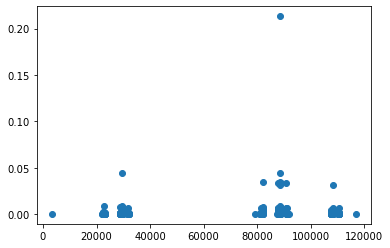

In [42]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")

In [18]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [14]:
#cost function of the initial state
expt_value = 0
matvec_h = full_ham_matrix@psi_0
matvec_c = constraint_full_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*(matvec_h[i]+matvec_c[i])
print(np.real(expt_value))

0.0


In [15]:
expt_value = 0
matvec = full_ham_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*matvec[i]
print(expt_value)

0j


In [16]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms(k,i,j,phi,theta):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    power_matrix = scipy.sparse.kron(sigma,sparse.identity(2*l+1))+scipy.sparse.kron(sparse.identity(2*l+1),sigma)
    rot_matrix = scipy.sparse.linalg.expm(-1j*power_matrix@power_matrix*theta/4)
    if k == 0:
        tensprod = rot_matrix
        for i in range(L-2):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+2,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms_e(i,j,phi,theta):
    ms_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        ms_e = rot_ms(2*k,i,j,phi,theta)@ms_e
    return(ms_e)

def rot_ms_o(i,j,phi,theta):
    ms_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)-1):
        ms_o = rot_ms(2*k+1,i,j,phi,theta)@ms_o
    return(ms_o)

def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_all(i,j,phi,theta):
    sigma_all = sparse.identity(basis.Ns,dtype = complex)
    for k in range(L):
        sigma_all = rot_sigma(k,i,j,phi,theta)@sigma_all
    return(sigma_all)

In [17]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    

In [18]:
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
b = rot_sigma_e(0,1,0,np.pi)
print(datetime.datetime.now())
a@b
print(datetime.datetime.now())

2022-04-05 09:34:35.009948
2022-04-05 09:34:35.625506
2022-04-05 09:34:35.637140
2022-04-05 09:34:35.723380


In [19]:

def sigma_sigma(m,n,theta):
    sigma_sigma = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    temp1 = np.cos(theta/2)
    temp2 = -1j*np.sin(theta/2)
    for i in range(basis.Ns):
        sigma_sigma[i,i] = 1.
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

            
    return sigma_sigma

def id_id(m,theta):
    id_id = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        id_id[i,i] = 1.
        
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4))
            
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4)) 
            
    return id_id


def ms_global_sparse(theta):
    ms_global = sparse.identity(basis.Ns)
    for m in range(L):
        ms_global = id_id(m,theta)@ms_global
        for n in range(m+1,L):
            ms_global = sigma_sigma(m,n,theta)@ms_global
    return ms_global

#print(np.allclose(ms_global_sparse(np.pi/4).toarray(),ms_gate_global(np.pi/4), atol= 1e-3,rtol=1e-3))
#print(np.allclose(ms_global_sparse(np.pi/3).toarray().conj().T@ms_global_sparse(np.pi/3).toarray(),np.identity(basis.Ns), atol= 1e-8,rtol=1e-8))

%time sigma_sigma(0,1,np.pi/3)

CPU times: user 380 ms, sys: 4.09 ms, total: 385 ms
Wall time: 160 ms


<2187x2187 sparse matrix of type '<class 'numpy.complex128'>'
	with 3159 stored elements in List of Lists format>

In [20]:
#import timeit
#print(timeit.timeit('[ms_gate_global(0,2,np.pi)]', globals=globals()))
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
print(np.size(a))


2022-04-05 09:34:35.916327
2022-04-05 09:34:36.521190
4782969


In [21]:
def cost_function_sigma(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

import datetime

print(datetime.datetime.now())
a = cost_function_sigma(np.pi*np.ones(5*N))
print(datetime.datetime.now())

2022-04-05 09:34:36.527082
2022-04-05 09:34:39.275638


In [22]:
opt_params = []
function_values = []
def callback_function(x,fun,context):
    opt_params.append(x)
    function_values.append(fun)


In [23]:
full_ham_matrix = sparse.csc_matrix(full_ham_matrix)

In [24]:
Energy = np.zeros(5)
Fidelity = np.zeros(5)

In [25]:
import optuna
#for N in range(1,6):
theta = np.zeros(5*N)
#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -3*np.pi, 3*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -3*np.pi, 3*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -3*np.pi, 3*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -3*np.pi, 3*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -3*np.pi, 3*np.pi)


        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

if __name__ == "__main__":
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler)
    study.optimize(cost_function_sigma, n_trials=8000)
    

"""""""""""""""""""""
k=0
for value in study.best_trial.params.items():
    theta[k] = value[1]
    k+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    #Energy[N-1] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var)
    #Fidelity[N-1] = np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2
"""""""""""""""""""""

[I 2022-04-05 09:34:40,151] A new study created in memory with name: 4
[I 2022-04-05 09:34:42,833] Trial 0 finished with value: 8.840164959647296 and parameters: {'5*0+0': 5.578498126268462, '5*0+1': 4.916029569192194, '5*0+2': -5.833868856905603, '5*0+3': -1.2082966032502114, '5*0+4': 8.170986360506607, '5*1+0': -2.496400301059971, '5*1+1': -2.1917540478956097, '5*1+2': 1.275130198291329, '5*1+3': -5.611657008329856, '5*1+4': -3.59589488778267, '5*2+0': 1.3422398129797113, '5*2+1': -5.934792553470032, '5*2+2': 1.3938611042711937, '5*2+3': -3.780825893961291, '5*2+4': 8.925793086660352, '5*3+0': -0.49027766134878803, '5*3+1': -5.598970844569665, '5*3+2': 7.697718727632303, '5*3+3': -6.617877310789913, '5*3+4': 2.556835289423839}. Best is trial 0 with value: 8.840164959647296.
[I 2022-04-05 09:34:45,494] Trial 1 finished with value: 6.867804223327761 and parameters: {'5*0+0': 0.7103670890618367, '5*0+1': 3.3900142649168874, '5*0+2': 3.8509710667511388, '5*0+3': 4.814329999329609, '5*0+4

[I 2022-04-05 09:35:14,880] Trial 12 finished with value: 3.9182912001405463 and parameters: {'5*0+0': 8.810408625341946, '5*0+1': -2.421117083840931, '5*0+2': -2.9251466182002193, '5*0+3': -1.970667889227293, '5*0+4': 0.4205565304174228, '5*1+0': -2.328586210109837, '5*1+1': -2.125425441769968, '5*1+2': 3.172618058594775, '5*1+3': -0.23398737008380485, '5*1+4': -1.7944553451718628, '5*2+0': 0.295831164864829, '5*2+1': -2.156365498441832, '5*2+2': -2.4889628973279843, '5*2+3': 0.3503059243777811, '5*2+4': -0.7400813959669124, '5*3+0': 1.4664331693138162, '5*3+1': -4.611681201767741, '5*3+2': 1.9258778486278432, '5*3+3': -0.5172162521138298, '5*3+4': -3.1290743257023164}. Best is trial 12 with value: 3.9182912001405463.
[I 2022-04-05 09:35:17,561] Trial 13 finished with value: 4.982247485791059 and parameters: {'5*0+0': 3.4641415403124047, '5*0+1': 0.7183281216654169, '5*0+2': 4.968788760191759, '5*0+3': 1.2030986491626399, '5*0+4': 1.6581004458703832, '5*1+0': -7.366468979486897, '5*1+

[I 2022-04-05 09:35:46,895] Trial 24 finished with value: 5.6780758725319505 and parameters: {'5*0+0': 3.3220223671909204, '5*0+1': -3.7221774160789, '5*0+2': -1.7396102536781983, '5*0+3': 1.0431345066732036, '5*0+4': -2.615215636861672, '5*1+0': -5.356312226363155, '5*1+1': 2.158171444248937, '5*1+2': -3.221817062102334, '5*1+3': 1.6472045569530678, '5*1+4': -5.605097811272687, '5*2+0': -4.211706611384022, '5*2+1': -2.415163889150395, '5*2+2': 2.027863474152569, '5*2+3': 1.6053982968201252, '5*2+4': 0.7893730221801666, '5*3+0': -0.4912425485860372, '5*3+1': -1.4286006471534067, '5*3+2': -1.2512872230964112, '5*3+3': -3.5408716427750746, '5*3+4': 1.6492716710532023}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:35:49,554] Trial 25 finished with value: 6.402766815380675 and parameters: {'5*0+0': 4.3756572492322, '5*0+1': -2.0234944500858596, '5*0+2': 4.942297929857496, '5*0+3': -2.690241912633324, '5*0+4': -1.2289476957647494, '5*1+0': -2.902949578135713, '5*1+1': 3

[I 2022-04-05 09:36:18,606] Trial 36 finished with value: 5.780633972942761 and parameters: {'5*0+0': 5.422427156657632, '5*0+1': -2.5315346436216046, '5*0+2': -1.5769512303551227, '5*0+3': -0.08371005159264458, '5*0+4': 1.4932317473779877, '5*1+0': -4.060220535743684, '5*1+1': -0.2814281252389974, '5*1+2': -1.5960749582273077, '5*1+3': 5.686973013542453, '5*1+4': 7.91701377064587, '5*2+0': -5.174281069861923, '5*2+1': -4.079845705260995, '5*2+2': -2.6896506291870645, '5*2+3': -1.5350059861847862, '5*2+4': 2.550665882074767, '5*3+0': -1.416030940702218, '5*3+1': -0.8150077392649003, '5*3+2': -2.6624642733835433, '5*3+3': -2.8625144633262893, '5*3+4': -2.9884038023300574}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:36:21,242] Trial 37 finished with value: 7.9455683648111535 and parameters: {'5*0+0': 5.371930875472756, '5*0+1': -4.943744169860602, '5*0+2': 4.838525531172152, '5*0+3': -3.055460606553252, '5*0+4': 1.7425379956637477, '5*1+0': -0.46602168651400433, '5

[I 2022-04-05 09:36:50,646] Trial 48 finished with value: 7.987373144987872 and parameters: {'5*0+0': 8.307313071634324, '5*0+1': 1.8101276604115275, '5*0+2': 3.398496314751978, '5*0+3': 5.13422969623648, '5*0+4': -5.64493498493701, '5*1+0': 0.07653882956404834, '5*1+1': 7.144392450905309, '5*1+2': -0.373526484226258, '5*1+3': 3.8058847626993773, '5*1+4': -1.4771512975763592, '5*2+0': -4.746182377398121, '5*2+1': 4.42262086385641, '5*2+2': 3.0252555396368708, '5*2+3': -0.9410962456350623, '5*2+4': 0.795726474345062, '5*3+0': 3.5478117660169897, '5*3+1': -3.0252511430556313, '5*3+2': -1.4488894435230069, '5*3+3': 2.5775364521866067, '5*3+4': -6.705549448644055}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:36:53,287] Trial 49 finished with value: 5.902821942485115 and parameters: {'5*0+0': 5.07840003418079, '5*0+1': -2.7460130424845186, '5*0+2': 0.3046697411713488, '5*0+3': 6.7465459266239876, '5*0+4': 4.963895551141887, '5*1+0': 1.796493837374971, '5*1+1': 3.681242

[I 2022-04-05 09:37:22,308] Trial 60 finished with value: 8.339273333279179 and parameters: {'5*0+0': 8.251421807587555, '5*0+1': -0.8569766122961313, '5*0+2': 3.709108142465757, '5*0+3': 8.229246290176627, '5*0+4': 0.5880177906707762, '5*1+0': -3.2604826066908643, '5*1+1': 5.68216190174706, '5*1+2': -4.674921690770143, '5*1+3': 1.93031416737612, '5*1+4': 4.074251163100675, '5*2+0': -4.672873659983817, '5*2+1': -0.857737952380826, '5*2+2': -1.6383945274028342, '5*2+3': -1.1139533468907363, '5*2+4': 1.1193743823478037, '5*3+0': -2.415143475804414, '5*3+1': -0.061362557001670925, '5*3+2': -3.0456606323065225, '5*3+3': -2.183904769484115, '5*3+4': -9.03005136540124}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:37:24,931] Trial 61 finished with value: 5.458172233589162 and parameters: {'5*0+0': 4.50394509174513, '5*0+1': -1.5715636529613088, '5*0+2': 5.021687691578176, '5*0+3': 6.177835666194086, '5*0+4': 3.288121348240231, '5*1+0': -4.519064692468929, '5*1+1': 3.3317

[I 2022-04-05 09:37:53,823] Trial 72 finished with value: 5.172456965793941 and parameters: {'5*0+0': 3.555096438438111, '5*0+1': -5.684006059122797, '5*0+2': -1.2113791424415101, '5*0+3': 4.045338813251995, '5*0+4': 3.580234732401968, '5*1+0': 0.3681243337299671, '5*1+1': 0.14880504787715343, '5*1+2': 3.90209219912437, '5*1+3': 2.2307286784595166, '5*1+4': 4.4763790505745416, '5*2+0': 2.009488666638459, '5*2+1': 2.0877535454218794, '5*2+2': 0.36092451891502675, '5*2+3': -4.068825223683599, '5*2+4': 0.6482898369349279, '5*3+0': 0.12368934481108607, '5*3+1': 5.292672347953772, '5*3+2': 0.056754641881355594, '5*3+3': 0.8508359958206431, '5*3+4': -7.200457817142926}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:37:56,438] Trial 73 finished with value: 7.410516475091287 and parameters: {'5*0+0': 2.6957469205980185, '5*0+1': 0.004701021839067732, '5*0+2': -2.926977511513436, '5*0+3': 2.9931909617297943, '5*0+4': -3.322062371666977, '5*1+0': -1.5882582380323997, '5*1+1':

[I 2022-04-05 09:38:25,524] Trial 84 finished with value: 5.866282585101958 and parameters: {'5*0+0': 6.974329639809154, '5*0+1': -2.790953858177528, '5*0+2': 0.6067776617768745, '5*0+3': 6.875114254173468, '5*0+4': -2.442917936968012, '5*1+0': -3.8549834059180554, '5*1+1': 2.2171781920601017, '5*1+2': 3.1327049314825572, '5*1+3': -4.160750036680158, '5*1+4': -1.347219904186005, '5*2+0': -2.7050798790263193, '5*2+1': 1.999203996161646, '5*2+2': 0.6676904591251378, '5*2+3': -0.12392113248744208, '5*2+4': -1.994469397061938, '5*3+0': 3.3287218422764493, '5*3+1': -4.831507527143152, '5*3+2': -7.222026642823884, '5*3+3': -2.105081402617274, '5*3+4': -8.22105071618651}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:38:28,249] Trial 85 finished with value: 4.5832697723947255 and parameters: {'5*0+0': 0.260124418182901, '5*0+1': 1.6376837328600928, '5*0+2': -2.1212202458220726, '5*0+3': 5.928200602385299, '5*0+4': -0.9538027528254709, '5*1+0': -0.13494820484249226, '5*1+1'

[I 2022-04-05 09:38:57,356] Trial 96 finished with value: 8.626313290387714 and parameters: {'5*0+0': 3.2159952200856132, '5*0+1': 0.19544782045010617, '5*0+2': -3.1948829107887007, '5*0+3': 7.39257826465025, '5*0+4': 2.7185069037887972, '5*1+0': 0.23573877172152446, '5*1+1': -0.4592280170809011, '5*1+2': -0.8875140608580545, '5*1+3': 1.9655210205379496, '5*1+4': 2.211868085247753, '5*2+0': -3.2276346290886373, '5*2+1': 3.012699982091163, '5*2+2': -0.7423021619707184, '5*2+3': -0.38719219857954534, '5*2+4': -0.1912308405098554, '5*3+0': -2.252209509299928, '5*3+1': 0.8834608637527868, '5*3+2': -1.2158844668519246, '5*3+3': -1.4216690018439166, '5*3+4': -5.6465184191060445}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:39:00,002] Trial 97 finished with value: 5.6260197187198795 and parameters: {'5*0+0': -0.37499212096305046, '5*0+1': 3.553595559374491, '5*0+2': 3.2117762197010036, '5*0+3': 3.9720064450841575, '5*0+4': -3.4926692361993177, '5*1+0': -0.233333116451499

[I 2022-04-05 09:39:28,966] Trial 108 finished with value: 4.428387760348286 and parameters: {'5*0+0': 5.94361837582046, '5*0+1': 2.8859314510327985, '5*0+2': 1.1073235135295465, '5*0+3': 3.8054105237179243, '5*0+4': -1.042398364987009, '5*1+0': 3.913251930757939, '5*1+1': 5.491134267462881, '5*1+2': 0.5304971019700833, '5*1+3': 0.5088500537697815, '5*1+4': 0.8809532457190944, '5*2+0': -4.4072831581337795, '5*2+1': -0.6759379537171037, '5*2+2': 0.08173081790428727, '5*2+3': -4.1476616398221235, '5*2+4': 0.8060746354301168, '5*3+0': -5.472989369071495, '5*3+1': -1.5577847872864146, '5*3+2': 0.659630170650757, '5*3+3': -1.4556546948419875, '5*3+4': -5.22073703551805}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:39:31,603] Trial 109 finished with value: 5.958282660008427 and parameters: {'5*0+0': 4.105589480730116, '5*0+1': 0.6431926377908271, '5*0+2': 0.6941973316129959, '5*0+3': 3.4803153947832697, '5*0+4': 0.8756294617876479, '5*1+0': 3.6390007765956307, '5*1+1': 

[I 2022-04-05 09:40:00,576] Trial 120 finished with value: 5.7048383948348835 and parameters: {'5*0+0': 4.8421846612652, '5*0+1': 1.2603835924591664, '5*0+2': -1.7475696572542976, '5*0+3': 0.2597707641007929, '5*0+4': 2.36874231225153, '5*1+0': 4.075532907625636, '5*1+1': 2.1875205741410726, '5*1+2': 1.2809489509455885, '5*1+3': -3.2147083264255216, '5*1+4': 3.1364028620307565, '5*2+0': -2.1827557864621747, '5*2+1': 2.0701658842374844, '5*2+2': -4.857037163639617, '5*2+3': 0.41783750382383467, '5*2+4': -0.3718324864123597, '5*3+0': -4.320222840348349, '5*3+1': 4.447049716712304, '5*3+2': -3.573536775950454, '5*3+3': -1.991114511281868, '5*3+4': -5.126659074064516}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:40:03,192] Trial 121 finished with value: 5.208797083730538 and parameters: {'5*0+0': 5.885801690978904, '5*0+1': 3.8308426595175735, '5*0+2': -0.6694481875256783, '5*0+3': 2.078243891850474, '5*0+4': -1.3677643274675733, '5*1+0': 1.7367119665285387, '5*1+1': 

[I 2022-04-05 09:40:32,288] Trial 132 finished with value: 5.47651979461259 and parameters: {'5*0+0': 4.134747723946681, '5*0+1': -0.7915454944151985, '5*0+2': 4.033418179209813, '5*0+3': 1.4554886585133762, '5*0+4': -5.245033843948681, '5*1+0': 3.8368179193360823, '5*1+1': 3.7449725724461067, '5*1+2': -0.647002395453543, '5*1+3': -0.5770852663624618, '5*1+4': -0.4450416525070503, '5*2+0': 1.564773969698909, '5*2+1': 0.6262413510207612, '5*2+2': -2.2122107413647027, '5*2+3': 0.6615810436029153, '5*2+4': 1.9386991085024616, '5*3+0': -1.0400037159424769, '5*3+1': -1.6596208498459222, '5*3+2': -2.098514126118161, '5*3+3': -2.5170856994019295, '5*3+4': -5.62616069615298}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:40:34,932] Trial 133 finished with value: 7.176201984872493 and parameters: {'5*0+0': 6.740223785224871, '5*0+1': 0.7633872006800961, '5*0+2': 1.5550827194002779, '5*0+3': 1.1597536014347167, '5*0+4': -1.3476756923748154, '5*1+0': 4.651421084550087, '5*1+1'

[I 2022-04-05 09:41:04,146] Trial 144 finished with value: 6.831747764581646 and parameters: {'5*0+0': 8.116632417989823, '5*0+1': 1.8696582902765853, '5*0+2': 1.8271951506950548, '5*0+3': -1.2284486072080765, '5*0+4': -3.0097302724059927, '5*1+0': 1.8258569812863268, '5*1+1': 5.927801374500438, '5*1+2': 0.8906766944609636, '5*1+3': -0.9741638763691634, '5*1+4': 2.94219787239493, '5*2+0': -5.025807859196578, '5*2+1': -3.634438527352999, '5*2+2': -2.399799155439648, '5*2+3': -0.1403919553372176, '5*2+4': 3.188746540162964, '5*3+0': 0.4331596176634727, '5*3+1': -0.11979256283771855, '5*3+2': -1.448241653190787, '5*3+3': -6.103219518743181, '5*3+4': -6.886729056340672}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:41:06,825] Trial 145 finished with value: 4.942797382140023 and parameters: {'5*0+0': 6.1606157525763985, '5*0+1': -1.95878628126151, '5*0+2': 3.9049948362890197, '5*0+3': 6.599848353167205, '5*0+4': -7.4276299856479024, '5*1+0': 0.10728034974214817, '5*1+1'

[I 2022-04-05 09:41:36,327] Trial 156 finished with value: 5.884070980299851 and parameters: {'5*0+0': 6.227818958948145, '5*0+1': 0.15860509324562672, '5*0+2': 2.248670668470459, '5*0+3': -2.119997785223305, '5*0+4': -3.9720374361143027, '5*1+0': -3.139403202605822, '5*1+1': 6.748888456700389, '5*1+2': 4.003055159912341, '5*1+3': -6.674542391628189, '5*1+4': -2.019942361567214, '5*2+0': -0.5672723703910441, '5*2+1': 3.3989132997039713, '5*2+2': 0.8309358321202591, '5*2+3': 2.083984887201381, '5*2+4': 1.5382646248566705, '5*3+0': 1.1273327078817412, '5*3+1': 2.7300932862005642, '5*3+2': -3.568289504203723, '5*3+3': -3.559329729153614, '5*3+4': -5.020385579876363}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:41:39,001] Trial 157 finished with value: 4.803377306030036 and parameters: {'5*0+0': 5.661098545443438, '5*0+1': 3.072809200310677, '5*0+2': 0.03287407037575929, '5*0+3': 0.4660144197721614, '5*0+4': -2.691982334835852, '5*1+0': -0.13628508622208524, '5*1+1': 

[I 2022-04-05 09:42:08,152] Trial 168 finished with value: 9.251964147746605 and parameters: {'5*0+0': 6.625953427286278, '5*0+1': -0.18547358274195513, '5*0+2': 3.6633824651853106, '5*0+3': 0.4582749421846479, '5*0+4': -2.0138288628025616, '5*1+0': 2.2814835658055994, '5*1+1': 4.3823888251990155, '5*1+2': 6.768533907966173, '5*1+3': -2.90098687032695, '5*1+4': 2.2856738221237536, '5*2+0': -0.38741557814523464, '5*2+1': 3.371595225810578, '5*2+2': 0.0804692675214389, '5*2+3': -0.3226823376794772, '5*2+4': 5.221119204907324, '5*3+0': 2.2567324208132735, '5*3+1': 2.7306568155966313, '5*3+2': -4.416307957088602, '5*3+3': -3.106694663159023, '5*3+4': -5.363373614328934}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:42:10,794] Trial 169 finished with value: 6.818562554414814 and parameters: {'5*0+0': 5.330501195087114, '5*0+1': 1.5588125740159997, '5*0+2': 2.2492032985831387, '5*0+3': 1.0996432178491848, '5*0+4': -2.4409419714004, '5*1+0': 4.658939044885748, '5*1+1': 2.

[I 2022-04-05 09:42:39,671] Trial 180 finished with value: 10.471699162728783 and parameters: {'5*0+0': 6.146390632577571, '5*0+1': 2.486444963617515, '5*0+2': -3.779196795692415, '5*0+3': 5.079328805685572, '5*0+4': 0.7921988998060829, '5*1+0': 0.014756496027179766, '5*1+1': 5.503769295294537, '5*1+2': 4.9055500771635305, '5*1+3': -5.546998126786949, '5*1+4': 1.4281939988835257, '5*2+0': 0.2242309536735385, '5*2+1': 6.828179767754663, '5*2+2': 0.7027830964290914, '5*2+3': 4.773835677973049, '5*2+4': 4.864184259967267, '5*3+0': -3.1191682341733786, '5*3+1': 4.097295333684037, '5*3+2': -7.816306817928411, '5*3+3': -4.595228797106158, '5*3+4': -6.503877817738691}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:42:42,311] Trial 181 finished with value: 6.795561703198164 and parameters: {'5*0+0': 4.945952435389691, '5*0+1': -2.7392516078869074, '5*0+2': -4.66946652483953, '5*0+3': 2.162700644095648, '5*0+4': -3.629470982238453, '5*1+0': 3.90929806304675, '5*1+1': 6.89698

[I 2022-04-05 09:43:10,924] Trial 192 finished with value: 6.773195487363639 and parameters: {'5*0+0': 3.0977064814317075, '5*0+1': 1.2495513342196765, '5*0+2': 1.3760131819541546, '5*0+3': 1.802507066722124, '5*0+4': -3.322247964844446, '5*1+0': 5.119788295268693, '5*1+1': 8.88443649701988, '5*1+2': 1.1173020891811634, '5*1+3': -1.913675252606137, '5*1+4': 3.9249998791833356, '5*2+0': -1.11111680882185, '5*2+1': 4.238883207740062, '5*2+2': 0.5145523702552575, '5*2+3': 3.025837515060388, '5*2+4': 0.057996833876566845, '5*3+0': -2.7957619760667805, '5*3+1': -3.8617523179858635, '5*3+2': -3.573732733354227, '5*3+3': -5.287569662837753, '5*3+4': -4.235810021216822}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:43:13,506] Trial 193 finished with value: 4.737272641598535 and parameters: {'5*0+0': 7.935935680139185, '5*0+1': 4.914565265989894, '5*0+2': 1.192663096586331, '5*0+3': 3.7528451003823666, '5*0+4': -3.333966758725093, '5*1+0': 1.9240717182725202, '5*1+1': 6.122

[I 2022-04-05 09:43:42,229] Trial 204 finished with value: 5.548051720793655 and parameters: {'5*0+0': 3.2686835209087683, '5*0+1': 3.080587000810789, '5*0+2': -0.7638095275836541, '5*0+3': 2.8671747209600302, '5*0+4': -4.355530060321778, '5*1+0': 2.6587174709300836, '5*1+1': 3.1746075709443407, '5*1+2': 5.11785902696956, '5*1+3': -2.2073160954606026, '5*1+4': 2.9600860395966784, '5*2+0': -1.8695280250267534, '5*2+1': 6.859096775473285, '5*2+2': 0.9690192994247531, '5*2+3': 5.228093782977475, '5*2+4': 2.740266071089168, '5*3+0': -0.5707108345659575, '5*3+1': 5.954181455501793, '5*3+2': -1.2722365537040463, '5*3+3': -3.1500083532388534, '5*3+4': -4.824692142990296}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:43:44,815] Trial 205 finished with value: 4.718958553387818 and parameters: {'5*0+0': 4.187757609155701, '5*0+1': 3.3646944142787536, '5*0+2': -1.3786291453897654, '5*0+3': 3.266864923939059, '5*0+4': -0.8011459206588771, '5*1+0': 4.95218206197184, '5*1+1': 4.

[I 2022-04-05 09:44:13,423] Trial 216 finished with value: 6.219339882537355 and parameters: {'5*0+0': 7.376910688550947, '5*0+1': 2.7304526225845795, '5*0+2': 0.5801445496421723, '5*0+3': 3.877043117474517, '5*0+4': -4.38622011301892, '5*1+0': 3.1749358857383303, '5*1+1': 6.89145358169763, '5*1+2': 3.331860779968717, '5*1+3': -1.6942549311574524, '5*1+4': 5.1506994483693855, '5*2+0': -2.273121625087808, '5*2+1': 4.870043993986991, '5*2+2': 4.763567663936467, '5*2+3': 4.619543749310753, '5*2+4': -0.20844224478817375, '5*3+0': -3.56117369756382, '5*3+1': -0.6415694811985406, '5*3+2': 0.20646340510446848, '5*3+3': -2.1018756702934844, '5*3+4': -4.597163100827211}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:44:16,097] Trial 217 finished with value: 5.008233737033048 and parameters: {'5*0+0': 5.973063880446395, '5*0+1': 5.012433035919647, '5*0+2': -1.2748872127506456, '5*0+3': 0.739680691780257, '5*0+4': -1.389735802199898, '5*1+0': 3.7345648242517795, '5*1+1': 4.339

[I 2022-04-05 09:44:44,482] Trial 228 finished with value: 5.817907450941676 and parameters: {'5*0+0': 2.8325491750255924, '5*0+1': 4.292364440554292, '5*0+2': 1.3246499148436508, '5*0+3': 4.653498354528794, '5*0+4': -1.3090805863667272, '5*1+0': 0.16338484551327181, '5*1+1': 8.135365064673525, '5*1+2': 5.255707616514112, '5*1+3': -2.8909461510976002, '5*1+4': 1.8459669451864307, '5*2+0': -0.9640775358696505, '5*2+1': 4.330396424435345, '5*2+2': 4.1692879614452805, '5*2+3': 0.05323209157746156, '5*2+4': 1.2203132484074113, '5*3+0': 0.1799868227234003, '5*3+1': 2.5735537091965455, '5*3+2': -3.0417919075761772, '5*3+3': 0.2176064078173776, '5*3+4': -4.633607076283058}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:44:47,050] Trial 229 finished with value: 4.682543198545403 and parameters: {'5*0+0': 1.7118831306728033, '5*0+1': -0.3060221185533112, '5*0+2': 0.19657664057498625, '5*0+3': 4.3945209322798995, '5*0+4': -1.2611185604609405, '5*1+0': 4.07494422652074, '5*1+1

[I 2022-04-05 09:45:17,056] Trial 240 finished with value: 6.14314631331402 and parameters: {'5*0+0': 3.079071576680826, '5*0+1': 4.103654739749954, '5*0+2': 1.7578794440328656, '5*0+3': 2.368987319451264, '5*0+4': -2.6495613400917923, '5*1+0': -1.2407300060044744, '5*1+1': 2.649998815305138, '5*1+2': 0.6902834311811263, '5*1+3': 0.3432173698879635, '5*1+4': 0.19506878531920058, '5*2+0': -0.20065612145371903, '5*2+1': 3.4075512879557555, '5*2+2': 2.2611784602225473, '5*2+3': 3.201989061692257, '5*2+4': 3.49891629722918, '5*3+0': -2.835731736532162, '5*3+1': 6.925755210192577, '5*3+2': -2.814141768301374, '5*3+3': -1.6826956933470645, '5*3+4': -4.492652067845954}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:45:20,421] Trial 241 finished with value: 4.486117014724276 and parameters: {'5*0+0': 7.146806765623791, '5*0+1': 2.5184414656235945, '5*0+2': 0.2232968310241104, '5*0+3': 0.6116063568656651, '5*0+4': -0.8701944485103046, '5*1+0': 1.6726454021481905, '5*1+1': 1.

[I 2022-04-05 09:46:01,342] Trial 252 finished with value: 7.087806499132856 and parameters: {'5*0+0': 4.036145945989025, '5*0+1': 2.2137718556069492, '5*0+2': -1.7912655998000524, '5*0+3': 5.52450824401768, '5*0+4': -3.058332636329027, '5*1+0': 1.1280259853531316, '5*1+1': 4.153167740817407, '5*1+2': 3.0875734343819072, '5*1+3': -1.6739976369033964, '5*1+4': 4.050511068340603, '5*2+0': -3.471626807058722, '5*2+1': 0.3416540145644871, '5*2+2': 3.2493607205080632, '5*2+3': -0.1623214419483897, '5*2+4': 3.023811618748342, '5*3+0': 1.7728555572818003, '5*3+1': 3.3577190675246524, '5*3+2': 1.4906510656741447, '5*3+3': -1.2071228422487799, '5*3+4': -8.70543402489818}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:46:04,783] Trial 253 finished with value: 4.433797936399645 and parameters: {'5*0+0': 2.9776407245672076, '5*0+1': 1.155751545583505, '5*0+2': -0.07868131340084505, '5*0+3': 5.691592005619241, '5*0+4': -3.8603463203251795, '5*1+0': -1.0656122038598772, '5*1+1': 

[I 2022-04-05 09:46:45,696] Trial 264 finished with value: 6.153667726769491 and parameters: {'5*0+0': 3.9157227248831257, '5*0+1': 3.8212028777320324, '5*0+2': -1.006311791446002, '5*0+3': 5.5229423497542065, '5*0+4': -5.102105976990343, '5*1+0': 3.141805429803428, '5*1+1': 4.352326061515437, '5*1+2': 0.7150641963132789, '5*1+3': -2.8504490951668253, '5*1+4': 0.07848385495784216, '5*2+0': -4.664205534253595, '5*2+1': 4.089685227020648, '5*2+2': 3.1163782778011306, '5*2+3': 2.6162673278350637, '5*2+4': 5.689628555778294, '5*3+0': -0.7318374456611609, '5*3+1': 2.286946224212687, '5*3+2': -1.2956325357376546, '5*3+3': -4.317022261638929, '5*3+4': -5.438860561762828}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:46:49,390] Trial 265 finished with value: 4.6761798595524215 and parameters: {'5*0+0': 3.7699330904315316, '5*0+1': 2.146891113315787, '5*0+2': 0.337580232469818, '5*0+3': 1.6211528728560345, '5*0+4': -5.253334404694256, '5*1+0': 1.235511247859333, '5*1+1': 4.

[I 2022-04-05 09:47:28,836] Trial 276 finished with value: 6.423567873581892 and parameters: {'5*0+0': 4.777258346426301, '5*0+1': 3.6002585857706912, '5*0+2': 0.011280719663005923, '5*0+3': 5.318589822691115, '5*0+4': -6.377347266107337, '5*1+0': 3.076107431933325, '5*1+1': 1.9285513665396692, '5*1+2': 1.8901239410091195, '5*1+3': -3.2250784104298074, '5*1+4': -2.3363958035515577, '5*2+0': -5.8548545773979646, '5*2+1': 4.198192027796701, '5*2+2': 1.100631222983258, '5*2+3': 3.6271093558937166, '5*2+4': 3.1360193646238717, '5*3+0': -0.9756217148743471, '5*3+1': 4.205490158520341, '5*3+2': 0.4572983168556389, '5*3+3': -1.5357838499741154, '5*3+4': -7.548943248100271}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:47:32,168] Trial 277 finished with value: 5.453380905165611 and parameters: {'5*0+0': 1.3481965140666015, '5*0+1': 2.2056826159527434, '5*0+2': -0.01687056717824001, '5*0+3': 4.234898084958876, '5*0+4': -0.6782963452163786, '5*1+0': 2.7204831866053767, '5*1+

[I 2022-04-05 09:48:09,625] Trial 288 finished with value: 8.003149699488263 and parameters: {'5*0+0': 5.197598241326894, '5*0+1': 3.9083712412414866, '5*0+2': -1.2670569516551091, '5*0+3': 4.620773442011634, '5*0+4': -4.373287168717671, '5*1+0': 0.879638371427926, '5*1+1': 5.765857828455868, '5*1+2': 1.8152152599930405, '5*1+3': -2.4735181870510132, '5*1+4': 0.18408405400252564, '5*2+0': -3.2341820208571224, '5*2+1': 3.890205565717987, '5*2+2': 1.0240815225108393, '5*2+3': 0.5043576927610085, '5*2+4': 4.090783410496271, '5*3+0': 0.1813205816598672, '5*3+1': 5.4422466080912075, '5*3+2': 1.274971352296713, '5*3+3': -0.15659167454088602, '5*3+4': -7.591014995960781}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:48:13,014] Trial 289 finished with value: 4.042997339938768 and parameters: {'5*0+0': 1.924002158486947, '5*0+1': 4.327288966862981, '5*0+2': -0.288893133753808, '5*0+3': 1.1364796248294613, '5*0+4': -0.870973867927332, '5*1+0': 2.280463394959439, '5*1+1': 4.2

[I 2022-04-05 09:48:49,902] Trial 300 finished with value: 3.933162391178355 and parameters: {'5*0+0': 1.2100402624688986, '5*0+1': 3.2045175634825367, '5*0+2': -1.8029537480951405, '5*0+3': 2.5896439789360715, '5*0+4': -1.2167202912791624, '5*1+0': 0.3552253209431535, '5*1+1': 0.35169410819358427, '5*1+2': 0.3199148463200805, '5*1+3': -0.867862281997808, '5*1+4': -0.4641609957132282, '5*2+0': -1.8602942650452179, '5*2+1': 3.9426015913627364, '5*2+2': 4.323670368036783, '5*2+3': 0.23257526725017774, '5*2+4': 3.9713142989959405, '5*3+0': 0.2992144788166756, '5*3+1': 3.9127703632208073, '5*3+2': 1.0146562217000727, '5*3+3': 0.18050890613305526, '5*3+4': -5.38885181654592}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:48:53,510] Trial 301 finished with value: 7.547544631753428 and parameters: {'5*0+0': 3.0234489321369193, '5*0+1': 5.985499788086616, '5*0+2': -1.7630337857201872, '5*0+3': 4.209283356461486, '5*0+4': -2.8307838559562315, '5*1+0': 3.53899898185207, '5*1+

[I 2022-04-05 09:49:31,948] Trial 312 finished with value: 4.762191152261514 and parameters: {'5*0+0': 3.6466026837290313, '5*0+1': 4.7727882518500335, '5*0+2': -1.6348011014541528, '5*0+3': 3.784926922763424, '5*0+4': -1.9690564305846707, '5*1+0': 2.1634089036280497, '5*1+1': 1.5381630174352785, '5*1+2': 1.1741578446703835, '5*1+3': -0.38961385233698076, '5*1+4': 1.2055693237920728, '5*2+0': -1.1769456403774687, '5*2+1': 3.625080244034677, '5*2+2': 4.698346413493448, '5*2+3': -0.766619685437617, '5*2+4': 2.6320447309432184, '5*3+0': 1.797634836865921, '5*3+1': 4.312932367031221, '5*3+2': -1.0223402004447242, '5*3+3': -0.9178509326508393, '5*3+4': -5.337357283267783}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:49:35,218] Trial 313 finished with value: 3.801588072259115 and parameters: {'5*0+0': 4.40877596981602, '5*0+1': 6.046669984666476, '5*0+2': -1.1530350194142605, '5*0+3': 0.691075274410379, '5*0+4': -0.8191581367530696, '5*1+0': 1.0327943990373556, '5*1+1':

[I 2022-04-05 09:50:13,914] Trial 324 finished with value: 8.032059785840222 and parameters: {'5*0+0': -1.011111739004351, '5*0+1': 7.286450176344921, '5*0+2': -2.0607465095917425, '5*0+3': 1.9765984102215786, '5*0+4': -4.235623493039679, '5*1+0': 4.125811047514635, '5*1+1': -1.388149590346087, '5*1+2': 0.06627625400378734, '5*1+3': -0.6716437143034386, '5*1+4': 0.27186964089708776, '5*2+0': 0.7371873657181083, '5*2+1': 2.628267341449145, '5*2+2': 4.457767030279481, '5*2+3': 0.1497864361563661, '5*2+4': 4.541645283121237, '5*3+0': 2.2541783534894293, '5*3+1': 7.7940576679410505, '5*3+2': 2.1431184061429525, '5*3+3': 0.7712471435342052, '5*3+4': -4.147574290362418}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:50:17,246] Trial 325 finished with value: 4.035769628690251 and parameters: {'5*0+0': 1.4485033709883068, '5*0+1': 4.106637606035825, '5*0+2': -0.9075167255652103, '5*0+3': 1.715070211169857, '5*0+4': -3.3184320607060167, '5*1+0': 2.7401843787207305, '5*1+1': 

[I 2022-04-05 09:50:57,173] Trial 336 finished with value: 12.244380832506094 and parameters: {'5*0+0': -0.19181685945211213, '5*0+1': 6.756765517178755, '5*0+2': -2.303696886225917, '5*0+3': 1.9027304043553381, '5*0+4': -4.530898571696879, '5*1+0': 3.1160202642176067, '5*1+1': 1.1709298553679948, '5*1+2': 1.3481482660107802, '5*1+3': 0.5219669759960108, '5*1+4': 1.9565369047357186, '5*2+0': -2.2368840161470414, '5*2+1': 2.93309259643581, '5*2+2': 3.390195123801424, '5*2+3': 3.399443655593698, '5*2+4': 2.4088544109145715, '5*3+0': 0.2268450296786999, '5*3+1': 7.347462342586533, '5*3+2': 1.1187298227180853, '5*3+3': -0.5835168505945895, '5*3+4': -4.488616289846822}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:51:01,792] Trial 337 finished with value: 5.689864670780576 and parameters: {'5*0+0': 0.24369058584941614, '5*0+1': 5.269129949639435, '5*0+2': -2.0019091963540165, '5*0+3': 2.7131633449585233, '5*0+4': -3.9043531658276205, '5*1+0': 0.4361836679730063, '5*1+1'

[I 2022-04-05 09:51:49,470] Trial 348 finished with value: 4.33800268889142 and parameters: {'5*0+0': 1.5992939368193344, '5*0+1': 6.176663612403015, '5*0+2': -1.215453622365665, '5*0+3': 3.2178081337531834, '5*0+4': -2.6909234290970008, '5*1+0': 0.8593832275359419, '5*1+1': -2.504530987649158, '5*1+2': -2.1365816351355265, '5*1+3': -0.5664311277442947, '5*1+4': 4.135114837089313, '5*2+0': -2.6561118525203535, '5*2+1': 6.237305947694617, '5*2+2': 2.899770047454352, '5*2+3': 2.579805784543817, '5*2+4': 2.7265929671846947, '5*3+0': 2.9638719731183754, '5*3+1': 6.286676352514701, '5*3+2': 0.6873681407969818, '5*3+3': 2.7300579748375817, '5*3+4': -8.710970157665786}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:51:53,280] Trial 349 finished with value: 4.5165796688616755 and parameters: {'5*0+0': 0.6944525616674037, '5*0+1': 6.749662972144231, '5*0+2': -1.8683791745500815, '5*0+3': 2.491679207142015, '5*0+4': -0.12257709908431336, '5*1+0': 1.9259952736532175, '5*1+1': 

[I 2022-04-05 09:52:41,185] Trial 360 finished with value: 4.132392628597395 and parameters: {'5*0+0': 1.3140203531372956, '5*0+1': 5.77286015095188, '5*0+2': 0.7200603159970456, '5*0+3': 3.1128658573224364, '5*0+4': -3.9818648176512745, '5*1+0': 1.5778637728461238, '5*1+1': -1.1843434033281501, '5*1+2': -0.07871449152115528, '5*1+3': -2.8875494960505987, '5*1+4': -0.05164202210872615, '5*2+0': -1.0809451959323588, '5*2+1': 2.2789981180016947, '5*2+2': 1.5415421420010278, '5*2+3': 0.5848411884272875, '5*2+4': 1.034887761943322, '5*3+0': 1.3287206730758128, '5*3+1': 5.496256855418316, '5*3+2': -4.356697424948902, '5*3+3': -1.3763608218087804, '5*3+4': -6.166200994532965}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:52:45,687] Trial 361 finished with value: 3.88537915958526 and parameters: {'5*0+0': -0.7241255728331847, '5*0+1': 3.8386923752229096, '5*0+2': -0.33451419020893036, '5*0+3': 1.7682621356066652, '5*0+4': -0.9294221919696157, '5*1+0': -0.05775127750339015

[I 2022-04-05 09:53:30,183] Trial 372 finished with value: 5.649219807231102 and parameters: {'5*0+0': 0.6067738176951653, '5*0+1': 4.060589314023211, '5*0+2': 2.039297463849691, '5*0+3': 1.8779994699026328, '5*0+4': -3.8992252625788106, '5*1+0': 1.324449725618646, '5*1+1': -1.7101961454331642, '5*1+2': -2.2105496880577595, '5*1+3': -1.0119546379949693, '5*1+4': 1.592938974359409, '5*2+0': -1.0142058358832784, '5*2+1': 1.2168535700277845, '5*2+2': 2.145554529130887, '5*2+3': 1.7488773736593273, '5*2+4': 5.371772493109992, '5*3+0': 4.970600000553411, '5*3+1': 5.710657028452623, '5*3+2': -1.5787206570443268, '5*3+3': 0.24576540039055828, '5*3+4': -7.916192597674939}. Best is trial 16 with value: 1.7039764860964108.
[I 2022-04-05 09:53:34,877] Trial 373 finished with value: 4.657031132130593 and parameters: {'5*0+0': 1.480828441986813, '5*0+1': 5.485700632182941, '5*0+2': -4.001504652002663, '5*0+3': 1.4896632716538485, '5*0+4': -3.882425013591145, '5*1+0': -0.21294614195307104, '5*1+1': 

[I 2022-04-05 09:54:18,953] Trial 384 finished with value: 2.9865782324798777 and parameters: {'5*0+0': 1.9733744337903367, '5*0+1': 4.069790084846276, '5*0+2': -3.723887486053314, '5*0+3': -0.46008094321696813, '5*0+4': -3.59405787145112, '5*1+0': 0.9707466943954597, '5*1+1': -1.1426500307384087, '5*1+2': -1.5622770075825312, '5*1+3': 0.9968924754097405, '5*1+4': -0.5886460436858529, '5*2+0': -1.3748447803601325, '5*2+1': 4.492825999422948, '5*2+2': 2.2260975622679684, '5*2+3': 0.7025105062887518, '5*2+4': 5.219439347926011, '5*3+0': 1.4714475589189127, '5*3+1': 8.675328888449727, '5*3+2': -0.5127073468381761, '5*3+3': -1.5814895873217476, '5*3+4': -6.095803459278203}. Best is trial 383 with value: 1.351350537438425.
[I 2022-04-05 09:54:22,952] Trial 385 finished with value: 6.168604766604824 and parameters: {'5*0+0': 1.2850853270613896, '5*0+1': 6.288266658064632, '5*0+2': -2.7840371550361906, '5*0+3': 0.3154288756981083, '5*0+4': -0.36896675469827533, '5*1+0': -0.17281374202560318, 

[I 2022-04-05 09:55:09,488] Trial 396 finished with value: 3.899747494172958 and parameters: {'5*0+0': -0.004813569538261179, '5*0+1': 4.080661902124572, '5*0+2': -2.539635008695254, '5*0+3': 1.9629472358026983, '5*0+4': -3.931120622083051, '5*1+0': 0.6056261498297575, '5*1+1': 0.3167235697148253, '5*1+2': -3.0596520444494666, '5*1+3': 0.8880736718438839, '5*1+4': -2.2011113073622477, '5*2+0': -0.5666328607414998, '5*2+1': 3.077831783521988, '5*2+2': 4.423510352046908, '5*2+3': -1.2621662281613277, '5*2+4': 4.915135768143976, '5*3+0': 2.0842570712162543, '5*3+1': 4.183043384646517, '5*3+2': 0.8523289076686158, '5*3+3': -1.0723047359838813, '5*3+4': -2.941310991625166}. Best is trial 383 with value: 1.351350537438425.
[I 2022-04-05 09:55:13,426] Trial 397 finished with value: 4.786811334213648 and parameters: {'5*0+0': 0.4177835769063836, '5*0+1': 7.109454444029442, '5*0+2': -3.164809593051979, '5*0+3': 1.376293017245486, '5*0+4': -3.8175651385986655, '5*1+0': 1.3901154736539016, '5*1+1

[I 2022-04-05 09:56:00,657] Trial 408 finished with value: 0.9240827541620431 and parameters: {'5*0+0': 0.7925282169192895, '5*0+1': 5.487695703680159, '5*0+2': -2.8112905819002343, '5*0+3': 4.406263312196733, '5*0+4': -2.7385119637914306, '5*1+0': 0.6677855073558862, '5*1+1': -0.6198545019397212, '5*1+2': -1.2609732283472301, '5*1+3': 0.9656129472169916, '5*1+4': 0.6296354910744981, '5*2+0': -0.5493321602383219, '5*2+1': 4.604808460182412, '5*2+2': 1.5363425123916228, '5*2+3': -1.5714400620278794, '5*2+4': 3.0836718745206677, '5*3+0': -0.5011320098728553, '5*3+1': 6.072442857389376, '5*3+2': -0.984510155196754, '5*3+3': -2.9552302968843067, '5*3+4': -2.163180465584759}. Best is trial 408 with value: 0.9240827541620431.
[I 2022-04-05 09:56:04,187] Trial 409 finished with value: 0.23910441011644668 and parameters: {'5*0+0': -0.05274268061674259, '5*0+1': 4.67044419220969, '5*0+2': -3.6612682359600655, '5*0+3': 2.7919246876169845, '5*0+4': -2.9433971021129244, '5*1+0': 0.2959444805645098

[I 2022-04-05 09:56:45,715] Trial 420 finished with value: 5.166827492473533 and parameters: {'5*0+0': -0.18062766345301284, '5*0+1': 3.6777885811561006, '5*0+2': -3.0322466825565133, '5*0+3': 4.534232763608138, '5*0+4': -2.2634143518990526, '5*1+0': 1.465538161920233, '5*1+1': 1.8859296721278773, '5*1+2': 1.637665162146356, '5*1+3': -0.9729859754743364, '5*1+4': 2.177486307006867, '5*2+0': 0.38276156821477025, '5*2+1': 1.5813283744173563, '5*2+2': -2.492684968002142, '5*2+3': -0.5025978130776023, '5*2+4': 2.5959199698221966, '5*3+0': -1.7291506611443392, '5*3+1': 4.492887392793492, '5*3+2': -1.9366276660827781, '5*3+3': 0.08528892907275609, '5*3+4': -1.5197885405657507}. Best is trial 409 with value: 0.23910441011644668.
[I 2022-04-05 09:56:49,119] Trial 421 finished with value: 5.200357443387637 and parameters: {'5*0+0': -2.3323573849278194, '5*0+1': 2.4998576212182337, '5*0+2': -3.752331191192034, '5*0+3': 2.003386360636194, '5*0+4': -3.363786825402365, '5*1+0': 1.2018367711223377, 

[I 2022-04-05 09:57:31,981] Trial 432 finished with value: 0.7945780254837334 and parameters: {'5*0+0': 0.43861193544924426, '5*0+1': 4.270300564802994, '5*0+2': -5.681621711884764, '5*0+3': 2.787728778452537, '5*0+4': -2.7103737387939546, '5*1+0': 1.4415728151795413, '5*1+1': 0.5218699584779495, '5*1+2': 2.0243307992799897, '5*1+3': -1.9608426421757617, '5*1+4': 2.739835859540242, '5*2+0': -1.9631072373172964, '5*2+1': 3.9012831548073024, '5*2+2': 3.670269435709475, '5*2+3': 1.9026309856333434, '5*2+4': 1.6907310401078381, '5*3+0': 2.2159993469194865, '5*3+1': 6.211921080800616, '5*3+2': -4.903690652627017, '5*3+3': -2.808931176065304, '5*3+4': -2.341015277871275}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 09:57:35,656] Trial 433 finished with value: 8.049033993036414 and parameters: {'5*0+0': 0.953509524292687, '5*0+1': 5.426816601976208, '5*0+2': -5.793908330311626, '5*0+3': 2.9708554369199494, '5*0+4': -1.6149393660552787, '5*1+0': 4.087333404619066, '5*1+1'

[I 2022-04-05 09:58:15,746] Trial 444 finished with value: 14.242907406732233 and parameters: {'5*0+0': -0.11076227823812956, '5*0+1': 3.5669273153641092, '5*0+2': -3.323016231834584, '5*0+3': 2.3056031348624013, '5*0+4': -2.9024146048440955, '5*1+0': 1.8381416475455867, '5*1+1': 0.8532956986085751, '5*1+2': 1.502806644850863, '5*1+3': 0.888212435816934, '5*1+4': 4.942857406238769, '5*2+0': -2.5832813205096286, '5*2+1': 2.161879702172885, '5*2+2': 3.6965107398749657, '5*2+3': 2.2910500136369882, '5*2+4': 0.1046007204677204, '5*3+0': -1.4343023688467187, '5*3+1': 2.146782962509553, '5*3+2': -0.07633315990561274, '5*3+3': -2.4594807700975836, '5*3+4': -4.156761117753529}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 09:58:19,125] Trial 445 finished with value: 4.134406320324506 and parameters: {'5*0+0': -1.568789478719555, '5*0+1': 4.386547003318102, '5*0+2': -5.745982670588694, '5*0+3': 3.781956108423615, '5*0+4': -3.2216799673432925, '5*1+0': 2.4617074393529594, '5

[I 2022-04-05 09:58:55,467] Trial 456 finished with value: 5.570202926483567 and parameters: {'5*0+0': 0.6164508757086967, '5*0+1': 3.931830918476619, '5*0+2': -3.484436196452913, '5*0+3': 1.2731018700323828, '5*0+4': -2.3009080126576715, '5*1+0': 0.8474731061899015, '5*1+1': 1.3654241335228665, '5*1+2': -0.4779097499508465, '5*1+3': 1.697674527067098, '5*1+4': 1.1791056951953292, '5*2+0': -3.337657927533677, '5*2+1': 4.2389851300263555, '5*2+2': 3.635703223372706, '5*2+3': 1.9661541447507203, '5*2+4': 1.7099885770333372, '5*3+0': 1.3807326637544617, '5*3+1': 2.619581849192659, '5*3+2': -1.786567119605691, '5*3+3': 0.4490824013082384, '5*3+4': -0.7424557295168916}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 09:58:58,779] Trial 457 finished with value: 0.48217607292590325 and parameters: {'5*0+0': -1.0560736721158257, '5*0+1': 6.5776901928157985, '5*0+2': -6.147439523537933, '5*0+3': 2.092707650919069, '5*0+4': -3.6195013362246953, '5*1+0': 0.2452302770872385, '5*

[I 2022-04-05 09:59:36,703] Trial 468 finished with value: 4.01825839248303 and parameters: {'5*0+0': -1.8222761664186706, '5*0+1': 5.675286940330222, '5*0+2': -5.476944898883184, '5*0+3': 0.7279174915754677, '5*0+4': -3.434879112652297, '5*1+0': 1.7475036729994808, '5*1+1': 0.5433281390101247, '5*1+2': -0.26698433714188885, '5*1+3': -1.5032146712395593, '5*1+4': 1.4465846252401446, '5*2+0': -0.11533732750163206, '5*2+1': 4.5829411223663445, '5*2+2': 0.9393160092278972, '5*2+3': 1.6488844361853925, '5*2+4': 1.599930616589368, '5*3+0': 0.254278295798373, '5*3+1': 2.5694625099581536, '5*3+2': 0.011484032244943876, '5*3+3': -1.167044401430484, '5*3+4': -2.635852897728174}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 09:59:40,093] Trial 469 finished with value: 4.175167797411051 and parameters: {'5*0+0': -1.6792931758648673, '5*0+1': 4.612882534867829, '5*0+2': -3.5751634050107146, '5*0+3': 3.6767974251063142, '5*0+4': -3.556085904153841, '5*1+0': -0.20072859992299197

[I 2022-04-05 10:00:18,777] Trial 480 finished with value: 5.615011806807098 and parameters: {'5*0+0': -2.4743513104420303, '5*0+1': 5.482919765814747, '5*0+2': -2.816463566044564, '5*0+3': -0.7020530376182099, '5*0+4': -1.154279454729582, '5*1+0': 2.362262046277867, '5*1+1': 1.4172963626277197, '5*1+2': -1.2889889852908456, '5*1+3': -3.874086679254866, '5*1+4': 1.7687605388928331, '5*2+0': 1.4993783267933658, '5*2+1': 4.470941693586593, '5*2+2': 3.264391872097182, '5*2+3': 1.6727804651833447, '5*2+4': 1.007839155915443, '5*3+0': 2.3697533801790662, '5*3+1': 5.110701407465938, '5*3+2': -1.4879812973107713, '5*3+3': 0.8248573009365656, '5*3+4': -0.21163285011393507}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 10:00:22,492] Trial 481 finished with value: 5.338125780292107 and parameters: {'5*0+0': 1.705149139175587, '5*0+1': 6.735976419281104, '5*0+2': -5.355470550179837, '5*0+3': 3.044538619347227, '5*0+4': -1.8393146422771278, '5*1+0': 0.7034534712599483, '5*1+1'

[I 2022-04-05 10:01:00,403] Trial 492 finished with value: 5.695704084702885 and parameters: {'5*0+0': -2.2636403739353548, '5*0+1': 5.24476274159118, '5*0+2': -5.864963103415063, '5*0+3': 1.523078203907387, '5*0+4': -2.450179354340131, '5*1+0': 2.492033692555659, '5*1+1': 1.6925559717268497, '5*1+2': 2.296986592153888, '5*1+3': -2.385221653109599, '5*1+4': 0.7873716281831209, '5*2+0': -1.9987442084549363, '5*2+1': 5.099557292411578, '5*2+2': 2.1608768102942277, '5*2+3': -0.32746908369529837, '5*2+4': 0.8859220378212429, '5*3+0': -0.20635788996756133, '5*3+1': 6.162940555065987, '5*3+2': -0.7159778992590575, '5*3+3': -2.9395185523975695, '5*3+4': -2.8488046663071307}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 10:01:03,772] Trial 493 finished with value: 3.5213906266915855 and parameters: {'5*0+0': 0.8288543256639741, '5*0+1': 6.284214159424407, '5*0+2': -4.456600259845169, '5*0+3': 2.9684157678572514, '5*0+4': -1.372040266815877, '5*1+0': 1.4695590476578562, '5*

[I 2022-04-05 10:01:41,328] Trial 504 finished with value: 4.174132578253512 and parameters: {'5*0+0': -1.7135487702772754, '5*0+1': 5.810264513730225, '5*0+2': -4.131462413128281, '5*0+3': 2.916406951442654, '5*0+4': -4.015742013941251, '5*1+0': 0.6283933747223349, '5*1+1': 2.49081516720769, '5*1+2': 2.02771607050458, '5*1+3': -2.0606982917671512, '5*1+4': 0.49702009829991767, '5*2+0': -1.0550093242596161, '5*2+1': 3.1395565930332174, '5*2+2': 4.677331615474408, '5*2+3': -0.35464949938753154, '5*2+4': 0.6591885462728749, '5*3+0': -0.45401624051584066, '5*3+1': 5.6640811438722185, '5*3+2': 1.071578925117531, '5*3+3': 1.3393117753757882, '5*3+4': -1.786109160277242}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 10:01:44,715] Trial 505 finished with value: 4.73575156574021 and parameters: {'5*0+0': -0.06930067230758219, '5*0+1': 5.689400974187721, '5*0+2': -4.78031446442116, '5*0+3': 1.4480766131680325, '5*0+4': -1.308813313267745, '5*1+0': 2.092303089999721, '5*1+1'

[I 2022-04-05 10:02:22,470] Trial 516 finished with value: 4.865497867211541 and parameters: {'5*0+0': -0.44171911473072084, '5*0+1': 5.029320063746115, '5*0+2': -5.253002139060653, '5*0+3': 3.6062258527400406, '5*0+4': -0.9456967497389432, '5*1+0': 1.8485673060253125, '5*1+1': 1.7468435190260574, '5*1+2': 2.2744173427460765, '5*1+3': -1.8428347196650043, '5*1+4': 0.9126018816319383, '5*2+0': -3.033668438671433, '5*2+1': 3.248559916484695, '5*2+2': 4.389792933584947, '5*2+3': 4.48615750513296, '5*2+4': 0.43384340454510495, '5*3+0': -0.2522130009490806, '5*3+1': 5.12309026368601, '5*3+2': -0.6302735320922532, '5*3+3': -1.1204965115180159, '5*3+4': -0.754168705911235}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 10:02:25,840] Trial 517 finished with value: 3.3883263526479417 and parameters: {'5*0+0': -2.0607491747707467, '5*0+1': 4.02968432597068, '5*0+2': -4.0970973970358555, '5*0+3': 1.9883536005885796, '5*0+4': -1.0515429402229477, '5*1+0': 0.7969342679152481, '5

[I 2022-04-05 10:03:03,055] Trial 528 finished with value: 4.862018435118785 and parameters: {'5*0+0': -0.8230492672800648, '5*0+1': 6.073955759760419, '5*0+2': -3.5768890454609648, '5*0+3': 3.1489541600431656, '5*0+4': 0.2477287474540133, '5*1+0': 0.04516986759080166, '5*1+1': 3.0456919729201806, '5*1+2': 1.2245101682908524, '5*1+3': -0.6354036932780953, '5*1+4': 0.6032878423345083, '5*2+0': -3.5290557833781184, '5*2+1': 2.9135656465550563, '5*2+2': 3.7740251203395223, '5*2+3': 0.5003126417456972, '5*2+4': 1.3812419384818266, '5*3+0': 2.715543152681905, '5*3+1': 2.958493395856111, '5*3+2': -1.755970223139769, '5*3+3': 0.24398638330729738, '5*3+4': -3.653378801698712}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 10:03:06,425] Trial 529 finished with value: 1.4825719847157883 and parameters: {'5*0+0': 1.2016479333642935, '5*0+1': 5.6288012946580395, '5*0+2': -5.411996050516883, '5*0+3': 1.8663777247536233, '5*0+4': -0.8570830613201708, '5*1+0': 0.7998210895299667, 

[I 2022-04-05 10:03:43,399] Trial 540 finished with value: 2.6848538334211214 and parameters: {'5*0+0': 0.3181701670923812, '5*0+1': 6.01070695085802, '5*0+2': -4.238891215544894, '5*0+3': 2.4163395128110463, '5*0+4': -0.9297788261278247, '5*1+0': 1.152873883981654, '5*1+1': 1.0349675526323563, '5*1+2': 1.8673100682816908, '5*1+3': -2.059143285737791, '5*1+4': 1.0066906692416442, '5*2+0': -1.2878160186452574, '5*2+1': 4.099635857220422, '5*2+2': 2.947755986002541, '5*2+3': 1.9821866713766463, '5*2+4': 0.6255659353292695, '5*3+0': 2.4058710252264013, '5*3+1': 3.690519772911866, '5*3+2': -2.2195745582446045, '5*3+3': 0.0158274238175376, '5*3+4': -3.8892533970454917}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 10:03:46,759] Trial 541 finished with value: 2.8740302395556716 and parameters: {'5*0+0': 1.8260295260799944, '5*0+1': 5.846716924571711, '5*0+2': -3.627406429891084, '5*0+3': 2.2306938014072046, '5*0+4': -0.2720553468338436, '5*1+0': 0.38587746216669955, '5*1

[I 2022-04-05 10:04:23,876] Trial 552 finished with value: 2.635595886554544 and parameters: {'5*0+0': 1.4201835363084503, '5*0+1': 5.657051575786518, '5*0+2': -4.513156803643937, '5*0+3': 1.0181521832896367, '5*0+4': -0.6530842115638998, '5*1+0': 0.9969910776450759, '5*1+1': 1.8349677006572185, '5*1+2': -1.0942589287836912, '5*1+3': -0.2715239067362645, '5*1+4': 0.12343210873357591, '5*2+0': 0.054756739921179465, '5*2+1': 2.8442893247265078, '5*2+2': 2.8414149091780088, '5*2+3': -0.3920635932716383, '5*2+4': -0.9145783706141887, '5*3+0': 0.9437645406256312, '5*3+1': 5.257880371102927, '5*3+2': -0.6038941346359925, '5*3+3': 0.2927802393228548, '5*3+4': -3.4855460577958737}. Best is trial 423 with value: -0.26897315118123677.
[I 2022-04-05 10:04:27,272] Trial 553 finished with value: 1.8211297371601733 and parameters: {'5*0+0': 0.2910572560133888, '5*0+1': 5.4982281197952565, '5*0+2': -3.824568995427299, '5*0+3': 1.348486457333607, '5*0+4': -1.5425472312033688, '5*1+0': 1.77470939954572

[I 2022-04-05 10:05:05,581] Trial 564 finished with value: 0.3393499802969725 and parameters: {'5*0+0': 0.6728608627397179, '5*0+1': 4.5040572214869945, '5*0+2': -5.427762409771345, '5*0+3': 2.7599152413227674, '5*0+4': -1.5500944730917052, '5*1+0': 1.247696808507451, '5*1+1': 1.1626078747872661, '5*1+2': 1.4201510430606539, '5*1+3': -0.7098837328781566, '5*1+4': 0.6021764890268597, '5*2+0': -1.084160550671251, '5*2+1': 2.8341031753196892, '5*2+2': 2.5480145455419323, '5*2+3': -0.23212834764451273, '5*2+4': 1.05424280053693, '5*3+0': 1.3082324036706734, '5*3+1': 4.629068299577877, '5*3+2': -2.1500485438597763, '5*3+3': -1.9323008229781666, '5*3+4': -2.911020443293161}. Best is trial 555 with value: -0.41272309780363065.
[I 2022-04-05 10:05:08,951] Trial 565 finished with value: 0.05005027577433184 and parameters: {'5*0+0': 0.2249163817926982, '5*0+1': 5.748759190779132, '5*0+2': -3.3890495434153416, '5*0+3': 1.0150547402437557, '5*0+4': -0.5749685796523297, '5*1+0': 0.7374568904587411,

[I 2022-04-05 10:05:47,121] Trial 576 finished with value: 1.4445237469832601 and parameters: {'5*0+0': 0.14428774560680419, '5*0+1': 5.720760457285985, '5*0+2': -4.375146406419503, '5*0+3': 1.2485579054884415, '5*0+4': -1.5334763796581647, '5*1+0': 1.3573680296066413, '5*1+1': 0.5038941292881942, '5*1+2': 0.7167029643523357, '5*1+3': -1.2912259563272497, '5*1+4': 0.013379410515700019, '5*2+0': -1.1299634551231117, '5*2+1': 4.9800565256945095, '5*2+2': 3.552299099392143, '5*2+3': 1.798204014799573, '5*2+4': 0.9142493123807536, '5*3+0': 2.246753615374364, '5*3+1': 4.222848007264463, '5*3+2': -2.514500945285614, '5*3+3': -1.2288813956157039, '5*3+4': -4.152448262840904}. Best is trial 555 with value: -0.41272309780363065.
[I 2022-04-05 10:05:50,546] Trial 577 finished with value: 1.7581815250148862 and parameters: {'5*0+0': 0.11817688600812676, '5*0+1': 4.771779318528381, '5*0+2': -3.3496287611888445, '5*0+3': 0.16680095230799918, '5*0+4': 0.011623769113225157, '5*1+0': 0.314420600985700

[I 2022-04-05 10:06:27,739] Trial 588 finished with value: 0.21459351544780272 and parameters: {'5*0+0': 0.5875680600073916, '5*0+1': 4.603795919757871, '5*0+2': -3.8923043591710855, '5*0+3': 1.080229861073688, '5*0+4': -0.7734329172781447, '5*1+0': 1.4202324099631611, '5*1+1': 2.0602122830373566, '5*1+2': 0.9037400423153207, '5*1+3': -1.433405730921581, '5*1+4': -0.9647422803731152, '5*2+0': -2.2835152205734337, '5*2+1': 3.7483940532530373, '5*2+2': 1.1815238094247749, '5*2+3': 1.3336517097132363, '5*2+4': 1.280384185888963, '5*3+0': 2.3569524835172815, '5*3+1': 3.0338029076560686, '5*3+2': -2.277598700144812, '5*3+3': -0.6852885442687906, '5*3+4': -4.308194199801695}. Best is trial 555 with value: -0.41272309780363065.
[I 2022-04-05 10:06:31,117] Trial 589 finished with value: 2.8853952634401097 and parameters: {'5*0+0': 0.800142531376749, '5*0+1': 4.38094123285282, '5*0+2': -3.8326664939833863, '5*0+3': 1.8109324469791663, '5*0+4': -0.3739329904922378, '5*1+0': -0.21001103397517296,

[I 2022-04-05 10:07:08,340] Trial 600 finished with value: 0.3642150508157036 and parameters: {'5*0+0': 1.3675139730196633, '5*0+1': 4.500839300526857, '5*0+2': -4.612280801299052, '5*0+3': 1.9504969784141388, '5*0+4': 0.03389789901768414, '5*1+0': 0.5316509431745862, '5*1+1': 2.034233265302963, '5*1+2': 1.775747674179702, '5*1+3': -1.8642756517865997, '5*1+4': 1.4062082990358844, '5*2+0': -1.6971839158281097, '5*2+1': 4.319313850717765, '5*2+2': 2.5769957745273944, '5*2+3': 1.112618721108246, '5*2+4': 0.8155600806688417, '5*3+0': 1.7586285618252067, '5*3+1': 3.263237807986329, '5*3+2': -2.9476890696026783, '5*3+3': -1.170762464770541, '5*3+4': -4.378055210758098}. Best is trial 555 with value: -0.41272309780363065.
[I 2022-04-05 10:07:11,741] Trial 601 finished with value: 1.6957274509207465 and parameters: {'5*0+0': 0.1161070537047948, '5*0+1': 7.028759990522566, '5*0+2': -3.9069906377425156, '5*0+3': 0.9734727184167243, '5*0+4': 0.6257925366024236, '5*1+0': 0.9406612208780932, '5*1+

[I 2022-04-05 10:07:48,755] Trial 612 finished with value: 0.8941045971674493 and parameters: {'5*0+0': 1.1812847101645036, '5*0+1': 5.329933259587927, '5*0+2': -4.1038502192520445, '5*0+3': 0.6578155514927343, '5*0+4': 0.5763526821892774, '5*1+0': 0.47431415017284706, '5*1+1': 2.630139820090646, '5*1+2': 1.6777724973113854, '5*1+3': -2.2972833843258886, '5*1+4': -0.04892277245111354, '5*2+0': -2.331652902668214, '5*2+1': 3.448202019481311, '5*2+2': 3.66208834515728, '5*2+3': 1.6876751949912292, '5*2+4': 0.3352480262939899, '5*3+0': 1.9572425619462877, '5*3+1': 4.223709650050387, '5*3+2': -1.7692828976757229, '5*3+3': -2.0971332472253934, '5*3+4': -4.51688922044763}. Best is trial 555 with value: -0.41272309780363065.
[I 2022-04-05 10:07:52,151] Trial 613 finished with value: 1.2637033057450817 and parameters: {'5*0+0': 0.0874514076185463, '5*0+1': 6.390522648216278, '5*0+2': -2.9713338474225024, '5*0+3': 0.3483359559956105, '5*0+4': 0.8779986029950094, '5*1+0': 0.8005134204563951, '5*

[I 2022-04-05 10:08:29,966] Trial 624 finished with value: 0.7577447743856707 and parameters: {'5*0+0': 0.9153376768953053, '5*0+1': 4.531666542174266, '5*0+2': -3.7294549710739364, '5*0+3': 1.860047621882447, '5*0+4': 1.4365745663034883, '5*1+0': 0.8823276576990102, '5*1+1': 1.4049503879445544, '5*1+2': 0.37618219392280217, '5*1+3': -1.47267088991615, '5*1+4': 0.9238729736478802, '5*2+0': -1.2931231090888482, '5*2+1': 4.152234362414238, '5*2+2': 3.8152709081809375, '5*2+3': 0.3856269133931617, '5*2+4': 0.23692847291607172, '5*3+0': 1.3400150588204345, '5*3+1': 2.473915057052794, '5*3+2': -3.020696891569348, '5*3+3': -2.6592217814592827, '5*3+4': -3.57170825433721}. Best is trial 555 with value: -0.41272309780363065.
[I 2022-04-05 10:08:33,331] Trial 625 finished with value: 1.5419005919652196 and parameters: {'5*0+0': -0.17639996775091976, '5*0+1': 4.724553511988116, '5*0+2': -4.871930445190799, '5*0+3': 1.6287036734931073, '5*0+4': 1.4235215450027692, '5*1+0': -0.04243094510943468, '

[I 2022-04-05 10:09:19,260] Trial 636 finished with value: 1.8741007716981026 and parameters: {'5*0+0': -0.6389782617223385, '5*0+1': 5.569336046958995, '5*0+2': -3.1783948909032214, '5*0+3': 1.0905369145111394, '5*0+4': 1.9447316086438446, '5*1+0': 1.2285425178699279, '5*1+1': 0.8107186478470992, '5*1+2': -1.208672415571911, '5*1+3': -2.0778602074778183, '5*1+4': -0.7480905645440973, '5*2+0': -3.5825627437497367, '5*2+1': 4.247060493856491, '5*2+2': 5.1064791547375235, '5*2+3': 1.4056945342923999, '5*2+4': -0.07365626551076332, '5*3+0': 3.4918517930768065, '5*3+1': 4.076635523793401, '5*3+2': 0.42985788463175956, '5*3+3': -1.1358299326832118, '5*3+4': -5.85875456133795}. Best is trial 634 with value: -0.42769441792395607.
[I 2022-04-05 10:09:22,657] Trial 637 finished with value: 0.1156017674465806 and parameters: {'5*0+0': 0.019933556949744413, '5*0+1': 5.734665849945388, '5*0+2': -4.38394706752614, '5*0+3': 0.7808481717987243, '5*0+4': 0.5766455666205934, '5*1+0': -0.681775831607958

[I 2022-04-05 10:09:56,668] Trial 647 finished with value: 0.9850625056514841 and parameters: {'5*0+0': 0.8225614823367637, '5*0+1': 5.099631459398869, '5*0+2': -4.644657836203213, '5*0+3': 0.28397458524922237, '5*0+4': 1.3060050683555922, '5*1+0': 1.3780278013123577, '5*1+1': 2.5079546838578546, '5*1+2': -0.400144076752193, '5*1+3': -2.4641022496615754, '5*1+4': 0.4239505350283324, '5*2+0': -1.480398164300755, '5*2+1': 4.585034197579702, '5*2+2': 4.096463602979542, '5*2+3': 1.86727886223721, '5*2+4': -1.2179441564505764, '5*3+0': 2.257077665115106, '5*3+1': 3.8337153833631876, '5*3+2': -0.9908709468123684, '5*3+3': -1.5859166774003723, '5*3+4': -3.993701437007698}. Best is trial 634 with value: -0.42769441792395607.
[I 2022-04-05 10:10:00,063] Trial 648 finished with value: -0.20664834184003314 and parameters: {'5*0+0': 0.41787899646002624, '5*0+1': 5.877004425934329, '5*0+2': -4.085433745661207, '5*0+3': 1.4178302451551164, '5*0+4': 0.798556405411074, '5*1+0': 0.4782465099646952, '5*

[I 2022-04-05 10:10:41,271] Trial 659 finished with value: 0.6707663229901951 and parameters: {'5*0+0': 0.11197973788818286, '5*0+1': 5.823359348362647, '5*0+2': -5.082277235861658, '5*0+3': 1.2018323724985631, '5*0+4': 0.7429600142273312, '5*1+0': 0.45448078832325256, '5*1+1': 1.7159683068021037, '5*1+2': 1.7577839323658786, '5*1+3': -0.1128026693670039, '5*1+4': -1.2940064791664168, '5*2+0': -1.6186365863323056, '5*2+1': 5.5798819121946766, '5*2+2': 4.460870060653994, '5*2+3': 2.3321084501048017, '5*2+4': 1.3660895955821752, '5*3+0': 1.9120369616109836, '5*3+1': 3.1394131373877676, '5*3+2': -1.7346489797506452, '5*3+3': -1.1973173007069653, '5*3+4': -3.3274475332759956}. Best is trial 634 with value: -0.42769441792395607.
[I 2022-04-05 10:10:44,608] Trial 660 finished with value: 1.8256696487490858 and parameters: {'5*0+0': -0.2770317463280922, '5*0+1': 5.002907064065149, '5*0+2': -4.789057756798926, '5*0+3': 0.6498201491682749, '5*0+4': 1.7205180844478964, '5*1+0': 1.090698516260218

[I 2022-04-05 10:11:19,725] Trial 670 finished with value: 1.7404719883880366 and parameters: {'5*0+0': 1.2755622756436655, '5*0+1': 5.791940855580893, '5*0+2': -3.9124038958528877, '5*0+3': 2.071355007702552, '5*0+4': 1.419976683141365, '5*1+0': -0.18123171715069353, '5*1+1': 2.706544582509749, '5*1+2': 1.4038737320974004, '5*1+3': -2.323294344676313, '5*1+4': -1.6937251712901549, '5*2+0': -2.378470540371578, '5*2+1': 4.6833384146850365, '5*2+2': 4.804775441327972, '5*2+3': 0.5684953312298289, '5*2+4': -1.301666863842654, '5*3+0': 3.127145063372536, '5*3+1': 3.470413766229751, '5*3+2': -0.8108627030243494, '5*3+3': -1.4373443929660592, '5*3+4': -3.7816613563235144}. Best is trial 634 with value: -0.42769441792395607.
[I 2022-04-05 10:11:23,360] Trial 671 finished with value: 2.747070429493984 and parameters: {'5*0+0': 0.35598743247753056, '5*0+1': 4.262577995223314, '5*0+2': -4.255299078929547, '5*0+3': 1.8139429915761842, '5*0+4': 0.29114243591687816, '5*1+0': -0.20433781134141427, '

[I 2022-04-05 10:12:05,754] Trial 682 finished with value: 1.5686466813998572 and parameters: {'5*0+0': 0.11299206946531737, '5*0+1': 6.8950958239911495, '5*0+2': -5.636048808409226, '5*0+3': 2.4795153915951, '5*0+4': 0.8328958430467116, '5*1+0': -0.7756708447798142, '5*1+1': 1.1970235827085207, '5*1+2': 1.3271894585170272, '5*1+3': -2.019696698924399, '5*1+4': 0.3726931635615528, '5*2+0': -0.4488715870468224, '5*2+1': 5.359915027922036, '5*2+2': 2.970090073158955, '5*2+3': 2.457376581657055, '5*2+4': -2.0713421832498202, '5*3+0': 1.8224958640044613, '5*3+1': 3.9865601037479466, '5*3+2': -1.6020916510654124, '5*3+3': -0.7798863025042282, '5*3+4': -1.8799066659300743}. Best is trial 634 with value: -0.42769441792395607.
[I 2022-04-05 10:12:09,793] Trial 683 finished with value: 3.7799164498411746 and parameters: {'5*0+0': -0.5279917163168444, '5*0+1': 6.45001695795491, '5*0+2': -5.414649281048842, '5*0+3': 1.7111661709045558, '5*0+4': 0.7332858236148435, '5*1+0': 1.323694029440905, '5*1

[I 2022-04-05 10:12:47,384] Trial 694 finished with value: 2.2382948605701474 and parameters: {'5*0+0': 0.33603645014672767, '5*0+1': 5.097699497401152, '5*0+2': -3.491705936746718, '5*0+3': 1.2063838541067124, '5*0+4': -0.5039451131017267, '5*1+0': 0.7693379122185277, '5*1+1': 1.7933471826984673, '5*1+2': -0.1729552690180728, '5*1+3': -1.9204905987390215, '5*1+4': -0.5547928140756103, '5*2+0': -2.0610908826769787, '5*2+1': 4.299827548817845, '5*2+2': 3.626619806918938, '5*2+3': 0.9816963666025447, '5*2+4': -3.053102914402972, '5*3+0': 2.426627087823876, '5*3+1': 5.107843688050281, '5*3+2': -1.4416839821296112, '5*3+3': -0.6776809370827858, '5*3+4': -2.4949387017454825}. Best is trial 634 with value: -0.42769441792395607.
[I 2022-04-05 10:12:50,759] Trial 695 finished with value: 1.0883418983244015 and parameters: {'5*0+0': -0.06325960814212866, '5*0+1': 6.476134190930699, '5*0+2': -3.720223049301498, '5*0+3': 2.486589850663121, '5*0+4': -0.23176017263379178, '5*1+0': -0.05765169535909

[I 2022-04-05 10:13:24,332] Trial 705 finished with value: 2.2445593401390997 and parameters: {'5*0+0': -0.5996933687198864, '5*0+1': 6.781073803552091, '5*0+2': -3.5265094639172414, '5*0+3': 2.272317696365966, '5*0+4': 0.46988091000187565, '5*1+0': 2.450183926503785, '5*1+1': 1.8453543774848062, '5*1+2': -0.538476148152158, '5*1+3': -2.978662191426606, '5*1+4': -0.4091184989501402, '5*2+0': -2.2246002754251473, '5*2+1': 4.072945510974288, '5*2+2': 3.401669304055237, '5*2+3': 0.6036672763698544, '5*2+4': -2.6233908637751666, '5*3+0': 0.5065305602500848, '5*3+1': 4.792279068726292, '5*3+2': -2.3529703066838845, '5*3+3': -1.0881488281858087, '5*3+4': -1.8819592156122453}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:13:27,705] Trial 706 finished with value: 0.05786084989529139 and parameters: {'5*0+0': 0.8175291812583354, '5*0+1': 6.226142245487962, '5*0+2': -4.930252891141309, '5*0+3': 2.1391390287734167, '5*0+4': 0.04216732770302635, '5*1+0': 0.724383883496815, '

[I 2022-04-05 10:14:04,565] Trial 717 finished with value: 0.6839557045897378 and parameters: {'5*0+0': -0.12860949414923256, '5*0+1': 7.5698328135840915, '5*0+2': -4.933724322647712, '5*0+3': 0.3868492841828134, '5*0+4': 0.0075046716242345435, '5*1+0': 0.12281147626666233, '5*1+1': 0.5881662365348211, '5*1+2': -1.7112091870810369, '5*1+3': -1.7554459518305252, '5*1+4': -1.107871755927559, '5*2+0': -0.8559637185184042, '5*2+1': 2.3827879972735824, '5*2+2': 4.248564251550178, '5*2+3': 0.7123613595494485, '5*2+4': -0.9816400733455728, '5*3+0': -0.04292199474124536, '5*3+1': 5.786602597707947, '5*3+2': -1.0464069662998412, '5*3+3': -0.4474366279040549, '5*3+4': -1.512531678433621}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:14:07,946] Trial 718 finished with value: 0.9275085847902722 and parameters: {'5*0+0': -0.30880300136038374, '5*0+1': 5.968823877294947, '5*0+2': -5.785997979461729, '5*0+3': 1.2624506676633722, '5*0+4': 0.1355171890154179, '5*1+0': 1.343991748

[I 2022-04-05 10:14:41,182] Trial 728 finished with value: 3.1440959772421637 and parameters: {'5*0+0': -0.27123042598529035, '5*0+1': 7.354691031763162, '5*0+2': -5.348959121579688, '5*0+3': 1.4136267795868203, '5*0+4': -0.9090511116367569, '5*1+0': 1.8248257877662515, '5*1+1': 0.054886153417360584, '5*1+2': -0.9766322301273804, '5*1+3': -1.5898642389715028, '5*1+4': -0.7987922530673249, '5*2+0': -1.700820733954885, '5*2+1': 4.334240289727559, '5*2+2': 3.934676761395823, '5*2+3': 0.016677621909426454, '5*2+4': -1.4926210956616803, '5*3+0': 2.636675324416532, '5*3+1': 4.658882946544634, '5*3+2': -0.7641501871288344, '5*3+3': 0.5551499868983758, '5*3+4': -1.3212266767520005}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:14:44,452] Trial 729 finished with value: -0.08805529817707825 and parameters: {'5*0+0': -0.05862609140845948, '5*0+1': 6.379515395146307, '5*0+2': -4.025099647864413, '5*0+3': 0.5265089196357644, '5*0+4': 0.7447648938010519, '5*1+0': -0.1246022693

[I 2022-04-05 10:15:17,797] Trial 739 finished with value: 1.1540843311018625 and parameters: {'5*0+0': 1.412240719964492, '5*0+1': 5.577145992735741, '5*0+2': -4.157217089356759, '5*0+3': 1.2547431061100318, '5*0+4': -0.04652397008810605, '5*1+0': 0.5822869170140862, '5*1+1': 2.145345949377242, '5*1+2': 1.5537842781083278, '5*1+3': -2.22620956557994, '5*1+4': -1.7396034156500821, '5*2+0': -2.243543177446757, '5*2+1': 3.761070262292661, '5*2+2': 4.024634759045178, '5*2+3': 0.9161455576341835, '5*2+4': 0.46694584951452367, '5*3+0': 1.5933771972349018, '5*3+1': 3.963087864734567, '5*3+2': -0.970896665449031, '5*3+3': -1.7794093727362919, '5*3+4': -3.794484358508897}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:15:21,063] Trial 740 finished with value: 4.916138427213892 and parameters: {'5*0+0': 0.5494980342281964, '5*0+1': 5.413150527658477, '5*0+2': -4.821048223129481, '5*0+3': -0.22272845393665763, '5*0+4': 0.6600635533217925, '5*1+0': 0.3128644555422124, '5*1+1

[I 2022-04-05 10:15:59,528] Trial 751 finished with value: 0.7166667019109665 and parameters: {'5*0+0': 0.05549946385378028, '5*0+1': 6.532428458145785, '5*0+2': -5.793105606847158, '5*0+3': 0.34377790528600444, '5*0+4': 0.4509184927571906, '5*1+0': 0.6510346111620866, '5*1+1': 0.5711542350682318, '5*1+2': -0.3698339762772393, '5*1+3': -0.627258667905007, '5*1+4': -3.3941711044972553, '5*2+0': -1.87613767357254, '5*2+1': 4.169630526572797, '5*2+2': 4.376024436722638, '5*2+3': 0.6986120750507717, '5*2+4': -0.6361360520200764, '5*3+0': 1.229776373733568, '5*3+1': 4.595004079026576, '5*3+2': -2.039567998317735, '5*3+3': 0.0018381892412929202, '5*3+4': -1.0867066191874228}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:16:03,876] Trial 752 finished with value: -0.11820908279684991 and parameters: {'5*0+0': -0.3366641529926777, '5*0+1': 6.331300672102407, '5*0+2': -4.3180870487668015, '5*0+3': 0.2618754084830783, '5*0+4': 1.551082691283432, '5*1+0': 0.32301763712433124

[I 2022-04-05 10:16:44,973] Trial 763 finished with value: 1.7556187237520908 and parameters: {'5*0+0': -1.6249246645272448, '5*0+1': 6.34336046090716, '5*0+2': -4.8274520399687555, '5*0+3': 1.0484238660439216, '5*0+4': 0.657928408665307, '5*1+0': 0.6659406881417946, '5*1+1': 0.296244839403839, '5*1+2': -0.1270985244618691, '5*1+3': -1.8587313781843726, '5*1+4': -2.160817119968039, '5*2+0': -1.6850686192940234, '5*2+1': 4.816981732264383, '5*2+2': 6.067836953731337, '5*2+3': 1.3574450590900722, '5*2+4': -1.927156156188496, '5*3+0': 1.3487165790914835, '5*3+1': 4.758007233651977, '5*3+2': -0.35516020264423664, '5*3+3': -0.7784866509191002, '5*3+4': -2.2131238470267505}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:16:50,854] Trial 764 finished with value: -0.05994596968325705 and parameters: {'5*0+0': -0.2935461358994255, '5*0+1': 6.239766207060069, '5*0+2': -4.604334981837317, '5*0+3': -0.36315117571982725, '5*0+4': 1.293845664976923, '5*1+0': 0.5916387152077878,

[I 2022-04-05 10:17:26,968] Trial 774 finished with value: 2.117764400077241 and parameters: {'5*0+0': -1.3978353928997322, '5*0+1': 7.747817420242095, '5*0+2': -5.183751746651839, '5*0+3': -0.8311792209312865, '5*0+4': 1.0166128042675557, '5*1+0': -0.4477522527678067, '5*1+1': -0.31761698907757996, '5*1+2': 0.2812806988420678, '5*1+3': -2.4206214908735086, '5*1+4': -3.108242909819604, '5*2+0': -0.24349347051223114, '5*2+1': 4.816208952799228, '5*2+2': 4.668742997515655, '5*2+3': 1.681267508243328, '5*2+4': -1.7601856933019047, '5*3+0': 2.152149512290654, '5*3+1': 4.040894653228977, '5*3+2': 1.201200172501356, '5*3+3': 1.0095311122253707, '5*3+4': -2.9648222096362478}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:17:30,321] Trial 775 finished with value: 1.0103091852690316 and parameters: {'5*0+0': -0.06213041136301309, '5*0+1': 5.9786682069644135, '5*0+2': -4.331867299009617, '5*0+3': 0.3756240193472549, '5*0+4': 0.4732502422081719, '5*1+0': -0.18325213028334364

[I 2022-04-05 10:18:07,460] Trial 785 finished with value: 0.7153095036030479 and parameters: {'5*0+0': -0.4927871320859243, '5*0+1': 7.68966147122973, '5*0+2': -5.025934523672556, '5*0+3': -0.25675841616393247, '5*0+4': 0.677027753070558, '5*1+0': 0.25180126202766273, '5*1+1': 0.1522142217268063, '5*1+2': 0.2353287744879402, '5*1+3': -3.440840805830621, '5*1+4': -3.2927985636464774, '5*2+0': -1.504889290449588, '5*2+1': 2.519617953583579, '5*2+2': 4.345625838219782, '5*2+3': 0.49376665785069684, '5*2+4': -1.3658878173359146, '5*3+0': 1.7451075267640859, '5*3+1': 4.093096813124603, '5*3+2': -0.8466192427683156, '5*3+3': -0.00258864254042368, '5*3+4': -2.546719810160651}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:18:11,327] Trial 786 finished with value: 0.43806557965154036 and parameters: {'5*0+0': 0.6311795418800447, '5*0+1': 6.937360089717141, '5*0+2': -4.554186997347223, '5*0+3': 0.2916544051489946, '5*0+4': 1.5020437989863602, '5*1+0': 0.9673120421751978, 

[I 2022-04-05 10:18:50,595] Trial 797 finished with value: -0.1316249350270272 and parameters: {'5*0+0': -0.29218524977596316, '5*0+1': 7.401428703786701, '5*0+2': -4.101824246018138, '5*0+3': 0.714657544801097, '5*0+4': 1.7748116727959404, '5*1+0': 0.22580259028195493, '5*1+1': 0.37572883141892016, '5*1+2': 0.47684307050607283, '5*1+3': -2.886092335931038, '5*1+4': -2.716890074264217, '5*2+0': -0.025109548896580458, '5*2+1': 3.9365611510367633, '5*2+2': 5.864123595462105, '5*2+3': 0.8666575075407379, '5*2+4': -1.54379821857362, '5*3+0': 0.4628708738760219, '5*3+1': 4.276241101390504, '5*3+2': -0.5433453868046088, '5*3+3': -1.4643175791329899, '5*3+4': -2.5604002259762337}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:18:54,196] Trial 798 finished with value: 1.8775096120412762 and parameters: {'5*0+0': -1.0577154082481839, '5*0+1': 6.310156474333363, '5*0+2': -3.6263394101381254, '5*0+3': -0.05289922399686847, '5*0+4': 0.92116048590674, '5*1+0': 0.18217189640075

[I 2022-04-05 10:19:28,354] Trial 808 finished with value: 0.558295781555274 and parameters: {'5*0+0': 0.307788924670884, '5*0+1': 5.91465341112898, '5*0+2': -3.9135844946923894, '5*0+3': 1.0029840078200534, '5*0+4': 2.140422593197907, '5*1+0': 1.4672577695887243, '5*1+1': 0.11957051498184734, '5*1+2': 0.4700046425414261, '5*1+3': -2.1146427052123515, '5*1+4': -2.1962318605525417, '5*2+0': -1.681632176928445, '5*2+1': 3.5698630726679363, '5*2+2': 4.597333888918965, '5*2+3': 1.009490762001117, '5*2+4': -1.400493791085654, '5*3+0': 1.6650313903572274, '5*3+1': 3.7218563848133064, '5*3+2': 0.10523472440840376, '5*3+3': -1.3475113163701833, '5*3+4': -2.2278888596214204}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:19:31,590] Trial 809 finished with value: 0.1716422273426393 and parameters: {'5*0+0': 1.0970710469289706, '5*0+1': 7.090341814445024, '5*0+2': -5.101163719120316, '5*0+3': -0.2864722117633743, '5*0+4': 1.0566862492130384, '5*1+0': 0.4554169449757357, '5*1

[I 2022-04-05 10:20:11,648] Trial 820 finished with value: 0.06613734023023315 and parameters: {'5*0+0': 0.6491631730490822, '5*0+1': 6.949328265312092, '5*0+2': -4.0186306956257045, '5*0+3': -0.5592772580581714, '5*0+4': 1.8592599248014035, '5*1+0': 0.519603385198048, '5*1+1': -0.08744382961718566, '5*1+2': 1.14242321022903, '5*1+3': -2.7255484325780897, '5*1+4': -2.4166565320002418, '5*2+0': -0.7186363625692667, '5*2+1': 3.4016418168354567, '5*2+2': 4.638230866672988, '5*2+3': 0.7030238949904768, '5*2+4': -0.8977499538321683, '5*3+0': 0.17264801803151641, '5*3+1': 2.72735064025077, '5*3+2': -1.2426856315557657, '5*3+3': -0.42591985006662075, '5*3+4': -3.794613961219434}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:20:15,207] Trial 821 finished with value: 2.1164681330499553 and parameters: {'5*0+0': 0.4302118079585998, '5*0+1': 6.681946736176983, '5*0+2': -3.876176087907842, '5*0+3': 0.7910828035563504, '5*0+4': 1.1956487408236536, '5*1+0': 0.9189040928287053,

[I 2022-04-05 10:20:49,988] Trial 831 finished with value: 0.14769648055306947 and parameters: {'5*0+0': 0.13705515614861474, '5*0+1': 6.951374487367028, '5*0+2': -4.99215134149136, '5*0+3': -0.7824133005430498, '5*0+4': 1.3692575048156674, '5*1+0': -0.2437892009627578, '5*1+1': 0.9374128734049317, '5*1+2': -0.5649919742825582, '5*1+3': -1.3348089296340713, '5*1+4': -3.0703984077583795, '5*2+0': -0.8796794774347865, '5*2+1': 3.4432045661858184, '5*2+2': 5.577883869367902, '5*2+3': 1.5458049850055822, '5*2+4': -1.9168688992557665, '5*3+0': 1.7480919860974582, '5*3+1': 3.6662782792495063, '5*3+2': -0.3376920895996437, '5*3+3': -0.6126231235441166, '5*3+4': -4.681636152860749}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:20:54,187] Trial 832 finished with value: 0.04871061888933696 and parameters: {'5*0+0': 0.06313866937423981, '5*0+1': 6.9224642892993735, '5*0+2': -4.203696824937754, '5*0+3': 0.08939620052896141, '5*0+4': 1.307808651571692, '5*1+0': 0.410733104216

[I 2022-04-05 10:21:30,894] Trial 842 finished with value: 1.1557707101953911 and parameters: {'5*0+0': -0.8243900976896384, '5*0+1': 6.943013347759848, '5*0+2': -4.249021132043441, '5*0+3': -0.37177213129249265, '5*0+4': 1.6044458600752922, '5*1+0': 0.26598116780258657, '5*1+1': 0.7870625693131791, '5*1+2': -0.444147273777451, '5*1+3': -1.0834643156525103, '5*1+4': -2.042969347007889, '5*2+0': -1.8453565154484053, '5*2+1': 4.598786336719902, '5*2+2': 5.252531955175451, '5*2+3': -0.03457202287397104, '5*2+4': -2.0512632565024953, '5*3+0': 2.766017129628405, '5*3+1': 4.372599843591467, '5*3+2': -1.2117460849701054, '5*3+3': 0.657178782192931, '5*3+4': -5.323146202291195}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:21:34,601] Trial 843 finished with value: -0.2753564394633072 and parameters: {'5*0+0': -0.0666630692955203, '5*0+1': 6.493932222199422, '5*0+2': -5.1769533778304995, '5*0+3': -0.27463657525406365, '5*0+4': 0.585589139302736, '5*1+0': 0.062454953482930

[I 2022-04-05 10:22:10,358] Trial 853 finished with value: 0.21701385551016844 and parameters: {'5*0+0': -0.3823525593261531, '5*0+1': 7.34834117970335, '5*0+2': -5.7778087623238665, '5*0+3': 0.25254712619007735, '5*0+4': 0.8942885233409316, '5*1+0': -0.1557520067727416, '5*1+1': 0.8077551431334882, '5*1+2': 0.4198877344571337, '5*1+3': -1.5463585564067843, '5*1+4': -3.2286607208799927, '5*2+0': -0.34234209363123935, '5*2+1': 4.191025092493982, '5*2+2': 6.247091595082091, '5*2+3': 1.7231493282237074, '5*2+4': -0.6473104236289371, '5*3+0': 1.3655313734835857, '5*3+1': 4.271685908887734, '5*3+2': -0.7683785353309766, '5*3+3': -0.20603831616387175, '5*3+4': -3.4294017782056074}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:22:13,988] Trial 854 finished with value: 0.17859520771395349 and parameters: {'5*0+0': -0.4491347796991, '5*0+1': 6.8183650910277285, '5*0+2': -5.328851834481968, '5*0+3': 0.16911610206778233, '5*0+4': 1.1529968662410697, '5*1+0': 0.4206771693742

[I 2022-04-05 10:22:48,275] Trial 864 finished with value: 0.2437570376856804 and parameters: {'5*0+0': -0.3242437406474442, '5*0+1': 6.918114055541682, '5*0+2': -5.082731961559759, '5*0+3': 0.6570678627992472, '5*0+4': 0.9926783762056965, '5*1+0': 0.24028584945055595, '5*1+1': 0.4949091617768305, '5*1+2': 0.4613021385728528, '5*1+3': -0.8388973559307413, '5*1+4': -2.2488760223966793, '5*2+0': -0.5780775605528867, '5*2+1': 4.434858254049, '5*2+2': 6.41049318161267, '5*2+3': -0.4026385108024312, '5*2+4': -0.4465498720225256, '5*3+0': 2.0147671741241404, '5*3+1': 4.1891125235807865, '5*3+2': -0.3184211826071074, '5*3+3': 0.031419227776860015, '5*3+4': -3.875265916591609}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:22:51,765] Trial 865 finished with value: -0.1368680894585697 and parameters: {'5*0+0': 0.18385174574309773, '5*0+1': 6.655226872806479, '5*0+2': -4.79864238254691, '5*0+3': -0.07357393185701057, '5*0+4': 1.4291650715290842, '5*1+0': -0.0492053577302443

[I 2022-04-05 10:23:26,267] Trial 875 finished with value: 0.3050324589562192 and parameters: {'5*0+0': 0.48871502010240964, '5*0+1': 6.603955566191603, '5*0+2': -3.944618588073574, '5*0+3': -0.12994223186585993, '5*0+4': 1.0059914770762668, '5*1+0': -0.03604922458839878, '5*1+1': 1.4723299510533714, '5*1+2': 0.03138046107573683, '5*1+3': -0.3629560419878346, '5*1+4': -3.2206944462393308, '5*2+0': -0.3049757369439045, '5*2+1': 4.450856087981282, '5*2+2': 5.3874514029087175, '5*2+3': 0.7150438987058205, '5*2+4': 0.23508246708779035, '5*3+0': 1.741201147024984, '5*3+1': 4.037314867059518, '5*3+2': -0.8184077163840603, '5*3+3': 0.5123945214507967, '5*3+4': -4.438548613744445}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:23:29,656] Trial 876 finished with value: -0.6974351769570566 and parameters: {'5*0+0': -0.4671898029549612, '5*0+1': 6.8082075797712145, '5*0+2': -4.13796445681903, '5*0+3': 0.10378920498198096, '5*0+4': 1.3636610447112711, '5*1+0': -0.005052986572

[I 2022-04-05 10:24:03,327] Trial 886 finished with value: -0.11981992530178844 and parameters: {'5*0+0': 0.08861709068857543, '5*0+1': 7.571110330402821, '5*0+2': -4.315329570927822, '5*0+3': 0.13456840491075184, '5*0+4': 1.1648480264607193, '5*1+0': -0.19210853955017468, '5*1+1': 0.9366653274561878, '5*1+2': -0.06122930159806786, '5*1+3': -1.634323464382275, '5*1+4': -2.5167978379546003, '5*2+0': -0.5691527960669553, '5*2+1': 3.638050419441288, '5*2+2': 4.0738874055846015, '5*2+3': 1.4674367669981476, '5*2+4': -0.6355139471572964, '5*3+0': 2.083478342022484, '5*3+1': 3.259331130767766, '5*3+2': -0.19236294842754909, '5*3+3': 0.08263470226025073, '5*3+4': -3.7104672401266003}. Best is trial 701 with value: -0.7668572662156852.
[I 2022-04-05 10:24:06,512] Trial 887 finished with value: 0.2730224004761713 and parameters: {'5*0+0': 0.5442324088913815, '5*0+1': 6.245654556951658, '5*0+2': -4.79243307501177, '5*0+3': 0.4717472582749011, '5*0+4': 1.7841325102191745, '5*1+0': 0.0754659073877

[I 2022-04-05 10:24:39,635] Trial 897 finished with value: 0.9398852635416952 and parameters: {'5*0+0': -0.37838814788558617, '5*0+1': 6.93071130234794, '5*0+2': -4.7564527735963145, '5*0+3': 0.1872051731248307, '5*0+4': 1.803051558967773, '5*1+0': -0.8938009945708791, '5*1+1': 1.4952019359416628, '5*1+2': -0.4388001825871416, '5*1+3': -1.8854906997738496, '5*1+4': -2.945831209162047, '5*2+0': -0.35710883707459007, '5*2+1': 4.193899393141721, '5*2+2': 4.241362400680651, '5*2+3': 1.565748394812759, '5*2+4': -0.7191445541361788, '5*3+0': 1.6694115572939074, '5*3+1': 2.779855597845394, '5*3+2': 0.500541452648466, '5*3+3': -0.4483145307016849, '5*3+4': -4.532747383435248}. Best is trial 888 with value: -0.9173851474034724.
[I 2022-04-05 10:24:42,806] Trial 898 finished with value: 0.028688539048690342 and parameters: {'5*0+0': 0.2833199908773577, '5*0+1': 7.062774751599719, '5*0+2': -4.462027584879683, '5*0+3': 0.10008400280360732, '5*0+4': 0.8742171298840193, '5*1+0': -1.342033730376927, 

[I 2022-04-05 10:25:14,246] Trial 908 finished with value: -0.98672680961412 and parameters: {'5*0+0': 0.2886605419080198, '5*0+1': 6.578804252675042, '5*0+2': -3.8221841467765953, '5*0+3': 0.07317860334797806, '5*0+4': 0.7977725431016645, '5*1+0': -0.4801619096664736, '5*1+1': 1.1761011195299298, '5*1+2': -0.2974229356602601, '5*1+3': -1.1656129972776796, '5*1+4': -1.913414570326773, '5*2+0': -0.8173528199561314, '5*2+1': 3.4905846863171464, '5*2+2': 3.3675628085554727, '5*2+3': 0.48589168909273495, '5*2+4': 0.2701575726846982, '5*3+0': 1.2298525986476125, '5*3+1': 2.846523849871969, '5*3+2': -1.0150085210054207, '5*3+3': 0.09700406378718934, '5*3+4': -3.968528797048258}. Best is trial 908 with value: -0.98672680961412.
[I 2022-04-05 10:25:17,408] Trial 909 finished with value: -0.2321255705808422 and parameters: {'5*0+0': 0.011962415520569897, '5*0+1': 6.9405641286202595, '5*0+2': -3.977546610953034, '5*0+3': -0.029106628081863165, '5*0+4': 1.8384416370179308, '5*1+0': -0.31997336917

[I 2022-04-05 10:25:48,889] Trial 919 finished with value: -0.05380524145980195 and parameters: {'5*0+0': 0.3635650374775812, '5*0+1': 6.206397046450223, '5*0+2': -4.877065069904171, '5*0+3': 0.9632780491059442, '5*0+4': 0.11533453637975621, '5*1+0': 0.10278754620049946, '5*1+1': 1.5167313694982005, '5*1+2': 0.11650989687142896, '5*1+3': -0.8744668688452979, '5*1+4': -1.408287308957757, '5*2+0': -1.0172314239851263, '5*2+1': 5.108817743155896, '5*2+2': 3.6270199469370015, '5*2+3': 0.8869537259959356, '5*2+4': -0.43136769200835356, '5*3+0': 1.863470794854579, '5*3+1': 2.380869685444183, '5*3+2': -1.137767956518618, '5*3+3': -0.3927916582072922, '5*3+4': -4.7804359939907135}. Best is trial 908 with value: -0.98672680961412.
[I 2022-04-05 10:25:52,020] Trial 920 finished with value: -0.6519842784716608 and parameters: {'5*0+0': 0.49230620120808194, '5*0+1': 6.716821638966641, '5*0+2': -4.11641078397618, '5*0+3': 1.3677076309925027, '5*0+4': 0.5867301360159709, '5*1+0': -0.1475511912514583

[I 2022-04-05 10:26:23,460] Trial 930 finished with value: -0.37331476564144894 and parameters: {'5*0+0': 0.3277493517668457, '5*0+1': 6.210636273077133, '5*0+2': -4.503161003141938, '5*0+3': 0.7914791281104738, '5*0+4': 0.9280344436561412, '5*1+0': -0.18882459499719192, '5*1+1': 0.8053123665176034, '5*1+2': -0.10737357230771809, '5*1+3': -1.1542024939529085, '5*1+4': -2.014544973396379, '5*2+0': -1.3536465891707, '5*2+1': 4.049975523631633, '5*2+2': 3.3376199616962032, '5*2+3': 0.32109439654356037, '5*2+4': -0.4997732133358558, '5*3+0': 1.202524515432831, '5*3+1': 3.085203918510236, '5*3+2': -0.25841691467193395, '5*3+3': -0.14317444660652137, '5*3+4': -4.760163069103941}. Best is trial 908 with value: -0.98672680961412.
[I 2022-04-05 10:26:26,620] Trial 931 finished with value: -0.5189012557095143 and parameters: {'5*0+0': 0.34541068187912255, '5*0+1': 6.4923839863678525, '5*0+2': -3.45693295485897, '5*0+3': 0.43741438503296337, '5*0+4': 1.1237793303299655, '5*1+0': -0.79804527836821

[I 2022-04-05 10:26:58,926] Trial 941 finished with value: -0.5338189873366497 and parameters: {'5*0+0': 0.7772795076502196, '5*0+1': 6.8053035570356, '5*0+2': -3.659649193584116, '5*0+3': 0.5551677651855439, '5*0+4': 1.4199650598703388, '5*1+0': -0.35612451984789306, '5*1+1': 1.5890606183166676, '5*1+2': -0.0070550387151821214, '5*1+3': -2.3112263625476794, '5*1+4': -1.731508912141818, '5*2+0': -0.8260006485082018, '5*2+1': 2.648814995294168, '5*2+2': 3.1838139947802895, '5*2+3': 1.386011958903303, '5*2+4': 0.14801788069371502, '5*3+0': 0.80411193569792, '5*3+1': 3.1489001443886644, '5*3+2': 0.2012419440330021, '5*3+3': -0.1005129925471322, '5*3+4': -5.345274809972253}. Best is trial 936 with value: -0.9882745530346544.
[I 2022-04-05 10:27:02,146] Trial 942 finished with value: 0.02145472193448908 and parameters: {'5*0+0': 0.03117385501222561, '5*0+1': 6.755466434499339, '5*0+2': -4.84107563799379, '5*0+3': 0.4294288418088579, '5*0+4': 0.5906149390691957, '5*1+0': 0.615973256784284, '

[I 2022-04-05 10:27:34,665] Trial 952 finished with value: -0.6245476663520666 and parameters: {'5*0+0': 0.5452157186835687, '5*0+1': 5.8777408960093105, '5*0+2': -3.8029826135981124, '5*0+3': 0.47228522000301604, '5*0+4': 1.1184834244744408, '5*1+0': 0.13550179318764144, '5*1+1': 1.0257864868226725, '5*1+2': -0.5238822900307056, '5*1+3': -1.0871799740181536, '5*1+4': -2.8172094649541948, '5*2+0': -1.0916020864311944, '5*2+1': 2.949180805534982, '5*2+2': 3.651874354856711, '5*2+3': 0.7387238925509698, '5*2+4': 0.4890419988785708, '5*3+0': 0.8244577213907551, '5*3+1': 4.000155524934305, '5*3+2': -0.718651998391759, '5*3+3': -0.21969547848010945, '5*3+4': -3.662825549548261}. Best is trial 936 with value: -0.9882745530346544.
[I 2022-04-05 10:27:37,953] Trial 953 finished with value: -0.21131685800584743 and parameters: {'5*0+0': 0.8943415852923845, '5*0+1': 5.93952066324953, '5*0+2': -3.5166168171692718, '5*0+3': 0.5043791502232448, '5*0+4': 1.1660418381210582, '5*1+0': 0.65700966893440

[I 2022-04-05 10:28:10,441] Trial 963 finished with value: 0.07639506975052579 and parameters: {'5*0+0': -0.3578557334077317, '5*0+1': 6.148012929955152, '5*0+2': -3.2438567453546243, '5*0+3': 0.9550509764792054, '5*0+4': 1.0297844800200466, '5*1+0': -0.8097129306381512, '5*1+1': 1.2814418554993379, '5*1+2': 0.5952965440089616, '5*1+3': -1.6838016502804147, '5*1+4': -2.528032246576951, '5*2+0': -0.3050589005616924, '5*2+1': 3.8757752004577757, '5*2+2': 3.479550235264512, '5*2+3': 1.7439496331023352, '5*2+4': -0.8127966357441123, '5*3+0': 1.1853988913288278, '5*3+1': 2.8547650198189287, '5*3+2': -0.02403832664595451, '5*3+3': -0.333841995402745, '5*3+4': -3.7228081404138424}. Best is trial 936 with value: -0.9882745530346544.
[I 2022-04-05 10:28:13,731] Trial 964 finished with value: -0.8316447612601754 and parameters: {'5*0+0': 0.6224826331811733, '5*0+1': 5.778500005806633, '5*0+2': -3.93284500353583, '5*0+3': 0.9069483125760429, '5*0+4': 1.21921666711632, '5*1+0': -0.0711913671918598

[I 2022-04-05 10:28:48,240] Trial 974 finished with value: -0.262785654144661 and parameters: {'5*0+0': 0.6975842958680241, '5*0+1': 5.719367848581794, '5*0+2': -3.4070974043124305, '5*0+3': 0.6526685964246745, '5*0+4': 1.3613995528853762, '5*1+0': 0.030553438701107466, '5*1+1': 1.2104860925326917, '5*1+2': 0.46106904458628334, '5*1+3': -1.2424285345044506, '5*1+4': -1.9544041139812947, '5*2+0': -0.2634971549689631, '5*2+1': 3.1115899249059833, '5*2+2': 3.0227530445667763, '5*2+3': 0.8962603782739677, '5*2+4': 0.14509489056788274, '5*3+0': 0.7436586838136278, '5*3+1': 3.46557537742615, '5*3+2': 0.06321543755211745, '5*3+3': -0.33955627922192066, '5*3+4': -3.8178423712971887}. Best is trial 936 with value: -0.9882745530346544.
[I 2022-04-05 10:28:51,581] Trial 975 finished with value: -0.8131398849646466 and parameters: {'5*0+0': 0.02580149035472501, '5*0+1': 5.639274034014447, '5*0+2': -3.8753225431079614, '5*0+3': -0.32023500415799466, '5*0+4': 1.0174948829755373, '5*1+0': -0.22076319

[I 2022-04-05 10:29:25,700] Trial 985 finished with value: -0.28609029812473313 and parameters: {'5*0+0': 0.28178648440232135, '5*0+1': 5.8198956576344765, '5*0+2': -3.880984260435483, '5*0+3': 0.6993249232799544, '5*0+4': 1.2802510479158944, '5*1+0': 0.27949060737513837, '5*1+1': 2.0156684510536893, '5*1+2': 1.1745343980690495, '5*1+3': -1.6158774099250064, '5*1+4': -1.3385349206762407, '5*2+0': -0.6046524592699644, '5*2+1': 3.7863101623929802, '5*2+2': 2.760014397526369, '5*2+3': 1.4931665773277296, '5*2+4': -0.6188562767210927, '5*3+0': 0.6258055673631356, '5*3+1': 3.8023052314543233, '5*3+2': -0.8165522701116973, '5*3+3': -0.5785658746088299, '5*3+4': -4.964292872446685}. Best is trial 982 with value: -1.0909689493539783.
[I 2022-04-05 10:29:29,081] Trial 986 finished with value: -1.0073438110878634 and parameters: {'5*0+0': 0.31035811713322725, '5*0+1': 5.340453228663217, '5*0+2': -4.180947051473123, '5*0+3': 0.8238791063208093, '5*0+4': 1.5745976480032589, '5*1+0': -0.17061425480

[I 2022-04-05 10:30:02,921] Trial 996 finished with value: -0.5559569064142157 and parameters: {'5*0+0': 0.42704699459763185, '5*0+1': 5.843072104313405, '5*0+2': -3.385166137096755, '5*0+3': 0.17085815748544908, '5*0+4': 1.4557970669122529, '5*1+0': 0.3922645954205142, '5*1+1': 1.4674840090086083, '5*1+2': 0.8140865875351075, '5*1+3': -1.216718502115016, '5*1+4': -2.0638472104549677, '5*2+0': -0.23584665813133449, '5*2+1': 3.6685040329045657, '5*2+2': 3.184190337678674, '5*2+3': 1.38974702192868, '5*2+4': -1.0954767474165479, '5*3+0': 0.05696072919697165, '5*3+1': 2.428403257297045, '5*3+2': -0.8423973246699754, '5*3+3': -0.8676435911534716, '5*3+4': -4.275450438541492}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:30:06,311] Trial 997 finished with value: -0.8067909124143324 and parameters: {'5*0+0': 0.3290992179988963, '5*0+1': 5.483285819062484, '5*0+2': -3.5190392747965165, '5*0+3': 1.021955610167606, '5*0+4': 1.1817522959002813, '5*1+0': -0.17957177715252765

[I 2022-04-05 10:30:44,640] Trial 1007 finished with value: -0.5372528872403062 and parameters: {'5*0+0': 0.6203077935472578, '5*0+1': 5.125647428882067, '5*0+2': -4.03829271824128, '5*0+3': 0.5745758921537096, '5*0+4': 1.2418459930318468, '5*1+0': 0.1925783327327235, '5*1+1': 1.0536800754932567, '5*1+2': 0.39004295740342976, '5*1+3': -2.4111669359087613, '5*1+4': -1.449733817260481, '5*2+0': -0.8874883043404881, '5*2+1': 4.267139454823422, '5*2+2': 3.8634413378319348, '5*2+3': 1.1596250100539596, '5*2+4': -1.0030576729361487, '5*3+0': 0.5844726911849407, '5*3+1': 3.5064195467678085, '5*3+2': -0.09529108342245343, '5*3+3': -1.1402484152743868, '5*3+4': -3.6691772781808307}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:30:48,391] Trial 1008 finished with value: -0.3569216667757476 and parameters: {'5*0+0': -0.2688743853064356, '5*0+1': 5.7145026231219695, '5*0+2': -2.774578393551622, '5*0+3': 0.909551641545643, '5*0+4': 0.8336525969697492, '5*1+0': -0.3928351180514

[I 2022-04-05 10:31:27,268] Trial 1018 finished with value: -0.20697471668882597 and parameters: {'5*0+0': 0.12686348253862165, '5*0+1': 6.352516754143425, '5*0+2': -3.7931653668229472, '5*0+3': 0.6533324471784256, '5*0+4': 1.5991339658120407, '5*1+0': 0.5006975995172981, '5*1+1': 2.1546421882150053, '5*1+2': -0.08600270425306789, '5*1+3': -1.4681907440931599, '5*1+4': -2.4911229429160744, '5*2+0': -0.36190556346343844, '5*2+1': 3.963725853660441, '5*2+2': 3.619185986246983, '5*2+3': 0.220058937901833, '5*2+4': -0.3895495194931354, '5*3+0': 0.4644473133737185, '5*3+1': 3.7159899356347426, '5*3+2': 0.17192449998318132, '5*3+3': -1.4459726273548603, '5*3+4': -3.973340763946338}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:31:30,836] Trial 1019 finished with value: -0.8913689659167137 and parameters: {'5*0+0': 0.21390287443583333, '5*0+1': 6.012882068729424, '5*0+2': -3.7079482505886583, '5*0+3': 1.1081833918925472, '5*0+4': 1.681863925265523, '5*1+0': 0.45146867959

[I 2022-04-05 10:32:10,312] Trial 1029 finished with value: 0.07330223130573796 and parameters: {'5*0+0': -0.37090704719800077, '5*0+1': 6.012214641413975, '5*0+2': -4.1922699744209675, '5*0+3': 1.0339058003963784, '5*0+4': 1.707600589770686, '5*1+0': 0.5161891238141353, '5*1+1': 1.3464723294291483, '5*1+2': 0.6321486282746334, '5*1+3': -2.1818115674685536, '5*1+4': -1.7365113301777368, '5*2+0': 0.3407603722651196, '5*2+1': 4.642399271379407, '5*2+2': 3.27984922978332, '5*2+3': 1.0089045319517518, '5*2+4': -0.42691449957405775, '5*3+0': 0.1086281668232063, '5*3+1': 4.329310697431429, '5*3+2': -0.31586364983774706, '5*3+3': -1.4859389858497378, '5*3+4': -3.6068447408503985}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:32:14,127] Trial 1030 finished with value: -0.9429044526039827 and parameters: {'5*0+0': -0.00030467205517015206, '5*0+1': 7.004954319718814, '5*0+2': -4.069932825783079, '5*0+3': 0.3392328578757471, '5*0+4': 1.875275598166286, '5*1+0': -0.3827975768

[I 2022-04-05 10:32:52,148] Trial 1040 finished with value: -1.132357908209611 and parameters: {'5*0+0': 0.2000942211753448, '5*0+1': 5.927918127053205, '5*0+2': -3.461856768340854, '5*0+3': 0.7885236866522424, '5*0+4': 1.3229054093705566, '5*1+0': -0.037924955136857105, '5*1+1': 0.906809484038984, '5*1+2': 0.3032040782935173, '5*1+3': -1.9859994391679607, '5*1+4': -1.6616230346186551, '5*2+0': -0.6041109360776173, '5*2+1': 4.252807400275091, '5*2+2': 3.4883495751588995, '5*2+3': 1.2713532949588202, '5*2+4': -0.12788186386818856, '5*3+0': 0.011261186333476336, '5*3+1': 3.133069007474544, '5*3+2': -0.15629974758728982, '5*3+3': -1.4286432615264215, '5*3+4': -4.4283278790080995}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:32:55,762] Trial 1041 finished with value: -0.7429006349158583 and parameters: {'5*0+0': -0.0086608785315207, '5*0+1': 7.338591161592977, '5*0+2': -3.629184555990999, '5*0+3': 0.6421666704621801, '5*0+4': 2.1881326935254535, '5*1+0': 0.0568729629

[I 2022-04-05 10:33:32,321] Trial 1051 finished with value: -0.8695777521480047 and parameters: {'5*0+0': 0.03289735643804717, '5*0+1': 6.42676809573406, '5*0+2': -3.730988666477848, '5*0+3': 0.43628451419948683, '5*0+4': 1.7098292539272795, '5*1+0': -0.3929715588873708, '5*1+1': 1.4337639228410684, '5*1+2': 0.26173731009230927, '5*1+3': -1.929804227464142, '5*1+4': -1.9729159066431783, '5*2+0': -0.8745029791086785, '5*2+1': 4.574478041806024, '5*2+2': 3.537852638738085, '5*2+3': 0.604586096731994, '5*2+4': -0.72922201019106, '5*3+0': 0.6410256939878052, '5*3+1': 2.835071522044331, '5*3+2': -0.27655824826780173, '5*3+3': -0.6368478952207907, '5*3+4': -3.5077400562919916}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:33:35,884] Trial 1052 finished with value: -0.9322342182519517 and parameters: {'5*0+0': -0.1946253178250229, '5*0+1': 6.251050874814609, '5*0+2': -3.3962290931609456, '5*0+3': 0.5870004996629659, '5*0+4': 1.842991748019286, '5*1+0': -0.436307752349095

[I 2022-04-05 10:34:12,419] Trial 1062 finished with value: -0.22851752061904546 and parameters: {'5*0+0': -0.4726932391197287, '5*0+1': 6.682257344178724, '5*0+2': -3.8125286910873624, '5*0+3': -0.20042334818638052, '5*0+4': 2.164919132017809, '5*1+0': 0.2317559522373298, '5*1+1': 0.8811106413993333, '5*1+2': 1.0053398787756143, '5*1+3': -1.5332830248271716, '5*1+4': -1.8388217949727044, '5*2+0': -0.5465943508825357, '5*2+1': 4.403199810657474, '5*2+2': 5.056507050817047, '5*2+3': 1.3879390480598037, '5*2+4': -0.9055927809495732, '5*3+0': 0.6911962823545452, '5*3+1': 3.2351641805774194, '5*3+2': -0.6374133855720177, '5*3+3': -0.2950663737677066, '5*3+4': -3.9237400341586137}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:34:16,858] Trial 1063 finished with value: -0.8523920972649184 and parameters: {'5*0+0': -0.09688525662157033, '5*0+1': 5.979197585371796, '5*0+2': -3.6054936028160522, '5*0+3': 0.843211352624489, '5*0+4': 2.1530871455948963, '5*1+0': -0.091696846

[I 2022-04-05 10:34:54,637] Trial 1073 finished with value: -1.0164473922164292 and parameters: {'5*0+0': -0.1216060230153889, '5*0+1': 6.29375975451312, '5*0+2': -3.536953685309793, '5*0+3': 0.7561346582832126, '5*0+4': 2.520377198392268, '5*1+0': 0.5093698782620459, '5*1+1': 1.2762909430320153, '5*1+2': 0.4239001228196601, '5*1+3': -1.5759009655793126, '5*1+4': -2.6457329724094336, '5*2+0': -0.5768571526979147, '5*2+1': 4.615683781229818, '5*2+2': 3.8348755172829097, '5*2+3': 0.8382870464825973, '5*2+4': 0.025911611058097694, '5*3+0': 0.33355480765904966, '5*3+1': 3.0061220791820804, '5*3+2': -0.4495597732506846, '5*3+3': -0.9524175519220016, '5*3+4': -2.8039576134010655}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:34:58,256] Trial 1074 finished with value: -0.8079751763545724 and parameters: {'5*0+0': -0.4253316200102072, '5*0+1': 6.54905036487326, '5*0+2': -4.066024818921309, '5*0+3': 0.8878922375355857, '5*0+4': 2.235085192051602, '5*1+0': -0.35574295140375

[I 2022-04-05 10:35:37,335] Trial 1084 finished with value: -1.0090733157919158 and parameters: {'5*0+0': 0.32855733351240257, '5*0+1': 6.553155868890546, '5*0+2': -3.618061632549085, '5*0+3': 0.4434229647575637, '5*0+4': 2.0909740739727973, '5*1+0': -0.20476189184954385, '5*1+1': 0.9118995907083736, '5*1+2': 0.18265583292955834, '5*1+3': -1.6630678077415668, '5*1+4': -2.664477298991753, '5*2+0': -0.38550980764423104, '5*2+1': 4.429546262416615, '5*2+2': 4.704355145044298, '5*2+3': 0.8512360088239193, '5*2+4': -0.4227109224977389, '5*3+0': 0.0959267748724926, '5*3+1': 3.1062776098141556, '5*3+2': -0.3379834167006688, '5*3+3': -0.8741137436717912, '5*3+4': -3.992134434739408}. Best is trial 990 with value: -1.173072435467349.
[I 2022-04-05 10:35:41,933] Trial 1085 finished with value: -1.2041345326236537 and parameters: {'5*0+0': 0.20770778476625762, '5*0+1': 6.16624404376095, '5*0+2': -4.066262768056812, '5*0+3': 0.8955635713750236, '5*0+4': 2.122515027275503, '5*1+0': -0.0447131563109

[I 2022-04-05 10:36:19,454] Trial 1095 finished with value: -1.122537955775678 and parameters: {'5*0+0': 0.3848901588933499, '5*0+1': 5.8885909348283825, '5*0+2': -4.133595805484784, '5*0+3': 1.1074624340408938, '5*0+4': 2.3681448422763025, '5*1+0': 0.10945845483442451, '5*1+1': 1.0897987933727655, '5*1+2': 0.7037673140439371, '5*1+3': -1.586226050264285, '5*1+4': -1.9443609778327136, '5*2+0': -0.8330090816940063, '5*2+1': 5.137386467534517, '5*2+2': 4.227935224852789, '5*2+3': 0.40402483392329036, '5*2+4': -0.8413086820804797, '5*3+0': 0.3715754132445507, '5*3+1': 3.006393138605053, '5*3+2': -0.6408246936178768, '5*3+3': -0.8712773604083491, '5*3+4': -2.7660012192793086}. Best is trial 1085 with value: -1.2041345326236537.
[I 2022-04-05 10:36:23,054] Trial 1096 finished with value: -1.0669020930619242 and parameters: {'5*0+0': 0.30226844576761785, '5*0+1': 6.158751370603559, '5*0+2': -4.10314014891322, '5*0+3': 0.7742108445103464, '5*0+4': 2.4254778029022437, '5*1+0': -0.0115349875751

[I 2022-04-05 10:37:01,195] Trial 1106 finished with value: -1.0579616323495091 and parameters: {'5*0+0': 0.3144892477409989, '5*0+1': 5.811106627795767, '5*0+2': -4.434480775129018, '5*0+3': 0.9253630862921429, '5*0+4': 2.5516286034330165, '5*1+0': 0.19650040000514812, '5*1+1': 1.530116372196243, '5*1+2': 0.7850756789193232, '5*1+3': -1.1122448561372442, '5*1+4': -2.6790052972894443, '5*2+0': -0.5111366216574134, '5*2+1': 5.110330394021027, '5*2+2': 4.064413654539569, '5*2+3': 0.3291221977464978, '5*2+4': -1.0663705907273204, '5*3+0': 0.5985157216388657, '5*3+1': 3.528384599134082, '5*3+2': -0.511733925965288, '5*3+3': -1.280626295158082, '5*3+4': -3.232056410383827}. Best is trial 1085 with value: -1.2041345326236537.
[I 2022-04-05 10:37:05,088] Trial 1107 finished with value: -0.9260522372846873 and parameters: {'5*0+0': 0.5069609942462727, '5*0+1': 6.14183740706676, '5*0+2': -3.9094847771714827, '5*0+3': 0.4608999016292791, '5*0+4': 2.4080172901589387, '5*1+0': -0.3650576807244479,

[I 2022-04-05 10:37:46,384] Trial 1117 finished with value: -0.8827225269219046 and parameters: {'5*0+0': 0.6975199853807653, '5*0+1': 5.99418173613618, '5*0+2': -3.8107030860023774, '5*0+3': 0.8328987749669202, '5*0+4': 2.188860193883442, '5*1+0': 0.16754101144130273, '5*1+1': 1.4082011969932893, '5*1+2': 0.16769379247458294, '5*1+3': -1.0538363755312692, '5*1+4': -2.252384356492624, '5*2+0': -0.9043199181817234, '5*2+1': 5.326469474907364, '5*2+2': 4.1560300580106615, '5*2+3': -0.06705686486757545, '5*2+4': -1.0780416943469628, '5*3+0': 0.6685013176299487, '5*3+1': 3.03253334072839, '5*3+2': -0.8692316441639408, '5*3+3': -0.9182754508368192, '5*3+4': -3.279516895678542}. Best is trial 1085 with value: -1.2041345326236537.
[I 2022-04-05 10:37:49,940] Trial 1118 finished with value: -1.079202918016412 and parameters: {'5*0+0': 0.3939363626490494, '5*0+1': 6.419281694958526, '5*0+2': -3.8427671805196506, '5*0+3': 1.243377131805858, '5*0+4': 2.763143986194218, '5*1+0': -0.111208127721516

[I 2022-04-05 10:38:25,422] Trial 1128 finished with value: -0.7533683828795993 and parameters: {'5*0+0': 0.22222480730308142, '5*0+1': 6.696274956214201, '5*0+2': -4.195130659764467, '5*0+3': 1.5287769900255832, '5*0+4': 2.2793040796062085, '5*1+0': 0.632792474201961, '5*1+1': 1.2958378695622736, '5*1+2': 0.08393156294709092, '5*1+3': -1.3346018855187132, '5*1+4': -2.2809631226148968, '5*2+0': -0.3571262203120913, '5*2+1': 5.1414707929984935, '5*2+2': 4.163217189343302, '5*2+3': 0.38478172121585985, '5*2+4': -1.0397707620803287, '5*3+0': -0.24370110955837865, '5*3+1': 3.6240119483450663, '5*3+2': -0.6676838777402148, '5*3+3': -1.1082058947536713, '5*3+4': -2.975730592295568}. Best is trial 1085 with value: -1.2041345326236537.
[I 2022-04-05 10:38:29,122] Trial 1129 finished with value: -0.7106795235021718 and parameters: {'5*0+0': 0.5896599608232729, '5*0+1': 6.539248522745951, '5*0+2': -4.148598579323646, '5*0+3': 0.5426501043501735, '5*0+4': 2.625729324664348, '5*1+0': 0.04568242399

[I 2022-04-05 10:39:05,557] Trial 1139 finished with value: -0.8063867174137934 and parameters: {'5*0+0': 0.2972851165475989, '5*0+1': 5.603165583232739, '5*0+2': -3.9094808060302686, '5*0+3': 1.1978648425981238, '5*0+4': 2.35296483020823, '5*1+0': -0.14499358753892674, '5*1+1': 0.7706150797932325, '5*1+2': 0.06318100659137615, '5*1+3': -0.7700893134663742, '5*1+4': -2.27419333509314, '5*2+0': -0.7923020156544633, '5*2+1': 5.399694320709812, '5*2+2': 3.8513154558482885, '5*2+3': -0.02451806974493209, '5*2+4': -0.4365984238557863, '5*3+0': 0.3205600645305135, '5*3+1': 2.63332754434873, '5*3+2': -0.8123159387748905, '5*3+3': -0.6167114458818871, '5*3+4': -4.081982140547811}. Best is trial 1085 with value: -1.2041345326236537.
[I 2022-04-05 10:39:09,244] Trial 1140 finished with value: -0.7975357075795176 and parameters: {'5*0+0': 0.5562459630961634, '5*0+1': 5.8540532626892405, '5*0+2': -3.5398537573430713, '5*0+3': 0.5752073044041167, '5*0+4': 2.3073541083031355, '5*1+0': 0.559541876754

[I 2022-04-05 10:39:46,000] Trial 1150 finished with value: -0.969225552914151 and parameters: {'5*0+0': 0.42323737223404845, '5*0+1': 5.908998905948745, '5*0+2': -4.102815183260958, '5*0+3': 0.6355709902616176, '5*0+4': 2.1549107342684013, '5*1+0': 0.5446175988162951, '5*1+1': 1.2725397171000983, '5*1+2': 0.2620229920897223, '5*1+3': -0.8276705537779849, '5*1+4': -2.1047890621881282, '5*2+0': -1.3324211133941204, '5*2+1': 5.726965032907061, '5*2+2': 3.924311192158223, '5*2+3': 0.07361669981008369, '5*2+4': -0.8603453513663777, '5*3+0': 0.6293568196218601, '5*3+1': 2.5539851212446054, '5*3+2': -1.368512564876006, '5*3+3': -0.6684948241361104, '5*3+4': -2.7052735082069796}. Best is trial 1085 with value: -1.2041345326236537.
[I 2022-04-05 10:39:49,639] Trial 1151 finished with value: -0.9491276933855791 and parameters: {'5*0+0': 0.05469182046414141, '5*0+1': 5.75450680362169, '5*0+2': -3.805453697739835, '5*0+3': 0.30655301874073787, '5*0+4': 2.1917940626549184, '5*1+0': 0.2012096950038

[I 2022-04-05 10:40:28,790] Trial 1161 finished with value: -1.1310197262948791 and parameters: {'5*0+0': 0.2607433455046446, '5*0+1': 6.497256583800964, '5*0+2': -3.6162886668316876, '5*0+3': 0.4834352612874285, '5*0+4': 2.222032450047164, '5*1+0': 0.18314724093998935, '5*1+1': 1.158239008039675, '5*1+2': 0.0018822979506553927, '5*1+3': -0.46523117709145967, '5*1+4': -2.042963246498224, '5*2+0': -0.8978081527496625, '5*2+1': 5.180651774370696, '5*2+2': 4.232949106160659, '5*2+3': -0.046455022493918086, '5*2+4': -0.43526199562991585, '5*3+0': 0.5676643422968443, '5*3+1': 2.4967032045891835, '5*3+2': -0.861977462072059, '5*3+3': -0.5793348857895206, '5*3+4': -3.436161468641775}. Best is trial 1085 with value: -1.2041345326236537.
[I 2022-04-05 10:40:33,267] Trial 1162 finished with value: -1.0916451619993681 and parameters: {'5*0+0': 0.0646552559185252, '5*0+1': 6.086657488773545, '5*0+2': -4.391922964001631, '5*0+3': 0.7719900760648883, '5*0+4': 2.604877682840752, '5*1+0': 0.0349440540

[I 2022-04-05 10:41:15,114] Trial 1172 finished with value: -1.218171924168128 and parameters: {'5*0+0': 0.19533285020226687, '5*0+1': 6.508286216191823, '5*0+2': -3.6740246088473216, '5*0+3': 0.5329532397276835, '5*0+4': 2.738688485747535, '5*1+0': 0.31704514049063376, '5*1+1': 1.6030707342319381, '5*1+2': 0.7280584082025312, '5*1+3': -0.9764373447948367, '5*1+4': -2.584319650411553, '5*2+0': -0.9324296112313489, '5*2+1': 4.686782333157739, '5*2+2': 4.131412267038203, '5*2+3': -0.005260971456740787, '5*2+4': -0.8602177860719838, '5*3+0': 0.3502224417605173, '5*3+1': 2.5861576651795595, '5*3+2': -0.7110626856217179, '5*3+3': -1.0022991148028586, '5*3+4': -3.3425397424469483}. Best is trial 1172 with value: -1.218171924168128.
[I 2022-04-05 10:41:18,838] Trial 1173 finished with value: -0.6236548285439416 and parameters: {'5*0+0': 0.16101875262507415, '5*0+1': 5.899360244234309, '5*0+2': -3.990223630763741, '5*0+3': 0.4601510734833413, '5*0+4': 3.1658069216940867, '5*1+0': 0.15659731513

[I 2022-04-05 10:41:59,640] Trial 1183 finished with value: -1.0771543358929807 and parameters: {'5*0+0': 0.4711342632392374, '5*0+1': 6.154846332990208, '5*0+2': -3.523561386801488, '5*0+3': 0.6982913687005857, '5*0+4': 2.733558125595816, '5*1+0': 0.08067723606658211, '5*1+1': 1.3664615788906274, '5*1+2': -0.4219761175945771, '5*1+3': -1.0527346956403782, '5*1+4': -3.1785805299981336, '5*2+0': -0.5896198494017971, '5*2+1': 4.958725629408298, '5*2+2': 4.078032449593596, '5*2+3': 0.07567640886143534, '5*2+4': -1.0268921227907402, '5*3+0': 0.37671054568914586, '5*3+1': 2.891191970311532, '5*3+2': -0.6371010952511822, '5*3+3': -0.7457796249511015, '5*3+4': -3.3691722552444623}. Best is trial 1176 with value: -1.2332767259942552.
[I 2022-04-05 10:42:03,626] Trial 1184 finished with value: -1.158613835730667 and parameters: {'5*0+0': 0.3376048556924759, '5*0+1': 6.102002344868612, '5*0+2': -3.796997273327324, '5*0+3': 0.4677589198890999, '5*0+4': 2.434518777877628, '5*1+0': 0.50981470467247

[I 2022-04-05 10:42:44,435] Trial 1194 finished with value: -0.8902614744539327 and parameters: {'5*0+0': 0.2860809102502174, '5*0+1': 6.76276635952953, '5*0+2': -3.879155579089667, '5*0+3': 1.0308444172198905, '5*0+4': 2.4661249018176195, '5*1+0': 0.18283882256360767, '5*1+1': 1.5558892571408158, '5*1+2': 0.9587285247926052, '5*1+3': -0.7580816634584051, '5*1+4': -2.0634549123330688, '5*2+0': -0.8465371308886548, '5*2+1': 4.99554085877145, '5*2+2': 3.994389781089017, '5*2+3': 0.7995659854095725, '5*2+4': -0.5513862623794042, '5*3+0': 0.3930948209420263, '5*3+1': 2.339614924631141, '5*3+2': -1.0114645385517322, '5*3+3': -1.159561877200104, '5*3+4': -3.559678953053165}. Best is trial 1186 with value: -1.2360204466366642.
[I 2022-04-05 10:42:49,867] Trial 1195 finished with value: -1.025188856676588 and parameters: {'5*0+0': -0.14891836756810264, '5*0+1': 6.024527634685117, '5*0+2': -3.5067342888023183, '5*0+3': 0.5627182064486883, '5*0+4': 2.8652156240893136, '5*1+0': -0.007775938959840

[I 2022-04-05 10:43:32,856] Trial 1205 finished with value: -0.7478028236653841 and parameters: {'5*0+0': -0.15998134020495694, '5*0+1': 6.263583558377424, '5*0+2': -3.084375555803462, '5*0+3': 0.48086232066044865, '5*0+4': 2.31326897426081, '5*1+0': 0.5895731581123315, '5*1+1': 0.8434756677820595, '5*1+2': 0.2303944554982646, '5*1+3': -1.1646766823274592, '5*1+4': -2.640593409470458, '5*2+0': -0.8577094193353709, '5*2+1': 4.372128631721504, '5*2+2': 3.5085926136279473, '5*2+3': -0.0191874797446846, '5*2+4': -1.622813629211763, '5*3+0': 0.6772429730325797, '5*3+1': 2.1744590359060303, '5*3+2': -0.5393450021042662, '5*3+3': -1.0170164775195367, '5*3+4': -3.0965124322400603}. Best is trial 1186 with value: -1.2360204466366642.
[I 2022-04-05 10:43:37,069] Trial 1206 finished with value: -0.668710763889679 and parameters: {'5*0+0': 0.7474553193135277, '5*0+1': 6.2826433391285645, '5*0+2': -3.255127714335265, '5*0+3': 0.3951854986452472, '5*0+4': 2.6100626801779945, '5*1+0': 0.7726292009487

[I 2022-04-05 10:44:20,201] Trial 1216 finished with value: -1.1219510716774759 and parameters: {'5*0+0': 0.18335938001500054, '5*0+1': 6.075692327579896, '5*0+2': -3.355174060752889, '5*0+3': 0.7571683299332664, '5*0+4': 2.56772483123957, '5*1+0': 0.45321510264917436, '5*1+1': 1.2875594136272, '5*1+2': 0.5562817183463823, '5*1+3': -0.6879240093004009, '5*1+4': -2.1443424320804354, '5*2+0': -0.6889727727401248, '5*2+1': 4.959943412612726, '5*2+2': 3.198861641567142, '5*2+3': 0.2578119987534493, '5*2+4': -0.3480996252173343, '5*3+0': 0.5096107439229484, '5*3+1': 2.3386920940547613, '5*3+2': -0.4952942247906178, '5*3+3': -0.9481452149997224, '5*3+4': -3.7362071170811975}. Best is trial 1186 with value: -1.2360204466366642.
[I 2022-04-05 10:44:24,291] Trial 1217 finished with value: -0.6368247080980891 and parameters: {'5*0+0': 0.21591411292186594, '5*0+1': 7.115254672147426, '5*0+2': -3.7211164962668972, '5*0+3': 0.7921044426310719, '5*0+4': 2.0482808888203787, '5*1+0': 0.447397321816088

[I 2022-04-05 10:45:03,986] Trial 1227 finished with value: -1.1408763905251467 and parameters: {'5*0+0': 0.2127349818544809, '5*0+1': 6.238557358609467, '5*0+2': -3.532776645008154, '5*0+3': 0.41090738556169104, '5*0+4': 2.5816263942936533, '5*1+0': 0.08830779242112563, '5*1+1': 1.7538947683939465, '5*1+2': 0.793314574951536, '5*1+3': -0.5493203901332597, '5*1+4': -1.9144875509977335, '5*2+0': -0.7428058027537754, '5*2+1': 4.927658972782066, '5*2+2': 3.9030174673416576, '5*2+3': 0.11401458103605291, '5*2+4': -0.619311393006682, '5*3+0': 0.1348234360103457, '5*3+1': 2.4487568615221447, '5*3+2': -0.688026584453844, '5*3+3': -0.9744888601546782, '5*3+4': -3.562082754497357}. Best is trial 1219 with value: -1.2372216106133762.
[I 2022-04-05 10:45:07,958] Trial 1228 finished with value: -0.8469325814016996 and parameters: {'5*0+0': 0.3749131202167277, '5*0+1': 6.659714666141024, '5*0+2': -3.1269785306538855, '5*0+3': 0.790584944982666, '5*0+4': 2.6799205169526585, '5*1+0': -0.2985299928558

[I 2022-04-05 10:45:45,772] Trial 1238 finished with value: -0.7859172621452805 and parameters: {'5*0+0': -0.2040935488973047, '5*0+1': 6.546061368175867, '5*0+2': -3.12424546530339, '5*0+3': 0.7281292241862992, '5*0+4': 2.703504560507919, '5*1+0': 0.19519904163344748, '5*1+1': 1.2594664422715505, '5*1+2': 1.2127709404201354, '5*1+3': -0.7726172590683723, '5*1+4': -2.423132746146531, '5*2+0': -0.6681961296520389, '5*2+1': 5.045067248215764, '5*2+2': 3.9357620020850015, '5*2+3': 0.6153518163302008, '5*2+4': -0.09363408907607124, '5*3+0': 0.7563710494047562, '5*3+1': 1.8620612674122408, '5*3+2': -0.43688336130887606, '5*3+3': -1.6018249963761864, '5*3+4': -3.6828394442613863}. Best is trial 1219 with value: -1.2372216106133762.
[I 2022-04-05 10:45:49,555] Trial 1239 finished with value: -1.1296986822821995 and parameters: {'5*0+0': -0.01632024612798838, '5*0+1': 6.305596854972869, '5*0+2': -3.3571433403788427, '5*0+3': 0.517728737017972, '5*0+4': 2.7070725957820354, '5*1+0': 0.3681748321

[I 2022-04-05 10:46:27,445] Trial 1249 finished with value: -1.123105987091289 and parameters: {'5*0+0': 0.2350496396707784, '5*0+1': 6.617888014113541, '5*0+2': -3.289078895740304, '5*0+3': 0.2809539826214578, '5*0+4': 2.6684227838483268, '5*1+0': 0.45428892073031235, '5*1+1': 1.8076415095971428, '5*1+2': 0.39409917410292866, '5*1+3': -1.2313583443003053, '5*1+4': -2.6899381505881843, '5*2+0': -0.9541799282101581, '5*2+1': 4.685047936058011, '5*2+2': 3.94398272991416, '5*2+3': 0.5660647369130973, '5*2+4': -1.0725535354935813, '5*3+0': 0.403993244374408, '5*3+1': 2.2073459899851513, '5*3+2': -0.8401554291194273, '5*3+3': -1.3194434126508416, '5*3+4': -3.377773650212707}. Best is trial 1243 with value: -1.240886057292179.
[I 2022-04-05 10:46:31,242] Trial 1250 finished with value: -1.1897710812231443 and parameters: {'5*0+0': 0.12790404444111414, '5*0+1': 6.727558873364492, '5*0+2': -3.34363175557716, '5*0+3': 0.7017891390594773, '5*0+4': 2.382698245271928, '5*1+0': 0.1123573672742625, 

[I 2022-04-05 10:47:09,030] Trial 1260 finished with value: -1.09397289733251 and parameters: {'5*0+0': 0.2529349994009872, '5*0+1': 6.086390129745439, '5*0+2': -3.2680147758844886, '5*0+3': 0.5635823869510488, '5*0+4': 2.190072569915974, '5*1+0': 0.3926490712354439, '5*1+1': 1.7285126873029255, '5*1+2': 0.5381958002438747, '5*1+3': -0.8918465065510708, '5*1+4': -2.365306962888392, '5*2+0': -0.4941277374930303, '5*2+1': 4.946462965744121, '5*2+2': 3.5659843938027973, '5*2+3': 0.4002085010440263, '5*2+4': -0.5007793074260323, '5*3+0': 0.27532377814851317, '5*3+1': 2.1881580493345147, '5*3+2': -0.5516932409021493, '5*3+3': -1.2458120763089078, '5*3+4': -3.2966609473755124}. Best is trial 1243 with value: -1.240886057292179.
[I 2022-04-05 10:47:12,804] Trial 1261 finished with value: -1.1424803673915644 and parameters: {'5*0+0': -0.07013795543711548, '5*0+1': 6.26245015463381, '5*0+2': -3.642715937222974, '5*0+3': 0.5329342226624335, '5*0+4': 2.5260472812870494, '5*1+0': -0.23884766228450

[I 2022-04-05 10:47:52,880] Trial 1271 finished with value: -1.0285745680962455 and parameters: {'5*0+0': 0.29974214705913427, '5*0+1': 6.557599981139567, '5*0+2': -3.5275301322661505, '5*0+3': 0.719443750001261, '5*0+4': 2.9643261530117293, '5*1+0': -0.2658346601722121, '5*1+1': 1.9158160634733823, '5*1+2': 0.8711280434339292, '5*1+3': -1.3383115370479515, '5*1+4': -2.2072036138132116, '5*2+0': -0.9876063217761757, '5*2+1': 4.383953758238283, '5*2+2': 4.227519182133294, '5*2+3': -0.16175360640713132, '5*2+4': -0.5572599068812832, '5*3+0': 0.2170820514102283, '5*3+1': 2.1952347562017804, '5*3+2': -0.6257137163205444, '5*3+3': -1.0707338213496305, '5*3+4': -3.593092013009296}. Best is trial 1243 with value: -1.240886057292179.
[I 2022-04-05 10:47:56,695] Trial 1272 finished with value: -1.197593277948461 and parameters: {'5*0+0': 0.14544188911489023, '5*0+1': 6.485820741444132, '5*0+2': -3.6014852792728544, '5*0+3': 0.6499940551076205, '5*0+4': 2.183939667077592, '5*1+0': 0.012883826580

[I 2022-04-05 10:48:38,439] Trial 1282 finished with value: -1.1196793888536691 and parameters: {'5*0+0': -0.14981587041459393, '5*0+1': 6.586571681971289, '5*0+2': -3.9222007479235668, '5*0+3': 0.6161169721437385, '5*0+4': 1.7581001984920708, '5*1+0': 0.1723876811459748, '5*1+1': 1.574719574429674, '5*1+2': 0.7763949853712412, '5*1+3': -1.0420493449571213, '5*1+4': -2.3627020987333602, '5*2+0': -0.7108316150392049, '5*2+1': 4.583036813771548, '5*2+2': 3.9685982363886962, '5*2+3': 0.560202605381849, '5*2+4': -0.683304547847897, '5*3+0': 0.7361966869061072, '5*3+1': 2.6398953367875855, '5*3+2': -0.7057605802373885, '5*3+3': -1.043975964304122, '5*3+4': -3.856026561358375}. Best is trial 1279 with value: -1.2462993124037043.
[I 2022-04-05 10:48:42,576] Trial 1283 finished with value: -1.2096858244159256 and parameters: {'5*0+0': -0.010938753507258953, '5*0+1': 6.580941849940657, '5*0+2': -3.2442724925215445, '5*0+3': 0.43403360783706224, '5*0+4': 2.4009568226591544, '5*1+0': -0.184028048

[I 2022-04-05 10:49:24,818] Trial 1293 finished with value: -1.1766320517478415 and parameters: {'5*0+0': 0.16959746984145302, '5*0+1': 6.4393412203131035, '5*0+2': -3.8465747756051023, '5*0+3': 0.7615166459375706, '5*0+4': 2.3247011077785293, '5*1+0': -0.1325459870190404, '5*1+1': 1.897735057371387, '5*1+2': 0.74030499211509, '5*1+3': -0.6236457930420968, '5*1+4': -2.3800657010765924, '5*2+0': -0.47258391226418534, '5*2+1': 4.555002659092297, '5*2+2': 3.825126743297234, '5*2+3': 0.4450281914579908, '5*2+4': -0.461222214051753, '5*3+0': 0.27425588819648467, '5*3+1': 2.5611267242153066, '5*3+2': -0.7743295832146647, '5*3+3': -1.1291953633718153, '5*3+4': -4.026588652538314}. Best is trial 1279 with value: -1.2462993124037043.
[I 2022-04-05 10:49:29,411] Trial 1294 finished with value: -1.243896118284031 and parameters: {'5*0+0': 0.02691082623687855, '5*0+1': 6.537769376945264, '5*0+2': -3.6709815105354435, '5*0+3': 0.5061409866801533, '5*0+4': 2.4120848294339794, '5*1+0': 0.167301737885

[I 2022-04-05 10:50:11,388] Trial 1304 finished with value: -1.0372110123711602 and parameters: {'5*0+0': 0.1440748811913905, '5*0+1': 6.403167203759103, '5*0+2': -3.734238268002724, '5*0+3': 0.749607220804497, '5*0+4': 2.057214386589424, '5*1+0': -0.1886768246130418, '5*1+1': 1.7463628725209752, '5*1+2': 0.8738064391156195, '5*1+3': -0.7706361593250776, '5*1+4': -2.249984162163302, '5*2+0': -0.600009443343333, '5*2+1': 4.616502774174962, '5*2+2': 3.920318247326267, '5*2+3': 0.467374522323806, '5*2+4': -0.03690000575042773, '5*3+0': 0.07051500690007642, '5*3+1': 2.5360106578282826, '5*3+2': -0.6237751480104706, '5*3+3': -1.1763691419355633, '5*3+4': -3.9795023585516267}. Best is trial 1279 with value: -1.2462993124037043.
[I 2022-04-05 10:50:15,270] Trial 1305 finished with value: -1.1980971213731018 and parameters: {'5*0+0': 0.12855730499838988, '5*0+1': 6.392934391962205, '5*0+2': -3.2790858769778843, '5*0+3': 0.9731196308863549, '5*0+4': 2.1188201557076174, '5*1+0': -0.1668473751410

[I 2022-04-05 10:50:59,706] Trial 1315 finished with value: -1.109242751420855 and parameters: {'5*0+0': -0.026944171219082852, '5*0+1': 6.7693456019139635, '5*0+2': -3.7058153649377417, '5*0+3': 0.5573985796010429, '5*0+4': 2.788517599039001, '5*1+0': 0.05200377729170293, '5*1+1': 1.7210150223034433, '5*1+2': 0.8980196107337811, '5*1+3': -0.7432313914831242, '5*1+4': -2.2812334136029544, '5*2+0': -0.34694012984266825, '5*2+1': 4.5838959696477435, '5*2+2': 4.29938716711348, '5*2+3': 0.402507934333283, '5*2+4': -0.27518295268363985, '5*3+0': 0.5652195699676996, '5*3+1': 2.049745355431878, '5*3+2': -0.4391949618624327, '5*3+3': -0.9132728645617723, '5*3+4': -4.129835712856933}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:51:03,858] Trial 1316 finished with value: -1.2093325697676842 and parameters: {'5*0+0': 0.25234139251752524, '5*0+1': 6.877372246495669, '5*0+2': -3.8657560844823315, '5*0+3': 0.5709602711445462, '5*0+4': 2.165714086882459, '5*1+0': 0.09774610186

[I 2022-04-05 10:51:49,100] Trial 1326 finished with value: -0.9871793181057672 and parameters: {'5*0+0': 0.5295811069704044, '5*0+1': 6.5366632737411186, '5*0+2': -3.4525033838344457, '5*0+3': 0.3899018853562395, '5*0+4': 2.2610173465037926, '5*1+0': 0.12269793718838552, '5*1+1': 1.5639204460115592, '5*1+2': 0.6345783200178847, '5*1+3': -0.6969811441403514, '5*1+4': -2.4032726772065303, '5*2+0': -0.7107752711985479, '5*2+1': 4.039573001643938, '5*2+2': 3.950523330428114, '5*2+3': 0.0803322457438445, '5*2+4': 0.07863390849978036, '5*3+0': 0.05488922289416978, '5*3+1': 2.4211540088595447, '5*3+2': -0.5072369186298052, '5*3+3': -0.970145983609457, '5*3+4': -4.292875321437042}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:51:53,952] Trial 1327 finished with value: -1.0162307262680996 and parameters: {'5*0+0': 0.09331744713265956, '5*0+1': 7.112439223743635, '5*0+2': -3.914346259358305, '5*0+3': 0.2932385691632559, '5*0+4': 2.2572783747463943, '5*1+0': 0.050698830645

[I 2022-04-05 10:52:39,101] Trial 1337 finished with value: -1.1338924110547142 and parameters: {'5*0+0': 0.46139141436389147, '5*0+1': 6.407630901883669, '5*0+2': -3.3885758463262423, '5*0+3': 0.46570702699544486, '5*0+4': 2.049917803509867, '5*1+0': -0.09003580196499632, '5*1+1': 1.7590757893939684, '5*1+2': 0.6240428725809337, '5*1+3': -0.59592976558394, '5*1+4': -2.331834066899974, '5*2+0': -0.5784732567708022, '5*2+1': 4.539634261593674, '5*2+2': 3.976546821606238, '5*2+3': 0.04659544690932657, '5*2+4': -0.2562843750213202, '5*3+0': 0.31307890158935503, '5*3+1': 2.421089277893112, '5*3+2': -0.6451089408860717, '5*3+3': -1.0154285979855862, '5*3+4': -3.931513669361858}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:52:43,532] Trial 1338 finished with value: -1.215284408950495 and parameters: {'5*0+0': 0.24056268452151058, '5*0+1': 6.810917067821457, '5*0+2': -3.6803270708182203, '5*0+3': 0.3402433554527711, '5*0+4': 2.3886167041314774, '5*1+0': 0.0386174058315

[I 2022-04-05 10:53:25,780] Trial 1348 finished with value: -1.2240759770154739 and parameters: {'5*0+0': 0.2777582223010892, '5*0+1': 6.637759038130466, '5*0+2': -3.1464617484607835, '5*0+3': 0.1172116228782061, '5*0+4': 2.0309903710409536, '5*1+0': -0.32619888654794454, '5*1+1': 1.8061075676965372, '5*1+2': 0.3120810052432549, '5*1+3': -0.9313064200685538, '5*1+4': -2.2519760800841526, '5*2+0': -0.6708668535326332, '5*2+1': 3.9920815017999125, '5*2+2': 4.150868345113637, '5*2+3': 0.4978094823038928, '5*2+4': 0.21408611623892496, '5*3+0': 0.5792980126198833, '5*3+1': 2.3752534440363413, '5*3+2': -0.3624104383845883, '5*3+3': -1.2575026206995905, '5*3+4': -4.339702207144844}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:53:29,926] Trial 1349 finished with value: -1.22544235763165 and parameters: {'5*0+0': 0.03553410280324941, '5*0+1': 6.736555756284713, '5*0+2': -3.333650945448045, '5*0+3': 0.5164556063626436, '5*0+4': 2.335273864872912, '5*1+0': -0.1531436108841

[I 2022-04-05 10:54:13,612] Trial 1359 finished with value: -1.1923241109343632 and parameters: {'5*0+0': 0.13570206409380706, '5*0+1': 6.847026126818024, '5*0+2': -3.2646261463418655, '5*0+3': 0.39856712161887764, '5*0+4': 2.08128797519894, '5*1+0': -0.21632597536178072, '5*1+1': 1.461000592170518, '5*1+2': 0.49484325634947174, '5*1+3': -0.8892751822179877, '5*1+4': -2.141411165055649, '5*2+0': -0.5254239982116171, '5*2+1': 4.328371774645118, '5*2+2': 4.211714089058122, '5*2+3': 0.5840187145535869, '5*2+4': -0.14933627992304435, '5*3+0': 0.3106094903997573, '5*3+1': 2.45785226373081, '5*3+2': -0.07019371780540307, '5*3+3': -0.9715256404768665, '5*3+4': -4.363708359153338}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:54:17,737] Trial 1360 finished with value: -1.1929431617338684 and parameters: {'5*0+0': 0.36371323198645483, '5*0+1': 6.714291796162839, '5*0+2': -3.522570865076106, '5*0+3': 0.2904885825225275, '5*0+4': 2.382604553690086, '5*1+0': -0.1731535677596

[I 2022-04-05 10:55:01,294] Trial 1370 finished with value: -1.2379281234446247 and parameters: {'5*0+0': 0.26918264721029345, '5*0+1': 6.5911595083498815, '5*0+2': -3.354855820091103, '5*0+3': 0.4109967094143885, '5*0+4': 2.27514374517075, '5*1+0': -0.19234224792069549, '5*1+1': 1.361131212163722, '5*1+2': 0.3195815213322899, '5*1+3': -0.8770223021913542, '5*1+4': -2.1586394480206446, '5*2+0': -0.4104424623023511, '5*2+1': 4.251879581128168, '5*2+2': 4.304226437949028, '5*2+3': 0.28773153632827986, '5*2+4': -0.1268457909107802, '5*3+0': 0.30685666100937387, '5*3+1': 2.6167288238579203, '5*3+2': -0.7352901352595433, '5*3+3': -1.219624112476481, '5*3+4': -4.2581656907774965}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:55:05,150] Trial 1371 finished with value: -1.1498787915186064 and parameters: {'5*0+0': 0.3646600648165688, '5*0+1': 6.749881327243775, '5*0+2': -3.4497639564842624, '5*0+3': 0.27437857539565075, '5*0+4': 2.5892081229565123, '5*1+0': -0.0389540234

[I 2022-04-05 10:55:45,160] Trial 1381 finished with value: -1.15989648486168 and parameters: {'5*0+0': 0.19286761298499802, '5*0+1': 6.634130731490815, '5*0+2': -3.6152594847271846, '5*0+3': 0.5047878514082891, '5*0+4': 2.260001751800218, '5*1+0': -0.35524439982769285, '5*1+1': 1.4501773501248751, '5*1+2': 0.3274198698752555, '5*1+3': -0.9653331467807549, '5*1+4': -2.534113673198398, '5*2+0': -0.4381507028395357, '5*2+1': 4.101922417720929, '5*2+2': 4.249336806280294, '5*2+3': 0.09719949024123253, '5*2+4': -0.22706026825748038, '5*3+0': 0.5740325254493657, '5*3+1': 3.086932868297196, '5*3+2': -0.45139850767376144, '5*3+3': -1.370500719917753, '5*3+4': -4.3316194335912215}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:55:49,165] Trial 1382 finished with value: -1.1845864747703443 and parameters: {'5*0+0': 0.02125779502298006, '5*0+1': 6.609049250710817, '5*0+2': -3.445430600551726, '5*0+3': 0.7373494258585709, '5*0+4': 2.38165095128543, '5*1+0': -0.47670372363291

[I 2022-04-05 10:56:28,077] Trial 1392 finished with value: -1.2666330721939274 and parameters: {'5*0+0': 0.13980391630252095, '5*0+1': 6.657429515239236, '5*0+2': -3.55050554345294, '5*0+3': 0.5413383114504668, '5*0+4': 2.242023972653065, '5*1+0': -0.13018122340671573, '5*1+1': 1.5349927342108354, '5*1+2': 0.28263803177410995, '5*1+3': -0.7154905682490379, '5*1+4': -2.14401556074991, '5*2+0': -0.4011708567397273, '5*2+1': 4.120090605537111, '5*2+2': 4.257259582896605, '5*2+3': 0.3439578275261562, '5*2+4': -0.03158342566188721, '5*3+0': 0.28028637516774857, '5*3+1': 2.720012827996076, '5*3+2': -0.41244025580645266, '5*3+3': -1.3477913724544195, '5*3+4': -4.2944707443637915}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:56:31,998] Trial 1393 finished with value: -1.2214693375614591 and parameters: {'5*0+0': 0.16070909000949454, '5*0+1': 6.588055378464421, '5*0+2': -3.743458061864413, '5*0+3': 0.4234414565631655, '5*0+4': 2.102059901873496, '5*1+0': -0.403606383571

[I 2022-04-05 10:57:11,062] Trial 1403 finished with value: -1.0992296215218882 and parameters: {'5*0+0': 0.00990836432855853, '5*0+1': 6.458448004976904, '5*0+2': -3.6968979423710473, '5*0+3': 0.4324936866094625, '5*0+4': 2.355464157724909, '5*1+0': -0.30403520235177284, '5*1+1': 1.2355069697607786, '5*1+2': 0.41505990441797697, '5*1+3': -0.5844958513241033, '5*1+4': -2.095426309901609, '5*2+0': -0.6293214250749773, '5*2+1': 4.300658961335681, '5*2+2': 4.297614041643869, '5*2+3': 0.24553657635060663, '5*2+4': 0.03966373690602906, '5*3+0': 0.6649321839573528, '5*3+1': 2.6989378428394355, '5*3+2': -0.5482888994597386, '5*3+3': -1.5531513872072786, '5*3+4': -4.19953917802181}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:57:14,978] Trial 1404 finished with value: -1.1976955591995977 and parameters: {'5*0+0': 0.239093903309137, '5*0+1': 6.428224356996133, '5*0+2': -3.5398057137869707, '5*0+3': 0.3327041302743726, '5*0+4': 2.1941467274857946, '5*1+0': -0.213071266600

[I 2022-04-05 10:57:54,050] Trial 1414 finished with value: -1.2416377667866378 and parameters: {'5*0+0': 0.20326747163970568, '5*0+1': 6.670820577659298, '5*0+2': -3.86069978255499, '5*0+3': 0.22201789753148807, '5*0+4': 2.247717929191225, '5*1+0': -0.14024047128201447, '5*1+1': 1.6332547578032783, '5*1+2': 0.4531833956661496, '5*1+3': -0.6960972679863309, '5*1+4': -2.21274904543875, '5*2+0': -0.4719682232926094, '5*2+1': 4.12826886347817, '5*2+2': 4.374054101352741, '5*2+3': 0.5775904596320882, '5*2+4': 0.2117438579496564, '5*3+0': 0.5645437626950394, '5*3+1': 2.838266702571086, '5*3+2': -0.6687955461965264, '5*3+3': -1.1409332506934529, '5*3+4': -4.0250969413683295}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:57:57,982] Trial 1415 finished with value: -1.1733580408437132 and parameters: {'5*0+0': 0.27012617237535425, '5*0+1': 6.533625601747485, '5*0+2': -3.54162878580072, '5*0+3': 0.2975701868068933, '5*0+4': 2.3510990966598353, '5*1+0': -0.2526435252666764,

[I 2022-04-05 10:58:37,068] Trial 1425 finished with value: -1.159579465156064 and parameters: {'5*0+0': -0.011527105057561826, '5*0+1': 6.658868256806939, '5*0+2': -3.8826280168611054, '5*0+3': 0.3221533389671808, '5*0+4': 2.281434861557316, '5*1+0': -0.3091411576714367, '5*1+1': 1.605379214863198, '5*1+2': 0.4973683723910688, '5*1+3': -0.7888966098528825, '5*1+4': -2.132048303334929, '5*2+0': -0.2179923829228205, '5*2+1': 4.298476984278209, '5*2+2': 4.04380708698375, '5*2+3': 0.6456036131228869, '5*2+4': 0.26499775237743844, '5*3+0': 0.48909523939563976, '5*3+1': 2.5363190121083283, '5*3+2': -0.6892700316510992, '5*3+3': -1.2849001569708607, '5*3+4': -4.520403269731865}. Best is trial 1311 with value: -1.270486807894833.
[I 2022-04-05 10:58:41,125] Trial 1426 finished with value: -1.2198865015366895 and parameters: {'5*0+0': 0.1633552824027285, '5*0+1': 6.833196001701154, '5*0+2': -3.5622044069651033, '5*0+3': 0.28201044619647425, '5*0+4': 2.2699308767753417, '5*1+0': -0.042066012578

[I 2022-04-05 10:59:21,914] Trial 1436 finished with value: -1.2150489659012107 and parameters: {'5*0+0': 0.2203601308231322, '5*0+1': 6.668947665167535, '5*0+2': -3.914217931202966, '5*0+3': 0.34374198334869216, '5*0+4': 2.2963402753293205, '5*1+0': -0.14218897371131958, '5*1+1': 1.639968989752732, '5*1+2': 0.30146167095192034, '5*1+3': -0.921900051261824, '5*1+4': -2.464009148193431, '5*2+0': -0.2134525269193523, '5*2+1': 4.164470701368028, '5*2+2': 4.096774192346699, '5*2+3': 0.5146451220057724, '5*2+4': 0.3724211827601279, '5*3+0': 0.18963072242537632, '5*3+1': 2.72890704441132, '5*3+2': -0.7898650223843545, '5*3+3': -1.0784352237644734, '5*3+4': -4.319893515184315}. Best is trial 1433 with value: -1.2709477795912298.
[I 2022-04-05 10:59:26,000] Trial 1437 finished with value: -1.1809549319986146 and parameters: {'5*0+0': 0.2802087293426224, '5*0+1': 6.37124606875544, '5*0+2': -3.5678802588560914, '5*0+3': 0.40325294651633764, '5*0+4': 2.368131525053568, '5*1+0': -0.332032625022493

[I 2022-04-05 11:00:06,759] Trial 1447 finished with value: -1.2012230833888728 and parameters: {'5*0+0': 0.22620982060259348, '5*0+1': 6.647810617588175, '5*0+2': -3.54236760824819, '5*0+3': 0.5778215168168148, '5*0+4': 2.238656471971391, '5*1+0': -0.14923498714172678, '5*1+1': 1.3007176870471184, '5*1+2': 0.6021730560386108, '5*1+3': -0.8968128627515847, '5*1+4': -2.446126734046723, '5*2+0': -0.37647560914391326, '5*2+1': 4.01136733150025, '5*2+2': 4.048876235101985, '5*2+3': 0.536146257888114, '5*2+4': 0.3531723743244486, '5*3+0': 0.3920109569417405, '5*3+1': 2.6573999294061643, '5*3+2': -0.3650331621889751, '5*3+3': -1.224258970864279, '5*3+4': -4.47952418300822}. Best is trial 1441 with value: -1.27111049225594.
[I 2022-04-05 11:00:10,859] Trial 1448 finished with value: -1.2088636690219496 and parameters: {'5*0+0': 0.151748309139214, '5*0+1': 6.583946421010226, '5*0+2': -3.740511083731459, '5*0+3': 0.4677082874096644, '5*0+4': 2.157047535776695, '5*1+0': -0.1559260884377377, '5*1

[I 2022-04-05 11:00:52,459] Trial 1458 finished with value: -1.1566187680766284 and parameters: {'5*0+0': 0.29521847066478424, '5*0+1': 6.661768246526718, '5*0+2': -3.6824009648180582, '5*0+3': 0.3677056536664893, '5*0+4': 1.9337667530543952, '5*1+0': -0.4403192525241201, '5*1+1': 1.3170579095115482, '5*1+2': 0.6175277945987482, '5*1+3': -0.9517150842792609, '5*1+4': -2.259787463919796, '5*2+0': -0.2641326629349804, '5*2+1': 3.989444507641621, '5*2+2': 3.961766974156839, '5*2+3': 0.9491746027934049, '5*2+4': 0.698881756422272, '5*3+0': 0.3204931409276504, '5*3+1': 3.0454325354155327, '5*3+2': -0.3911859272262083, '5*3+3': -1.253502069995012, '5*3+4': -4.844673716879348}. Best is trial 1450 with value: -1.279639799044644.
[I 2022-04-05 11:00:56,695] Trial 1459 finished with value: -1.2316860848758167 and parameters: {'5*0+0': 0.2579194717984075, '5*0+1': 6.593672276547382, '5*0+2': -3.7954645243824197, '5*0+3': 0.38916728154668917, '5*0+4': 2.185324600171554, '5*1+0': -0.075403875737701

[I 2022-04-05 11:01:39,086] Trial 1469 finished with value: -1.2029812958602093 and parameters: {'5*0+0': -0.07095839491650903, '5*0+1': 6.630634527306716, '5*0+2': -3.700496864397696, '5*0+3': 0.5100169658887317, '5*0+4': 2.132685888661139, '5*1+0': -0.34719229683734665, '5*1+1': 1.231384854127695, '5*1+2': 0.3740932087296993, '5*1+3': -0.8494730729933367, '5*1+4': -2.573808708184568, '5*2+0': -0.18486980830429606, '5*2+1': 3.8190865664800047, '5*2+2': 3.7615895025958443, '5*2+3': 0.692356691238918, '5*2+4': 0.5807016533398024, '5*3+0': 0.40144968919425417, '5*3+1': 2.9081274063006015, '5*3+2': -0.5885164867210241, '5*3+3': -1.5018210007383472, '5*3+4': -4.901506636497193}. Best is trial 1450 with value: -1.279639799044644.
[I 2022-04-05 11:01:43,315] Trial 1470 finished with value: -1.2241223597236959 and parameters: {'5*0+0': 0.05153168484466282, '5*0+1': 6.768847341384539, '5*0+2': -3.9193065376285183, '5*0+3': 0.18438059048892574, '5*0+4': 1.9301043772525759, '5*1+0': -0.209572833

[I 2022-04-05 11:02:26,323] Trial 1480 finished with value: -1.2259781824323077 and parameters: {'5*0+0': 0.26384190440624505, '5*0+1': 6.85477019731643, '5*0+2': -3.6580157947814587, '5*0+3': 0.27241251264804556, '5*0+4': 2.1832483268234437, '5*1+0': -0.02469199160315616, '5*1+1': 1.321660954527717, '5*1+2': 0.374186008980695, '5*1+3': -0.6894326912157104, '5*1+4': -2.370422482448775, '5*2+0': -0.3366312362941409, '5*2+1': 4.240086332906449, '5*2+2': 3.8791666484856973, '5*2+3': 0.5792520143586036, '5*2+4': 0.3855478529115761, '5*3+0': 0.23874764660637868, '5*3+1': 2.721032001485188, '5*3+2': -0.5053002465541492, '5*3+3': -1.2866328722277256, '5*3+4': -4.172012877256915}. Best is trial 1450 with value: -1.279639799044644.
[I 2022-04-05 11:02:30,743] Trial 1481 finished with value: -1.2180575402253446 and parameters: {'5*0+0': 0.0823713881192339, '5*0+1': 6.980014786571515, '5*0+2': -3.7257527279979183, '5*0+3': 0.030234740750365557, '5*0+4': 1.9959919850030576, '5*1+0': -0.51411076928

[I 2022-04-05 11:03:14,830] Trial 1491 finished with value: -1.2454581057582021 and parameters: {'5*0+0': 0.1217490904760615, '5*0+1': 6.681577236624058, '5*0+2': -3.790407919369725, '5*0+3': 0.22691889821563013, '5*0+4': 1.9665651493156964, '5*1+0': -0.2411810043188963, '5*1+1': 1.2123768601672886, '5*1+2': 0.32333356465984153, '5*1+3': -0.6417390651845265, '5*1+4': -2.423219835232367, '5*2+0': -0.07957610358371164, '5*2+1': 4.0055246723133, '5*2+2': 3.9121107628394096, '5*2+3': 0.7147916623141923, '5*2+4': 0.378730491431398, '5*3+0': -0.08096339524189539, '5*3+1': 2.9208634515257175, '5*3+2': -0.4562947127580331, '5*3+3': -1.249106626466471, '5*3+4': -4.372240784328758}. Best is trial 1450 with value: -1.279639799044644.
[I 2022-04-05 11:03:19,457] Trial 1492 finished with value: -1.2843127702161217 and parameters: {'5*0+0': 0.11656153935451193, '5*0+1': 7.066247777923943, '5*0+2': -3.9298863899619625, '5*0+3': 0.09879502239194707, '5*0+4': 2.060864331714077, '5*1+0': -0.223004775707

[I 2022-04-05 11:04:04,780] Trial 1502 finished with value: -1.2821652905844296 and parameters: {'5*0+0': 0.1347493410628734, '5*0+1': 6.9911013822010615, '5*0+2': -3.9168452152589492, '5*0+3': 0.07179388673161968, '5*0+4': 2.0054362724036827, '5*1+0': -0.18214699419863167, '5*1+1': 1.1642642224286792, '5*1+2': 0.46418810229079216, '5*1+3': -0.6144714965274485, '5*1+4': -2.557004250452508, '5*2+0': -0.43304316771291174, '5*2+1': 3.950382122616542, '5*2+2': 4.075050833976184, '5*2+3': 0.6856608177695791, '5*2+4': 0.2639503627607769, '5*3+0': 0.4576713867920965, '5*3+1': 2.9336895550434496, '5*3+2': -0.5088460755180739, '5*3+3': -1.3146198459342329, '5*3+4': -4.641926796836313}. Best is trial 1492 with value: -1.2843127702161217.
[I 2022-04-05 11:04:09,424] Trial 1503 finished with value: -1.2629846453738658 and parameters: {'5*0+0': 0.13080249754321668, '5*0+1': 6.985349165755913, '5*0+2': -3.670028674349706, '5*0+3': 0.03368226997580233, '5*0+4': 2.0979548391489242, '5*1+0': -0.2249767

[I 2022-04-05 11:04:57,294] Trial 1513 finished with value: -1.2215273220177145 and parameters: {'5*0+0': 0.16572877400869868, '5*0+1': 6.958690936866472, '5*0+2': -4.0209793496290915, '5*0+3': -0.050127527421471835, '5*0+4': 1.8776213067719154, '5*1+0': -0.11789730910351415, '5*1+1': 1.1943433755309967, '5*1+2': 0.6104777021730611, '5*1+3': -0.6761514347191246, '5*1+4': -2.4618317223243262, '5*2+0': -0.22377693352313477, '5*2+1': 4.155669816776616, '5*2+2': 4.192569340647026, '5*2+3': 0.8081713426035881, '5*2+4': 0.36849344411732593, '5*3+0': 0.40915732819327777, '5*3+1': 2.9737439298822794, '5*3+2': -0.6129102530570388, '5*3+3': -1.257532921436147, '5*3+4': -4.537362236434983}. Best is trial 1492 with value: -1.2843127702161217.
[I 2022-04-05 11:05:02,056] Trial 1514 finished with value: -1.2299853586587284 and parameters: {'5*0+0': 0.159028556198098, '5*0+1': 6.9604733320482035, '5*0+2': -3.771544147914407, '5*0+3': 0.10615369676225755, '5*0+4': 2.03787505850952, '5*1+0': -0.0430927

[I 2022-04-05 11:05:48,911] Trial 1524 finished with value: -1.2489376197249373 and parameters: {'5*0+0': 0.07169406798925687, '5*0+1': 6.921877052575369, '5*0+2': -3.544074820224946, '5*0+3': 0.33627563835600066, '5*0+4': 2.293813568091751, '5*1+0': -0.21040740673853442, '5*1+1': 1.2987099843501646, '5*1+2': 0.42641623287571606, '5*1+3': -0.5526329251809574, '5*1+4': -2.5343907175537406, '5*2+0': -0.360531886251248, '5*2+1': 4.001750447364674, '5*2+2': 3.903263460141014, '5*2+3': 0.8052151857836599, '5*2+4': 0.4860826823493021, '5*3+0': 0.2326637248417049, '5*3+1': 2.7163352091796606, '5*3+2': -0.4935788049157134, '5*3+3': -1.4937819741993412, '5*3+4': -4.750998594814882}. Best is trial 1492 with value: -1.2843127702161217.
[I 2022-04-05 11:05:53,515] Trial 1525 finished with value: -1.2530798629217008 and parameters: {'5*0+0': 0.04933018503408161, '5*0+1': 6.992944991715293, '5*0+2': -3.7222207475008857, '5*0+3': 0.1288735303454544, '5*0+4': 2.0837244989120243, '5*1+0': -0.2409970500

[I 2022-04-05 11:06:40,497] Trial 1535 finished with value: -1.2439175278353594 and parameters: {'5*0+0': 0.07267923001056542, '5*0+1': 7.151367502697778, '5*0+2': -3.6748018479263425, '5*0+3': -0.08125950339426372, '5*0+4': 2.1372162144494014, '5*1+0': -0.12871635202202347, '5*1+1': 1.305215580589747, '5*1+2': 0.3863116030198365, '5*1+3': -0.6856647446166574, '5*1+4': -2.57788724246823, '5*2+0': -0.506199324291015, '5*2+1': 3.6815090333491156, '5*2+2': 4.19835303048871, '5*2+3': 0.6852195982536987, '5*2+4': 0.3849822290023497, '5*3+0': 0.6128041472705222, '5*3+1': 2.755914303696723, '5*3+2': -0.7419866714378222, '5*3+3': -1.2055513327881213, '5*3+4': -4.571240342648581}. Best is trial 1492 with value: -1.2843127702161217.
[I 2022-04-05 11:06:45,133] Trial 1536 finished with value: -1.2751070004773817 and parameters: {'5*0+0': 0.2102737392500022, '5*0+1': 6.962049554253138, '5*0+2': -3.800045731838669, '5*0+3': 0.31176556496771324, '5*0+4': 2.094953051013536, '5*1+0': -0.12945352843115

[I 2022-04-05 11:07:33,630] Trial 1546 finished with value: -1.279026874487708 and parameters: {'5*0+0': 0.10571296296170046, '5*0+1': 6.771343796731471, '5*0+2': -3.698867722627098, '5*0+3': 0.015584498354662218, '5*0+4': 2.02193564256714, '5*1+0': -0.1797542817282383, '5*1+1': 1.2527974758153573, '5*1+2': 0.31933549366249425, '5*1+3': -0.6329777755731338, '5*1+4': -2.527372794345126, '5*2+0': -0.3604780214266183, '5*2+1': 4.0150426667460195, '5*2+2': 4.151983795205168, '5*2+3': 0.7884100616145537, '5*2+4': 0.26644408498608235, '5*3+0': 0.3612458345835985, '5*3+1': 2.8776990974983225, '5*3+2': -0.6188484708711615, '5*3+3': -1.3135586732036832, '5*3+4': -4.421443078237666}. Best is trial 1492 with value: -1.2843127702161217.
[I 2022-04-05 11:07:38,264] Trial 1547 finished with value: -1.2084054689096377 and parameters: {'5*0+0': 0.110489094151404, '5*0+1': 6.8066413648096376, '5*0+2': -3.7508287686797646, '5*0+3': 0.1810481241213207, '5*0+4': 2.170591156714549, '5*1+0': -0.066531967493

[I 2022-04-05 11:08:24,562] Trial 1557 finished with value: -1.2784133160322404 and parameters: {'5*0+0': 0.16177407469607585, '5*0+1': 6.978443014570736, '5*0+2': -3.644978090734569, '5*0+3': 0.021608928423627105, '5*0+4': 1.9143401220175076, '5*1+0': -0.32694100015149385, '5*1+1': 1.128504179909624, '5*1+2': 0.18128290550807458, '5*1+3': -0.8044810576860731, '5*1+4': -2.421521847822568, '5*2+0': -0.26248674019457885, '5*2+1': 3.7877207625713525, '5*2+2': 4.24116537724274, '5*2+3': 0.845108155955495, '5*2+4': 0.5115365397255817, '5*3+0': 0.29087921592256094, '5*3+1': 3.0385646688496597, '5*3+2': -0.48951391684308204, '5*3+3': -1.2945940190310947, '5*3+4': -4.595560160922519}. Best is trial 1492 with value: -1.2843127702161217.
[I 2022-04-05 11:08:29,247] Trial 1558 finished with value: -1.2850411190651843 and parameters: {'5*0+0': 0.11354899528370022, '5*0+1': 6.9048113637794355, '5*0+2': -3.530199527716022, '5*0+3': 0.15755602351419862, '5*0+4': 2.1637152572506895, '5*1+0': -0.124204

[I 2022-04-05 11:09:16,866] Trial 1568 finished with value: -1.2828307561424137 and parameters: {'5*0+0': 0.08463407577542983, '5*0+1': 6.820896098293973, '5*0+2': -3.4868265211057197, '5*0+3': 0.12823860218269412, '5*0+4': 2.116364881452291, '5*1+0': -0.0471067124446575, '5*1+1': 1.4304803338179382, '5*1+2': 0.06294165487099923, '5*1+3': -0.7324738674303567, '5*1+4': -2.372021960252764, '5*2+0': -0.29032878244174065, '5*2+1': 3.985839072403107, '5*2+2': 4.271109230914174, '5*2+3': 0.8826438289100694, '5*2+4': 0.21304196618344387, '5*3+0': 0.17158452643159394, '5*3+1': 2.9165761177209695, '5*3+2': -0.585449879920842, '5*3+3': -1.3642664174640575, '5*3+4': -4.382829001873147}. Best is trial 1558 with value: -1.2850411190651843.
[I 2022-04-05 11:09:21,705] Trial 1569 finished with value: -1.2690314951978308 and parameters: {'5*0+0': 0.16652855707989045, '5*0+1': 7.005766212502395, '5*0+2': -3.516360093660499, '5*0+3': 0.11193492585115164, '5*0+4': 1.9965382752137864, '5*1+0': -0.24833980

[I 2022-04-05 11:10:10,666] Trial 1579 finished with value: -1.259699543879405 and parameters: {'5*0+0': 0.20904939768826009, '5*0+1': 6.829945019952039, '5*0+2': -3.5415988251316204, '5*0+3': 0.1301903792163298, '5*0+4': 2.164210341720952, '5*1+0': -0.1046409290793153, '5*1+1': 1.2305995381587345, '5*1+2': 0.22276379460337692, '5*1+3': -0.7829392580616995, '5*1+4': -2.3968481190372155, '5*2+0': -0.27989756867351656, '5*2+1': 3.882735832760219, '5*2+2': 4.332515154883263, '5*2+3': 0.8158135469132564, '5*2+4': 0.14644893826163768, '5*3+0': 0.1240456392244311, '5*3+1': 2.9229293421367575, '5*3+2': -0.5485902389927811, '5*3+3': -1.4465653061301949, '5*3+4': -4.514698795599565}. Best is trial 1558 with value: -1.2850411190651843.
[I 2022-04-05 11:10:16,206] Trial 1580 finished with value: -1.2761628467618737 and parameters: {'5*0+0': 0.11276479538165372, '5*0+1': 6.972641276333328, '5*0+2': -3.7377561671702355, '5*0+3': 0.08951019936198835, '5*0+4': 2.1287626597091127, '5*1+0': -0.23291281

[I 2022-04-05 11:11:05,431] Trial 1590 finished with value: -1.246439378582242 and parameters: {'5*0+0': 0.2193413049391996, '5*0+1': 6.7540150236408145, '5*0+2': -3.5690860576149093, '5*0+3': 0.030817248394739764, '5*0+4': 2.077117076881745, '5*1+0': -0.21597435721445296, '5*1+1': 1.1537249457623322, '5*1+2': -0.07692233650240707, '5*1+3': -0.663582659817942, '5*1+4': -2.424397993058944, '5*2+0': -0.3293758007447122, '5*2+1': 3.781012718004701, '5*2+2': 4.136049636112603, '5*2+3': 0.886509173822636, '5*2+4': 0.3436216949399397, '5*3+0': 0.3236230113823013, '5*3+1': 2.9314553548618774, '5*3+2': -0.5347593373372501, '5*3+3': -1.3640791220658584, '5*3+4': -4.586743626220182}. Best is trial 1558 with value: -1.2850411190651843.
[I 2022-04-05 11:11:10,267] Trial 1591 finished with value: -1.274087343443061 and parameters: {'5*0+0': 0.09484327801617098, '5*0+1': 6.853939120171955, '5*0+2': -3.491139278839191, '5*0+3': 0.1546784212262431, '5*0+4': 2.142339422995485, '5*1+0': -0.1148495846074

[I 2022-04-05 11:11:58,792] Trial 1601 finished with value: -1.2593684257035187 and parameters: {'5*0+0': 0.13132716211562556, '5*0+1': 6.794588583183337, '5*0+2': -3.481254885294387, '5*0+3': 0.02486596060636024, '5*0+4': 2.1372378475818286, '5*1+0': -0.03156176016291576, '5*1+1': 1.295268393191666, '5*1+2': 0.14157967341240757, '5*1+3': -0.6961937948219152, '5*1+4': -2.3842349577394906, '5*2+0': -0.3386701274193585, '5*2+1': 3.966144535872475, '5*2+2': 4.152432350290469, '5*2+3': 0.8599756408046046, '5*2+4': 0.2756576940967299, '5*3+0': 0.23714846989068958, '5*3+1': 3.103613789598971, '5*3+2': -0.6035399442232692, '5*3+3': -1.2809289765939322, '5*3+4': -4.488510552731309}. Best is trial 1558 with value: -1.2850411190651843.
[I 2022-04-05 11:12:03,664] Trial 1602 finished with value: -1.235480699206538 and parameters: {'5*0+0': 0.045593286876337846, '5*0+1': 7.029251553854844, '5*0+2': -3.518350967179584, '5*0+3': 0.16429547660003768, '5*0+4': 1.9931845734025229, '5*1+0': -0.095946597

[I 2022-04-05 11:13:01,467] Trial 1612 finished with value: -1.2621027932543716 and parameters: {'5*0+0': 0.01960263617882569, '5*0+1': 6.8239709579935885, '5*0+2': -3.675570214087372, '5*0+3': 0.11540978248767156, '5*0+4': 2.107338031719786, '5*1+0': -0.18144770160769724, '5*1+1': 1.2921826601994857, '5*1+2': 0.33034523778489205, '5*1+3': -0.6780898326758685, '5*1+4': -2.284170476517988, '5*2+0': -0.32254955347961, '5*2+1': 4.005154225366802, '5*2+2': 4.08773344459118, '5*2+3': 0.8408544792010726, '5*2+4': 0.28056814197086544, '5*3+0': 0.22377687764298448, '5*3+1': 2.872817466247449, '5*3+2': -0.5824814118711933, '5*3+3': -1.2763530088609243, '5*3+4': -4.482370223823949}. Best is trial 1603 with value: -1.2851526381990979.
[I 2022-04-05 11:13:09,116] Trial 1613 finished with value: -1.2072666404370203 and parameters: {'5*0+0': 0.18979860196121104, '5*0+1': 6.91507939508075, '5*0+2': -3.846522323337786, '5*0+3': -0.1812845212607127, '5*0+4': 1.801513669548208, '5*1+0': -0.0073343225423

[I 2022-04-05 11:14:11,288] Trial 1623 finished with value: -1.2723016739882778 and parameters: {'5*0+0': 0.2020196232557523, '5*0+1': 6.843918192410643, '5*0+2': -3.715517315949949, '5*0+3': -0.1439995222081047, '5*0+4': 2.14170518806937, '5*1+0': -0.20892646113432162, '5*1+1': 1.118557078877792, '5*1+2': 0.20060261963264486, '5*1+3': -0.7984543586573035, '5*1+4': -2.488183982712406, '5*2+0': -0.3942440957588404, '5*2+1': 3.8884879209179464, '5*2+2': 4.188306745465775, '5*2+3': 0.9193195075189773, '5*2+4': 0.3587519310665123, '5*3+0': 0.2869426529520303, '5*3+1': 3.040085831807018, '5*3+2': -0.640923381404936, '5*3+3': -1.2427812750644351, '5*3+4': -4.7256203763380995}. Best is trial 1619 with value: -1.285821041563145.
[I 2022-04-05 11:14:16,189] Trial 1624 finished with value: -1.2775043601951979 and parameters: {'5*0+0': 0.17218242188657795, '5*0+1': 6.897880479586534, '5*0+2': -3.4149607189819298, '5*0+3': -0.059045397367243284, '5*0+4': 1.980353231760046, '5*1+0': -0.185064170628

[I 2022-04-05 11:15:10,389] Trial 1634 finished with value: -1.2828147261023566 and parameters: {'5*0+0': 0.13867073420112658, '5*0+1': 6.9189960265033505, '5*0+2': -3.6304038356166184, '5*0+3': 0.08555498505487644, '5*0+4': 1.9851207450851114, '5*1+0': -0.21668892024385872, '5*1+1': 1.127821532743376, '5*1+2': -0.049217041675534035, '5*1+3': -0.7282367770440668, '5*1+4': -2.6178741140323414, '5*2+0': -0.23811224497313083, '5*2+1': 3.9495545899364046, '5*2+2': 4.207453487924623, '5*2+3': 0.9253664153237198, '5*2+4': 0.34691596289101684, '5*3+0': 0.3077673424396475, '5*3+1': 2.984891126191143, '5*3+2': -0.6602893206457071, '5*3+3': -1.3619976486448346, '5*3+4': -4.709295673268727}. Best is trial 1619 with value: -1.285821041563145.
[I 2022-04-05 11:15:15,307] Trial 1635 finished with value: -1.2733792789648262 and parameters: {'5*0+0': 0.1470129557716449, '5*0+1': 6.848370054376679, '5*0+2': -3.6232051914814325, '5*0+3': -0.05897498202296216, '5*0+4': 1.9878455464818972, '5*1+0': -0.148

[I 2022-04-05 11:16:04,071] Trial 1645 finished with value: -1.2773834794583747 and parameters: {'5*0+0': 0.18091329531905362, '5*0+1': 6.721305918819972, '5*0+2': -3.4169706450127477, '5*0+3': 0.10764687009546722, '5*0+4': 1.9100153481835496, '5*1+0': -0.11597617729351581, '5*1+1': 1.2534686006475901, '5*1+2': 0.031844695382604454, '5*1+3': -0.7254290609018188, '5*1+4': -2.3476007139191335, '5*2+0': -0.24707612988878289, '5*2+1': 4.10038636251093, '5*2+2': 4.102954203671771, '5*2+3': 0.8757022906001369, '5*2+4': 0.38097955439112324, '5*3+0': 0.08754089601687115, '5*3+1': 3.0451759558205587, '5*3+2': -0.7068237892303924, '5*3+3': -1.4278652599125479, '5*3+4': -4.688607827535593}. Best is trial 1619 with value: -1.285821041563145.
[I 2022-04-05 11:16:08,952] Trial 1646 finished with value: -1.2768338591820225 and parameters: {'5*0+0': 0.07215645112101142, '5*0+1': 6.989798384173573, '5*0+2': -3.6577582676339335, '5*0+3': 0.16760365573738192, '5*0+4': 2.077677654975438, '5*1+0': -0.09100

[I 2022-04-05 11:16:57,984] Trial 1656 finished with value: -1.2764226957307474 and parameters: {'5*0+0': 0.21291785781284764, '5*0+1': 6.791379330668099, '5*0+2': -3.5947990991781, '5*0+3': 0.08200080914519718, '5*0+4': 1.9869391425222225, '5*1+0': -0.019598634178050883, '5*1+1': 1.0924226487756674, '5*1+2': -0.02935309421812575, '5*1+3': -0.8648572829470428, '5*1+4': -2.3901924993508366, '5*2+0': -0.21787655283598262, '5*2+1': 3.906305045303324, '5*2+2': 4.155490226176643, '5*2+3': 0.9160869477944018, '5*2+4': 0.26000986959654415, '5*3+0': 0.12449065319923126, '5*3+1': 3.1234440617705292, '5*3+2': -0.6397079988829535, '5*3+3': -1.3790922760229274, '5*3+4': -4.6419254496966404}. Best is trial 1619 with value: -1.285821041563145.
[I 2022-04-05 11:17:03,561] Trial 1657 finished with value: -1.285171394713125 and parameters: {'5*0+0': 0.19233221610667056, '5*0+1': 6.793048680296461, '5*0+2': -3.441766973952854, '5*0+3': 0.06575445849089631, '5*0+4': 1.9623441115136373, '5*1+0': -0.073162

[I 2022-04-05 11:17:53,984] Trial 1667 finished with value: -1.2651523060390233 and parameters: {'5*0+0': 0.15303047423867502, '5*0+1': 6.737167402687455, '5*0+2': -3.4835567226643667, '5*0+3': 0.087110983774986, '5*0+4': 2.0995109956555082, '5*1+0': 0.04143862932697391, '5*1+1': 1.2078177428684542, '5*1+2': -0.033320112028625865, '5*1+3': -0.7411013516317554, '5*1+4': -2.329598081247614, '5*2+0': -0.45932569376368615, '5*2+1': 3.971613187451229, '5*2+2': 3.9716611066952687, '5*2+3': 0.6239973237984431, '5*2+4': 0.262998202170936, '5*3+0': 0.27646732582950095, '5*3+1': 3.0660265083481812, '5*3+2': -0.6920048617793914, '5*3+3': -1.2720776087031962, '5*3+4': -4.633939220043167}. Best is trial 1664 with value: -1.2882433587159607.
[I 2022-04-05 11:17:58,826] Trial 1668 finished with value: -1.2843703236241206 and parameters: {'5*0+0': 0.10121602305581563, '5*0+1': 6.774307018737031, '5*0+2': -3.431842411016996, '5*0+3': 0.06871987000187285, '5*0+4': 2.032283594563697, '5*1+0': -0.16123083

[I 2022-04-05 11:18:55,045] Trial 1678 finished with value: -1.2896863211938534 and parameters: {'5*0+0': 0.13017675250077815, '5*0+1': 6.821632671880171, '5*0+2': -3.684641103232877, '5*0+3': 0.03460028277283496, '5*0+4': 1.9657237511477508, '5*1+0': -0.10452446335822993, '5*1+1': 1.1235611571756317, '5*1+2': 0.03407227711042099, '5*1+3': -0.7109790936629332, '5*1+4': -2.383985131847898, '5*2+0': -0.25620057302345595, '5*2+1': 3.9493110074333724, '5*2+2': 4.273988733089559, '5*2+3': 0.7754372328738139, '5*2+4': 0.28833554728733723, '5*3+0': 0.1724345100680068, '5*3+1': 3.135679627191832, '5*3+2': -0.7392504295774394, '5*3+3': -1.2775943827084242, '5*3+4': -4.545149321823199}. Best is trial 1678 with value: -1.2896863211938534.
[I 2022-04-05 11:19:00,227] Trial 1679 finished with value: -1.2809053778562007 and parameters: {'5*0+0': 0.18347951381490762, '5*0+1': 6.856091325408671, '5*0+2': -3.640260215913283, '5*0+3': -0.014171162110677593, '5*0+4': 2.0924729939365085, '5*1+0': -0.15237

[I 2022-04-05 11:19:51,131] Trial 1689 finished with value: -1.2813667329446932 and parameters: {'5*0+0': 0.17410728156896735, '5*0+1': 6.844361112147055, '5*0+2': -3.6315686706924404, '5*0+3': 0.1538113091789034, '5*0+4': 1.91658335125344, '5*1+0': -0.03804253548719824, '5*1+1': 1.1004093592653126, '5*1+2': -0.03543338287713031, '5*1+3': -0.7059411576041728, '5*1+4': -2.324847348946169, '5*2+0': -0.28538455065108576, '5*2+1': 4.079603231956483, '5*2+2': 4.152667452777402, '5*2+3': 0.7955166455421462, '5*2+4': 0.2239746810362906, '5*3+0': 0.20202424109878403, '5*3+1': 3.0779288455712694, '5*3+2': -0.6729757518495969, '5*3+3': -1.2089771539261274, '5*3+4': -4.530715711189923}. Best is trial 1678 with value: -1.2896863211938534.
[I 2022-04-05 11:19:55,976] Trial 1690 finished with value: -1.2826569822009009 and parameters: {'5*0+0': 0.12476100522635131, '5*0+1': 6.832796576942953, '5*0+2': -3.5266885990582306, '5*0+3': 0.023903272996014382, '5*0+4': 1.9108856012942466, '5*1+0': -0.103981

[I 2022-04-05 11:20:46,137] Trial 1700 finished with value: -1.2842285022889601 and parameters: {'5*0+0': 0.1412881736469351, '5*0+1': 6.784326361939278, '5*0+2': -3.7261321255488586, '5*0+3': -0.01074015493941912, '5*0+4': 1.8282231972948757, '5*1+0': -0.2026121235196751, '5*1+1': 1.2912903904926771, '5*1+2': 0.1798351369758558, '5*1+3': -0.7989833185719849, '5*1+4': -2.3277273189130283, '5*2+0': -0.29469829550898763, '5*2+1': 3.8967109534735727, '5*2+2': 4.299426067196651, '5*2+3': 0.8179552709470705, '5*2+4': 0.3372744223977168, '5*3+0': 0.2118986312669401, '5*3+1': 3.1092733589543453, '5*3+2': -0.6089700405396469, '5*3+3': -1.309347235561476, '5*3+4': -4.624625733032438}. Best is trial 1696 with value: -1.2899398940517706.
[I 2022-04-05 11:20:50,980] Trial 1701 finished with value: -1.288215536250247 and parameters: {'5*0+0': 0.12706702718139967, '5*0+1': 6.9596931969229034, '5*0+2': -3.563992378626434, '5*0+3': 0.09991402473277405, '5*0+4': 1.8026399686160106, '5*1+0': -0.11338558

[I 2022-04-05 11:21:39,697] Trial 1711 finished with value: -1.2859505007991967 and parameters: {'5*0+0': 0.1890581119112234, '5*0+1': 6.84665048821109, '5*0+2': -3.620788753671185, '5*0+3': -0.008103974755920293, '5*0+4': 1.7745875389959063, '5*1+0': -0.22156464158549488, '5*1+1': 1.040058849122231, '5*1+2': -0.09806443976857827, '5*1+3': -0.776793596090198, '5*1+4': -2.1939571382415135, '5*2+0': -0.19665883674079415, '5*2+1': 3.977345079017121, '5*2+2': 4.2539440567976525, '5*2+3': 0.8985740093310361, '5*2+4': 0.2018324788596419, '5*3+0': 0.15206529092048324, '5*3+1': 3.0769395439832143, '5*3+2': -0.7508579929615246, '5*3+3': -1.2331708689802767, '5*3+4': -4.68826191016913}. Best is trial 1696 with value: -1.2899398940517706.
[I 2022-04-05 11:21:44,567] Trial 1712 finished with value: -1.2872440551095385 and parameters: {'5*0+0': 0.16369634324148027, '5*0+1': 6.862482206503895, '5*0+2': -3.536054512144169, '5*0+3': -0.14176949091289345, '5*0+4': 1.76968576932303, '5*1+0': -0.05988070

[I 2022-04-05 11:22:34,518] Trial 1722 finished with value: -1.2873324374476807 and parameters: {'5*0+0': 0.13578241583738854, '5*0+1': 6.925018337678808, '5*0+2': -3.5739621382553968, '5*0+3': -0.07266264003957532, '5*0+4': 1.889778539542973, '5*1+0': -0.14156183732606137, '5*1+1': 1.1864772233961676, '5*1+2': -0.06627821847205409, '5*1+3': -0.9208582568129, '5*1+4': -2.3000236282659645, '5*2+0': -0.22476377413177853, '5*2+1': 3.9022296828724485, '5*2+2': 4.408566846819768, '5*2+3': 0.9485534385848189, '5*2+4': 0.3210766696654874, '5*3+0': 0.13018113393974243, '5*3+1': 3.059219690878754, '5*3+2': -0.6345795524939921, '5*3+3': -1.2321977069463708, '5*3+4': -4.532198621357668}. Best is trial 1696 with value: -1.2899398940517706.
[I 2022-04-05 11:22:39,547] Trial 1723 finished with value: -1.2691063320461828 and parameters: {'5*0+0': 0.09112081225625353, '5*0+1': 6.778198562036716, '5*0+2': -3.6261754206845334, '5*0+3': -0.03898195282721845, '5*0+4': 1.829442560036139, '5*1+0': -0.066413

[I 2022-04-05 11:23:30,734] Trial 1733 finished with value: -1.2848384147282075 and parameters: {'5*0+0': 0.1306093662315708, '5*0+1': 6.867004265707286, '5*0+2': -3.631015675291897, '5*0+3': 0.0011267522205989922, '5*0+4': 1.7898693519031055, '5*1+0': -0.0885990995348423, '5*1+1': 1.0975152140194868, '5*1+2': -0.03125300995382541, '5*1+3': -0.9648146092428932, '5*1+4': -2.253605568996895, '5*2+0': -0.19956407587989153, '5*2+1': 3.906325851392127, '5*2+2': 4.291284480118955, '5*2+3': 0.9675694242915542, '5*2+4': 0.1928418323056199, '5*3+0': 0.018120416445301005, '5*3+1': 3.0827955945507513, '5*3+2': -0.8045680497438024, '5*3+3': -1.202807454953201, '5*3+4': -4.4357064279069744}. Best is trial 1696 with value: -1.2899398940517706.
[I 2022-04-05 11:23:35,841] Trial 1734 finished with value: -1.2765350046836152 and parameters: {'5*0+0': 0.08185587076320598, '5*0+1': 6.93184430755761, '5*0+2': -3.5127490548427005, '5*0+3': -0.044805600181554245, '5*0+4': 1.7603226001248549, '5*1+0': -0.155

[I 2022-04-05 11:24:25,036] Trial 1744 finished with value: -1.2841960283614615 and parameters: {'5*0+0': 0.20593544113848522, '5*0+1': 6.87056389391261, '5*0+2': -3.656476432513422, '5*0+3': -0.11339764430085783, '5*0+4': 1.995064754522352, '5*1+0': -0.14371756348038997, '5*1+1': 1.2832581016008842, '5*1+2': 0.060590929524503866, '5*1+3': -0.796694504820142, '5*1+4': -2.33089055197557, '5*2+0': -0.23123345873906176, '5*2+1': 3.868179077558772, '5*2+2': 4.305601110936229, '5*2+3': 0.8769542834630499, '5*2+4': 0.2423293166965153, '5*3+0': 0.13091999268441615, '5*3+1': 3.0570399205652974, '5*3+2': -0.6547969782794183, '5*3+3': -1.274352535008852, '5*3+4': -4.478436426979092}. Best is trial 1696 with value: -1.2899398940517706.
[I 2022-04-05 11:24:30,315] Trial 1745 finished with value: -1.2761714246354356 and parameters: {'5*0+0': 0.13107845928081036, '5*0+1': 6.901885942998616, '5*0+2': -3.71352224589018, '5*0+3': -0.003727048137610156, '5*0+4': 1.9374461036917336, '5*1+0': -0.139429212

[I 2022-04-05 11:25:21,544] Trial 1755 finished with value: -1.2898513147083162 and parameters: {'5*0+0': 0.11957842803062078, '5*0+1': 6.862238159045739, '5*0+2': -3.6828203695897472, '5*0+3': -0.09918920298674946, '5*0+4': 1.7914087704050554, '5*1+0': -0.0908376922992686, '5*1+1': 1.0234799123794203, '5*1+2': -0.1422709274004721, '5*1+3': -0.8242958969533621, '5*1+4': -2.286298861812354, '5*2+0': -0.10055185288054794, '5*2+1': 3.9572652040723444, '5*2+2': 4.424336083280671, '5*2+3': 1.0087668448187366, '5*2+4': 0.21810121382771142, '5*3+0': 0.04574246704379785, '5*3+1': 3.3499214251094034, '5*3+2': -0.7690242348393315, '5*3+3': -1.2611744856233778, '5*3+4': -4.573701516047662}. Best is trial 1696 with value: -1.2899398940517706.
[I 2022-04-05 11:25:26,641] Trial 1756 finished with value: -1.283175837481447 and parameters: {'5*0+0': 0.20867109009211274, '5*0+1': 6.8466206048194165, '5*0+2': -3.6187757783845287, '5*0+3': 0.03476239622675926, '5*0+4': 1.8719423915164914, '5*1+0': -0.129

[I 2022-04-05 11:26:18,965] Trial 1766 finished with value: -1.2923953236987198 and parameters: {'5*0+0': 0.1543733544398584, '5*0+1': 6.842472767665554, '5*0+2': -3.555338876339468, '5*0+3': -0.13682846113731045, '5*0+4': 1.7577910327833104, '5*1+0': -0.10061644301889808, '5*1+1': 1.0200701568300672, '5*1+2': -0.26141237241542964, '5*1+3': -0.833387139691953, '5*1+4': -2.229539706144769, '5*2+0': -0.08487728768308217, '5*2+1': 3.9936792074087206, '5*2+2': 4.38818000079787, '5*2+3': 0.9964476439467732, '5*2+4': 0.24535255003162557, '5*3+0': -0.02740268941269837, '5*3+1': 3.2383558687832856, '5*3+2': -0.7867088411110812, '5*3+3': -1.145590900363797, '5*3+4': -4.576746292452862}. Best is trial 1766 with value: -1.2923953236987198.
[I 2022-04-05 11:26:24,025] Trial 1767 finished with value: -1.276236535697365 and parameters: {'5*0+0': 0.09524228281165224, '5*0+1': 6.869680732743672, '5*0+2': -3.643797929662507, '5*0+3': -0.09285079712769655, '5*0+4': 1.8228045089053888, '5*1+0': -0.188050

[I 2022-04-05 11:27:16,011] Trial 1777 finished with value: -1.281773673792062 and parameters: {'5*0+0': 0.17838929605946507, '5*0+1': 6.8800693915137705, '5*0+2': -3.6559270163255526, '5*0+3': -0.1713788836581205, '5*0+4': 1.8001415441836692, '5*1+0': -0.07970661282754098, '5*1+1': 0.9816215587914984, '5*1+2': -0.2030346708406943, '5*1+3': -0.7469888190461126, '5*1+4': -2.322224142128868, '5*2+0': -0.12492069928201166, '5*2+1': 3.8808413879117656, '5*2+2': 4.35213449425326, '5*2+3': 0.9211251995008229, '5*2+4': 0.3038595099774176, '5*3+0': 0.09543522148965536, '5*3+1': 3.2834065883564896, '5*3+2': -0.7487726957514571, '5*3+3': -1.2382723979364265, '5*3+4': -4.557412008827907}. Best is trial 1766 with value: -1.2923953236987198.
[I 2022-04-05 11:27:20,884] Trial 1778 finished with value: -1.2773683902405448 and parameters: {'5*0+0': 0.17667778036632292, '5*0+1': 6.910614521735137, '5*0+2': -3.6493259823426643, '5*0+3': -0.12099894789527468, '5*0+4': 1.796838943676078, '5*1+0': -0.03132

[I 2022-04-05 11:28:12,617] Trial 1788 finished with value: -1.2889062173109134 and parameters: {'5*0+0': 0.16198282324499563, '5*0+1': 6.884193184731971, '5*0+2': -3.554168133242495, '5*0+3': -0.09729818529265956, '5*0+4': 1.8079958930225914, '5*1+0': -0.11252330208093288, '5*1+1': 1.020460279807214, '5*1+2': -0.18974375791102088, '5*1+3': -0.8272796837700398, '5*1+4': -2.2726267843332626, '5*2+0': -0.11674816782962928, '5*2+1': 3.908948037330195, '5*2+2': 4.411983760264197, '5*2+3': 0.9763731756116673, '5*2+4': 0.1493110741799623, '5*3+0': 0.07292561278614446, '5*3+1': 3.2775747658586587, '5*3+2': -0.6368473429890168, '5*3+3': -1.2232318711491406, '5*3+4': -4.5811609779412015}. Best is trial 1766 with value: -1.2923953236987198.
[I 2022-04-05 11:28:18,839] Trial 1789 finished with value: -1.2799217503136888 and parameters: {'5*0+0': 0.1998675844368401, '5*0+1': 6.840366818352043, '5*0+2': -3.5945809751601234, '5*0+3': -0.12780880747122722, '5*0+4': 1.902348553910459, '5*1+0': -0.1365

[I 2022-04-05 11:29:11,774] Trial 1799 finished with value: -1.2869024702089742 and parameters: {'5*0+0': 0.11066664074040461, '5*0+1': 6.79930525251809, '5*0+2': -3.591519275238802, '5*0+3': -0.20453140012291082, '5*0+4': 1.7190005787289189, '5*1+0': -0.18165919967434968, '5*1+1': 0.9843455643979493, '5*1+2': -0.27523934793526267, '5*1+3': -0.7969412915865893, '5*1+4': -2.344625768135111, '5*2+0': 0.049492398302565035, '5*2+1': 3.950764100614306, '5*2+2': 4.382885074273109, '5*2+3': 1.071888373754471, '5*2+4': 0.35464031701601784, '5*3+0': -0.0801294027290701, '5*3+1': 3.2630893602458797, '5*3+2': -0.6881857310466836, '5*3+3': -1.1796729251249018, '5*3+4': -4.526600504677777}. Best is trial 1797 with value: -1.2946093662212819.
[I 2022-04-05 11:29:17,238] Trial 1800 finished with value: -1.290664809930155 and parameters: {'5*0+0': 0.1996425877015216, '5*0+1': 6.872130351099035, '5*0+2': -3.5485850076687546, '5*0+3': 0.03250934632671679, '5*0+4': 1.7740438982304092, '5*1+0': -0.1351621

[I 2022-04-05 11:30:07,555] Trial 1810 finished with value: -1.2781341123993857 and parameters: {'5*0+0': 0.2385122428304261, '5*0+1': 6.786362028927297, '5*0+2': -3.5553933157299498, '5*0+3': -0.04528799928046524, '5*0+4': 1.6089055208203082, '5*1+0': -0.10087056929915925, '5*1+1': 1.1389280267728594, '5*1+2': -0.19892110232122956, '5*1+3': -0.9378548159098146, '5*1+4': -2.2880442666925203, '5*2+0': -0.0939972805729607, '5*2+1': 4.0418732625239935, '5*2+2': 4.431603279245686, '5*2+3': 0.9551614671044426, '5*2+4': 0.20490280410586179, '5*3+0': -0.15218875113699548, '5*3+1': 3.252396492148573, '5*3+2': -0.7595405237749939, '5*3+3': -1.2109585012900232, '5*3+4': -4.5508534972274965}. Best is trial 1797 with value: -1.2946093662212819.
[I 2022-04-05 11:30:12,429] Trial 1811 finished with value: -1.2874956191025382 and parameters: {'5*0+0': 0.22318892872951368, '5*0+1': 6.852209429747323, '5*0+2': -3.563213432406892, '5*0+3': -0.04158647735228826, '5*0+4': 1.5633001493718348, '5*1+0': -0.1

[I 2022-04-05 11:31:02,427] Trial 1821 finished with value: -1.2918493159139763 and parameters: {'5*0+0': 0.15206941762828308, '5*0+1': 6.853037649243986, '5*0+2': -3.733572881360918, '5*0+3': -0.23808481566597378, '5*0+4': 1.858821644736238, '5*1+0': -0.13667203022457156, '5*1+1': 1.1175620488742184, '5*1+2': 0.06827960052950058, '5*1+3': -0.7787308094716531, '5*1+4': -2.3650634283318945, '5*2+0': -0.08403039311020102, '5*2+1': 3.8838979132624405, '5*2+2': 4.195863952304974, '5*2+3': 1.0075460835603063, '5*2+4': 0.25784743486576606, '5*3+0': 0.012329113592909242, '5*3+1': 3.1613625372836047, '5*3+2': -0.590220484911722, '5*3+3': -1.2014477774501144, '5*3+4': -4.451503172190719}. Best is trial 1797 with value: -1.2946093662212819.
[I 2022-04-05 11:31:07,782] Trial 1822 finished with value: -1.2863880065896172 and parameters: {'5*0+0': 0.20044536196611765, '5*0+1': 6.8058176079841655, '5*0+2': -3.6147525136116774, '5*0+3': -0.09935122297930207, '5*0+4': 1.789594827331677, '5*1+0': -0.19

[I 2022-04-05 11:31:58,138] Trial 1832 finished with value: -1.2862839761650067 and parameters: {'5*0+0': 0.18904825140617473, '5*0+1': 6.70908193472545, '5*0+2': -3.6375700826114534, '5*0+3': -0.08118453021279362, '5*0+4': 1.8109645504685628, '5*1+0': -0.1709561530130066, '5*1+1': 1.0105203621241365, '5*1+2': -0.0797468803683035, '5*1+3': -0.7751500202303465, '5*1+4': -2.340537696561978, '5*2+0': -0.03663497300273342, '5*2+1': 4.03652394916581, '5*2+2': 4.053719137914206, '5*2+3': 0.9425021708646908, '5*2+4': 0.11582001708493245, '5*3+0': -0.037380702508879766, '5*3+1': 3.0773071369927454, '5*3+2': -0.7476004716506475, '5*3+3': -1.2255457818300868, '5*3+4': -4.4014277466830976}. Best is trial 1826 with value: -1.2948294359983743.
[I 2022-04-05 11:32:03,198] Trial 1833 finished with value: -1.2867624807224685 and parameters: {'5*0+0': 0.20168993501286872, '5*0+1': 6.862740685813022, '5*0+2': -3.595403047280815, '5*0+3': -0.11717525375613555, '5*0+4': 1.7863017308978637, '5*1+0': -0.103

[I 2022-04-05 11:33:02,524] Trial 1843 finished with value: -1.2849845405733722 and parameters: {'5*0+0': 0.06413455946108128, '5*0+1': 7.010047276898688, '5*0+2': -3.6163462279513414, '5*0+3': -0.09666308629505085, '5*0+4': 1.8153507793959935, '5*1+0': -0.143566762618048, '5*1+1': 1.0981555139153367, '5*1+2': 0.06454538874371563, '5*1+3': -0.7359044511030385, '5*1+4': -2.372765904716907, '5*2+0': -0.05162058002798175, '5*2+1': 3.9992347614489345, '5*2+2': 4.3087636865786925, '5*2+3': 1.0489628594663234, '5*2+4': 0.21643936833153568, '5*3+0': 0.007093267921696143, '5*3+1': 3.115456515891087, '5*3+2': -0.630022010228628, '5*3+3': -1.382894800419837, '5*3+4': -4.5896226522215064}. Best is trial 1826 with value: -1.2948294359983743.
[I 2022-04-05 11:33:10,332] Trial 1844 finished with value: -1.2873541460682512 and parameters: {'5*0+0': 0.07618003421116182, '5*0+1': 6.954120854618236, '5*0+2': -3.7167729257529216, '5*0+3': -0.27163368941567756, '5*0+4': 1.7356082480642208, '5*1+0': -0.157

[I 2022-04-05 11:34:33,795] Trial 1854 finished with value: -1.2894310380768297 and parameters: {'5*0+0': 0.2046170268137378, '5*0+1': 6.85368929919742, '5*0+2': -3.71257835700757, '5*0+3': -0.23759211637055738, '5*0+4': 1.6685510739753184, '5*1+0': -0.10913818104335672, '5*1+1': 1.078887879361144, '5*1+2': 0.034791683631602885, '5*1+3': -0.6918009886101137, '5*1+4': -2.362189033472382, '5*2+0': -0.005267208538144087, '5*2+1': 3.983268264836621, '5*2+2': 4.298667662371577, '5*2+3': 0.9337065049402049, '5*2+4': 0.2665273315784654, '5*3+0': -0.12984823813244317, '5*3+1': 3.2613516999615553, '5*3+2': -0.6054653094123918, '5*3+3': -1.2034327423369768, '5*3+4': -4.462006747581418}. Best is trial 1826 with value: -1.2948294359983743.
[I 2022-04-05 11:34:42,775] Trial 1855 finished with value: -1.2937736944755793 and parameters: {'5*0+0': 0.12306864273323159, '5*0+1': 6.919795211054278, '5*0+2': -3.6295658240106223, '5*0+3': -0.16217092861756116, '5*0+4': 1.7516829436598143, '5*1+0': -0.15049

[I 2022-04-05 11:36:14,387] Trial 1865 finished with value: -1.2743122145186887 and parameters: {'5*0+0': 0.24991237187897822, '5*0+1': 6.982143089696337, '5*0+2': -3.704978775073971, '5*0+3': -0.22713503992339643, '5*0+4': 1.8673442197367072, '5*1+0': -0.1964469875697238, '5*1+1': 0.9145164907516388, '5*1+2': -0.05328663091027318, '5*1+3': -0.6601953580074128, '5*1+4': -2.509439244050875, '5*2+0': 0.05184071612221747, '5*2+1': 4.0119129913766445, '5*2+2': 4.194591449035633, '5*2+3': 0.9834670785340504, '5*2+4': 0.38817766741333354, '5*3+0': -0.13705549726221905, '5*3+1': 3.1932607806217757, '5*3+2': -0.6381383345295727, '5*3+3': -1.0947333751854624, '5*3+4': -4.462729952532288}. Best is trial 1826 with value: -1.2948294359983743.
[I 2022-04-05 11:36:24,480] Trial 1866 finished with value: -1.294913468798134 and parameters: {'5*0+0': 0.12054433479173172, '5*0+1': 6.9215161458605285, '5*0+2': -3.659009728914335, '5*0+3': -0.26680443055704034, '5*0+4': 1.6533754869984956, '5*1+0': -0.131

[I 2022-04-05 11:38:06,915] Trial 1876 finished with value: -1.2796130153110596 and parameters: {'5*0+0': 0.1059530942396206, '5*0+1': 6.903529351923858, '5*0+2': -3.747326467390273, '5*0+3': -0.2744839770228258, '5*0+4': 1.7668721952891124, '5*1+0': -0.1642005956556075, '5*1+1': 1.054763733201652, '5*1+2': 0.0008091769630432163, '5*1+3': -0.702578136753627, '5*1+4': -2.5658987407833274, '5*2+0': -0.06144169870644416, '5*2+1': 4.043539514277678, '5*2+2': 4.4667622206143145, '5*2+3': 0.89925720822757, '5*2+4': 0.2692671144118895, '5*3+0': -0.10551664604120062, '5*3+1': 3.0624272582742873, '5*3+2': -0.817632293905179, '5*3+3': -1.2221944203542137, '5*3+4': -4.5286999496157065}. Best is trial 1866 with value: -1.294913468798134.
[I 2022-04-05 11:38:17,175] Trial 1877 finished with value: -1.2928514716728432 and parameters: {'5*0+0': 0.11106887858450999, '5*0+1': 6.990462530166363, '5*0+2': -3.7639476499158673, '5*0+3': -0.37557400637226956, '5*0+4': 1.5506693034091483, '5*1+0': -0.1737636

[I 2022-04-05 11:40:42,392] Trial 1887 finished with value: -1.2861565350200663 and parameters: {'5*0+0': 0.11251257611598632, '5*0+1': 7.031729697594434, '5*0+2': -3.7409887374745097, '5*0+3': -0.29123797161562726, '5*0+4': 1.7183667515009524, '5*1+0': -0.11382283152712344, '5*1+1': 1.0618457814299407, '5*1+2': 0.05894364326176297, '5*1+3': -0.6639917604135914, '5*1+4': -2.3721944746970682, '5*2+0': -0.08119166910893297, '5*2+1': 4.011873498064525, '5*2+2': 4.337271619626366, '5*2+3': 1.0838497808791407, '5*2+4': 0.10906376757087244, '5*3+0': -0.03692890493832245, '5*3+1': 3.078905631343465, '5*3+2': -0.6384733538717043, '5*3+3': -1.147960558814558, '5*3+4': -4.537946012879225}. Best is trial 1866 with value: -1.294913468798134.
[I 2022-04-05 11:40:59,206] Trial 1888 finished with value: -1.293458505197747 and parameters: {'5*0+0': 0.130661740664966, '5*0+1': 6.808399495066979, '5*0+2': -3.6589265017933563, '5*0+3': -0.16406406507306281, '5*0+4': 1.6665603751122244, '5*1+0': -0.082461

[I 2022-04-05 11:43:45,532] Trial 1898 finished with value: -1.2923036986152412 and parameters: {'5*0+0': 0.16076416641017524, '5*0+1': 6.909249361752416, '5*0+2': -3.725031128032876, '5*0+3': -0.1588594701223815, '5*0+4': 1.6080483251640425, '5*1+0': -0.15391930116677716, '5*1+1': 1.0426741893093874, '5*1+2': -0.009237134168406297, '5*1+3': -0.7010798013387507, '5*1+4': -2.440703448689307, '5*2+0': -0.06609268156725157, '5*2+1': 3.9650465073283514, '5*2+2': 4.431490431593061, '5*2+3': 0.9916093754613513, '5*2+4': 0.27007702536539746, '5*3+0': -0.005001739416190393, '5*3+1': 3.192152480690611, '5*3+2': -0.6544789508421691, '5*3+3': -1.3109901012977947, '5*3+4': -4.656097686224394}. Best is trial 1866 with value: -1.294913468798134.
[I 2022-04-05 11:44:02,258] Trial 1899 finished with value: -1.2950910329275758 and parameters: {'5*0+0': 0.1506784938990245, '5*0+1': 6.875449769843978, '5*0+2': -3.7786966477932538, '5*0+3': -0.20410407016950155, '5*0+4': 1.5555336004984355, '5*1+0': -0.12

[I 2022-04-05 11:44:56,352] Trial 1909 finished with value: -1.2839958129694116 and parameters: {'5*0+0': 0.17147553766140367, '5*0+1': 6.895510247497757, '5*0+2': -3.7306319758287394, '5*0+3': -0.18843407141703528, '5*0+4': 1.5667514126901654, '5*1+0': -0.07959096908140881, '5*1+1': 0.9988784655515229, '5*1+2': -0.05499482931561669, '5*1+3': -0.7292118868103815, '5*1+4': -2.4110668754077773, '5*2+0': 0.016487623252878322, '5*2+1': 3.951874217995003, '5*2+2': 4.4708348309065755, '5*2+3': 0.9282161522735997, '5*2+4': 0.23843739860245464, '5*3+0': -0.07132270455270803, '5*3+1': 3.26462631283378, '5*3+2': -0.7072307507048532, '5*3+3': -1.2480724331231856, '5*3+4': -4.575168828986985}. Best is trial 1899 with value: -1.2950910329275758.
[I 2022-04-05 11:45:01,239] Trial 1910 finished with value: -1.2929942536983436 and parameters: {'5*0+0': 0.16845528220736625, '5*0+1': 6.925769436120883, '5*0+2': -3.6585158554994512, '5*0+3': -0.16914554994225978, '5*0+4': 1.5817375489289736, '5*1+0': -0.

[I 2022-04-05 11:45:49,994] Trial 1920 finished with value: -1.2882496030978443 and parameters: {'5*0+0': 0.126065616017493, '5*0+1': 6.90576533553315, '5*0+2': -3.7063888832154106, '5*0+3': -0.2576756931918961, '5*0+4': 1.5852089206883777, '5*1+0': -0.07322926970352893, '5*1+1': 1.031266322766412, '5*1+2': -0.04911174391516345, '5*1+3': -0.7377418217785591, '5*1+4': -2.4301444596660198, '5*2+0': -0.04636864387080486, '5*2+1': 4.06849845623155, '5*2+2': 4.435259368136532, '5*2+3': 1.038310706127613, '5*2+4': 0.20724505693769907, '5*3+0': -0.06386219154988351, '5*3+1': 3.2551921115148033, '5*3+2': -0.5840763328887085, '5*3+3': -1.1300575225753489, '5*3+4': -4.675414780553283}. Best is trial 1899 with value: -1.2950910329275758.
[I 2022-04-05 11:45:54,893] Trial 1921 finished with value: -1.2918775696161078 and parameters: {'5*0+0': 0.18840422732433829, '5*0+1': 6.869147104675915, '5*0+2': -3.598998423955373, '5*0+3': -0.15259997601636077, '5*0+4': 1.6708075295043638, '5*1+0': -0.1240156

[I 2022-04-05 11:46:43,810] Trial 1931 finished with value: -1.2860820217550215 and parameters: {'5*0+0': 0.1831715572034741, '5*0+1': 6.932024874850478, '5*0+2': -3.6943191673953857, '5*0+3': -0.19068448851359474, '5*0+4': 1.6961524229431464, '5*1+0': -0.15478443062482122, '5*1+1': 1.1606361397010483, '5*1+2': 0.10082989413271898, '5*1+3': -0.6620404673617043, '5*1+4': -2.4904412468923196, '5*2+0': -0.11045504455216486, '5*2+1': 4.045266356636105, '5*2+2': 4.473172888278704, '5*2+3': 0.9770976032101604, '5*2+4': 0.2084254542079854, '5*3+0': -0.0363505634807566, '5*3+1': 3.2043630661954774, '5*3+2': -0.61344028228955, '5*3+3': -1.3364005646721375, '5*3+4': -4.592251541950705}. Best is trial 1899 with value: -1.2950910329275758.
[I 2022-04-05 11:46:48,687] Trial 1932 finished with value: -1.2925650630476584 and parameters: {'5*0+0': 0.12962004979310765, '5*0+1': 6.875402694545139, '5*0+2': -3.776603832843647, '5*0+3': -0.27942986366777073, '5*0+4': 1.6915915072019083, '5*1+0': -0.110268

[I 2022-04-05 11:47:40,048] Trial 1942 finished with value: -1.2888473107362601 and parameters: {'5*0+0': 0.0875282022849325, '5*0+1': 6.970280194942192, '5*0+2': -3.6620667872713026, '5*0+3': -0.18614408714570455, '5*0+4': 1.7323185670824957, '5*1+0': -0.14624584581940467, '5*1+1': 0.9274218517857391, '5*1+2': -0.1818044074206584, '5*1+3': -0.6395640019800105, '5*1+4': -2.402422413728408, '5*2+0': 0.023657351809572534, '5*2+1': 3.8849168383667543, '5*2+2': 4.381970472033275, '5*2+3': 0.9306695795791732, '5*2+4': 0.17844619484645943, '5*3+0': -0.03158181229709769, '5*3+1': 3.301968142494511, '5*3+2': -0.6919058989206537, '5*3+3': -1.1385196804709767, '5*3+4': -4.63704657828973}. Best is trial 1899 with value: -1.2950910329275758.
[I 2022-04-05 11:47:45,166] Trial 1943 finished with value: -1.2967080073619648 and parameters: {'5*0+0': 0.14318868694552095, '5*0+1': 6.857623163384891, '5*0+2': -3.6487565258342722, '5*0+3': -0.15514159092078275, '5*0+4': 1.5984671367403633, '5*1+0': -0.153

[I 2022-04-05 11:48:34,454] Trial 1953 finished with value: -1.293881536404616 and parameters: {'5*0+0': 0.1457004707212565, '5*0+1': 6.816741466775892, '5*0+2': -3.750966673924938, '5*0+3': -0.16493686988761933, '5*0+4': 1.7133554593132454, '5*1+0': -0.14203636160471322, '5*1+1': 1.087479992291514, '5*1+2': -0.03707323428892572, '5*1+3': -0.723675284709966, '5*1+4': -2.3989126989103697, '5*2+0': 0.05094860169436224, '5*2+1': 4.0994686042432145, '5*2+2': 4.457896048677873, '5*2+3': 0.9114978640523377, '5*2+4': 0.059014579019657426, '5*3+0': -0.10868678530881144, '5*3+1': 3.2449645111709615, '5*3+2': -0.7424383207828342, '5*3+3': -1.2066705444978925, '5*3+4': -4.561313099014096}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:48:39,335] Trial 1954 finished with value: -1.2912993989820005 and parameters: {'5*0+0': 0.17782139817439865, '5*0+1': 6.797249598078229, '5*0+2': -3.6585155160209273, '5*0+3': -0.1410143766186474, '5*0+4': 1.7514687681166115, '5*1+0': -0.2283

[I 2022-04-05 11:49:29,202] Trial 1964 finished with value: -1.2934930345722597 and parameters: {'5*0+0': 0.1539783643554565, '5*0+1': 6.738702327434116, '5*0+2': -3.611231586628902, '5*0+3': -0.16336619466522773, '5*0+4': 1.5695145333018157, '5*1+0': -0.16358917588644079, '5*1+1': 1.1784199356474367, '5*1+2': -0.048192133626486285, '5*1+3': -0.699996054814813, '5*1+4': -2.391216421294547, '5*2+0': 0.05623308221238909, '5*2+1': 4.132014890916454, '5*2+2': 4.411428883618732, '5*2+3': 1.0023351054763834, '5*2+4': 0.25082631703115676, '5*3+0': -0.13860571779101943, '5*3+1': 3.2193422775663443, '5*3+2': -0.7412576706763991, '5*3+3': -1.2436410149918224, '5*3+4': -4.565731659991436}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:49:32,121] Trial 1965 finished with value: -1.2935815773544428 and parameters: {'5*0+0': 0.13038528855764517, '5*0+1': 6.792994106996727, '5*0+2': -3.722470139415556, '5*0+3': -0.21383526585042234, '5*0+4': 1.6915900405023419, '5*1+0': -0.1488

[I 2022-04-05 11:49:56,443] Trial 1975 finished with value: -1.2953412960361064 and parameters: {'5*0+0': 0.13676980041901057, '5*0+1': 6.8733815569597985, '5*0+2': -3.7678335750296967, '5*0+3': -0.22596307738831944, '5*0+4': 1.6559640636119337, '5*1+0': -0.12940297038963475, '5*1+1': 1.1324756386852879, '5*1+2': -0.026304198689137803, '5*1+3': -0.6670198781690723, '5*1+4': -2.498509968884935, '5*2+0': -0.030708376357734133, '5*2+1': 4.029040228126056, '5*2+2': 4.499582145574919, '5*2+3': 0.9594806974222846, '5*2+4': 0.15008229735452694, '5*3+0': -0.0848054209408605, '5*3+1': 3.2548285930963194, '5*3+2': -0.8209842029858898, '5*3+3': -1.2505359421937732, '5*3+4': -4.487626886255545}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:49:58,813] Trial 1976 finished with value: -1.2931525360335276 and parameters: {'5*0+0': 0.17060146534650267, '5*0+1': 6.767923003936445, '5*0+2': -3.6461828757447874, '5*0+3': -0.11667604941154341, '5*0+4': 1.632349663900881, '5*1+0': -0

[I 2022-04-05 11:50:22,781] Trial 1986 finished with value: -1.294482675352268 and parameters: {'5*0+0': 0.16863288072998783, '5*0+1': 6.792598735082854, '5*0+2': -3.6807184924552616, '5*0+3': -0.17096056355855024, '5*0+4': 1.5874865786033567, '5*1+0': -0.12942837636503754, '5*1+1': 1.115477893118579, '5*1+2': -0.08646269015842242, '5*1+3': -0.7456813499807019, '5*1+4': -2.4034165682313273, '5*2+0': 0.01654418032865831, '5*2+1': 4.067085409790923, '5*2+2': 4.397849322431693, '5*2+3': 1.0049828358144541, '5*2+4': 0.13668782956001518, '5*3+0': -0.11472624111132135, '5*3+1': 3.3228596675151065, '5*3+2': -0.7350659683623743, '5*3+3': -1.2435243636688431, '5*3+4': -4.542901289802403}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:50:25,162] Trial 1987 finished with value: -1.293553084993979 and parameters: {'5*0+0': 0.10087405757972864, '5*0+1': 6.798029079356459, '5*0+2': -3.726522692542674, '5*0+3': -0.1878615769087854, '5*0+4': 1.6650296500234008, '5*1+0': -0.16814

[I 2022-04-05 11:50:49,450] Trial 1997 finished with value: -1.294777762592367 and parameters: {'5*0+0': 0.15089110395962715, '5*0+1': 6.781948188646149, '5*0+2': -3.6793452637879582, '5*0+3': -0.1601557910341197, '5*0+4': 1.7100679951228448, '5*1+0': -0.1991079601923392, '5*1+1': 1.1537887328598948, '5*1+2': -0.07177888119638162, '5*1+3': -0.7456756467200976, '5*1+4': -2.3308600805108908, '5*2+0': 0.07732985566978426, '5*2+1': 4.120743596440746, '5*2+2': 4.361438008479113, '5*2+3': 1.0072931935514153, '5*2+4': 0.17696761821910365, '5*3+0': -0.17035276043661696, '5*3+1': 3.215293372855734, '5*3+2': -0.7481341148222714, '5*3+3': -1.3238795837075363, '5*3+4': -4.631866509461179}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:50:51,866] Trial 1998 finished with value: -1.293829815554891 and parameters: {'5*0+0': 0.1187370338960175, '5*0+1': 6.772583723939264, '5*0+2': -3.701987203619128, '5*0+3': -0.21397609295277717, '5*0+4': 1.7004039695129531, '5*1+0': -0.1888995

[I 2022-04-05 11:51:16,231] Trial 2008 finished with value: -1.2901118560446756 and parameters: {'5*0+0': 0.1544606176403259, '5*0+1': 6.822354353273567, '5*0+2': -3.6767800277551177, '5*0+3': -0.22282595404522598, '5*0+4': 1.5557786613661813, '5*1+0': -0.17941550865167147, '5*1+1': 1.1236740168025703, '5*1+2': -0.12624840071030088, '5*1+3': -0.7428214869926861, '5*1+4': -2.365838029219504, '5*2+0': 0.03500453129582208, '5*2+1': 4.129124230926967, '5*2+2': 4.423801657174325, '5*2+3': 1.0104086284359937, '5*2+4': 0.21516830857722094, '5*3+0': -0.15734268211683644, '5*3+1': 3.168439429636541, '5*3+2': -0.8794781236033461, '5*3+3': -1.3312348089304302, '5*3+4': -4.592365548787922}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:51:19,160] Trial 2009 finished with value: -1.2887246581308276 and parameters: {'5*0+0': 0.0681173122688738, '5*0+1': 6.8105903344680225, '5*0+2': -3.6333075706126277, '5*0+3': -0.17645685085857965, '5*0+4': 1.729466821831964, '5*1+0': -0.1590

[I 2022-04-05 11:51:48,206] Trial 2019 finished with value: -1.2958658490483366 and parameters: {'5*0+0': 0.15249148890839898, '5*0+1': 6.859763377877318, '5*0+2': -3.664418556019919, '5*0+3': -0.15696376450840366, '5*0+4': 1.5843943058587866, '5*1+0': -0.17449720291271106, '5*1+1': 1.0486398100516077, '5*1+2': -0.22238594169961823, '5*1+3': -0.7441188623823128, '5*1+4': -2.3145765480018836, '5*2+0': 0.11138103317265072, '5*2+1': 4.036040725446702, '5*2+2': 4.429864370866082, '5*2+3': 1.0507178459116573, '5*2+4': 0.19483497583340623, '5*3+0': -0.20106327676367086, '5*3+1': 3.33779841174111, '5*3+2': -0.8563832977178681, '5*3+3': -1.3178557834966045, '5*3+4': -4.580415077623848}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:51:51,084] Trial 2020 finished with value: -1.2937086764065786 and parameters: {'5*0+0': 0.14487420631966474, '5*0+1': 6.818028857532661, '5*0+2': -3.70625976961671, '5*0+3': -0.1813946700826774, '5*0+4': 1.5368003637031349, '5*1+0': -0.149785

[I 2022-04-05 11:52:20,121] Trial 2030 finished with value: -1.2933925947296814 and parameters: {'5*0+0': 0.16645841770637548, '5*0+1': 6.813569197916349, '5*0+2': -3.672379942881156, '5*0+3': -0.11307884956635213, '5*0+4': 1.5351973300254462, '5*1+0': -0.25204799528329663, '5*1+1': 1.0147175729445508, '5*1+2': -0.2473141603971992, '5*1+3': -0.734755394507137, '5*1+4': -2.376497785788858, '5*2+0': 0.09349658904734147, '5*2+1': 4.04659119780301, '5*2+2': 4.421420601070253, '5*2+3': 1.0833255937360604, '5*2+4': 0.23194015491426126, '5*3+0': -0.11804338835149257, '5*3+1': 3.2870610856833395, '5*3+2': -0.8142172308050094, '5*3+3': -1.3276817696467635, '5*3+4': -4.5882660873246}. Best is trial 1943 with value: -1.2967080073619648.
[I 2022-04-05 11:52:23,072] Trial 2031 finished with value: -1.2908831063843127 and parameters: {'5*0+0': 0.21041209034317487, '5*0+1': 6.758045894924575, '5*0+2': -3.6089754223980948, '5*0+3': -0.14592759840548566, '5*0+4': 1.6422509988731018, '5*1+0': -0.1493394

[I 2022-04-05 11:52:52,210] Trial 2041 finished with value: -1.2967740148362554 and parameters: {'5*0+0': 0.1722968730459002, '5*0+1': 6.82773991157155, '5*0+2': -3.6623814921096254, '5*0+3': -0.19553862108323392, '5*0+4': 1.574560887028091, '5*1+0': -0.2109846124391577, '5*1+1': 1.0540521301824093, '5*1+2': -0.21549665555774608, '5*1+3': -0.7363123886269436, '5*1+4': -2.384497462368705, '5*2+0': 0.14022684086539, '5*2+1': 3.9961749041455605, '5*2+2': 4.397135335619867, '5*2+3': 1.0758945701170757, '5*2+4': 0.2036691918318536, '5*3+0': -0.20782512862216188, '5*3+1': 3.3518552272955193, '5*3+2': -0.7549464227693008, '5*3+3': -1.2790319415445015, '5*3+4': -4.615920575075375}. Best is trial 2041 with value: -1.2967740148362554.
[I 2022-04-05 11:52:55,154] Trial 2042 finished with value: -1.289434250606747 and parameters: {'5*0+0': 0.09328701850444954, '5*0+1': 6.7454846017287515, '5*0+2': -3.6214592428021906, '5*0+3': -0.1977785822719151, '5*0+4': 1.6181402091625248, '5*1+0': -0.103851750

[I 2022-04-05 11:53:24,448] Trial 2052 finished with value: -1.2948985997158418 and parameters: {'5*0+0': 0.11392376728993472, '5*0+1': 6.798461706023863, '5*0+2': -3.689967149314858, '5*0+3': -0.18710882368537823, '5*0+4': 1.6035565713747422, '5*1+0': -0.24033771759073597, '5*1+1': 1.0685941933555287, '5*1+2': -0.13904470767888172, '5*1+3': -0.7684956434638557, '5*1+4': -2.3809921555716524, '5*2+0': 0.14132140857602335, '5*2+1': 4.007192483503906, '5*2+2': 4.411513841646014, '5*2+3': 1.1139558353498575, '5*2+4': 0.25126780730694875, '5*3+0': -0.17870950331372112, '5*3+1': 3.335751352513438, '5*3+2': -0.8104242027664023, '5*3+3': -1.335753030619431, '5*3+4': -4.5949482732523075}. Best is trial 2041 with value: -1.2967740148362554.
[I 2022-04-05 11:53:27,327] Trial 2053 finished with value: -1.2912957524643447 and parameters: {'5*0+0': 0.1655127917602176, '5*0+1': 6.802326490086396, '5*0+2': -3.7421982227281014, '5*0+3': -0.23856036365324995, '5*0+4': 1.5428318623151482, '5*1+0': -0.220

[I 2022-04-05 11:53:56,425] Trial 2063 finished with value: -1.2921680119864503 and parameters: {'5*0+0': 0.12146941332695135, '5*0+1': 6.763923553330914, '5*0+2': -3.67643825862296, '5*0+3': -0.2452470083684659, '5*0+4': 1.5879585270862588, '5*1+0': -0.23352782110835166, '5*1+1': 1.2536269183830353, '5*1+2': -0.1574643579892282, '5*1+3': -0.7152669651231977, '5*1+4': -2.3547999165803506, '5*2+0': 0.051596319607485175, '5*2+1': 3.9885896228926634, '5*2+2': 4.3963780643644945, '5*2+3': 1.0337054204054372, '5*2+4': 0.18497672409222035, '5*3+0': -0.1489473715056263, '5*3+1': 3.3219553545913767, '5*3+2': -0.8486856706238598, '5*3+3': -1.2367835198745825, '5*3+4': -4.56254360175697}. Best is trial 2056 with value: -1.2973071309772517.
[I 2022-04-05 11:53:59,325] Trial 2064 finished with value: -1.292259311857859 and parameters: {'5*0+0': 0.1988472635358966, '5*0+1': 6.848071794980671, '5*0+2': -3.664945252026599, '5*0+3': -0.10808288594499632, '5*0+4': 1.6808918934367776, '5*1+0': -0.204790

[I 2022-04-05 11:54:28,549] Trial 2074 finished with value: -1.29454485617339 and parameters: {'5*0+0': 0.14759481296024393, '5*0+1': 6.781172997345155, '5*0+2': -3.6978154240730725, '5*0+3': -0.07725143764055614, '5*0+4': 1.6298299778904386, '5*1+0': -0.26709997056564533, '5*1+1': 1.231992301519996, '5*1+2': -0.08997270228654408, '5*1+3': -0.7308641942719353, '5*1+4': -2.3227738221153413, '5*2+0': 0.12285853039245163, '5*2+1': 3.9806545292082847, '5*2+2': 4.329147354066064, '5*2+3': 1.0664786467803948, '5*2+4': 0.17405705368340374, '5*3+0': -0.10007953088326875, '5*3+1': 3.2778860122069315, '5*3+2': -0.727758760549467, '5*3+3': -1.3373148655662073, '5*3+4': -4.6649444934793864}. Best is trial 2056 with value: -1.2973071309772517.
[I 2022-04-05 11:54:31,473] Trial 2075 finished with value: -1.293838587491694 and parameters: {'5*0+0': 0.17552555699480915, '5*0+1': 6.771732367928215, '5*0+2': -3.6258314026996254, '5*0+3': -0.19006939690267394, '5*0+4': 1.4980196643515578, '5*1+0': -0.209

[I 2022-04-05 11:55:00,654] Trial 2085 finished with value: -1.297630934797273 and parameters: {'5*0+0': 0.15427128806964907, '5*0+1': 6.81959623817882, '5*0+2': -3.698515421947361, '5*0+3': -0.24539042940129627, '5*0+4': 1.5230198565858766, '5*1+0': -0.17567876169119895, '5*1+1': 1.0435267537066852, '5*1+2': -0.13550321236472462, '5*1+3': -0.6980448841819507, '5*1+4': -2.4310730780820617, '5*2+0': 0.11160916324322899, '5*2+1': 3.9400278263790125, '5*2+2': 4.347991242785777, '5*2+3': 1.1479512822210336, '5*2+4': 0.2794546663381737, '5*3+0': -0.18661578901819528, '5*3+1': 3.3338350457084984, '5*3+2': -0.757256969669607, '5*3+3': -1.3612220561974546, '5*3+4': -4.640659924024934}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:55:03,562] Trial 2086 finished with value: -1.291095547576846 and parameters: {'5*0+0': 0.11358346544387408, '5*0+1': 6.8664550462702305, '5*0+2': -3.664756432459013, '5*0+3': -0.18080160529570566, '5*0+4': 1.5941517131037508, '5*1+0': -0.214414

[I 2022-04-05 11:55:32,775] Trial 2096 finished with value: -1.2954701215179076 and parameters: {'5*0+0': 0.11731239853030426, '5*0+1': 6.873525263023206, '5*0+2': -3.7033706105252264, '5*0+3': -0.2339252564528153, '5*0+4': 1.516253776906964, '5*1+0': -0.18477431592255797, '5*1+1': 1.0832471555886678, '5*1+2': -0.09675084786503982, '5*1+3': -0.7276363831831222, '5*1+4': -2.351228852760884, '5*2+0': 0.0736809548403253, '5*2+1': 3.905746155530021, '5*2+2': 4.403082892305754, '5*2+3': 1.0980164591866977, '5*2+4': 0.2772178558155213, '5*3+0': -0.14525858715950732, '5*3+1': 3.315823735751512, '5*3+2': -0.7927614372032422, '5*3+3': -1.3464859730534287, '5*3+4': -4.619806657459692}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:55:35,711] Trial 2097 finished with value: -1.294606801110012 and parameters: {'5*0+0': 0.16983143429396802, '5*0+1': 6.809624288245578, '5*0+2': -3.6152930400885936, '5*0+3': -0.18719585743320138, '5*0+4': 1.5655076176318943, '5*1+0': -0.14046244

[I 2022-04-05 11:56:04,833] Trial 2107 finished with value: -1.2965421332916924 and parameters: {'5*0+0': 0.13844974511273356, '5*0+1': 6.8472801084725425, '5*0+2': -3.6756159408370017, '5*0+3': -0.21021025325422782, '5*0+4': 1.5288573904543081, '5*1+0': -0.20870995716259294, '5*1+1': 1.0080067889927433, '5*1+2': -0.1291471741650868, '5*1+3': -0.7351480388651213, '5*1+4': -2.3661363289419577, '5*2+0': 0.12599477401000658, '5*2+1': 3.9175626434183575, '5*2+2': 4.322954855519193, '5*2+3': 1.139115696522761, '5*2+4': 0.2517708651362087, '5*3+0': -0.14152187573661773, '5*3+1': 3.314686574362733, '5*3+2': -0.7027809321082534, '5*3+3': -1.3172439527858155, '5*3+4': -4.681873691549101}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:56:07,707] Trial 2108 finished with value: -1.2964412106038716 and parameters: {'5*0+0': 0.12596504377459983, '5*0+1': 6.934283667662344, '5*0+2': -3.7176383905537436, '5*0+3': -0.1778534138308457, '5*0+4': 1.5625155125820007, '5*1+0': -0.1739

[I 2022-04-05 11:56:37,057] Trial 2118 finished with value: -1.294358673918216 and parameters: {'5*0+0': 0.120916895102369, '5*0+1': 6.89567937107251, '5*0+2': -3.7253616765663984, '5*0+3': -0.23272186900521843, '5*0+4': 1.6421632560051014, '5*1+0': -0.2282421030340954, '5*1+1': 1.0851163499115835, '5*1+2': -0.0810193035674986, '5*1+3': -0.7076113082752856, '5*1+4': -2.4051686599324555, '5*2+0': 0.08361549337387635, '5*2+1': 3.8336433129677028, '5*2+2': 4.32813130424854, '5*2+3': 1.0886519635336527, '5*2+4': 0.2777305155647938, '5*3+0': -0.10846479359243218, '5*3+1': 3.2242020844408508, '5*3+2': -0.8008744188685546, '5*3+3': -1.3409203269190795, '5*3+4': -4.676222644769048}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:56:39,961] Trial 2119 finished with value: -1.2970540594792521 and parameters: {'5*0+0': 0.1480125916485475, '5*0+1': 6.836408050942721, '5*0+2': -3.6867652516796046, '5*0+3': -0.22316226937687847, '5*0+4': 1.5508096257037083, '5*1+0': -0.223947666

[I 2022-04-05 11:57:08,937] Trial 2129 finished with value: -1.295356432193435 and parameters: {'5*0+0': 0.13940075081481634, '5*0+1': 6.901769590261533, '5*0+2': -3.683322763662343, '5*0+3': -0.1701163779359301, '5*0+4': 1.6086654575782342, '5*1+0': -0.1975810977817908, '5*1+1': 1.1072839296949795, '5*1+2': -0.06320243625036454, '5*1+3': -0.6985884671723083, '5*1+4': -2.3739196971957064, '5*2+0': 0.060955239906017436, '5*2+1': 3.9303962106512325, '5*2+2': 4.297484783006662, '5*2+3': 1.0681150204449688, '5*2+4': 0.27477892734570153, '5*3+0': -0.11999801609640705, '5*3+1': 3.230518413979975, '5*3+2': -0.7621850792691021, '5*3+3': -1.3526277485503937, '5*3+4': -4.601510036614201}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:57:11,812] Trial 2130 finished with value: -1.2963929904870442 and parameters: {'5*0+0': 0.14184259662321522, '5*0+1': 6.825673383927516, '5*0+2': -3.6889753158446066, '5*0+3': -0.2049839062266977, '5*0+4': 1.5295836274742385, '5*1+0': -0.24732

[I 2022-04-05 11:57:41,126] Trial 2140 finished with value: -1.29658988424267 and parameters: {'5*0+0': 0.15855984189128738, '5*0+1': 6.830329882466037, '5*0+2': -3.6262272020817403, '5*0+3': -0.14156147062998695, '5*0+4': 1.525308302450816, '5*1+0': -0.17708366794701239, '5*1+1': 1.055859164249046, '5*1+2': -0.1078639999835831, '5*1+3': -0.7256890465175467, '5*1+4': -2.3544261299491995, '5*2+0': 0.0731148866909827, '5*2+1': 4.006442097402711, '5*2+2': 4.298035168727452, '5*2+3': 1.115569263985188, '5*2+4': 0.21073460950392497, '5*3+0': -0.12078805764607707, '5*3+1': 3.2348410693956478, '5*3+2': -0.8234902480799001, '5*3+3': -1.3973587782512633, '5*3+4': -4.643164210760121}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:57:44,087] Trial 2141 finished with value: -1.2959655118605762 and parameters: {'5*0+0': 0.13972177874958877, '5*0+1': 6.916311308481666, '5*0+2': -3.735754846931273, '5*0+3': -0.18502463188080023, '5*0+4': 1.4907211030849405, '5*1+0': -0.187869157

[I 2022-04-05 11:58:13,867] Trial 2151 finished with value: -1.2927931398506232 and parameters: {'5*0+0': 0.17867364850479237, '5*0+1': 6.827911153064481, '5*0+2': -3.7061109759696618, '5*0+3': -0.12855527626329757, '5*0+4': 1.5630694254516662, '5*1+0': -0.22596706892759838, '5*1+1': 1.0859767503381226, '5*1+2': -0.16608007748220543, '5*1+3': -0.6904499728550617, '5*1+4': -2.388053832924172, '5*2+0': 0.07270965605194735, '5*2+1': 3.969336416616358, '5*2+2': 4.318380433457967, '5*2+3': 1.0969346849563946, '5*2+4': 0.22124387897812908, '5*3+0': -0.07844890076609001, '5*3+1': 3.216832010844695, '5*3+2': -0.857665924354535, '5*3+3': -1.3937296574979856, '5*3+4': -4.639931269140212}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:58:16,762] Trial 2152 finished with value: -1.2959984891978509 and parameters: {'5*0+0': 0.13204360732613787, '5*0+1': 6.8483205397245985, '5*0+2': -3.6345099911383674, '5*0+3': -0.13191728087600324, '5*0+4': 1.6499959086210625, '5*1+0': -0.198

[I 2022-04-05 11:58:46,269] Trial 2162 finished with value: -1.2966979313862605 and parameters: {'5*0+0': 0.1436546609930734, '5*0+1': 6.814824755413296, '5*0+2': -3.64079214420483, '5*0+3': -0.15855688021180134, '5*0+4': 1.56120356474895, '5*1+0': -0.2082750404716366, '5*1+1': 1.1175237316610702, '5*1+2': -0.09467328333470622, '5*1+3': -0.7165408644559599, '5*1+4': -2.357057830526425, '5*2+0': 0.07929531299925673, '5*2+1': 3.874383690435134, '5*2+2': 4.2535680846931685, '5*2+3': 1.1485777110292037, '5*2+4': 0.2684289396071957, '5*3+0': -0.10364662342196829, '5*3+1': 3.251703411472806, '5*3+2': -0.7376145859464271, '5*3+3': -1.440324127244035, '5*3+4': -4.616526619142268}. Best is trial 2085 with value: -1.297630934797273.
[I 2022-04-05 11:58:49,205] Trial 2163 finished with value: -1.296131794596632 and parameters: {'5*0+0': 0.15671688844583545, '5*0+1': 6.8209859223533025, '5*0+2': -3.6424232106692704, '5*0+3': -0.10989012134847503, '5*0+4': 1.6184347785021862, '5*1+0': -0.1395560760

[I 2022-04-05 11:59:18,388] Trial 2173 finished with value: -1.2972824970423855 and parameters: {'5*0+0': 0.1472326777770123, '5*0+1': 6.832629163616945, '5*0+2': -3.702318629314295, '5*0+3': -0.20717204259423794, '5*0+4': 1.5329363339637854, '5*1+0': -0.1727879823198504, '5*1+1': 1.0525362589823823, '5*1+2': -0.06772573204235159, '5*1+3': -0.6484359608877249, '5*1+4': -2.445593579483221, '5*2+0': 0.09901567817820434, '5*2+1': 3.9187641820831316, '5*2+2': 4.251456977595528, '5*2+3': 1.1218996164827932, '5*2+4': 0.2557875220355489, '5*3+0': -0.16476988226186795, '5*3+1': 3.285933428412355, '5*3+2': -0.7472655886865408, '5*3+3': -1.4382413714212028, '5*3+4': -4.621537464552224}. Best is trial 2169 with value: -1.297641816703135.
[I 2022-04-05 11:59:21,264] Trial 2174 finished with value: -1.2970929834419072 and parameters: {'5*0+0': 0.13675084432806833, '5*0+1': 6.855473117972768, '5*0+2': -3.7090841016613303, '5*0+3': -0.21699967218629962, '5*0+4': 1.5107617519195935, '5*1+0': -0.177766

[I 2022-04-05 11:59:50,388] Trial 2184 finished with value: -1.296995136966866 and parameters: {'5*0+0': 0.15888531952901175, '5*0+1': 6.804133497433052, '5*0+2': -3.6691298683098785, '5*0+3': -0.19484211852133565, '5*0+4': 1.496013299204784, '5*1+0': -0.1732031580268387, '5*1+1': 1.1013109193201163, '5*1+2': -0.08856791925805689, '5*1+3': -0.7013768161328975, '5*1+4': -2.4448087375939647, '5*2+0': 0.03949509111587709, '5*2+1': 3.9067112496133682, '5*2+2': 4.283138875605341, '5*2+3': 1.159036836693975, '5*2+4': 0.22550355474224015, '5*3+0': -0.11993829648883654, '5*3+1': 3.2549804760363705, '5*3+2': -0.8024678142882478, '5*3+3': -1.38545234954512, '5*3+4': -4.616445683714832}. Best is trial 2169 with value: -1.297641816703135.
[I 2022-04-05 11:59:53,315] Trial 2185 finished with value: -1.2964164277938515 and parameters: {'5*0+0': 0.14079893315176317, '5*0+1': 6.821693885671586, '5*0+2': -3.6851271760253947, '5*0+3': -0.17720126136612055, '5*0+4': 1.5641954120595214, '5*1+0': -0.159280

[I 2022-04-05 12:00:22,471] Trial 2195 finished with value: -1.2968243609344818 and parameters: {'5*0+0': 0.14160992226472663, '5*0+1': 6.824690384564444, '5*0+2': -3.6377713801822376, '5*0+3': -0.18490407251834626, '5*0+4': 1.5554780408503956, '5*1+0': -0.1590796171241845, '5*1+1': 1.0968034869446923, '5*1+2': -0.12326059698693154, '5*1+3': -0.6966421512000892, '5*1+4': -2.438031065302722, '5*2+0': 0.046394804003869486, '5*2+1': 3.9369154510080357, '5*2+2': 4.280960492702656, '5*2+3': 1.101468970846326, '5*2+4': 0.21489028668220936, '5*3+0': -0.12326866870231344, '5*3+1': 3.2397112110828163, '5*3+2': -0.7376012190276712, '5*3+3': -1.428131202713296, '5*3+4': -4.6631832091283}. Best is trial 2169 with value: -1.297641816703135.
[I 2022-04-05 12:00:25,400] Trial 2196 finished with value: -1.2972116953075579 and parameters: {'5*0+0': 0.16409147933335377, '5*0+1': 6.859859637445768, '5*0+2': -3.706717816442117, '5*0+3': -0.170047015831778, '5*0+4': 1.5421035101108456, '5*1+0': -0.17399141

[I 2022-04-05 12:00:54,723] Trial 2206 finished with value: -1.2970575469067327 and parameters: {'5*0+0': 0.16724469504221423, '5*0+1': 6.830900302788323, '5*0+2': -3.685958308183513, '5*0+3': -0.11042700754378332, '5*0+4': 1.5293102210317204, '5*1+0': -0.1784284936461825, '5*1+1': 1.1196834469742734, '5*1+2': -0.0759467819106066, '5*1+3': -0.6919925741564544, '5*1+4': -2.3734946423908156, '5*2+0': 0.01651316977274673, '5*2+1': 3.8955635756014213, '5*2+2': 4.247890516443483, '5*2+3': 1.0371482631809001, '5*2+4': 0.2465570995325577, '5*3+0': -0.09514170949637568, '5*3+1': 3.226069833555337, '5*3+2': -0.7116904475246156, '5*3+3': -1.3873505476227732, '5*3+4': -4.646827149535554}. Best is trial 2169 with value: -1.297641816703135.
[I 2022-04-05 12:00:57,644] Trial 2207 finished with value: -1.2978999182123454 and parameters: {'5*0+0': 0.15960688694776873, '5*0+1': 6.843252582461776, '5*0+2': -3.7060616325827684, '5*0+3': -0.1723673032968575, '5*0+4': 1.5379289331941743, '5*1+0': -0.163624

[I 2022-04-05 12:01:26,705] Trial 2217 finished with value: -1.2966440463859983 and parameters: {'5*0+0': 0.17467936340469067, '5*0+1': 6.838511608160345, '5*0+2': -3.7200354849782937, '5*0+3': -0.1496855301855499, '5*0+4': 1.5801975150829781, '5*1+0': -0.1711444690864714, '5*1+1': 1.0746693600700021, '5*1+2': -0.07335225762633354, '5*1+3': -0.6290346518045276, '5*1+4': -2.482938244834418, '5*2+0': 0.05321107217601252, '5*2+1': 3.880598020044919, '5*2+2': 4.309004801930413, '5*2+3': 1.0767766376744756, '5*2+4': 0.25811001150887725, '5*3+0': -0.12789454252648108, '5*3+1': 3.2812971979031746, '5*3+2': -0.7516789229847677, '5*3+3': -1.4756469357975859, '5*3+4': -4.615490456233083}. Best is trial 2207 with value: -1.2978999182123454.
[I 2022-04-05 12:01:29,645] Trial 2218 finished with value: -1.2969811557501674 and parameters: {'5*0+0': 0.18015111609351298, '5*0+1': 6.794808353837065, '5*0+2': -3.7075633147380547, '5*0+3': -0.1773039347550628, '5*0+4': 1.500763642789042, '5*1+0': -0.16274

[I 2022-04-05 12:01:59,037] Trial 2228 finished with value: -1.2973199577493335 and parameters: {'5*0+0': 0.15196605903581895, '5*0+1': 6.836393659338505, '5*0+2': -3.652331558420897, '5*0+3': -0.18782759619480818, '5*0+4': 1.5498243049651348, '5*1+0': -0.15689248273303788, '5*1+1': 1.1027607411664333, '5*1+2': -0.11116762554499628, '5*1+3': -0.7104999312232155, '5*1+4': -2.4284919133260523, '5*2+0': 0.05695602468415836, '5*2+1': 3.932544352244127, '5*2+2': 4.271331554125505, '5*2+3': 1.1300681305420914, '5*2+4': 0.19068980055968535, '5*3+0': -0.15567369463150071, '5*3+1': 3.240048384850653, '5*3+2': -0.7843627407036703, '5*3+3': -1.386960654528967, '5*3+4': -4.595979758521671}. Best is trial 2225 with value: -1.297920860514639.
[I 2022-04-05 12:02:01,940] Trial 2229 finished with value: -1.2966460253148586 and parameters: {'5*0+0': 0.18218251755622716, '5*0+1': 6.826957784066692, '5*0+2': -3.6835372895954928, '5*0+3': -0.2210382318483211, '5*0+4': 1.5015812019743906, '5*1+0': -0.16398

[I 2022-04-05 12:02:31,278] Trial 2239 finished with value: -1.2965631153383843 and parameters: {'5*0+0': 0.13820444554410985, '5*0+1': 6.889033470918576, '5*0+2': -3.6769600658602517, '5*0+3': -0.2057082406600421, '5*0+4': 1.5455805009460777, '5*1+0': -0.15769410921883378, '5*1+1': 1.0967592750392936, '5*1+2': -0.10821579772728247, '5*1+3': -0.7188689989860241, '5*1+4': -2.46136993241007, '5*2+0': 0.07680164534169143, '5*2+1': 3.8925537286119845, '5*2+2': 4.289581145081716, '5*2+3': 1.1195144976307894, '5*2+4': 0.2056241150829623, '5*3+0': -0.16857561511633376, '5*3+1': 3.243595094179504, '5*3+2': -0.7167724869505021, '5*3+3': -1.38050427022607, '5*3+4': -4.602559276075205}. Best is trial 2235 with value: -1.297984764908829.
[I 2022-04-05 12:02:34,158] Trial 2240 finished with value: -1.2979855856560376 and parameters: {'5*0+0': 0.1531667292227503, '5*0+1': 6.8492247799496395, '5*0+2': -3.658188826291805, '5*0+3': -0.19980024502445523, '5*0+4': 1.5238445058435544, '5*1+0': -0.19223348

[I 2022-04-05 12:03:03,190] Trial 2250 finished with value: -1.297315801665372 and parameters: {'5*0+0': 0.16758301541978676, '5*0+1': 6.810637936805237, '5*0+2': -3.692088037099308, '5*0+3': -0.14789900701807493, '5*0+4': 1.5266328364528416, '5*1+0': -0.19643458471770864, '5*1+1': 1.1321325304601135, '5*1+2': -0.0920232640282517, '5*1+3': -0.6970642890920529, '5*1+4': -2.5371910126816517, '5*2+0': 0.060555093020605924, '5*2+1': 3.883597793993002, '5*2+2': 4.3277976283436095, '5*2+3': 1.0776574919544364, '5*2+4': 0.16602967757904338, '5*3+0': -0.11947683935907107, '5*3+1': 3.250277753818565, '5*3+2': -0.7683759668082948, '5*3+3': -1.4051271853461058, '5*3+4': -4.569518978399776}. Best is trial 2248 with value: -1.2981900531665362.
[I 2022-04-05 12:03:06,112] Trial 2251 finished with value: -1.297258632878709 and parameters: {'5*0+0': 0.16871362581698296, '5*0+1': 6.883308260337301, '5*0+2': -3.710004644208971, '5*0+3': -0.20227855552787316, '5*0+4': 1.4752726322463576, '5*1+0': -0.1659

[I 2022-04-05 12:03:35,186] Trial 2261 finished with value: -1.2977440115858723 and parameters: {'5*0+0': 0.15629131476599956, '5*0+1': 6.867332529768546, '5*0+2': -3.676496284176784, '5*0+3': -0.23279420428214206, '5*0+4': 1.465715564188545, '5*1+0': -0.19720956686162555, '5*1+1': 1.0832310887345211, '5*1+2': -0.10145543911272151, '5*1+3': -0.7272492984488419, '5*1+4': -2.5132273523625774, '5*2+0': 0.08937337229828289, '5*2+1': 3.8732030307904175, '5*2+2': 4.346923056945446, '5*2+3': 1.1529813459751546, '5*2+4': 0.2329699966699184, '5*3+0': -0.16123172551470485, '5*3+1': 3.274418830036663, '5*3+2': -0.7257068248823986, '5*3+3': -1.3922467614217258, '5*3+4': -4.626492916533636}. Best is trial 2252 with value: -1.2981943517886356.
[I 2022-04-05 12:03:38,096] Trial 2262 finished with value: -1.296131185201137 and parameters: {'5*0+0': 0.16736025274408284, '5*0+1': 6.836535351468253, '5*0+2': -3.6642000354639555, '5*0+3': -0.19503544759047123, '5*0+4': 1.4876430420828495, '5*1+0': -0.1884

[I 2022-04-05 12:04:07,184] Trial 2272 finished with value: -1.2980749476627302 and parameters: {'5*0+0': 0.16038119984699292, '5*0+1': 6.804573048102261, '5*0+2': -3.6335465113629946, '5*0+3': -0.18378125093449277, '5*0+4': 1.5021154635003873, '5*1+0': -0.1695033480302069, '5*1+1': 1.1435230891270738, '5*1+2': -0.0988475903926855, '5*1+3': -0.716759509601309, '5*1+4': -2.492389301518808, '5*2+0': 0.08031271539762345, '5*2+1': 3.873636264387201, '5*2+2': 4.269526334400684, '5*2+3': 1.1093180130515836, '5*2+4': 0.1738940497798994, '5*3+0': -0.18695019619270092, '5*3+1': 3.2023362516945415, '5*3+2': -0.78773742662155, '5*3+3': -1.3831467626713851, '5*3+4': -4.587446229298646}. Best is trial 2270 with value: -1.2986141780319416.
[I 2022-04-05 12:04:10,108] Trial 2273 finished with value: -1.2982057593243947 and parameters: {'5*0+0': 0.16968609698939707, '5*0+1': 6.822116571494585, '5*0+2': -3.6356902191037186, '5*0+3': -0.2188469826031471, '5*0+4': 1.4863854460721155, '5*1+0': -0.18102455

[I 2022-04-05 12:04:39,241] Trial 2283 finished with value: -1.297456200084419 and parameters: {'5*0+0': 0.14358613930765524, '5*0+1': 6.832089685031031, '5*0+2': -3.671884325331913, '5*0+3': -0.2191240134149695, '5*0+4': 1.4694544922857298, '5*1+0': -0.14648389697843217, '5*1+1': 1.161425360918858, '5*1+2': -0.09107156526588772, '5*1+3': -0.7002956272496266, '5*1+4': -2.5036539138559384, '5*2+0': 0.06471534052370703, '5*2+1': 3.8120878861042558, '5*2+2': 4.34300878276343, '5*2+3': 1.1366801702605684, '5*2+4': 0.16814782259402938, '5*3+0': -0.18277705061827965, '5*3+1': 3.2527513867330375, '5*3+2': -0.7953382284699482, '5*3+3': -1.4161240395697197, '5*3+4': -4.603754213927366}. Best is trial 2270 with value: -1.2986141780319416.
[I 2022-04-05 12:04:42,264] Trial 2284 finished with value: -1.29721954655249 and parameters: {'5*0+0': 0.17720535159579803, '5*0+1': 6.781841389819912, '5*0+2': -3.65946855163922, '5*0+3': -0.19680053184043844, '5*0+4': 1.4817137655008785, '5*1+0': -0.17142443

[I 2022-04-05 12:05:11,715] Trial 2294 finished with value: -1.2985673577732182 and parameters: {'5*0+0': 0.1556901519705157, '5*0+1': 6.7625777235643145, '5*0+2': -3.6110209375888496, '5*0+3': -0.17318025336354592, '5*0+4': 1.4198834991464868, '5*1+0': -0.18277561811438062, '5*1+1': 1.1162515156179957, '5*1+2': -0.13401252600069682, '5*1+3': -0.7040445603861898, '5*1+4': -2.4426645707840695, '5*2+0': 0.12620090201139944, '5*2+1': 3.8431617905434794, '5*2+2': 4.20928199204352, '5*2+3': 1.1742527057974907, '5*2+4': 0.2156037232854225, '5*3+0': -0.22977295252260316, '5*3+1': 3.256144458408692, '5*3+2': -0.793227218267541, '5*3+3': -1.470472555173931, '5*3+4': -4.62340834973099}. Best is trial 2270 with value: -1.2986141780319416.
[I 2022-04-05 12:05:14,592] Trial 2295 finished with value: -1.2981990157287544 and parameters: {'5*0+0': 0.1655908899389147, '5*0+1': 6.810985208447683, '5*0+2': -3.617788986219152, '5*0+3': -0.18527057609576017, '5*0+4': 1.4418279037021835, '5*1+0': -0.2000831

[I 2022-04-05 12:05:43,632] Trial 2305 finished with value: -1.2986296769710082 and parameters: {'5*0+0': 0.17812876018849436, '5*0+1': 6.768524879492877, '5*0+2': -3.6173943766144867, '5*0+3': -0.17968560103366252, '5*0+4': 1.397962310627548, '5*1+0': -0.16941534836256064, '5*1+1': 1.1229438580974065, '5*1+2': -0.15773772904574526, '5*1+3': -0.7010268746465057, '5*1+4': -2.454619242109591, '5*2+0': 0.08634425446718287, '5*2+1': 3.868832883912387, '5*2+2': 4.243516654139779, '5*2+3': 1.1059211014080026, '5*2+4': 0.11416710625971889, '5*3+0': -0.20129636867144893, '5*3+1': 3.2358652829971786, '5*3+2': -0.8354849639585706, '5*3+3': -1.423962147143018, '5*3+4': -4.584441555050387}. Best is trial 2300 with value: -1.2986740790720825.
[I 2022-04-05 12:05:46,543] Trial 2306 finished with value: -1.2981872184917727 and parameters: {'5*0+0': 0.1675906504217101, '5*0+1': 6.794427759304856, '5*0+2': -3.6462235987812477, '5*0+3': -0.21538748988128886, '5*0+4': 1.4693990327953128, '5*1+0': -0.1703

[I 2022-04-05 12:06:15,604] Trial 2316 finished with value: -1.298676965730591 and parameters: {'5*0+0': 0.1472512153047532, '5*0+1': 6.800913816433853, '5*0+2': -3.6372382959599032, '5*0+3': -0.1548138091071612, '5*0+4': 1.4521164011238283, '5*1+0': -0.17203023674185716, '5*1+1': 1.1168453300059011, '5*1+2': -0.14760243835045483, '5*1+3': -0.6992735679717135, '5*1+4': -2.472602002292613, '5*2+0': 0.1287929977330236, '5*2+1': 3.853427727010159, '5*2+2': 4.285650202476095, '5*2+3': 1.170203370301039, '5*2+4': 0.19803943197459456, '5*3+0': -0.21542619111049963, '5*3+1': 3.280832933414433, '5*3+2': -0.7830733857671063, '5*3+3': -1.4844373026480544, '5*3+4': -4.659518690540679}. Best is trial 2316 with value: -1.298676965730591.
[I 2022-04-05 12:06:18,497] Trial 2317 finished with value: -1.298671839035758 and parameters: {'5*0+0': 0.15951986212549454, '5*0+1': 6.753349625000815, '5*0+2': -3.611596953245341, '5*0+3': -0.14899667299894423, '5*0+4': 1.476230905431405, '5*1+0': -0.17112801199

[I 2022-04-05 12:06:47,422] Trial 2327 finished with value: -1.295688399170635 and parameters: {'5*0+0': 0.15068206574997395, '5*0+1': 6.799577353155677, '5*0+2': -3.617801185656727, '5*0+3': -0.13458663842243557, '5*0+4': 1.4733199781414155, '5*1+0': -0.17214320592879181, '5*1+1': 1.1400928742788359, '5*1+2': -0.12067474680894578, '5*1+3': -0.7364213877656755, '5*1+4': -2.4507574131768095, '5*2+0': 0.081641227316606, '5*2+1': 3.8049032608999256, '5*2+2': 4.2214373863294545, '5*2+3': 1.1703972611661593, '5*2+4': 0.253361253005853, '5*3+0': -0.20995921764262906, '5*3+1': 3.2438826688688254, '5*3+2': -0.787913775508795, '5*3+3': -1.453127231170983, '5*3+4': -4.69209460877839}. Best is trial 2316 with value: -1.298676965730591.
[I 2022-04-05 12:06:50,323] Trial 2328 finished with value: -1.2979799105673107 and parameters: {'5*0+0': 0.16365969032928904, '5*0+1': 6.777101067806868, '5*0+2': -3.65006818452097, '5*0+3': -0.14116802962406194, '5*0+4': 1.456711918556504, '5*1+0': -0.19468378096

[I 2022-04-05 12:07:19,524] Trial 2338 finished with value: -1.2983419687949955 and parameters: {'5*0+0': 0.15784507213827495, '5*0+1': 6.774382294588159, '5*0+2': -3.611282493129038, '5*0+3': -0.19034551237397082, '5*0+4': 1.4709894936300758, '5*1+0': -0.158927474391024, '5*1+1': 1.1188108908434613, '5*1+2': -0.1781638083664486, '5*1+3': -0.6947362095656975, '5*1+4': -2.4427203200387564, '5*2+0': 0.16412691775041047, '5*2+1': 3.8594795702144102, '5*2+2': 4.252599133162547, '5*2+3': 1.1912597389530752, '5*2+4': 0.14777626625131327, '5*3+0': -0.26472999731172975, '5*3+1': 3.2588209587846753, '5*3+2': -0.7829905841912941, '5*3+3': -1.5034442285097052, '5*3+4': -4.656807217108741}. Best is trial 2316 with value: -1.298676965730591.
[I 2022-04-05 12:07:22,446] Trial 2339 finished with value: -1.2985369203338373 and parameters: {'5*0+0': 0.15811635870858393, '5*0+1': 6.773091331810073, '5*0+2': -3.621538966954321, '5*0+3': -0.1897118949966555, '5*0+4': 1.403663172097289, '5*1+0': -0.1536554

[I 2022-04-05 12:07:51,718] Trial 2349 finished with value: -1.2983840115220122 and parameters: {'5*0+0': 0.16135272533744985, '5*0+1': 6.753102466720202, '5*0+2': -3.588925855189392, '5*0+3': -0.146282720504384, '5*0+4': 1.4760684896690035, '5*1+0': -0.1580569928125554, '5*1+1': 1.1027233559932532, '5*1+2': -0.16924167016982825, '5*1+3': -0.7247971777460588, '5*1+4': -2.4577252789133466, '5*2+0': 0.10585331980056242, '5*2+1': 3.9007146498780947, '5*2+2': 4.2315832516411165, '5*2+3': 1.1436086688802178, '5*2+4': 0.18333758858408178, '5*3+0': -0.23410021698934189, '5*3+1': 3.2371549308921845, '5*3+2': -0.8394953308030643, '5*3+3': -1.4787647246372273, '5*3+4': -4.611510929915263}. Best is trial 2343 with value: -1.2991353253049416.
[I 2022-04-05 12:07:54,631] Trial 2350 finished with value: -1.2983659443158355 and parameters: {'5*0+0': 0.14425353271615945, '5*0+1': 6.781186710159325, '5*0+2': -3.6094124940053685, '5*0+3': -0.1964399429021838, '5*0+4': 1.4658816494507279, '5*1+0': -0.146

[I 2022-04-05 12:08:23,654] Trial 2360 finished with value: -1.297861213886095 and parameters: {'5*0+0': 0.1474824848126657, '5*0+1': 6.752723221086268, '5*0+2': -3.6250069460363017, '5*0+3': -0.2063482589182232, '5*0+4': 1.4448443529603272, '5*1+0': -0.15567152335924983, '5*1+1': 1.1103642628346817, '5*1+2': -0.2277484977750784, '5*1+3': -0.6628084050788674, '5*1+4': -2.454434624788388, '5*2+0': 0.18874138414927485, '5*2+1': 3.895863260010059, '5*2+2': 4.316016104360608, '5*2+3': 1.1786307224056158, '5*2+4': 0.19598890008309156, '5*3+0': -0.2965521801607115, '5*3+1': 3.334073580733932, '5*3+2': -0.8657638237820514, '5*3+3': -1.5030294582288877, '5*3+4': -4.648395818214686}. Best is trial 2343 with value: -1.2991353253049416.
[I 2022-04-05 12:08:26,569] Trial 2361 finished with value: -1.298225505951783 and parameters: {'5*0+0': 0.16297502595197272, '5*0+1': 6.788010042301979, '5*0+2': -3.5891071431074746, '5*0+3': -0.21427059498354123, '5*0+4': 1.4426596915925485, '5*1+0': -0.16507269

[I 2022-04-05 12:08:55,800] Trial 2371 finished with value: -1.298881328792619 and parameters: {'5*0+0': 0.16059603158602184, '5*0+1': 6.7490279983585175, '5*0+2': -3.5847077213470966, '5*0+3': -0.17227928184152325, '5*0+4': 1.4324840208140863, '5*1+0': -0.1748445066262474, '5*1+1': 1.0898319043312876, '5*1+2': -0.23778814163310008, '5*1+3': -0.6941738140458263, '5*1+4': -2.4266258972449, '5*2+0': 0.11686070557821793, '5*2+1': 3.8918374633002517, '5*2+2': 4.253056111643465, '5*2+3': 1.1998265011304392, '5*2+4': 0.15473693110392944, '5*3+0': -0.22332285267254412, '5*3+1': 3.2945044888644732, '5*3+2': -0.825833581935688, '5*3+3': -1.5061276671008552, '5*3+4': -4.679443718025}. Best is trial 2364 with value: -1.2992086896076946.
[I 2022-04-05 12:08:58,705] Trial 2372 finished with value: -1.2989589219051108 and parameters: {'5*0+0': 0.16306336528676038, '5*0+1': 6.795759303809451, '5*0+2': -3.64548985985966, '5*0+3': -0.1933813706864312, '5*0+4': 1.374245231911211, '5*1+0': -0.17038583940

[I 2022-04-05 12:09:27,800] Trial 2382 finished with value: -1.297542596989188 and parameters: {'5*0+0': 0.17527518693462954, '5*0+1': 6.757606947148152, '5*0+2': -3.578914611974741, '5*0+3': -0.19950737656240827, '5*0+4': 1.3835769874214903, '5*1+0': -0.2157629411343521, '5*1+1': 1.1115418792600351, '5*1+2': -0.18055965518349126, '5*1+3': -0.7156173524872801, '5*1+4': -2.445227565853175, '5*2+0': 0.14436068967835833, '5*2+1': 3.866966706820821, '5*2+2': 4.264744409126454, '5*2+3': 1.1845320964039203, '5*2+4': 0.18755682038798513, '5*3+0': -0.23200115238220104, '5*3+1': 3.264433877542047, '5*3+2': -0.8092421996568835, '5*3+3': -1.5042544464311376, '5*3+4': -4.6030568292841325}. Best is trial 2364 with value: -1.2992086896076946.
[I 2022-04-05 12:09:30,729] Trial 2383 finished with value: -1.2981813753980291 and parameters: {'5*0+0': 0.15621592922308877, '5*0+1': 6.781356026186039, '5*0+2': -3.5725385527957476, '5*0+3': -0.15027180733178652, '5*0+4': 1.3941959434265518, '5*1+0': -0.1734

[I 2022-04-05 12:09:59,973] Trial 2393 finished with value: -1.2990669316050165 and parameters: {'5*0+0': 0.1543301175979925, '5*0+1': 6.751256414191744, '5*0+2': -3.6379460482161448, '5*0+3': -0.18028232362700247, '5*0+4': 1.3581379362676267, '5*1+0': -0.19008639831193774, '5*1+1': 1.079708945590396, '5*1+2': -0.1873614366498576, '5*1+3': -0.6671420524586471, '5*1+4': -2.5136344043412744, '5*2+0': 0.17588899462366775, '5*2+1': 3.8581851268006426, '5*2+2': 4.242165897251869, '5*2+3': 1.2165053077572436, '5*2+4': 0.13235169426861154, '5*3+0': -0.25484532421063166, '5*3+1': 3.3124671267223254, '5*3+2': -0.818668463278056, '5*3+3': -1.5142071829274633, '5*3+4': -4.649118129758412}. Best is trial 2389 with value: -1.2992761889624784.
[I 2022-04-05 12:10:02,874] Trial 2394 finished with value: -1.299196086440928 and parameters: {'5*0+0': 0.1680481237661929, '5*0+1': 6.77383535080349, '5*0+2': -3.6474664560608674, '5*0+3': -0.19058877097392865, '5*0+4': 1.390613013692622, '5*1+0': -0.1621632

[I 2022-04-05 12:10:31,984] Trial 2404 finished with value: -1.298955916156438 and parameters: {'5*0+0': 0.14965993750785678, '5*0+1': 6.780823820705938, '5*0+2': -3.6418329969044, '5*0+3': -0.19745895730959123, '5*0+4': 1.3568516566695847, '5*1+0': -0.18200054926740525, '5*1+1': 1.0967994645851407, '5*1+2': -0.1687708471683086, '5*1+3': -0.64391560756385, '5*1+4': -2.4726382129761233, '5*2+0': 0.15286375299603497, '5*2+1': 3.794301152553091, '5*2+2': 4.2552779696576355, '5*2+3': 1.1653565084445374, '5*2+4': 0.1074523941047934, '5*3+0': -0.2284710187302263, '5*3+1': 3.3063333248569533, '5*3+2': -0.8088265534859855, '5*3+3': -1.4750843402570797, '5*3+4': -4.644804635927077}. Best is trial 2389 with value: -1.2992761889624784.
[I 2022-04-05 12:10:34,889] Trial 2405 finished with value: -1.298071144542824 and parameters: {'5*0+0': 0.16990684068260192, '5*0+1': 6.7952376545631825, '5*0+2': -3.626213376120624, '5*0+3': -0.17040260357028397, '5*0+4': 1.3742252610494141, '5*1+0': -0.199500948

[I 2022-04-05 12:11:03,940] Trial 2415 finished with value: -1.2983172374823833 and parameters: {'5*0+0': 0.13927300619824487, '5*0+1': 6.779366199208481, '5*0+2': -3.643919660144513, '5*0+3': -0.19655198488351022, '5*0+4': 1.361926798176441, '5*1+0': -0.15373298353311912, '5*1+1': 1.0958613474437, '5*1+2': -0.19239809716357908, '5*1+3': -0.6850322781171992, '5*1+4': -2.5016311591828937, '5*2+0': 0.17931290350394205, '5*2+1': 3.8154246539466574, '5*2+2': 4.285824514506341, '5*2+3': 1.1988570946313237, '5*2+4': 0.1126504176007152, '5*3+0': -0.26957116273884324, '5*3+1': 3.3228900507341836, '5*3+2': -0.797124118863983, '5*3+3': -1.4778037294911583, '5*3+4': -4.631235932300844}. Best is trial 2406 with value: -1.2993317908616973.
[I 2022-04-05 12:11:06,880] Trial 2416 finished with value: -1.2977129896594393 and parameters: {'5*0+0': 0.1470523061494046, '5*0+1': 6.757447749423843, '5*0+2': -3.6435861348472147, '5*0+3': -0.2232396356481275, '5*0+4': 1.4027625530379952, '5*1+0': -0.18840951

[I 2022-04-05 12:11:35,870] Trial 2426 finished with value: -1.299398623403842 and parameters: {'5*0+0': 0.1650516573582162, '5*0+1': 6.726414540515922, '5*0+2': -3.5935396308617182, '5*0+3': -0.15349899529457037, '5*0+4': 1.36585751999945, '5*1+0': -0.17716443241459845, '5*1+1': 1.1189109836342495, '5*1+2': -0.2517934606867934, '5*1+3': -0.6704533513891473, '5*1+4': -2.526618417842694, '5*2+0': 0.2045966467608423, '5*2+1': 3.8198103118526583, '5*2+2': 4.213026860788006, '5*2+3': 1.2289161036134753, '5*2+4': 0.0831881372521981, '5*3+0': -0.3205333546809091, '5*3+1': 3.3213211992633647, '5*3+2': -0.857004629165924, '5*3+3': -1.5726905080907407, '5*3+4': -4.660886574213804}. Best is trial 2426 with value: -1.299398623403842.
[I 2022-04-05 12:11:38,751] Trial 2427 finished with value: -1.2991368990268926 and parameters: {'5*0+0': 0.1625115240692949, '5*0+1': 6.762486623554245, '5*0+2': -3.6107682325539896, '5*0+3': -0.17148271853811958, '5*0+4': 1.4183507391623, '5*1+0': -0.18622188560900

[I 2022-04-05 12:12:07,734] Trial 2437 finished with value: -1.2976850948119976 and parameters: {'5*0+0': 0.16455147290980485, '5*0+1': 6.742358545794439, '5*0+2': -3.6186558162475615, '5*0+3': -0.16199425106743004, '5*0+4': 1.3627682351142787, '5*1+0': -0.18842958653540284, '5*1+1': 1.1415886251674214, '5*1+2': -0.21687693308594924, '5*1+3': -0.6512702017328, '5*1+4': -2.537438114063841, '5*2+0': 0.22230568772239567, '5*2+1': 3.7987614581811777, '5*2+2': 4.1883308921678815, '5*2+3': 1.2135139722038528, '5*2+4': 0.06186900898044348, '5*3+0': -0.3335503630937526, '5*3+1': 3.350925536803683, '5*3+2': -0.8471533800971028, '5*3+3': -1.5441952605506428, '5*3+4': -4.616006701306393}. Best is trial 2433 with value: -1.2996323033067967.
[I 2022-04-05 12:12:10,635] Trial 2438 finished with value: -1.2995030414121296 and parameters: {'5*0+0': 0.16799977051786064, '5*0+1': 6.7513977922002475, '5*0+2': -3.640747709670987, '5*0+3': -0.16119023745932312, '5*0+4': 1.2886104036447965, '5*1+0': -0.1727

[I 2022-04-05 12:12:39,857] Trial 2448 finished with value: -1.2994273377818515 and parameters: {'5*0+0': 0.14931087243857227, '5*0+1': 6.745416112679042, '5*0+2': -3.6017008744392873, '5*0+3': -0.1590460114514881, '5*0+4': 1.333273357494747, '5*1+0': -0.1881850927874508, '5*1+1': 1.138118950715298, '5*1+2': -0.27016105322100453, '5*1+3': -0.6727120109148291, '5*1+4': -2.5335483684214646, '5*2+0': 0.18723031087686565, '5*2+1': 3.754680858059382, '5*2+2': 4.233303105491095, '5*2+3': 1.1987615077637555, '5*2+4': 0.09952388642819625, '5*3+0': -0.2861761789964266, '5*3+1': 3.332278911997741, '5*3+2': -0.8138999055341366, '5*3+3': -1.551284162207504, '5*3+4': -4.670654662517383}. Best is trial 2433 with value: -1.2996323033067967.
[I 2022-04-05 12:12:42,764] Trial 2449 finished with value: -1.298887401482589 and parameters: {'5*0+0': 0.16456800975692748, '5*0+1': 6.715817225757132, '5*0+2': -3.595696128724879, '5*0+3': -0.1283615790726883, '5*0+4': 1.3338032601028786, '5*1+0': -0.2033671480

[I 2022-04-05 12:13:11,716] Trial 2459 finished with value: -1.2987816838642416 and parameters: {'5*0+0': 0.14270807111310538, '5*0+1': 6.801167466970932, '5*0+2': -3.634497648603591, '5*0+3': -0.16797934996777839, '5*0+4': 1.3234128369485787, '5*1+0': -0.19339711633844162, '5*1+1': 1.1301777815523553, '5*1+2': -0.17105392270857317, '5*1+3': -0.6780592022946095, '5*1+4': -2.4785252690328985, '5*2+0': 0.22974809974960586, '5*2+1': 3.76101433917633, '5*2+2': 4.253194888454033, '5*2+3': 1.1940161516008627, '5*2+4': 0.07918129996410014, '5*3+0': -0.2961516900048318, '5*3+1': 3.2987665550419054, '5*3+2': -0.7956848404039802, '5*3+3': -1.533376521643446, '5*3+4': -4.6026337078903925}. Best is trial 2433 with value: -1.2996323033067967.
[I 2022-04-05 12:13:14,603] Trial 2460 finished with value: -1.298900085333032 and parameters: {'5*0+0': 0.15510184028504767, '5*0+1': 6.801760664552862, '5*0+2': -3.6630700024631615, '5*0+3': -0.17454875906922604, '5*0+4': 1.3836642455188028, '5*1+0': -0.1696

[I 2022-04-05 12:13:43,691] Trial 2470 finished with value: -1.2992573068885025 and parameters: {'5*0+0': 0.16132849702754506, '5*0+1': 6.716164362282445, '5*0+2': -3.5916484063949157, '5*0+3': -0.18888494690913, '5*0+4': 1.2689318033697548, '5*1+0': -0.1598577336736953, '5*1+1': 1.1228185087201934, '5*1+2': -0.25562198104760925, '5*1+3': -0.6725089100508946, '5*1+4': -2.493706696542433, '5*2+0': 0.23072600259263232, '5*2+1': 3.8023141313396067, '5*2+2': 4.202980488814021, '5*2+3': 1.2315864588347682, '5*2+4': -0.04810001274044781, '5*3+0': -0.36096304074167457, '5*3+1': 3.3429183962623488, '5*3+2': -0.8183558492887079, '5*3+3': -1.5289764020477852, '5*3+4': -4.552219549258582}. Best is trial 2433 with value: -1.2996323033067967.
[I 2022-04-05 12:13:46,593] Trial 2471 finished with value: -1.2994863977014155 and parameters: {'5*0+0': 0.16889270072552778, '5*0+1': 6.7150165519266105, '5*0+2': -3.5902570779933445, '5*0+3': -0.14549595784514674, '5*0+4': 1.2715582745995322, '5*1+0': -0.16

[I 2022-04-05 12:14:15,605] Trial 2481 finished with value: -1.2995453185542816 and parameters: {'5*0+0': 0.17261303995208532, '5*0+1': 6.752308875997189, '5*0+2': -3.5571821520787426, '5*0+3': -0.15413762766143718, '5*0+4': 1.2938618194922078, '5*1+0': -0.16340343414001884, '5*1+1': 1.049163932296778, '5*1+2': -0.2821971293863053, '5*1+3': -0.7276616209061829, '5*1+4': -2.451349845864088, '5*2+0': 0.1927491334761114, '5*2+1': 3.767912741002008, '5*2+2': 4.184860000271927, '5*2+3': 1.230331520160591, '5*2+4': 0.023692160236536242, '5*3+0': -0.318009220926606, '5*3+1': 3.3589425920687437, '5*3+2': -0.7363856998986229, '5*3+3': -1.535434864603943, '5*3+4': -4.607533557444242}. Best is trial 2473 with value: -1.2996512075060123.
[I 2022-04-05 12:14:18,551] Trial 2482 finished with value: -1.2987638649109134 and parameters: {'5*0+0': 0.1865521239902897, '5*0+1': 6.736008793501036, '5*0+2': -3.5737478535623697, '5*0+3': -0.18283662885695418, '5*0+4': 1.2367162034241062, '5*1+0': -0.20280257

[I 2022-04-05 12:14:47,664] Trial 2492 finished with value: -1.2985972054843304 and parameters: {'5*0+0': 0.17669966226462638, '5*0+1': 6.752230129208165, '5*0+2': -3.5114746230931355, '5*0+3': -0.1674727695124206, '5*0+4': 1.3522547933510656, '5*1+0': -0.17012110650276185, '5*1+1': 1.0668777620694943, '5*1+2': -0.2365649582919936, '5*1+3': -0.7228883079599423, '5*1+4': -2.4705406769131955, '5*2+0': 0.19949216822403723, '5*2+1': 3.8202457692267346, '5*2+2': 4.195839488069338, '5*2+3': 1.2142689051822133, '5*2+4': 0.10028578198747434, '5*3+0': -0.33184271926158504, '5*3+1': 3.2719126589783545, '5*3+2': -0.8019220312173625, '5*3+3': -1.5247895211257143, '5*3+4': -4.5999980616043565}. Best is trial 2473 with value: -1.2996512075060123.
[I 2022-04-05 12:14:50,579] Trial 2493 finished with value: -1.2992986166198683 and parameters: {'5*0+0': 0.16364486258352384, '5*0+1': 6.831298553475045, '5*0+2': -3.568069884349552, '5*0+3': -0.23430055547370351, '5*0+4': 1.2673003289736677, '5*1+0': -0.2

[I 2022-04-05 12:15:19,453] Trial 2503 finished with value: -1.2984759241246349 and parameters: {'5*0+0': 0.15886936261862508, '5*0+1': 6.852669395902746, '5*0+2': -3.591782011761326, '5*0+3': -0.20165059511322883, '5*0+4': 1.2539931745022965, '5*1+0': -0.17881774760852204, '5*1+1': 1.0551580856005447, '5*1+2': -0.21619499095430775, '5*1+3': -0.6715283530890072, '5*1+4': -2.474721667856697, '5*2+0': 0.20209351726036687, '5*2+1': 3.7103651304663767, '5*2+2': 4.2426724761519266, '5*2+3': 1.261068416358765, '5*2+4': 0.03588842424807883, '5*3+0': -0.3044916556941867, '5*3+1': 3.3394330925906504, '5*3+2': -0.7146726130740093, '5*3+3': -1.5264646493068945, '5*3+4': -4.5348380208861325}. Best is trial 2500 with value: -1.3002830162837933.
[I 2022-04-05 12:15:22,341] Trial 2504 finished with value: -1.299509635039581 and parameters: {'5*0+0': 0.15678269250409302, '5*0+1': 6.787467923869131, '5*0+2': -3.587974384345586, '5*0+3': -0.11889929401613805, '5*0+4': 1.258549648652348, '5*1+0': -0.1860

[I 2022-04-05 12:15:51,554] Trial 2514 finished with value: -1.2981575278201092 and parameters: {'5*0+0': 0.13145749413553381, '5*0+1': 6.7266131559563975, '5*0+2': -3.554071618798309, '5*0+3': -0.1453174467310074, '5*0+4': 1.2345612829693409, '5*1+0': -0.2138434879719474, '5*1+1': 1.0905882020007507, '5*1+2': -0.2863181876604824, '5*1+3': -0.6972207894223685, '5*1+4': -2.4847227357745494, '5*2+0': 0.24573054004814232, '5*2+1': 3.6940246528351217, '5*2+2': 4.15404680283151, '5*2+3': 1.2676919809565848, '5*2+4': 0.04409407175454209, '5*3+0': -0.35582009717101803, '5*3+1': 3.3576923817741355, '5*3+2': -0.8123407790043172, '5*3+3': -1.5830661808271587, '5*3+4': -4.5917689886582345}. Best is trial 2500 with value: -1.3002830162837933.
[I 2022-04-05 12:15:54,448] Trial 2515 finished with value: -1.2980647574857649 and parameters: {'5*0+0': 0.14634035673346515, '5*0+1': 6.804683965635055, '5*0+2': -3.5821585982121116, '5*0+3': -0.12209762105570313, '5*0+4': 1.211557848674217, '5*1+0': -0.157

[I 2022-04-05 12:16:23,652] Trial 2525 finished with value: -1.30031335099308 and parameters: {'5*0+0': 0.1753743567796917, '5*0+1': 6.825927007377463, '5*0+2': -3.565199311880842, '5*0+3': -0.1412526319515131, '5*0+4': 1.2264577598382491, '5*1+0': -0.18231127537667546, '5*1+1': 1.0931102097623295, '5*1+2': -0.2832847772465068, '5*1+3': -0.7115069569281958, '5*1+4': -2.4896165648306554, '5*2+0': 0.2122780777372789, '5*2+1': 3.6305558339874593, '5*2+2': 4.157061603238943, '5*2+3': 1.216890924470278, '5*2+4': 0.017298923958616843, '5*3+0': -0.3189954347810424, '5*3+1': 3.328107949006066, '5*3+2': -0.7944248613372553, '5*3+3': -1.5665105076980694, '5*3+4': -4.60338494197687}. Best is trial 2519 with value: -1.3006448126096262.
[I 2022-04-05 12:16:26,573] Trial 2526 finished with value: -1.3000268801419539 and parameters: {'5*0+0': 0.1728349419060241, '5*0+1': 6.727954563715366, '5*0+2': -3.595749446986485, '5*0+3': -0.15313284766033025, '5*0+4': 1.213831495089137, '5*1+0': -0.189733356882

[I 2022-04-05 12:16:55,675] Trial 2536 finished with value: -1.2993639267668713 and parameters: {'5*0+0': 0.1691897369899452, '5*0+1': 6.736087748001883, '5*0+2': -3.5178633400125507, '5*0+3': -0.12998731797791457, '5*0+4': 1.2449220090298956, '5*1+0': -0.21869585744236092, '5*1+1': 1.1611598601856263, '5*1+2': -0.32274591745672326, '5*1+3': -0.6862271473083735, '5*1+4': -2.493601563141391, '5*2+0': 0.2645413641078388, '5*2+1': 3.741835708075591, '5*2+2': 4.196107695474726, '5*2+3': 1.2013802088859933, '5*2+4': -0.10875896500792896, '5*3+0': -0.31456018496288346, '5*3+1': 3.2903612882233153, '5*3+2': -0.8245216475357866, '5*3+3': -1.5226346931062715, '5*3+4': -4.596700994078756}. Best is trial 2519 with value: -1.3006448126096262.
[I 2022-04-05 12:16:58,583] Trial 2537 finished with value: -1.2986914256892121 and parameters: {'5*0+0': 0.1803982955908609, '5*0+1': 6.779195013663181, '5*0+2': -3.61536103318445, '5*0+3': -0.16944268625070127, '5*0+4': 1.2143121866468745, '5*1+0': -0.16890

[I 2022-04-05 12:17:27,807] Trial 2547 finished with value: -1.2994820644009148 and parameters: {'5*0+0': 0.159910669028212, '5*0+1': 6.792561468457093, '5*0+2': -3.5803875184880027, '5*0+3': -0.20280327689189637, '5*0+4': 1.2416551081424245, '5*1+0': -0.2095254894016255, '5*1+1': 1.1285620364686895, '5*1+2': -0.3259003353247562, '5*1+3': -0.6444311406599049, '5*1+4': -2.4716531698083535, '5*2+0': 0.2699278405547148, '5*2+1': 3.6758677116415566, '5*2+2': 4.244859109747627, '5*2+3': 1.2564234475310516, '5*2+4': -0.022688676687212923, '5*3+0': -0.3408287403256845, '5*3+1': 3.361761351424316, '5*3+2': -0.835973753362091, '5*3+3': -1.5683686537801131, '5*3+4': -4.588619675251477}. Best is trial 2519 with value: -1.3006448126096262.
[I 2022-04-05 12:17:30,856] Trial 2548 finished with value: -1.2988692183069355 and parameters: {'5*0+0': 0.15421196479522023, '5*0+1': 6.687549440108456, '5*0+2': -3.5132823517909566, '5*0+3': -0.169170634883371, '5*0+4': 1.2103843145150692, '5*1+0': -0.1563716

[I 2022-04-05 12:18:00,730] Trial 2558 finished with value: -1.2992918501912494 and parameters: {'5*0+0': 0.15953931753618247, '5*0+1': 6.743877726252814, '5*0+2': -3.533440454231915, '5*0+3': -0.14390273288972416, '5*0+4': 1.146627337574444, '5*1+0': -0.20138031968172262, '5*1+1': 1.0893456288185286, '5*1+2': -0.3815907720287991, '5*1+3': -0.6477433594315856, '5*1+4': -2.4792846271261957, '5*2+0': 0.2755019707984543, '5*2+1': 3.6053698642593996, '5*2+2': 4.174336006509128, '5*2+3': 1.3027868178875364, '5*2+4': 0.0208345388215087, '5*3+0': -0.36461943619328263, '5*3+1': 3.3467931985699426, '5*3+2': -0.8344106049412392, '5*3+3': -1.64086862048863, '5*3+4': -4.7152768454083285}. Best is trial 2554 with value: -1.300700802783761.
[I 2022-04-05 12:18:03,609] Trial 2559 finished with value: -1.2996113313147115 and parameters: {'5*0+0': 0.14950492842960067, '5*0+1': 6.718216736612301, '5*0+2': -3.5187266183773365, '5*0+3': -0.13340471827680275, '5*0+4': 1.1993534448809582, '5*1+0': -0.181906

[I 2022-04-05 12:18:34,304] Trial 2569 finished with value: -1.3004074438046644 and parameters: {'5*0+0': 0.17461584357205706, '5*0+1': 6.726705733642945, '5*0+2': -3.510932294411083, '5*0+3': -0.19346847353703486, '5*0+4': 1.1323970917856403, '5*1+0': -0.18767958319500314, '5*1+1': 1.0616870269760814, '5*1+2': -0.43472610311728155, '5*1+3': -0.6603912888659098, '5*1+4': -2.5320842251668476, '5*2+0': 0.278130786164807, '5*2+1': 3.6469011521866213, '5*2+2': 4.202754385028507, '5*2+3': 1.2668186679104017, '5*2+4': -0.0775955144776462, '5*3+0': -0.3932742371674821, '5*3+1': 3.3914244203978745, '5*3+2': -0.8625528570027607, '5*3+3': -1.6109408703964336, '5*3+4': -4.633846199427689}. Best is trial 2554 with value: -1.300700802783761.
[I 2022-04-05 12:18:37,201] Trial 2570 finished with value: -1.2990191791229946 and parameters: {'5*0+0': 0.1805113462150753, '5*0+1': 6.70652961646664, '5*0+2': -3.515923161423031, '5*0+3': -0.1450374635073059, '5*0+4': 1.2232166938851081, '5*1+0': -0.13697259

[I 2022-04-05 12:19:06,164] Trial 2580 finished with value: -1.3005763862082493 and parameters: {'5*0+0': 0.16567267343625905, '5*0+1': 6.733155503820565, '5*0+2': -3.494335478401042, '5*0+3': -0.213611513956165, '5*0+4': 1.106491521096983, '5*1+0': -0.17849602499506012, '5*1+1': 1.0442795199343986, '5*1+2': -0.40563563378967216, '5*1+3': -0.63177236267102, '5*1+4': -2.491722683102671, '5*2+0': 0.2563658392449133, '5*2+1': 3.685131979832184, '5*2+2': 4.1917076875033565, '5*2+3': 1.3278777963966055, '5*2+4': -0.057808966681174884, '5*3+0': -0.3688459120805889, '5*3+1': 3.391807531432043, '5*3+2': -0.8449071077604219, '5*3+3': -1.6533093624309643, '5*3+4': -4.677390714135508}. Best is trial 2574 with value: -1.300957808303458.
[I 2022-04-05 12:19:09,065] Trial 2581 finished with value: -1.3004811187655574 and parameters: {'5*0+0': 0.16218439108471122, '5*0+1': 6.783563184302933, '5*0+2': -3.527922174477551, '5*0+3': -0.15981728619663718, '5*0+4': 1.1632689989792073, '5*1+0': -0.142100963

[I 2022-04-05 12:19:38,698] Trial 2591 finished with value: -1.298577888779755 and parameters: {'5*0+0': 0.14381025250299398, '5*0+1': 6.755186556727242, '5*0+2': -3.474081814343368, '5*0+3': -0.2032336473324895, '5*0+4': 1.2018283989717418, '5*1+0': -0.18296218723741492, '5*1+1': 1.0741750424859637, '5*1+2': -0.43443759124912573, '5*1+3': -0.6532012328566191, '5*1+4': -2.5036363566662856, '5*2+0': 0.2442820643688537, '5*2+1': 3.6841681559940547, '5*2+2': 4.263184745259178, '5*2+3': 1.2762351184971241, '5*2+4': -0.044992120485417994, '5*3+0': -0.3699770637990093, '5*3+1': 3.40161846954863, '5*3+2': -0.8986766593191744, '5*3+3': -1.572092467683702, '5*3+4': -4.673048704745993}. Best is trial 2584 with value: -1.3009660895642146.
[I 2022-04-05 12:19:41,577] Trial 2592 finished with value: -1.2990522130280509 and parameters: {'5*0+0': 0.14090145901999465, '5*0+1': 6.730539945300749, '5*0+2': -3.5061260856008643, '5*0+3': -0.19229828020892406, '5*0+4': 1.1227636040499622, '5*1+0': -0.16207

[I 2022-04-05 12:20:10,795] Trial 2602 finished with value: -1.3004531793449048 and parameters: {'5*0+0': 0.17734373523214997, '5*0+1': 6.72167271268176, '5*0+2': -3.4611129961991383, '5*0+3': -0.18568716530994267, '5*0+4': 1.076299319556176, '5*1+0': -0.16947223821337193, '5*1+1': 1.0440827093619003, '5*1+2': -0.47017416572625825, '5*1+3': -0.6437305512326327, '5*1+4': -2.5538210198280256, '5*2+0': 0.24117030258060962, '5*2+1': 3.625835196496106, '5*2+2': 4.17566444938887, '5*2+3': 1.3367523350845814, '5*2+4': -0.10567352503392216, '5*3+0': -0.3807796252678439, '5*3+1': 3.401179452137971, '5*3+2': -0.8639255466898662, '5*3+3': -1.6851416371954937, '5*3+4': -4.662329516871284}. Best is trial 2584 with value: -1.3009660895642146.
[I 2022-04-05 12:20:13,721] Trial 2603 finished with value: -1.2993557931624589 and parameters: {'5*0+0': 0.1860974614821045, '5*0+1': 6.718972245252564, '5*0+2': -3.4496131164042216, '5*0+3': -0.1262191137295448, '5*0+4': 1.1628842597092701, '5*1+0': -0.159024

[I 2022-04-05 12:20:43,248] Trial 2613 finished with value: -1.2989339724645674 and parameters: {'5*0+0': 0.18036999160118344, '5*0+1': 6.6933884417539025, '5*0+2': -3.517317293037998, '5*0+3': -0.05286331729080977, '5*0+4': 1.0334249734503023, '5*1+0': -0.1770433833256186, '5*1+1': 1.0237627269367096, '5*1+2': -0.47284651336406036, '5*1+3': -0.7193104688066762, '5*1+4': -2.5235859515573797, '5*2+0': 0.2114600719104846, '5*2+1': 3.61701972831969, '5*2+2': 4.098997871809614, '5*2+3': 1.2115562723303472, '5*2+4': -0.212322946174115, '5*3+0': -0.3356376665028829, '5*3+1': 3.4145794750899037, '5*3+2': -0.852831817058465, '5*3+3': -1.6757811321081812, '5*3+4': -4.650303167118868}. Best is trial 2584 with value: -1.3009660895642146.
[I 2022-04-05 12:20:46,210] Trial 2614 finished with value: -1.3001276703783484 and parameters: {'5*0+0': 0.1808781766555962, '5*0+1': 6.709456461930434, '5*0+2': -3.4724515149638284, '5*0+3': -0.1281125889281498, '5*0+4': 1.0321623407065263, '5*1+0': -0.18205701

[I 2022-04-05 12:21:16,041] Trial 2624 finished with value: -1.3007893773649937 and parameters: {'5*0+0': 0.15907232239849342, '5*0+1': 6.7347703057685395, '5*0+2': -3.4986059221801384, '5*0+3': -0.1821683838470604, '5*0+4': 1.0142563541391372, '5*1+0': -0.19158959899749944, '5*1+1': 0.9790144904150238, '5*1+2': -0.4358135685379695, '5*1+3': -0.6545057206312541, '5*1+4': -2.51715545889952, '5*2+0': 0.2748149852715554, '5*2+1': 3.611289659226158, '5*2+2': 4.147533961199337, '5*2+3': 1.2810544262599435, '5*2+4': -0.09049930976071428, '5*3+0': -0.39080701908400295, '5*3+1': 3.4435556492165036, '5*3+2': -0.8209812432601467, '5*3+3': -1.6564920894745039, '5*3+4': -4.621749295832049}. Best is trial 2619 with value: -1.301146117109963.
[I 2022-04-05 12:21:18,988] Trial 2625 finished with value: -1.2977858837747038 and parameters: {'5*0+0': 0.18030652683891513, '5*0+1': 6.6845067196712495, '5*0+2': -3.4940533605263027, '5*0+3': -0.02456493455292183, '5*0+4': 1.0859448635642397, '5*1+0': -0.144

[I 2022-04-05 12:21:48,708] Trial 2635 finished with value: -1.2987563922284344 and parameters: {'5*0+0': 0.17130196938210784, '5*0+1': 6.7228676827489275, '5*0+2': -3.4998616132220968, '5*0+3': -0.1513047509218976, '5*0+4': 0.9862198209674228, '5*1+0': -0.1540914433254647, '5*1+1': 1.0994730158150554, '5*1+2': -0.4351072335117086, '5*1+3': -0.7407087606358004, '5*1+4': -2.4925763587236283, '5*2+0': 0.23751978625289624, '5*2+1': 3.590062836148228, '5*2+2': 4.1223589962792815, '5*2+3': 1.3571302597933788, '5*2+4': -0.053203072470915505, '5*3+0': -0.36791350483772833, '5*3+1': 3.3829703198653727, '5*3+2': -0.7704370846464421, '5*3+3': -1.6801167036135276, '5*3+4': -4.645780219997518}. Best is trial 2619 with value: -1.301146117109963.
[I 2022-04-05 12:21:51,874] Trial 2636 finished with value: -1.3002950187227735 and parameters: {'5*0+0': 0.16565313619353284, '5*0+1': 6.712297173829796, '5*0+2': -3.441680940677133, '5*0+3': -0.14811133244002234, '5*0+4': 0.8975896555696151, '5*1+0': -0.2

[I 2022-04-05 12:22:21,999] Trial 2646 finished with value: -1.300943543402026 and parameters: {'5*0+0': 0.1579525726239322, '5*0+1': 6.784917580022251, '5*0+2': -3.5750857970665852, '5*0+3': -0.15179682560258576, '5*0+4': 1.0254042995818131, '5*1+0': -0.1668459538598581, '5*1+1': 1.0713518726211753, '5*1+2': -0.27702061980257, '5*1+3': -0.6856906577358767, '5*1+4': -2.5573509692215923, '5*2+0': 0.24262310269515253, '5*2+1': 3.5680843756120417, '5*2+2': 4.055770464802198, '5*2+3': 1.3309993361777341, '5*2+4': -0.018074599889879337, '5*3+0': -0.36064895645798684, '5*3+1': 3.336241367740552, '5*3+2': -0.8250215540210646, '5*3+3': -1.6875381919212293, '5*3+4': -4.646500055706234}. Best is trial 2619 with value: -1.301146117109963.
[I 2022-04-05 12:22:24,922] Trial 2647 finished with value: -1.2998915150451662 and parameters: {'5*0+0': 0.14211956991624916, '5*0+1': 6.693129481515108, '5*0+2': -3.4736248390536004, '5*0+3': -0.07844353249663996, '5*0+4': 1.0478966751950831, '5*1+0': -0.23404

[I 2022-04-05 12:22:54,197] Trial 2657 finished with value: -1.3003557185333046 and parameters: {'5*0+0': 0.17538718343000917, '5*0+1': 6.749790646500022, '5*0+2': -3.4868413122785014, '5*0+3': -0.15586476494197524, '5*0+4': 0.9815924036781363, '5*1+0': -0.19450531988241507, '5*1+1': 1.0474841131659376, '5*1+2': -0.32115148139228056, '5*1+3': -0.7221327450270653, '5*1+4': -2.457979765953708, '5*2+0': 0.204484944923027, '5*2+1': 3.5734095065006293, '5*2+2': 4.022795547304391, '5*2+3': 1.360049936333281, '5*2+4': -0.006173367841786518, '5*3+0': -0.316052506952706, '5*3+1': 3.3641032153163706, '5*3+2': -0.8034885634010369, '5*3+3': -1.6587358159633447, '5*3+4': -4.6434748351106245}. Best is trial 2619 with value: -1.301146117109963.
[I 2022-04-05 12:22:57,125] Trial 2658 finished with value: -1.2992404839863112 and parameters: {'5*0+0': 0.12347268111888213, '5*0+1': 6.745141227199816, '5*0+2': -3.446832527829125, '5*0+3': -0.10317732829545867, '5*0+4': 0.9654037604602393, '5*1+0': -0.2295

[I 2022-04-05 12:23:26,495] Trial 2668 finished with value: -1.3007115511095713 and parameters: {'5*0+0': 0.17490936801599463, '5*0+1': 6.790761261982216, '5*0+2': -3.534257662750039, '5*0+3': -0.13687238600970644, '5*0+4': 0.9545540931153051, '5*1+0': -0.17527002905501782, '5*1+1': 1.050356802755553, '5*1+2': -0.3116412526632799, '5*1+3': -0.6546445380722014, '5*1+4': -2.52042588978098, '5*2+0': 0.23742200148033216, '5*2+1': 3.6306739402292822, '5*2+2': 4.096714670445273, '5*2+3': 1.284266527482075, '5*2+4': -0.05506437658312914, '5*3+0': -0.37031404885512154, '5*3+1': 3.3444222422137697, '5*3+2': -0.817745282050438, '5*3+3': -1.6969564696184374, '5*3+4': -4.663973772143258}. Best is trial 2662 with value: -1.3012446372319928.
[I 2022-04-05 12:23:29,428] Trial 2669 finished with value: -1.2997382245777587 and parameters: {'5*0+0': 0.18842269399173164, '5*0+1': 6.81593870664808, '5*0+2': -3.52029046937747, '5*0+3': -0.14704107381317597, '5*0+4': 0.9228872536962964, '5*1+0': -0.21523386

[I 2022-04-05 12:23:58,674] Trial 2679 finished with value: -1.2974393568930478 and parameters: {'5*0+0': 0.19286314146859793, '5*0+1': 6.83759960228428, '5*0+2': -3.5396250580469353, '5*0+3': -0.09296596328764804, '5*0+4': 0.8740391343082579, '5*1+0': -0.19594748394670713, '5*1+1': 1.0600533658718756, '5*1+2': -0.34366043098021315, '5*1+3': -0.6552889723086942, '5*1+4': -2.5031233645483217, '5*2+0': 0.22255891053717486, '5*2+1': 3.5060451381611006, '5*2+2': 4.066453586145203, '5*2+3': 1.33377322970351, '5*2+4': -0.08031517788043188, '5*3+0': -0.39147502804802936, '5*3+1': 3.325205231787411, '5*3+2': -0.823663399339318, '5*3+3': -1.7959555938417815, '5*3+4': -4.648010835146334}. Best is trial 2662 with value: -1.3012446372319928.
[I 2022-04-05 12:24:01,595] Trial 2680 finished with value: -1.3001252962709764 and parameters: {'5*0+0': 0.1648086767982694, '5*0+1': 6.7918668117192045, '5*0+2': -3.5256806148215003, '5*0+3': -0.18653573789706362, '5*0+4': 1.001632359299652, '5*1+0': -0.1944

[I 2022-04-05 12:24:30,591] Trial 2690 finished with value: -1.3009007823853829 and parameters: {'5*0+0': 0.18401543647004984, '5*0+1': 6.773686713521771, '5*0+2': -3.4155045669042323, '5*0+3': -0.13682870625100618, '5*0+4': 0.9111820324455895, '5*1+0': -0.17081753721548285, '5*1+1': 1.0200660270116255, '5*1+2': -0.3802072118255226, '5*1+3': -0.7050849816752018, '5*1+4': -2.472648404235821, '5*2+0': 0.2403455944615695, '5*2+1': 3.5532151538052514, '5*2+2': 4.048921434839473, '5*2+3': 1.3291233502911763, '5*2+4': -0.10603293707126393, '5*3+0': -0.37392133184362863, '5*3+1': 3.3473076300656217, '5*3+2': -0.817936240490568, '5*3+3': -1.7552640172250924, '5*3+4': -4.670822149526803}. Best is trial 2662 with value: -1.3012446372319928.
[I 2022-04-05 12:24:33,477] Trial 2691 finished with value: -1.3002405181191672 and parameters: {'5*0+0': 0.16290368189204776, '5*0+1': 6.726677427667358, '5*0+2': -3.5072206063412965, '5*0+3': -0.1521163224306051, '5*0+4': 0.9939048126300493, '5*1+0': -0.203

[I 2022-04-05 12:25:02,564] Trial 2701 finished with value: -1.3009680850183991 and parameters: {'5*0+0': 0.16185741812118665, '5*0+1': 6.699106565837507, '5*0+2': -3.5166387684687463, '5*0+3': -0.0940462366437114, '5*0+4': 0.9686605156474756, '5*1+0': -0.1968901308991758, '5*1+1': 1.137166213704385, '5*1+2': -0.298127307868494, '5*1+3': -0.6712234069120603, '5*1+4': -2.540799167697423, '5*2+0': 0.2139958237075495, '5*2+1': 3.6696437843912997, '5*2+2': 4.095543877928454, '5*2+3': 1.2497697422071357, '5*2+4': -0.11177281325909676, '5*3+0': -0.31431225857756956, '5*3+1': 3.29916011352335, '5*3+2': -0.8434570970109814, '5*3+3': -1.6601509723654502, '5*3+4': -4.615575145507663}. Best is trial 2696 with value: -1.3017690756204268.
[I 2022-04-05 12:25:05,476] Trial 2702 finished with value: -1.3008278556649597 and parameters: {'5*0+0': 0.1687949627268134, '5*0+1': 6.797775764665793, '5*0+2': -3.5233558975076487, '5*0+3': -0.11265783457360651, '5*0+4': 0.9477173421019857, '5*1+0': -0.17782642

[I 2022-04-05 12:25:34,679] Trial 2712 finished with value: -1.3017198307161582 and parameters: {'5*0+0': 0.158779978258046, '5*0+1': 6.775682074246841, '5*0+2': -3.531692237754055, '5*0+3': -0.17412936000085025, '5*0+4': 0.9764249776144887, '5*1+0': -0.15909061359373294, '5*1+1': 1.101775804657145, '5*1+2': -0.2457115722711537, '5*1+3': -0.6627829103586494, '5*1+4': -2.5570051987118614, '5*2+0': 0.22369608450098732, '5*2+1': 3.574296883693722, '5*2+2': 4.055773443646395, '5*2+3': 1.3383563770724238, '5*2+4': -0.0547018630957931, '5*3+0': -0.3404187329270532, '5*3+1': 3.278512707584372, '5*3+2': -0.8603414000567818, '5*3+3': -1.7107113000836267, '5*3+4': -4.639807707711739}. Best is trial 2696 with value: -1.3017690756204268.
[I 2022-04-05 12:25:37,665] Trial 2713 finished with value: -1.3005904052386381 and parameters: {'5*0+0': 0.14510491186251617, '5*0+1': 6.770792300672683, '5*0+2': -3.5444954080552282, '5*0+3': -0.1281892925654213, '5*0+4': 1.0561343642871104, '5*1+0': -0.16591626

[I 2022-04-05 12:26:07,807] Trial 2723 finished with value: -1.3004608904383137 and parameters: {'5*0+0': 0.1622686245389574, '5*0+1': 6.768327730123671, '5*0+2': -3.463740074700915, '5*0+3': -0.12813764149409151, '5*0+4': 0.8843065800378689, '5*1+0': -0.16469802813535786, '5*1+1': 1.0550363869488992, '5*1+2': -0.30484247345662824, '5*1+3': -0.6366547128389046, '5*1+4': -2.528973657784403, '5*2+0': 0.20656880577210232, '5*2+1': 3.635666720652745, '5*2+2': 4.056717956370506, '5*2+3': 1.3197891752222801, '5*2+4': -0.18323149442087872, '5*3+0': -0.318042723117712, '5*3+1': 3.2648641112762515, '5*3+2': -0.8849357276282845, '5*3+3': -1.734686376964766, '5*3+4': -4.612301872779841}. Best is trial 2696 with value: -1.3017690756204268.
[I 2022-04-05 12:26:10,699] Trial 2724 finished with value: -1.3011622902513034 and parameters: {'5*0+0': 0.16118796723435286, '5*0+1': 6.70602253286718, '5*0+2': -3.469547149472933, '5*0+3': -0.12865478081310686, '5*0+4': 0.8590122991787275, '5*1+0': -0.1790446

[I 2022-04-05 12:26:39,795] Trial 2734 finished with value: -1.3011157471626822 and parameters: {'5*0+0': 0.15700480259406324, '5*0+1': 6.706029659866886, '5*0+2': -3.474163475029117, '5*0+3': -0.017177280471998388, '5*0+4': 0.9526981085941487, '5*1+0': -0.20254959577269172, '5*1+1': 1.1476632196318388, '5*1+2': -0.25439540431004826, '5*1+3': -0.6853064022025276, '5*1+4': -2.4982355060926933, '5*2+0': 0.18549600675553607, '5*2+1': 3.6472375130496237, '5*2+2': 4.027289978182508, '5*2+3': 1.2767992927885277, '5*2+4': -0.07324995324969177, '5*3+0': -0.25044349947800665, '5*3+1': 3.215126671298742, '5*3+2': -0.8946203834403138, '5*3+3': -1.7461435861763674, '5*3+4': -4.724777303373675}. Best is trial 2696 with value: -1.3017690756204268.
[I 2022-04-05 12:26:42,716] Trial 2735 finished with value: -1.3015688229924702 and parameters: {'5*0+0': 0.15374382682353804, '5*0+1': 6.755390650354666, '5*0+2': -3.4966792504892426, '5*0+3': -0.11325737032804607, '5*0+4': 0.8420958419765983, '5*1+0': -0

[I 2022-04-05 12:27:12,170] Trial 2745 finished with value: -1.300116349297204 and parameters: {'5*0+0': 0.12737869582486208, '5*0+1': 6.728729259102465, '5*0+2': -3.4414550733795193, '5*0+3': -0.037001387208296294, '5*0+4': 0.8820848686928809, '5*1+0': -0.19539481426786373, '5*1+1': 1.0954276530490492, '5*1+2': -0.2741722067555632, '5*1+3': -0.736661814177618, '5*1+4': -2.5506260971727404, '5*2+0': 0.2582908197296215, '5*2+1': 3.548943080206625, '5*2+2': 3.958272040968806, '5*2+3': 1.367588866291435, '5*2+4': -0.07722963119395465, '5*3+0': -0.3397115322274171, '5*3+1': 3.2896100934414956, '5*3+2': -0.8068332744707928, '5*3+3': -1.8101259831868166, '5*3+4': -4.691272856324561}. Best is trial 2696 with value: -1.3017690756204268.
[I 2022-04-05 12:27:15,062] Trial 2746 finished with value: -1.2998796407514868 and parameters: {'5*0+0': 0.18273294832555106, '5*0+1': 6.695455009535721, '5*0+2': -3.4989369196318414, '5*0+3': -0.14324177723244125, '5*0+4': 1.0373555615605823, '5*1+0': -0.1836

[I 2022-04-05 12:27:44,153] Trial 2756 finished with value: -1.3008815721529041 and parameters: {'5*0+0': 0.1454229167259547, '5*0+1': 6.688054380015142, '5*0+2': -3.436650759783655, '5*0+3': -0.09093793273937369, '5*0+4': 0.8328853291016213, '5*1+0': -0.21717037561532104, '5*1+1': 1.0903411216141194, '5*1+2': -0.3622621941028623, '5*1+3': -0.6849179368246057, '5*1+4': -2.56945717394829, '5*2+0': 0.22155365235325894, '5*2+1': 3.6306870810642797, '5*2+2': 4.039354555043485, '5*2+3': 1.3174021659094695, '5*2+4': -0.03931123691187349, '5*3+0': -0.2972057548003488, '5*3+1': 3.2891686306534424, '5*3+2': -0.8598622285993253, '5*3+3': -1.744791995614382, '5*3+4': -4.66562308903478}. Best is trial 2696 with value: -1.3017690756204268.
[I 2022-04-05 12:27:47,068] Trial 2757 finished with value: -1.3002682113836392 and parameters: {'5*0+0': 0.17341331419742928, '5*0+1': 6.811356498082164, '5*0+2': -3.594829720414076, '5*0+3': -0.12355744773399184, '5*0+4': 0.8904027626928788, '5*1+0': -0.2122102

[I 2022-04-05 12:28:15,896] Trial 2767 finished with value: -1.3010180747795186 and parameters: {'5*0+0': 0.1848758848064678, '5*0+1': 6.759865239328386, '5*0+2': -3.550832852380615, '5*0+3': -0.10710751065697607, '5*0+4': 0.9219319220630039, '5*1+0': -0.1555081553226263, '5*1+1': 1.1372868093229138, '5*1+2': -0.2093636782731235, '5*1+3': -0.6750281356807706, '5*1+4': -2.526767589657662, '5*2+0': 0.17021459233782488, '5*2+1': 3.605298380793873, '5*2+2': 4.043969830277977, '5*2+3': 1.2716459672823281, '5*2+4': -0.048695853494635816, '5*3+0': -0.28566758131725334, '5*3+1': 3.25776211858686, '5*3+2': -0.8665240304749586, '5*3+3': -1.705853794933247, '5*3+4': -4.6153696885173625}. Best is trial 2766 with value: -1.3020280602456482.
[I 2022-04-05 12:28:18,804] Trial 2768 finished with value: -1.3016500387477672 and parameters: {'5*0+0': 0.15999809802452153, '5*0+1': 6.7090686055388575, '5*0+2': -3.4059850716690794, '5*0+3': -0.02964999664215362, '5*0+4': 0.8175038889096152, '5*1+0': -0.1733

[I 2022-04-05 12:28:48,573] Trial 2778 finished with value: -1.3006802072296122 and parameters: {'5*0+0': 0.15151418354600174, '5*0+1': 6.722176006876855, '5*0+2': -3.494070503675946, '5*0+3': -0.05660761681829659, '5*0+4': 0.7859066938456126, '5*1+0': -0.1607384229532725, '5*1+1': 1.1813875111801033, '5*1+2': -0.19828628154511413, '5*1+3': -0.623802653332558, '5*1+4': -2.5636796508868436, '5*2+0': 0.24034443760012092, '5*2+1': 3.529132217414952, '5*2+2': 3.9655353048780824, '5*2+3': 1.2581808913757244, '5*2+4': -0.04639947928660959, '5*3+0': -0.3338269198722635, '5*3+1': 3.2506322289875635, '5*3+2': -0.8545885039407746, '5*3+3': -1.7556064127836113, '5*3+4': -4.711246601034326}. Best is trial 2766 with value: -1.3020280602456482.
[I 2022-04-05 12:28:51,478] Trial 2779 finished with value: -1.3002174382031637 and parameters: {'5*0+0': 0.14604979818330163, '5*0+1': 6.760685850483182, '5*0+2': -3.4789691807313323, '5*0+3': -0.12052986697212217, '5*0+4': 0.7948887073329038, '5*1+0': -0.17

[I 2022-04-05 12:29:20,545] Trial 2789 finished with value: -1.301771106526498 and parameters: {'5*0+0': 0.15765856125713198, '5*0+1': 6.747626192656065, '5*0+2': -3.4822209779007514, '5*0+3': -0.14064653997427495, '5*0+4': 0.8054791262386457, '5*1+0': -0.20210353614640453, '5*1+1': 1.0607466110966066, '5*1+2': -0.280141356939656, '5*1+3': -0.6474205653023279, '5*1+4': -2.569089390658014, '5*2+0': 0.2289643984605714, '5*2+1': 3.566817483404908, '5*2+2': 4.001283334104085, '5*2+3': 1.333777331560157, '5*2+4': -0.0024558710266236097, '5*3+0': -0.31592448695910313, '5*3+1': 3.2933094218771144, '5*3+2': -0.8153649910172079, '5*3+3': -1.7587402982966072, '5*3+4': -4.704365391565255}. Best is trial 2766 with value: -1.3020280602456482.
[I 2022-04-05 12:29:23,416] Trial 2790 finished with value: -1.3005661918925904 and parameters: {'5*0+0': 0.19083408965463466, '5*0+1': 6.76334576103787, '5*0+2': -3.581338333193037, '5*0+3': -0.1588805676708019, '5*0+4': 0.8295980489687724, '5*1+0': -0.200880

[I 2022-04-05 12:29:52,195] Trial 2800 finished with value: -1.300563263225154 and parameters: {'5*0+0': 0.16262736701620986, '5*0+1': 6.706284245035871, '5*0+2': -3.510457727107439, '5*0+3': -0.15405638707105665, '5*0+4': 0.8295526519448098, '5*1+0': -0.15904662996225022, '5*1+1': 1.060818295338101, '5*1+2': -0.21109246473777554, '5*1+3': -0.6815095891846047, '5*1+4': -2.5239099677697014, '5*2+0': 0.17403674804142316, '5*2+1': 3.5833149363264862, '5*2+2': 3.989449423405765, '5*2+3': 1.3234040701790124, '5*2+4': -0.045842990146496815, '5*3+0': -0.28818926811376017, '5*3+1': 3.264767973440573, '5*3+2': -0.8062208709533303, '5*3+3': -1.7156258390249919, '5*3+4': -4.676416761556265}. Best is trial 2766 with value: -1.3020280602456482.
[I 2022-04-05 12:29:55,145] Trial 2801 finished with value: -1.3014098154227338 and parameters: {'5*0+0': 0.1522686019875687, '5*0+1': 6.738042617503831, '5*0+2': -3.4998116374180825, '5*0+3': -0.1322395736649265, '5*0+4': 0.9669541453178209, '5*1+0': -0.166

[I 2022-04-05 12:30:24,167] Trial 2811 finished with value: -1.3016049329475452 and parameters: {'5*0+0': 0.16231820431222582, '5*0+1': 6.765941477698686, '5*0+2': -3.549926714680026, '5*0+3': -0.1697795746895286, '5*0+4': 0.9103389364629033, '5*1+0': -0.1727008244291193, '5*1+1': 1.0584907512775514, '5*1+2': -0.22852708466012542, '5*1+3': -0.6645045717726599, '5*1+4': -2.534618896247992, '5*2+0': 0.24692166020052495, '5*2+1': 3.576429959514871, '5*2+2': 3.988175224634956, '5*2+3': 1.318471183450693, '5*2+4': -0.013894756317316199, '5*3+0': -0.34316791685083253, '5*3+1': 3.2784417486861126, '5*3+2': -0.8176715090588341, '5*3+3': -1.6823600759993116, '5*3+4': -4.66563578703198}. Best is trial 2809 with value: -1.3020434352393186.
[I 2022-04-05 12:30:27,048] Trial 2812 finished with value: -1.301193321869599 and parameters: {'5*0+0': 0.16478572087256835, '5*0+1': 6.705266732152496, '5*0+2': -3.478300515393819, '5*0+3': -0.09651254324899373, '5*0+4': 0.9203604050376767, '5*1+0': -0.174661

[I 2022-04-05 12:30:56,193] Trial 2822 finished with value: -1.3024083589967874 and parameters: {'5*0+0': 0.16373725997114896, '5*0+1': 6.675753930290048, '5*0+2': -3.449519978832032, '5*0+3': -0.13958311645793348, '5*0+4': 0.813677884643965, '5*1+0': -0.1819334869638742, '5*1+1': 1.1204292438014256, '5*1+2': -0.287180120881212, '5*1+3': -0.6457810427362031, '5*1+4': -2.4702665980384837, '5*2+0': 0.24455103450839275, '5*2+1': 3.508770692390496, '5*2+2': 3.90481337482207, '5*2+3': 1.3335377862349573, '5*2+4': 0.016502335805085026, '5*3+0': -0.34336521648567314, '5*3+1': 3.2688551966027295, '5*3+2': -0.8336801964245407, '5*3+3': -1.7114725122282217, '5*3+4': -4.597205956037467}. Best is trial 2822 with value: -1.3024083589967874.
[I 2022-04-05 12:30:59,099] Trial 2823 finished with value: -1.3016121890070345 and parameters: {'5*0+0': 0.1572690147092655, '5*0+1': 6.6828643328205874, '5*0+2': -3.438707398096926, '5*0+3': -0.09672198949046171, '5*0+4': 0.8785539356684695, '5*1+0': -0.170964

[I 2022-04-05 12:31:27,875] Trial 2833 finished with value: -1.3016863656313735 and parameters: {'5*0+0': 0.14776512817830179, '5*0+1': 6.686971365084935, '5*0+2': -3.447382161030249, '5*0+3': -0.08191332454203504, '5*0+4': 0.7838802820343312, '5*1+0': -0.149902000519346, '5*1+1': 1.1582145690743948, '5*1+2': -0.2318633458262588, '5*1+3': -0.6624876463260131, '5*1+4': -2.5612702971382766, '5*2+0': 0.2210682664281726, '5*2+1': 3.4927762411465486, '5*2+2': 3.9048312800348555, '5*2+3': 1.3751074193867512, '5*2+4': -0.05808867058851046, '5*3+0': -0.3255526778072403, '5*3+1': 3.2493736363707915, '5*3+2': -0.8306523248836035, '5*3+3': -1.8279429050602376, '5*3+4': -4.651722095641136}. Best is trial 2822 with value: -1.3024083589967874.
[I 2022-04-05 12:31:30,741] Trial 2834 finished with value: -1.3014587232183048 and parameters: {'5*0+0': 0.1653254274488282, '5*0+1': 6.717332590270545, '5*0+2': -3.5040018108860598, '5*0+3': -0.11987907438353299, '5*0+4': 0.8452336287152491, '5*1+0': -0.1700

[I 2022-04-05 12:31:59,720] Trial 2844 finished with value: -1.3014380058849537 and parameters: {'5*0+0': 0.16141069316242748, '5*0+1': 6.68713561543517, '5*0+2': -3.405590777089486, '5*0+3': -0.11676091648834286, '5*0+4': 0.8116114595809575, '5*1+0': -0.19617010840491472, '5*1+1': 1.0865073102247846, '5*1+2': -0.28734678470591807, '5*1+3': -0.6794426837210713, '5*1+4': -2.5157879163087786, '5*2+0': 0.22225783129669713, '5*2+1': 3.569779075689059, '5*2+2': 3.947083915270761, '5*2+3': 1.311727308381701, '5*2+4': 0.026543347023862497, '5*3+0': -0.3235685087514322, '5*3+1': 3.2527809711841966, '5*3+2': -0.815803031590565, '5*3+3': -1.7727624639695612, '5*3+4': -4.686835017890176}. Best is trial 2822 with value: -1.3024083589967874.
[I 2022-04-05 12:32:02,595] Trial 2845 finished with value: -1.3013766342717836 and parameters: {'5*0+0': 0.17391114903068286, '5*0+1': 6.658486527919701, '5*0+2': -3.4498072454253075, '5*0+3': -0.11398846649973332, '5*0+4': 0.7713930307416773, '5*1+0': -0.2112

[I 2022-04-05 12:32:31,615] Trial 2855 finished with value: -1.3021424068128884 and parameters: {'5*0+0': 0.15740973416877724, '5*0+1': 6.638623141019748, '5*0+2': -3.3657519382961723, '5*0+3': -0.10114069498291273, '5*0+4': 0.723776634152692, '5*1+0': -0.17317065596759929, '5*1+1': 1.123792071883495, '5*1+2': -0.34992782658515487, '5*1+3': -0.6911227495725615, '5*1+4': -2.4573898554968654, '5*2+0': 0.2674632646856955, '5*2+1': 3.4489319644531475, '5*2+2': 3.8674584984643605, '5*2+3': 1.409114982386786, '5*2+4': 0.04687995570232463, '5*3+0': -0.3636510960140151, '5*3+1': 3.26852182516617, '5*3+2': -0.8360132845009108, '5*3+3': -1.8390731159943468, '5*3+4': -4.686086062312776}. Best is trial 2846 with value: -1.302487278644453.
[I 2022-04-05 12:32:34,522] Trial 2856 finished with value: -1.3026895126728302 and parameters: {'5*0+0': 0.16583121068050233, '5*0+1': 6.671101873873781, '5*0+2': -3.389654622245501, '5*0+3': -0.11490696748273184, '5*0+4': 0.7487544217359008, '5*1+0': -0.1767000

[I 2022-04-05 12:33:03,395] Trial 2866 finished with value: -1.3022269399819362 and parameters: {'5*0+0': 0.18216005429208054, '5*0+1': 6.671342434098501, '5*0+2': -3.4162895722705526, '5*0+3': -0.0883818724866094, '5*0+4': 0.7470501657730545, '5*1+0': -0.1586690353614657, '5*1+1': 1.1045598412815145, '5*1+2': -0.3304205482442578, '5*1+3': -0.6695802441468802, '5*1+4': -2.4659989484256584, '5*2+0': 0.25675024211702024, '5*2+1': 3.459316038716734, '5*2+2': 3.8575472309356638, '5*2+3': 1.3966470544987502, '5*2+4': 0.026386163469291554, '5*3+0': -0.3665472412691685, '5*3+1': 3.2881781301368727, '5*3+2': -0.8262649162487624, '5*3+3': -1.8504264230062804, '5*3+4': -4.672803722915691}. Best is trial 2856 with value: -1.3026895126728302.
[I 2022-04-05 12:33:06,269] Trial 2867 finished with value: -1.3025896965020975 and parameters: {'5*0+0': 0.15633420146606614, '5*0+1': 6.655915756582194, '5*0+2': -3.369298530483686, '5*0+3': -0.1221989026640512, '5*0+4': 0.7169352933412966, '5*1+0': -0.1687

[I 2022-04-05 12:33:35,111] Trial 2877 finished with value: -1.3025095491976388 and parameters: {'5*0+0': 0.15539716260564737, '5*0+1': 6.60154809801101, '5*0+2': -3.3974614016577167, '5*0+3': -0.13453335196168423, '5*0+4': 0.6841063072945869, '5*1+0': -0.17474402630338046, '5*1+1': 1.148977568471711, '5*1+2': -0.33075372493482474, '5*1+3': -0.6535014485301543, '5*1+4': -2.517884440847276, '5*2+0': 0.2824452131931081, '5*2+1': 3.4990077374755195, '5*2+2': 3.8644390788031204, '5*2+3': 1.4844196557793548, '5*2+4': -0.04972245777384324, '5*3+0': -0.390312550685284, '5*3+1': 3.279312715433363, '5*3+2': -0.9023915906088033, '5*3+3': -1.8875222604273256, '5*3+4': -4.669698180291667}. Best is trial 2871 with value: -1.3030547029787367.
[I 2022-04-05 12:33:38,006] Trial 2878 finished with value: -1.3016498735586834 and parameters: {'5*0+0': 0.14607248956268296, '5*0+1': 6.5676497649473555, '5*0+2': -3.3237249712288564, '5*0+3': -0.10072478697586953, '5*0+4': 0.6775234244616928, '5*1+0': -0.152

[I 2022-04-05 12:34:06,929] Trial 2888 finished with value: -1.301774750828494 and parameters: {'5*0+0': 0.14652845893702338, '5*0+1': 6.658865547432443, '5*0+2': -3.359994033575157, '5*0+3': -0.11468278829592925, '5*0+4': 0.6007599030232061, '5*1+0': -0.14040168773685904, '5*1+1': 1.1678284785681226, '5*1+2': -0.42876176746907096, '5*1+3': -0.6471631715687267, '5*1+4': -2.5044981492360687, '5*2+0': 0.2599354044011691, '5*2+1': 3.4050278939995993, '5*2+2': 3.8790278515985057, '5*2+3': 1.4969311673884154, '5*2+4': -0.08421211603244383, '5*3+0': -0.3619235597921039, '5*3+1': 3.2582145231269286, '5*3+2': -0.967912520004331, '5*3+3': -1.887708287643642, '5*3+4': -4.662479060681508}. Best is trial 2871 with value: -1.3030547029787367.
[I 2022-04-05 12:34:09,797] Trial 2889 finished with value: -1.3015941637047372 and parameters: {'5*0+0': 0.14378321698699667, '5*0+1': 6.546415236229918, '5*0+2': -3.3080947577311504, '5*0+3': -0.02175219416240745, '5*0+4': 0.6268761364311716, '5*1+0': -0.176

[I 2022-04-05 12:34:38,928] Trial 2899 finished with value: -1.3029378998227406 and parameters: {'5*0+0': 0.17523068216219292, '5*0+1': 6.496882727920848, '5*0+2': -3.3150820499507563, '5*0+3': -0.03180070911458382, '5*0+4': 0.553752702880209, '5*1+0': -0.1851922720414207, '5*1+1': 1.1718712115487908, '5*1+2': -0.406410006638594, '5*1+3': -0.6807450398431732, '5*1+4': -2.480192329076593, '5*2+0': 0.24941313501141002, '5*2+1': 3.469055064033485, '5*2+2': 3.7713660314907154, '5*2+3': 1.4861746637969202, '5*2+4': -0.04729962729250429, '5*3+0': -0.3491501928871214, '5*3+1': 3.254399157162139, '5*3+2': -1.0079114378445717, '5*3+3': -1.984109980191647, '5*3+4': -4.694496735924472}. Best is trial 2871 with value: -1.3030547029787367.
[I 2022-04-05 12:34:41,807] Trial 2900 finished with value: -1.3018952509922295 and parameters: {'5*0+0': 0.1724723695690252, '5*0+1': 6.569603436423967, '5*0+2': -3.264547444732693, '5*0+3': -0.10801953325652056, '5*0+4': 0.6667041907505976, '5*1+0': -0.15694723

[I 2022-04-05 12:35:10,840] Trial 2910 finished with value: -1.3006535644538662 and parameters: {'5*0+0': 0.2024133804420346, '5*0+1': 6.55093659480083, '5*0+2': -3.276313748336465, '5*0+3': -0.06995197937351387, '5*0+4': 0.6541589440145892, '5*1+0': -0.21780613801908882, '5*1+1': 1.168775500217763, '5*1+2': -0.40635753121813495, '5*1+3': -0.6743391084048296, '5*1+4': -2.4710040658742014, '5*2+0': 0.25378899676267397, '5*2+1': 3.442758927933977, '5*2+2': 3.763971093675519, '5*2+3': 1.4160587172501686, '5*2+4': -0.05555835426971147, '5*3+0': -0.35399638023289015, '5*3+1': 3.212334349209041, '5*3+2': -0.906876761249967, '5*3+3': -1.9320255337192023, '5*3+4': -4.779735464250395}. Best is trial 2871 with value: -1.3030547029787367.
[I 2022-04-05 12:35:13,730] Trial 2911 finished with value: -1.3018730422584703 and parameters: {'5*0+0': 0.14602087758337318, '5*0+1': 6.5492166065040305, '5*0+2': -3.2780196608476775, '5*0+3': -0.007476003236548505, '5*0+4': 0.537548683332896, '5*1+0': -0.1511

[I 2022-04-05 12:35:42,785] Trial 2921 finished with value: -1.3021576206307137 and parameters: {'5*0+0': 0.17062182324737446, '5*0+1': 6.4677869178544345, '5*0+2': -3.204519629649442, '5*0+3': 0.04884105293253075, '5*0+4': 0.435056842430399, '5*1+0': -0.16038585284927734, '5*1+1': 1.2068500615719953, '5*1+2': -0.5222143470158026, '5*1+3': -0.7133502289789584, '5*1+4': -2.4865625681645644, '5*2+0': 0.2942386130741657, '5*2+1': 3.411426492904935, '5*2+2': 3.6751893248428753, '5*2+3': 1.4714412698619568, '5*2+4': -0.10253225086067691, '5*3+0': -0.41553725751212717, '5*3+1': 3.2477415999103663, '5*3+2': -0.9859234287378835, '5*3+3': -1.977130018663464, '5*3+4': -4.736925209692541}. Best is trial 2871 with value: -1.3030547029787367.
[I 2022-04-05 12:35:45,685] Trial 2922 finished with value: -1.302339437302664 and parameters: {'5*0+0': 0.16894092199322447, '5*0+1': 6.4948797126732964, '5*0+2': -3.241270548285082, '5*0+3': 0.049752240946380914, '5*0+4': 0.5024347916464896, '5*1+0': -0.1871

[I 2022-04-05 12:36:14,752] Trial 2932 finished with value: -1.2985004138549872 and parameters: {'5*0+0': 0.1733494352574756, '5*0+1': 6.508453576415207, '5*0+2': -3.1823169416129766, '5*0+3': -0.02676277311198611, '5*0+4': 0.45883341701911257, '5*1+0': -0.15994081987693062, '5*1+1': 1.2049381016774867, '5*1+2': -0.5073943480692396, '5*1+3': -0.642907921061945, '5*1+4': -2.4471789656591927, '5*2+0': 0.24943862859654192, '5*2+1': 3.381629540282271, '5*2+2': 3.634490547598023, '5*2+3': 1.5206211684165598, '5*2+4': -0.04386869506351761, '5*3+0': -0.4131241302379707, '5*3+1': 3.133831692763111, '5*3+2': -1.0087998930013669, '5*3+3': -1.9808052231050919, '5*3+4': -4.626757703453935}. Best is trial 2871 with value: -1.3030547029787367.
[I 2022-04-05 12:36:17,722] Trial 2933 finished with value: -1.301904904912496 and parameters: {'5*0+0': 0.1513359179535882, '5*0+1': 6.602929543608268, '5*0+2': -3.3518672457126346, '5*0+3': -0.07096345030679915, '5*0+4': 0.6815567072443993, '5*1+0': -0.19678

[I 2022-04-05 12:36:47,340] Trial 2943 finished with value: -1.2991491298060571 and parameters: {'5*0+0': 0.1640918088244801, '5*0+1': 6.4880520116936085, '5*0+2': -3.218451564948166, '5*0+3': 0.03633258057492446, '5*0+4': 0.5347620933330588, '5*1+0': -0.1837192747761333, '5*1+1': 1.2475939519498151, '5*1+2': -0.4383110513397034, '5*1+3': -0.7479833367076089, '5*1+4': -2.425768110495536, '5*2+0': 0.22581698133916767, '5*2+1': 3.4398633658087765, '5*2+2': 3.747791106932169, '5*2+3': 1.563788057461307, '5*2+4': -0.029360679809237657, '5*3+0': -0.36042558636364924, '5*3+1': 3.1082499117194335, '5*3+2': -1.0268369208954056, '5*3+3': -1.9891971435998892, '5*3+4': -4.6675457035702115}. Best is trial 2936 with value: -1.3033631483632473.
[I 2022-04-05 12:36:50,272] Trial 2944 finished with value: -1.302055286441751 and parameters: {'5*0+0': 0.1701879759990854, '5*0+1': 6.51657191888998, '5*0+2': -3.189085471992417, '5*0+3': -0.011014341762458637, '5*0+4': 0.43444991660717086, '5*1+0': -0.2109

[I 2022-04-05 12:37:19,532] Trial 2954 finished with value: -1.302797280106734 and parameters: {'5*0+0': 0.170207340979729, '5*0+1': 6.496786510056948, '5*0+2': -3.1930021809110474, '5*0+3': -0.012078812380485856, '5*0+4': 0.4459591250936452, '5*1+0': -0.20205267119638073, '5*1+1': 1.3013869688132875, '5*1+2': -0.41919747111944244, '5*1+3': -0.6218577496691648, '5*1+4': -2.46944030211483, '5*2+0': 0.2802246929978269, '5*2+1': 3.307338736349026, '5*2+2': 3.6371176737096045, '5*2+3': 1.5377728973923466, '5*2+4': -0.11737432712961998, '5*3+0': -0.3891450727511779, '5*3+1': 3.1830614878196593, '5*3+2': -0.9270684321439877, '5*3+3': -2.0979484557738224, '5*3+4': -4.7992082250612995}. Best is trial 2950 with value: -1.3036304182308622.
[I 2022-04-05 12:37:22,510] Trial 2955 finished with value: -1.3019015313102047 and parameters: {'5*0+0': 0.14963817304544202, '5*0+1': 6.486350901044103, '5*0+2': -3.2404402907521566, '5*0+3': -0.014780008076601934, '5*0+4': 0.42353344771591744, '5*1+0': -0.2

[I 2022-04-05 12:37:52,005] Trial 2965 finished with value: -1.302866960983246 and parameters: {'5*0+0': 0.1409867920753475, '5*0+1': 6.492627703420165, '5*0+2': -3.146277418473262, '5*0+3': 0.013086965452627164, '5*0+4': 0.30516929391672587, '5*1+0': -0.16916293194703175, '5*1+1': 1.2832473201189696, '5*1+2': -0.4324712154189255, '5*1+3': -0.6749295273835731, '5*1+4': -2.5153795686411438, '5*2+0': 0.28720624386224797, '5*2+1': 3.245293741907833, '5*2+2': 3.616711182835808, '5*2+3': 1.5682934643938564, '5*2+4': -0.025310099247315528, '5*3+0': -0.38423021306961114, '5*3+1': 3.123661444087172, '5*3+2': -1.038228176136173, '5*3+3': -2.1185736496013496, '5*3+4': -4.725650573142151}. Best is trial 2959 with value: -1.3038913944318589.
[I 2022-04-05 12:37:54,911] Trial 2966 finished with value: -1.3025655571113157 and parameters: {'5*0+0': 0.15094343455576417, '5*0+1': 6.507080161697882, '5*0+2': -3.2050684605181914, '5*0+3': -0.019343735106701704, '5*0+4': 0.5222263505733656, '5*1+0': -0.16

[I 2022-04-05 12:38:23,808] Trial 2976 finished with value: -1.301978936115789 and parameters: {'5*0+0': 0.1470877793429224, '5*0+1': 6.519713556942218, '5*0+2': -3.229330429762668, '5*0+3': -0.010793143687426248, '5*0+4': 0.36688120866896556, '5*1+0': -0.14296776873668005, '5*1+1': 1.3088536232806425, '5*1+2': -0.35432832712618056, '5*1+3': -0.6987583976610197, '5*1+4': -2.3623968096981285, '5*2+0': 0.24808412849718875, '5*2+1': 3.3099051749263326, '5*2+2': 3.6641739424127655, '5*2+3': 1.5229992782955495, '5*2+4': -0.1236763463984705, '5*3+0': -0.35949559754044147, '5*3+1': 3.1386529360781807, '5*3+2': -1.0082159584151122, '5*3+3': -1.9904635327567972, '5*3+4': -4.5824198219749555}. Best is trial 2974 with value: -1.3044116333725424.
[I 2022-04-05 12:38:26,669] Trial 2977 finished with value: -1.3024187062850168 and parameters: {'5*0+0': 0.1856160824935747, '5*0+1': 6.515206812803137, '5*0+2': -3.1878354288588895, '5*0+3': -0.05429254203834605, '5*0+4': 0.3606288864809725, '5*1+0': -0

[I 2022-04-05 12:38:55,475] Trial 2987 finished with value: -1.3019731279962643 and parameters: {'5*0+0': 0.14225012173902532, '5*0+1': 6.473793292713714, '5*0+2': -3.1669331304918336, '5*0+3': -0.027289005897471, '5*0+4': 0.2335248031067103, '5*1+0': -0.1715091498127517, '5*1+1': 1.3189678676777352, '5*1+2': -0.48011736391282134, '5*1+3': -0.688817029272369, '5*1+4': -2.5065277994533015, '5*2+0': 0.2660228224472878, '5*2+1': 3.1433598294635625, '5*2+2': 3.568586450760255, '5*2+3': 1.745694398943994, '5*2+4': -0.006577045845993487, '5*3+0': -0.37005273607702255, '5*3+1': 3.1598766949672723, '5*3+2': -1.0472445658666798, '5*3+3': -2.1243663660000274, '5*3+4': -4.585946667581255}. Best is trial 2974 with value: -1.3044116333725424.
[I 2022-04-05 12:38:58,399] Trial 2988 finished with value: -1.2990896990425949 and parameters: {'5*0+0': 0.13150004256354775, '5*0+1': 6.506921993052765, '5*0+2': -3.216672667447532, '5*0+3': -0.07062538928556415, '5*0+4': 0.3943430547659694, '5*1+0': -0.1537

[I 2022-04-05 12:39:27,952] Trial 2998 finished with value: -1.3001504804669832 and parameters: {'5*0+0': 0.15265837178041713, '5*0+1': 6.426317622724252, '5*0+2': -3.151948650832941, '5*0+3': -0.07827480505121931, '5*0+4': 0.43214166406862076, '5*1+0': -0.19713138885998505, '5*1+1': 1.3405295438396367, '5*1+2': -0.39652979436721825, '5*1+3': -0.737183907574452, '5*1+4': -2.4660397705985946, '5*2+0': 0.44015595828891996, '5*2+1': 3.247636195742487, '5*2+2': 3.5849191939186826, '5*2+3': 1.711771543452657, '5*2+4': 0.08082894523686776, '5*3+0': -0.5057745346573571, '5*3+1': 3.1817764375392503, '5*3+2': -1.0020737395838042, '5*3+3': -2.0167578726279944, '5*3+4': -4.687075734470744}. Best is trial 2996 with value: -1.3049022868172577.
[I 2022-04-05 12:39:30,983] Trial 2999 finished with value: -1.3045250779748783 and parameters: {'5*0+0': 0.14882911511217886, '5*0+1': 6.502578804180246, '5*0+2': -3.0959796931842973, '5*0+3': 0.04875099535899247, '5*0+4': 0.1879791426211705, '5*1+0': -0.155

[I 2022-04-05 12:40:01,052] Trial 3009 finished with value: -1.3018012204612501 and parameters: {'5*0+0': 0.14207184399789907, '5*0+1': 6.55303428430068, '5*0+2': -3.236392260534685, '5*0+3': -0.046606720316009084, '5*0+4': 0.3815092916918617, '5*1+0': -0.2332596784236005, '5*1+1': 1.241181939888976, '5*1+2': -0.4416911324672919, '5*1+3': -0.6829083383833896, '5*1+4': -2.5032025174787, '5*2+0': 0.3628946830367032, '5*2+1': 3.2875767517024452, '5*2+2': 3.6973089651232782, '5*2+3': 1.5886662544236554, '5*2+4': -0.05832377901113796, '5*3+0': -0.4546772580533547, '5*3+1': 3.2322947952539005, '5*3+2': -0.9725563123366083, '5*3+3': -2.0634405014743025, '5*3+4': -4.646338131432867}. Best is trial 2996 with value: -1.3049022868172577.
[I 2022-04-05 12:40:04,325] Trial 3010 finished with value: -1.3034729935179101 and parameters: {'5*0+0': 0.14672354359920736, '5*0+1': 6.473951535927369, '5*0+2': -3.165933919503166, '5*0+3': -0.04849520330925256, '5*0+4': 0.17959825107866878, '5*1+0': -0.172707

[I 2022-04-05 12:40:33,889] Trial 3020 finished with value: -1.3035072164406443 and parameters: {'5*0+0': 0.18600189811894347, '5*0+1': 6.555029301352089, '5*0+2': -3.222973402696907, '5*0+3': -0.04387847476286634, '5*0+4': 0.269473184126091, '5*1+0': -0.17245293442265022, '5*1+1': 1.2526852212966535, '5*1+2': -0.29038208560988454, '5*1+3': -0.7891886227352444, '5*1+4': -2.419224386110361, '5*2+0': 0.3529283910922418, '5*2+1': 3.1484519016422317, '5*2+2': 3.48712589275803, '5*2+3': 1.7257644890898465, '5*2+4': 0.08209287696546756, '5*3+0': -0.43768024362693303, '5*3+1': 3.115381214965431, '5*3+2': -0.9494390342806032, '5*3+3': -2.102858024498522, '5*3+4': -4.666557249582907}. Best is trial 2996 with value: -1.3049022868172577.
[I 2022-04-05 12:40:36,861] Trial 3021 finished with value: -1.302914054828638 and parameters: {'5*0+0': 0.17823322420782264, '5*0+1': 6.551222076973438, '5*0+2': -3.0111557582008155, '5*0+3': 0.023188067705695755, '5*0+4': -0.05019649002840482, '5*1+0': -0.15810

[I 2022-04-05 12:41:06,983] Trial 3031 finished with value: -1.3025167444323507 and parameters: {'5*0+0': 0.16954341301423156, '5*0+1': 6.59015240066579, '5*0+2': -3.249550344294965, '5*0+3': -0.028097388710534004, '5*0+4': 0.3247383954579321, '5*1+0': -0.16297446096022528, '5*1+1': 1.2418091553539474, '5*1+2': -0.26668672496555434, '5*1+3': -0.7463586468197565, '5*1+4': -2.444983274966506, '5*2+0': 0.2887533791233321, '5*2+1': 3.384645719388228, '5*2+2': 3.6722929070172206, '5*2+3': 1.551200262465185, '5*2+4': -0.08478928311210596, '5*3+0': -0.41361889105479804, '5*3+1': 3.117998742934577, '5*3+2': -0.9289093041194911, '5*3+3': -1.9741197559959323, '5*3+4': -4.5864460827429605}. Best is trial 2996 with value: -1.3049022868172577.
[I 2022-04-05 12:41:10,034] Trial 3032 finished with value: -1.3042224706436107 and parameters: {'5*0+0': 0.1326856790597344, '5*0+1': 6.479845157392453, '5*0+2': -3.095602568448262, '5*0+3': -0.04865921699756361, '5*0+4': 0.07288538500185313, '5*1+0': -0.156

[I 2022-04-05 12:41:39,424] Trial 3042 finished with value: -1.3040535626890484 and parameters: {'5*0+0': 0.17181777570471443, '5*0+1': 6.50961768035482, '5*0+2': -3.0854062103842606, '5*0+3': 0.00249957615389477, '5*0+4': 0.1638772224248542, '5*1+0': -0.1702690897574998, '5*1+1': 1.3239398462403518, '5*1+2': -0.49732186049752924, '5*1+3': -0.6961173502410171, '5*1+4': -2.544056532834239, '5*2+0': 0.26324654281062426, '5*2+1': 3.1198464238012416, '5*2+2': 3.5166029577363593, '5*2+3': 1.6685824399516966, '5*2+4': -0.07943878503778698, '5*3+0': -0.3778457095836276, '5*3+1': 3.1037983138869047, '5*3+2': -1.0269195075196857, '5*3+3': -2.132006238545106, '5*3+4': -4.662935532068148}. Best is trial 3038 with value: -1.305564853789711.
[I 2022-04-05 12:41:42,338] Trial 3043 finished with value: -1.3031681608183159 and parameters: {'5*0+0': 0.1512916292896223, '5*0+1': 6.436208271824472, '5*0+2': -3.0933858480731415, '5*0+3': 0.0013513404288059416, '5*0+4': 0.09648966761935718, '5*1+0': -0.141

[I 2022-04-05 12:42:11,495] Trial 3053 finished with value: -1.3046078772781224 and parameters: {'5*0+0': 0.17207884537542797, '5*0+1': 6.524371378736228, '5*0+2': -3.084164364308704, '5*0+3': -0.05144222602089704, '5*0+4': 0.09033200672181724, '5*1+0': -0.13114600272225088, '5*1+1': 1.2707322060300095, '5*1+2': -0.4097792661004485, '5*1+3': -0.7560040728567783, '5*1+4': -2.4323253035053454, '5*2+0': 0.3660609870720975, '5*2+1': 3.1438860965008573, '5*2+2': 3.442493017735366, '5*2+3': 1.64713151707543, '5*2+4': -0.12874148413485112, '5*3+0': -0.49041505265162305, '5*3+1': 3.069386965698389, '5*3+2': -1.110246971264163, '5*3+3': -2.0263051729797787, '5*3+4': -4.618480282337183}. Best is trial 3038 with value: -1.305564853789711.
[I 2022-04-05 12:42:14,417] Trial 3054 finished with value: -1.3047745017579533 and parameters: {'5*0+0': 0.19136193064833007, '5*0+1': 6.5664652176340335, '5*0+2': -3.220215541131698, '5*0+3': -0.02335540324432627, '5*0+4': 0.30085600759048853, '5*1+0': -0.2010

[I 2022-04-05 12:42:43,315] Trial 3064 finished with value: -1.303375386007246 and parameters: {'5*0+0': 0.18859348116455682, '5*0+1': 6.57113902157479, '5*0+2': -3.097772872660743, '5*0+3': -0.0728859180060283, '5*0+4': 0.16859968239554451, '5*1+0': -0.15996172420702273, '5*1+1': 1.2489753514934936, '5*1+2': -0.3613161479608944, '5*1+3': -0.7369193586895999, '5*1+4': -2.4279942186917327, '5*2+0': 0.2450232516111806, '5*2+1': 3.1035368069765763, '5*2+2': 3.320069548600987, '5*2+3': 1.700698760347031, '5*2+4': -0.019753108759413954, '5*3+0': -0.36706971442603037, '5*3+1': 3.037492362023585, '5*3+2': -0.9837404954408708, '5*3+3': -2.1024179484807886, '5*3+4': -4.637077675886464}. Best is trial 3056 with value: -1.3058784091919484.
[I 2022-04-05 12:42:46,189] Trial 3065 finished with value: -1.304153676740152 and parameters: {'5*0+0': 0.14901985201339596, '5*0+1': 6.514603294892403, '5*0+2': -2.9601382972034957, '5*0+3': 0.04899429573365174, '5*0+4': -0.07766191168190864, '5*1+0': -0.1750

[I 2022-04-05 12:43:15,064] Trial 3075 finished with value: -1.3040000420850713 and parameters: {'5*0+0': 0.20155855154982943, '5*0+1': 6.576739292428141, '5*0+2': -3.0195803292344263, '5*0+3': -0.03141741673264823, '5*0+4': -0.011297982226260966, '5*1+0': -0.18772490191065072, '5*1+1': 1.2248605517866162, '5*1+2': -0.41075981889538843, '5*1+3': -0.7598098701104943, '5*1+4': -2.369577568159167, '5*2+0': 0.38191265528218926, '5*2+1': 3.0081950616595745, '5*2+2': 3.294961306675011, '5*2+3': 1.678286208212112, '5*2+4': -0.04632119030288462, '5*3+0': -0.48973466991299097, '5*3+1': 3.0487843781451356, '5*3+2': -0.8776906693648576, '5*3+3': -2.0904041168098573, '5*3+4': -4.664540133361224}. Best is trial 3056 with value: -1.3058784091919484.
[I 2022-04-05 12:43:17,955] Trial 3076 finished with value: -1.3047657195014657 and parameters: {'5*0+0': 0.1752947299762569, '5*0+1': 6.368681703514257, '5*0+2': -2.995957494615497, '5*0+3': 0.012528344133960577, '5*0+4': 0.0047734907565811086, '5*1+0':

[I 2022-04-05 12:43:47,024] Trial 3086 finished with value: -1.3049664762508346 and parameters: {'5*0+0': 0.15143377950551193, '5*0+1': 6.451758853554368, '5*0+2': -3.069800521648542, '5*0+3': -0.030375808021654845, '5*0+4': 0.10892910998459435, '5*1+0': -0.13542869810463365, '5*1+1': 1.3562655920344613, '5*1+2': -0.406555226476542, '5*1+3': -0.6958843334155336, '5*1+4': -2.488202640153727, '5*2+0': 0.341052115103416, '5*2+1': 3.0272981012473856, '5*2+2': 3.3264962151448207, '5*2+3': 1.6439941619189187, '5*2+4': -0.06874299042488416, '5*3+0': -0.4408808019014736, '5*3+1': 3.137400436403684, '5*3+2': -0.9548078909923602, '5*3+3': -2.121307375588688, '5*3+4': -4.632231247879734}. Best is trial 3056 with value: -1.3058784091919484.
[I 2022-04-05 12:43:49,928] Trial 3087 finished with value: -1.3014343534252117 and parameters: {'5*0+0': 0.21223851552206574, '5*0+1': 6.562231440216309, '5*0+2': -3.2260505881042025, '5*0+3': -0.1104232451610674, '5*0+4': 0.22544012653208334, '5*1+0': -0.2075

[I 2022-04-05 12:44:19,132] Trial 3097 finished with value: -1.3046149987528197 and parameters: {'5*0+0': 0.17003536965763225, '5*0+1': 6.474490148145561, '5*0+2': -3.055228719254326, '5*0+3': 0.05864420310946877, '5*0+4': 0.06745807922122948, '5*1+0': -0.15690162572746114, '5*1+1': 1.386201030395462, '5*1+2': -0.4327729434756175, '5*1+3': -0.7488296180510399, '5*1+4': -2.427445849829336, '5*2+0': 0.2834307202154351, '5*2+1': 2.9912024360755343, '5*2+2': 3.357025711842353, '5*2+3': 1.589085313167581, '5*2+4': -0.09966972879422585, '5*3+0': -0.3865050806500521, '5*3+1': 3.1215366048115567, '5*3+2': -0.9642066109574797, '5*3+3': -2.102748169313635, '5*3+4': -4.645742122260171}. Best is trial 3056 with value: -1.3058784091919484.
[I 2022-04-05 12:44:22,007] Trial 3098 finished with value: -1.3054761520158877 and parameters: {'5*0+0': 0.1758973882680221, '5*0+1': 6.486707794321074, '5*0+2': -3.1388062017410827, '5*0+3': -0.01493327315569187, '5*0+4': 0.23334418966195952, '5*1+0': -0.175674

[I 2022-04-05 12:44:50,944] Trial 3108 finished with value: -1.3049604199652955 and parameters: {'5*0+0': 0.16740373442220022, '5*0+1': 6.566781565795745, '5*0+2': -3.075082784321726, '5*0+3': -0.0013373025116684492, '5*0+4': 0.0925854375419714, '5*1+0': -0.1108653289183586, '5*1+1': 1.3418668100572984, '5*1+2': -0.3119025711853354, '5*1+3': -0.7952556069279486, '5*1+4': -2.3802164847495186, '5*2+0': 0.2987458049842422, '5*2+1': 3.0265070076127376, '5*2+2': 3.310504230587662, '5*2+3': 1.629150486273596, '5*2+4': -0.061360477456203655, '5*3+0': -0.39052786459707406, '5*3+1': 3.03565112063625, '5*3+2': -0.9580707617233342, '5*3+3': -2.01226521065587, '5*3+4': -4.600376230857088}. Best is trial 3105 with value: -1.3059366697659267.
[I 2022-04-05 12:44:53,819] Trial 3109 finished with value: -1.3048321427550083 and parameters: {'5*0+0': 0.1805011204090749, '5*0+1': 6.475089501963742, '5*0+2': -3.0601737068398944, '5*0+3': 0.0014535430569252421, '5*0+4': 0.19846130077751525, '5*1+0': -0.126

[I 2022-04-05 12:45:22,927] Trial 3119 finished with value: -1.3059332297941033 and parameters: {'5*0+0': 0.16812519014030772, '5*0+1': 6.446920021336297, '5*0+2': -3.0717313969649833, '5*0+3': 0.034303880617017536, '5*0+4': 0.041854134621243426, '5*1+0': -0.19605251104996796, '5*1+1': 1.3922895700823663, '5*1+2': -0.33305929985737015, '5*1+3': -0.7444597446510859, '5*1+4': -2.4377915765996607, '5*2+0': 0.3584898365983578, '5*2+1': 3.070709457292287, '5*2+2': 3.3429400100001634, '5*2+3': 1.6831817956196093, '5*2+4': 0.0032479525390902986, '5*3+0': -0.42783435402083886, '5*3+1': 3.0393467899164817, '5*3+2': -1.013605587412006, '5*3+3': -2.13565996842429, '5*3+4': -4.65348716146918}. Best is trial 3105 with value: -1.3059366697659267.
[I 2022-04-05 12:45:25,801] Trial 3120 finished with value: -1.3044089849853517 and parameters: {'5*0+0': 0.16665185028036997, '5*0+1': 6.520700548255418, '5*0+2': -3.21862085558212, '5*0+3': 0.03165315969494881, '5*0+4': 0.21484852811487068, '5*1+0': -0.13

[I 2022-04-05 12:45:54,833] Trial 3130 finished with value: -1.3045719627179897 and parameters: {'5*0+0': 0.16479659799591895, '5*0+1': 6.4748508582482724, '5*0+2': -3.072356832898154, '5*0+3': -0.026530775631170962, '5*0+4': -0.010578782334930661, '5*1+0': -0.21981807687458893, '5*1+1': 1.4131933499154443, '5*1+2': -0.39965220866602813, '5*1+3': -0.7720572127668468, '5*1+4': -2.444948352641566, '5*2+0': 0.33773048770491704, '5*2+1': 3.003736847567262, '5*2+2': 3.373678414597614, '5*2+3': 1.727690790628231, '5*2+4': -0.03112671418385243, '5*3+0': -0.4099553882443384, '5*3+1': 3.0816916785538893, '5*3+2': -1.0670088997633185, '5*3+3': -2.126930996146877, '5*3+4': -4.6352856384644845}. Best is trial 3105 with value: -1.3059366697659267.
[I 2022-04-05 12:45:57,707] Trial 3131 finished with value: -1.3043162210330903 and parameters: {'5*0+0': 0.1662408963680297, '5*0+1': 6.358971811305902, '5*0+2': -3.00564736846421, '5*0+3': 0.0001713778637695701, '5*0+4': 0.010871959287427443, '5*1+0': -

[I 2022-04-05 12:46:26,772] Trial 3141 finished with value: -1.3028886439255165 and parameters: {'5*0+0': 0.16191258581100576, '5*0+1': 6.502202095163408, '5*0+2': -3.089923506362079, '5*0+3': -0.03836479951888498, '5*0+4': 0.12362633094091738, '5*1+0': -0.21211002569471035, '5*1+1': 1.3372387827204733, '5*1+2': -0.4014132332291836, '5*1+3': -0.721653534487801, '5*1+4': -2.5338289761987993, '5*2+0': 0.34292506019853564, '5*2+1': 3.0420095670110507, '5*2+2': 3.4447981219986374, '5*2+3': 1.6775067801456178, '5*2+4': 0.02519977913118708, '5*3+0': -0.42639219797119293, '5*3+1': 3.07331763497971, '5*3+2': -0.9612041020377567, '5*3+3': -2.0490715624746167, '5*3+4': -4.607469735627107}. Best is trial 3105 with value: -1.3059366697659267.
[I 2022-04-05 12:46:29,649] Trial 3142 finished with value: -1.3048732704605641 and parameters: {'5*0+0': 0.15547946025335707, '5*0+1': 6.479082336261098, '5*0+2': -3.104277744108863, '5*0+3': -0.03341358853331296, '5*0+4': 0.16427524567507973, '5*1+0': -0.19

[I 2022-04-05 12:46:58,659] Trial 3152 finished with value: -1.3042340208332288 and parameters: {'5*0+0': 0.18138404501999592, '5*0+1': 6.471182097158961, '5*0+2': -3.1405883201017195, '5*0+3': -0.022008972588511696, '5*0+4': 0.0653199624755332, '5*1+0': -0.15247038305192867, '5*1+1': 1.3832312126247102, '5*1+2': -0.307076274890714, '5*1+3': -0.7718425405740963, '5*1+4': -2.4948265067210853, '5*2+0': 0.31610570932878923, '5*2+1': 3.095159482485408, '5*2+2': 3.389762019010554, '5*2+3': 1.6842217741236634, '5*2+4': -0.04999097502846433, '5*3+0': -0.43527263937655813, '5*3+1': 3.0299656212658093, '5*3+2': -0.9988407973273593, '5*3+3': -2.050171616719987, '5*3+4': -4.546529911766478}. Best is trial 3105 with value: -1.3059366697659267.
[I 2022-04-05 12:47:01,534] Trial 3153 finished with value: -1.305435745396516 and parameters: {'5*0+0': 0.1579484818508447, '5*0+1': 6.434510282613272, '5*0+2': -3.0687575839951573, '5*0+3': -0.008946509180766884, '5*0+4': 0.12960090663409993, '5*1+0': -0.1

[I 2022-04-05 12:47:30,619] Trial 3163 finished with value: -1.3059448665471656 and parameters: {'5*0+0': 0.1634516678885022, '5*0+1': 6.439383034571163, '5*0+2': -3.0352731071115557, '5*0+3': -0.00198692887003726, '5*0+4': 0.0825805213119901, '5*1+0': -0.17281649225275175, '5*1+1': 1.4185132027464586, '5*1+2': -0.38285486341572583, '5*1+3': -0.7774199872290547, '5*1+4': -2.4948707401420154, '5*2+0': 0.3206475113025931, '5*2+1': 3.0828022798191244, '5*2+2': 3.360705662903859, '5*2+3': 1.6597394759435338, '5*2+4': -0.061896260220549934, '5*3+0': -0.4092817007076238, '5*3+1': 3.0365622522356484, '5*3+2': -1.0103637056523058, '5*3+3': -2.0632249180211097, '5*3+4': -4.647475966886102}. Best is trial 3157 with value: -1.3062242930409378.
[I 2022-04-05 12:47:33,531] Trial 3164 finished with value: -1.3056094317631368 and parameters: {'5*0+0': 0.1667037211206175, '5*0+1': 6.419884669637986, '5*0+2': -3.046915310971928, '5*0+3': -0.01921095304053336, '5*0+4': 0.16257055082467825, '5*1+0': -0.1

[I 2022-04-05 12:48:02,403] Trial 3174 finished with value: -1.3059953302070568 and parameters: {'5*0+0': 0.1760278690147213, '5*0+1': 6.4820420051386485, '5*0+2': -3.0205693664673965, '5*0+3': 0.023218914270263884, '5*0+4': 0.10669857102344953, '5*1+0': -0.15660280619416506, '5*1+1': 1.4516134724807919, '5*1+2': -0.3614203122698084, '5*1+3': -0.7489524484907422, '5*1+4': -2.4863353516361992, '5*2+0': 0.31915145188944544, '5*2+1': 3.019095846010056, '5*2+2': 3.2980484259926133, '5*2+3': 1.6535317128176372, '5*2+4': -0.02147891927760591, '5*3+0': -0.4190083085380495, '5*3+1': 2.9831499149380805, '5*3+2': -1.0609014955035618, '5*3+3': -2.090903224128164, '5*3+4': -4.687383362353122}. Best is trial 3157 with value: -1.3062242930409378.
[I 2022-04-05 12:48:05,322] Trial 3175 finished with value: -1.3063403790690253 and parameters: {'5*0+0': 0.1732935355864428, '5*0+1': 6.4407039159079815, '5*0+2': -2.948846729294552, '5*0+3': 0.013976360762232883, '5*0+4': 0.05032677875410434, '5*1+0': -0.

[I 2022-04-05 12:48:34,353] Trial 3185 finished with value: -1.306014825714741 and parameters: {'5*0+0': 0.17148165988822578, '5*0+1': 6.406828711845212, '5*0+2': -3.0074626095142456, '5*0+3': 0.04354634916051945, '5*0+4': 0.10167012425136049, '5*1+0': -0.14084884886299961, '5*1+1': 1.5160287808030488, '5*1+2': -0.3700139233006452, '5*1+3': -0.8088425454352367, '5*1+4': -2.529467336818777, '5*2+0': 0.28274061387228727, '5*2+1': 3.02203084079233, '5*2+2': 3.3137564226850285, '5*2+3': 1.6522042615691073, '5*2+4': -0.06824378181428642, '5*3+0': -0.38566234638214403, '5*3+1': 2.9657523430162085, '5*3+2': -1.0903113160513496, '5*3+3': -2.086724594046481, '5*3+4': -4.623008151557264}. Best is trial 3175 with value: -1.3063403790690253.
[I 2022-04-05 12:48:37,235] Trial 3186 finished with value: -1.3049980726963326 and parameters: {'5*0+0': 0.1749284756432683, '5*0+1': 6.464727255170697, '5*0+2': -3.098375232747926, '5*0+3': 0.0003296615371519637, '5*0+4': 0.16469771903712568, '5*1+0': -0.179

[I 2022-04-05 12:49:06,202] Trial 3196 finished with value: -1.3052703302384385 and parameters: {'5*0+0': 0.15436457690957617, '5*0+1': 6.441379717552479, '5*0+2': -3.0306201448628327, '5*0+3': 0.00856396932599002, '5*0+4': 0.16003499410388133, '5*1+0': -0.1426407244493938, '5*1+1': 1.4889751606562978, '5*1+2': -0.3369150269827124, '5*1+3': -0.7705159055797, '5*1+4': -2.4557612315268433, '5*2+0': 0.3238356228081066, '5*2+1': 3.088792888309014, '5*2+2': 3.3373979199895585, '5*2+3': 1.714452044742755, '5*2+4': 0.046714754126571015, '5*3+0': -0.4180819672512619, '5*3+1': 2.979273595519951, '5*3+2': -1.0504993000516618, '5*3+3': -2.1018705976415837, '5*3+4': -4.661206298224507}. Best is trial 3188 with value: -1.306479722227353.
[I 2022-04-05 12:49:09,134] Trial 3197 finished with value: -1.3047172800525821 and parameters: {'5*0+0': 0.1711994305546206, '5*0+1': 6.4664112453739655, '5*0+2': -3.0431511606836716, '5*0+3': -0.042825197353629114, '5*0+4': 0.24548139417368886, '5*1+0': -0.123703

[I 2022-04-05 12:49:38,132] Trial 3207 finished with value: -1.3060187373884622 and parameters: {'5*0+0': 0.17376870501404998, '5*0+1': 6.46684739986043, '5*0+2': -3.014011900512672, '5*0+3': -0.02125339335627717, '5*0+4': 0.01255886124832795, '5*1+0': -0.14981402217028375, '5*1+1': 1.412081204022305, '5*1+2': -0.40556340491197496, '5*1+3': -0.7813227491314185, '5*1+4': -2.461092269852711, '5*2+0': 0.3814253324845806, '5*2+1': 2.981172595300214, '5*2+2': 3.300700346279988, '5*2+3': 1.7536344156391293, '5*2+4': 0.05535971309648936, '5*3+0': -0.46159655468517985, '5*3+1': 3.0315685137522124, '5*3+2': -1.0228204194650816, '5*3+3': -2.0805456760164294, '5*3+4': -4.581073627685385}. Best is trial 3205 with value: -1.3070854644220982.
[I 2022-04-05 12:49:41,009] Trial 3208 finished with value: -1.3063375788044151 and parameters: {'5*0+0': 0.1556748595691541, '5*0+1': 6.408971700661188, '5*0+2': -2.8745968456684747, '5*0+3': 0.05755378899617894, '5*0+4': 0.06089931593501084, '5*1+0': -0.16833

[I 2022-04-05 12:50:10,028] Trial 3218 finished with value: -1.3054064847079931 and parameters: {'5*0+0': 0.16525318923039473, '5*0+1': 6.4895090653906795, '5*0+2': -2.994610805217042, '5*0+3': -0.013681273069786615, '5*0+4': -0.014507228137166886, '5*1+0': -0.16617207879309276, '5*1+1': 1.4776655084509025, '5*1+2': -0.38002225358867, '5*1+3': -0.7968505146276837, '5*1+4': -2.4427791681984714, '5*2+0': 0.38737591387002646, '5*2+1': 2.989809742974777, '5*2+2': 3.289714942752509, '5*2+3': 1.7687378701003444, '5*2+4': 0.06775132598459746, '5*3+0': -0.46195568424125666, '5*3+1': 2.9677262582892947, '5*3+2': -1.010328180428387, '5*3+3': -2.1269061936378617, '5*3+4': -4.634539326955077}. Best is trial 3217 with value: -1.3071453998679552.
[I 2022-04-05 12:50:12,925] Trial 3219 finished with value: -1.3068072737580814 and parameters: {'5*0+0': 0.17090381935762208, '5*0+1': 6.438965850812776, '5*0+2': -2.9600266524554533, '5*0+3': 0.007943018062571973, '5*0+4': -0.043009235737645174, '5*1+0': 

[I 2022-04-05 12:50:41,815] Trial 3229 finished with value: -1.3063356183933124 and parameters: {'5*0+0': 0.18424459352750652, '5*0+1': 6.445910528097689, '5*0+2': -2.9663191165469596, '5*0+3': 0.03407117931319552, '5*0+4': 0.11009232990590871, '5*1+0': -0.15106085161008212, '5*1+1': 1.4878595025123367, '5*1+2': -0.38138671723006357, '5*1+3': -0.82715587321566, '5*1+4': -2.4502831261254507, '5*2+0': 0.3613471866043944, '5*2+1': 2.880999393442808, '5*2+2': 3.220465184937356, '5*2+3': 1.712260551009692, '5*2+4': 0.02857583945102832, '5*3+0': -0.48322885641318836, '5*3+1': 2.997814851491394, '5*3+2': -1.0085192965957845, '5*3+3': -2.1025208616343396, '5*3+4': -4.6250482216498785}. Best is trial 3222 with value: -1.3071833415340368.
[I 2022-04-05 12:50:44,713] Trial 3230 finished with value: -1.3070392224848635 and parameters: {'5*0+0': 0.16979619503136756, '5*0+1': 6.446914196961329, '5*0+2': -2.887822728034099, '5*0+3': 0.054989015581593956, '5*0+4': 0.050218382918956875, '5*1+0': -0.165

[I 2022-04-05 12:51:13,615] Trial 3240 finished with value: -1.3063331972182313 and parameters: {'5*0+0': 0.1766105270884155, '5*0+1': 6.5401754363603315, '5*0+2': -2.988627226623131, '5*0+3': 0.0018566327022335634, '5*0+4': 0.1278376588509636, '5*1+0': -0.14302800450517414, '5*1+1': 1.414417124023333, '5*1+2': -0.40818266054391256, '5*1+3': -0.8013148563775153, '5*1+4': -2.4891164034695925, '5*2+0': 0.3681289555167817, '5*2+1': 2.9310027426503544, '5*2+2': 3.3152798185834227, '5*2+3': 1.6730269031191425, '5*2+4': 0.008306870701490127, '5*3+0': -0.44666755454912294, '5*3+1': 3.006986284291725, '5*3+2': -0.9727298930056643, '5*3+3': -2.057514702314892, '5*3+4': -4.601427445286451}. Best is trial 3234 with value: -1.3072542794594249.
[I 2022-04-05 12:51:16,510] Trial 3241 finished with value: -1.3069408704134295 and parameters: {'5*0+0': 0.17413546365886506, '5*0+1': 6.572080649657706, '5*0+2': -2.957615657505438, '5*0+3': 0.025755352690963386, '5*0+4': 0.1747818944121104, '5*1+0': -0.13

[I 2022-04-05 12:51:45,480] Trial 3251 finished with value: -1.3066941120181874 and parameters: {'5*0+0': 0.16530943206590834, '5*0+1': 6.539628123726318, '5*0+2': -3.0238129242763887, '5*0+3': -0.03588495096867155, '5*0+4': 0.04961576018191054, '5*1+0': -0.16074065199353416, '5*1+1': 1.4230493786196456, '5*1+2': -0.3329095100933362, '5*1+3': -0.7736610490744436, '5*1+4': -2.490119600612513, '5*2+0': 0.3831460374366464, '5*2+1': 2.956133582230009, '5*2+2': 3.3186857460087777, '5*2+3': 1.747732423206502, '5*2+4': 0.006380371449778356, '5*3+0': -0.48895372150969507, '5*3+1': 2.93964341014687, '5*3+2': -1.0287925014958121, '5*3+3': -2.1010554803364063, '5*3+4': -4.533922204107656}. Best is trial 3248 with value: -1.3075654162285728.
[I 2022-04-05 12:51:48,367] Trial 3252 finished with value: -1.3072711749601953 and parameters: {'5*0+0': 0.17364188845518463, '5*0+1': 6.4879739909850285, '5*0+2': -2.8701237635550347, '5*0+3': 0.014503674302490124, '5*0+4': -0.0634864931085977, '5*1+0': -0.1

[I 2022-04-05 12:52:17,345] Trial 3262 finished with value: -1.3070431711357868 and parameters: {'5*0+0': 0.15630218979312488, '5*0+1': 6.431928267781288, '5*0+2': -2.8938914844858226, '5*0+3': 0.0679849665831892, '5*0+4': 0.004432418632452712, '5*1+0': -0.18152438546122707, '5*1+1': 1.497198960803283, '5*1+2': -0.4689872809768076, '5*1+3': -0.783960484424807, '5*1+4': -2.4675504567113715, '5*2+0': 0.4395203601422955, '5*2+1': 2.9124423398598385, '5*2+2': 3.2795197502384865, '5*2+3': 1.7620249066186815, '5*2+4': -0.02098645552304679, '5*3+0': -0.511064293267956, '5*3+1': 2.9596044734946965, '5*3+2': -1.0796125239038188, '5*3+3': -2.211635885214227, '5*3+4': -4.695509333253818}. Best is trial 3257 with value: -1.3080343747565393.
[I 2022-04-05 12:52:20,266] Trial 3263 finished with value: -1.3072633740389723 and parameters: {'5*0+0': 0.18122888696572295, '5*0+1': 6.485282293805574, '5*0+2': -2.851631049593744, '5*0+3': 0.06302951457059752, '5*0+4': -0.10681637197089605, '5*1+0': -0.1614

[I 2022-04-05 12:52:49,238] Trial 3273 finished with value: -1.3078668882187765 and parameters: {'5*0+0': 0.1526019442749415, '5*0+1': 6.435648930689242, '5*0+2': -2.7427762759864436, '5*0+3': 0.12951493276098916, '5*0+4': 0.006265200060288037, '5*1+0': -0.12357360410470969, '5*1+1': 1.4937855883438886, '5*1+2': -0.5218780695517405, '5*1+3': -0.8182721118471022, '5*1+4': -2.521246284871244, '5*2+0': 0.3864752100248468, '5*2+1': 2.9009160406045047, '5*2+2': 3.1637732534353833, '5*2+3': 1.8235683405252452, '5*2+4': 0.1041661625891831, '5*3+0': -0.4878537182675596, '5*3+1': 2.8490176243647154, '5*3+2': -1.076127320740115, '5*3+3': -2.27111790340027, '5*3+4': -4.621303173116927}. Best is trial 3257 with value: -1.3080343747565393.
[I 2022-04-05 12:52:52,129] Trial 3274 finished with value: -1.3076265288459359 and parameters: {'5*0+0': 0.15453524292906112, '5*0+1': 6.4141749118888365, '5*0+2': -2.8077265178185864, '5*0+3': 0.16392311013360936, '5*0+4': -0.04417394875974313, '5*1+0': -0.1683

[I 2022-04-05 12:53:21,234] Trial 3284 finished with value: -1.3076653758971055 and parameters: {'5*0+0': 0.16077977921552358, '5*0+1': 6.361388855412692, '5*0+2': -2.67947875535475, '5*0+3': 0.20296337580754137, '5*0+4': -0.15485571866651865, '5*1+0': -0.13298002845200665, '5*1+1': 1.5763528999646645, '5*1+2': -0.5341378068703122, '5*1+3': -0.8495379921277149, '5*1+4': -2.4943371433600485, '5*2+0': 0.4197776341069404, '5*2+1': 2.720198617431793, '5*2+2': 3.003801145801559, '5*2+3': 1.861202145022081, '5*2+4': 0.02133167032082868, '5*3+0': -0.5214301245802422, '5*3+1': 2.8504792082916777, '5*3+2': -1.1275817530018295, '5*3+3': -2.3282792142920092, '5*3+4': -4.632901336741435}. Best is trial 3257 with value: -1.3080343747565393.
[I 2022-04-05 12:53:24,144] Trial 3285 finished with value: -1.3073600944332393 and parameters: {'5*0+0': 0.1549140712907208, '5*0+1': 6.450480073491599, '5*0+2': -2.747309430724563, '5*0+3': 0.1458179957566461, '5*0+4': 0.10893661373333545, '5*1+0': -0.08906110

[I 2022-04-05 12:53:53,318] Trial 3295 finished with value: -1.3064076251347965 and parameters: {'5*0+0': 0.13256006589636732, '5*0+1': 6.431345464778878, '5*0+2': -2.7308073832717654, '5*0+3': 0.1493851664833477, '5*0+4': -0.14951388137191826, '5*1+0': -0.12590337668819931, '5*1+1': 1.5053970899157039, '5*1+2': -0.5573696525837256, '5*1+3': -0.7936345811751075, '5*1+4': -2.4804864602098817, '5*2+0': 0.4289088714092051, '5*2+1': 2.8190648457745824, '5*2+2': 3.1419737494583355, '5*2+3': 1.8624034072399736, '5*2+4': 0.06639310570149753, '5*3+0': -0.5427512918262493, '5*3+1': 2.841678200403915, '5*3+2': -1.1559180283923178, '5*3+3': -2.3170854672904486, '5*3+4': -4.620929834845566}. Best is trial 3290 with value: -1.308096481404682.
[I 2022-04-05 12:53:56,222] Trial 3296 finished with value: -1.307416781910664 and parameters: {'5*0+0': 0.13810715017740655, '5*0+1': 6.339444427271163, '5*0+2': -2.6837156977287506, '5*0+3': 0.1477105478999468, '5*0+4': -0.019381857779521686, '5*1+0': -0.127

[I 2022-04-05 12:54:25,289] Trial 3306 finished with value: -1.3077948260475771 and parameters: {'5*0+0': 0.16669738023673458, '5*0+1': 6.347101967040303, '5*0+2': -2.620704861299393, '5*0+3': 0.1649740010797871, '5*0+4': -0.1188714581953126, '5*1+0': -0.12037806053112891, '5*1+1': 1.5999448491955566, '5*1+2': -0.5436090522277671, '5*1+3': -0.8905416222851472, '5*1+4': -2.520277205032251, '5*2+0': 0.39472611843064587, '5*2+1': 2.744233276569244, '5*2+2': 2.9648705897988594, '5*2+3': 1.9469556054558004, '5*2+4': -0.002491370107607589, '5*3+0': -0.5061900816792577, '5*3+1': 2.7768136005945334, '5*3+2': -1.1309008506340825, '5*3+3': -2.3662156524680964, '5*3+4': -4.624519369782315}. Best is trial 3303 with value: -1.3085918952779085.
[I 2022-04-05 12:54:28,249] Trial 3307 finished with value: -1.3062522221270019 and parameters: {'5*0+0': 0.16839814507411627, '5*0+1': 6.46731131325484, '5*0+2': -2.7703965875136136, '5*0+3': 0.1196013228231469, '5*0+4': -0.0036959237698946934, '5*1+0': -0.1

[I 2022-04-05 12:54:57,227] Trial 3317 finished with value: -1.3081369626930472 and parameters: {'5*0+0': 0.16317269915125066, '5*0+1': 6.426580535531823, '5*0+2': -2.6189869494523794, '5*0+3': 0.1861491855144537, '5*0+4': -0.05297338378466133, '5*1+0': -0.10366170939006114, '5*1+1': 1.5346885368231147, '5*1+2': -0.5678765941634953, '5*1+3': -0.8859992558902944, '5*1+4': -2.5102946246686115, '5*2+0': 0.5048595435630304, '5*2+1': 2.787400064903348, '5*2+2': 3.0469526867172037, '5*2+3': 1.863300813829886, '5*2+4': 0.021208268027759596, '5*3+0': -0.5957104524561594, '5*3+1': 2.8166612068190826, '5*3+2': -1.1234969695041603, '5*3+3': -2.3066381437145944, '5*3+4': -4.638739885421638}. Best is trial 3314 with value: -1.3087485434336055.
[I 2022-04-05 12:55:00,134] Trial 3318 finished with value: -1.3066869222574773 and parameters: {'5*0+0': 0.14191834215943272, '5*0+1': 6.4579861348426375, '5*0+2': -2.7687761083255085, '5*0+3': 0.2297669517800295, '5*0+4': -0.05966198000463908, '5*1+0': -0.1

[I 2022-04-05 12:55:29,077] Trial 3328 finished with value: -1.3070733883596741 and parameters: {'5*0+0': 0.14855256753071988, '5*0+1': 6.444561684698868, '5*0+2': -2.8361682728585165, '5*0+3': 0.06791095578655201, '5*0+4': 0.14552415936510654, '5*1+0': -0.1171349316027084, '5*1+1': 1.5104033623256812, '5*1+2': -0.4199204829530807, '5*1+3': -0.8063898179477382, '5*1+4': -2.5002679741117264, '5*2+0': 0.4041357617284671, '5*2+1': 3.0067666621310396, '5*2+2': 3.2095500693594206, '5*2+3': 1.8189150807413066, '5*2+4': 0.05096613352660155, '5*3+0': -0.49575304014088417, '5*3+1': 2.8122450077684795, '5*3+2': -1.1221328428764, '5*3+3': -2.201525543708397, '5*3+4': -4.594615091017353}. Best is trial 3314 with value: -1.3087485434336055.
[I 2022-04-05 12:55:32,007] Trial 3329 finished with value: -1.3075842048787802 and parameters: {'5*0+0': 0.15980855205662237, '5*0+1': 6.49902274182588, '5*0+2': -2.7427730632296767, '5*0+3': 0.10010451080584959, '5*0+4': -0.007652423532637537, '5*1+0': -0.1651

[I 2022-04-05 12:56:01,011] Trial 3339 finished with value: -1.3053317927837975 and parameters: {'5*0+0': 0.18465294980074565, '5*0+1': 6.369204419875997, '5*0+2': -2.6599557505114704, '5*0+3': 0.1469860159378068, '5*0+4': -0.08400332297229836, '5*1+0': -0.10850663499120314, '5*1+1': 1.6176835347864222, '5*1+2': -0.49862015830186096, '5*1+3': -0.8901605739491051, '5*1+4': -2.5740516457835234, '5*2+0': 0.3203411050649494, '5*2+1': 2.8795226297363072, '5*2+2': 3.1196497510412105, '5*2+3': 1.7941568981607439, '5*2+4': -0.02895957543522701, '5*3+0': -0.4334826142501637, '5*3+1': 2.744910988766383, '5*3+2': -1.1376605667638517, '5*3+3': -2.307916029294993, '5*3+4': -4.567001061057728}. Best is trial 3314 with value: -1.3087485434336055.
[I 2022-04-05 12:56:03,900] Trial 3340 finished with value: -1.3084969488703044 and parameters: {'5*0+0': 0.14729118701523805, '5*0+1': 6.417941849292311, '5*0+2': -2.6293424516246886, '5*0+3': 0.17743543723862812, '5*0+4': 0.01905895823936711, '5*1+0': -0.1

[I 2022-04-05 12:56:32,824] Trial 3350 finished with value: -1.3084682463948116 and parameters: {'5*0+0': 0.1582608328468179, '5*0+1': 6.460956199034249, '5*0+2': -2.645951468935013, '5*0+3': 0.16497758986719452, '5*0+4': 0.008871775089885806, '5*1+0': -0.16229131434837693, '5*1+1': 1.6386416859315023, '5*1+2': -0.5281150120217727, '5*1+3': -0.8285676960813798, '5*1+4': -2.5186708173188173, '5*2+0': 0.43566981053210774, '5*2+1': 2.7674964407151643, '5*2+2': 3.1229658710712593, '5*2+3': 1.905899929032719, '5*2+4': 0.12309801346523183, '5*3+0': -0.4823749653989307, '5*3+1': 2.75347033505504, '5*3+2': -1.11039806567537, '5*3+3': -2.3716832409361173, '5*3+4': -4.654608578847652}. Best is trial 3314 with value: -1.3087485434336055.
[I 2022-04-05 12:56:35,734] Trial 3351 finished with value: -1.308846219502954 and parameters: {'5*0+0': 0.16339866584438945, '5*0+1': 6.413288788127599, '5*0+2': -2.619939309720429, '5*0+3': 0.13998166431174908, '5*0+4': -0.1070560474741235, '5*1+0': -0.12699963

[I 2022-04-05 12:57:04,771] Trial 3361 finished with value: -1.3087369328250167 and parameters: {'5*0+0': 0.17039173598470003, '5*0+1': 6.380100045736245, '5*0+2': -2.6141027512599506, '5*0+3': 0.17266164095190503, '5*0+4': -0.0008824912511595506, '5*1+0': -0.1605838457352343, '5*1+1': 1.6196303661669773, '5*1+2': -0.5522974263206973, '5*1+3': -0.8973264236802483, '5*1+4': -2.4745548565053377, '5*2+0': 0.4327262903285961, '5*2+1': 2.8150038545961067, '5*2+2': 3.0800851546750847, '5*2+3': 1.9512993210491552, '5*2+4': 0.11731764884521853, '5*3+0': -0.5025754980501003, '5*3+1': 2.747983859941412, '5*3+2': -1.1623975984826858, '5*3+3': -2.3657568458701244, '5*3+4': -4.647623700266959}. Best is trial 3351 with value: -1.308846219502954.
[I 2022-04-05 12:57:07,674] Trial 3362 finished with value: -1.308453191143846 and parameters: {'5*0+0': 0.15788272850821788, '5*0+1': 6.3349594146296395, '5*0+2': -2.6152987839485116, '5*0+3': 0.20798104600370257, '5*0+4': -0.1615916232055843, '5*1+0': -0.1

[I 2022-04-05 12:57:36,681] Trial 3372 finished with value: -1.3067344097825646 and parameters: {'5*0+0': 0.16685512017353488, '5*0+1': 6.437373956926461, '5*0+2': -2.671497785907637, '5*0+3': 0.13866364393198538, '5*0+4': -0.02216411145148766, '5*1+0': -0.13758613635444147, '5*1+1': 1.6616561256393676, '5*1+2': -0.44269780686251853, '5*1+3': -0.8650366142016583, '5*1+4': -2.425039883146183, '5*2+0': 0.4244486724069313, '5*2+1': 2.8033455473195894, '5*2+2': 3.035021929839469, '5*2+3': 1.9578238784046247, '5*2+4': 0.13651660427619655, '5*3+0': -0.4698582323549341, '5*3+1': 2.731596429914948, '5*3+2': -1.2367274998896756, '5*3+3': -2.3188092869906596, '5*3+4': -4.633459127854571}. Best is trial 3365 with value: -1.3099661537192142.
[I 2022-04-05 12:57:39,611] Trial 3373 finished with value: -1.3093997690909147 and parameters: {'5*0+0': 0.1558500995019136, '5*0+1': 6.433024780523282, '5*0+2': -2.6357268740668975, '5*0+3': 0.23620475813748357, '5*0+4': -0.06415428706423343, '5*1+0': -0.150

[I 2022-04-05 12:58:08,568] Trial 3383 finished with value: -1.308930420007488 and parameters: {'5*0+0': 0.17360298742523084, '5*0+1': 6.428146280680889, '5*0+2': -2.6473083632347425, '5*0+3': 0.20890368384792696, '5*0+4': -0.15553824367670555, '5*1+0': -0.12711925401998217, '5*1+1': 1.6671919648269675, '5*1+2': -0.42525516739304614, '5*1+3': -0.916331641177295, '5*1+4': -2.494577240202959, '5*2+0': 0.37174755572633056, '5*2+1': 2.6544687476478788, '5*2+2': 2.9523213732354243, '5*2+3': 1.9373283096922649, '5*2+4': 0.15562719786601575, '5*3+0': -0.4437801875563918, '5*3+1': 2.7069475138058534, '5*3+2': -1.1483941743365587, '5*3+3': -2.354325238854947, '5*3+4': -4.605685615274458}. Best is trial 3365 with value: -1.3099661537192142.
[I 2022-04-05 12:58:11,469] Trial 3384 finished with value: -1.3054766491664531 and parameters: {'5*0+0': 0.1654464002756682, '5*0+1': 6.475292383568786, '5*0+2': -2.6233847156309626, '5*0+3': 0.22810919069754887, '5*0+4': -0.1623976246834532, '5*1+0': -0.165

[I 2022-04-05 12:58:40,571] Trial 3394 finished with value: -1.3089265674270143 and parameters: {'5*0+0': 0.1834223431225076, '5*0+1': 6.341042131939108, '5*0+2': -2.5384665429037456, '5*0+3': 0.2456049081916762, '5*0+4': -0.22654396695824414, '5*1+0': -0.09355534641759719, '5*1+1': 1.659915567897656, '5*1+2': -0.5699519984508898, '5*1+3': -0.9021522099711581, '5*1+4': -2.6303834750015973, '5*2+0': 0.4243531555277442, '5*2+1': 2.6462035109677498, '5*2+2': 2.882813674199689, '5*2+3': 2.0212073089546716, '5*2+4': 0.06221769950170977, '5*3+0': -0.5173561392917821, '5*3+1': 2.758466185241965, '5*3+2': -1.2171639299086738, '5*3+3': -2.4775132048204456, '5*3+4': -4.627521637863898}. Best is trial 3390 with value: -1.3101830336749394.
[I 2022-04-05 12:58:43,489] Trial 3395 finished with value: -1.3083354016163682 and parameters: {'5*0+0': 0.15062292219795312, '5*0+1': 6.376978379940181, '5*0+2': -2.4852059230414754, '5*0+3': 0.22745635478107545, '5*0+4': -0.277178486135827, '5*1+0': -0.109622

[I 2022-04-05 12:59:12,435] Trial 3405 finished with value: -1.3088975025814926 and parameters: {'5*0+0': 0.14488727139089536, '5*0+1': 6.472623861605557, '5*0+2': -2.5158614596665045, '5*0+3': 0.22248115944981348, '5*0+4': -0.31781638797924094, '5*1+0': -0.1626452507316716, '5*1+1': 1.7342303715726033, '5*1+2': -0.5244274501244633, '5*1+3': -0.9029262716945207, '5*1+4': -2.6856714058397833, '5*2+0': 0.5230129810068013, '5*2+1': 2.501979205609108, '5*2+2': 2.8102416793468343, '5*2+3': 2.102845296087723, '5*2+4': 0.1848848582010777, '5*3+0': -0.5495563916717359, '5*3+1': 2.66202729549997, '5*3+2': -1.1660657983230183, '5*3+3': -2.488768127122676, '5*3+4': -4.663443339026948}. Best is trial 3399 with value: -1.3109281784667128.
[I 2022-04-05 12:59:15,308] Trial 3406 finished with value: -1.308304349575925 and parameters: {'5*0+0': 0.1477624358576786, '5*0+1': 6.302321551051873, '5*0+2': -2.432500002350884, '5*0+3': 0.3318846580287875, '5*0+4': -0.2239817701064492, '5*1+0': -0.09819765369

[I 2022-04-05 12:59:44,363] Trial 3416 finished with value: -1.3084675619531831 and parameters: {'5*0+0': 0.17622791928071874, '5*0+1': 6.409478115004024, '5*0+2': -2.5116251767043867, '5*0+3': 0.3123218092346213, '5*0+4': -0.3841339131264233, '5*1+0': -0.0985137871242426, '5*1+1': 1.7963275911264602, '5*1+2': -0.454014825210676, '5*1+3': -0.8877717637099236, '5*1+4': -2.5158190175443336, '5*2+0': 0.470647586585775, '5*2+1': 2.4965320554690282, '5*2+2': 2.7465550606606777, '5*2+3': 2.058805007667411, '5*2+4': 0.10270367726146043, '5*3+0': -0.539264902840601, '5*3+1': 2.575552104480166, '5*3+2': -1.2493333538737978, '5*3+3': -2.5924383055088214, '5*3+4': -4.668374981892707}. Best is trial 3399 with value: -1.3109281784667128.
[I 2022-04-05 12:59:47,259] Trial 3417 finished with value: -1.307759594643156 and parameters: {'5*0+0': 0.12033018045396468, '5*0+1': 6.441443676537326, '5*0+2': -2.556939918759213, '5*0+3': 0.20167117739270748, '5*0+4': -0.23834090490513188, '5*1+0': -0.095580393

[I 2022-04-05 13:00:16,286] Trial 3427 finished with value: -1.3095341990898806 and parameters: {'5*0+0': 0.1470961992242659, '5*0+1': 6.303297415977527, '5*0+2': -2.4300709751522875, '5*0+3': 0.23932801180078198, '5*0+4': -0.4636767209014033, '5*1+0': -0.12325209565573263, '5*1+1': 1.8610914399975231, '5*1+2': -0.5421196576170271, '5*1+3': -0.9760487655028556, '5*1+4': -2.544677981680023, '5*2+0': 0.5087933218667369, '5*2+1': 2.432760801141028, '5*2+2': 2.7027322961288367, '5*2+3': 2.1738485232706664, '5*2+4': 0.11279372780529451, '5*3+0': -0.6073955906595729, '5*3+1': 2.6197631439308773, '5*3+2': -1.2838508836121993, '5*3+3': -2.5416455094920645, '5*3+4': -4.691361446230139}. Best is trial 3399 with value: -1.3109281784667128.
[I 2022-04-05 13:00:19,179] Trial 3428 finished with value: -1.3073435007350573 and parameters: {'5*0+0': 0.1526540720976856, '5*0+1': 6.46663754846119, '5*0+2': -2.4989954797453264, '5*0+3': 0.3020396271363218, '5*0+4': -0.31784162042769193, '5*1+0': -0.088083

[I 2022-04-05 13:00:48,266] Trial 3438 finished with value: -1.310296868566632 and parameters: {'5*0+0': 0.1549045132267106, '5*0+1': 6.304079095168178, '5*0+2': -2.3121127645171304, '5*0+3': 0.31789430180987244, '5*0+4': -0.6204967607696737, '5*1+0': -0.12283822518093675, '5*1+1': 1.9796060731861356, '5*1+2': -0.5341617007781663, '5*1+3': -0.9580783090387838, '5*1+4': -2.491058815111974, '5*2+0': 0.5156775892580611, '5*2+1': 2.2595056221758747, '5*2+2': 2.452104137076542, '5*2+3': 2.3647409397322825, '5*2+4': 0.07419390621367902, '5*3+0': -0.5546977032167524, '5*3+1': 2.4970548196260585, '5*3+2': -1.287786574723707, '5*3+3': -2.793762916774693, '5*3+4': -4.733376076450053}. Best is trial 3434 with value: -1.311010700843855.
[I 2022-04-05 13:00:51,189] Trial 3439 finished with value: -1.309937983422058 and parameters: {'5*0+0': 0.1819612409894376, '5*0+1': 6.26876353068544, '5*0+2': -2.3621883668004093, '5*0+3': 0.26864738176872965, '5*0+4': -0.5153869966995309, '5*1+0': -0.09708963141

[I 2022-04-05 13:01:20,284] Trial 3449 finished with value: -1.3091454338580284 and parameters: {'5*0+0': 0.12992301764759037, '5*0+1': 6.2587262345950245, '5*0+2': -2.2269141104918755, '5*0+3': 0.25549600035907, '5*0+4': -0.5246141559430938, '5*1+0': -0.11297935566336247, '5*1+1': 1.8271916652826286, '5*1+2': -0.7636213139505761, '5*1+3': -0.9669058214272435, '5*1+4': -2.5063651158644524, '5*2+0': 0.5534139698159566, '5*2+1': 2.3572083158365014, '5*2+2': 2.5476197364302693, '5*2+3': 2.3974561856029935, '5*2+4': 0.002976958111808925, '5*3+0': -0.6451356610149697, '5*3+1': 2.605008809238187, '5*3+2': -1.3831823002215684, '5*3+3': -2.7164697806503346, '5*3+4': -4.686269680824635}. Best is trial 3434 with value: -1.311010700843855.
[I 2022-04-05 13:01:23,165] Trial 3450 finished with value: -1.3094897696561707 and parameters: {'5*0+0': 0.15287104946044236, '5*0+1': 6.439447159088434, '5*0+2': -2.384313308646038, '5*0+3': 0.26715413632185203, '5*0+4': -0.36133527478936756, '5*1+0': -0.1251

[I 2022-04-05 13:01:52,118] Trial 3460 finished with value: -1.310144160358778 and parameters: {'5*0+0': 0.1836856352506303, '5*0+1': 6.267186906357929, '5*0+2': -2.4059827850335975, '5*0+3': 0.2219615232169617, '5*0+4': -0.5325090202899863, '5*1+0': -0.10597869963525774, '5*1+1': 1.941927711059129, '5*1+2': -0.5489706183790681, '5*1+3': -0.9386181534212189, '5*1+4': -2.4834542913461, '5*2+0': 0.4367468555631141, '5*2+1': 2.4509092955791627, '5*2+2': 2.6331911657597518, '5*2+3': 2.237283447130364, '5*2+4': 0.14492132520602413, '5*3+0': -0.5342042089988833, '5*3+1': 2.611948595435394, '5*3+2': -1.1694478935382413, '5*3+3': -2.6138430546016025, '5*3+4': -4.574336819717541}. Best is trial 3434 with value: -1.311010700843855.
[I 2022-04-05 13:01:55,039] Trial 3461 finished with value: -1.3108352761596267 and parameters: {'5*0+0': 0.17984479094740305, '5*0+1': 6.3001977709870705, '5*0+2': -2.214465844355091, '5*0+3': 0.3794423638513805, '5*0+4': -0.6153676436405273, '5*1+0': -0.095269377388

[I 2022-04-05 13:02:23,978] Trial 3471 finished with value: -1.3091927168126631 and parameters: {'5*0+0': 0.166227593285451, '5*0+1': 6.341423227768247, '5*0+2': -2.3099413341744865, '5*0+3': 0.260220723118899, '5*0+4': -0.47159207429095773, '5*1+0': -0.09684410710777012, '5*1+1': 1.9105707854404088, '5*1+2': -0.5815401930371935, '5*1+3': -0.9472965680677481, '5*1+4': -2.4705153100889916, '5*2+0': 0.5618338979039645, '5*2+1': 2.3617728637763684, '5*2+2': 2.712598898443496, '5*2+3': 2.3198099671664405, '5*2+4': 0.17400363583014905, '5*3+0': -0.6194479608353515, '5*3+1': 2.5822916471406945, '5*3+2': -1.1817102818243514, '5*3+3': -2.6790182202544823, '5*3+4': -4.695451933062579}. Best is trial 3434 with value: -1.311010700843855.
[I 2022-04-05 13:02:26,864] Trial 3472 finished with value: -1.3105609554790565 and parameters: {'5*0+0': 0.17364205806463187, '5*0+1': 6.391177429493703, '5*0+2': -2.327331148859054, '5*0+3': 0.2782527483273955, '5*0+4': -0.47285832205157324, '5*1+0': -0.0725134

[I 2022-04-05 13:02:55,865] Trial 3482 finished with value: -1.30764178646231 and parameters: {'5*0+0': 0.15472396072829198, '5*0+1': 6.372640123742832, '5*0+2': -2.2775770293557147, '5*0+3': 0.26420830149206237, '5*0+4': -0.6261109001019852, '5*1+0': -0.05752485152589171, '5*1+1': 1.8394192755999488, '5*1+2': -0.6416217213254075, '5*1+3': -1.0065697241165108, '5*1+4': -2.470019903142769, '5*2+0': 0.5267528132405701, '5*2+1': 2.3493319896636184, '5*2+2': 2.5560583701751582, '5*2+3': 2.366568384666346, '5*2+4': 0.24855451628254183, '5*3+0': -0.6078569804551142, '5*3+1': 2.486636910456464, '5*3+2': -1.220519700529682, '5*3+3': -2.7136573272646887, '5*3+4': -4.595505283779822}. Best is trial 3478 with value: -1.3112309944983735.
[I 2022-04-05 13:02:58,786] Trial 3483 finished with value: -1.3086391263562411 and parameters: {'5*0+0': 0.1747442517726632, '5*0+1': 6.254955772580389, '5*0+2': -2.1004721102414985, '5*0+3': 0.3859357831977393, '5*0+4': -0.6644617929577087, '5*1+0': -0.099072253

[I 2022-04-05 13:03:27,801] Trial 3493 finished with value: -1.3090925005435075 and parameters: {'5*0+0': 0.1420417953068391, '5*0+1': 6.274435575725667, '5*0+2': -2.307212843752461, '5*0+3': 0.33169791055413395, '5*0+4': -0.4767391241534037, '5*1+0': -0.08180257369610545, '5*1+1': 1.932003037145044, '5*1+2': -0.6498040727274235, '5*1+3': -1.0421722320837565, '5*1+4': -2.3760911032592507, '5*2+0': 0.5357649791577757, '5*2+1': 2.500581570837359, '5*2+2': 2.7057732356291346, '5*2+3': 2.3422761966351597, '5*2+4': 0.17798125239977453, '5*3+0': -0.6211300630203321, '5*3+1': 2.5648918687582536, '5*3+2': -1.3484162265104034, '5*3+3': -2.7207047605051535, '5*3+4': -4.623021419428266}. Best is trial 3491 with value: -1.3114341335351654.
[I 2022-04-05 13:03:30,681] Trial 3494 finished with value: -1.3087296551165863 and parameters: {'5*0+0': 0.1621661916402413, '5*0+1': 6.184658905358003, '5*0+2': -2.451708258618307, '5*0+3': 0.2881889451408709, '5*0+4': -0.46480649533194907, '5*1+0': -0.1304787

[I 2022-04-05 13:03:59,815] Trial 3504 finished with value: -1.3099551609201416 and parameters: {'5*0+0': 0.17797812211542938, '5*0+1': 6.328694923943217, '5*0+2': -2.236878081162107, '5*0+3': 0.36497622767671384, '5*0+4': -0.6897333321231494, '5*1+0': -0.1244996514542774, '5*1+1': 1.8907653803065858, '5*1+2': -0.6498469688243368, '5*1+3': -1.0081909685502424, '5*1+4': -2.4994657071385045, '5*2+0': 0.5921402343913451, '5*2+1': 2.2407604942622683, '5*2+2': 2.4837634318042, '5*2+3': 2.4636265715754604, '5*2+4': 0.35067750618361304, '5*3+0': -0.6137497279546755, '5*3+1': 2.575605808528996, '5*3+2': -1.2033949366486398, '5*3+3': -2.7895069996160493, '5*3+4': -4.703027244729581}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:04:02,743] Trial 3505 finished with value: -1.3093069132257338 and parameters: {'5*0+0': 0.17007566871053856, '5*0+1': 6.204065430892684, '5*0+2': -2.014480180271303, '5*0+3': 0.48020918690203485, '5*0+4': -0.5213462480832313, '5*1+0': -0.08774104

[I 2022-04-05 13:04:31,860] Trial 3515 finished with value: -1.309737604404128 and parameters: {'5*0+0': 0.16361496694871594, '5*0+1': 6.257408999386304, '5*0+2': -2.1938076429477285, '5*0+3': 0.29452574858961833, '5*0+4': -0.683217038926107, '5*1+0': -0.10248251573443772, '5*1+1': 1.9725232707128493, '5*1+2': -0.7131492208672205, '5*1+3': -1.013196438648276, '5*1+4': -2.3764258099503293, '5*2+0': 0.5320183324824409, '5*2+1': 2.2989974291717443, '5*2+2': 2.5424660604676026, '5*2+3': 2.5458982191551827, '5*2+4': 0.23514788142876908, '5*3+0': -0.6339076550112052, '5*3+1': 2.5845483247805956, '5*3+2': -1.302714388372588, '5*3+3': -2.9105838643436788, '5*3+4': -4.768680384999069}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:04:34,741] Trial 3516 finished with value: -1.310857512134773 and parameters: {'5*0+0': 0.15924343617812076, '5*0+1': 6.271704835905201, '5*0+2': -2.156179587466493, '5*0+3': 0.3525653720001366, '5*0+4': -0.6485626784035154, '5*1+0': -0.11497355

[I 2022-04-05 13:05:03,689] Trial 3526 finished with value: -1.3110611560471286 and parameters: {'5*0+0': 0.15764671807626848, '5*0+1': 6.288960057100245, '5*0+2': -2.129937910293095, '5*0+3': 0.4092410312714327, '5*0+4': -0.6164435621375624, '5*1+0': -0.07890834853693054, '5*1+1': 2.027996819460907, '5*1+2': -0.5686454595045859, '5*1+3': -1.1279565786207486, '5*1+4': -2.4683847867436066, '5*2+0': 0.540749665670349, '5*2+1': 2.2159443563767014, '5*2+2': 2.3459112907306277, '5*2+3': 2.496227688324706, '5*2+4': 0.32389660832865863, '5*3+0': -0.6036550661428498, '5*3+1': 2.4431751698195123, '5*3+2': -1.1880842850293107, '5*3+3': -2.809596528088937, '5*3+4': -4.62908346569283}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:05:06,610] Trial 3527 finished with value: -1.3103198645490977 and parameters: {'5*0+0': 0.16482930439250237, '5*0+1': 6.16472910476922, '5*0+2': -2.1269154571528492, '5*0+3': 0.4776829502298524, '5*0+4': -0.5083902857643183, '5*1+0': -0.1379966914

[I 2022-04-05 13:05:35,686] Trial 3537 finished with value: -1.309849443395283 and parameters: {'5*0+0': 0.16551024631491315, '5*0+1': 6.356666549394276, '5*0+2': -2.1872974908146596, '5*0+3': 0.34272504978669716, '5*0+4': -0.4948918239708568, '5*1+0': -0.050804576067919646, '5*1+1': 1.989807280197692, '5*1+2': -0.5919600138536528, '5*1+3': -1.021283174712286, '5*1+4': -2.541801361083231, '5*2+0': 0.47782971804327384, '5*2+1': 2.3039825875926403, '5*2+2': 2.53115241992654, '5*2+3': 2.429894933913112, '5*2+4': 0.19604948585393883, '5*3+0': -0.5604565987653118, '5*3+1': 2.450377013979445, '5*3+2': -1.268592255569404, '5*3+3': -2.760075974114668, '5*3+4': -4.679629034361037}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:05:38,564] Trial 3538 finished with value: -1.3098982359924962 and parameters: {'5*0+0': 0.14517617729555818, '5*0+1': 6.316014327509516, '5*0+2': -2.285796829118038, '5*0+3': 0.3637902360638462, '5*0+4': -0.36796642058383855, '5*1+0': -0.0780797936

[I 2022-04-05 13:06:07,595] Trial 3548 finished with value: -1.3096388802606773 and parameters: {'5*0+0': 0.18632418364430442, '5*0+1': 6.3193038067312655, '5*0+2': -2.2657746593279118, '5*0+3': 0.35761755491419256, '5*0+4': -0.6104837654484173, '5*1+0': -0.05238899720822944, '5*1+1': 2.1146047778885158, '5*1+2': -0.5516198071069711, '5*1+3': -1.003866986097175, '5*1+4': -2.491637798471745, '5*2+0': 0.5029685919817265, '5*2+1': 2.299244008615844, '5*2+2': 2.6038028211001207, '5*2+3': 2.3135175354458193, '5*2+4': 0.2244383882370244, '5*3+0': -0.5706177920669788, '5*3+1': 2.471889075904521, '5*3+2': -1.2381688667694004, '5*3+3': -2.744468075057464, '5*3+4': -4.786112574717573}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:06:10,529] Trial 3549 finished with value: -1.3085704832556135 and parameters: {'5*0+0': 0.19387252959088175, '5*0+1': 6.301323921980798, '5*0+2': -2.1259263765588345, '5*0+3': 0.3609796039564631, '5*0+4': -0.4071457131780886, '5*1+0': -0.0971809

[I 2022-04-05 13:06:39,481] Trial 3559 finished with value: -1.3111338319442822 and parameters: {'5*0+0': 0.1754570235577872, '5*0+1': 6.285512513039431, '5*0+2': -2.18741833636695, '5*0+3': 0.3444290288837737, '5*0+4': -0.478739600250332, '5*1+0': -0.0810715157857534, '5*1+1': 1.9836134672762098, '5*1+2': -0.6497994359010177, '5*1+3': -0.9197610604248967, '5*1+4': -2.4939915259733536, '5*2+0': 0.49119056429992736, '5*2+1': 2.3084421393752335, '5*2+2': 2.5178948995962687, '5*2+3': 2.3735489327694554, '5*2+4': 0.2573072021323148, '5*3+0': -0.5783296237343275, '5*3+1': 2.5252164632378244, '5*3+2': -1.2009359263196429, '5*3+3': -2.8050912531681447, '5*3+4': -4.690177769952941}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:06:42,403] Trial 3560 finished with value: -1.3102799755399 and parameters: {'5*0+0': 0.18129471340929168, '5*0+1': 6.383741288824715, '5*0+2': -2.287139894242291, '5*0+3': 0.3689858345094055, '5*0+4': -0.36823916354722896, '5*1+0': -0.03134175632

[I 2022-04-05 13:07:11,524] Trial 3570 finished with value: -1.310444368199015 and parameters: {'5*0+0': 0.17225212774445892, '5*0+1': 6.28720226843685, '5*0+2': -2.3191289659567143, '5*0+3': 0.35326759541828506, '5*0+4': -0.5414597355841627, '5*1+0': -0.05388424860080769, '5*1+1': 1.990540526106362, '5*1+2': -0.5741617989407818, '5*1+3': -0.982782748781658, '5*1+4': -2.4681667824038014, '5*2+0': 0.4974900196205678, '5*2+1': 2.424614499745487, '5*2+2': 2.611166717155776, '5*2+3': 2.2958803045761074, '5*2+4': 0.20482038611348202, '5*3+0': -0.5662044712131749, '5*3+1': 2.537091463545043, '5*3+2': -1.210975744242185, '5*3+3': -2.714896925745038, '5*3+4': -4.653428600049938}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:07:14,409] Trial 3571 finished with value: -1.3115439132558255 and parameters: {'5*0+0': 0.16445029841047104, '5*0+1': 6.282205226267784, '5*0+2': -2.211317388692403, '5*0+3': 0.32708704913020464, '5*0+4': -0.48968431320073447, '5*1+0': -0.0567435587

[I 2022-04-05 13:07:43,578] Trial 3581 finished with value: -1.3113637098721294 and parameters: {'5*0+0': 0.18293948645425293, '5*0+1': 6.225532477228473, '5*0+2': -2.194628356363033, '5*0+3': 0.4093063162959035, '5*0+4': -0.522094989281882, '5*1+0': -0.0573507945782238, '5*1+1': 2.0882878711341792, '5*1+2': -0.5110903211261123, '5*1+3': -1.0046496109746894, '5*1+4': -2.455430962251306, '5*2+0': 0.4631725766534076, '5*2+1': 2.3366274609616933, '5*2+2': 2.3937412877830364, '5*2+3': 2.376033159778104, '5*2+4': 0.2642179406199068, '5*3+0': -0.5368602537410894, '5*3+1': 2.4216685964166254, '5*3+2': -1.2026236004244164, '5*3+3': -2.8693517132255897, '5*3+4': -4.759836035124088}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:07:46,459] Trial 3582 finished with value: -1.3106947969025275 and parameters: {'5*0+0': 0.14884264377468465, '5*0+1': 6.263860802643945, '5*0+2': -2.1081728039191256, '5*0+3': 0.4241577884991839, '5*0+4': -0.6389708384971025, '5*1+0': -0.063550051

[I 2022-04-05 13:08:15,483] Trial 3592 finished with value: -1.3097268408906373 and parameters: {'5*0+0': 0.18699792131794812, '5*0+1': 6.305361075745224, '5*0+2': -2.2037717623294197, '5*0+3': 0.33772447219875185, '5*0+4': -0.5926442262058894, '5*1+0': -0.034856026673292906, '5*1+1': 2.0744801656383824, '5*1+2': -0.5486259204939408, '5*1+3': -1.0435688343876899, '5*1+4': -2.4269995590022506, '5*2+0': 0.4827070653649617, '5*2+1': 2.1890977159615055, '5*2+2': 2.4277506528069654, '5*2+3': 2.4525498364085845, '5*2+4': 0.2351102757810084, '5*3+0': -0.5513110631472037, '5*3+1': 2.4458208115308953, '5*3+2': -1.1720735975877095, '5*3+3': -2.8200466501995, '5*3+4': -4.618927220551115}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:08:18,389] Trial 3593 finished with value: -1.3083486978653391 and parameters: {'5*0+0': 0.14988132878084848, '5*0+1': 6.326785149459235, '5*0+2': -2.1904620207276184, '5*0+3': 0.44798131532233937, '5*0+4': -0.6073363866790334, '5*1+0': -0.0350

[I 2022-04-05 13:08:47,727] Trial 3603 finished with value: -1.3117362927883098 and parameters: {'5*0+0': 0.1638178257173121, '5*0+1': 6.207554704620354, '5*0+2': -2.1841878069701566, '5*0+3': 0.4109826365095947, '5*0+4': -0.6411196522115932, '5*1+0': -0.050006892887619156, '5*1+1': 2.1581443173770762, '5*1+2': -0.5960315205185679, '5*1+3': -0.9986549949999636, '5*1+4': -2.5344569356389903, '5*2+0': 0.4839777307308011, '5*2+1': 2.2306003439474957, '5*2+2': 2.399009217759334, '5*2+3': 2.4987473787275194, '5*2+4': 0.2541209393082919, '5*3+0': -0.5853187905584484, '5*3+1': 2.4259707551462095, '5*3+2': -1.2404829363797387, '5*3+3': -2.964350618526707, '5*3+4': -4.713037849490743}. Best is trial 3502 with value: -1.3120979805307538.
[I 2022-04-05 13:08:50,659] Trial 3604 finished with value: -1.311920166693878 and parameters: {'5*0+0': 0.16526546146824628, '5*0+1': 6.2341214087397985, '5*0+2': -2.082462068820572, '5*0+3': 0.3965597473038747, '5*0+4': -0.6803064742026249, '5*1+0': -0.0168700

[I 2022-04-05 13:09:19,827] Trial 3614 finished with value: -1.3116473221627054 and parameters: {'5*0+0': 0.15226262304457008, '5*0+1': 6.149813996651103, '5*0+2': -2.023884282487392, '5*0+3': 0.42851043326267446, '5*0+4': -0.7810326446494751, '5*1+0': -0.05443624095158863, '5*1+1': 2.288349289365895, '5*1+2': -0.6345025390606276, '5*1+3': -0.9954287488013929, '5*1+4': -2.5720211558640518, '5*2+0': 0.5899585734952851, '5*2+1': 2.092064976174912, '5*2+2': 2.2041077362309145, '5*2+3': 2.661111431774181, '5*2+4': 0.19760906140999632, '5*3+0': -0.6309086562094263, '5*3+1': 2.3449539242610036, '5*3+2': -1.1941013141305115, '5*3+3': -3.0774890734364932, '5*3+4': -4.766546980672006}. Best is trial 3613 with value: -1.3126072364863992.
[I 2022-04-05 13:09:22,707] Trial 3615 finished with value: -1.3113719204618794 and parameters: {'5*0+0': 0.1624488899012122, '5*0+1': 6.2648276608582325, '5*0+2': -2.1815243983194335, '5*0+3': 0.3939122261150235, '5*0+4': -0.5595263525143498, '5*1+0': -0.072653

[I 2022-04-05 13:09:51,725] Trial 3625 finished with value: -1.3118717969749611 and parameters: {'5*0+0': 0.15925227826240088, '5*0+1': 6.186055108793371, '5*0+2': -2.0552053095894305, '5*0+3': 0.33846685100329355, '5*0+4': -0.7213421897674679, '5*1+0': -0.04350878574965946, '5*1+1': 2.267948529725748, '5*1+2': -0.7129429553895206, '5*1+3': -1.0070697259989991, '5*1+4': -2.4539083895690776, '5*2+0': 0.611099313472996, '5*2+1': 2.1316937181738305, '5*2+2': 2.3446318027902118, '5*2+3': 2.782552244312778, '5*2+4': 0.22074234954526803, '5*3+0': -0.6787490387351056, '5*3+1': 2.39553917717149, '5*3+2': -1.2360100969363972, '5*3+3': -3.142885432380034, '5*3+4': -4.803035340712292}. Best is trial 3613 with value: -1.3126072364863992.
[I 2022-04-05 13:09:54,599] Trial 3626 finished with value: -1.3106983273550996 and parameters: {'5*0+0': 0.16140270085207606, '5*0+1': 6.123377828309576, '5*0+2': -1.9868059482048723, '5*0+3': 0.39020787299662196, '5*0+4': -0.9402941002073233, '5*1+0': -0.0708321

[I 2022-04-05 13:10:23,650] Trial 3636 finished with value: -1.3107319653766045 and parameters: {'5*0+0': 0.17024090130299507, '5*0+1': 6.155936436716901, '5*0+2': -1.9394275616482723, '5*0+3': 0.45947870157831283, '5*0+4': -0.9002590596652114, '5*1+0': -0.10455038003954861, '5*1+1': 2.251505781295873, '5*1+2': -0.7310119020054421, '5*1+3': -1.0176061361427449, '5*1+4': -2.4891902653656057, '5*2+0': 0.587413874053126, '5*2+1': 2.015440147720135, '5*2+2': 2.109028300236652, '5*2+3': 2.703389172589034, '5*2+4': 0.16859963190190433, '5*3+0': -0.6307510433233189, '5*3+1': 2.3388496149713456, '5*3+2': -1.2715772270379033, '5*3+3': -3.111155200346337, '5*3+4': -4.830709964735239}. Best is trial 3628 with value: -1.3128399338123518.
[I 2022-04-05 13:10:26,530] Trial 3637 finished with value: -1.310145410409757 and parameters: {'5*0+0': 0.15430926889557742, '5*0+1': 6.238578290654111, '5*0+2': -2.20045332424949, '5*0+3': 0.26291889060001616, '5*0+4': -0.7186022837282237, '5*1+0': -0.0912890868

[I 2022-04-05 13:10:55,450] Trial 3647 finished with value: -1.3104565389677252 and parameters: {'5*0+0': 0.15713331834612343, '5*0+1': 6.1715790046817105, '5*0+2': -1.9137082289748482, '5*0+3': 0.41900717496676454, '5*0+4': -0.7721748482594782, '5*1+0': -0.028464822027489595, '5*1+1': 2.3176800767594066, '5*1+2': -0.7214796932471028, '5*1+3': -0.9751995772564712, '5*1+4': -2.501466848943968, '5*2+0': 0.5266592851632823, '5*2+1': 2.0552507223892165, '5*2+2': 2.255914507095024, '5*2+3': 2.697196857796943, '5*2+4': 0.17951437141784726, '5*3+0': -0.632992828241439, '5*3+1': 2.306997699654337, '5*3+2': -1.2527398574853728, '5*3+3': -3.192732298885064, '5*3+4': -4.898910433881983}. Best is trial 3628 with value: -1.3128399338123518.
[I 2022-04-05 13:10:58,362] Trial 3648 finished with value: -1.3117051619785618 and parameters: {'5*0+0': 0.14379203349281372, '5*0+1': 6.125504927167969, '5*0+2': -1.9895327711426756, '5*0+3': 0.41279007749834107, '5*0+4': -0.7146828001386024, '5*1+0': -0.04284

[I 2022-04-05 13:11:27,359] Trial 3658 finished with value: -1.30693114246283 and parameters: {'5*0+0': 0.15231740644860395, '5*0+1': 6.223101421904925, '5*0+2': -2.1255192022877325, '5*0+3': 0.40860667265258005, '5*0+4': -0.5793126670838766, '5*1+0': -0.0870681097372515, '5*1+1': 2.1460219665636364, '5*1+2': -0.6808722911103999, '5*1+3': -1.003504539653765, '5*1+4': -2.3869957700034137, '5*2+0': 0.5302971633780125, '5*2+1': 2.345712799295914, '5*2+2': 2.4406320840561957, '5*2+3': 2.610326075335942, '5*2+4': 0.31308952804131923, '5*3+0': -0.5874768009506229, '5*3+1': 2.4494175020028255, '5*3+2': -1.2529282442169167, '5*3+3': -2.9742928746357613, '5*3+4': -4.869204058780191}. Best is trial 3628 with value: -1.3128399338123518.
[I 2022-04-05 13:11:30,279] Trial 3659 finished with value: -1.3114210727963023 and parameters: {'5*0+0': 0.16099518705399193, '5*0+1': 6.133466190284545, '5*0+2': -1.8453802211826424, '5*0+3': 0.4541539138621132, '5*0+4': -0.9882434360207057, '5*1+0': -0.08578782

[I 2022-04-05 13:11:59,264] Trial 3669 finished with value: -1.3084384055256817 and parameters: {'5*0+0': 0.16876183197874103, '5*0+1': 6.185892739994681, '5*0+2': -2.0509358133153164, '5*0+3': 0.36059321813482814, '5*0+4': -0.7694519640671639, '5*1+0': -0.10867896468001696, '5*1+1': 2.220718440139577, '5*1+2': -0.6826592874799404, '5*1+3': -1.0309748212858794, '5*1+4': -2.296290568583406, '5*2+0': 0.5727455167716917, '5*2+1': 2.2167920470147937, '5*2+2': 2.3633060184686907, '5*2+3': 2.669395078073225, '5*2+4': 0.1684537677005562, '5*3+0': -0.6511727613528827, '5*3+1': 2.4326335638441154, '5*3+2': -1.3487054495407813, '5*3+3': -3.0267155678869724, '5*3+4': -4.787518554398763}. Best is trial 3661 with value: -1.3129048222485808.
[I 2022-04-05 13:12:02,187] Trial 3670 finished with value: -1.312059599748361 and parameters: {'5*0+0': 0.16782339640237318, '5*0+1': 6.243396251237687, '5*0+2': -2.0564480887341334, '5*0+3': 0.33700063828646193, '5*0+4': -0.7508378918981395, '5*1+0': -0.071353

[I 2022-04-05 13:12:31,084] Trial 3680 finished with value: -1.310626102462237 and parameters: {'5*0+0': 0.14571726146884345, '5*0+1': 6.222122770184632, '5*0+2': -2.0074917152659224, '5*0+3': 0.29478347388981313, '5*0+4': -0.8148790573736037, '5*1+0': -0.06499829385876227, '5*1+1': 2.2368586394289003, '5*1+2': -0.6661969288707046, '5*1+3': -1.0493950913692798, '5*1+4': -2.488305108515973, '5*2+0': 0.6450824453634654, '5*2+1': 2.1304472218592676, '5*2+2': 2.22715733240519, '5*2+3': 2.7615105249066536, '5*2+4': 0.12793468401022484, '5*3+0': -0.7013583240080217, '5*3+1': 2.3982464251819278, '5*3+2': -1.2331407604039404, '5*3+3': -3.032114532006492, '5*3+4': -4.695253534804959}. Best is trial 3661 with value: -1.3129048222485808.
[I 2022-04-05 13:12:33,991] Trial 3681 finished with value: -1.3120368074274298 and parameters: {'5*0+0': 0.15544015217179688, '5*0+1': 6.265687271936921, '5*0+2': -2.0400932878020983, '5*0+3': 0.3295480438347038, '5*0+4': -0.6379254380353074, '5*1+0': -0.0824123

[I 2022-04-05 13:13:02,870] Trial 3691 finished with value: -1.3089532575793248 and parameters: {'5*0+0': 0.15870827314353558, '5*0+1': 6.137191974563363, '5*0+2': -1.8905956449888084, '5*0+3': 0.43989321786880464, '5*0+4': -0.8926096938106192, '5*1+0': -0.10693888624831475, '5*1+1': 2.275542551868542, '5*1+2': -0.7335432210337313, '5*1+3': -0.9842638062880534, '5*1+4': -2.45523151325974, '5*2+0': 0.6151327132420126, '5*2+1': 2.016036544954579, '5*2+2': 2.149985967828167, '5*2+3': 2.752909664355706, '5*2+4': 0.1796853827411288, '5*3+0': -0.6100840733269172, '5*3+1': 2.3185433887692786, '5*3+2': -1.2798983200168288, '5*3+3': -3.122985206608863, '5*3+4': -4.848860100330369}. Best is trial 3685 with value: -1.3130787060846827.
[I 2022-04-05 13:13:05,758] Trial 3692 finished with value: -1.3098786154180564 and parameters: {'5*0+0': 0.15660941030084785, '5*0+1': 6.161864610202523, '5*0+2': -1.8515102094621276, '5*0+3': 0.3861305977101093, '5*0+4': -1.0188330092223155, '5*1+0': -0.1006100256

[I 2022-04-05 13:13:34,806] Trial 3702 finished with value: -1.3113170055970422 and parameters: {'5*0+0': 0.17213144911471798, '5*0+1': 6.119496150674877, '5*0+2': -1.7414634138272362, '5*0+3': 0.43269200161812843, '5*0+4': -0.8068580893228422, '5*1+0': -0.07526842634065696, '5*1+1': 2.345470838120268, '5*1+2': -0.8069114244991383, '5*1+3': -1.0601566447989035, '5*1+4': -2.507435855539881, '5*2+0': 0.6428071499358226, '5*2+1': 2.03272865769357, '5*2+2': 2.0799542192547054, '5*2+3': 2.804898707892047, '5*2+4': 0.3183952163535104, '5*3+0': -0.692859234062305, '5*3+1': 2.2635653613263313, '5*3+2': -1.2704907634001987, '5*3+3': -3.170309050049852, '5*3+4': -4.8755128645906884}. Best is trial 3699 with value: -1.313433820480868.
[I 2022-04-05 13:13:37,716] Trial 3703 finished with value: -1.3129395445684537 and parameters: {'5*0+0': 0.17013020761513115, '5*0+1': 6.227056964399646, '5*0+2': -1.8409323580807113, '5*0+3': 0.45804761448437215, '5*0+4': -0.8356316319023828, '5*1+0': -0.062662333

[I 2022-04-05 13:14:06,744] Trial 3713 finished with value: -1.3116639556175442 and parameters: {'5*0+0': 0.1547572688322679, '5*0+1': 6.150898747835428, '5*0+2': -1.858597814344354, '5*0+3': 0.32059012188002556, '5*0+4': -0.8792277183627922, '5*1+0': -0.10024978023018148, '5*1+1': 2.2573589717017652, '5*1+2': -0.8745068203216639, '5*1+3': -0.9666955136378124, '5*1+4': -2.361818165797718, '5*2+0': 0.6270973216062817, '5*2+1': 1.967494568110907, '5*2+2': 2.1280629551102193, '5*2+3': 2.917666304303189, '5*2+4': 0.22692753314999922, '5*3+0': -0.6495265338938425, '5*3+1': 2.397281814774826, '5*3+2': -1.2541735958571343, '5*3+3': -3.214181896544189, '5*3+4': -4.90601150614545}. Best is trial 3699 with value: -1.313433820480868.
[I 2022-04-05 13:14:09,672] Trial 3714 finished with value: -1.3118534702694644 and parameters: {'5*0+0': 0.15079083282757152, '5*0+1': 6.291398675988879, '5*0+2': -1.9997994670085153, '5*0+3': 0.3647039009618125, '5*0+4': -0.7467067543066389, '5*1+0': -0.08216977517

[I 2022-04-05 13:14:39,026] Trial 3724 finished with value: -1.3125794730291163 and parameters: {'5*0+0': 0.14732286266556033, '5*0+1': 6.225779587331468, '5*0+2': -1.8419938334609056, '5*0+3': 0.3203050299814614, '5*0+4': -0.9463613663868531, '5*1+0': -0.05673045589116421, '5*1+1': 2.3054624159851818, '5*1+2': -0.7296464284383462, '5*1+3': -0.9556335443538626, '5*1+4': -2.4350495455881505, '5*2+0': 0.6110958403980498, '5*2+1': 2.076210884336827, '5*2+2': 2.144065326454667, '5*2+3': 2.7627628186144637, '5*2+4': 0.18183675162576546, '5*3+0': -0.6521708307349601, '5*3+1': 2.277291193947016, '5*3+2': -1.1454262057616087, '5*3+3': -3.101942770141489, '5*3+4': -4.844436978127024}. Best is trial 3723 with value: -1.3139382129445698.
[I 2022-04-05 13:14:41,942] Trial 3725 finished with value: -1.3120210750242456 and parameters: {'5*0+0': 0.12554580150329586, '5*0+1': 6.134379206393802, '5*0+2': -1.730846621327789, '5*0+3': 0.4046125314341476, '5*0+4': -0.9020072832895976, '5*1+0': -0.05672246

[I 2022-04-05 13:15:10,905] Trial 3735 finished with value: -1.3118976141667298 and parameters: {'5*0+0': 0.13653709143080028, '5*0+1': 6.15708627535952, '5*0+2': -1.9381846374985674, '5*0+3': 0.34447322006979564, '5*0+4': -0.7602780714194481, '5*1+0': -0.03285987675725351, '5*1+1': 2.3305648530562615, '5*1+2': -0.733714223157184, '5*1+3': -1.0137728778373751, '5*1+4': -2.430553630780053, '5*2+0': 0.5756425363323499, '5*2+1': 1.953513404183828, '5*2+2': 2.0998992254188513, '5*2+3': 2.7852284591506615, '5*2+4': 0.2542987193839756, '5*3+0': -0.6153043840868022, '5*3+1': 2.398930169662403, '5*3+2': -1.1425751226542606, '5*3+3': -3.09602006819516, '5*3+4': -4.775323464447425}. Best is trial 3723 with value: -1.3139382129445698.
[I 2022-04-05 13:15:13,785] Trial 3736 finished with value: -1.3134017053247655 and parameters: {'5*0+0': 0.17385042316106686, '5*0+1': 6.138727195156618, '5*0+2': -1.7661272325851272, '5*0+3': 0.4632380444649905, '5*0+4': -0.8813993846847146, '5*1+0': -0.0706694286

[I 2022-04-05 13:15:42,897] Trial 3746 finished with value: -1.3114834487428844 and parameters: {'5*0+0': 0.1576155169448302, '5*0+1': 6.1338126925800704, '5*0+2': -1.802536192663887, '5*0+3': 0.4234810417312838, '5*0+4': -0.880762888385738, '5*1+0': -0.06278925353922257, '5*1+1': 2.3379638303311467, '5*1+2': -0.8830647610390319, '5*1+3': -1.0806757059141041, '5*1+4': -2.3845250076210482, '5*2+0': 0.6577909855285468, '5*2+1': 1.891111020820645, '5*2+2': 1.9938957680383846, '5*2+3': 2.8378718182637095, '5*2+4': 0.27831259277084525, '5*3+0': -0.7162481085863597, '5*3+1': 2.3615199856985423, '5*3+2': -1.1715596304606077, '5*3+3': -3.082345722710559, '5*3+4': -4.800953998769617}. Best is trial 3723 with value: -1.3139382129445698.
[I 2022-04-05 13:15:45,828] Trial 3747 finished with value: -1.31054593298301 and parameters: {'5*0+0': 0.1679272462259882, '5*0+1': 6.130890417885559, '5*0+2': -1.8985996038788966, '5*0+3': 0.4424146314247671, '5*0+4': -0.8583110516112277, '5*1+0': -0.0463471538

[I 2022-04-05 13:16:14,720] Trial 3757 finished with value: -1.3126027720013411 and parameters: {'5*0+0': 0.17026881597048776, '5*0+1': 6.152715682045863, '5*0+2': -1.7570874127871936, '5*0+3': 0.4906851590997323, '5*0+4': -0.8317393208199566, '5*1+0': -0.020069720053384234, '5*1+1': 2.4001096789221794, '5*1+2': -0.8409643431367035, '5*1+3': -1.1198935612721448, '5*1+4': -2.381721415091555, '5*2+0': 0.5776927274535802, '5*2+1': 1.886446836200153, '5*2+2': 1.9807361359085038, '5*2+3': 2.7603855916291313, '5*2+4': 0.29081767480597653, '5*3+0': -0.6795527884073919, '5*3+1': 2.2787602692014546, '5*3+2': -1.244841212265267, '5*3+3': -3.1238983678560217, '5*3+4': -4.837524830628026}. Best is trial 3723 with value: -1.3139382129445698.
[I 2022-04-05 13:16:17,652] Trial 3758 finished with value: -1.3125881245836866 and parameters: {'5*0+0': 0.15845911521196518, '5*0+1': 6.164521735539801, '5*0+2': -1.984366141456436, '5*0+3': 0.4727370271827431, '5*0+4': -0.6796315774496438, '5*1+0': -0.068096

[I 2022-04-05 13:16:46,653] Trial 3768 finished with value: -1.3132894855101578 and parameters: {'5*0+0': 0.15813208755409455, '5*0+1': 6.121489764901409, '5*0+2': -1.837812652014446, '5*0+3': 0.519771167857385, '5*0+4': -0.875088637578241, '5*1+0': -0.03553741712910935, '5*1+1': 2.3342541567574435, '5*1+2': -0.7973434455459514, '5*1+3': -1.1209473952437428, '5*1+4': -2.4214114839655854, '5*2+0': 0.5936298304677455, '5*2+1': 1.998936461205896, '5*2+2': 2.05982704456115, '5*2+3': 2.723892959638045, '5*2+4': 0.23748626335649908, '5*3+0': -0.6451175391493615, '5*3+1': 2.318339245468357, '5*3+2': -1.2266135051717901, '5*3+3': -3.0885992175499526, '5*3+4': -4.822886643835837}. Best is trial 3723 with value: -1.3139382129445698.
[I 2022-04-05 13:16:49,525] Trial 3769 finished with value: -1.3126281598385947 and parameters: {'5*0+0': 0.14059467946933002, '5*0+1': 6.027590153894393, '5*0+2': -1.71962340302555, '5*0+3': 0.5259535598461637, '5*0+4': -0.8933564172117271, '5*1+0': -0.0477699128536

[I 2022-04-05 13:17:18,598] Trial 3779 finished with value: -1.3110970843864573 and parameters: {'5*0+0': 0.166871066043183, '5*0+1': 6.073096010405282, '5*0+2': -1.6468986362256983, '5*0+3': 0.5344318407717319, '5*0+4': -1.0627641544059367, '5*1+0': -0.029700571739073305, '5*1+1': 2.528012706717672, '5*1+2': -0.8663476729223348, '5*1+3': -1.1068110887290936, '5*1+4': -2.3845296988147995, '5*2+0': 0.5661273046059184, '5*2+1': 1.772480034650304, '5*2+2': 1.8690506341332818, '5*2+3': 2.8729318930205467, '5*2+4': 0.26530398372966874, '5*3+0': -0.6676321900498866, '5*3+1': 2.2355345361980103, '5*3+2': -1.2416209612453815, '5*3+3': -3.3049593582254992, '5*3+4': -4.889282884387518}. Best is trial 3723 with value: -1.3139382129445698.
[I 2022-04-05 13:17:21,503] Trial 3780 finished with value: -1.3101786419137629 and parameters: {'5*0+0': 0.17884096496792068, '5*0+1': 6.081899917015845, '5*0+2': -1.7969396561879922, '5*0+3': 0.536450748696254, '5*0+4': -0.9484429985731456, '5*1+0': -0.0427744

[I 2022-04-05 13:17:50,535] Trial 3790 finished with value: -1.3130937727566732 and parameters: {'5*0+0': 0.16856838189157336, '5*0+1': 6.142340119266394, '5*0+2': -1.645266330291509, '5*0+3': 0.572919571398931, '5*0+4': -0.9557847805362967, '5*1+0': -0.018022504175907846, '5*1+1': 2.4390010615864264, '5*1+2': -0.9309293583422164, '5*1+3': -1.1464993222436326, '5*1+4': -2.348278706019561, '5*2+0': 0.5677671241213889, '5*2+1': 1.838817485458297, '5*2+2': 1.9536344245374786, '5*2+3': 2.8486941331941407, '5*2+4': 0.282096040219529, '5*3+0': -0.6421468334638329, '5*3+1': 2.2787620578154284, '5*3+2': -1.280639278193203, '5*3+3': -3.2365328129397364, '5*3+4': -4.936596272325648}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:17:53,452] Trial 3791 finished with value: -1.3119727842620665 and parameters: {'5*0+0': 0.18120929533361735, '5*0+1': 6.1473903435058785, '5*0+2': -1.7411136156696279, '5*0+3': 0.5587936403597012, '5*0+4': -0.76515971582596, '5*1+0': -0.0350626444

[I 2022-04-05 13:18:22,585] Trial 3801 finished with value: -1.3117517463697972 and parameters: {'5*0+0': 0.15115187700275762, '5*0+1': 6.099228243599995, '5*0+2': -1.6815129394683326, '5*0+3': 0.6737780027025922, '5*0+4': -0.8291729915483673, '5*1+0': -0.03478858849043707, '5*1+1': 2.5483110846595505, '5*1+2': -0.7303478969276739, '5*1+3': -1.2585976774000527, '5*1+4': -2.3339920142872734, '5*2+0': 0.5576393217880666, '5*2+1': 1.9455838279915953, '5*2+2': 1.8875985818502854, '5*2+3': 2.8801344034712346, '5*2+4': 0.29410589346071964, '5*3+0': -0.5912383337314396, '5*3+1': 2.1213740625068813, '5*3+2': -1.2151723442788365, '5*3+3': -3.2756627703238355, '5*3+4': -4.786828586169673}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:18:25,529] Trial 3802 finished with value: -1.3127176078107412 and parameters: {'5*0+0': 0.1717923404278361, '5*0+1': 6.141148791888933, '5*0+2': -1.5845313312840608, '5*0+3': 0.5829346543524835, '5*0+4': -0.8599403009858607, '5*1+0': -0.0668

[I 2022-04-05 13:18:54,581] Trial 3812 finished with value: -1.3052475569497801 and parameters: {'5*0+0': 0.16094042257468713, '5*0+1': 6.10826198473438, '5*0+2': -1.397700833901386, '5*0+3': 0.6712377394031378, '5*0+4': -1.090308673066392, '5*1+0': -0.03507530863525945, '5*1+1': 2.6708252448239844, '5*1+2': -0.9025812591935158, '5*1+3': -1.220023838464126, '5*1+4': -2.387163225640426, '5*2+0': 0.6519873465601446, '5*2+1': 1.6704194052443984, '5*2+2': 1.6896297258846693, '5*2+3': 3.05982124265637, '5*2+4': 0.3271106468202022, '5*3+0': -0.6834899248743316, '5*3+1': 1.9632808078282085, '5*3+2': -1.3245687186271644, '5*3+3': -3.3903181309412678, '5*3+4': -4.877845080107385}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:18:57,474] Trial 3813 finished with value: -1.3122599131240824 and parameters: {'5*0+0': 0.15950047199721337, '5*0+1': 6.148163495330225, '5*0+2': -1.6567322742239672, '5*0+3': 0.5804439618483168, '5*0+4': -0.9749678998109941, '5*1+0': -0.02528140065

[I 2022-04-05 13:19:26,371] Trial 3823 finished with value: -1.3115293116000608 and parameters: {'5*0+0': 0.1678580081239831, '5*0+1': 6.121999072587665, '5*0+2': -1.6535616447562667, '5*0+3': 0.5300369439020274, '5*0+4': -0.9563424880710628, '5*1+0': -0.00014441833298207973, '5*1+1': 2.585683835103028, '5*1+2': -0.8209170283497668, '5*1+3': -1.1062753511396577, '5*1+4': -2.3997283829215155, '5*2+0': 0.6048242535872951, '5*2+1': 1.758328556494701, '5*2+2': 1.9031909686043171, '5*2+3': 2.8948392525636106, '5*2+4': 0.31038414380769613, '5*3+0': -0.6778467601751575, '5*3+1': 2.1802804102032485, '5*3+2': -1.2840673805611262, '5*3+3': -3.210546451912204, '5*3+4': -4.859754972366874}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:19:29,251] Trial 3824 finished with value: -1.3112627763244582 and parameters: {'5*0+0': 0.16930472409213765, '5*0+1': 6.247921337045339, '5*0+2': -1.6931261731921996, '5*0+3': 0.5124939224811329, '5*0+4': -1.00401761757854, '5*1+0': -0.062822

[I 2022-04-05 13:19:58,224] Trial 3834 finished with value: -1.3107034399423156 and parameters: {'5*0+0': 0.16287837507702763, '5*0+1': 6.0789883005362295, '5*0+2': -1.6292787753437667, '5*0+3': 0.5621101641643055, '5*0+4': -1.042614696593395, '5*1+0': -0.06806215048829213, '5*1+1': 2.532114492804468, '5*1+2': -0.9079229805134945, '5*1+3': -1.10764131241255, '5*1+4': -2.399487678314463, '5*2+0': 0.6426246643650859, '5*2+1': 1.8220784089030413, '5*2+2': 1.8571742703640777, '5*2+3': 2.9283585768992504, '5*2+4': 0.15521371231383405, '5*3+0': -0.6622728912270951, '5*3+1': 2.2099022004419204, '5*3+2': -1.2800406566315274, '5*3+3': -3.2543972759717232, '5*3+4': -4.874449525066974}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:20:01,108] Trial 3835 finished with value: -1.3119258369571962 and parameters: {'5*0+0': 0.1584427161013172, '5*0+1': 6.131614977769554, '5*0+2': -1.6912977342382518, '5*0+3': 0.5602096946850161, '5*0+4': -0.8709314957194505, '5*1+0': -0.04661371

[I 2022-04-05 13:20:30,417] Trial 3845 finished with value: -1.312864091581459 and parameters: {'5*0+0': 0.16417180912361293, '5*0+1': 6.30832271931585, '5*0+2': -1.8600649722580285, '5*0+3': 0.4523958330369529, '5*0+4': -0.7469161541298915, '5*1+0': -0.11285086922790111, '5*1+1': 2.3270024713486896, '5*1+2': -0.7798059987340527, '5*1+3': -1.0451690969238934, '5*1+4': -2.551611648374584, '5*2+0': 0.5868681396228741, '5*2+1': 1.8691231994980169, '5*2+2': 2.0777059859138665, '5*2+3': 2.765154088021875, '5*2+4': 0.25651322153391515, '5*3+0': -0.6085398760549583, '5*3+1': 2.293608863876333, '5*3+2': -1.1542994884411306, '5*3+3': -3.0711629819084925, '5*3+4': -4.849024674564056}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:20:33,338] Trial 3846 finished with value: -1.3106349627887408 and parameters: {'5*0+0': 0.1790389757449183, '5*0+1': 6.030779496878208, '5*0+2': -1.5273385489720368, '5*0+3': 0.605633889987663, '5*0+4': -1.002152840445909, '5*1+0': -0.09244447608

[I 2022-04-05 13:21:02,427] Trial 3856 finished with value: -1.311638533399064 and parameters: {'5*0+0': 0.17374343285942284, '5*0+1': 6.21341720928621, '5*0+2': -1.7553575154795922, '5*0+3': 0.5455659222792542, '5*0+4': -0.8019617929121208, '5*1+0': -0.11229815911093749, '5*1+1': 2.4311686519895606, '5*1+2': -0.864576714235554, '5*1+3': -1.0932541838182517, '5*1+4': -2.4419314009888082, '5*2+0': 0.6128286940651609, '5*2+1': 1.8560940237413512, '5*2+2': 1.9709978150353218, '5*2+3': 2.874177045186227, '5*2+4': 0.26151963277787144, '5*3+0': -0.6107858747643707, '5*3+1': 2.2616366920809257, '5*3+2': -1.2054375530654815, '5*3+3': -3.1731335667640037, '5*3+4': -4.933080981549499}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:21:05,316] Trial 3857 finished with value: -1.3122218950917321 and parameters: {'5*0+0': 0.15853661501586505, '5*0+1': 6.289835210885641, '5*0+2': -1.811395494630112, '5*0+3': 0.4751080158856723, '5*0+4': -0.7617432150429667, '5*1+0': -0.11616152

[I 2022-04-05 13:21:34,388] Trial 3867 finished with value: -1.3124779964356703 and parameters: {'5*0+0': 0.16925300141715968, '5*0+1': 6.148602484614786, '5*0+2': -1.6513606986488891, '5*0+3': 0.5297789662270828, '5*0+4': -0.9442234776453557, '5*1+0': -0.09902905027021083, '5*1+1': 2.576544287453177, '5*1+2': -0.9316445014575003, '5*1+3': -1.0710403686633652, '5*1+4': -2.4540467485085418, '5*2+0': 0.6434124949316866, '5*2+1': 1.7355332075630945, '5*2+2': 1.9297055753442778, '5*2+3': 2.959295712717899, '5*2+4': 0.29587864477070736, '5*3+0': -0.6482126893053715, '5*3+1': 2.2057852677531034, '5*3+2': -1.290800820513506, '5*3+3': -3.253858858331152, '5*3+4': -4.882505274102319}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:21:37,321] Trial 3868 finished with value: -1.3133063421155051 and parameters: {'5*0+0': 0.16543354937112503, '5*0+1': 6.193464616481586, '5*0+2': -1.7013815765224136, '5*0+3': 0.5299373997928563, '5*0+4': -0.8753866099740265, '5*1+0': -0.0477591

[I 2022-04-05 13:22:06,482] Trial 3878 finished with value: -1.3126736343662222 and parameters: {'5*0+0': 0.15505014789740174, '5*0+1': 6.1951383696347495, '5*0+2': -1.5876778166731396, '5*0+3': 0.5656075849031041, '5*0+4': -0.9052124485358884, '5*1+0': -0.06347505301815794, '5*1+1': 2.5286702982855425, '5*1+2': -0.9210751421420487, '5*1+3': -1.0905568539617694, '5*1+4': -2.518436260844147, '5*2+0': 0.587382421036879, '5*2+1': 1.7420529701471201, '5*2+2': 1.910009026748076, '5*2+3': 2.925379754156208, '5*2+4': 0.31541940764225607, '5*3+0': -0.6450644744574371, '5*3+1': 2.171900655548053, '5*3+2': -1.2816457883800936, '5*3+3': -3.326950744338994, '5*3+4': -4.9010754274932316}. Best is trial 3782 with value: -1.3139540171828854.
[I 2022-04-05 13:22:09,364] Trial 3879 finished with value: -1.3121468126667633 and parameters: {'5*0+0': 0.16276621581650524, '5*0+1': 6.1803272096888575, '5*0+2': -1.6192490997165558, '5*0+3': 0.5075362910049407, '5*0+4': -0.8960651542033137, '5*1+0': -0.062285

[I 2022-04-05 13:22:38,516] Trial 3889 finished with value: -1.31359884259471 and parameters: {'5*0+0': 0.16240778368122016, '5*0+1': 6.1843795301322055, '5*0+2': -1.749654364931684, '5*0+3': 0.520295741789308, '5*0+4': -0.7514286672571862, '5*1+0': -0.07351044247791202, '5*1+1': 2.4640146672067695, '5*1+2': -0.8001220739884453, '5*1+3': -1.0681546587371058, '5*1+4': -2.469070663675866, '5*2+0': 0.5972792207107515, '5*2+1': 1.9024519668399043, '5*2+2': 1.989986318144298, '5*2+3': 2.8463008689493416, '5*2+4': 0.30999862453668836, '5*3+0': -0.6385521610247445, '5*3+1': 2.213292426950531, '5*3+2': -1.2207482920058614, '5*3+3': -3.22514389627506, '5*3+4': -4.869270354579658}. Best is trial 3882 with value: -1.314110299726776.
[I 2022-04-05 13:22:41,435] Trial 3890 finished with value: -1.313055402258865 and parameters: {'5*0+0': 0.1662379338729841, '5*0+1': 6.150695364051016, '5*0+2': -1.5963168235747662, '5*0+3': 0.5532478429636688, '5*0+4': -0.7919119537947061, '5*1+0': -0.08730898466333

[I 2022-04-05 13:23:10,317] Trial 3900 finished with value: -1.313405637655334 and parameters: {'5*0+0': 0.15918431368979621, '5*0+1': 6.209539917059974, '5*0+2': -1.8238128651917689, '5*0+3': 0.38740944585497256, '5*0+4': -0.764946566296307, '5*1+0': -0.09259493487074877, '5*1+1': 2.3465593113900254, '5*1+2': -0.8274520720891158, '5*1+3': -1.0295995994164346, '5*1+4': -2.417444308189743, '5*2+0': 0.618037401658811, '5*2+1': 1.8881908620299197, '5*2+2': 2.060991459508741, '5*2+3': 2.7967078327959705, '5*2+4': 0.2728591797776373, '5*3+0': -0.6490639757003147, '5*3+1': 2.3479131599628347, '5*3+2': -1.195207355434826, '5*3+3': -3.0841560071508938, '5*3+4': -4.813532579906139}. Best is trial 3882 with value: -1.314110299726776.
[I 2022-04-05 13:23:13,198] Trial 3901 finished with value: -1.3138523026763413 and parameters: {'5*0+0': 0.17545898907459, '5*0+1': 6.1773571078212575, '5*0+2': -1.6342479434689856, '5*0+3': 0.4870959600716963, '5*0+4': -0.8665984752602406, '5*1+0': -0.070842684022

[I 2022-04-05 13:23:42,142] Trial 3911 finished with value: -1.3133406991886942 and parameters: {'5*0+0': 0.16810844272940917, '5*0+1': 6.179034249967807, '5*0+2': -1.676009412565214, '5*0+3': 0.5086760380434493, '5*0+4': -0.8154542343083314, '5*1+0': -0.06538961432087739, '5*1+1': 2.4707112985452797, '5*1+2': -0.8285506032757296, '5*1+3': -1.0713627897665723, '5*1+4': -2.4521735424497004, '5*2+0': 0.6085187224172667, '5*2+1': 1.8479385228772554, '5*2+2': 1.9561726206266623, '5*2+3': 2.8781090779532503, '5*2+4': 0.24785569514622652, '5*3+0': -0.642156581501907, '5*3+1': 2.2085657594720223, '5*3+2': -1.2340649614006953, '5*3+3': -3.2660348080370145, '5*3+4': -4.811419118779979}. Best is trial 3882 with value: -1.314110299726776.
[I 2022-04-05 13:23:45,044] Trial 3912 finished with value: -1.3131420443089343 and parameters: {'5*0+0': 0.1899191282625061, '5*0+1': 6.1994959002123196, '5*0+2': -1.8454176611715796, '5*0+3': 0.3882141682671074, '5*0+4': -0.6492040927327418, '5*1+0': -0.085102

[I 2022-04-05 13:24:14,101] Trial 3922 finished with value: -1.313985615750263 and parameters: {'5*0+0': 0.17313214387573678, '5*0+1': 6.175824327130706, '5*0+2': -1.7226199347907223, '5*0+3': 0.5008544953686037, '5*0+4': -0.8276706342523878, '5*1+0': -0.044624773408395726, '5*1+1': 2.4400401275877117, '5*1+2': -0.8620835658432726, '5*1+3': -1.1000936854810845, '5*1+4': -2.4987271363680272, '5*2+0': 0.6358201757449453, '5*2+1': 1.8475058513256877, '5*2+2': 1.9600853674175318, '5*2+3': 2.859695399840044, '5*2+4': 0.27716876799455115, '5*3+0': -0.6778078109640712, '5*3+1': 2.253530360819662, '5*3+2': -1.2129810246264554, '5*3+3': -3.181507353344727, '5*3+4': -4.816333347371897}. Best is trial 3882 with value: -1.314110299726776.
[I 2022-04-05 13:24:17,017] Trial 3923 finished with value: -1.314266802414101 and parameters: {'5*0+0': 0.16846668765808248, '5*0+1': 6.199748259735692, '5*0+2': -1.7294117962533921, '5*0+3': 0.40660143140813615, '5*0+4': -0.8050363661734162, '5*1+0': -0.0826709

[I 2022-04-05 13:24:46,224] Trial 3933 finished with value: -1.311251283680053 and parameters: {'5*0+0': 0.17663392581386173, '5*0+1': 6.232653661431649, '5*0+2': -1.8005756858799828, '5*0+3': 0.4741352195274895, '5*0+4': -0.6359034431820461, '5*1+0': -0.06721972964706513, '5*1+1': 2.4333762232804, '5*1+2': -0.8052907921543644, '5*1+3': -1.073693979947099, '5*1+4': -2.4411569698480675, '5*2+0': 0.6135814347193836, '5*2+1': 1.90877081661183, '5*2+2': 2.0483009870615483, '5*2+3': 2.7312181505630457, '5*2+4': 0.1817031006971261, '5*3+0': -0.6701368714869427, '5*3+1': 2.2825226171995996, '5*3+2': -1.1805085786173979, '5*3+3': -3.0649191201533705, '5*3+4': -4.785488581032371}. Best is trial 3929 with value: -1.3143380081845804.
[I 2022-04-05 13:24:49,122] Trial 3934 finished with value: -1.3144223990654842 and parameters: {'5*0+0': 0.1764592003252826, '5*0+1': 6.226771448782959, '5*0+2': -1.8150238766307354, '5*0+3': 0.405671647834828, '5*0+4': -0.677875572990709, '5*1+0': -0.08189250720003

[I 2022-04-05 13:25:18,235] Trial 3944 finished with value: -1.3137093075017165 and parameters: {'5*0+0': 0.18316935020943642, '5*0+1': 6.198697454294667, '5*0+2': -1.8481479909608944, '5*0+3': 0.3689341828509879, '5*0+4': -0.7226245566076849, '5*1+0': -0.059786926651319544, '5*1+1': 2.3886877272423397, '5*1+2': -0.7770555855996957, '5*1+3': -0.9758405536310668, '5*1+4': -2.4787740529863638, '5*2+0': 0.6493282252258283, '5*2+1': 1.8696896999819685, '5*2+2': 2.034085283012473, '5*2+3': 2.7763324657118673, '5*2+4': 0.23118961307109445, '5*3+0': -0.7031221438219128, '5*3+1': 2.3699354239580446, '5*3+2': -1.099703907970268, '5*3+3': -3.1218727253206056, '5*3+4': -4.742198069566554}. Best is trial 3934 with value: -1.3144223990654842.
[I 2022-04-05 13:25:21,141] Trial 3945 finished with value: -1.313521759951098 and parameters: {'5*0+0': 0.1712483368876029, '5*0+1': 6.179871249119334, '5*0+2': -1.6379380122504223, '5*0+3': 0.49269857925172567, '5*0+4': -0.8274803595729393, '5*1+0': -0.08259

[I 2022-04-05 13:25:50,230] Trial 3955 finished with value: -1.3144554673989952 and parameters: {'5*0+0': 0.16291050722914016, '5*0+1': 6.211927559155456, '5*0+2': -1.7841068266310647, '5*0+3': 0.4445112728361912, '5*0+4': -0.6662764074494348, '5*1+0': -0.06341075204449856, '5*1+1': 2.4484032457198026, '5*1+2': -0.7955499892108845, '5*1+3': -1.0782176867502808, '5*1+4': -2.4871246082073077, '5*2+0': 0.6209261671285623, '5*2+1': 1.8524984649691347, '5*2+2': 2.0371434382170106, '5*2+3': 2.801307769246265, '5*2+4': 0.2150768280222554, '5*3+0': -0.6584042726136482, '5*3+1': 2.270349421921617, '5*3+2': -1.139428846263347, '5*3+3': -3.102580768039834, '5*3+4': -4.73662804191668}. Best is trial 3948 with value: -1.3144746643979937.
[I 2022-04-05 13:25:53,163] Trial 3956 finished with value: -1.312881839308856 and parameters: {'5*0+0': 0.14725115745024636, '5*0+1': 6.239070189809083, '5*0+2': -1.6946692559082264, '5*0+3': 0.44719649350407903, '5*0+4': -0.7550386008805302, '5*1+0': -0.066023660

[I 2022-04-05 13:26:22,189] Trial 3966 finished with value: -1.313197195454703 and parameters: {'5*0+0': 0.16758916841447252, '5*0+1': 6.18670803887767, '5*0+2': -1.6160811860157236, '5*0+3': 0.4567848873443154, '5*0+4': -0.8589407655119959, '5*1+0': -0.04682221837963669, '5*1+1': 2.4396061898709163, '5*1+2': -0.8679271348488916, '5*1+3': -1.0807698467880025, '5*1+4': -2.476909857879572, '5*2+0': 0.6553707612555009, '5*2+1': 1.7818177769603776, '5*2+2': 1.855108518155196, '5*2+3': 2.9124836530935982, '5*2+4': 0.23637058041545406, '5*3+0': -0.6982582685450474, '5*3+1': 2.227157595530185, '5*3+2': -1.099325305703154, '5*3+3': -3.23698854656191, '5*3+4': -4.754417638008856}. Best is trial 3948 with value: -1.3144746643979937.
[I 2022-04-05 13:26:25,096] Trial 3967 finished with value: -1.3137057344934522 and parameters: {'5*0+0': 0.16941776534577171, '5*0+1': 6.198638022666731, '5*0+2': -1.7764747143805761, '5*0+3': 0.46776237154464606, '5*0+4': -0.6587570302646313, '5*1+0': -0.0593038148

[I 2022-04-05 13:26:53,995] Trial 3977 finished with value: -1.3136906398446089 and parameters: {'5*0+0': 0.1560638479984703, '5*0+1': 6.15459875977638, '5*0+2': -1.6531290646117864, '5*0+3': 0.4722870641866098, '5*0+4': -0.7874758315467507, '5*1+0': -0.054307764377628256, '5*1+1': 2.4193651285564144, '5*1+2': -0.8822993341382591, '5*1+3': -1.112638581355537, '5*1+4': -2.4550108760900744, '5*2+0': 0.686995895185812, '5*2+1': 1.8123304757035217, '5*2+2': 1.9017871669427953, '5*2+3': 2.903873702997527, '5*2+4': 0.19590848661592203, '5*3+0': -0.7271066441779799, '5*3+1': 2.253414854296341, '5*3+2': -1.1855353997572715, '5*3+3': -3.218968692825857, '5*3+4': -4.734234479261139}. Best is trial 3948 with value: -1.3144746643979937.
[I 2022-04-05 13:26:56,872] Trial 3978 finished with value: -1.3140871441407602 and parameters: {'5*0+0': 0.15402069692228382, '5*0+1': 6.200449186585218, '5*0+2': -1.7619622705016398, '5*0+3': 0.44934431155921056, '5*0+4': -0.6850280984758115, '5*1+0': -0.05179053

[I 2022-04-05 13:27:25,742] Trial 3988 finished with value: -1.3143805882951214 and parameters: {'5*0+0': 0.16028638551851207, '5*0+1': 6.149512678702414, '5*0+2': -1.7012225825518876, '5*0+3': 0.5391038000661064, '5*0+4': -0.7595856855301568, '5*1+0': -0.05406026805941401, '5*1+1': 2.5388257100430467, '5*1+2': -0.8933859382227751, '5*1+3': -1.0970821124320544, '5*1+4': -2.5126081874828854, '5*2+0': 0.6992647417410937, '5*2+1': 1.7301148694457167, '5*2+2': 1.9183578052001669, '5*2+3': 2.964003409653046, '5*2+4': 0.28194029859203545, '5*3+0': -0.7340280235040763, '5*3+1': 2.269319827054886, '5*3+2': -1.1912959726796672, '5*3+3': -3.29465099962184, '5*3+4': -4.811954162598121}. Best is trial 3948 with value: -1.3144746643979937.
[I 2022-04-05 13:27:28,651] Trial 3989 finished with value: -1.3136738461432993 and parameters: {'5*0+0': 0.16746793194905277, '5*0+1': 6.166058236566154, '5*0+2': -1.7438285458305949, '5*0+3': 0.4802528036367925, '5*0+4': -0.819820615037228, '5*1+0': -0.07802319

[I 2022-04-05 13:27:57,498] Trial 3999 finished with value: -1.3140194996793577 and parameters: {'5*0+0': 0.16704692916655467, '5*0+1': 6.186843679773663, '5*0+2': -1.6068755994282558, '5*0+3': 0.5479227355278374, '5*0+4': -0.837197258122319, '5*1+0': -0.049842656068888776, '5*1+1': 2.542065365141089, '5*1+2': -0.9192315584051023, '5*1+3': -1.117227997092569, '5*1+4': -2.5385392302018372, '5*2+0': 0.6908797804607589, '5*2+1': 1.6730890566351484, '5*2+2': 1.8403226243705797, '5*2+3': 2.920200620348365, '5*2+4': 0.24851738819780217, '5*3+0': -0.7267909454288266, '5*3+1': 2.2291728071758703, '5*3+2': -1.155276924845184, '5*3+3': -3.2698420593204167, '5*3+4': -4.7666177276967705}. Best is trial 3948 with value: -1.3144746643979937.
[I 2022-04-05 13:28:00,381] Trial 4000 finished with value: -1.3143207437452162 and parameters: {'5*0+0': 0.17668056028257106, '5*0+1': 6.19055210792004, '5*0+2': -1.7162399546059923, '5*0+3': 0.49947311254053306, '5*0+4': -0.6977681073559023, '5*1+0': -0.047392

[I 2022-04-05 13:28:29,512] Trial 4010 finished with value: -1.313624610009919 and parameters: {'5*0+0': 0.17036854098195667, '5*0+1': 6.185784730089592, '5*0+2': -1.7394097035139215, '5*0+3': 0.4957322964284378, '5*0+4': -0.6982528067530748, '5*1+0': -0.05044901586186649, '5*1+1': 2.4636781108597625, '5*1+2': -0.8225220297472018, '5*1+3': -1.1144436072668749, '5*1+4': -2.5266454616384735, '5*2+0': 0.7013469168900412, '5*2+1': 1.8015841129267114, '5*2+2': 1.9424117035828172, '5*2+3': 2.9393375204939485, '5*2+4': 0.2819473855032135, '5*3+0': -0.7245836882390957, '5*3+1': 2.2368449290132513, '5*3+2': -1.1572143081196686, '5*3+3': -3.2448833029492703, '5*3+4': -4.784250361859297}. Best is trial 3948 with value: -1.3144746643979937.
[I 2022-04-05 13:28:32,455] Trial 4011 finished with value: -1.3145800606549503 and parameters: {'5*0+0': 0.16187482481654777, '5*0+1': 6.188536974944806, '5*0+2': -1.646798386426657, '5*0+3': 0.5270233087859363, '5*0+4': -0.7119035209228995, '5*1+0': -0.034518

[I 2022-04-05 13:29:01,561] Trial 4021 finished with value: -1.3142718938627291 and parameters: {'5*0+0': 0.16276469051527478, '5*0+1': 6.16636803636129, '5*0+2': -1.6264431863614903, '5*0+3': 0.5312134399253102, '5*0+4': -0.7222649859590508, '5*1+0': -0.045208905024390074, '5*1+1': 2.542755770628678, '5*1+2': -0.9064171789919152, '5*1+3': -1.1083738019874785, '5*1+4': -2.496712174773464, '5*2+0': 0.6861393225406538, '5*2+1': 1.705793230644818, '5*2+2': 1.852671795341229, '5*2+3': 2.9346516986587448, '5*2+4': 0.24525061634417353, '5*3+0': -0.7300962334692067, '5*3+1': 2.1962195764975556, '5*3+2': -1.2143573408384403, '5*3+3': -3.2641456275954317, '5*3+4': -4.747192551112631}. Best is trial 4019 with value: -1.314599745388254.
[I 2022-04-05 13:29:04,448] Trial 4022 finished with value: -1.3144432481300035 and parameters: {'5*0+0': 0.1739748629771936, '5*0+1': 6.202001738806913, '5*0+2': -1.706909915690819, '5*0+3': 0.5208235077923621, '5*0+4': -0.7514208614143163, '5*1+0': -0.0536315854

[I 2022-04-05 13:29:33,426] Trial 4032 finished with value: -1.3143494168056096 and parameters: {'5*0+0': 0.15229687774582049, '5*0+1': 6.2092691429513, '5*0+2': -1.6414996038804195, '5*0+3': 0.5158863829769106, '5*0+4': -0.7453248663885444, '5*1+0': -0.027424529119425726, '5*1+1': 2.5400567335038677, '5*1+2': -0.8956685453210133, '5*1+3': -1.0814723066729899, '5*1+4': -2.5384732444873785, '5*2+0': 0.717493535823898, '5*2+1': 1.6419700883432349, '5*2+2': 1.8185924353419796, '5*2+3': 2.993444782326188, '5*2+4': 0.3072699400894929, '5*3+0': -0.7544786728948144, '5*3+1': 2.210554303571633, '5*3+2': -1.2086522091587384, '5*3+3': -3.2981538568939186, '5*3+4': -4.77215911286319}. Best is trial 4019 with value: -1.314599745388254.
[I 2022-04-05 13:29:36,333] Trial 4033 finished with value: -1.314479951427195 and parameters: {'5*0+0': 0.15497423279929326, '5*0+1': 6.19721593114298, '5*0+2': -1.6970166689946666, '5*0+3': 0.4683896048978266, '5*0+4': -0.7207967717038588, '5*1+0': -0.076072349769

[I 2022-04-05 13:30:05,427] Trial 4043 finished with value: -1.3140400616842423 and parameters: {'5*0+0': 0.17125660122972108, '5*0+1': 6.241040870487036, '5*0+2': -1.7112447046326573, '5*0+3': 0.4750295051765335, '5*0+4': -0.750185503196586, '5*1+0': -0.05540282595170482, '5*1+1': 2.5259678664367495, '5*1+2': -0.8953602105672649, '5*1+3': -1.064981268461968, '5*1+4': -2.526983179850963, '5*2+0': 0.7056167148417466, '5*2+1': 1.634440312814636, '5*2+2': 1.9154296270711224, '5*2+3': 2.937639408473508, '5*2+4': 0.1798049315957569, '5*3+0': -0.7487241929876998, '5*3+1': 2.2654308907846485, '5*3+2': -1.1866972858227285, '5*3+3': -3.25351807717745, '5*3+4': -4.762669736410819}. Best is trial 4019 with value: -1.314599745388254.
[I 2022-04-05 13:30:08,356] Trial 4044 finished with value: -1.3140681345429155 and parameters: {'5*0+0': 0.16191828800774064, '5*0+1': 6.187961201096942, '5*0+2': -1.7055827286308314, '5*0+3': 0.48454626487437685, '5*0+4': -0.684710189057823, '5*1+0': -0.040642931375

[I 2022-04-05 13:30:37,536] Trial 4054 finished with value: -1.3134235232718767 and parameters: {'5*0+0': 0.13995742566921382, '5*0+1': 6.21233176044615, '5*0+2': -1.7025615598762105, '5*0+3': 0.5129881346190365, '5*0+4': -0.7288823014255865, '5*1+0': -0.03949333216564012, '5*1+1': 2.6032176650349284, '5*1+2': -0.7965170458207556, '5*1+3': -1.0877722945375554, '5*1+4': -2.568110174447765, '5*2+0': 0.6931600737373925, '5*2+1': 1.7004904880847174, '5*2+2': 1.8500555950162783, '5*2+3': 2.9092788835588936, '5*2+4': 0.22378998769421507, '5*3+0': -0.711507359379439, '5*3+1': 2.1471227194512217, '5*3+2': -1.1706241418904815, '5*3+3': -3.227516207934604, '5*3+4': -4.709880469296377}. Best is trial 4019 with value: -1.314599745388254.
[I 2022-04-05 13:30:40,454] Trial 4055 finished with value: -1.3142217395796074 and parameters: {'5*0+0': 0.1680400699479871, '5*0+1': 6.242319551130015, '5*0+2': -1.7147265523318802, '5*0+3': 0.46455239928535347, '5*0+4': -0.6548980346780294, '5*1+0': -0.05489220

[I 2022-04-05 13:31:09,554] Trial 4065 finished with value: -1.3144753990363407 and parameters: {'5*0+0': 0.15936849310943402, '5*0+1': 6.235692412523186, '5*0+2': -1.6887545366517456, '5*0+3': 0.4551360414319189, '5*0+4': -0.7350341063768998, '5*1+0': -0.06689515569777899, '5*1+1': 2.504750667562827, '5*1+2': -0.8128030449201527, '5*1+3': -1.0886859750917421, '5*1+4': -2.5444250576133185, '5*2+0': 0.6863261271558859, '5*2+1': 1.7555723863034192, '5*2+2': 1.8712603273089379, '5*2+3': 2.9190572379392075, '5*2+4': 0.2199303460184262, '5*3+0': -0.6933677799851624, '5*3+1': 2.1989719300025574, '5*3+2': -1.0852054819292842, '5*3+3': -3.188863871467289, '5*3+4': -4.706110624154398}. Best is trial 4063 with value: -1.3146856665413043.
[I 2022-04-05 13:31:12,484] Trial 4066 finished with value: -1.314609244214181 and parameters: {'5*0+0': 0.16316195523606183, '5*0+1': 6.2653005155285735, '5*0+2': -1.7192150032493438, '5*0+3': 0.4948341980682849, '5*0+4': -0.6603088828242424, '5*1+0': -0.065829

[I 2022-04-05 13:31:41,636] Trial 4076 finished with value: -1.3137520938618716 and parameters: {'5*0+0': 0.1573688205472806, '5*0+1': 6.265056663835139, '5*0+2': -1.6817238897816627, '5*0+3': 0.4449073673988311, '5*0+4': -0.7215464743855579, '5*1+0': -0.04774459014366843, '5*1+1': 2.4952381631142115, '5*1+2': -0.834915372169115, '5*1+3': -1.1041865790837422, '5*1+4': -2.513294356926441, '5*2+0': 0.6675315061012272, '5*2+1': 1.722506272672506, '5*2+2': 1.9437585008777682, '5*2+3': 2.905141530255876, '5*2+4': 0.2607899255619981, '5*3+0': -0.6930550332971083, '5*3+1': 2.2097720228195996, '5*3+2': -1.0819284596621288, '5*3+3': -3.1787282557882173, '5*3+4': -4.706737534851125}. Best is trial 4063 with value: -1.3146856665413043.
[I 2022-04-05 13:31:44,563] Trial 4077 finished with value: -1.314645987505378 and parameters: {'5*0+0': 0.1652437713774235, '5*0+1': 6.332644298391279, '5*0+2': -1.785792840846484, '5*0+3': 0.41022452554644073, '5*0+4': -0.7522313339363826, '5*1+0': -0.05913192219

[I 2022-04-05 13:32:13,577] Trial 4087 finished with value: -1.3143736357510178 and parameters: {'5*0+0': 0.16482997209623199, '5*0+1': 6.255750575200988, '5*0+2': -1.7622419186755574, '5*0+3': 0.4628542440966929, '5*0+4': -0.6801335507651254, '5*1+0': -0.044590547346379766, '5*1+1': 2.448256828128819, '5*1+2': -0.8320092056944214, '5*1+3': -1.0816798819402538, '5*1+4': -2.5209657482244556, '5*2+0': 0.6599750787533494, '5*2+1': 1.784668157397591, '5*2+2': 2.009702586724499, '5*2+3': 2.8650944389577555, '5*2+4': 0.19257400053307197, '5*3+0': -0.6957271269544725, '5*3+1': 2.2698884416131393, '5*3+2': -1.105350700069859, '5*3+3': -3.1817138807386893, '5*3+4': -4.673970493791305}. Best is trial 4082 with value: -1.3146990219009425.
[I 2022-04-05 13:32:16,470] Trial 4088 finished with value: -1.3146822682149963 and parameters: {'5*0+0': 0.16046965937661054, '5*0+1': 6.281559301500628, '5*0+2': -1.776572768558282, '5*0+3': 0.40485593112808693, '5*0+4': -0.7212519100539188, '5*1+0': -0.043075

[I 2022-04-05 13:32:45,484] Trial 4098 finished with value: -1.3141208402020623 and parameters: {'5*0+0': 0.1491815854671979, '5*0+1': 6.244450300638594, '5*0+2': -1.6760922196133712, '5*0+3': 0.4358827409573098, '5*0+4': -0.7242911094615537, '5*1+0': -0.051225627763430155, '5*1+1': 2.491632417906813, '5*1+2': -0.8803214414198679, '5*1+3': -1.071842192757888, '5*1+4': -2.5273633799612516, '5*2+0': 0.6858203060438729, '5*2+1': 1.7385313201957802, '5*2+2': 1.9647384219072637, '5*2+3': 2.9185647940594004, '5*2+4': 0.2257466377158543, '5*3+0': -0.73449706726456, '5*3+1': 2.2345819956649873, '5*3+2': -1.174454113551994, '5*3+3': -3.2387658164299666, '5*3+4': -4.751889721778912}. Best is trial 4095 with value: -1.3147165852566127.
[I 2022-04-05 13:32:48,414] Trial 4099 finished with value: -1.3142273932602708 and parameters: {'5*0+0': 0.15236034205470136, '5*0+1': 6.326514233628579, '5*0+2': -1.7821410594113167, '5*0+3': 0.42485132583908375, '5*0+4': -0.7123571853687382, '5*1+0': -0.05841879

[I 2022-04-05 13:33:17,400] Trial 4109 finished with value: -1.3145358523737647 and parameters: {'5*0+0': 0.16671648073054302, '5*0+1': 6.294941840650859, '5*0+2': -1.8204337881951502, '5*0+3': 0.40501072495140056, '5*0+4': -0.7139220062239541, '5*1+0': -0.0383468918285023, '5*1+1': 2.4478266981294885, '5*1+2': -0.7576639785618664, '5*1+3': -1.0865251844530843, '5*1+4': -2.462612538152894, '5*2+0': 0.6519523034336504, '5*2+1': 1.7710491649306628, '5*2+2': 2.0005651929671564, '5*2+3': 2.841059920602499, '5*2+4': 0.19697496814451868, '5*3+0': -0.6839948959555051, '5*3+1': 2.2752045860906853, '5*3+2': -1.1083490706265924, '5*3+3': -3.0947744862997277, '5*3+4': -4.686315097858832}. Best is trial 4095 with value: -1.3147165852566127.
[I 2022-04-05 13:33:20,282] Trial 4110 finished with value: -1.3146157694697163 and parameters: {'5*0+0': 0.15944027300664565, '5*0+1': 6.278493356594265, '5*0+2': -1.7739895793171085, '5*0+3': 0.39263503266444943, '5*0+4': -0.7477115644941716, '5*1+0': -0.0610

[I 2022-04-05 13:33:49,135] Trial 4120 finished with value: -1.3145300896844687 and parameters: {'5*0+0': 0.15487676638923165, '5*0+1': 6.269995038324507, '5*0+2': -1.666541885592155, '5*0+3': 0.4456014031526385, '5*0+4': -0.8681159758145339, '5*1+0': -0.045743638694753896, '5*1+1': 2.511558408024536, '5*1+2': -0.8654001526152633, '5*1+3': -1.0878111269095465, '5*1+4': -2.46414599389603, '5*2+0': 0.6937708343638631, '5*2+1': 1.6401738089475009, '5*2+2': 1.8798325251333647, '5*2+3': 2.996301463349813, '5*2+4': 0.2133438702075342, '5*3+0': -0.7246322074903351, '5*3+1': 2.221554821524876, '5*3+2': -1.1497630641329508, '5*3+3': -3.2496784356695074, '5*3+4': -4.7992349734173265}. Best is trial 4119 with value: -1.314737233019888.
[I 2022-04-05 13:33:52,016] Trial 4121 finished with value: -1.3145931280411536 and parameters: {'5*0+0': 0.1615977190056277, '5*0+1': 6.240082057727897, '5*0+2': -1.6484078049818207, '5*0+3': 0.45825229288583813, '5*0+4': -0.6970106723538333, '5*1+0': -0.037114518

[I 2022-04-05 13:34:20,976] Trial 4131 finished with value: -1.3147053231709096 and parameters: {'5*0+0': 0.16947920680246925, '5*0+1': 6.224508065075859, '5*0+2': -1.6603918472294568, '5*0+3': 0.4556919380715845, '5*0+4': -0.7874886754315626, '5*1+0': -0.044473079249532754, '5*1+1': 2.518908346523761, '5*1+2': -0.854714702608059, '5*1+3': -1.0883455052603486, '5*1+4': -2.4358758964356824, '5*2+0': 0.654266757088259, '5*2+1': 1.7214968939334658, '5*2+2': 1.867066928232715, '5*2+3': 2.919175591508776, '5*2+4': 0.22595156984690035, '5*3+0': -0.6944333515094071, '5*3+1': 2.223712112903162, '5*3+2': -1.1268124540938338, '5*3+3': -3.2131050577023434, '5*3+4': -4.776108958472926}. Best is trial 4125 with value: -1.314754169278599.
[I 2022-04-05 13:34:23,862] Trial 4132 finished with value: -1.3145327001990845 and parameters: {'5*0+0': 0.16200435986789355, '5*0+1': 6.212385555261165, '5*0+2': -1.6252816865753617, '5*0+3': 0.4380350073496295, '5*0+4': -0.8739958007710986, '5*1+0': -0.051485703

[I 2022-04-05 13:34:52,970] Trial 4142 finished with value: -1.3147330264879722 and parameters: {'5*0+0': 0.16704342255046958, '5*0+1': 6.3318132746221, '5*0+2': -1.7405162870245918, '5*0+3': 0.3816897491083814, '5*0+4': -0.714954300588303, '5*1+0': -0.058349391296296196, '5*1+1': 2.417035894860297, '5*1+2': -0.8771726046988716, '5*1+3': -1.0591080585048582, '5*1+4': -2.4836210591630357, '5*2+0': 0.7182508913498187, '5*2+1': 1.6940669541963385, '5*2+2': 1.9813756121886823, '5*2+3': 2.939062749460526, '5*2+4': 0.16248799377225537, '5*3+0': -0.7474027985294668, '5*3+1': 2.3025061359665058, '5*3+2': -1.1044158197057927, '5*3+3': -3.1851856636408886, '5*3+4': -4.735337975111898}. Best is trial 4141 with value: -1.3148742509577922.
[I 2022-04-05 13:34:55,847] Trial 4143 finished with value: -1.3145538849128198 and parameters: {'5*0+0': 0.16829141433105016, '5*0+1': 6.276840327295426, '5*0+2': -1.6242977205409241, '5*0+3': 0.4091389271870227, '5*0+4': -0.8094853164733968, '5*1+0': -0.0611058

[I 2022-04-05 13:35:24,976] Trial 4153 finished with value: -1.3148579052241967 and parameters: {'5*0+0': 0.16752990395823525, '5*0+1': 6.309905717431967, '5*0+2': -1.7317123790089082, '5*0+3': 0.38800277995957244, '5*0+4': -0.7203985345923951, '5*1+0': -0.046101162357124914, '5*1+1': 2.444285990665625, '5*1+2': -0.8512975165563017, '5*1+3': -1.0454073469762433, '5*1+4': -2.4596229445045545, '5*2+0': 0.7003581101328774, '5*2+1': 1.7038993976889112, '5*2+2': 1.9722513541141893, '5*2+3': 2.9222871375757165, '5*2+4': 0.2127761191588886, '5*3+0': -0.7413839262164218, '5*3+1': 2.272014642235422, '5*3+2': -1.1002015876515785, '5*3+3': -3.1944417368739617, '5*3+4': -4.751107638106783}. Best is trial 4141 with value: -1.3148742509577922.
[I 2022-04-05 13:35:27,893] Trial 4154 finished with value: -1.3147491702241645 and parameters: {'5*0+0': 0.16487332188703835, '5*0+1': 6.356296247117652, '5*0+2': -1.738077523161493, '5*0+3': 0.40381596377169776, '5*0+4': -0.761900570438426, '5*1+0': -0.06260

[I 2022-04-05 13:35:56,911] Trial 4164 finished with value: -1.3148883851848254 and parameters: {'5*0+0': 0.17096229866333382, '5*0+1': 6.3230318174628355, '5*0+2': -1.6983443544904009, '5*0+3': 0.4417568964611687, '5*0+4': -0.729222838172536, '5*1+0': -0.06453860289688317, '5*1+1': 2.468884112819868, '5*1+2': -0.8535087963792004, '5*1+3': -1.0816316097803886, '5*1+4': -2.4465680839639528, '5*2+0': 0.6913164851886205, '5*2+1': 1.7067558921266843, '5*2+2': 1.91679219757402, '5*2+3': 2.9313078029297066, '5*2+4': 0.18877586570382257, '5*3+0': -0.7062213278684067, '5*3+1': 2.2078201498221017, '5*3+2': -1.0838226366410328, '5*3+3': -3.1767209033992314, '5*3+4': -4.792586842626389}. Best is trial 4164 with value: -1.3148883851848254.
[I 2022-04-05 13:35:59,823] Trial 4165 finished with value: -1.3149229615418654 and parameters: {'5*0+0': 0.17209496546984027, '5*0+1': 6.311477245678611, '5*0+2': -1.665266648164023, '5*0+3': 0.4171884362302892, '5*0+4': -0.7834693912766185, '5*1+0': -0.0610588

[I 2022-04-05 13:36:28,847] Trial 4175 finished with value: -1.3147137441793846 and parameters: {'5*0+0': 0.16959853656782942, '5*0+1': 6.329631599464548, '5*0+2': -1.7258718517662235, '5*0+3': 0.40823098574229844, '5*0+4': -0.6621947329400643, '5*1+0': -0.057170805494987806, '5*1+1': 2.4478036756899435, '5*1+2': -0.8217133382200373, '5*1+3': -1.072123129886674, '5*1+4': -2.428621825478157, '5*2+0': 0.6765007254659035, '5*2+1': 1.7503305807214988, '5*2+2': 1.9564683445336533, '5*2+3': 2.9160562460019106, '5*2+4': 0.236016630243778, '5*3+0': -0.69250224612952, '5*3+1': 2.207628882286544, '5*3+2': -1.0920059003185667, '5*3+3': -3.1510895575538744, '5*3+4': -4.750228989020308}. Best is trial 4170 with value: -1.3149399165483657.
[I 2022-04-05 13:36:31,728] Trial 4176 finished with value: -1.3145154337687661 and parameters: {'5*0+0': 0.17199190285720053, '5*0+1': 6.29967632953165, '5*0+2': -1.6402878205268696, '5*0+3': 0.4273282474342695, '5*0+4': -0.8122034973317331, '5*1+0': -0.039021652

[I 2022-04-05 13:37:00,804] Trial 4186 finished with value: -1.3144618221583044 and parameters: {'5*0+0': 0.18737324646725834, '5*0+1': 6.302592679485088, '5*0+2': -1.6213724200410182, '5*0+3': 0.42361223752158095, '5*0+4': -0.8166609422587766, '5*1+0': -0.06301576940144521, '5*1+1': 2.480342207617642, '5*1+2': -0.9422974600822296, '5*1+3': -1.0762359171131899, '5*1+4': -2.4526796320669177, '5*2+0': 0.7551785326658529, '5*2+1': 1.619816991129675, '5*2+2': 1.8588021116564606, '5*2+3': 3.0145147710145097, '5*2+4': 0.18457029282191564, '5*3+0': -0.7771984215759278, '5*3+1': 2.2310820844774977, '5*3+2': -1.125533728105408, '5*3+3': -3.2355366807936776, '5*3+4': -4.7854425972588555}. Best is trial 4183 with value: -1.315113229216068.
[I 2022-04-05 13:37:03,725] Trial 4187 finished with value: -1.3146259126329116 and parameters: {'5*0+0': 0.17249442330238524, '5*0+1': 6.330566771085514, '5*0+2': -1.7449234037541097, '5*0+3': 0.4069807334984943, '5*0+4': -0.6498322339741684, '5*1+0': -0.06728

[I 2022-04-05 13:37:32,959] Trial 4197 finished with value: -1.314954505227621 and parameters: {'5*0+0': 0.16055232865731026, '5*0+1': 6.35989084594166, '5*0+2': -1.758184844425345, '5*0+3': 0.3906772162516338, '5*0+4': -0.6174354138274767, '5*1+0': -0.06780158992945595, '5*1+1': 2.415719311068127, '5*1+2': -0.826651816950372, '5*1+3': -1.0645375491489235, '5*1+4': -2.4225979994825306, '5*2+0': 0.6958128479864355, '5*2+1': 1.709788007832752, '5*2+2': 1.9636501539962445, '5*2+3': 2.8994618347400873, '5*2+4': 0.19479120697683888, '5*3+0': -0.7045862365923075, '5*3+1': 2.2800903133186448, '5*3+2': -1.029133597673438, '5*3+3': -3.123536322878645, '5*3+4': -4.764160960213401}. Best is trial 4183 with value: -1.315113229216068.
[I 2022-04-05 13:37:35,863] Trial 4198 finished with value: -1.3145536791168873 and parameters: {'5*0+0': 0.17317296445287494, '5*0+1': 6.3705478339581205, '5*0+2': -1.7901679769234964, '5*0+3': 0.3846673159364915, '5*0+4': -0.6308909510728733, '5*1+0': -0.06363776375

[I 2022-04-05 13:38:05,013] Trial 4208 finished with value: -1.314937275219905 and parameters: {'5*0+0': 0.1613488795949045, '5*0+1': 6.373815422417486, '5*0+2': -1.7224231559725147, '5*0+3': 0.3859713907788923, '5*0+4': -0.6342585445296124, '5*1+0': -0.07351105222325251, '5*1+1': 2.4241682537329745, '5*1+2': -0.8396336690688024, '5*1+3': -1.067038156770717, '5*1+4': -2.4225736876389945, '5*2+0': 0.7372823877223034, '5*2+1': 1.6851607008691545, '5*2+2': 1.9374886247571306, '5*2+3': 2.958955195939972, '5*2+4': 0.1665717655261159, '5*3+0': -0.7328148730151397, '5*3+1': 2.256555989197521, '5*3+2': -1.0436344098162833, '5*3+3': -3.1598602132628573, '5*3+4': -4.758189503016298}. Best is trial 4206 with value: -1.315131371327205.
[I 2022-04-05 13:38:07,892] Trial 4209 finished with value: -1.3148412188835417 and parameters: {'5*0+0': 0.1661522995534999, '5*0+1': 6.305985926386128, '5*0+2': -1.807600865141837, '5*0+3': 0.36421045224971943, '5*0+4': -0.6104100549597812, '5*1+0': -0.07512082679

[I 2022-04-05 13:38:36,832] Trial 4219 finished with value: -1.314526595674652 and parameters: {'5*0+0': 0.16262400714488714, '5*0+1': 6.351200334986022, '5*0+2': -1.7835235091988184, '5*0+3': 0.35727157055849396, '5*0+4': -0.5215016486264616, '5*1+0': -0.0680945693058382, '5*1+1': 2.3698042196847613, '5*1+2': -0.8428627655784459, '5*1+3': -1.036575299138819, '5*1+4': -2.425348926057418, '5*2+0': 0.6675002512145738, '5*2+1': 1.7623905206764847, '5*2+2': 2.05451569924954, '5*2+3': 2.844293833310664, '5*2+4': 0.19798265137064397, '5*3+0': -0.6982507032024897, '5*3+1': 2.3333195166342344, '5*3+2': -1.0616818596555209, '5*3+3': -3.10434673142921, '5*3+4': -4.770715700157521}. Best is trial 4206 with value: -1.315131371327205.
[I 2022-04-05 13:38:39,717] Trial 4220 finished with value: -1.3151771924111573 and parameters: {'5*0+0': 0.16430802737610117, '5*0+1': 6.352159500086895, '5*0+2': -1.7484732133029666, '5*0+3': 0.42192647376821796, '5*0+4': -0.5692694928238273, '5*1+0': -0.07271457256

[I 2022-04-05 13:39:08,873] Trial 4230 finished with value: -1.3149565157123695 and parameters: {'5*0+0': 0.15970658567817164, '5*0+1': 6.283257631649885, '5*0+2': -1.7104739620970073, '5*0+3': 0.4755155075035316, '5*0+4': -0.6252981354071913, '5*1+0': -0.0778904111291221, '5*1+1': 2.367034082968843, '5*1+2': -0.8601476831142364, '5*1+3': -1.11749773964542, '5*1+4': -2.3743523677401748, '5*2+0': 0.6945527129568494, '5*2+1': 1.8045394366156107, '5*2+2': 1.946200351022713, '5*2+3': 2.8536130471847194, '5*2+4': 0.23223868650678728, '5*3+0': -0.7212320904023922, '5*3+1': 2.277644755828429, '5*3+2': -1.0856250327091452, '5*3+3': -3.1551740081982156, '5*3+4': -4.789540005392802}. Best is trial 4220 with value: -1.3151771924111573.
[I 2022-04-05 13:39:11,761] Trial 4231 finished with value: -1.3146894446586856 and parameters: {'5*0+0': 0.16367895050041414, '5*0+1': 6.342163710520904, '5*0+2': -1.731790950651393, '5*0+3': 0.4542516273944199, '5*0+4': -0.5930738998226642, '5*1+0': -0.0576255785

[I 2022-04-05 13:39:40,696] Trial 4241 finished with value: -1.3152445493900309 and parameters: {'5*0+0': 0.16046478312495807, '5*0+1': 6.352063084165325, '5*0+2': -1.743011726029826, '5*0+3': 0.4428094277971066, '5*0+4': -0.5588229716791793, '5*1+0': -0.05932843760454812, '5*1+1': 2.4132143365640504, '5*1+2': -0.807326501842088, '5*1+3': -1.097002116402599, '5*1+4': -2.400721838277087, '5*2+0': 0.6549771920884658, '5*2+1': 1.7312104642518111, '5*2+2': 1.9265351051967305, '5*2+3': 2.8294724069747943, '5*2+4': 0.20609118741760651, '5*3+0': -0.6880298344723875, '5*3+1': 2.2537010243907627, '5*3+2': -0.9978493378387544, '5*3+3': -3.123835145306807, '5*3+4': -4.787660095319244}. Best is trial 4240 with value: -1.3152649313798048.
[I 2022-04-05 13:39:43,571] Trial 4242 finished with value: -1.3150366201517585 and parameters: {'5*0+0': 0.16138078669611194, '5*0+1': 6.375741787978703, '5*0+2': -1.7206527988171845, '5*0+3': 0.41120473337774105, '5*0+4': -0.5942812191431135, '5*1+0': -0.0516715

[I 2022-04-05 13:40:12,503] Trial 4252 finished with value: -1.3152922719303972 and parameters: {'5*0+0': 0.16067099747891525, '5*0+1': 6.433807961829097, '5*0+2': -1.773448519340667, '5*0+3': 0.37460393259725894, '5*0+4': -0.5924416578806566, '5*1+0': -0.08062998577167767, '5*1+1': 2.3413674878581676, '5*1+2': -0.8560913565580426, '5*1+3': -1.093777958868139, '5*1+4': -2.413490705054995, '5*2+0': 0.6817056956260247, '5*2+1': 1.6918083536748052, '5*2+2': 2.005082739993845, '5*2+3': 2.8536947509534056, '5*2+4': 0.11898008472564589, '5*3+0': -0.7087460659156954, '5*3+1': 2.310637007772481, '5*3+2': -0.943350883610174, '5*3+3': -3.07897359586549, '5*3+4': -4.741155887040416}. Best is trial 4252 with value: -1.3152922719303972.
[I 2022-04-05 13:40:15,381] Trial 4253 finished with value: -1.314993023102871 and parameters: {'5*0+0': 0.16268273821207505, '5*0+1': 6.346628049675417, '5*0+2': -1.73597090860337, '5*0+3': 0.40158830687077524, '5*0+4': -0.6261976000742181, '5*1+0': -0.056668720512

[I 2022-04-05 13:40:44,406] Trial 4263 finished with value: -1.3153267658425807 and parameters: {'5*0+0': 0.16544800193896375, '5*0+1': 6.3452000503020995, '5*0+2': -1.6448399610486741, '5*0+3': 0.4423169502537181, '5*0+4': -0.5412848760875462, '5*1+0': -0.05906463497204412, '5*1+1': 2.4118268611166576, '5*1+2': -0.9308602395425429, '5*1+3': -1.110764250321899, '5*1+4': -2.3396958273453214, '5*2+0': 0.6829280550715552, '5*2+1': 1.7038734904688708, '5*2+2': 1.906886832726919, '5*2+3': 2.927259896063683, '5*2+4': 0.16278809298633462, '5*3+0': -0.711624667473202, '5*3+1': 2.263829519849383, '5*3+2': -0.9889760480439166, '5*3+3': -3.1618749987406725, '5*3+4': -4.8011854917731736}. Best is trial 4259 with value: -1.3154854128835376.
[I 2022-04-05 13:40:47,321] Trial 4264 finished with value: -1.3146808649172257 and parameters: {'5*0+0': 0.16179349483943864, '5*0+1': 6.364485130245524, '5*0+2': -1.7018475183133996, '5*0+3': 0.39070841593222705, '5*0+4': -0.6016743696341686, '5*1+0': -0.06276

[I 2022-04-05 13:41:16,153] Trial 4274 finished with value: -1.315176958639418 and parameters: {'5*0+0': 0.16057370513286898, '5*0+1': 6.35895601407159, '5*0+2': -1.6774608808015683, '5*0+3': 0.38237480777189, '5*0+4': -0.6160713088972737, '5*1+0': -0.08672914522241763, '5*1+1': 2.3184423292525627, '5*1+2': -0.9707829648645587, '5*1+3': -1.0807669581468984, '5*1+4': -2.365064629603799, '5*2+0': 0.684115171875505, '5*2+1': 1.6889087416405113, '5*2+2': 1.9761833366898847, '5*2+3': 2.866668154225943, '5*2+4': 0.1261023112942945, '5*3+0': -0.7077695661830941, '5*3+1': 2.3433089916855883, '5*3+2': -0.9682145788363243, '5*3+3': -3.0944902745467893, '5*3+4': -4.7676571480704455}. Best is trial 4270 with value: -1.315596519317356.
[I 2022-04-05 13:41:19,036] Trial 4275 finished with value: -1.315302869581825 and parameters: {'5*0+0': 0.17517973037792062, '5*0+1': 6.432395995627459, '5*0+2': -1.6978568687832385, '5*0+3': 0.3615565501269394, '5*0+4': -0.5642732526102322, '5*1+0': -0.090315738646

[I 2022-04-05 13:41:47,973] Trial 4285 finished with value: -1.3153289872909637 and parameters: {'5*0+0': 0.17829155406741443, '5*0+1': 6.412125502840717, '5*0+2': -1.611438699204146, '5*0+3': 0.4146270471555382, '5*0+4': -0.5958733624069731, '5*1+0': -0.07853350228891046, '5*1+1': 2.3760621006576685, '5*1+2': -0.9480364325632942, '5*1+3': -1.1337188842105739, '5*1+4': -2.368884989131916, '5*2+0': 0.7336902018593342, '5*2+1': 1.6492908770819437, '5*2+2': 1.8997255602890113, '5*2+3': 2.973811872185587, '5*2+4': 0.15449161382101465, '5*3+0': -0.7500434530692047, '5*3+1': 2.2482294580948174, '5*3+2': -0.9478138130072906, '5*3+3': -3.1587736621328637, '5*3+4': -4.748269579689548}. Best is trial 4270 with value: -1.315596519317356.
[I 2022-04-05 13:41:50,851] Trial 4286 finished with value: -1.3154973632878917 and parameters: {'5*0+0': 0.16457539436566782, '5*0+1': 6.384023047350652, '5*0+2': -1.6297581149206748, '5*0+3': 0.3915230409956155, '5*0+4': -0.5842399772556569, '5*1+0': -0.0581658

[I 2022-04-05 13:42:19,836] Trial 4296 finished with value: -1.3145831020590446 and parameters: {'5*0+0': 0.17448922062357, '5*0+1': 6.417389924284297, '5*0+2': -1.6746463970804526, '5*0+3': 0.41296156047908533, '5*0+4': -0.5440411313626833, '5*1+0': -0.06704079068393631, '5*1+1': 2.318206573680048, '5*1+2': -0.8690048521698525, '5*1+3': -1.08237705719768, '5*1+4': -2.347058978014662, '5*2+0': 0.6479449715410014, '5*2+1': 1.7341976490056807, '5*2+2': 1.9763123931881754, '5*2+3': 2.819315134556408, '5*2+4': 0.2044363075195798, '5*3+0': -0.6869173402787558, '5*3+1': 2.276917073431121, '5*3+2': -0.9514473710560224, '5*3+3': -3.098551089493402, '5*3+4': -4.787998712977787}. Best is trial 4270 with value: -1.315596519317356.
[I 2022-04-05 13:42:22,744] Trial 4297 finished with value: -1.3157396607615301 and parameters: {'5*0+0': 0.17285670237900466, '5*0+1': 6.401025358421866, '5*0+2': -1.7009144278839416, '5*0+3': 0.3124978672803138, '5*0+4': -0.5572529050573708, '5*1+0': -0.10805010280674

[I 2022-04-05 13:42:52,050] Trial 4307 finished with value: -1.314721197927706 and parameters: {'5*0+0': 0.15131921030085504, '5*0+1': 6.363926248793783, '5*0+2': -1.6014924673353272, '5*0+3': 0.3483623940369489, '5*0+4': -0.6532847919201035, '5*1+0': -0.053786872311117374, '5*1+1': 2.414972294813203, '5*1+2': -0.9394387947489176, '5*1+3': -1.0896030416630291, '5*1+4': -2.272614088897493, '5*2+0': 0.7360377043119651, '5*2+1': 1.5995757722826622, '5*2+2': 1.8449234833149006, '5*2+3': 3.0076085176125185, '5*2+4': 0.14206255951143257, '5*3+0': -0.7540126663225621, '5*3+1': 2.261422801886392, '5*3+2': -0.9815501927793255, '5*3+3': -3.1545145807904063, '5*3+4': -4.748008875729985}. Best is trial 4297 with value: -1.3157396607615301.
[I 2022-04-05 13:42:54,941] Trial 4308 finished with value: -1.3149035272350296 and parameters: {'5*0+0': 0.16536642054660824, '5*0+1': 6.303991436606689, '5*0+2': -1.5819293237106336, '5*0+3': 0.3688749420586415, '5*0+4': -0.580123487915039, '5*1+0': -0.0511363

[I 2022-04-05 13:43:23,971] Trial 4318 finished with value: -1.3157234576858614 and parameters: {'5*0+0': 0.17330397746133833, '5*0+1': 6.40627540989643, '5*0+2': -1.6645245976742957, '5*0+3': 0.35801684682362594, '5*0+4': -0.498278888327241, '5*1+0': -0.09518483482178243, '5*1+1': 2.3689805217665936, '5*1+2': -0.8873509213511558, '5*1+3': -1.110725220352608, '5*1+4': -2.2707750613450153, '5*2+0': 0.7293658856790425, '5*2+1': 1.7012058487034112, '5*2+2': 1.9125482077039155, '5*2+3': 2.917146785140565, '5*2+4': 0.0999323969697969, '5*3+0': -0.7364146777579248, '5*3+1': 2.317164471713621, '5*3+2': -0.7673537969954738, '5*3+3': -3.098621338887586, '5*3+4': -4.76682214351301}. Best is trial 4297 with value: -1.3157396607615301.
[I 2022-04-05 13:43:26,853] Trial 4319 finished with value: -1.3156100999951776 and parameters: {'5*0+0': 0.1756824093128854, '5*0+1': 6.410583952731809, '5*0+2': -1.7108797606355148, '5*0+3': 0.3533342433281102, '5*0+4': -0.5163743890889337, '5*1+0': -0.07775673531

[I 2022-04-05 13:43:55,848] Trial 4329 finished with value: -1.315734819394418 and parameters: {'5*0+0': 0.17324337167292764, '5*0+1': 6.425105748389164, '5*0+2': -1.574986824971464, '5*0+3': 0.3750647078868547, '5*0+4': -0.5703989977706557, '5*1+0': -0.08781353923202193, '5*1+1': 2.4176024076859752, '5*1+2': -0.9777083606081873, '5*1+3': -1.1383856065226134, '5*1+4': -2.2439974342837523, '5*2+0': 0.7705248607435268, '5*2+1': 1.5993300844441856, '5*2+2': 1.860199545735907, '5*2+3': 2.974278161397062, '5*2+4': 0.0743607803176978, '5*3+0': -0.7667408345053206, '5*3+1': 2.2757168278347275, '5*3+2': -0.8930327769496832, '5*3+3': -3.100917852759464, '5*3+4': -4.741659522330962}. Best is trial 4297 with value: -1.3157396607615301.
[I 2022-04-05 13:43:58,749] Trial 4330 finished with value: -1.3158235785024652 and parameters: {'5*0+0': 0.17084282915552584, '5*0+1': 6.4243382123517865, '5*0+2': -1.611220493901513, '5*0+3': 0.3333631056577714, '5*0+4': -0.5654482948961788, '5*1+0': -0.099343465

[I 2022-04-05 13:44:27,976] Trial 4340 finished with value: -1.3150658944434486 and parameters: {'5*0+0': 0.15443281258857458, '5*0+1': 6.502673982770405, '5*0+2': -1.5413608711800242, '5*0+3': 0.30210467426771564, '5*0+4': -0.5993462698432, '5*1+0': -0.09681788326844254, '5*1+1': 2.4104011703196857, '5*1+2': -1.017243235731815, '5*1+3': -1.1036675491374308, '5*1+4': -2.206805674776442, '5*2+0': 0.8099963680282042, '5*2+1': 1.530377739015528, '5*2+2': 1.8459401320260074, '5*2+3': 3.039433930870117, '5*2+4': 0.0901460985670821, '5*3+0': -0.793663702571237, '5*3+1': 2.2585392393730954, '5*3+2': -0.8152175441572693, '5*3+3': -3.1396479275347438, '5*3+4': -4.75510542950405}. Best is trial 4338 with value: -1.3158266382439963.
[I 2022-04-05 13:44:30,914] Trial 4341 finished with value: -1.3152905284429584 and parameters: {'5*0+0': 0.1641582565300728, '5*0+1': 6.441846561931305, '5*0+2': -1.6720575509521154, '5*0+3': 0.3385359464901918, '5*0+4': -0.5822384891670798, '5*1+0': -0.1010847513660

[I 2022-04-05 13:44:59,965] Trial 4351 finished with value: -1.3152638994202057 and parameters: {'5*0+0': 0.18712326016085165, '5*0+1': 6.505576228559751, '5*0+2': -1.6390330674296687, '5*0+3': 0.3497112627146573, '5*0+4': -0.5004741566105597, '5*1+0': -0.1131431332230805, '5*1+1': 2.3239086067073353, '5*1+2': -0.8630687122051806, '5*1+3': -1.1043963712651705, '5*1+4': -2.170057049746161, '5*2+0': 0.7484982131459073, '5*2+1': 1.6395706561142156, '5*2+2': 1.8394816708749524, '5*2+3': 2.9054624466953074, '5*2+4': 0.11973899734730643, '5*3+0': -0.7234559778992774, '5*3+1': 2.252914399595103, '5*3+2': -0.8211865801081613, '5*3+3': -3.073489934989055, '5*3+4': -4.790236289018373}. Best is trial 4344 with value: -1.3159079383732897.
[I 2022-04-05 13:45:02,849] Trial 4352 finished with value: -1.3153249767828747 and parameters: {'5*0+0': 0.16831265282645624, '5*0+1': 6.424191455857496, '5*0+2': -1.75028730788479, '5*0+3': 0.3057641290037136, '5*0+4': -0.548298957073169, '5*1+0': -0.1178329482

[I 2022-04-05 13:45:31,811] Trial 4362 finished with value: -1.3138186912879553 and parameters: {'5*0+0': 0.16123889850403209, '5*0+1': 6.483238506436166, '5*0+2': -1.7127377763219658, '5*0+3': 0.32913299558155823, '5*0+4': -0.5151846559669032, '5*1+0': -0.11925441505440569, '5*1+1': 2.330000535706192, '5*1+2': -0.8511224847750618, '5*1+3': -1.1099506833880421, '5*1+4': -2.1922474705800394, '5*2+0': 0.7847882311714647, '5*2+1': 1.6215200837920056, '5*2+2': 1.8185516152927603, '5*2+3': 2.962178513069289, '5*2+4': 0.16566013728257145, '5*3+0': -0.7343770014220794, '5*3+1': 2.3150998414567923, '5*3+2': -0.8017188667243051, '5*3+3': -3.0475693383838065, '5*3+4': -4.75974263626865}. Best is trial 4361 with value: -1.3160566772815352.
[I 2022-04-05 13:45:34,714] Trial 4363 finished with value: -1.314359654520972 and parameters: {'5*0+0': 0.17131331025743415, '5*0+1': 6.46375034650725, '5*0+2': -1.82474108428875, '5*0+3': 0.3276902524683854, '5*0+4': -0.45374772527837925, '5*1+0': -0.10617464

[I 2022-04-05 13:46:03,722] Trial 4373 finished with value: -1.3145928741032464 and parameters: {'5*0+0': 0.1815016924152277, '5*0+1': 6.552974116800388, '5*0+2': -1.832202738564329, '5*0+3': 0.3123089209726699, '5*0+4': -0.47034449189197314, '5*1+0': -0.14752374624882972, '5*1+1': 2.1210787516002614, '5*1+2': -0.828997367983048, '5*1+3': -1.1191911316323504, '5*1+4': -2.2180061512540163, '5*2+0': 0.768330994307684, '5*2+1': 1.79724243469644, '5*2+2': 2.090932300006681, '5*2+3': 2.8062293935859306, '5*2+4': 0.001246501810398544, '5*3+0': -0.743248538595255, '5*3+1': 2.427312394066139, '5*3+2': -0.8121598315044631, '5*3+3': -2.945409320474853, '5*3+4': -4.721764041928194}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:46:06,599] Trial 4374 finished with value: -1.314660429128257 and parameters: {'5*0+0': 0.16574525439243706, '5*0+1': 6.523834163293627, '5*0+2': -1.7524537566716498, '5*0+3': 0.43893101796391365, '5*0+4': -0.42348074950911, '5*1+0': -0.0910642730458

[I 2022-04-05 13:46:35,704] Trial 4384 finished with value: -1.3145616849362254 and parameters: {'5*0+0': 0.1653049683994562, '5*0+1': 6.656561782223991, '5*0+2': -1.781121297241206, '5*0+3': 0.32561608383162044, '5*0+4': -0.38330212647945705, '5*1+0': -0.1112392540089173, '5*1+1': 2.1316470424625553, '5*1+2': -0.7746874155069807, '5*1+3': -1.1436721711802385, '5*1+4': -2.1968135342054333, '5*2+0': 0.7530018994996048, '5*2+1': 1.7504650636352492, '5*2+2': 1.9701677840362506, '5*2+3': 2.8074507022003723, '5*2+4': -0.003533228387273997, '5*3+0': -0.778309614768103, '5*3+1': 2.373096449932457, '5*3+2': -0.6697844869744767, '5*3+3': -2.9752480527293472, '5*3+4': -4.722030517245519}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:46:38,627] Trial 4385 finished with value: -1.314569060837149 and parameters: {'5*0+0': 0.16744078183550246, '5*0+1': 6.508306469354088, '5*0+2': -1.688295205877248, '5*0+3': 0.40547477036304863, '5*0+4': -0.5775312602611881, '5*1+0': -0.09622

[I 2022-04-05 13:47:07,640] Trial 4395 finished with value: -1.314381811241898 and parameters: {'5*0+0': 0.17628585834382082, '5*0+1': 6.578449294108205, '5*0+2': -1.807790959968546, '5*0+3': 0.2892314219791989, '5*0+4': -0.55342254722304, '5*1+0': -0.1228341250962692, '5*1+1': 2.219021013755148, '5*1+2': -0.8523651258392699, '5*1+3': -1.0111199510938844, '5*1+4': -2.3365074787974813, '5*2+0': 0.7320483468839327, '5*2+1': 1.674860937824229, '5*2+2': 2.0157354380307972, '5*2+3': 2.874812353057093, '5*2+4': 0.02308468611089836, '5*3+0': -0.720816075289653, '5*3+1': 2.421813824501385, '5*3+2': -0.7899281508035568, '5*3+3': -3.023040691555133, '5*3+4': -4.756597615726763}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:47:10,595] Trial 4396 finished with value: -1.3148238232221026 and parameters: {'5*0+0': 0.174636632447465, '5*0+1': 6.659372540864561, '5*0+2': -1.8294735450441424, '5*0+3': 0.2744987904476157, '5*0+4': -0.31588014370826645, '5*1+0': -0.173574784583931

[I 2022-04-05 13:47:39,546] Trial 4406 finished with value: -1.3144596805856668 and parameters: {'5*0+0': 0.17086351610735026, '5*0+1': 6.482486216629804, '5*0+2': -1.824772886855652, '5*0+3': 0.32300688642571707, '5*0+4': -0.5791919682689178, '5*1+0': -0.11138356113089816, '5*1+1': 2.2315463773292636, '5*1+2': -0.7791234197496149, '5*1+3': -1.0804490206775539, '5*1+4': -2.1834052616488835, '5*2+0': 0.7280328652447674, '5*2+1': 1.730176862168788, '5*2+2': 1.8532682138140726, '5*2+3': 2.7638249427795802, '5*2+4': 0.013062134646922116, '5*3+0': -0.7474338516481019, '5*3+1': 2.412078090673283, '5*3+2': -0.6660008747697376, '5*3+3': -2.968220133260067, '5*3+4': -4.744227838907213}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:47:42,423] Trial 4407 finished with value: -1.3159337643386844 and parameters: {'5*0+0': 0.17696334650521772, '5*0+1': 6.60325255941402, '5*0+2': -1.7136068711389068, '5*0+3': 0.30639682129448215, '5*0+4': -0.5362542251266819, '5*1+0': -0.15951

[I 2022-04-05 13:48:11,455] Trial 4417 finished with value: -1.314345633252657 and parameters: {'5*0+0': 0.14443644122038318, '5*0+1': 6.6284710145803025, '5*0+2': -1.707426082982717, '5*0+3': 0.34258401222161716, '5*0+4': -0.6421118007975001, '5*1+0': -0.14466555470613285, '5*1+1': 2.240699401855547, '5*1+2': -0.7892493388261514, '5*1+3': -1.1142038573206048, '5*1+4': -2.194136868513125, '5*2+0': 0.856925851299086, '5*2+1': 1.574143275151178, '5*2+2': 1.7278092515460513, '5*2+3': 2.9389549059374986, '5*2+4': 0.0807342300363953, '5*3+0': -0.827813434082114, '5*3+1': 2.304124002548937, '5*3+2': -0.5998738947856445, '5*3+3': -3.027302128940441, '5*3+4': -4.653653229316374}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:48:14,369] Trial 4418 finished with value: -1.3155564015539987 and parameters: {'5*0+0': 0.18630833838308675, '5*0+1': 6.65388377276009, '5*0+2': -1.7054635884175107, '5*0+3': 0.3172482148773265, '5*0+4': -0.6475642633537543, '5*1+0': -0.150308620122

[I 2022-04-05 13:48:43,333] Trial 4428 finished with value: -1.3142810750927207 and parameters: {'5*0+0': 0.15900347760973887, '5*0+1': 6.466301232989224, '5*0+2': -1.6373340537311665, '5*0+3': 0.33707699687856874, '5*0+4': -0.561762541998767, '5*1+0': -0.10124273824016744, '5*1+1': 2.2525938321743153, '5*1+2': -0.9084604544804322, '5*1+3': -1.1464042042569897, '5*1+4': -2.065339066006644, '5*2+0': 0.7987170494804512, '5*2+1': 1.672750877717537, '5*2+2': 1.7379486681861327, '5*2+3': 2.9944599416199997, '5*2+4': 0.07853106994433104, '5*3+0': -0.7955135536334407, '5*3+1': 2.3966395321440497, '5*3+2': -0.6216536239863764, '5*3+3': -3.1613679215043233, '5*3+4': -4.793992573173186}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:48:46,265] Trial 4429 finished with value: -1.3147002106101897 and parameters: {'5*0+0': 0.17205869418931174, '5*0+1': 6.551879863385753, '5*0+2': -1.655711467708003, '5*0+3': 0.35428598538673095, '5*0+4': -0.6185508760637108, '5*1+0': -0.14773

[I 2022-04-05 13:49:15,119] Trial 4439 finished with value: -1.3133983230752535 and parameters: {'5*0+0': 0.17729747002181626, '5*0+1': 6.486103431768726, '5*0+2': -1.6393748872491491, '5*0+3': 0.30284143133828023, '5*0+4': -0.6385305224362702, '5*1+0': -0.1207106280522669, '5*1+1': 2.251149057276696, '5*1+2': -0.8895303318644775, '5*1+3': -1.078591514283198, '5*1+4': -2.172156025556438, '5*2+0': 0.7666111001825148, '5*2+1': 1.7105958465787099, '5*2+2': 1.7356704766238245, '5*2+3': 2.9070169642671, '5*2+4': -0.06589566190272275, '5*3+0': -0.7546150332808668, '5*3+1': 2.3527082445337997, '5*3+2': -0.5883265403748394, '5*3+3': -3.031806588903001, '5*3+4': -4.637361209027959}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:49:17,996] Trial 4440 finished with value: -1.3157973309449724 and parameters: {'5*0+0': 0.16206691529579698, '5*0+1': 6.726487949185269, '5*0+2': -1.6333566728264275, '5*0+3': 0.3102708163684426, '5*0+4': -0.6402592859028551, '5*1+0': -0.122345183

[I 2022-04-05 13:49:46,961] Trial 4450 finished with value: -1.315189283709362 and parameters: {'5*0+0': 0.1667654792340018, '5*0+1': 6.77928035874987, '5*0+2': -1.8414463255437528, '5*0+3': 0.28942615476395567, '5*0+4': -0.3510600070822182, '5*1+0': -0.16377396698462407, '5*1+1': 2.1460173226039663, '5*1+2': -0.6863056069478105, '5*1+3': -1.1381201301022543, '5*1+4': -2.0581160507849807, '5*2+0': 0.6933509919697387, '5*2+1': 1.6895473244916064, '5*2+2': 1.903152356801245, '5*2+3': 2.736634079300867, '5*2+4': 0.024059087828855737, '5*3+0': -0.6686654226860476, '5*3+1': 2.3585533039970743, '5*3+2': -0.5068966453094632, '5*3+3': -2.828949139268614, '5*3+4': -4.729023966957834}. Best is trial 4372 with value: -1.3160694511383675.
[I 2022-04-05 13:49:49,837] Trial 4451 finished with value: -1.3147295738067721 and parameters: {'5*0+0': 0.17151006406450064, '5*0+1': 6.546607174978754, '5*0+2': -1.738152842704886, '5*0+3': 0.3891593280127369, '5*0+4': -0.6508675385128196, '5*1+0': -0.11414858

[I 2022-04-05 13:50:18,796] Trial 4461 finished with value: -1.3155370123213694 and parameters: {'5*0+0': 0.16929972626198672, '5*0+1': 6.668465609107571, '5*0+2': -1.8187112698312322, '5*0+3': 0.2958346614321168, '5*0+4': -0.4236850141714114, '5*1+0': -0.16691969328908304, '5*1+1': 2.043032554140316, '5*1+2': -0.8217050522859153, '5*1+3': -1.1070468467937902, '5*1+4': -2.133090271171456, '5*2+0': 0.7004715033056025, '5*2+1': 1.7522770769456486, '5*2+2': 1.9668665800066902, '5*2+3': 2.7650445550532927, '5*2+4': 0.028597577564101393, '5*3+0': -0.6602822337705702, '5*3+1': 2.3770777148365987, '5*3+2': -0.7008923718803688, '5*3+3': -2.8484792639730023, '5*3+4': -4.769335732041943}. Best is trial 4453 with value: -1.3161852754969172.
[I 2022-04-05 13:50:21,690] Trial 4462 finished with value: -1.3153428044797233 and parameters: {'5*0+0': 0.14594081286621413, '5*0+1': 6.6869723799970044, '5*0+2': -1.7045748255852133, '5*0+3': 0.3826034536143145, '5*0+4': -0.5837257301170935, '5*1+0': -0.129

[I 2022-04-05 13:50:50,913] Trial 4472 finished with value: -1.3154461591055018 and parameters: {'5*0+0': 0.1667587263569122, '5*0+1': 6.885778068432755, '5*0+2': -2.0273553004603566, '5*0+3': 0.16425842772713756, '5*0+4': -0.37677453072689876, '5*1+0': -0.17089708921140986, '5*1+1': 1.9278267438626064, '5*1+2': -0.6729622211280788, '5*1+3': -1.0296205621607206, '5*1+4': -2.152285761300769, '5*2+0': 0.6689572091147439, '5*2+1': 1.7114918815627198, '5*2+2': 2.0666400235030022, '5*2+3': 2.6350512283539107, '5*2+4': -0.020761746817869485, '5*3+0': -0.6343372844079785, '5*3+1': 2.485839233191943, '5*3+2': -0.5171135413249488, '5*3+3': -2.6860053159030617, '5*3+4': -4.7698128950412375}. Best is trial 4453 with value: -1.3161852754969172.
[I 2022-04-05 13:50:53,804] Trial 4473 finished with value: -1.315860375984501 and parameters: {'5*0+0': 0.17481347040042594, '5*0+1': 6.750344336418971, '5*0+2': -1.7053564291792034, '5*0+3': 0.2902527710569497, '5*0+4': -0.48134291766679177, '5*1+0': -0.1

[I 2022-04-05 13:51:22,959] Trial 4483 finished with value: -1.3157171827250747 and parameters: {'5*0+0': 0.17962344499446042, '5*0+1': 6.814003473643692, '5*0+2': -1.8870402584847068, '5*0+3': 0.23415360165718394, '5*0+4': -0.46370127454826116, '5*1+0': -0.11938447011434085, '5*1+1': 2.0102471830143314, '5*1+2': -0.7536973278846173, '5*1+3': -1.1242229731162612, '5*1+4': -2.1391947269905556, '5*2+0': 0.6701439006778842, '5*2+1': 1.7312732392825296, '5*2+2': 2.0152172461419737, '5*2+3': 2.708497256117205, '5*2+4': 0.058477590320487355, '5*3+0': -0.6888616476820206, '5*3+1': 2.3681812952785393, '5*3+2': -0.6052485172292744, '5*3+3': -2.7669376538693484, '5*3+4': -4.664713976548601}. Best is trial 4482 with value: -1.3164621441189324.
[I 2022-04-05 13:51:25,839] Trial 4484 finished with value: -1.3153614476011015 and parameters: {'5*0+0': 0.1704454171587112, '5*0+1': 6.85940507309737, '5*0+2': -1.8541927487748664, '5*0+3': 0.2721300083400103, '5*0+4': -0.38455391302218134, '5*1+0': -0.16

[I 2022-04-05 13:51:54,788] Trial 4494 finished with value: -1.3158596928260362 and parameters: {'5*0+0': 0.18200237077488213, '5*0+1': 6.817227145896934, '5*0+2': -1.8980278394639845, '5*0+3': 0.22579416179229167, '5*0+4': -0.345564374421523, '5*1+0': -0.1367166008283759, '5*1+1': 1.9312598970079429, '5*1+2': -0.7966607743625497, '5*1+3': -1.1651122631152655, '5*1+4': -2.0232790498658866, '5*2+0': 0.6201580122058402, '5*2+1': 1.7971113719837286, '5*2+2': 2.1262242633746284, '5*2+3': 2.6079120152268884, '5*2+4': -0.009160968741517967, '5*3+0': -0.6220835798254023, '5*3+1': 2.4520336069671202, '5*3+2': -0.5566681160290606, '5*3+3': -2.647746072455966, '5*3+4': -4.702393862269133}. Best is trial 4482 with value: -1.3164621441189324.
[I 2022-04-05 13:51:57,711] Trial 4495 finished with value: -1.3123102243617986 and parameters: {'5*0+0': 0.18130566918660299, '5*0+1': 6.857289654168636, '5*0+2': -2.0479433608079787, '5*0+3': 0.14305687035499054, '5*0+4': -0.43655947274766743, '5*1+0': -0.1

[I 2022-04-05 13:52:26,682] Trial 4505 finished with value: -1.315670677251884 and parameters: {'5*0+0': 0.19910021723871424, '5*0+1': 6.8707004948051384, '5*0+2': -1.7686209140476103, '5*0+3': 0.1609066319497397, '5*0+4': -0.4912031947822643, '5*1+0': -0.18123505650766503, '5*1+1': 1.9951907173073984, '5*1+2': -0.8676066897047753, '5*1+3': -1.1231865110364294, '5*1+4': -1.932966246451914, '5*2+0': 0.7997672167982901, '5*2+1': 1.628070947712666, '5*2+2': 1.9147804734753844, '5*2+3': 2.87870065162723, '5*2+4': -0.1173011038459336, '5*3+0': -0.7652109108847606, '5*3+1': 2.4146515137972715, '5*3+2': -0.4803069315636237, '5*3+3': -2.841941030283252, '5*3+4': -4.73061912117706}. Best is trial 4482 with value: -1.3164621441189324.
[I 2022-04-05 13:52:29,586] Trial 4506 finished with value: -1.315470828777213 and parameters: {'5*0+0': 0.183893356227117, '5*0+1': 6.96000748636207, '5*0+2': -1.7922705318159533, '5*0+3': 0.1580650189784642, '5*0+4': -0.27721692316442426, '5*1+0': -0.220502573776

[I 2022-04-05 13:52:58,950] Trial 4516 finished with value: -1.315931728152487 and parameters: {'5*0+0': 0.15282050052262233, '5*0+1': 6.817274135090037, '5*0+2': -1.7870979271427558, '5*0+3': 0.21197102510022797, '5*0+4': -0.5100691616043654, '5*1+0': -0.18085707213888683, '5*1+1': 2.0234889784160957, '5*1+2': -0.8917504237170899, '5*1+3': -1.0922265126448947, '5*1+4': -2.113383452329454, '5*2+0': 0.7827905450890686, '5*2+1': 1.5996182390173466, '5*2+2': 1.9559563843182892, '5*2+3': 2.8712033782260056, '5*2+4': -0.04503539430949033, '5*3+0': -0.747066081143239, '5*3+1': 2.4088838955644194, '5*3+2': -0.5795566543374926, '5*3+3': -2.8571751124246814, '5*3+4': -4.815147993036466}. Best is trial 4508 with value: -1.316524024657711.
[I 2022-04-05 13:53:01,850] Trial 4517 finished with value: -1.3154784833116389 and parameters: {'5*0+0': 0.16258467138095978, '5*0+1': 6.9726863382555075, '5*0+2': -1.876491804681248, '5*0+3': 0.1787581377789852, '5*0+4': -0.3056787064260348, '5*1+0': -0.24805

[I 2022-04-05 13:53:32,926] Trial 4527 finished with value: -1.3169806234411554 and parameters: {'5*0+0': 0.16875213242836995, '5*0+1': 6.9261505767425575, '5*0+2': -1.7009230210423811, '5*0+3': 0.3008926481330717, '5*0+4': -0.09532915836255484, '5*1+0': -0.14896732401309284, '5*1+1': 2.007678469279398, '5*1+2': -0.9062993000571399, '5*1+3': -1.1070384644357918, '5*1+4': -1.9687866491461703, '5*2+0': 0.7220040800497545, '5*2+1': 1.5868774493851003, '5*2+2': 1.9102727045812968, '5*2+3': 2.7244027295923208, '5*2+4': -0.00714387175467527, '5*3+0': -0.6954265949179237, '5*3+1': 2.3513363144833628, '5*3+2': -0.43225537618561194, '5*3+3': -2.810823537866072, '5*3+4': -4.823916813129285}. Best is trial 4527 with value: -1.3169806234411554.
[I 2022-04-05 13:53:35,858] Trial 4528 finished with value: -1.316700346728818 and parameters: {'5*0+0': 0.17564465816037797, '5*0+1': 6.826972370696483, '5*0+2': -1.6217594300034062, '5*0+3': 0.25358614850008865, '5*0+4': -0.37763520526912303, '5*1+0': -0.

[I 2022-04-05 13:54:06,620] Trial 4538 finished with value: -1.316032485371431 and parameters: {'5*0+0': 0.18664226793092728, '5*0+1': 6.860647076738187, '5*0+2': -1.7029088962220473, '5*0+3': 0.33130829128945116, '5*0+4': -0.2535316626862048, '5*1+0': -0.15163039898853273, '5*1+1': 2.088700045883582, '5*1+2': -0.8489978322579332, '5*1+3': -1.12233561515591, '5*1+4': -1.969177223266523, '5*2+0': 0.7261128314906887, '5*2+1': 1.575128966656265, '5*2+2': 1.8054134362145284, '5*2+3': 2.7879120975235585, '5*2+4': 0.028326955082712553, '5*3+0': -0.6802733979532579, '5*3+1': 2.319276900598612, '5*3+2': -0.48257341187807923, '5*3+3': -2.8476652918126706, '5*3+4': -4.785195263361723}. Best is trial 4527 with value: -1.3169806234411554.
[I 2022-04-05 13:54:09,585] Trial 4539 finished with value: -1.3162084155737293 and parameters: {'5*0+0': 0.15214996778686735, '5*0+1': 6.753986264166423, '5*0+2': -1.6592253409088569, '5*0+3': 0.29648835192550477, '5*0+4': -0.3821505934727781, '5*1+0': -0.109837

[I 2022-04-05 13:54:39,464] Trial 4549 finished with value: -1.3155923426097473 and parameters: {'5*0+0': 0.18013652340924702, '5*0+1': 6.942984385547351, '5*0+2': -1.7083898338472132, '5*0+3': 0.2767352045206151, '5*0+4': 0.0685633944829388, '5*1+0': -0.15146719440754225, '5*1+1': 1.9548652184184367, '5*1+2': -0.8938929912662967, '5*1+3': -1.1615185000327324, '5*1+4': -1.9377980071078484, '5*2+0': 0.6475727690509196, '5*2+1': 1.63445797046758, '5*2+2': 1.9472387231817114, '5*2+3': 2.6707350403198906, '5*2+4': -0.013790341725790942, '5*3+0': -0.6369269184778887, '5*3+1': 2.3544162462143556, '5*3+2': -0.3225546357052084, '5*3+3': -2.719176813519972, '5*3+4': -4.685714118170793}. Best is trial 4545 with value: -1.3170747294726213.
[I 2022-04-05 13:54:42,373] Trial 4550 finished with value: -1.315474350374474 and parameters: {'5*0+0': 0.1758508174261058, '5*0+1': 7.013111113635228, '5*0+2': -1.5723888594405606, '5*0+3': 0.3458004663289062, '5*0+4': -0.25321934025480647, '5*1+0': -0.154232

[I 2022-04-05 13:55:11,822] Trial 4560 finished with value: -1.3164760161415998 and parameters: {'5*0+0': 0.16651920439476733, '5*0+1': 6.7892472593149655, '5*0+2': -1.6085079407370193, '5*0+3': 0.28940372406741466, '5*0+4': -0.28221369195532997, '5*1+0': -0.1500279815570688, '5*1+1': 2.0457354148853337, '5*1+2': -0.9879802760454928, '5*1+3': -1.1317737387447082, '5*1+4': -2.0058478394085544, '5*2+0': 0.7791516768150923, '5*2+1': 1.5792051485573406, '5*2+2': 1.8952888676575426, '5*2+3': 2.8859673785794757, '5*2+4': -0.04068617230734745, '5*3+0': -0.7752893526732351, '5*3+1': 2.3886681348178334, '5*3+2': -0.5114193256123603, '5*3+3': -2.976903379230966, '5*3+4': -4.8081426263872125}. Best is trial 4545 with value: -1.3170747294726213.
[I 2022-04-05 13:55:14,797] Trial 4561 finished with value: -1.3157706986294941 and parameters: {'5*0+0': 0.1811998671118492, '5*0+1': 6.855222647958011, '5*0+2': -1.728214135531635, '5*0+3': 0.2304573175653766, '5*0+4': -0.24288818958981245, '5*1+0': -0.1

[I 2022-04-05 13:55:44,480] Trial 4571 finished with value: -1.3172048589921914 and parameters: {'5*0+0': 0.18092585096909722, '5*0+1': 6.9018306107162255, '5*0+2': -1.6602614608497175, '5*0+3': 0.1873737465481, '5*0+4': -0.28441908964620544, '5*1+0': -0.15695510852248407, '5*1+1': 1.9610406588051732, '5*1+2': -1.0182347892753856, '5*1+3': -1.0790185044429363, '5*1+4': -1.973778714914743, '5*2+0': 0.709015688804904, '5*2+1': 1.5293825745027094, '5*2+2': 1.9372267999763138, '5*2+3': 2.783896752727795, '5*2+4': -0.058377671063918696, '5*3+0': -0.6755884492717453, '5*3+1': 2.446959256409237, '5*3+2': -0.49031634185562756, '5*3+3': -2.769764864604023, '5*3+4': -4.7747701151112825}. Best is trial 4571 with value: -1.3172048589921914.
[I 2022-04-05 13:55:47,404] Trial 4572 finished with value: -1.3159794892603527 and parameters: {'5*0+0': 0.17282129068137794, '5*0+1': 6.96688485176236, '5*0+2': -1.6891527084935865, '5*0+3': 0.17562419132239326, '5*0+4': -0.025672368945337587, '5*1+0': -0.139

[I 2022-04-05 13:56:17,440] Trial 4582 finished with value: -1.315630369706435 and parameters: {'5*0+0': 0.1651166257091966, '5*0+1': 6.784642648220333, '5*0+2': -1.6537962638636448, '5*0+3': 0.21680015617123988, '5*0+4': -0.46821840233047207, '5*1+0': -0.18637011136465179, '5*1+1': 1.9892595911054505, '5*1+2': -1.0245736676111274, '5*1+3': -1.076717438715808, '5*1+4': -1.992881225472205, '5*2+0': 0.7576047056828942, '5*2+1': 1.6089597682651204, '5*2+2': 1.9168042037437665, '5*2+3': 2.9007449423285854, '5*2+4': -0.052654665523250065, '5*3+0': -0.7247751521508803, '5*3+1': 2.437794410551249, '5*3+2': -0.582802483530274, '5*3+3': -2.86983675043545, '5*3+4': -4.812480547364517}. Best is trial 4571 with value: -1.3172048589921914.
[I 2022-04-05 13:56:20,446] Trial 4583 finished with value: -1.3156315506215996 and parameters: {'5*0+0': 0.1755800945353569, '5*0+1': 6.687417849266696, '5*0+2': -1.6595193751563417, '5*0+3': 0.2553908160159774, '5*0+4': -0.44890764647712866, '5*1+0': -0.1500709

[I 2022-04-05 13:56:50,361] Trial 4593 finished with value: -1.3172136862038863 and parameters: {'5*0+0': 0.18611441559226724, '5*0+1': 6.853990595996735, '5*0+2': -1.5719944004230688, '5*0+3': 0.19242576807590703, '5*0+4': -0.3401678687602925, '5*1+0': -0.18076081423155851, '5*1+1': 1.9957590046408553, '5*1+2': -1.0958004377387043, '5*1+3': -1.1149412582237046, '5*1+4': -1.9498891710199298, '5*2+0': 0.7691330661857179, '5*2+1': 1.5460488292170367, '5*2+2': 1.9473403766045236, '5*2+3': 2.8076029327688654, '5*2+4': -0.01694256142344987, '5*3+0': -0.7316315545664418, '5*3+1': 2.392138144431624, '5*3+2': -0.5266583385923383, '5*3+3': -2.77500320115303, '5*3+4': -4.7735307348763625}. Best is trial 4593 with value: -1.3172136862038863.
[I 2022-04-05 13:56:53,384] Trial 4594 finished with value: -1.3168051210299456 and parameters: {'5*0+0': 0.18185430076041528, '5*0+1': 6.77080918713447, '5*0+2': -1.6031540096317705, '5*0+3': 0.17654933338482062, '5*0+4': -0.44960701389794944, '5*1+0': -0.13

[I 2022-04-05 13:57:23,571] Trial 4604 finished with value: -1.31619141774382 and parameters: {'5*0+0': 0.15201963902733195, '5*0+1': 6.832817273571826, '5*0+2': -1.6256125755749429, '5*0+3': 0.19306824560684138, '5*0+4': -0.29662375717645684, '5*1+0': -0.17364072826823096, '5*1+1': 1.9687537229558534, '5*1+2': -0.9905924764428276, '5*1+3': -1.1153737741426382, '5*1+4': -1.8940234069664494, '5*2+0': 0.7434836522499086, '5*2+1': 1.6582940380298574, '5*2+2': 1.9465559690369671, '5*2+3': 2.7980278752018175, '5*2+4': -0.008854312740612047, '5*3+0': -0.7089533254507417, '5*3+1': 2.41402632724534, '5*3+2': -0.5049741675304805, '5*3+3': -2.7846141030082463, '5*3+4': -4.781214470918686}. Best is trial 4593 with value: -1.3172136862038863.
[I 2022-04-05 13:57:26,534] Trial 4605 finished with value: -1.316646306415294 and parameters: {'5*0+0': 0.1699485406901618, '5*0+1': 6.905831939870195, '5*0+2': -1.5137244371906897, '5*0+3': 0.18057589615354894, '5*0+4': -0.17020771560308562, '5*1+0': -0.189

[I 2022-04-05 13:57:56,438] Trial 4615 finished with value: -1.3156795218117965 and parameters: {'5*0+0': 0.18909576791005303, '5*0+1': 6.814125318225612, '5*0+2': -1.3841930656824308, '5*0+3': 0.2356989845883085, '5*0+4': -0.34662852660637467, '5*1+0': -0.15251047521064603, '5*1+1': 2.198427013251947, '5*1+2': -1.127538780140033, '5*1+3': -1.1798906437124876, '5*1+4': -1.9355133071933763, '5*2+0': 0.8441228091239021, '5*2+1': 1.453683861849757, '5*2+2': 1.7607823795988806, '5*2+3': 2.982313628651334, '5*2+4': -0.07177479270297825, '5*3+0': -0.8224148120340604, '5*3+1': 2.286198677915989, '5*3+2': -0.36866753097919924, '5*3+3': -2.930660471845823, '5*3+4': -4.802012010278931}. Best is trial 4593 with value: -1.3172136862038863.
[I 2022-04-05 13:57:59,391] Trial 4616 finished with value: -1.3157330097646347 and parameters: {'5*0+0': 0.17576053756936902, '5*0+1': 6.865873794855135, '5*0+2': -1.6262101103104962, '5*0+3': 0.202622134134588, '5*0+4': -0.42205378777099545, '5*1+0': -0.197744

[I 2022-04-05 13:58:29,163] Trial 4626 finished with value: -1.3176643578737366 and parameters: {'5*0+0': 0.18061301332926685, '5*0+1': 6.855953947057925, '5*0+2': -1.4729169902024417, '5*0+3': 0.13380945906670375, '5*0+4': -0.24109597457857243, '5*1+0': -0.18465646929758595, '5*1+1': 2.0382700473077233, '5*1+2': -1.2413828398546203, '5*1+3': -1.0305199001990255, '5*1+4': -1.8473578417940515, '5*2+0': 0.7833456068731678, '5*2+1': 1.4241246955322708, '5*2+2': 1.8673642712494132, '5*2+3': 2.897063456434798, '5*2+4': -0.07276790166572997, '5*3+0': -0.7389670801742225, '5*3+1': 2.451481392042128, '5*3+2': -0.37026496429451294, '5*3+3': -2.8397352591832696, '5*3+4': -4.777750163594714}. Best is trial 4626 with value: -1.3176643578737366.
[I 2022-04-05 13:58:32,122] Trial 4627 finished with value: -1.3171151446600047 and parameters: {'5*0+0': 0.19152479726623958, '5*0+1': 6.777682806851544, '5*0+2': -1.5865112112692805, '5*0+3': 0.20637069701494593, '5*0+4': -0.410949070284712, '5*1+0': -0.1

[I 2022-04-05 13:59:02,113] Trial 4637 finished with value: -1.3167406919831282 and parameters: {'5*0+0': 0.1872345334539235, '5*0+1': 6.779787530287045, '5*0+2': -1.534252970315203, '5*0+3': 0.17560785740391407, '5*0+4': -0.2567389743448653, '5*1+0': -0.16106922280714683, '5*1+1': 2.026683262863909, '5*1+2': -1.1398971320429845, '5*1+3': -1.0554119913298248, '5*1+4': -1.8661050616726609, '5*2+0': 0.7387541502015087, '5*2+1': 1.5957452581758809, '5*2+2': 1.901857894786978, '5*2+3': 2.791116889251355, '5*2+4': 0.003479952212265394, '5*3+0': -0.716696545716822, '5*3+1': 2.460564086145724, '5*3+2': -0.42498868415217295, '5*3+3': -2.8367605359232355, '5*3+4': -4.740748149732861}. Best is trial 4626 with value: -1.3176643578737366.
[I 2022-04-05 13:59:05,096] Trial 4638 finished with value: -1.316989208713926 and parameters: {'5*0+0': 0.19431125953876696, '5*0+1': 6.815608025660262, '5*0+2': -1.5680621698688262, '5*0+3': 0.14030273490023457, '5*0+4': -0.33282852016627945, '5*1+0': -0.135893

[I 2022-04-05 13:59:34,921] Trial 4648 finished with value: -1.3167859777434978 and parameters: {'5*0+0': 0.18143749088447741, '5*0+1': 6.76213637421039, '5*0+2': -1.5055164010293922, '5*0+3': 0.23239679684277176, '5*0+4': -0.21266325566314997, '5*1+0': -0.16919853637990243, '5*1+1': 2.063149527205406, '5*1+2': -1.203157877740597, '5*1+3': -1.0661757454188832, '5*1+4': -1.93948902019987, '5*2+0': 0.7709198840694195, '5*2+1': 1.5079484697666476, '5*2+2': 1.96012701374764, '5*2+3': 2.8240816613794233, '5*2+4': -0.04950857319675057, '5*3+0': -0.7570369788214927, '5*3+1': 2.454745261703488, '5*3+2': -0.5396819407328035, '5*3+3': -2.8991295707587605, '5*3+4': -4.789202147970016}. Best is trial 4626 with value: -1.3176643578737366.
[I 2022-04-05 13:59:37,895] Trial 4649 finished with value: -1.3174997339347725 and parameters: {'5*0+0': 0.1804975751558377, '5*0+1': 6.77514574598315, '5*0+2': -1.4461224609100367, '5*0+3': 0.183597391938997, '5*0+4': -0.34125168590116517, '5*1+0': -0.1685636025

[I 2022-04-05 14:00:08,348] Trial 4659 finished with value: -1.3154801174333586 and parameters: {'5*0+0': 0.16518331229969552, '5*0+1': 6.819709271826524, '5*0+2': -1.5647109791640523, '5*0+3': 0.1369696243875149, '5*0+4': -0.24700364050819054, '5*1+0': -0.1447032175850042, '5*1+1': 1.997908773077297, '5*1+2': -1.2897130914310664, '5*1+3': -1.0168751655769188, '5*1+4': -1.8366412673208616, '5*2+0': 0.7781459794931415, '5*2+1': 1.408829896718901, '5*2+2': 1.9492702352317302, '5*2+3': 2.897394794609399, '5*2+4': -0.14132570342548934, '5*3+0': -0.7564743655513242, '5*3+1': 2.6111347413774895, '5*3+2': -0.3430136997138142, '5*3+3': -2.8617727769668044, '5*3+4': -4.794675155334181}. Best is trial 4652 with value: -1.3179297024071597.
[I 2022-04-05 14:00:11,313] Trial 4660 finished with value: -1.317702781341052 and parameters: {'5*0+0': 0.1870760401587904, '5*0+1': 6.857990468120257, '5*0+2': -1.4616613846969424, '5*0+3': 0.12883070107851274, '5*0+4': -0.28003250446515937, '5*1+0': -0.18409

[I 2022-04-05 14:00:41,063] Trial 4670 finished with value: -1.3171224770986008 and parameters: {'5*0+0': 0.18439678833820275, '5*0+1': 6.925627484174753, '5*0+2': -1.445496058437737, '5*0+3': 0.09368655147833116, '5*0+4': -0.07780809251845172, '5*1+0': -0.2186060624218034, '5*1+1': 1.944396347640124, '5*1+2': -1.2753158236517896, '5*1+3': -1.057795158725218, '5*1+4': -1.673279585999434, '5*2+0': 0.850669067083455, '5*2+1': 1.5201781557972374, '5*2+2': 1.9405933513314413, '5*2+3': 2.8917919998735027, '5*2+4': -0.10819669827769536, '5*3+0': -0.7882446539426164, '5*3+1': 2.482409656282511, '5*3+2': -0.1376681493067537, '5*3+3': -2.8011889107881367, '5*3+4': -4.909567268434665}. Best is trial 4652 with value: -1.3179297024071597.
[I 2022-04-05 14:00:44,183] Trial 4671 finished with value: -1.3162714778962048 and parameters: {'5*0+0': 0.19806961362835765, '5*0+1': 6.7798966723251946, '5*0+2': -1.2653382462857814, '5*0+3': 0.15105937345317355, '5*0+4': -0.5011343978180555, '5*1+0': -0.19103

[I 2022-04-05 14:01:14,770] Trial 4681 finished with value: -1.3153730213549242 and parameters: {'5*0+0': 0.1878492156139652, '5*0+1': 6.797742111756358, '5*0+2': -1.3874729589805248, '5*0+3': 0.20017524078020876, '5*0+4': -0.3851581078427773, '5*1+0': -0.16096986600970162, '5*1+1': 2.0291757073603076, '5*1+2': -1.40333605702906, '5*1+3': -1.0763641505069355, '5*1+4': -1.851935060030068, '5*2+0': 0.8697637781422164, '5*2+1': 1.362765678832939, '5*2+2': 1.8527008491050792, '5*2+3': 2.9814467556555915, '5*2+4': -0.08423254360269153, '5*3+0': -0.807583484160107, '5*3+1': 2.5368065644147344, '5*3+2': -0.44812714535587245, '5*3+3': -2.9479231429268573, '5*3+4': -4.885501329646608}. Best is trial 4652 with value: -1.3179297024071597.
[I 2022-04-05 14:01:17,749] Trial 4682 finished with value: -1.3164346525658241 and parameters: {'5*0+0': 0.1953871111317761, '5*0+1': 6.902106734801158, '5*0+2': -1.3965039054517179, '5*0+3': 0.17224459279178994, '5*0+4': -0.3656206693701238, '5*1+0': -0.179888

[I 2022-04-05 14:01:47,759] Trial 4692 finished with value: -1.317652397419858 and parameters: {'5*0+0': 0.18044702660328693, '5*0+1': 6.840252681651353, '5*0+2': -1.397935377632142, '5*0+3': 0.16391118077398553, '5*0+4': -0.131064631520922, '5*1+0': -0.21727375508262703, '5*1+1': 1.970263571678448, '5*1+2': -1.3746512633839694, '5*1+3': -1.1018560735675202, '5*1+4': -1.6905575817800589, '5*2+0': 0.8043364972582847, '5*2+1': 1.5339163923487564, '5*2+2': 1.9600218788791546, '5*2+3': 2.9667291353322134, '5*2+4': -0.06519356123102185, '5*3+0': -0.7343924003079888, '5*3+1': 2.505846808804606, '5*3+2': -0.2580740287398974, '5*3+3': -2.8341696363185584, '5*3+4': -4.9057548420169335}. Best is trial 4652 with value: -1.3179297024071597.
[I 2022-04-05 14:01:50,839] Trial 4693 finished with value: -1.3168681961630502 and parameters: {'5*0+0': 0.18516811813029443, '5*0+1': 6.934756408850206, '5*0+2': -1.3815530988256801, '5*0+3': 0.01783518004699529, '5*0+4': -0.02603197357078041, '5*1+0': -0.215

[I 2022-04-05 14:02:22,099] Trial 4703 finished with value: -1.3135895177439403 and parameters: {'5*0+0': 0.17303830163539016, '5*0+1': 6.932505375773411, '5*0+2': -1.4966058599760519, '5*0+3': 0.06330939551286141, '5*0+4': 0.034650260324522564, '5*1+0': -0.22347943006683033, '5*1+1': 1.965439856718292, '5*1+2': -1.2743835575617752, '5*1+3': -1.1040588533494675, '5*1+4': -1.758850422027788, '5*2+0': 0.83671534970825, '5*2+1': 1.4700945916295634, '5*2+2': 1.9848839737028758, '5*2+3': 2.978726412096733, '5*2+4': -0.06987202458294765, '5*3+0': -0.7159288528122714, '5*3+1': 2.4968568453618833, '5*3+2': -0.2603242624238992, '5*3+3': -2.7780261503364474, '5*3+4': -4.809675920487893}. Best is trial 4699 with value: -1.3183102826265995.
[I 2022-04-05 14:02:25,201] Trial 4704 finished with value: -1.3181119556245107 and parameters: {'5*0+0': 0.1973645150698378, '5*0+1': 6.984377014926249, '5*0+2': -1.381161230183891, '5*0+3': 0.18057732728896841, '5*0+4': -0.015059647043285745, '5*1+0': -0.2174

[I 2022-04-05 14:02:56,358] Trial 4714 finished with value: -1.316503416316131 and parameters: {'5*0+0': 0.20494162143964403, '5*0+1': 6.899101506993191, '5*0+2': -1.4217759967373278, '5*0+3': 0.12304858602018881, '5*0+4': -0.13283872186144638, '5*1+0': -0.23055342933319337, '5*1+1': 1.9821243962714683, '5*1+2': -1.3686093495797866, '5*1+3': -1.054560643691718, '5*1+4': -1.8055714263360938, '5*2+0': 0.8524068617203654, '5*2+1': 1.5305240521899957, '5*2+2': 2.0201041636071158, '5*2+3': 2.9167785028624693, '5*2+4': -0.12600454876184275, '5*3+0': -0.7697808276191086, '5*3+1': 2.517050930167537, '5*3+2': -0.2554141176069833, '5*3+3': -2.7911040493662664, '5*3+4': -4.976774561338433}. Best is trial 4699 with value: -1.3183102826265995.
[I 2022-04-05 14:02:59,477] Trial 4715 finished with value: -1.318014025216328 and parameters: {'5*0+0': 0.18191246430385838, '5*0+1': 6.9044173035395255, '5*0+2': -1.4148350293593064, '5*0+3': 0.13239804221020868, '5*0+4': -0.15924078893588642, '5*1+0': -0.2

[I 2022-04-05 14:03:30,758] Trial 4725 finished with value: -1.316256742234942 and parameters: {'5*0+0': 0.15329482191409166, '5*0+1': 6.90735842791524, '5*0+2': -1.2909898029716025, '5*0+3': 0.16367144326656807, '5*0+4': -0.09949191596489353, '5*1+0': -0.17957580372000023, '5*1+1': 2.172277858835593, '5*1+2': -1.4463138325361073, '5*1+3': -1.0823406583378796, '5*1+4': -1.8385969911004634, '5*2+0': 0.8097010661295422, '5*2+1': 1.2799212331852412, '5*2+2': 1.8766152523551631, '5*2+3': 3.1448705833206567, '5*2+4': -0.20387847277652044, '5*3+0': -0.7592220297219892, '5*3+1': 2.390316649425327, '5*3+2': -0.29493979524068825, '5*3+3': -3.0580402625098677, '5*3+4': -4.936229150047623}. Best is trial 4699 with value: -1.3183102826265995.
[I 2022-04-05 14:03:33,753] Trial 4726 finished with value: -1.317312557601167 and parameters: {'5*0+0': 0.19354399486202853, '5*0+1': 6.9316206468019645, '5*0+2': -1.3942366500270011, '5*0+3': 0.11704036252525399, '5*0+4': -0.2830579838037755, '5*1+0': -0.20

[I 2022-04-05 14:04:04,170] Trial 4736 finished with value: -1.3174592503937699 and parameters: {'5*0+0': 0.19145303757325932, '5*0+1': 6.775875173844606, '5*0+2': -1.3378678773867223, '5*0+3': 0.15024381479167703, '5*0+4': -0.2994659512909555, '5*1+0': -0.21756691232194406, '5*1+1': 2.0902110849460986, '5*1+2': -1.4274536721637467, '5*1+3': -1.1056796272411094, '5*1+4': -1.7403441403206563, '5*2+0': 0.866023115253255, '5*2+1': 1.4340284945871518, '5*2+2': 1.925239457336901, '5*2+3': 3.0945175664787183, '5*2+4': -0.16610105099743633, '5*3+0': -0.7985908696674301, '5*3+1': 2.4753990077775896, '5*3+2': -0.4069743515414631, '5*3+3': -2.9764133128705943, '5*3+4': -4.919922545556729}. Best is trial 4699 with value: -1.3183102826265995.
[I 2022-04-05 14:04:07,155] Trial 4737 finished with value: -1.3167895121203077 and parameters: {'5*0+0': 0.16963918941128844, '5*0+1': 6.823137383954998, '5*0+2': -1.2554235696873717, '5*0+3': 0.12375280141472866, '5*0+4': -0.11840739166813612, '5*1+0': -0.1

[I 2022-04-05 14:04:37,377] Trial 4747 finished with value: -1.3176790968932248 and parameters: {'5*0+0': 0.20009430436593148, '5*0+1': 6.918137804692107, '5*0+2': -1.3009324662769464, '5*0+3': 0.1080930738960787, '5*0+4': -0.09897404084622746, '5*1+0': -0.22477118561810958, '5*1+1': 2.0789284261235252, '5*1+2': -1.4432557321995334, '5*1+3': -1.0219051607317369, '5*1+4': -1.7914753369377698, '5*2+0': 0.786050137932384, '5*2+1': 1.3771824284345395, '5*2+2': 1.8898208047485217, '5*2+3': 2.999465435313504, '5*2+4': -0.15138047934984866, '5*3+0': -0.7016400734466292, '5*3+1': 2.462503297078124, '5*3+2': -0.15459062433865156, '5*3+3': -2.8791464530197897, '5*3+4': -4.9587609136541175}. Best is trial 4699 with value: -1.3183102826265995.
[I 2022-04-05 14:04:40,404] Trial 4748 finished with value: -1.3157882802696952 and parameters: {'5*0+0': 0.21205918511569274, '5*0+1': 6.85314353480075, '5*0+2': -1.3002266717798792, '5*0+3': 0.22638439008159572, '5*0+4': -0.32421458309618345, '5*1+0': -0.2

[I 2022-04-05 14:05:10,446] Trial 4758 finished with value: -1.3164110278056762 and parameters: {'5*0+0': 0.2025993898021888, '5*0+1': 6.9355525678624215, '5*0+2': -1.2396587408114508, '5*0+3': 0.11805623150046829, '5*0+4': -0.14917345090651035, '5*1+0': -0.23785897241681367, '5*1+1': 2.145331846601139, '5*1+2': -1.4754485516046016, '5*1+3': -1.059508582115065, '5*1+4': -1.766765574922001, '5*2+0': 0.8990021602884769, '5*2+1': 1.2677579916895385, '5*2+2': 1.7994329477721216, '5*2+3': 3.247061250880102, '5*2+4': -0.2238131804309464, '5*3+0': -0.8136368692741841, '5*3+1': 2.424706745565785, '5*3+2': -0.14799537282485004, '5*3+3': -3.032020870415721, '5*3+4': -5.00193133280418}. Best is trial 4753 with value: -1.3183683441203289.
[I 2022-04-05 14:05:13,462] Trial 4759 finished with value: -1.318305217144457 and parameters: {'5*0+0': 0.2009414391600542, '5*0+1': 6.895334493188635, '5*0+2': -1.3167725169026148, '5*0+3': 0.20502671027955433, '5*0+4': -0.27802410589964255, '5*1+0': -0.2126398

[I 2022-04-05 14:05:43,545] Trial 4769 finished with value: -1.3181690072761914 and parameters: {'5*0+0': 0.18099181540736886, '5*0+1': 6.824775880080614, '5*0+2': -1.2671399780892945, '5*0+3': 0.2504805061537304, '5*0+4': -0.3659067721961383, '5*1+0': -0.19536246044636213, '5*1+1': 2.1465999048905497, '5*1+2': -1.504928314882894, '5*1+3': -1.1123844311861115, '5*1+4': -1.8429669499101649, '5*2+0': 0.9245893237853167, '5*2+1': 1.1601473245235392, '5*2+2': 1.7416084280479556, '5*2+3': 3.2257591731165283, '5*2+4': -0.1139509966557404, '5*3+0': -0.8604633074762108, '5*3+1': 2.532915327852583, '5*3+2': -0.27529042475223525, '5*3+3': -3.1196018415566953, '5*3+4': -5.0389919668765915}. Best is trial 4753 with value: -1.3183683441203289.
[I 2022-04-05 14:05:46,554] Trial 4770 finished with value: -1.318086210633428 and parameters: {'5*0+0': 0.19522321465896608, '5*0+1': 6.914964736279395, '5*0+2': -1.333058960393286, '5*0+3': 0.23015885618619375, '5*0+4': -0.1514491720198322, '5*1+0': -0.2000

[I 2022-04-05 14:06:16,815] Trial 4780 finished with value: -1.3187832648171351 and parameters: {'5*0+0': 0.18302576415295743, '5*0+1': 6.879388418675867, '5*0+2': -1.2392343997743847, '5*0+3': 0.20511472029430655, '5*0+4': -0.25936305022951883, '5*1+0': -0.2262786085501518, '5*1+1': 2.1069766520444224, '5*1+2': -1.469950864752861, '5*1+3': -1.1233853051664835, '5*1+4': -1.7707833486741995, '5*2+0': 0.8851520803461326, '5*2+1': 1.255613360236879, '5*2+2': 1.7719775320514826, '5*2+3': 3.2721075616183435, '5*2+4': -0.11615185174902923, '5*3+0': -0.815096670091139, '5*3+1': 2.519785434548682, '5*3+2': -0.15127387399770495, '5*3+3': -3.1751037374782385, '5*3+4': -5.030266157624693}. Best is trial 4774 with value: -1.3189176583365112.
[I 2022-04-05 14:06:20,050] Trial 4781 finished with value: -1.3181098701744869 and parameters: {'5*0+0': 0.18356567664772627, '5*0+1': 6.974432542578142, '5*0+2': -1.4187701773058845, '5*0+3': 0.08660265304311318, '5*0+4': -0.18699772460051994, '5*1+0': -0.24

[I 2022-04-05 14:06:50,300] Trial 4791 finished with value: -1.3178226769678758 and parameters: {'5*0+0': 0.1779421728610602, '5*0+1': 6.759237234141328, '5*0+2': -1.2256624282153683, '5*0+3': 0.2088830793873299, '5*0+4': -0.2714984519359252, '5*1+0': -0.20413173137318896, '5*1+1': 2.1434484704537184, '5*1+2': -1.512185354978458, '5*1+3': -1.1049133487077292, '5*1+4': -1.737178198915727, '5*2+0': 0.887482402114586, '5*2+1': 1.2986551387572942, '5*2+2': 1.7950821538244284, '5*2+3': 3.266296133508481, '5*2+4': -0.0811717613128323, '5*3+0': -0.8069577658380669, '5*3+1': 2.5765649758773512, '5*3+2': -0.13855346376748903, '5*3+3': -3.1530974449567033, '5*3+4': -4.976822163777383}. Best is trial 4774 with value: -1.3189176583365112.
[I 2022-04-05 14:06:53,347] Trial 4792 finished with value: -1.3179993406340194 and parameters: {'5*0+0': 0.18521829155418845, '5*0+1': 6.992029436948679, '5*0+2': -1.241947305073241, '5*0+3': 0.12394110921336686, '5*0+4': -0.13505037363758746, '5*1+0': -0.233976

[I 2022-04-05 14:07:23,360] Trial 4802 finished with value: -1.3174275240935718 and parameters: {'5*0+0': 0.17799480091259018, '5*0+1': 6.683019087897516, '5*0+2': -1.1443801435531509, '5*0+3': 0.3296499516088273, '5*0+4': -0.4999179631058692, '5*1+0': -0.1385735973306106, '5*1+1': 2.381005331557301, '5*1+2': -1.4556616302845566, '5*1+3': -1.232478347125307, '5*1+4': -1.7316075170689358, '5*2+0': 0.920960977082376, '5*2+1': 1.040914958214688, '5*2+2': 1.5195802058485046, '5*2+3': 3.4732944380459005, '5*2+4': -0.043726058020114936, '5*3+0': -0.8930662462230171, '5*3+1': 2.4379652230445488, '5*3+2': -0.3844008055310331, '5*3+3': -3.3524703304393406, '5*3+4': -5.084341701880405}. Best is trial 4774 with value: -1.3189176583365112.
[I 2022-04-05 14:07:26,365] Trial 4803 finished with value: -1.3179885484313767 and parameters: {'5*0+0': 0.1713801901904611, '5*0+1': 6.770103512479335, '5*0+2': -1.3357716497919174, '5*0+3': 0.2868459943026222, '5*0+4': -0.23211141649352915, '5*1+0': -0.193969

[I 2022-04-05 14:07:56,397] Trial 4813 finished with value: -1.3179108364330276 and parameters: {'5*0+0': 0.17285139970667737, '5*0+1': 6.889645327267958, '5*0+2': -1.4237826475291526, '5*0+3': 0.17869072490317683, '5*0+4': -0.29659251108540374, '5*1+0': -0.18297923277447073, '5*1+1': 2.2100480772737736, '5*1+2': -1.291059988700254, '5*1+3': -1.0467824879159267, '5*1+4': -1.8326227306591627, '5*2+0': 0.8778658725470314, '5*2+1': 1.1126815064236015, '5*2+2': 1.7806538370499312, '5*2+3': 3.236448216297879, '5*2+4': -0.14276028052436984, '5*3+0': -0.8409145713105899, '5*3+1': 2.5070978475693786, '5*3+2': -0.22759928160472226, '5*3+3': -3.1601423618097884, '5*3+4': -5.100622580706702}. Best is trial 4774 with value: -1.3189176583365112.
[I 2022-04-05 14:07:59,374] Trial 4814 finished with value: -1.3181073783404662 and parameters: {'5*0+0': 0.17655470983339935, '5*0+1': 7.008652992215615, '5*0+2': -1.3437179354247812, '5*0+3': 0.09955882214437806, '5*0+4': -0.10520303859404978, '5*1+0': -0

[I 2022-04-05 14:08:29,537] Trial 4824 finished with value: -1.318007327343421 and parameters: {'5*0+0': 0.19292134079259948, '5*0+1': 6.893393054667247, '5*0+2': -1.1834285847286206, '5*0+3': 0.17496671679659367, '5*0+4': -0.20140553266664163, '5*1+0': -0.20365374356634922, '5*1+1': 2.1637273330989606, '5*1+2': -1.5406054169759826, '5*1+3': -1.1101465135171942, '5*1+4': -1.535299900187711, '5*2+0': 0.8570484540477479, '5*2+1': 1.127144019736962, '5*2+2': 1.6851300361035837, '5*2+3': 3.336297332874235, '5*2+4': -0.10249189001959186, '5*3+0': -0.797738892834491, '5*3+1': 2.5238825882104496, '5*3+2': 0.017835520366892565, '5*3+3': -3.1968529358738795, '5*3+4': -5.072622364666099}. Best is trial 4818 with value: -1.3189674138784568.
[I 2022-04-05 14:08:32,526] Trial 4825 finished with value: -1.3187658843462424 and parameters: {'5*0+0': 0.18547574809279743, '5*0+1': 6.969753783155396, '5*0+2': -1.4381181235703606, '5*0+3': 0.20518802954310053, '5*0+4': -0.0778637748815372, '5*1+0': -0.200

[I 2022-04-05 14:09:02,651] Trial 4835 finished with value: -1.318533311029525 and parameters: {'5*0+0': 0.1749337663978451, '5*0+1': 6.944923768507134, '5*0+2': -1.439536705595836, '5*0+3': 0.19667004020477577, '5*0+4': -0.028456099740930565, '5*1+0': -0.20480424511213413, '5*1+1': 2.0499199581408107, '5*1+2': -1.3415570948741142, '5*1+3': -1.0667306049204375, '5*1+4': -1.7667978835857185, '5*2+0': 0.8267071003676516, '5*2+1': 1.2606567553719616, '5*2+2': 1.8344550223317104, '5*2+3': 3.11115082546325, '5*2+4': -0.08927714123017068, '5*3+0': -0.7692736767447254, '5*3+1': 2.541473010535071, '5*3+2': -0.16347258713847562, '5*3+3': -3.034872219127221, '5*3+4': -4.9764986319969395}. Best is trial 4831 with value: -1.319064697122157.
[I 2022-04-05 14:09:05,680] Trial 4836 finished with value: -1.3178845033597115 and parameters: {'5*0+0': 0.15820082003647967, '5*0+1': 6.939696690288308, '5*0+2': -1.2961420944120803, '5*0+3': 0.1629482403460816, '5*0+4': 0.06323633314605431, '5*1+0': -0.18413

[I 2022-04-05 14:09:36,287] Trial 4846 finished with value: -1.3167533174563912 and parameters: {'5*0+0': 0.15539597730988697, '5*0+1': 6.831388845760585, '5*0+2': -1.4632124075388437, '5*0+3': 0.1934572990073376, '5*0+4': -0.047573357334091244, '5*1+0': -0.1880582476842325, '5*1+1': 2.0508456539067343, '5*1+2': -1.3465065145397885, '5*1+3': -1.083715013707685, '5*1+4': -1.7893390275341816, '5*2+0': 0.8083335287998853, '5*2+1': 1.3590220325970033, '5*2+2': 1.9634803552597833, '5*2+3': 3.022692572281181, '5*2+4': -0.05234855331076434, '5*3+0': -0.7531811685016945, '5*3+1': 2.5996540411546616, '5*3+2': -0.1813900004178045, '5*3+3': -2.9660267773017526, '5*3+4': -5.0266636472406185}. Best is trial 4831 with value: -1.319064697122157.
[I 2022-04-05 14:09:39,289] Trial 4847 finished with value: -1.3181058157524395 and parameters: {'5*0+0': 0.18113092358912744, '5*0+1': 6.768346745739405, '5*0+2': -1.4096871177793562, '5*0+3': 0.30861587692697035, '5*0+4': -0.34389864710999124, '5*1+0': -0.1

[I 2022-04-05 14:10:09,424] Trial 4857 finished with value: -1.3176392990344379 and parameters: {'5*0+0': 0.1848626366161971, '5*0+1': 6.757641596399535, '5*0+2': -1.3593642024709776, '5*0+3': 0.27653617498544764, '5*0+4': -0.2198164462954263, '5*1+0': -0.134934124099772, '5*1+1': 2.1462648899035837, '5*1+2': -1.3388666970979994, '5*1+3': -1.1642650222294675, '5*1+4': -1.7489945167595229, '5*2+0': 0.8159799457163879, '5*2+1': 1.2117591786477535, '5*2+2': 1.6929971703481097, '5*2+3': 3.136999896389456, '5*2+4': -0.03271729393805385, '5*3+0': -0.8226047969496278, '5*3+1': 2.5539920039310395, '5*3+2': -0.29578647669227653, '5*3+3': -3.134851468029062, '5*3+4': -5.006897786403013}. Best is trial 4831 with value: -1.319064697122157.
[I 2022-04-05 14:10:12,373] Trial 4858 finished with value: -1.318270645226025 and parameters: {'5*0+0': 0.1658553882158683, '5*0+1': 6.903452445581722, '5*0+2': -1.471803387287096, '5*0+3': 0.1849685204436904, '5*0+4': -0.0807936404732699, '5*1+0': -0.194615955

[I 2022-04-05 14:10:42,514] Trial 4868 finished with value: -1.3172983663140827 and parameters: {'5*0+0': 0.18955854740317146, '5*0+1': 6.961937977989998, '5*0+2': -1.446336809476969, '5*0+3': 0.167260861860435, '5*0+4': 0.11212115010605116, '5*1+0': -0.18481964522691896, '5*1+1': 1.9739034757621094, '5*1+2': -1.403171957061038, '5*1+3': -1.1440397621581355, '5*1+4': -1.6161070630427412, '5*2+0': 0.8004313715859424, '5*2+1': 1.2265377683433112, '5*2+2': 1.8978344513491947, '5*2+3': 3.010723568576655, '5*2+4': -0.16012342769557536, '5*3+0': -0.8081157942364532, '5*3+1': 2.753305875062509, '5*3+2': 0.08078240594565109, '5*3+3': -2.9227014062487022, '5*3+4': -4.995061557561696}. Best is trial 4831 with value: -1.319064697122157.
[I 2022-04-05 14:10:45,493] Trial 4869 finished with value: -1.3185365966304607 and parameters: {'5*0+0': 0.18960449206617047, '5*0+1': 6.897324538554245, '5*0+2': -1.4882622556614133, '5*0+3': 0.16137569868029392, '5*0+4': -0.15231133038241162, '5*1+0': -0.190235

[I 2022-04-05 14:11:15,629] Trial 4879 finished with value: -1.318521091000423 and parameters: {'5*0+0': 0.18229557479965827, '5*0+1': 6.871962731594826, '5*0+2': -1.4581322183383465, '5*0+3': 0.22642074656124353, '5*0+4': -0.10377551777691794, '5*1+0': -0.17214146073528938, '5*1+1': 2.139981976663963, '5*1+2': -1.307557586341447, '5*1+3': -1.099835914129257, '5*1+4': -1.7171794957189426, '5*2+0': 0.8015606031109983, '5*2+1': 1.300449200550566, '5*2+2': 1.878169916268618, '5*2+3': 3.0580311239306477, '5*2+4': -0.09977979450111443, '5*3+0': -0.7744467949650577, '5*3+1': 2.581126614816257, '5*3+2': -0.08325104177180487, '5*3+3': -3.0177774614572432, '5*3+4': -5.032422914882617}. Best is trial 4872 with value: -1.3190991851315947.
[I 2022-04-05 14:11:18,612] Trial 4880 finished with value: -1.3195597494408862 and parameters: {'5*0+0': 0.18087946093730528, '5*0+1': 6.822270956273791, '5*0+2': -1.3509708923014365, '5*0+3': 0.2652130964988083, '5*0+4': -0.23829229890007675, '5*1+0': -0.17589

[I 2022-04-05 14:11:48,700] Trial 4890 finished with value: -1.317839903851125 and parameters: {'5*0+0': 0.17930730759487826, '5*0+1': 6.958539391722964, '5*0+2': -1.306546120913388, '5*0+3': 0.24585481590265218, '5*0+4': -0.02788097242097827, '5*1+0': -0.16392580580956684, '5*1+1': 2.160418137176196, '5*1+2': -1.4043224783767705, '5*1+3': -1.1364990308847216, '5*1+4': -1.5827891730799424, '5*2+0': 0.8298038983587139, '5*2+1': 1.0290601846910707, '5*2+2': 1.7460928610273796, '5*2+3': 3.1357481615941136, '5*2+4': -0.02230049545338067, '5*3+0': -0.7723931483761551, '5*3+1': 2.6606198468962634, '5*3+2': 0.08357818709762031, '5*3+3': -3.0364561575417595, '5*3+4': -5.143243410595529}. Best is trial 4880 with value: -1.3195597494408862.
[I 2022-04-05 14:11:51,662] Trial 4891 finished with value: -1.318638142971279 and parameters: {'5*0+0': 0.15400524265706506, '5*0+1': 6.91362081368679, '5*0+2': -1.4558433686297516, '5*0+3': 0.34420720704474245, '5*0+4': -0.0655177412872931, '5*1+0': -0.1636

[I 2022-04-05 14:12:21,632] Trial 4901 finished with value: -1.3153470660257072 and parameters: {'5*0+0': 0.16141918906318548, '5*0+1': 6.910423875332209, '5*0+2': -1.0668511132480156, '5*0+3': 0.22915433692092674, '5*0+4': -0.1813215739979655, '5*1+0': -0.1928914541032143, '5*1+1': 2.2350078927243247, '5*1+2': -1.6626518574321765, '5*1+3': -1.1443798223499329, '5*1+4': -1.5379322457043316, '5*2+0': 0.8705847372236343, '5*2+1': 0.871327641275938, '5*2+2': 1.563608661666695, '5*2+3': 3.3110024066474044, '5*2+4': -0.22656161207146436, '5*3+0': -0.8292395946010485, '5*3+1': 2.602636058911328, '5*3+2': 0.0592604183171286, '5*3+3': -3.123112524396645, '5*3+4': -5.1804352098197475}. Best is trial 4880 with value: -1.3195597494408862.
[I 2022-04-05 14:12:24,615] Trial 4902 finished with value: -1.3194325593158813 and parameters: {'5*0+0': 0.18503856870065188, '5*0+1': 6.8526329464948885, '5*0+2': -1.3843473590738777, '5*0+3': 0.21369406212728537, '5*0+4': -0.10398993753344299, '5*1+0': -0.187

[I 2022-04-05 14:12:54,640] Trial 4912 finished with value: -1.3192492131024869 and parameters: {'5*0+0': 0.19413779673949058, '5*0+1': 6.990668711642374, '5*0+2': -1.3380625880591261, '5*0+3': 0.18098218433483645, '5*0+4': 0.013226386000204648, '5*1+0': -0.19275593764394303, '5*1+1': 2.1816577771471146, '5*1+2': -1.4305870624298545, '5*1+3': -1.1562176132942978, '5*1+4': -1.4897704264870009, '5*2+0': 0.8106373761486045, '5*2+1': 1.0645179950765407, '5*2+2': 1.7653088184174341, '5*2+3': 3.0566988181913652, '5*2+4': -0.1737360966785554, '5*3+0': -0.7977767155596542, '5*3+1': 2.6375624827025863, '5*3+2': 0.21275070012469183, '5*3+3': -2.9149456492243537, '5*3+4': -5.152361998360163}. Best is trial 4880 with value: -1.3195597494408862.
[I 2022-04-05 14:12:57,622] Trial 4913 finished with value: -1.3183900490422071 and parameters: {'5*0+0': 0.16210839533514887, '5*0+1': 6.875176283852021, '5*0+2': -1.3185601454690257, '5*0+3': 0.237464438557686, '5*0+4': -0.028874926930492956, '5*1+0': -0.

[I 2022-04-05 14:13:27,116] Trial 4923 finished with value: -1.3193388995126745 and parameters: {'5*0+0': 0.18253169048355175, '5*0+1': 6.945545263986623, '5*0+2': -1.3035441703080481, '5*0+3': 0.2307403132149901, '5*0+4': 0.06592582646848788, '5*1+0': -0.1992817028416071, '5*1+1': 2.280331906752123, '5*1+2': -1.3967374690571865, '5*1+3': -1.1625700176292963, '5*1+4': -1.3941775880293596, '5*2+0': 0.8255830818325557, '5*2+1': 0.9571720077093181, '5*2+2': 1.6679644295838116, '5*2+3': 3.186180864379909, '5*2+4': -0.11346721120100148, '5*3+0': -0.7825507255106899, '5*3+1': 2.6638801286057676, '5*3+2': 0.2765443723128509, '5*3+3': -3.078314949296777, '5*3+4': -5.2170749760146435}. Best is trial 4880 with value: -1.3195597494408862.
[I 2022-04-05 14:13:30,052] Trial 4924 finished with value: -1.3180043846418361 and parameters: {'5*0+0': 0.20521123787561907, '5*0+1': 6.882648521177833, '5*0+2': -1.3557652999544723, '5*0+3': 0.19244901432321795, '5*0+4': -0.21841973647820578, '5*1+0': -0.2309

[I 2022-04-05 14:13:59,664] Trial 4934 finished with value: -1.318835684684082 and parameters: {'5*0+0': 0.19562328990527078, '5*0+1': 6.928057077248035, '5*0+2': -1.167208449663622, '5*0+3': 0.26653965162259646, '5*0+4': 0.07486232897606683, '5*1+0': -0.2107966468753223, '5*1+1': 2.314138885450663, '5*1+2': -1.531795117523752, '5*1+3': -1.171899010804798, '5*1+4': -1.3116736381480647, '5*2+0': 0.8437423098541031, '5*2+1': 0.9034731545846983, '5*2+2': 1.5683659957963336, '5*2+3': 3.2083272413279733, '5*2+4': -0.10337948329041179, '5*3+0': -0.7864668657773873, '5*3+1': 2.6191314123534557, '5*3+2': 0.3266833687953875, '5*3+3': -3.0564596306339125, '5*3+4': -5.25256701226382}. Best is trial 4880 with value: -1.3195597494408862.
[I 2022-04-05 14:14:02,621] Trial 4935 finished with value: -1.317371761840884 and parameters: {'5*0+0': 0.22200375082407262, '5*0+1': 7.052837915863135, '5*0+2': -1.3560685855281691, '5*0+3': 0.13513169255076718, '5*0+4': 0.15443095109244778, '5*1+0': -0.235356723

[I 2022-04-05 14:14:33,157] Trial 4945 finished with value: -1.3174475182256604 and parameters: {'5*0+0': 0.17264408907678172, '5*0+1': 7.042119158122039, '5*0+2': -1.1602030145154065, '5*0+3': 0.3255752386924615, '5*0+4': 0.023978521607343303, '5*1+0': -0.19455895938441256, '5*1+1': 2.2024235662654577, '5*1+2': -1.5317725770005381, '5*1+3': -1.2625743406074803, '5*1+4': -1.3197853132909416, '5*2+0': 0.7961634921461865, '5*2+1': 0.8990028674848496, '5*2+2': 1.659288642333976, '5*2+3': 3.09185694664461, '5*2+4': -0.025662599296270468, '5*3+0': -0.772229273504956, '5*3+1': 2.642390973464883, '5*3+2': 0.3023525172803919, '5*3+3': -2.943096029257179, '5*3+4': -5.248574685462834}. Best is trial 4880 with value: -1.3195597494408862.
[I 2022-04-05 14:14:36,086] Trial 4946 finished with value: -1.319332736367075 and parameters: {'5*0+0': 0.19287514176831222, '5*0+1': 7.024609080796315, '5*0+2': -1.2415667229841771, '5*0+3': 0.2817872862523243, '5*0+4': 0.059602293333129316, '5*1+0': -0.1893583

[I 2022-04-05 14:15:06,420] Trial 4956 finished with value: -1.3188682020430602 and parameters: {'5*0+0': 0.19923425016017285, '5*0+1': 7.041316383957126, '5*0+2': -1.4581055026733651, '5*0+3': 0.21221452682607134, '5*0+4': 0.2020471760339829, '5*1+0': -0.2067255632918104, '5*1+1': 1.9499809574938973, '5*1+2': -1.4225375093327717, '5*1+3': -1.1456492602391188, '5*1+4': -1.4490818472149276, '5*2+0': 0.6880506251185189, '5*2+1': 1.2105585512818617, '5*2+2': 1.9888605886609547, '5*2+3': 2.837343918996106, '5*2+4': -0.15208061450288013, '5*3+0': -0.6711190213217142, '5*3+1': 2.712620580541449, '5*3+2': 0.05243210482476052, '5*3+3': -2.774370365185792, '5*3+4': -5.173642792387671}. Best is trial 4880 with value: -1.3195597494408862.
[I 2022-04-05 14:15:09,717] Trial 4957 finished with value: -1.3178370195096758 and parameters: {'5*0+0': 0.18934968182424453, '5*0+1': 7.05831536388376, '5*0+2': -1.358549895728257, '5*0+3': 0.16745949359500895, '5*0+4': 0.18126866852946094, '5*1+0': -0.2164281

[I 2022-04-05 14:15:40,384] Trial 4967 finished with value: -1.3177110253748194 and parameters: {'5*0+0': 0.1823689305964898, '5*0+1': 7.070825501585778, '5*0+2': -1.443752929844189, '5*0+3': 0.20162871240970298, '5*0+4': 0.13729585931733085, '5*1+0': -0.17234509186958008, '5*1+1': 1.9651934387795575, '5*1+2': -1.3253149456696307, '5*1+3': -1.2034379120294096, '5*1+4': -1.427461423570756, '5*2+0': 0.7059674338433769, '5*2+1': 1.2818024083708697, '5*2+2': 1.9042713901912716, '5*2+3': 2.869796113536237, '5*2+4': -0.018776945799710607, '5*3+0': -0.7049236578786311, '5*3+1': 2.6761131837978076, '5*3+2': 0.2025184251918964, '5*3+3': -2.7746092959180966, '5*3+4': -5.177918346266484}. Best is trial 4960 with value: -1.319701778789884.
[I 2022-04-05 14:15:43,825] Trial 4968 finished with value: -1.3190103170485323 and parameters: {'5*0+0': 0.2021951356590377, '5*0+1': 7.152045341425094, '5*0+2': -1.3657215038272412, '5*0+3': 0.131774406001335, '5*0+4': 0.18561797156427626, '5*1+0': -0.22583153

[I 2022-04-05 14:16:17,164] Trial 4978 finished with value: -1.319056807165343 and parameters: {'5*0+0': 0.18462880500015574, '5*0+1': 7.0922105355918506, '5*0+2': -1.4033198627209522, '5*0+3': 0.30629137294957226, '5*0+4': 0.23879841589554893, '5*1+0': -0.21322855383714737, '5*1+1': 1.967834577587513, '5*1+2': -1.4031985697116498, '5*1+3': -1.2306199089663221, '5*1+4': -1.333770872370773, '5*2+0': 0.7151967693100331, '5*2+1': 1.2181642131625632, '5*2+2': 1.8633319698830404, '5*2+3': 2.863641236616358, '5*2+4': -0.1106053220659122, '5*3+0': -0.6698714704961539, '5*3+1': 2.6802563351906885, '5*3+2': 0.3503460204207714, '5*3+3': -2.772943758971581, '5*3+4': -5.224918613113411}. Best is trial 4960 with value: -1.319701778789884.
[I 2022-04-05 14:16:20,794] Trial 4979 finished with value: -1.3184055421349632 and parameters: {'5*0+0': 0.1934138308044808, '5*0+1': 7.075507265884153, '5*0+2': -1.3227972968840576, '5*0+3': 0.2412630575984979, '5*0+4': 0.2636846300618685, '5*1+0': -0.2636906896

[I 2022-04-05 14:16:54,712] Trial 4989 finished with value: -1.3197775305508017 and parameters: {'5*0+0': 0.18219521265557215, '5*0+1': 7.021171489173588, '5*0+2': -1.323000580714438, '5*0+3': 0.28778705174520025, '5*0+4': 0.0645005690438977, '5*1+0': -0.19499675288855878, '5*1+1': 2.0628545434777212, '5*1+2': -1.513765724835158, '5*1+3': -1.2182719242628113, '5*1+4': -1.4191482328414444, '5*2+0': 0.710220780815538, '5*2+1': 1.0576051715980368, '5*2+2': 1.8203886995373046, '5*2+3': 3.0190434467579195, '5*2+4': -0.17519225997747379, '5*3+0': -0.70383045508116, '5*3+1': 2.683492181384783, '5*3+2': 0.12247794387738167, '5*3+3': -2.9497484350550787, '5*3+4': -5.247131212680325}. Best is trial 4989 with value: -1.3197775305508017.
[I 2022-04-05 14:16:57,926] Trial 4990 finished with value: -1.3198313228565735 and parameters: {'5*0+0': 0.18421193159170215, '5*0+1': 6.921621005652546, '5*0+2': -1.155704301755218, '5*0+3': 0.3223370386638858, '5*0+4': -0.0910973983446151, '5*1+0': -0.179753078

[I 2022-04-05 14:17:30,070] Trial 5000 finished with value: -1.3191893085944009 and parameters: {'5*0+0': 0.20165651276110688, '5*0+1': 7.036595286003926, '5*0+2': -1.2372366625734057, '5*0+3': 0.28638360635292154, '5*0+4': 0.03516865047758939, '5*1+0': -0.17572654368213791, '5*1+1': 2.0951302424836546, '5*1+2': -1.5622093848569256, '5*1+3': -1.1717878586109576, '5*1+4': -1.4531384648191417, '5*2+0': 0.7329506260833276, '5*2+1': 1.0530088076825737, '5*2+2': 1.7539195458898207, '5*2+3': 3.05405385216947, '5*2+4': -0.09172771128625318, '5*3+0': -0.6902912208728931, '5*3+1': 2.664674986163252, '5*3+2': 0.22670840025641392, '5*3+3': -2.9856347861596277, '5*3+4': -5.304938559081788}. Best is trial 4993 with value: -1.3201920891826615.
[I 2022-04-05 14:17:33,423] Trial 5001 finished with value: -1.3186999346737684 and parameters: {'5*0+0': 0.18942310143629776, '5*0+1': 7.104393800970632, '5*0+2': -1.3231597664801191, '5*0+3': 0.16316560038298605, '5*0+4': 0.06261859586650875, '5*1+0': -0.239

[I 2022-04-05 14:18:06,159] Trial 5011 finished with value: -1.319743753037104 and parameters: {'5*0+0': 0.18957580461712947, '5*0+1': 6.887602990535896, '5*0+2': -1.0635279334475929, '5*0+3': 0.3434545489499727, '5*0+4': -0.027110780075770544, '5*1+0': -0.1844236444074977, '5*1+1': 2.2344278076141593, '5*1+2': -1.7917666687748888, '5*1+3': -1.2199822499549333, '5*1+4': -1.4341644017903117, '5*2+0': 0.8323576106455081, '5*2+1': 0.9119972303068917, '5*2+2': 1.667319964515324, '5*2+3': 3.2198266384802037, '5*2+4': -0.25688403642291413, '5*3+0': -0.8048446958688602, '5*3+1': 2.685199521832963, '5*3+2': 0.13085761020407125, '5*3+3': -3.1388933049925347, '5*3+4': -5.407446027610233}. Best is trial 4993 with value: -1.3201920891826615.
[I 2022-04-05 14:18:09,560] Trial 5012 finished with value: -1.3195368113023451 and parameters: {'5*0+0': 0.1878056229126536, '5*0+1': 6.9492284408468, '5*0+2': -1.1337681352633142, '5*0+3': 0.3120452026002055, '5*0+4': -0.015572117297615994, '5*1+0': -0.16574

[I 2022-04-05 14:18:43,159] Trial 5022 finished with value: -1.3194513073015257 and parameters: {'5*0+0': 0.18827492622528788, '5*0+1': 6.94053170564527, '5*0+2': -1.1815485296123063, '5*0+3': 0.2816674321514608, '5*0+4': 0.07298012679430894, '5*1+0': -0.17874417604353315, '5*1+1': 2.1058616034270328, '5*1+2': -1.6816063019999525, '5*1+3': -1.221480257314185, '5*1+4': -1.3724919277742176, '5*2+0': 0.7532952513849819, '5*2+1': 1.0696726702402863, '5*2+2': 1.839430519855776, '5*2+3': 3.0755009232462007, '5*2+4': -0.23161135416612322, '5*3+0': -0.7365374951740843, '5*3+1': 2.705840250848832, '5*3+2': 0.10916911860356669, '5*3+3': -2.9984991528399156, '5*3+4': -5.323341264566981}. Best is trial 4993 with value: -1.3201920891826615.
[I 2022-04-05 14:18:46,322] Trial 5023 finished with value: -1.3188896017168668 and parameters: {'5*0+0': 0.17891541431919725, '5*0+1': 6.865807073674123, '5*0+2': -1.2203594352175495, '5*0+3': 0.42462216530757113, '5*0+4': 0.017624167736861162, '5*1+0': -0.1629

[I 2022-04-05 14:19:18,319] Trial 5033 finished with value: -1.3202356639284172 and parameters: {'5*0+0': 0.18800323893355145, '5*0+1': 7.112570619363401, '5*0+2': -1.1992420555561272, '5*0+3': 0.2983047355228795, '5*0+4': 0.050646793182097, '5*1+0': -0.20996096315022394, '5*1+1': 2.102290236178264, '5*1+2': -1.6507496211812278, '5*1+3': -1.2194210931609797, '5*1+4': -1.3427931081516438, '5*2+0': 0.7611685359803148, '5*2+1': 0.8846324345943954, '5*2+2': 1.6906725932156985, '5*2+3': 3.1395367912698426, '5*2+4': -0.22623898941957332, '5*3+0': -0.7400024563091752, '5*3+1': 2.7026275861236124, '5*3+2': 0.3301205880066489, '5*3+3': -3.0455575363299476, '5*3+4': -5.463505141422993}. Best is trial 5029 with value: -1.3206062954587665.
[I 2022-04-05 14:19:21,874] Trial 5034 finished with value: -1.319119515328505 and parameters: {'5*0+0': 0.1928966277175337, '5*0+1': 6.834431585795232, '5*0+2': -1.145555703771542, '5*0+3': 0.4075083538195201, '5*0+4': -0.09187174762208225, '5*1+0': -0.14559311

[I 2022-04-05 14:19:56,204] Trial 5044 finished with value: -1.318993365812275 and parameters: {'5*0+0': 0.18076242409479812, '5*0+1': 6.906276331215237, '5*0+2': -1.1551457783561776, '5*0+3': 0.27935282307528847, '5*0+4': 0.02613953598544884, '5*1+0': -0.20862494329905898, '5*1+1': 2.1137543537793904, '5*1+2': -1.7999905033208043, '5*1+3': -1.2047449495589284, '5*1+4': -1.3141933953971434, '5*2+0': 0.7938052590250904, '5*2+1': 0.914561893838869, '5*2+2': 1.7581771286004026, '5*2+3': 3.1391469983142164, '5*2+4': -0.2398333943991782, '5*3+0': -0.7974207433447954, '5*3+1': 2.859231195651384, '5*3+2': 0.2437172978829151, '5*3+3': -3.050876542151522, '5*3+4': -5.409091289018477}. Best is trial 5029 with value: -1.3206062954587665.
[I 2022-04-05 14:19:59,682] Trial 5045 finished with value: -1.3196258882345366 and parameters: {'5*0+0': 0.19201288952671353, '5*0+1': 7.122780047322243, '5*0+2': -1.1987851722286043, '5*0+3': 0.32326052158861196, '5*0+4': 0.12261851720357797, '5*1+0': -0.208403

[I 2022-04-05 14:20:33,510] Trial 5055 finished with value: -1.3199616493989124 and parameters: {'5*0+0': 0.19159557473883296, '5*0+1': 7.174695840667335, '5*0+2': -0.9998474283547979, '5*0+3': 0.36381548219637605, '5*0+4': 0.32251096861755735, '5*1+0': -0.2423421224090964, '5*1+1': 2.115500396741078, '5*1+2': -1.8901828089124297, '5*1+3': -1.2731983029810496, '5*1+4': -1.190112172425017, '5*2+0': 0.8500053320218984, '5*2+1': 0.6775937163948194, '5*2+2': 1.6246713566557942, '5*2+3': 3.2865623522559684, '5*2+4': -0.22779617328060195, '5*3+0': -0.7934796763980826, '5*3+1': 2.7988886327254323, '5*3+2': 0.5369376857804731, '5*3+3': -3.139104851005915, '5*3+4': -5.580385762894749}. Best is trial 5029 with value: -1.3206062954587665.
[I 2022-04-05 14:20:36,901] Trial 5056 finished with value: -1.3180974414221767 and parameters: {'5*0+0': 0.19620044326563318, '5*0+1': 6.925462948261881, '5*0+2': -1.296846536269652, '5*0+3': 0.3716752323800055, '5*0+4': 0.18074653516487782, '5*1+0': -0.1838612

[I 2022-04-05 14:21:11,564] Trial 5066 finished with value: -1.319907021996362 and parameters: {'5*0+0': 0.18852395089624852, '5*0+1': 6.926361220754355, '5*0+2': -1.026072378584115, '5*0+3': 0.43220174048000587, '5*0+4': 0.06271783554651145, '5*1+0': -0.19460829155354067, '5*1+1': 2.3055792711628373, '5*1+2': -1.8070559146063092, '5*1+3': -1.267949402547633, '5*1+4': -1.351192631249311, '5*2+0': 0.8429604588054751, '5*2+1': 0.8398186560322194, '5*2+2': 1.6395683485181465, '5*2+3': 3.3360727376584554, '5*2+4': -0.17299971061865738, '5*3+0': -0.8314993230763754, '5*3+1': 2.6458277111443733, '5*3+2': 0.24144600006364358, '5*3+3': -3.2775015452092364, '5*3+4': -5.4690337360681}. Best is trial 5029 with value: -1.3206062954587665.
[I 2022-04-05 14:21:14,864] Trial 5067 finished with value: -1.319885470625711 and parameters: {'5*0+0': 0.1741076392101441, '5*0+1': 7.07483052367888, '5*0+2': -1.1412145606796495, '5*0+3': 0.4279299539300526, '5*0+4': 0.1977314458511033, '5*1+0': -0.20566286521

[I 2022-04-05 14:21:48,099] Trial 5077 finished with value: -1.3192571047217896 and parameters: {'5*0+0': 0.1905468124832878, '5*0+1': 7.024673497762627, '5*0+2': -1.0809755213941574, '5*0+3': 0.31548834109028673, '5*0+4': 0.2755987036147093, '5*1+0': -0.2272037004170275, '5*1+1': 2.1188522794170206, '5*1+2': -1.8187046078863942, '5*1+3': -1.2364909303925364, '5*1+4': -1.1911403869724306, '5*2+0': 0.8380118694335263, '5*2+1': 0.9356706464803978, '5*2+2': 1.7453960028829931, '5*2+3': 3.086916757778841, '5*2+4': -0.2983109250791245, '5*3+0': -0.7950722563901887, '5*3+1': 2.793286084323456, '5*3+2': 0.39730935643771204, '5*3+3': -2.9718294348093246, '5*3+4': -5.444385059702372}. Best is trial 5029 with value: -1.3206062954587665.
[I 2022-04-05 14:21:51,563] Trial 5078 finished with value: -1.3193884148464414 and parameters: {'5*0+0': 0.2007191395396121, '5*0+1': 7.067984805340862, '5*0+2': -1.1008382810135158, '5*0+3': 0.33467473292163497, '5*0+4': 0.14322499150955953, '5*1+0': -0.1913775

[I 2022-04-05 14:22:26,126] Trial 5088 finished with value: -1.3204377662640818 and parameters: {'5*0+0': 0.18945117160852815, '5*0+1': 7.140871500161936, '5*0+2': -1.0604422541997205, '5*0+3': 0.2883439691187817, '5*0+4': 0.2937514211810134, '5*1+0': -0.2425914818513785, '5*1+1': 2.016031607512705, '5*1+2': -1.8960122707003877, '5*1+3': -1.210435052440554, '5*1+4': -1.1853864437566606, '5*2+0': 0.8205539826766525, '5*2+1': 0.8793815754538308, '5*2+2': 1.7652757233233023, '5*2+3': 3.201244408963202, '5*2+4': -0.3223443611150981, '5*3+0': -0.7673000840223756, '5*3+1': 2.8253109285390887, '5*3+2': 0.46665979719150197, '5*3+3': -3.0453571793302423, '5*3+4': -5.518797028324459}. Best is trial 5029 with value: -1.3206062954587665.
[I 2022-04-05 14:22:29,890] Trial 5089 finished with value: -1.3194821790360032 and parameters: {'5*0+0': 0.1951397895014263, '5*0+1': 7.002103608694824, '5*0+2': -1.1180441868127626, '5*0+3': 0.41501636948727794, '5*0+4': 0.26025693887723256, '5*1+0': -0.18368575

[I 2022-04-05 14:23:04,917] Trial 5099 finished with value: -1.3202179940849204 and parameters: {'5*0+0': 0.18108839594366927, '5*0+1': 7.074104357145769, '5*0+2': -0.9462913918811432, '5*0+3': 0.34527592009378666, '5*0+4': 0.20987611048025356, '5*1+0': -0.1829355047074025, '5*1+1': 2.2035710335548773, '5*1+2': -1.886064410767067, '5*1+3': -1.2494411616650898, '5*1+4': -1.1614663110476777, '5*2+0': 0.8282518389781063, '5*2+1': 0.7729060959291653, '5*2+2': 1.573074890923963, '5*2+3': 3.235624258937011, '5*2+4': -0.26354677767662515, '5*3+0': -0.8146528135740828, '5*3+1': 2.6915158884338837, '5*3+2': 0.40308607032789656, '5*3+3': -3.1281047305211493, '5*3+4': -5.581470220615662}. Best is trial 5097 with value: -1.3206100058494292.
[I 2022-04-05 14:23:07,936] Trial 5100 finished with value: -1.319937306768697 and parameters: {'5*0+0': 0.1725260710907614, '5*0+1': 6.977490357853218, '5*0+2': -1.0514550089578474, '5*0+3': 0.3644248042503072, '5*0+4': 0.15553812473283007, '5*1+0': -0.2016898

[I 2022-04-05 14:23:42,302] Trial 5110 finished with value: -1.3203187946077681 and parameters: {'5*0+0': 0.19955248219382354, '5*0+1': 7.0670505495310065, '5*0+2': -1.0791090373478833, '5*0+3': 0.24869839212714565, '5*0+4': 0.29351895048215565, '5*1+0': -0.22464627165547313, '5*1+1': 2.01166090314445, '5*1+2': -1.8836780548659797, '5*1+3': -1.1495626741476508, '5*1+4': -1.271486540803398, '5*2+0': 0.7659231090877444, '5*2+1': 0.9136604500994796, '5*2+2': 1.8186880841281394, '5*2+3': 3.1760920808513307, '5*2+4': -0.23531193657203547, '5*3+0': -0.7445422523416056, '5*3+1': 2.8187854974602686, '5*3+2': 0.36304875278469234, '5*3+3': -3.0823592999969676, '5*3+4': -5.544206211364519}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:23:45,831] Trial 5111 finished with value: -1.3203102994323261 and parameters: {'5*0+0': 0.1882580248538465, '5*0+1': 7.081099775321471, '5*0+2': -1.1524114752264623, '5*0+3': 0.3638737606991911, '5*0+4': 0.2297653887980352, '5*1+0': -0.18511

[I 2022-04-05 14:24:20,059] Trial 5121 finished with value: -1.3195776039315394 and parameters: {'5*0+0': 0.17581476451874817, '5*0+1': 6.872711269621473, '5*0+2': -0.889368056187438, '5*0+3': 0.392305497377241, '5*0+4': 0.19585552658372815, '5*1+0': -0.1744833393925395, '5*1+1': 2.3025572514032215, '5*1+2': -1.9104069519064535, '5*1+3': -1.272035542541318, '5*1+4': -1.1744271185550892, '5*2+0': 0.8643330350087961, '5*2+1': 0.7723313577862264, '5*2+2': 1.4971515176191068, '5*2+3': 3.3294459735701194, '5*2+4': -0.2631562682210032, '5*3+0': -0.8361633793980425, '5*3+1': 2.777319518082222, '5*3+2': 0.45718369076981313, '5*3+3': -3.205497147951761, '5*3+4': -5.614362432280104}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:24:23,803] Trial 5122 finished with value: -1.31967473566179 and parameters: {'5*0+0': 0.20765516133846226, '5*0+1': 7.077945160021384, '5*0+2': -1.02526269789428, '5*0+3': 0.32004533421784437, '5*0+4': 0.24544525170095516, '5*1+0': -0.207828624899

[I 2022-04-05 14:24:57,503] Trial 5132 finished with value: -1.3198517963409728 and parameters: {'5*0+0': 0.19414590860375514, '5*0+1': 6.886497574584952, '5*0+2': -1.0717906355295281, '5*0+3': 0.3717433515242021, '5*0+4': 0.13160787366320162, '5*1+0': -0.19103636073559813, '5*1+1': 2.2180636530291427, '5*1+2': -1.8277714164411758, '5*1+3': -1.1930794500186683, '5*1+4': -1.2732511932234498, '5*2+0': 0.8566178918432332, '5*2+1': 0.8799378486861793, '5*2+2': 1.666642695200222, '5*2+3': 3.1912141210422846, '5*2+4': -0.20579358793998448, '5*3+0': -0.8407856779671519, '5*3+1': 2.8284965947812077, '5*3+2': 0.37696696018857284, '5*3+3': -3.149919709347806, '5*3+4': -5.595735343288068}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:25:00,492] Trial 5133 finished with value: -1.320334249727787 and parameters: {'5*0+0': 0.18568966656173616, '5*0+1': 6.921093070127194, '5*0+2': -1.11931969329741, '5*0+3': 0.3181640857891869, '5*0+4': 0.0729657680954468, '5*1+0': -0.20277153

[I 2022-04-05 14:25:34,542] Trial 5143 finished with value: -1.3202126352931678 and parameters: {'5*0+0': 0.18621748904204274, '5*0+1': 7.064787154347332, '5*0+2': -1.0903040818263119, '5*0+3': 0.24917253713205742, '5*0+4': 0.2866728325641913, '5*1+0': -0.21877635752469193, '5*1+1': 2.0743170081340043, '5*1+2': -1.816341496571188, '5*1+3': -1.1887137080008026, '5*1+4': -1.270487382605482, '5*2+0': 0.8192625041091013, '5*2+1': 0.9367355375618542, '5*2+2': 1.7372619274662315, '5*2+3': 3.133863313722372, '5*2+4': -0.2372586333598543, '5*3+0': -0.7869509688232492, '5*3+1': 2.8118575689300287, '5*3+2': 0.4625434390935158, '5*3+3': -2.990797061521897, '5*3+4': -5.421536374099008}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:25:37,530] Trial 5144 finished with value: -1.320444984233109 and parameters: {'5*0+0': 0.1846453832456155, '5*0+1': 7.043971760309358, '5*0+2': -1.0160515223785036, '5*0+3': 0.226234030214362, '5*0+4': 0.28620963876312744, '5*1+0': -0.23258401987

[I 2022-04-05 14:26:08,860] Trial 5154 finished with value: -1.319942489852931 and parameters: {'5*0+0': 0.17929912484267888, '5*0+1': 6.967525981521466, '5*0+2': -0.972193317329982, '5*0+3': 0.3010216848170561, '5*0+4': 0.23462039137825047, '5*1+0': -0.2165436811742433, '5*1+1': 2.1919613299520675, '5*1+2': -1.8473954338512182, '5*1+3': -1.1961659059641099, '5*1+4': -1.1411407527539088, '5*2+0': 0.8147343156716986, '5*2+1': 0.9246011180169711, '5*2+2': 1.6562882883231547, '5*2+3': 3.218860915851607, '5*2+4': -0.2438721346511056, '5*3+0': -0.7964985407270582, '5*3+1': 2.6840529318672264, '5*3+2': 0.3611332093554859, '5*3+3': -3.1420427448482524, '5*3+4': -5.515763061592494}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:26:12,183] Trial 5155 finished with value: -1.3198918605836334 and parameters: {'5*0+0': 0.17095994411472812, '5*0+1': 6.898316340011352, '5*0+2': -1.0418682198554723, '5*0+3': 0.2955704127917233, '5*0+4': 0.36420596449295334, '5*1+0': -0.20854275

[I 2022-04-05 14:26:45,927] Trial 5165 finished with value: -1.320283536646296 and parameters: {'5*0+0': 0.18647592805157762, '5*0+1': 6.9520999244822566, '5*0+2': -1.017948815393427, '5*0+3': 0.3010113956519427, '5*0+4': 0.21810590568812577, '5*1+0': -0.20925479639790875, '5*1+1': 2.2695644275123814, '5*1+2': -1.8199068413510529, '5*1+3': -1.1605310454129958, '5*1+4': -1.2118138042770408, '5*2+0': 0.8311691243889076, '5*2+1': 0.8723756361135523, '5*2+2': 1.6523001044057082, '5*2+3': 3.2347649048929847, '5*2+4': -0.19429351027326305, '5*3+0': -0.791304591819651, '5*3+1': 2.706716275260104, '5*3+2': 0.37800758445300897, '5*3+3': -3.117634548227333, '5*3+4': -5.459907977755275}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:26:49,142] Trial 5166 finished with value: -1.3203979243102184 and parameters: {'5*0+0': 0.19717953891005247, '5*0+1': 7.075327430657607, '5*0+2': -0.9509416135512797, '5*0+3': 0.30347866443667976, '5*0+4': 0.3732546063036501, '5*1+0': -0.258046

[I 2022-04-05 14:27:23,802] Trial 5176 finished with value: -1.3194417436465051 and parameters: {'5*0+0': 0.19158991347316684, '5*0+1': 7.0158967807283314, '5*0+2': -1.066398782884439, '5*0+3': 0.34448132275205817, '5*0+4': 0.34868789188679383, '5*1+0': -0.1826536922507236, '5*1+1': 2.1150421478094024, '5*1+2': -1.8276396893047593, '5*1+3': -1.2224526830510087, '5*1+4': -1.249475165866046, '5*2+0': 0.7955684345654277, '5*2+1': 0.9718825478063295, '5*2+2': 1.7559335364084567, '5*2+3': 3.0913977634680543, '5*2+4': -0.20824135222656642, '5*3+0': -0.8105299426812935, '5*3+1': 2.745012220395622, '5*3+2': 0.44071277500874734, '5*3+3': -3.036812897600449, '5*3+4': -5.459146194795313}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:27:27,008] Trial 5177 finished with value: -1.320126709809915 and parameters: {'5*0+0': 0.18435386820835126, '5*0+1': 7.017641956725167, '5*0+2': -1.0570374051616123, '5*0+3': 0.27282194008799526, '5*0+4': 0.36250534347796015, '5*1+0': -0.23363

[I 2022-04-05 14:27:59,358] Trial 5187 finished with value: -1.3197349771747502 and parameters: {'5*0+0': 0.1828597000729982, '5*0+1': 6.869003157761759, '5*0+2': -1.0400889706118417, '5*0+3': 0.36408753419435497, '5*0+4': 0.3113735145783387, '5*1+0': -0.21366317450966285, '5*1+1': 2.212752811469834, '5*1+2': -1.928935195900447, '5*1+3': -1.2074859476338755, '5*1+4': -1.195595413196288, '5*2+0': 0.831578710866912, '5*2+1': 0.9155092925300228, '5*2+2': 1.7601924887374343, '5*2+3': 3.188069491148814, '5*2+4': -0.2622147114408829, '5*3+0': -0.8295577869099809, '5*3+1': 2.872831537339244, '5*3+2': 0.46923372200595537, '5*3+3': -3.129414862439728, '5*3+4': -5.541715330540339}. Best is trial 5106 with value: -1.3208083279248706.
[I 2022-04-05 14:28:02,579] Trial 5188 finished with value: -1.3205814196888652 and parameters: {'5*0+0': 0.19367362662261994, '5*0+1': 6.954218552297479, '5*0+2': -0.9785427645889303, '5*0+3': 0.33474616650214994, '5*0+4': 0.30530492261141645, '5*1+0': -0.2122596731

[I 2022-04-05 14:28:35,621] Trial 5198 finished with value: -1.320282020600289 and parameters: {'5*0+0': 0.18031712339297643, '5*0+1': 6.828209232499364, '5*0+2': -0.8826080816280859, '5*0+3': 0.3334343506743793, '5*0+4': 0.26080772194830004, '5*1+0': -0.21803324004858537, '5*1+1': 2.283945854422076, '5*1+2': -1.995505077983428, '5*1+3': -1.187895648269986, '5*1+4': -1.199754036622313, '5*2+0': 0.8855497422731778, '5*2+1': 0.8809481788871509, '5*2+2': 1.6550717755146038, '5*2+3': 3.212578759534456, '5*2+4': -0.21717832079070298, '5*3+0': -0.8537815940093043, '5*3+1': 2.7924063043489804, '5*3+2': 0.48425917552657094, '5*3+3': -3.104961974905754, '5*3+4': -5.539756982820302}. Best is trial 5191 with value: -1.3208166680787408.
[I 2022-04-05 14:28:38,803] Trial 5199 finished with value: -1.3203900454993263 and parameters: {'5*0+0': 0.1808610087195072, '5*0+1': 7.055613760580478, '5*0+2': -1.0682258328822412, '5*0+3': 0.279619431168663, '5*0+4': 0.395979593901085, '5*1+0': -0.2439862521582

[I 2022-04-05 14:29:10,829] Trial 5209 finished with value: -1.320552338312732 and parameters: {'5*0+0': 0.18831739081808874, '5*0+1': 6.92579479784104, '5*0+2': -0.9523416241122654, '5*0+3': 0.3263905964292634, '5*0+4': 0.40637696400308243, '5*1+0': -0.2558255342276237, '5*1+1': 2.147096374782973, '5*1+2': -2.0251701359146583, '5*1+3': -1.156529320278981, '5*1+4': -1.1499778929534443, '5*2+0': 0.8342971556711108, '5*2+1': 0.857263784550897, '5*2+2': 1.7526996047530934, '5*2+3': 3.14711000925282, '5*2+4': -0.22490608868164413, '5*3+0': -0.8042282763379373, '5*3+1': 2.9246086565857983, '5*3+2': 0.5641723442053856, '5*3+3': -3.0804650000908773, '5*3+4': -5.5815288676861154}. Best is trial 5201 with value: -1.3209627695777757.
[I 2022-04-05 14:29:13,869] Trial 5210 finished with value: -1.320038280378052 and parameters: {'5*0+0': 0.19042703690333984, '5*0+1': 7.025723424715076, '5*0+2': -0.9615169925576234, '5*0+3': 0.2101509353771325, '5*0+4': 0.3712570204981583, '5*1+0': -0.256940661761

[I 2022-04-05 14:29:45,419] Trial 5220 finished with value: -1.3206485715440963 and parameters: {'5*0+0': 0.19384500035025015, '5*0+1': 6.901769195941148, '5*0+2': -0.9142092693568559, '5*0+3': 0.3036125758070105, '5*0+4': 0.2920037893549358, '5*1+0': -0.21949468456950122, '5*1+1': 2.226994444347369, '5*1+2': -2.1112694060588217, '5*1+3': -1.139362788912353, '5*1+4': -1.1836397173495286, '5*2+0': 0.8317104237212823, '5*2+1': 0.8154932967693963, '5*2+2': 1.8261344821449617, '5*2+3': 3.200289076890746, '5*2+4': -0.2555400701485964, '5*3+0': -0.8151443565424992, '5*3+1': 2.904382576385237, '5*3+2': 0.46849216132484517, '5*3+3': -3.1068746454259366, '5*3+4': -5.566388327103774}. Best is trial 5201 with value: -1.3209627695777757.
[I 2022-04-05 14:29:48,416] Trial 5221 finished with value: -1.3208003381571134 and parameters: {'5*0+0': 0.18729405847629085, '5*0+1': 6.99336443659573, '5*0+2': -0.9654166118722791, '5*0+3': 0.2750108705566378, '5*0+4': 0.44837058048092465, '5*1+0': -0.247699434

[I 2022-04-05 14:30:19,222] Trial 5231 finished with value: -1.3206814564327545 and parameters: {'5*0+0': 0.20095184029016172, '5*0+1': 6.851419383195452, '5*0+2': -0.8447646529502125, '5*0+3': 0.33026081145427294, '5*0+4': 0.4176394637511386, '5*1+0': -0.23950195234951444, '5*1+1': 2.257657448331, '5*1+2': -2.163320187197533, '5*1+3': -1.1671483008933172, '5*1+4': -1.1718120313278144, '5*2+0': 0.8547433940199531, '5*2+1': 0.7787996372710497, '5*2+2': 1.7535084950410953, '5*2+3': 3.1920585006583284, '5*2+4': -0.221402545415592, '5*3+0': -0.8288791695437348, '5*3+1': 2.905281966590923, '5*3+2': 0.4824194077925298, '5*3+3': -3.098095544800707, '5*3+4': -5.55916424998956}. Best is trial 5227 with value: -1.3209767498502132.
[I 2022-04-05 14:30:22,291] Trial 5232 finished with value: -1.31989050237984 and parameters: {'5*0+0': 0.20725285298729512, '5*0+1': 6.935368365220854, '5*0+2': -0.9244595390646381, '5*0+3': 0.30133848312702965, '5*0+4': 0.4717699342777954, '5*1+0': -0.258456007586157

[I 2022-04-05 14:30:52,762] Trial 5242 finished with value: -1.3211086832952825 and parameters: {'5*0+0': 0.20378269219444797, '5*0+1': 6.8487652354553745, '5*0+2': -0.8556097874568456, '5*0+3': 0.3494380223864013, '5*0+4': 0.24496367627397742, '5*1+0': -0.2333980791929374, '5*1+1': 2.279769632980956, '5*1+2': -2.099298910736375, '5*1+3': -1.1801989449866916, '5*1+4': -1.044491555320571, '5*2+0': 0.8440327094108346, '5*2+1': 0.6879938562261191, '5*2+2': 1.641655984518407, '5*2+3': 3.2363092538325966, '5*2+4': -0.21936632778355517, '5*3+0': -0.8246193402177886, '5*3+1': 2.962761680950485, '5*3+2': 0.5553554398435732, '5*3+3': -3.150221066978914, '5*3+4': -5.697670729200265}. Best is trial 5242 with value: -1.3211086832952825.
[I 2022-04-05 14:30:56,054] Trial 5243 finished with value: -1.3203487144151709 and parameters: {'5*0+0': 0.18898272627731483, '5*0+1': 6.78885121663231, '5*0+2': -0.7539740934159903, '5*0+3': 0.3579983468220823, '5*0+4': 0.2847712433917067, '5*1+0': -0.24509493091

[I 2022-04-05 14:31:27,281] Trial 5253 finished with value: -1.3209568384451145 and parameters: {'5*0+0': 0.198606868900345, '5*0+1': 6.865624993419926, '5*0+2': -0.8546075730303078, '5*0+3': 0.4082017841896491, '5*0+4': 0.2701770172714671, '5*1+0': -0.20655441914232142, '5*1+1': 2.2871131873505512, '5*1+2': -2.0880223426162727, '5*1+3': -1.2063087686049936, '5*1+4': -1.0385843990910177, '5*2+0': 0.7979127211210075, '5*2+1': 0.6241008898785045, '5*2+2': 1.6074915042947415, '5*2+3': 3.2396947916898733, '5*2+4': -0.15222221144222253, '5*3+0': -0.7884714016139863, '5*3+1': 2.923725470372475, '5*3+2': 0.429888359733639, '5*3+3': -3.202069495497496, '5*3+4': -5.698112516455817}. Best is trial 5244 with value: -1.32111494331677.
[I 2022-04-05 14:31:30,283] Trial 5254 finished with value: -1.320489358558111 and parameters: {'5*0+0': 0.20048334307074883, '5*0+1': 6.869547645166134, '5*0+2': -0.9163008950901844, '5*0+3': 0.29993066801138873, '5*0+4': 0.30884415522042297, '5*1+0': -0.22992785883

[I 2022-04-05 14:32:01,398] Trial 5264 finished with value: -1.3208570674289535 and parameters: {'5*0+0': 0.18874144547885485, '5*0+1': 7.017894995817801, '5*0+2': -0.9743647800308679, '5*0+3': 0.3510876528964261, '5*0+4': 0.34214043826304075, '5*1+0': -0.24788106705258348, '5*1+1': 2.1309889071982204, '5*1+2': -2.043635151249255, '5*1+3': -1.203447216866771, '5*1+4': -1.115025246896525, '5*2+0': 0.7968331001695114, '5*2+1': 0.6918772622543216, '5*2+2': 1.7840339714052509, '5*2+3': 3.1406084957486367, '5*2+4': -0.16986473362443028, '5*3+0': -0.7626967521179102, '5*3+1': 2.968635868473748, '5*3+2': 0.5005954880530141, '5*3+3': -3.0389606323856095, '5*3+4': -5.626413143006359}. Best is trial 5244 with value: -1.32111494331677.
[I 2022-04-05 14:32:04,418] Trial 5265 finished with value: -1.3208285226157925 and parameters: {'5*0+0': 0.2048383659467428, '5*0+1': 7.010208169024506, '5*0+2': -0.9247822823194095, '5*0+3': 0.3087799035710754, '5*0+4': 0.3198177388451198, '5*1+0': -0.21527565214

[I 2022-04-05 14:32:35,670] Trial 5275 finished with value: -1.3204412074270322 and parameters: {'5*0+0': 0.21161770424494283, '5*0+1': 7.017629761983055, '5*0+2': -0.9435099265286203, '5*0+3': 0.30060788583580483, '5*0+4': 0.4664939139988181, '5*1+0': -0.21709800116114011, '5*1+1': 2.103436010539787, '5*1+2': -2.1242268260776216, '5*1+3': -1.10952575017502, '5*1+4': -1.0881407052496326, '5*2+0': 0.8009467573978255, '5*2+1': 0.7107151627894118, '5*2+2': 1.8054300108785655, '5*2+3': 3.0833780967235893, '5*2+4': -0.25349293328550015, '5*3+0': -0.7832750918945571, '5*3+1': 3.022708691629886, '5*3+2': 0.6249610731748012, '5*3+3': -3.0165441152821133, '5*3+4': -5.676549340111459}. Best is trial 5244 with value: -1.32111494331677.
[I 2022-04-05 14:32:38,932] Trial 5276 finished with value: -1.3205235301365137 and parameters: {'5*0+0': 0.19731023793475483, '5*0+1': 6.873451000525017, '5*0+2': -0.9694943300946933, '5*0+3': 0.36853351315495897, '5*0+4': 0.16364649099214476, '5*1+0': -0.20841423

[I 2022-04-05 14:33:09,756] Trial 5286 finished with value: -1.3205454824342597 and parameters: {'5*0+0': 0.19140229911578216, '5*0+1': 6.885461918807062, '5*0+2': -0.9750816750501784, '5*0+3': 0.3880391278258317, '5*0+4': 0.4126440649806243, '5*1+0': -0.23260809500810756, '5*1+1': 2.2307285899937854, '5*1+2': -2.088120195835394, '5*1+3': -1.1587674642654475, '5*1+4': -1.0733167838909823, '5*2+0': 0.8151835678309937, '5*2+1': 0.7181784351878121, '5*2+2': 1.7776993507437127, '5*2+3': 3.079932720979661, '5*2+4': -0.17103613298784426, '5*3+0': -0.8077154003280693, '5*3+1': 2.9800965688082313, '5*3+2': 0.4989961657638061, '5*3+3': -3.0458059469061243, '5*3+4': -5.645611958171611}. Best is trial 5277 with value: -1.3212379142575774.
[I 2022-04-05 14:33:12,725] Trial 5287 finished with value: -1.3200409998899834 and parameters: {'5*0+0': 0.19541253904476646, '5*0+1': 7.049976995458226, '5*0+2': -1.0523420968179622, '5*0+3': 0.37804278805547553, '5*0+4': 0.323532623607199, '5*1+0': -0.2121681

[I 2022-04-05 14:33:44,067] Trial 5297 finished with value: -1.3202001423198473 and parameters: {'5*0+0': 0.17774773112369152, '5*0+1': 7.003794756576432, '5*0+2': -1.0186915044336087, '5*0+3': 0.2853154674090089, '5*0+4': 0.23679780374716378, '5*1+0': -0.20817328941203275, '5*1+1': 2.176964510860358, '5*1+2': -2.009028878385679, '5*1+3': -1.1204795054198038, '5*1+4': -1.1556596527319813, '5*2+0': 0.8487424004950264, '5*2+1': 0.6496363611048213, '5*2+2': 1.731851937534599, '5*2+3': 3.2509699580106264, '5*2+4': -0.2189493341882468, '5*3+0': -0.8539753520412973, '5*3+1': 2.9855867819537676, '5*3+2': 0.5385195853697412, '5*3+3': -3.1809178530613913, '5*3+4': -5.607387823843535}. Best is trial 5277 with value: -1.3212379142575774.
[I 2022-04-05 14:33:47,045] Trial 5298 finished with value: -1.3202824823648296 and parameters: {'5*0+0': 0.19483144640973243, '5*0+1': 6.926557248097987, '5*0+2': -0.8283681650516984, '5*0+3': 0.4095960709220453, '5*0+4': 0.14010751547107436, '5*1+0': -0.1990048

[I 2022-04-05 14:34:17,324] Trial 5308 finished with value: -1.3212879657554284 and parameters: {'5*0+0': 0.198786839071396, '5*0+1': 6.903633826604481, '5*0+2': -0.8485811905749399, '5*0+3': 0.34997578352786357, '5*0+4': 0.257940392026282, '5*1+0': -0.2117159757638253, '5*1+1': 2.325421171789543, '5*1+2': -2.1621250864908697, '5*1+3': -1.1126353396677422, '5*1+4': -1.1389489930517143, '5*2+0': 0.8456848476792663, '5*2+1': 0.5744049037887711, '5*2+2': 1.6561477988537352, '5*2+3': 3.2160859131859336, '5*2+4': -0.1681083739426901, '5*3+0': -0.8304059211095779, '5*3+1': 2.9435696837713423, '5*3+2': 0.5570519173750434, '5*3+3': -3.169824711916205, '5*3+4': -5.641310558102039}. Best is trial 5308 with value: -1.3212879657554284.
[I 2022-04-05 14:34:20,308] Trial 5309 finished with value: -1.3211572960942541 and parameters: {'5*0+0': 0.18560782361181646, '5*0+1': 6.920342328541385, '5*0+2': -0.9642506958472806, '5*0+3': 0.29225765886000177, '5*0+4': 0.12460432050303219, '5*1+0': -0.221838847

[I 2022-04-05 14:34:51,537] Trial 5319 finished with value: -1.3203570037025867 and parameters: {'5*0+0': 0.20087982169973542, '5*0+1': 6.916429040678536, '5*0+2': -0.8781958387604446, '5*0+3': 0.37269058438517144, '5*0+4': 0.29499693686830386, '5*1+0': -0.21482416993515815, '5*1+1': 2.260367705707247, '5*1+2': -2.19258523471354, '5*1+3': -1.116445141786343, '5*1+4': -1.1561421427735181, '5*2+0': 0.8439793466623482, '5*2+1': 0.6850453128940543, '5*2+2': 1.7571642639283238, '5*2+3': 3.123234218461115, '5*2+4': -0.24029263088564873, '5*3+0': -0.8461629377563261, '5*3+1': 2.930128847682894, '5*3+2': 0.5725253178527508, '5*3+3': -3.1300664745142828, '5*3+4': -5.727201251696514}. Best is trial 5308 with value: -1.3212879657554284.
[I 2022-04-05 14:34:54,579] Trial 5320 finished with value: -1.3206314317673422 and parameters: {'5*0+0': 0.193977489450748, '5*0+1': 6.987134759635855, '5*0+2': -0.8935646647922094, '5*0+3': 0.3281629942853048, '5*0+4': 0.24805043664486282, '5*1+0': -0.2297888932

[I 2022-04-05 14:35:26,560] Trial 5330 finished with value: -1.321372053809238 and parameters: {'5*0+0': 0.18834805394828122, '5*0+1': 6.97426401265178, '5*0+2': -0.9386776157554159, '5*0+3': 0.32834254243052546, '5*0+4': 0.24279967478901368, '5*1+0': -0.2304018266144862, '5*1+1': 2.224603382869496, '5*1+2': -2.092507853975653, '5*1+3': -1.1654766682590507, '5*1+4': -1.1469440738753642, '5*2+0': 0.7937980525286916, '5*2+1': 0.6309747698987104, '5*2+2': 1.701069753771419, '5*2+3': 3.1163539000727756, '5*2+4': -0.22005361543000557, '5*3+0': -0.7739505386228552, '5*3+1': 2.9646091680267874, '5*3+2': 0.5787973197779938, '5*3+3': -3.01158573341918, '5*3+4': -5.609028118022654}. Best is trial 5330 with value: -1.321372053809238.
[I 2022-04-05 14:35:29,673] Trial 5331 finished with value: -1.321393550284058 and parameters: {'5*0+0': 0.18944113071736646, '5*0+1': 7.033165164918719, '5*0+2': -0.851642799458356, '5*0+3': 0.35831622480983744, '5*0+4': 0.2348844020043654, '5*1+0': -0.2286818933510

[I 2022-04-05 14:36:02,581] Trial 5341 finished with value: -1.321186323362787 and parameters: {'5*0+0': 0.18459418978323325, '5*0+1': 6.9180534138420375, '5*0+2': -0.9320273640147004, '5*0+3': 0.33952190587378617, '5*0+4': 0.222094361334751, '5*1+0': -0.21565277579762782, '5*1+1': 2.2750117455501178, '5*1+2': -2.0994943567312796, '5*1+3': -1.0916688639634975, '5*1+4': -1.2628757728200026, '5*2+0': 0.8061076205004397, '5*2+1': 0.6781496215173763, '5*2+2': 1.7457281402019353, '5*2+3': 3.190631588824155, '5*2+4': -0.2350143892193799, '5*3+0': -0.7909151236943048, '5*3+1': 2.9534982698167034, '5*3+2': 0.5243879970314026, '5*3+3': -3.186764251751053, '5*3+4': -5.649323329133536}. Best is trial 5339 with value: -1.321428387490764.
[I 2022-04-05 14:36:05,718] Trial 5342 finished with value: -1.3204098565309692 and parameters: {'5*0+0': 0.17702829327820835, '5*0+1': 6.910184394832178, '5*0+2': -0.7858907138308315, '5*0+3': 0.4191094325861596, '5*0+4': 0.05346614524601595, '5*1+0': -0.20320928

[I 2022-04-05 14:36:37,748] Trial 5352 finished with value: -1.321095110208095 and parameters: {'5*0+0': 0.18861209247522429, '5*0+1': 6.96358330357028, '5*0+2': -0.8035899250276307, '5*0+3': 0.35656246518143975, '5*0+4': 0.18432712872791046, '5*1+0': -0.20308948122503961, '5*1+1': 2.2944781753706867, '5*1+2': -2.228634571733986, '5*1+3': -1.1428750177054698, '5*1+4': -1.1711033045540935, '5*2+0': 0.8393878983093845, '5*2+1': 0.5206087569193691, '5*2+2': 1.6665454666303958, '5*2+3': 3.3559936844650875, '5*2+4': -0.24253961997825726, '5*3+0': -0.8444158891901365, '5*3+1': 2.9899491445690147, '5*3+2': 0.6198519074914012, '5*3+3': -3.2876796829529518, '5*3+4': -5.701243239631855}. Best is trial 5339 with value: -1.321428387490764.
[I 2022-04-05 14:36:40,744] Trial 5353 finished with value: -1.3208321958030522 and parameters: {'5*0+0': 0.17944980819913875, '5*0+1': 6.900575102342951, '5*0+2': -0.8090818945355854, '5*0+3': 0.3547421889045289, '5*0+4': 0.18929088479048728, '5*1+0': -0.220721

[I 2022-04-05 14:37:14,501] Trial 5363 finished with value: -1.3207370533602905 and parameters: {'5*0+0': 0.17433746130401387, '5*0+1': 6.895899819374433, '5*0+2': -0.8230286330281092, '5*0+3': 0.40732881928464515, '5*0+4': 0.24699485749498168, '5*1+0': -0.22151228902615278, '5*1+1': 2.394456969707446, '5*1+2': -2.252717943159302, '5*1+3': -1.139690098576615, '5*1+4': -1.1925606953749752, '5*2+0': 0.8227692088077698, '5*2+1': 0.5210329749691952, '5*2+2': 1.7184386662069862, '5*2+3': 3.3043585821656873, '5*2+4': -0.1889857166153151, '5*3+0': -0.8171431541919577, '5*3+1': 2.941931195227427, '5*3+2': 0.5504883167181777, '5*3+3': -3.2789576393059456, '5*3+4': -5.6732029488073055}. Best is trial 5339 with value: -1.321428387490764.
[I 2022-04-05 14:37:18,175] Trial 5364 finished with value: -1.320168150776599 and parameters: {'5*0+0': 0.1864806773125762, '5*0+1': 6.994319095045035, '5*0+2': -0.9420653900076698, '5*0+3': 0.2818943422459326, '5*0+4': 0.2423200722390318, '5*1+0': -0.2414403749

[I 2022-04-05 14:37:50,236] Trial 5374 finished with value: -1.3208731520071573 and parameters: {'5*0+0': 0.19262548783988281, '5*0+1': 7.014818079215751, '5*0+2': -0.9753404081764689, '5*0+3': 0.29572012737652076, '5*0+4': 0.2620159097142859, '5*1+0': -0.21985327585740166, '5*1+1': 2.2302450106044804, '5*1+2': -2.1057018943597936, '5*1+3': -1.0691752475906293, '5*1+4': -1.2029970808754284, '5*2+0': 0.776442339993311, '5*2+1': 0.6025671876261371, '5*2+2': 1.777026987336859, '5*2+3': 3.1306796234025405, '5*2+4': -0.21591043710598146, '5*3+0': -0.773573809899671, '5*3+1': 3.010856519604751, '5*3+2': 0.6138643050501139, '5*3+3': -3.092056260966206, '5*3+4': -5.64465376949257}. Best is trial 5365 with value: -1.3215730072168497.
[I 2022-04-05 14:37:53,365] Trial 5375 finished with value: -1.3211918137137384 and parameters: {'5*0+0': 0.1915674854662383, '5*0+1': 6.979122789544624, '5*0+2': -0.8004161873089716, '5*0+3': 0.3393403758368857, '5*0+4': 0.26167587779231943, '5*1+0': -0.2138595828

[I 2022-04-05 14:38:26,518] Trial 5385 finished with value: -1.3210555069386882 and parameters: {'5*0+0': 0.18754270812573826, '5*0+1': 6.809789554542086, '5*0+2': -0.792783497344885, '5*0+3': 0.3469795057831749, '5*0+4': 0.2417396145628854, '5*1+0': -0.21681822910189186, '5*1+1': 2.371219765472401, '5*1+2': -2.286213982225598, '5*1+3': -1.058545577015727, '5*1+4': -1.1944549637102242, '5*2+0': 0.7658202173508177, '5*2+1': 0.4836080593224269, '5*2+2': 1.7045437522111402, '5*2+3': 3.281380089313637, '5*2+4': -0.2262338825851874, '5*3+0': -0.7707077253734759, '5*3+1': 3.0454665266909964, '5*3+2': 0.5719853499058013, '5*3+3': -3.3176919352274665, '5*3+4': -5.750462634133878}. Best is trial 5365 with value: -1.3215730072168497.
[I 2022-04-05 14:38:29,608] Trial 5386 finished with value: -1.3205499078292142 and parameters: {'5*0+0': 0.19307770351631404, '5*0+1': 6.965145584045648, '5*0+2': -0.8772029156047682, '5*0+3': 0.3044875866855422, '5*0+4': 0.31716991139919026, '5*1+0': -0.2223801453

[I 2022-04-05 14:39:01,950] Trial 5396 finished with value: -1.321280029994488 and parameters: {'5*0+0': 0.18803663770822046, '5*0+1': 7.044702085647656, '5*0+2': -0.8864060172768401, '5*0+3': 0.2950888726109227, '5*0+4': 0.2689982689159158, '5*1+0': -0.23759265753563708, '5*1+1': 2.1664588342909115, '5*1+2': -2.17753955137101, '5*1+3': -1.120806571052057, '5*1+4': -1.0410716863782143, '5*2+0': 0.7338398135471735, '5*2+1': 0.6561181657144962, '5*2+2': 1.8175888070407145, '5*2+3': 3.1883462466689205, '5*2+4': -0.22335256407634277, '5*3+0': -0.7133979626604641, '5*3+1': 2.9936767462709675, '5*3+2': 0.6493163656461877, '5*3+3': -3.124164899645009, '5*3+4': -5.698830523000234}. Best is trial 5395 with value: -1.3216642370959473.
[I 2022-04-05 14:39:04,986] Trial 5397 finished with value: -1.3212067570108479 and parameters: {'5*0+0': 0.20158822945830615, '5*0+1': 6.967377005957288, '5*0+2': -0.8008707156799794, '5*0+3': 0.38067240101879846, '5*0+4': 0.4553867403093307, '5*1+0': -0.237305283

[I 2022-04-05 14:39:38,173] Trial 5407 finished with value: -1.3206366563702352 and parameters: {'5*0+0': 0.19933447339275792, '5*0+1': 7.053036954672595, '5*0+2': -0.8413879653596325, '5*0+3': 0.25384245345593126, '5*0+4': 0.4784955466742476, '5*1+0': -0.24282389318058586, '5*1+1': 2.1906220588490246, '5*1+2': -2.286243794240254, '5*1+3': -1.083573053052222, '5*1+4': -1.0294598190362518, '5*2+0': 0.7874802440802823, '5*2+1': 0.5708780762985081, '5*2+2': 1.7815745576004145, '5*2+3': 3.2234157434526836, '5*2+4': -0.3288860856743788, '5*3+0': -0.751129267127634, '5*3+1': 3.068533085879141, '5*3+2': 0.8031989478778389, '5*3+3': -3.110721383740454, '5*3+4': -5.678258191777166}. Best is trial 5395 with value: -1.3216642370959473.
[I 2022-04-05 14:39:41,583] Trial 5408 finished with value: -1.3214575574882697 and parameters: {'5*0+0': 0.18177119057020885, '5*0+1': 6.8805187406093715, '5*0+2': -0.8713682364978006, '5*0+3': 0.31277697252260706, '5*0+4': 0.2903544194244436, '5*1+0': -0.19528097

[I 2022-04-05 14:40:14,390] Trial 5418 finished with value: -1.3212950782312922 and parameters: {'5*0+0': 0.176486926401616, '5*0+1': 6.974856534528746, '5*0+2': -0.7988942351814067, '5*0+3': 0.2705784503314178, '5*0+4': 0.3209213218360915, '5*1+0': -0.22080380656253445, '5*1+1': 2.293543025909913, '5*1+2': -2.3288015681346454, '5*1+3': -1.1239099985234222, '5*1+4': -1.0549140402042678, '5*2+0': 0.7711697803394184, '5*2+1': 0.5288097220549381, '5*2+2': 1.760031100561527, '5*2+3': 3.3385160855222873, '5*2+4': -0.30714649369283775, '5*3+0': -0.7569921563667521, '5*3+1': 3.0173392463010957, '5*3+2': 0.6996351890166045, '5*3+3': -3.203436924260005, '5*3+4': -5.717027334555887}. Best is trial 5416 with value: -1.3217360960415876.
[I 2022-04-05 14:40:17,683] Trial 5419 finished with value: -1.3214303558308917 and parameters: {'5*0+0': 0.19588713848844116, '5*0+1': 6.922570700955309, '5*0+2': -0.8914195576220256, '5*0+3': 0.2619185464453295, '5*0+4': 0.34090703387609816, '5*1+0': -0.210304276

[I 2022-04-05 14:40:50,785] Trial 5429 finished with value: -1.3215352896603858 and parameters: {'5*0+0': 0.20465874250093127, '5*0+1': 6.852608730755383, '5*0+2': -0.7952954159954978, '5*0+3': 0.3480951636626369, '5*0+4': 0.3234918110436989, '5*1+0': -0.2115100111902819, '5*1+1': 2.337921795391425, '5*1+2': -2.286225327211243, '5*1+3': -1.0815707229633125, '5*1+4': -1.0968327523206614, '5*2+0': 0.7959633508118732, '5*2+1': 0.609778042318109, '5*2+2': 1.7408211887458287, '5*2+3': 3.2854587657240715, '5*2+4': -0.21532623167291104, '5*3+0': -0.7870786004469738, '5*3+1': 3.0188887317052147, '5*3+2': 0.6862411636011826, '5*3+3': -3.265736898855932, '5*3+4': -5.696765506989199}. Best is trial 5416 with value: -1.3217360960415876.
[I 2022-04-05 14:40:53,973] Trial 5430 finished with value: -1.321476396424115 and parameters: {'5*0+0': 0.18155141390855423, '5*0+1': 6.901548200461286, '5*0+2': -0.9556316454138236, '5*0+3': 0.26550063601371926, '5*0+4': 0.30234860147148185, '5*1+0': -0.181527828

[I 2022-04-05 14:41:27,185] Trial 5440 finished with value: -1.3213903684605304 and parameters: {'5*0+0': 0.19319588672544932, '5*0+1': 7.003776039964887, '5*0+2': -0.8689209337436055, '5*0+3': 0.2515622352932286, '5*0+4': 0.45056851298613915, '5*1+0': -0.2161629544257054, '5*1+1': 2.2074486956802004, '5*1+2': -2.198657958955292, '5*1+3': -1.05508492923667, '5*1+4': -1.0080849587928586, '5*2+0': 0.7008275325495077, '5*2+1': 0.6369823991529369, '5*2+2': 1.7814358708352915, '5*2+3': 3.0772186532518484, '5*2+4': -0.20620920233670104, '5*3+0': -0.6896990680170859, '5*3+1': 3.0021478743735615, '5*3+2': 0.7590845347732766, '5*3+3': -3.0482756546751157, '5*3+4': -5.684836997977674}. Best is trial 5416 with value: -1.3217360960415876.
[I 2022-04-05 14:41:30,478] Trial 5441 finished with value: -1.321344845605636 and parameters: {'5*0+0': 0.1862560139228475, '5*0+1': 6.967922720918127, '5*0+2': -0.8104376612683329, '5*0+3': 0.27829807742702845, '5*0+4': 0.3319826509961495, '5*1+0': -0.216175352

[I 2022-04-05 14:42:03,942] Trial 5451 finished with value: -1.3214986113733502 and parameters: {'5*0+0': 0.19399598690147163, '5*0+1': 7.058731692055336, '5*0+2': -0.8296126982162314, '5*0+3': 0.17631725297555936, '5*0+4': 0.4384863792783682, '5*1+0': -0.19795961838426115, '5*1+1': 2.203766272355337, '5*1+2': -2.3347145528678213, '5*1+3': -0.9569482225588913, '5*1+4': -1.1483185085835652, '5*2+0': 0.7802294405347017, '5*2+1': 0.5205650843751526, '5*2+2': 1.789965292944558, '5*2+3': 3.2887593771939607, '5*2+4': -0.2722803667040036, '5*3+0': -0.780055797290971, '5*3+1': 3.0439001274208004, '5*3+2': 0.7760446378348042, '5*3+3': -3.211365102353119, '5*3+4': -5.713999512175315}. Best is trial 5416 with value: -1.3217360960415876.
[I 2022-04-05 14:42:07,120] Trial 5452 finished with value: -1.3213939709403892 and parameters: {'5*0+0': 0.19052392953397057, '5*0+1': 6.947885607167099, '5*0+2': -0.8057564033590772, '5*0+3': 0.35506107537518805, '5*0+4': 0.405717013293189, '5*1+0': -0.209161699

[I 2022-04-05 14:42:41,602] Trial 5462 finished with value: -1.3215829276156232 and parameters: {'5*0+0': 0.19583325297178297, '5*0+1': 6.957720724381693, '5*0+2': -0.7858177082213129, '5*0+3': 0.3175825618298184, '5*0+4': 0.4011416181116428, '5*1+0': -0.21838670559192394, '5*1+1': 2.268512333058514, '5*1+2': -2.334113720376089, '5*1+3': -1.1028570979024868, '5*1+4': -0.973577012610715, '5*2+0': 0.7618980245736648, '5*2+1': 0.5181010448182519, '5*2+2': 1.7096528096255632, '5*2+3': 3.212764440229177, '5*2+4': -0.229421832089586, '5*3+0': -0.7556821260444323, '5*3+1': 3.0881907367055916, '5*3+2': 0.8556572521885275, '5*3+3': -3.130746255684222, '5*3+4': -5.751851662412775}. Best is trial 5416 with value: -1.3217360960415876.
[I 2022-04-05 14:42:44,911] Trial 5463 finished with value: -1.3206646871016874 and parameters: {'5*0+0': 0.1865940985356104, '5*0+1': 7.02014002605761, '5*0+2': -0.8929648462267253, '5*0+3': 0.23694475133748205, '5*0+4': 0.4334053303177184, '5*1+0': -0.2293217345311

[I 2022-04-05 14:43:20,043] Trial 5473 finished with value: -1.3213402803711682 and parameters: {'5*0+0': 0.18250010681634904, '5*0+1': 6.8712402769170815, '5*0+2': -0.7845205709224496, '5*0+3': 0.31945127446129834, '5*0+4': 0.41198471861000335, '5*1+0': -0.21183077978323467, '5*1+1': 2.335198413349719, '5*1+2': -2.347460489333925, '5*1+3': -1.084026977658948, '5*1+4': -1.0723458025134123, '5*2+0': 0.7839440588093514, '5*2+1': 0.5350447020871866, '5*2+2': 1.711065665719511, '5*2+3': 3.2539336428322203, '5*2+4': -0.2345292238416114, '5*3+0': -0.7954348303700159, '5*3+1': 3.0940208233011712, '5*3+2': 0.8272058247913743, '5*3+3': -3.2200280470682645, '5*3+4': -5.724304580034039}. Best is trial 5416 with value: -1.3217360960415876.
[I 2022-04-05 14:43:23,449] Trial 5474 finished with value: -1.3220155931681807 and parameters: {'5*0+0': 0.19068040497549218, '5*0+1': 6.810788620543409, '5*0+2': -0.74641304916466, '5*0+3': 0.31444735852861416, '5*0+4': 0.4059256317590031, '5*1+0': -0.20558780

[I 2022-04-05 14:43:57,629] Trial 5484 finished with value: -1.3212906180808504 and parameters: {'5*0+0': 0.18882012812348617, '5*0+1': 6.920586278484842, '5*0+2': -0.8558951394851592, '5*0+3': 0.34952797961387894, '5*0+4': 0.46358421793860477, '5*1+0': -0.22456322453370758, '5*1+1': 2.3152670322304076, '5*1+2': -2.252877213161898, '5*1+3': -1.1066286451759182, '5*1+4': -1.0981928791704891, '5*2+0': 0.7427961146812062, '5*2+1': 0.5980631091573678, '5*2+2': 1.812100466143259, '5*2+3': 3.1510634393363692, '5*2+4': -0.22666649373070602, '5*3+0': -0.7529299263204549, '5*3+1': 3.065719194284002, '5*3+2': 0.7899407219324222, '5*3+3': -3.1640800746147675, '5*3+4': -5.7166898622455316}. Best is trial 5474 with value: -1.3220155931681807.
[I 2022-04-05 14:44:00,811] Trial 5485 finished with value: -1.3215061185017112 and parameters: {'5*0+0': 0.1738314097975569, '5*0+1': 6.823132091042494, '5*0+2': -0.7508807024846953, '5*0+3': 0.32755181725061816, '5*0+4': 0.3978606617461389, '5*1+0': -0.19451

[I 2022-04-05 14:44:35,088] Trial 5495 finished with value: -1.3219966534621 and parameters: {'5*0+0': 0.18723176829059468, '5*0+1': 6.829127526634284, '5*0+2': -0.7969259993970459, '5*0+3': 0.32342617633580245, '5*0+4': 0.3261940334363458, '5*1+0': -0.19375783649007788, '5*1+1': 2.358403339667365, '5*1+2': -2.3312715106342887, '5*1+3': -1.0706247218840934, '5*1+4': -1.0590431274339562, '5*2+0': 0.7616302370698651, '5*2+1': 0.5639006827770546, '5*2+2': 1.7765561969748036, '5*2+3': 3.2229372658268836, '5*2+4': -0.17057375325490043, '5*3+0': -0.7652321611220348, '5*3+1': 3.07857208536133, '5*3+2': 0.7216966000500127, '5*3+3': -3.1958376230646066, '5*3+4': -5.68921660585096}. Best is trial 5474 with value: -1.3220155931681807.
[I 2022-04-05 14:44:38,357] Trial 5496 finished with value: -1.3216615395542246 and parameters: {'5*0+0': 0.18360707887431996, '5*0+1': 6.824320809942728, '5*0+2': -0.8074498656713334, '5*0+3': 0.33176220194591927, '5*0+4': 0.411893188933113, '5*1+0': -0.18802896536

[I 2022-04-05 14:45:12,257] Trial 5506 finished with value: -1.3219243995960623 and parameters: {'5*0+0': 0.18580066399572823, '5*0+1': 6.892450196622895, '5*0+2': -0.7687827919032195, '5*0+3': 0.2433131259171795, '5*0+4': 0.45294396582645013, '5*1+0': -0.20372187035154452, '5*1+1': 2.3096510275710638, '5*1+2': -2.38051134410559, '5*1+3': -1.014833176229017, '5*1+4': -1.0425364742362342, '5*2+0': 0.7567180185366803, '5*2+1': 0.5441979041238074, '5*2+2': 1.7802137728259768, '5*2+3': 3.237713975736363, '5*2+4': -0.245068904477997, '5*3+0': -0.7500053258893886, '5*3+1': 3.115861342534776, '5*3+2': 0.852591173371868, '5*3+3': -3.1759571977219005, '5*3+4': -5.7660352512214015}. Best is trial 5474 with value: -1.3220155931681807.
[I 2022-04-05 14:45:15,886] Trial 5507 finished with value: -1.3217188995737823 and parameters: {'5*0+0': 0.19355732491033556, '5*0+1': 6.81949697690099, '5*0+2': -0.7851045906426216, '5*0+3': 0.3268781751463633, '5*0+4': 0.36870052032343686, '5*1+0': -0.19064939958

[I 2022-04-05 14:45:48,640] Trial 5517 finished with value: -1.3216783690381575 and parameters: {'5*0+0': 0.1787641491224076, '5*0+1': 6.973301420951336, '5*0+2': -0.7910262267515672, '5*0+3': 0.28399895823994786, '5*0+4': 0.5853623177687084, '5*1+0': -0.23817053183034897, '5*1+1': 2.2534375998788567, '5*1+2': -2.429384478610349, '5*1+3': -1.0240474688459307, '5*1+4': -1.0166831393888183, '5*2+0': 0.7280964879208326, '5*2+1': 0.5251489663127114, '5*2+2': 1.83787316253227, '5*2+3': 3.1399865574260373, '5*2+4': -0.27128336413532733, '5*3+0': -0.7144656945733397, '5*3+1': 3.157045002179758, '5*3+2': 0.9434953372099036, '5*3+3': -3.111902649962195, '5*3+4': -5.794752115313424}. Best is trial 5515 with value: -1.3220630186515527.
[I 2022-04-05 14:45:52,061] Trial 5518 finished with value: -1.3217368262271056 and parameters: {'5*0+0': 0.1778759328087142, '5*0+1': 6.835122997628782, '5*0+2': -0.7908335755196894, '5*0+3': 0.3140552931253434, '5*0+4': 0.4317235852011635, '5*1+0': -0.22684864185

[I 2022-04-05 14:46:24,733] Trial 5528 finished with value: -1.3215619840176525 and parameters: {'5*0+0': 0.18310961434769907, '5*0+1': 6.8323502984583095, '5*0+2': -0.7918769729653604, '5*0+3': 0.34239395497450636, '5*0+4': 0.38502799397620285, '5*1+0': -0.1978870497194429, '5*1+1': 2.310022448568312, '5*1+2': -2.4077256026166123, '5*1+3': -1.0225209880295834, '5*1+4': -1.129625683926504, '5*2+0': 0.7277496500312565, '5*2+1': 0.6123150617554977, '5*2+2': 1.8390071061020326, '5*2+3': 3.114658779542023, '5*2+4': -0.18456769060090455, '5*3+0': -0.7457741114405478, '5*3+1': 3.1194449740141734, '5*3+2': 0.7507118728600085, '5*3+3': -3.1750928327674077, '5*3+4': -5.7270222347644015}. Best is trial 5526 with value: -1.3221986359207523.
[I 2022-04-05 14:46:27,724] Trial 5529 finished with value: -1.3217689159833612 and parameters: {'5*0+0': 0.19216536482066368, '5*0+1': 6.801240909588233, '5*0+2': -0.7307275792901899, '5*0+3': 0.3520208339868115, '5*0+4': 0.42361361444827395, '5*1+0': -0.1800

[I 2022-04-05 14:47:00,538] Trial 5539 finished with value: -1.3213364876599392 and parameters: {'5*0+0': 0.1821634458423623, '5*0+1': 6.830782847251354, '5*0+2': -0.7220853768953124, '5*0+3': 0.29982911867302836, '5*0+4': 0.48327666876840925, '5*1+0': -0.21068632678152463, '5*1+1': 2.3991325178696643, '5*1+2': -2.4621366150120796, '5*1+3': -1.0350415022680937, '5*1+4': -1.0477789735317902, '5*2+0': 0.7784663696435417, '5*2+1': 0.5519725508519129, '5*2+2': 1.8342460809304355, '5*2+3': 3.179872807313376, '5*2+4': -0.23662832501278863, '5*3+0': -0.7798772112038224, '5*3+1': 3.125837887577859, '5*3+2': 0.865852587572382, '5*3+3': -3.1572332966525645, '5*3+4': -5.761324118440992}. Best is trial 5526 with value: -1.3221986359207523.
[I 2022-04-05 14:47:03,699] Trial 5540 finished with value: -1.3220361754317769 and parameters: {'5*0+0': 0.18685496604196167, '5*0+1': 6.871607551466263, '5*0+2': -0.7588149231296972, '5*0+3': 0.31111958108994286, '5*0+4': 0.4054648924955471, '5*1+0': -0.210876

[I 2022-04-05 14:47:37,324] Trial 5550 finished with value: -1.3219410420773412 and parameters: {'5*0+0': 0.19117765348283491, '5*0+1': 6.8303845484512475, '5*0+2': -0.6699946544114547, '5*0+3': 0.316409849817744, '5*0+4': 0.513453492118373, '5*1+0': -0.21494511965397187, '5*1+1': 2.3642521630676527, '5*1+2': -2.539915906089123, '5*1+3': -1.009471498392771, '5*1+4': -0.9775532103982605, '5*2+0': 0.7837652107633525, '5*2+1': 0.47802168921468935, '5*2+2': 1.7785691433942534, '5*2+3': 3.2588817348217907, '5*2+4': -0.22437571914316218, '5*3+0': -0.7690141240898453, '5*3+1': 3.154400623971185, '5*3+2': 0.8493068043085479, '5*3+3': -3.2462146513623997, '5*3+4': -5.865329776774636}. Best is trial 5526 with value: -1.3221986359207523.
[I 2022-04-05 14:47:40,852] Trial 5551 finished with value: -1.3219482273525762 and parameters: {'5*0+0': 0.19695461549229212, '5*0+1': 6.842752973026877, '5*0+2': -0.6856122258877893, '5*0+3': 0.2983412008305042, '5*0+4': 0.3683328214501687, '5*1+0': -0.21544847

[I 2022-04-05 14:48:14,731] Trial 5561 finished with value: -1.322017392590769 and parameters: {'5*0+0': 0.19068530588712773, '5*0+1': 6.883532070042623, '5*0+2': -0.7181370132161881, '5*0+3': 0.3127953875280742, '5*0+4': 0.4088653080784275, '5*1+0': -0.21491573297369604, '5*1+1': 2.330969116725151, '5*1+2': -2.4616776655627093, '5*1+3': -1.0516686661825676, '5*1+4': -1.034122420411287, '5*2+0': 0.750425956636789, '5*2+1': 0.49733711218160365, '5*2+2': 1.7883191276023878, '5*2+3': 3.2510256723149165, '5*2+4': -0.24974732116327153, '5*3+0': -0.7352714808754489, '5*3+1': 3.1158745289603647, '5*3+2': 0.7926207506740733, '5*3+3': -3.2062790491457753, '5*3+4': -5.7897244182215255}. Best is trial 5526 with value: -1.3221986359207523.
[I 2022-04-05 14:48:17,893] Trial 5562 finished with value: -1.3215976894473285 and parameters: {'5*0+0': 0.19649778919766084, '5*0+1': 7.008541647176505, '5*0+2': -0.787207052320548, '5*0+3': 0.2782086170196353, '5*0+4': 0.40842190810613005, '5*1+0': -0.2283891

[I 2022-04-05 14:48:52,907] Trial 5572 finished with value: -1.3215631622758535 and parameters: {'5*0+0': 0.20457885903113426, '5*0+1': 6.803328241801854, '5*0+2': -0.6796717850854447, '5*0+3': 0.31126288089852916, '5*0+4': 0.45904259422225807, '5*1+0': -0.21304184205094295, '5*1+1': 2.3373001140472978, '5*1+2': -2.5300993734478983, '5*1+3': -0.9959555711519569, '5*1+4': -1.03606840251524, '5*2+0': 0.7521806985301449, '5*2+1': 0.5350808068859119, '5*2+2': 1.8371815363948398, '5*2+3': 3.186757030525205, '5*2+4': -0.16765850181047057, '5*3+0': -0.7475082747854508, '5*3+1': 3.171689402963499, '5*3+2': 0.7906029626142541, '5*3+3': -3.19348356153343, '5*3+4': -5.816458997604605}. Best is trial 5570 with value: -1.322256699949215.
[I 2022-04-05 14:48:56,304] Trial 5573 finished with value: -1.3221059565012176 and parameters: {'5*0+0': 0.19310739676814978, '5*0+1': 6.866669625515104, '5*0+2': -0.693310916916908, '5*0+3': 0.29747682744539833, '5*0+4': 0.46859075739023015, '5*1+0': -0.206870307

[I 2022-04-05 14:49:31,339] Trial 5583 finished with value: -1.3220421785889227 and parameters: {'5*0+0': 0.1938413861442691, '5*0+1': 6.862248883977815, '5*0+2': -0.7279306764954836, '5*0+3': 0.29661436341648667, '5*0+4': 0.4550481659122106, '5*1+0': -0.19064967417852435, '5*1+1': 2.338131393915352, '5*1+2': -2.4807830216930022, '5*1+3': -0.9866229189797535, '5*1+4': -1.0365774740229885, '5*2+0': 0.7533785609430795, '5*2+1': 0.4885486477979382, '5*2+2': 1.7791196224692674, '5*2+3': 3.2172439055664, '5*2+4': -0.2371077622462884, '5*3+0': -0.7568456869990624, '5*3+1': 3.1400612051650403, '5*3+2': 0.8020100344574692, '5*3+3': -3.2306926832180425, '5*3+4': -5.8242042667549}. Best is trial 5570 with value: -1.322256699949215.
[I 2022-04-05 14:49:34,793] Trial 5584 finished with value: -1.3220557983636856 and parameters: {'5*0+0': 0.1956484517013916, '5*0+1': 6.838252866624731, '5*0+2': -0.6936326602916878, '5*0+3': 0.32258377902003615, '5*0+4': 0.40327278217784, '5*1+0': -0.206314399903020

[I 2022-04-05 14:50:08,720] Trial 5594 finished with value: -1.3219012378057542 and parameters: {'5*0+0': 0.18997255839089444, '5*0+1': 6.805903719742483, '5*0+2': -0.6647117111426705, '5*0+3': 0.32598762106730694, '5*0+4': 0.4520581479771542, '5*1+0': -0.1927260857581755, '5*1+1': 2.3734268710029376, '5*1+2': -2.5497631933542797, '5*1+3': -1.011831407536858, '5*1+4': -1.0265606515383807, '5*2+0': 0.76263443149625, '5*2+1': 0.45509546273353135, '5*2+2': 1.753648290827956, '5*2+3': 3.2613910055885595, '5*2+4': -0.24440218518180035, '5*3+0': -0.7635640761956641, '5*3+1': 3.175348984778312, '5*3+2': 0.8282945573891644, '5*3+3': -3.2835352617753877, '5*3+4': -5.894140167817319}. Best is trial 5570 with value: -1.322256699949215.
[I 2022-04-05 14:50:11,957] Trial 5595 finished with value: -1.322034285007455 and parameters: {'5*0+0': 0.19322870623479713, '5*0+1': 6.889533625849081, '5*0+2': -0.725038498145461, '5*0+3': 0.23434018562944345, '5*0+4': 0.3656556393891971, '5*1+0': -0.20977994853

[I 2022-04-05 14:50:45,699] Trial 5605 finished with value: -1.32226405122783 and parameters: {'5*0+0': 0.1948110577926049, '5*0+1': 6.853180641344467, '5*0+2': -0.6482840388524835, '5*0+3': 0.30144014029836397, '5*0+4': 0.4221908492337132, '5*1+0': -0.18717071544137096, '5*1+1': 2.382106206446009, '5*1+2': -2.537045271278895, '5*1+3': -1.0011973849831086, '5*1+4': -0.9839878450510505, '5*2+0': 0.7341589176925831, '5*2+1': 0.4125675028593516, '5*2+2': 1.7388344794634591, '5*2+3': 3.2236290807083527, '5*2+4': -0.2047576223324001, '5*3+0': -0.7462988226832595, '5*3+1': 3.141891340507738, '5*3+2': 0.7939849899926602, '5*3+3': -3.2567766796042252, '5*3+4': -5.8621893277060675}. Best is trial 5603 with value: -1.3223323845856956.
[I 2022-04-05 14:50:49,119] Trial 5606 finished with value: -1.3219322147232926 and parameters: {'5*0+0': 0.20256700298011165, '5*0+1': 6.900016634413447, '5*0+2': -0.7157092305133143, '5*0+3': 0.2872274005086047, '5*0+4': 0.441692437115875, '5*1+0': -0.19467243762

[I 2022-04-05 14:51:23,178] Trial 5616 finished with value: -1.3222325457039794 and parameters: {'5*0+0': 0.1856517404293661, '5*0+1': 6.800663604184841, '5*0+2': -0.6896577624814473, '5*0+3': 0.2884722234462775, '5*0+4': 0.40792835897839147, '5*1+0': -0.18880632349975834, '5*1+1': 2.3659971038670884, '5*1+2': -2.5739767367208652, '5*1+3': -0.9834855740046733, '5*1+4': -0.9851970983556635, '5*2+0': 0.7312254186616732, '5*2+1': 0.4455217227292223, '5*2+2': 1.8310500628364692, '5*2+3': 3.249226292750627, '5*2+4': -0.20826730688241035, '5*3+0': -0.7505605362973217, '5*3+1': 3.2159128256547453, '5*3+2': 0.8049039857552606, '5*3+3': -3.274930076663936, '5*3+4': -5.8490815864574035}. Best is trial 5615 with value: -1.3223730178067685.
[I 2022-04-05 14:51:26,726] Trial 5617 finished with value: -1.322494011971237 and parameters: {'5*0+0': 0.1904743828035207, '5*0+1': 6.812489661056023, '5*0+2': -0.6231961450337516, '5*0+3': 0.27190778203721716, '5*0+4': 0.4857457301425223, '5*1+0': -0.1938207

[I 2022-04-05 14:52:00,891] Trial 5627 finished with value: -1.3223627649852538 and parameters: {'5*0+0': 0.1870607123851712, '5*0+1': 6.830143761282226, '5*0+2': -0.6136621605263257, '5*0+3': 0.27263629520989596, '5*0+4': 0.48180641263161017, '5*1+0': -0.1972882711014987, '5*1+1': 2.3860613107135333, '5*1+2': -2.6807745777482235, '5*1+3': -0.9442803411232198, '5*1+4': -0.9488994166598975, '5*2+0': 0.758002114984094, '5*2+1': 0.3570559073638981, '5*2+2': 1.7813084715793934, '5*2+3': 3.2530965563975545, '5*2+4': -0.22418429431628822, '5*3+0': -0.7659273652928725, '5*3+1': 3.2283775168410584, '5*3+2': 0.8884620941078613, '5*3+3': -3.262133015869505, '5*3+4': -5.918321435699104}. Best is trial 5617 with value: -1.322494011971237.
[I 2022-04-05 14:52:04,201] Trial 5628 finished with value: -1.322149029325407 and parameters: {'5*0+0': 0.19597980808622592, '5*0+1': 6.75911713907789, '5*0+2': -0.5204288427920682, '5*0+3': 0.30215875612129944, '5*0+4': 0.39445800492629013, '5*1+0': -0.19820294

[I 2022-04-05 14:52:37,968] Trial 5638 finished with value: -1.3219982298882076 and parameters: {'5*0+0': 0.18949583665199007, '5*0+1': 6.888446998601532, '5*0+2': -0.6304222225936005, '5*0+3': 0.2805961205077389, '5*0+4': 0.5312851768529113, '5*1+0': -0.18381966157549787, '5*1+1': 2.37305942181018, '5*1+2': -2.6150641610622327, '5*1+3': -0.9720446992469098, '5*1+4': -0.9714233505741866, '5*2+0': 0.7001046051713028, '5*2+1': 0.3574945063788963, '5*2+2': 1.7978050964405945, '5*2+3': 3.2102920937730213, '5*2+4': -0.23021659579067882, '5*3+0': -0.7266086807897629, '5*3+1': 3.1852331975726935, '5*3+2': 0.8609301859516675, '5*3+3': -3.2384521018018075, '5*3+4': -5.939839917681554}. Best is trial 5617 with value: -1.322494011971237.
[I 2022-04-05 14:52:41,604] Trial 5639 finished with value: -1.3222237269507218 and parameters: {'5*0+0': 0.1920163623679836, '5*0+1': 6.784728465142425, '5*0+2': -0.6036187993565327, '5*0+3': 0.31319017679533195, '5*0+4': 0.4306442313841966, '5*1+0': -0.18094907

[I 2022-04-05 14:53:13,621] Trial 5649 finished with value: -1.3221785106754627 and parameters: {'5*0+0': 0.18616393603286063, '5*0+1': 6.809204080696919, '5*0+2': -0.6131781668697646, '5*0+3': 0.29220132710071867, '5*0+4': 0.4205402106495692, '5*1+0': -0.20103381559014116, '5*1+1': 2.4141376446182226, '5*1+2': -2.697854054606796, '5*1+3': -0.9571251405980151, '5*1+4': -1.0271586583754633, '5*2+0': 0.7705636216878946, '5*2+1': 0.36540539036501907, '5*2+2': 1.8283046978180015, '5*2+3': 3.2897903744244337, '5*2+4': -0.28449264971822696, '5*3+0': -0.779376430172612, '5*3+1': 3.187365056270482, '5*3+2': 0.7696938245165561, '5*3+3': -3.3148046338207915, '5*3+4': -5.960339249497355}. Best is trial 5647 with value: -1.322501073226537.
[I 2022-04-05 14:53:16,724] Trial 5650 finished with value: -1.3220137610854674 and parameters: {'5*0+0': 0.18956293649768985, '5*0+1': 6.875839942787979, '5*0+2': -0.6945910780100246, '5*0+3': 0.2641873112918635, '5*0+4': 0.4761881214778769, '5*1+0': -0.1970081

[I 2022-04-05 14:53:48,616] Trial 5660 finished with value: -1.3223299128100074 and parameters: {'5*0+0': 0.17497443645428493, '5*0+1': 6.8711368438537725, '5*0+2': -0.6795079657631111, '5*0+3': 0.2842145165818046, '5*0+4': 0.5332217964370387, '5*1+0': -0.17199876232239114, '5*1+1': 2.3395707174829337, '5*1+2': -2.646971093708225, '5*1+3': -0.9859592775885658, '5*1+4': -1.0034406160575775, '5*2+0': 0.6947652197296798, '5*2+1': 0.3733973967438826, '5*2+2': 1.8591434198210965, '5*2+3': 3.123572928182785, '5*2+4': -0.26045762913169257, '5*3+0': -0.730185176298003, '5*3+1': 3.2278301189423835, '5*3+2': 0.8087960842366044, '5*3+3': -3.151902696962074, '5*3+4': -5.872807324508447}. Best is trial 5651 with value: -1.3226085250863582.
[I 2022-04-05 14:53:52,003] Trial 5661 finished with value: -1.3223249837260367 and parameters: {'5*0+0': 0.18303511627976832, '5*0+1': 6.842238691851134, '5*0+2': -0.6942108661906378, '5*0+3': 0.3043800834543645, '5*0+4': 0.44435520871826273, '5*1+0': -0.1891028

[I 2022-04-05 14:54:24,424] Trial 5671 finished with value: -1.3225037998201898 and parameters: {'5*0+0': 0.1901627333504309, '5*0+1': 6.914323099467413, '5*0+2': -0.5990043312285519, '5*0+3': 0.240226034365599, '5*0+4': 0.4600669304338734, '5*1+0': -0.19565274535100297, '5*1+1': 2.32326020883321, '5*1+2': -2.7222741197474467, '5*1+3': -0.9776496203618302, '5*1+4': -0.9048626544253, '5*2+0': 0.7119728151774868, '5*2+1': 0.3329837523315961, '5*2+2': 1.8183387248037894, '5*2+3': 3.2030657737653594, '5*2+4': -0.2682891055568357, '5*3+0': -0.7372553320076425, '5*3+1': 3.230640759641695, '5*3+2': 0.9142839315398729, '5*3+3': -3.1764310748689772, '5*3+4': -5.898617089610417}. Best is trial 5669 with value: -1.3227803097567084.
[I 2022-04-05 14:54:27,907] Trial 5672 finished with value: -1.3224335451819782 and parameters: {'5*0+0': 0.18237841589569911, '5*0+1': 6.819658980574234, '5*0+2': -0.548731071563133, '5*0+3': 0.24690710270302432, '5*0+4': 0.5206308771709794, '5*1+0': -0.18732078465795

[I 2022-04-05 14:54:59,597] Trial 5682 finished with value: -1.3226584211409518 and parameters: {'5*0+0': 0.18272069790769363, '5*0+1': 6.792795086086433, '5*0+2': -0.5265412403548034, '5*0+3': 0.27092784218082416, '5*0+4': 0.5143256795045447, '5*1+0': -0.14797465610287766, '5*1+1': 2.445602054462262, '5*1+2': -2.8282063160409106, '5*1+3': -0.955823687726131, '5*1+4': -0.8509166828668856, '5*2+0': 0.6743147792018518, '5*2+1': 0.2492370786222407, '5*2+2': 1.8136838715849148, '5*2+3': 3.156752536830419, '5*2+4': -0.2589868944816874, '5*3+0': -0.7314101836924793, '5*3+1': 3.270710996634578, '5*3+2': 0.8723884546842028, '5*3+3': -3.203477237089696, '5*3+4': -5.939792182365952}. Best is trial 5669 with value: -1.3227803097567084.
[I 2022-04-05 14:55:02,848] Trial 5683 finished with value: -1.321682651539583 and parameters: {'5*0+0': 0.18329847628867818, '5*0+1': 6.8933087773966575, '5*0+2': -0.6614668547886048, '5*0+3': 0.2366555054230351, '5*0+4': 0.5186571334177354, '5*1+0': -0.1837443874

[I 2022-04-05 14:55:36,562] Trial 5693 finished with value: -1.3223919799213992 and parameters: {'5*0+0': 0.17471257303559945, '5*0+1': 6.798177182325389, '5*0+2': -0.5116834275946246, '5*0+3': 0.29178705605036676, '5*0+4': 0.520040915484254, '5*1+0': -0.14248832905048375, '5*1+1': 2.4668988020831506, '5*1+2': -2.909339744669253, '5*1+3': -0.8948019164288671, '5*1+4': -0.8350406889383608, '5*2+0': 0.6406606341803122, '5*2+1': 0.15095441381944216, '5*2+2': 1.8321196374992654, '5*2+3': 3.1931066588201626, '5*2+4': -0.23706004716726936, '5*3+0': -0.7073591945250567, '5*3+1': 3.32682599388976, '5*3+2': 0.8587523461983952, '5*3+3': -3.304965540361115, '5*3+4': -6.073385730296297}. Best is trial 5669 with value: -1.3227803097567084.
[I 2022-04-05 14:55:39,612] Trial 5694 finished with value: -1.3225820395135461 and parameters: {'5*0+0': 0.18559780231164882, '5*0+1': 6.869850572057461, '5*0+2': -0.6077809234649884, '5*0+3': 0.3019451327253994, '5*0+4': 0.6006991628542281, '5*1+0': -0.17360194

[I 2022-04-05 14:56:12,336] Trial 5704 finished with value: -1.3223581498817798 and parameters: {'5*0+0': 0.19021407036563126, '5*0+1': 6.837069553944901, '5*0+2': -0.5794536219315654, '5*0+3': 0.35153602427337116, '5*0+4': 0.6094881222639081, '5*1+0': -0.16629548166039032, '5*1+1': 2.3868199108950328, '5*1+2': -2.7745888321485355, '5*1+3': -0.9533040261074103, '5*1+4': -0.9132491804146515, '5*2+0': 0.6995002841288936, '5*2+1': 0.24735493601416167, '5*2+2': 1.781379753904455, '5*2+3': 3.15485155751164, '5*2+4': -0.24854685156039968, '5*3+0': -0.7473334602249075, '5*3+1': 3.2814491097526055, '5*3+2': 0.8727070567649208, '5*3+3': -3.2474259345885246, '5*3+4': -6.0026899718618925}. Best is trial 5669 with value: -1.3227803097567084.
[I 2022-04-05 14:56:15,418] Trial 5705 finished with value: -1.3226135123549458 and parameters: {'5*0+0': 0.18539394545907534, '5*0+1': 6.855831973621687, '5*0+2': -0.5300479967987587, '5*0+3': 0.28047089903818023, '5*0+4': 0.6856594320084094, '5*1+0': -0.1709

[I 2022-04-05 14:56:46,927] Trial 5715 finished with value: -1.3223646808473544 and parameters: {'5*0+0': 0.18867113868052837, '5*0+1': 6.8371662482488045, '5*0+2': -0.4079466959624122, '5*0+3': 0.28391872896303877, '5*0+4': 0.6817981999765401, '5*1+0': -0.17803113051888747, '5*1+1': 2.432561115196701, '5*1+2': -2.9779575592390795, '5*1+3': -0.9378695511235137, '5*1+4': -0.7913483367704846, '5*2+0': 0.7103326867131988, '5*2+1': 0.20093578635331047, '5*2+2': 1.7595093674443165, '5*2+3': 3.2489636796990973, '5*2+4': -0.34155843443104345, '5*3+0': -0.7219109333238478, '5*3+1': 3.26838634970546, '5*3+2': 0.9772066928946226, '5*3+3': -3.2672514752957267, '5*3+4': -6.122706292327344}. Best is trial 5708 with value: -1.3228762802073584.
[I 2022-04-05 14:56:50,097] Trial 5716 finished with value: -1.3226725801083656 and parameters: {'5*0+0': 0.17270778834428255, '5*0+1': 6.818230242984333, '5*0+2': -0.5300328887226166, '5*0+3': 0.2587403504909869, '5*0+4': 0.4669576297766393, '5*1+0': -0.13616

[I 2022-04-05 14:57:20,778] Trial 5726 finished with value: -1.3227163577766008 and parameters: {'5*0+0': 0.17440765515675746, '5*0+1': 6.861837613817814, '5*0+2': -0.5887821792232814, '5*0+3': 0.20669274402100954, '5*0+4': 0.5905637062648615, '5*1+0': -0.14848416789830643, '5*1+1': 2.3433735311697985, '5*1+2': -2.8816165979210053, '5*1+3': -0.9093513418451045, '5*1+4': -0.9211921205116009, '5*2+0': 0.6781455445926025, '5*2+1': 0.2253769229009574, '5*2+2': 1.9333209755690952, '5*2+3': 3.2082917576779932, '5*2+4': -0.3256136525012817, '5*3+0': -0.7221572487586224, '5*3+1': 3.365249361094162, '5*3+2': 0.9011621864940308, '5*3+3': -3.2026390583661493, '5*3+4': -6.011205998421314}. Best is trial 5708 with value: -1.3228762802073584.
[I 2022-04-05 14:57:24,002] Trial 5727 finished with value: -1.3228701008973538 and parameters: {'5*0+0': 0.18143744835687753, '5*0+1': 6.775414210461336, '5*0+2': -0.33639034630436604, '5*0+3': 0.3009532169663465, '5*0+4': 0.7309656192730092, '5*1+0': -0.13923

[I 2022-04-05 14:57:55,117] Trial 5737 finished with value: -1.3229847333599698 and parameters: {'5*0+0': 0.18431396956749554, '5*0+1': 6.807284041570697, '5*0+2': -0.440542890022204, '5*0+3': 0.2928039475317019, '5*0+4': 0.7399296935607714, '5*1+0': -0.1593876840580881, '5*1+1': 2.373590949569027, '5*1+2': -3.1489153105248264, '5*1+3': -0.8827221125956796, '5*1+4': -0.9289500300038123, '5*2+0': 0.6835363943295515, '5*2+1': 0.13061882274086517, '5*2+2': 1.957572290313694, '5*2+3': 3.289472551228574, '5*2+4': -0.3541597077252689, '5*3+0': -0.7051019583761634, '5*3+1': 3.417915328236357, '5*3+2': 0.8899925212677233, '5*3+3': -3.353819864767317, '5*3+4': -6.1962733650988895}. Best is trial 5737 with value: -1.3229847333599698.
[I 2022-04-05 14:57:58,087] Trial 5738 finished with value: -1.3217732871043235 and parameters: {'5*0+0': 0.1859242305437654, '5*0+1': 6.862616961013898, '5*0+2': -0.5400619941788563, '5*0+3': 0.31729838213185196, '5*0+4': 0.688453336369286, '5*1+0': -0.127720537081

[I 2022-04-05 14:58:28,205] Trial 5748 finished with value: -1.3227490178339867 and parameters: {'5*0+0': 0.18783799474316343, '5*0+1': 6.749011902944017, '5*0+2': -0.45645753959327745, '5*0+3': 0.27776869414727823, '5*0+4': 0.6876709117652379, '5*1+0': -0.16137593101409306, '5*1+1': 2.4359585025558435, '5*1+2': -3.04776176353997, '5*1+3': -0.874186818741555, '5*1+4': -0.7941529087788859, '5*2+0': 0.627829981537936, '5*2+1': 0.11847519926463147, '5*2+2': 1.862902216678297, '5*2+3': 3.1172617966264013, '5*2+4': -0.2890421062639313, '5*3+0': -0.6701819915620255, '5*3+1': 3.4485981727481887, '5*3+2': 1.0089221347506279, '5*3+3': -3.2049799072597547, '5*3+4': -6.176916958921365}. Best is trial 5746 with value: -1.323087693295039.
[I 2022-04-05 14:58:31,224] Trial 5749 finished with value: -1.3229423891198455 and parameters: {'5*0+0': 0.1885228866252111, '5*0+1': 6.702300605936901, '5*0+2': -0.40061814218823893, '5*0+3': 0.2977794157594425, '5*0+4': 0.6358570234590698, '5*1+0': -0.152310388

[I 2022-04-05 14:59:02,152] Trial 5759 finished with value: -1.3229471949924385 and parameters: {'5*0+0': 0.17573251603546894, '5*0+1': 6.886715595193179, '5*0+2': -0.5109868645987504, '5*0+3': 0.2199998792223349, '5*0+4': 0.7346366251452319, '5*1+0': -0.17423521914978507, '5*1+1': 2.3409061933138613, '5*1+2': -2.937265728837252, '5*1+3': -0.8754867522588989, '5*1+4': -0.7867672612773369, '5*2+0': 0.6525497449130442, '5*2+1': 0.1438947247332356, '5*2+2': 1.8635993202726537, '5*2+3': 3.131483589406023, '5*2+4': -0.29381232443192457, '5*3+0': -0.6971608290485705, '5*3+1': 3.430205604228144, '5*3+2': 1.0793108704157843, '5*3+3': -3.171596143842267, '5*3+4': -6.101378291912357}. Best is trial 5753 with value: -1.3231847191409862.
[I 2022-04-05 14:59:05,151] Trial 5760 finished with value: -1.3223925151080653 and parameters: {'5*0+0': 0.19386209325392437, '5*0+1': 6.836644087587199, '5*0+2': -0.38514859905268534, '5*0+3': 0.18841723275781536, '5*0+4': 0.691243641933312, '5*1+0': -0.14315049

[I 2022-04-05 14:59:36,717] Trial 5770 finished with value: -1.3219671406107663 and parameters: {'5*0+0': 0.1932863011307827, '5*0+1': 6.82802774221251, '5*0+2': -0.6484748299113138, '5*0+3': 0.2670631944990606, '5*0+4': 0.615057626786522, '5*1+0': -0.19104354700886605, '5*1+1': 2.316825764729644, '5*1+2': -2.87635349367555, '5*1+3': -0.8787635273046942, '5*1+4': -0.9399150849783035, '5*2+0': 0.6451738669518777, '5*2+1': 0.30984242038668025, '5*2+2': 2.0343918420471105, '5*2+3': 3.10071127909498, '5*2+4': -0.29965894832601975, '5*3+0': -0.6657556671011239, '5*3+1': 3.375976003322588, '5*3+2': 0.801116535701542, '5*3+3': -3.1919907379501384, '5*3+4': -6.050581347338306}. Best is trial 5753 with value: -1.3231847191409862.
[I 2022-04-05 14:59:39,721] Trial 5771 finished with value: -1.3225078478427337 and parameters: {'5*0+0': 0.18059863319427083, '5*0+1': 6.785433609364483, '5*0+2': -0.4666709651495023, '5*0+3': 0.2240397895204257, '5*0+4': 0.6322273989175085, '5*1+0': -0.17223786025754

[I 2022-04-05 15:00:12,050] Trial 5781 finished with value: -1.3227570631481955 and parameters: {'5*0+0': 0.17406443482593992, '5*0+1': 6.947866697699006, '5*0+2': -0.46000132243597774, '5*0+3': 0.14747381278525196, '5*0+4': 0.7832538902949174, '5*1+0': -0.16726113566041978, '5*1+1': 2.359914175771655, '5*1+2': -3.095322959844073, '5*1+3': -0.8189932214711664, '5*1+4': -0.7575842140002349, '5*2+0': 0.6666766675593689, '5*2+1': 0.07534104909802122, '5*2+2': 1.9026185598318603, '5*2+3': 3.196318258743154, '5*2+4': -0.40409164148600685, '5*3+0': -0.6924166197251874, '5*3+1': 3.4064342609871234, '5*3+2': 1.1152887721738427, '5*3+3': -3.175699520495114, '5*3+4': -6.143709303208865}. Best is trial 5779 with value: -1.3231930205211317.
[I 2022-04-05 15:00:15,349] Trial 5782 finished with value: -1.321960718224353 and parameters: {'5*0+0': 0.17617424655800637, '5*0+1': 6.8843156481836365, '5*0+2': -0.45085892555238827, '5*0+3': 0.14348231531282246, '5*0+4': 0.7732306004248604, '5*1+0': -0.1839

[I 2022-04-05 15:00:45,800] Trial 5792 finished with value: -1.3219930491306668 and parameters: {'5*0+0': 0.18081303041087907, '5*0+1': 6.998643592423258, '5*0+2': -0.514882233850855, '5*0+3': 0.22387312753796945, '5*0+4': 0.7916957323569661, '5*1+0': -0.144692370239087, '5*1+1': 2.342629613866301, '5*1+2': -2.9579186041680012, '5*1+3': -0.8581467956558768, '5*1+4': -0.8346578784960482, '5*2+0': 0.6934155705752247, '5*2+1': 0.14634278158542863, '5*2+2': 1.874037325594158, '5*2+3': 3.2148830523029717, '5*2+4': -0.3450302692852762, '5*3+0': -0.7330290730483405, '5*3+1': 3.2908033932912644, '5*3+2': 1.0044772876354127, '5*3+3': -3.2278594238684937, '5*3+4': -6.077153650099456}. Best is trial 5779 with value: -1.3231930205211317.
[I 2022-04-05 15:00:48,789] Trial 5793 finished with value: -1.3225240209201967 and parameters: {'5*0+0': 0.17297491285646738, '5*0+1': 6.918503117180073, '5*0+2': -0.4769434173394764, '5*0+3': 0.13786997374277354, '5*0+4': 0.722359485613752, '5*1+0': -0.156531744

[I 2022-04-05 15:01:21,091] Trial 5803 finished with value: -1.322905866060066 and parameters: {'5*0+0': 0.18610716799591664, '5*0+1': 6.923563486447199, '5*0+2': -0.4066589816973642, '5*0+3': 0.16869773918547365, '5*0+4': 0.8139869741985444, '5*1+0': -0.15602849370154204, '5*1+1': 2.3526265885376145, '5*1+2': -3.1706802394549327, '5*1+3': -0.8529213451931406, '5*1+4': -0.6897992042924291, '5*2+0': 0.6533141125412079, '5*2+1': 0.04038172654693929, '5*2+2': 1.9037394397015035, '5*2+3': 3.1932206987770817, '5*2+4': -0.39636113223215247, '5*3+0': -0.6926624661820283, '5*3+1': 3.4532692354267995, '5*3+2': 1.1130604840479645, '5*3+3': -3.17045576891739, '5*3+4': -6.140213868636456}. Best is trial 5794 with value: -1.3232200352345764.
[I 2022-04-05 15:01:24,123] Trial 5804 finished with value: -1.3226107478479492 and parameters: {'5*0+0': 0.17481876569126964, '5*0+1': 6.892712973513038, '5*0+2': -0.3341541660069636, '5*0+3': 0.17793536624590492, '5*0+4': 0.9326031871176496, '5*1+0': -0.13452

[I 2022-04-05 15:01:55,157] Trial 5814 finished with value: -1.3231989865097689 and parameters: {'5*0+0': 0.1697871569253643, '5*0+1': 6.875954900539192, '5*0+2': -0.4226870860621388, '5*0+3': 0.1937594981159973, '5*0+4': 0.8747910009520473, '5*1+0': -0.14291542806133328, '5*1+1': 2.345378550422528, '5*1+2': -3.2726949121766062, '5*1+3': -0.7976232873567954, '5*1+4': -0.7532948693362614, '5*2+0': 0.6715653333938688, '5*2+1': 0.015922238627436625, '5*2+2': 2.028005512829663, '5*2+3': 3.143743550538213, '5*2+4': -0.30591370216637054, '5*3+0': -0.717812489528028, '5*3+1': 3.534947765232672, '5*3+2': 1.0801139805343114, '5*3+3': -3.1925992965621717, '5*3+4': -6.158020164940181}. Best is trial 5809 with value: -1.3236608420494202.
[I 2022-04-05 15:01:58,610] Trial 5815 finished with value: -1.3224312957448234 and parameters: {'5*0+0': 0.18096879960151216, '5*0+1': 6.958798993642166, '5*0+2': -0.48103072489071774, '5*0+3': 0.2178359633392009, '5*0+4': 0.6757610430055832, '5*1+0': -0.14129354

[I 2022-04-05 15:02:31,083] Trial 5825 finished with value: -1.3230696145158267 and parameters: {'5*0+0': 0.16252510555136357, '5*0+1': 6.776395912882147, '5*0+2': -0.277267848096295, '5*0+3': 0.28532845984275507, '5*0+4': 0.9540828914636289, '5*1+0': -0.0932677797579212, '5*1+1': 2.487338017541757, '5*1+2': -3.513803808798295, '5*1+3': -0.835795688899647, '5*1+4': -0.6576543519738026, '5*2+0': 0.5989222834429268, '5*2+1': -0.18097296946835278, '5*2+2': 1.978038687137654, '5*2+3': 3.0872028279398553, '5*2+4': -0.42720217264124305, '5*3+0': -0.6869589402156149, '5*3+1': 3.590709920039882, '5*3+2': 1.0869333947353645, '5*3+3': -3.190804924988911, '5*3+4': -6.3396872511907025}. Best is trial 5809 with value: -1.3236608420494202.
[I 2022-04-05 15:02:34,214] Trial 5826 finished with value: -1.3232439888538663 and parameters: {'5*0+0': 0.1735376709735654, '5*0+1': 6.877042988795845, '5*0+2': -0.37730906476647685, '5*0+3': 0.25840726163420624, '5*0+4': 1.0345676770402896, '5*1+0': -0.12485592

[I 2022-04-05 15:03:04,125] Trial 5836 finished with value: -1.3226961991151007 and parameters: {'5*0+0': 0.17686504923142088, '5*0+1': 6.8407147097735095, '5*0+2': -0.29118202147166894, '5*0+3': 0.2416266321328246, '5*0+4': 0.9405446950675546, '5*1+0': -0.15519522487222973, '5*1+1': 2.4234906319632876, '5*1+2': -3.316026864191168, '5*1+3': -0.8514621029428351, '5*1+4': -0.6538190727509615, '5*2+0': 0.6619360533492653, '5*2+1': -0.0040689008542485056, '5*2+2': 1.8784758050834107, '5*2+3': 3.1936036915444284, '5*2+4': -0.38698049855232786, '5*3+0': -0.7029667756149446, '5*3+1': 3.484601626361532, '5*3+2': 1.2017494751954616, '5*3+3': -3.241046509398601, '5*3+4': -6.202067324926294}. Best is trial 5831 with value: -1.3237594950032372.
[I 2022-04-05 15:03:07,046] Trial 5837 finished with value: -1.322721398708289 and parameters: {'5*0+0': 0.17730645120444785, '5*0+1': 6.679952677641851, '5*0+2': -0.29767959838063524, '5*0+3': 0.3217656563957528, '5*0+4': 0.6885148835968025, '5*1+0': -0.11

[I 2022-04-05 15:03:36,090] Trial 5847 finished with value: -1.322007676805249 and parameters: {'5*0+0': 0.18595557270538435, '5*0+1': 6.764014195252346, '5*0+2': -0.19393961678188204, '5*0+3': 0.3596602775939176, '5*0+4': 0.8709234712201889, '5*1+0': -0.11141957945028355, '5*1+1': 2.496652918214974, '5*1+2': -3.5399320975645794, '5*1+3': -0.8507450483990712, '5*1+4': -0.7170570162531275, '5*2+0': 0.7110193170941193, '5*2+1': -0.11592428507100942, '5*2+2': 1.9203540890404516, '5*2+3': 3.220238501285414, '5*2+4': -0.3619838073711636, '5*3+0': -0.7889684617262261, '5*3+1': 3.519877911290013, '5*3+2': 1.027097700522476, '5*3+3': -3.3649994799522616, '5*3+4': -6.388485102609702}. Best is trial 5831 with value: -1.3237594950032372.
[I 2022-04-05 15:03:38,977] Trial 5848 finished with value: -1.3232601054319229 and parameters: {'5*0+0': 0.18194309782514315, '5*0+1': 6.8645218234981025, '5*0+2': -0.25746919174576693, '5*0+3': 0.18927457831865785, '5*0+4': 0.8863873844049317, '5*1+0': -0.13644

[I 2022-04-05 15:04:08,080] Trial 5858 finished with value: -1.3235141367262198 and parameters: {'5*0+0': 0.1939969815607352, '5*0+1': 6.806117912445269, '5*0+2': -0.2537865077642703, '5*0+3': 0.24056405012073692, '5*0+4': 0.8978908701476696, '5*1+0': -0.14622686970853943, '5*1+1': 2.4437975542815646, '5*1+2': -3.5264166257562315, '5*1+3': -0.7830026802156611, '5*1+4': -0.6201496789152571, '5*2+0': 0.611958796473253, '5*2+1': -0.10724969108325691, '5*2+2': 1.9973760117781223, '5*2+3': 3.204190548098656, '5*2+4': -0.4003714997350586, '5*3+0': -0.654927161420682, '5*3+1': 3.6102734893599906, '5*3+2': 1.1810212217265355, '5*3+3': -3.305396455367489, '5*3+4': -6.505864427081179}. Best is trial 5831 with value: -1.3237594950032372.
[I 2022-04-05 15:04:11,021] Trial 5859 finished with value: -1.3224244118364328 and parameters: {'5*0+0': 0.1794090504963789, '5*0+1': 6.769687511445044, '5*0+2': -0.33395298481441044, '5*0+3': 0.27133254819493924, '5*0+4': 0.7912279845865227, '5*1+0': -0.1202584

[I 2022-04-05 15:04:40,262] Trial 5869 finished with value: -1.3234012915538393 and parameters: {'5*0+0': 0.17911485753681033, '5*0+1': 6.75012976440774, '5*0+2': -0.2873543970087124, '5*0+3': 0.19896058451938392, '5*0+4': 0.8272938944526826, '5*1+0': -0.11289508606146388, '5*1+1': 2.4366795997986643, '5*1+2': -3.549479441105204, '5*1+3': -0.6979044382013552, '5*1+4': -0.6606280112999003, '5*2+0': 0.6159333475814802, '5*2+1': -0.13768063668469882, '5*2+2': 2.0050945022649214, '5*2+3': 3.233902443248104, '5*2+4': -0.34744779955354405, '5*3+0': -0.6790678248855825, '5*3+1': 3.594990200995241, '5*3+2': 0.9445412506805753, '5*3+3': -3.3944383609513853, '5*3+4': -6.486839897106515}. Best is trial 5831 with value: -1.3237594950032372.
[I 2022-04-05 15:04:43,181] Trial 5870 finished with value: -1.3231013445666757 and parameters: {'5*0+0': 0.1963977776430128, '5*0+1': 6.857357060904325, '5*0+2': -0.3310918214408277, '5*0+3': 0.2198613734233584, '5*0+4': 0.7664246926754297, '5*1+0': -0.1126015

[I 2022-04-05 15:05:12,183] Trial 5880 finished with value: -1.323323899766546 and parameters: {'5*0+0': 0.17900462608414508, '5*0+1': 6.778267437204753, '5*0+2': -0.2826611156077089, '5*0+3': 0.23516686017990043, '5*0+4': 0.6904167482916909, '5*1+0': -0.09728206480375697, '5*1+1': 2.4474950314763184, '5*1+2': -3.481073630138662, '5*1+3': -0.7356011967919917, '5*1+4': -0.673406341130366, '5*2+0': 0.5955333726688172, '5*2+1': -0.0730788872698309, '5*2+2': 1.965413431606962, '5*2+3': 3.286781424716949, '5*2+4': -0.32343647476338383, '5*3+0': -0.6610760054315978, '5*3+1': 3.5708123864130936, '5*3+2': 1.0844404070822817, '5*3+3': -3.4554836380434644, '5*3+4': -6.461756665785995}. Best is trial 5873 with value: -1.3237898251191487.
[I 2022-04-05 15:05:15,067] Trial 5881 finished with value: -1.322842363088432 and parameters: {'5*0+0': 0.17362783927609324, '5*0+1': 6.776177370870834, '5*0+2': -0.15687536487528367, '5*0+3': 0.1917943996390447, '5*0+4': 0.9546924022360368, '5*1+0': -0.15930180

[I 2022-04-05 15:05:44,219] Trial 5891 finished with value: -1.3240083760566483 and parameters: {'5*0+0': 0.17184194972158404, '5*0+1': 6.990193691294341, '5*0+2': -0.24322012340207724, '5*0+3': 0.15234917148423033, '5*0+4': 1.1278647318503987, '5*1+0': -0.14086465768570494, '5*1+1': 2.2906337657759153, '5*1+2': -3.629129548240826, '5*1+3': -0.7345348979705374, '5*1+4': -0.5429540273830243, '5*2+0': 0.5939450663235504, '5*2+1': -0.2611415589755199, '5*2+2': 2.0165326085921254, '5*2+3': 3.1568971860932833, '5*2+4': -0.47025432416572827, '5*3+0': -0.6401114775607675, '5*3+1': 3.721377232863516, '5*3+2': 1.303939132087335, '5*3+3': -3.211985035374786, '5*3+4': -6.581723690724649}. Best is trial 5891 with value: -1.3240083760566483.
[I 2022-04-05 15:05:47,153] Trial 5892 finished with value: -1.322854451185376 and parameters: {'5*0+0': 0.17957507774554912, '5*0+1': 6.7551613004742475, '5*0+2': -0.08336508222391202, '5*0+3': 0.17306657263511532, '5*0+4': 0.9492255349755743, '5*1+0': -0.0721

[I 2022-04-05 15:06:16,167] Trial 5902 finished with value: -1.3237161249952445 and parameters: {'5*0+0': 0.1873336577507519, '5*0+1': 6.967323473271065, '5*0+2': -0.1605529132334053, '5*0+3': 0.12349310702846439, '5*0+4': 1.0756113123781719, '5*1+0': -0.13935544640613437, '5*1+1': 2.381142940570729, '5*1+2': -3.7474872718253067, '5*1+3': -0.7520263422870582, '5*1+4': -0.40708407710007943, '5*2+0': 0.614586657315352, '5*2+1': -0.3896995213116157, '5*2+2': 1.9986142310999035, '5*2+3': 3.2978230719607406, '5*2+4': -0.4355202300455731, '5*3+0': -0.6668325458813051, '5*3+1': 3.742212542668168, '5*3+2': 1.3506047589727055, '5*3+3': -3.3017467653397614, '5*3+4': -6.583930702317272}. Best is trial 5901 with value: -1.3240336766408531.
[I 2022-04-05 15:06:19,052] Trial 5903 finished with value: -1.3224967271160495 and parameters: {'5*0+0': 0.1693240782662796, '5*0+1': 6.827503161625343, '5*0+2': -0.2022659516547168, '5*0+3': 0.1825960812349618, '5*0+4': 1.0334679175001298, '5*1+0': -0.12473337

[I 2022-04-05 15:06:48,218] Trial 5913 finished with value: -1.3228402891304671 and parameters: {'5*0+0': 0.1919222098654032, '5*0+1': 6.917919206657005, '5*0+2': -0.14479347750779836, '5*0+3': 0.10082695344064835, '5*0+4': 1.1476119353245344, '5*1+0': -0.11659881543816894, '5*1+1': 2.383476916643498, '5*1+2': -3.7229812269788147, '5*1+3': -0.7108143471353456, '5*1+4': -0.4183039206772914, '5*2+0': 0.6271184593701565, '5*2+1': -0.33881134225257287, '5*2+2': 1.9639667414183373, '5*2+3': 3.3047537996720973, '5*2+4': -0.4310695073886451, '5*3+0': -0.6488249785505187, '5*3+1': 3.7360151207889234, '5*3+2': 1.401207838342217, '5*3+3': -3.2866162344300163, '5*3+4': -6.529700855851418}. Best is trial 5908 with value: -1.3241165477787837.
[I 2022-04-05 15:06:51,149] Trial 5914 finished with value: -1.3223826697161067 and parameters: {'5*0+0': 0.1659624155903328, '5*0+1': 6.767982428208631, '5*0+2': -0.17258953692287873, '5*0+3': 0.18809795953207348, '5*0+4': 0.9278492059370964, '5*1+0': -0.1066

[I 2022-04-05 15:07:20,480] Trial 5924 finished with value: -1.3225203361182132 and parameters: {'5*0+0': 0.19083547535049197, '5*0+1': 6.9066746766626546, '5*0+2': -0.21641013030420606, '5*0+3': 0.05324175579568567, '5*0+4': 0.9668697148033542, '5*1+0': -0.14894935700797568, '5*1+1': 2.3453509233023864, '5*1+2': -3.5857980974243224, '5*1+3': -0.6744789210294726, '5*1+4': -0.5215964765814225, '5*2+0': 0.637648567876728, '5*2+1': -0.21232289004430577, '5*2+2': 1.9811652685187382, '5*2+3': 3.3415813110054584, '5*2+4': -0.4370130904927359, '5*3+0': -0.6824093413494942, '5*3+1': 3.671515975264702, '5*3+2': 1.2261708488959473, '5*3+3': -3.384617708139955, '5*3+4': -6.449639786959664}. Best is trial 5908 with value: -1.3241165477787837.
[I 2022-04-05 15:07:23,398] Trial 5925 finished with value: -1.3231011832115511 and parameters: {'5*0+0': 0.15902629376923155, '5*0+1': 7.013252634591748, '5*0+2': -0.2408728481503798, '5*0+3': 0.02071840109994995, '5*0+4': 1.1265538198049845, '5*1+0': -0.120

[I 2022-04-05 15:13:27,750] Trial 5935 finished with value: -1.3233239315235228 and parameters: {'5*0+0': 0.17419955062722572, '5*0+1': 7.04251791936614, '5*0+2': -0.26856546599582065, '5*0+3': 0.12078130716512617, '5*0+4': 1.2936115505436394, '5*1+0': -0.15428732615754817, '5*1+1': 2.315168816269621, '5*1+2': -3.68188928476713, '5*1+3': -0.7402791752930649, '5*1+4': -0.30578651745877883, '5*2+0': 0.5390532176761125, '5*2+1': -0.4067379682817238, '5*2+2': 2.0298464657123096, '5*2+3': 3.0789671072876463, '5*2+4': -0.41541503745195335, '5*3+0': -0.5937886237783908, '5*3+1': 3.824906916298463, '5*3+2': 1.4803440635567675, '5*3+3': -3.1219100219334472, '5*3+4': -6.555610675537868}. Best is trial 5933 with value: -1.324169590149609.
[I 2022-04-05 15:13:30,630] Trial 5936 finished with value: -1.3236985546169302 and parameters: {'5*0+0': 0.17784870381220638, '5*0+1': 6.96352080185703, '5*0+2': -0.32709553987092244, '5*0+3': 0.17021054583663206, '5*0+4': 1.069143802796226, '5*1+0': -0.1569423

[I 2022-04-05 16:18:40,303] Trial 5946 finished with value: -1.3239409632665244 and parameters: {'5*0+0': 0.18354776677762888, '5*0+1': 6.860890614829409, '5*0+2': -0.18907928727483636, '5*0+3': 0.1998418524055463, '5*0+4': 1.1941698330262307, '5*1+0': -0.14651511894223423, '5*1+1': 2.424284479973553, '5*1+2': -3.633397131527437, '5*1+3': -0.7493843166827454, '5*1+4': -0.35768745762344795, '5*2+0': 0.5709942175555093, '5*2+1': -0.20939645348460265, '5*2+2': 1.9814602004340556, '5*2+3': 3.1739114290098778, '5*2+4': -0.4184665166959891, '5*3+0': -0.6237658400366839, '5*3+1': 3.671466319473849, '5*3+2': 1.3412438652982595, '5*3+3': -3.300462187305707, '5*3+4': -6.569212334047129}. Best is trial 5933 with value: -1.324169590149609.
[I 2022-04-05 16:18:42,588] Trial 5947 finished with value: -1.3231573591377912 and parameters: {'5*0+0': 0.17697218637923237, '5*0+1': 6.923369486059992, '5*0+2': -0.30071356408862104, '5*0+3': 0.21577472790959473, '5*0+4': 0.9222021144510044, '5*1+0': -0.14285

[I 2022-04-05 16:19:10,547] Trial 5957 finished with value: -1.3231534823243079 and parameters: {'5*0+0': 0.17219826055358534, '5*0+1': 6.858090300507403, '5*0+2': -0.0554656672808187, '5*0+3': 0.20129776240595348, '5*0+4': 1.255685794083581, '5*1+0': -0.12895476256012514, '5*1+1': 2.414602861443869, '5*1+2': -4.053834270256768, '5*1+3': -0.6528014192012348, '5*1+4': -0.2885546202663758, '5*2+0': 0.5529367238547872, '5*2+1': -0.39610077543497324, '5*2+2': 2.1134092702534786, '5*2+3': 3.283883815166878, '5*2+4': -0.45023207182769165, '5*3+0': -0.6440445000315629, '5*3+1': 3.887251396502685, '5*3+2': 1.462585965229, '5*3+3': -3.448593883375484, '5*3+4': -6.807720024461835}. Best is trial 5955 with value: -1.3245718642478632.
[I 2022-04-05 16:19:13,443] Trial 5958 finished with value: -1.3243596941995104 and parameters: {'5*0+0': 0.18186322531741264, '5*0+1': 6.984776055260236, '5*0+2': -0.12389771733822247, '5*0+3': 0.15013460802041947, '5*0+4': 1.1676587810568937, '5*1+0': -0.1293128099

[I 2022-04-05 16:19:42,498] Trial 5968 finished with value: -1.3244613979916284 and parameters: {'5*0+0': 0.18242223882994996, '5*0+1': 6.888477375383625, '5*0+2': 0.025992600385085593, '5*0+3': 0.15730549954691259, '5*0+4': 1.1991546855173136, '5*1+0': -0.13989071408152937, '5*1+1': 2.449540178086341, '5*1+2': -4.082655435893654, '5*1+3': -0.6857672708124821, '5*1+4': -0.2635710400191676, '5*2+0': 0.5780692612714166, '5*2+1': -0.5317100192981176, '5*2+2': 1.9727310651397265, '5*2+3': 3.2686447791419693, '5*2+4': -0.4412464116976768, '5*3+0': -0.6428122950878962, '5*3+1': 3.86153105956035, '5*3+2': 1.476982508092349, '5*3+3': -3.354790553989647, '5*3+4': -6.728689651667671}. Best is trial 5955 with value: -1.3245718642478632.
[I 2022-04-05 16:19:45,390] Trial 5969 finished with value: -1.3240358188826276 and parameters: {'5*0+0': 0.18110343790072958, '5*0+1': 6.988969669774725, '5*0+2': -0.03823586320023153, '5*0+3': 0.1774036560594199, '5*0+4': 1.2855422428464387, '5*1+0': -0.11564736

[I 2022-04-05 16:20:07,987] Trial 5979 finished with value: -1.3244807994432541 and parameters: {'5*0+0': 0.1876938757967899, '5*0+1': 6.922603332183238, '5*0+2': -0.0050432668106791395, '5*0+3': 0.14021942593540487, '5*0+4': 1.1922885176158238, '5*1+0': -0.0914316588837081, '5*1+1': 2.422150121835212, '5*1+2': -3.996962510168066, '5*1+3': -0.7111107289649176, '5*1+4': -0.194337810763366, '5*2+0': 0.541657007397499, '5*2+1': -0.4698767990855, '5*2+2': 1.961557200476534, '5*2+3': 3.328918614877931, '5*2+4': -0.4565369592916295, '5*3+0': -0.6233122150441724, '5*3+1': 3.808675720075288, '5*3+2': 1.4251533859864194, '5*3+3': -3.3959156322953334, '5*3+4': -6.752702594955934}. Best is trial 5955 with value: -1.3245718642478632.
[I 2022-04-05 16:20:10,262] Trial 5980 finished with value: -1.3235189950082116 and parameters: {'5*0+0': 0.18319883621306557, '5*0+1': 6.909164625864604, '5*0+2': 0.03336510127450632, '5*0+3': 0.10458025557669948, '5*0+4': 1.1090596637149372, '5*1+0': -0.106115649970

[I 2022-04-05 16:20:32,872] Trial 5990 finished with value: -1.3227660696127292 and parameters: {'5*0+0': 0.19562952483469598, '5*0+1': 6.825074524547155, '5*0+2': -0.052381273665344084, '5*0+3': 0.1556394427091139, '5*0+4': 1.1179796822958363, '5*1+0': -0.1153225641826104, '5*1+1': 2.4655058601360484, '5*1+2': -3.9833404441741433, '5*1+3': -0.7099679435446364, '5*1+4': -0.3009613606873161, '5*2+0': 0.54826874681153, '5*2+1': -0.4034428117461071, '5*2+2': 2.0229393840065626, '5*2+3': 3.24626344829563, '5*2+4': -0.47816654692791893, '5*3+0': -0.6240777346653337, '5*3+1': 3.8341010251858685, '5*3+2': 1.2814783738246864, '5*3+3': -3.315015717183688, '5*3+4': -6.79764431166244}. Best is trial 5981 with value: -1.3245907634284675.
[I 2022-04-05 16:20:35,141] Trial 5991 finished with value: -1.3239276638259092 and parameters: {'5*0+0': 0.18705903789780248, '5*0+1': 6.973610984651966, '5*0+2': -0.17217298319737637, '5*0+3': 0.2399262798784364, '5*0+4': 1.2224927467094782, '5*1+0': -0.11615196

[I 2022-04-05 16:20:57,999] Trial 6001 finished with value: -1.323650820201768 and parameters: {'5*0+0': 0.18335135115520604, '5*0+1': 6.984231588988567, '5*0+2': -0.16500431321948145, '5*0+3': 0.1963797840293798, '5*0+4': 1.07968457487547, '5*1+0': -0.15141581946273971, '5*1+1': 2.3786407109045187, '5*1+2': -3.6953424631424547, '5*1+3': -0.781658876383029, '5*1+4': -0.25066984331130615, '5*2+0': 0.5624507410192828, '5*2+1': -0.36489007661548717, '5*2+2': 1.9038424692476499, '5*2+3': 3.2004986379104294, '5*2+4': -0.3528676818385412, '5*3+0': -0.622699078378606, '5*3+1': 3.7632727787837346, '5*3+2': 1.5127953869471717, '5*3+3': -3.2688112035976267, '5*3+4': -6.626817411932105}. Best is trial 5981 with value: -1.3245907634284675.
[I 2022-04-05 16:21:00,250] Trial 6002 finished with value: -1.3241186379138168 and parameters: {'5*0+0': 0.19135512032659957, '5*0+1': 6.87208219430508, '5*0+2': -0.06759223990268874, '5*0+3': 0.16132947009276255, '5*0+4': 1.06261172558781, '5*1+0': -0.11191958

[I 2022-04-05 16:21:23,013] Trial 6012 finished with value: -1.3241754258247587 and parameters: {'5*0+0': 0.18215232093253014, '5*0+1': 6.97730052118939, '5*0+2': -0.10123446974475209, '5*0+3': 0.1673922860618572, '5*0+4': 1.0282304142560348, '5*1+0': -0.12562220309255465, '5*1+1': 2.341869415769325, '5*1+2': -3.928050848170493, '5*1+3': -0.7385564005026627, '5*1+4': -0.22944808974928144, '5*2+0': 0.5459865308878487, '5*2+1': -0.5295998559910081, '5*2+2': 1.9601846191252132, '5*2+3': 3.2448061899441405, '5*2+4': -0.48308435203159605, '5*3+0': -0.6216610210904777, '5*3+1': 3.8617900317354983, '5*3+2': 1.3808708439658106, '5*3+3': -3.3295440580418503, '5*3+4': -6.807231761883595}. Best is trial 5981 with value: -1.3245907634284675.
[I 2022-04-05 16:21:25,271] Trial 6013 finished with value: -1.3238909927340055 and parameters: {'5*0+0': 0.19015154111492022, '5*0+1': 6.905318212239119, '5*0+2': -0.022663892849914005, '5*0+3': 0.12503045252796924, '5*0+4': 1.0396660532597266, '5*1+0': -0.12

[I 2022-04-05 16:21:48,101] Trial 6023 finished with value: -1.3226986216053394 and parameters: {'5*0+0': 0.17756198447829863, '5*0+1': 6.924968772892626, '5*0+2': -0.18160001618771313, '5*0+3': 0.18973511650640257, '5*0+4': 1.0847293694941327, '5*1+0': -0.1370786021646763, '5*1+1': 2.3594429395893712, '5*1+2': -3.805603818654731, '5*1+3': -0.744822179781314, '5*1+4': -0.3815691969357674, '5*2+0': 0.5493761998421416, '5*2+1': -0.36496484922194766, '5*2+2': 2.052911509464695, '5*2+3': 3.122499348373447, '5*2+4': -0.4077259097659791, '5*3+0': -0.6169005190095094, '5*3+1': 3.8257857884867352, '5*3+2': 1.3736821745196282, '5*3+3': -3.2417161931817144, '5*3+4': -6.7010510302452335}. Best is trial 5981 with value: -1.3245907634284675.
[I 2022-04-05 16:21:50,384] Trial 6024 finished with value: -1.3241037060587457 and parameters: {'5*0+0': 0.1855411056811135, '5*0+1': 6.860630129109001, '5*0+2': -0.1181520840324084, '5*0+3': 0.17969160073829452, '5*0+4': 0.9836408336300726, '5*1+0': -0.087285

[I 2022-04-05 16:22:13,289] Trial 6034 finished with value: -1.3225889205526051 and parameters: {'5*0+0': 0.18362685556278865, '5*0+1': 6.9283134334157745, '5*0+2': -0.01434109351214817, '5*0+3': 0.16573016700700863, '5*0+4': 1.1319218207956112, '5*1+0': -0.1012930696871491, '5*1+1': 2.456333271206218, '5*1+2': -3.91783493572029, '5*1+3': -0.7869528287151211, '5*1+4': -0.25897053497720257, '5*2+0': 0.6081444560138834, '5*2+1': -0.5257323288411114, '5*2+2': 1.8373394413679682, '5*2+3': 3.347423891116223, '5*2+4': -0.46050000675176217, '5*3+0': -0.6705977099156699, '5*3+1': 3.7310024986152213, '5*3+2': 1.373838835229128, '5*3+3': -3.3626929872221414, '5*3+4': -6.698328227069594}. Best is trial 6033 with value: -1.3247600641556676.
[I 2022-04-05 16:22:15,560] Trial 6035 finished with value: -1.322795383586127 and parameters: {'5*0+0': 0.18789952343345775, '5*0+1': 7.0278797293456465, '5*0+2': -0.24991204467171588, '5*0+3': 0.131564143132389, '5*0+4': 0.9583047131850031, '5*1+0': -0.131232

[I 2022-04-05 16:22:41,350] Trial 6045 finished with value: -1.3234576594200897 and parameters: {'5*0+0': 0.18233679215793747, '5*0+1': 6.953349569447102, '5*0+2': 0.0664536196326269, '5*0+3': 0.1473795264462841, '5*0+4': 1.154305391948345, '5*1+0': -0.1193090253734027, '5*1+1': 2.406778587223328, '5*1+2': -4.196413597709811, '5*1+3': -0.6658202990701191, '5*1+4': -0.22600989694472368, '5*2+0': 0.6120336274568561, '5*2+1': -0.6968531587252749, '5*2+2': 1.9323311111492494, '5*2+3': 3.376008881357248, '5*2+4': -0.5446459685434059, '5*3+0': -0.697085970694883, '5*3+1': 3.919613564702777, '5*3+2': 1.4315452072573114, '5*3+3': -3.454895749659873, '5*3+4': -6.940801783199924}. Best is trial 6033 with value: -1.3247600641556676.
[I 2022-04-05 16:22:44,277] Trial 6046 finished with value: -1.32298415477739 and parameters: {'5*0+0': 0.16766799043875816, '5*0+1': 7.029158640955991, '5*0+2': -0.048879000074165284, '5*0+3': 0.14726392634188848, '5*0+4': 1.1852941872435672, '5*1+0': -0.127174731527

[I 2022-04-05 16:23:10,208] Trial 6056 finished with value: -1.3242431899684417 and parameters: {'5*0+0': 0.18331718729356034, '5*0+1': 7.175357720432975, '5*0+2': -0.24009428580605163, '5*0+3': 0.15518704212830725, '5*0+4': 1.1543987780177714, '5*1+0': -0.1488751160033885, '5*1+1': 2.2009709394407846, '5*1+2': -3.7197773198708157, '5*1+3': -0.7682660426026114, '5*1+4': -0.2614480376622275, '5*2+0': 0.5451377298314255, '5*2+1': -0.4663701646205891, '5*2+2': 1.9654054384848467, '5*2+3': 3.165827632828231, '5*2+4': -0.4954423082301285, '5*3+0': -0.5768539852812519, '5*3+1': 3.8034730395511254, '5*3+2': 1.4822777566345788, '5*3+3': -3.1727109337612744, '5*3+4': -6.740420564314735}. Best is trial 6033 with value: -1.3247600641556676.
[I 2022-04-05 16:23:12,464] Trial 6057 finished with value: -1.3240337493353989 and parameters: {'5*0+0': 0.1840859222303419, '5*0+1': 7.001519070227218, '5*0+2': -0.0446457703341097, '5*0+3': 0.13399075768072327, '5*0+4': 1.109886092630433, '5*1+0': -0.124316

[I 2022-04-05 16:23:35,776] Trial 6067 finished with value: -1.324424247698216 and parameters: {'5*0+0': 0.17893468460048922, '5*0+1': 6.946640407988673, '5*0+2': -0.06981838363309237, '5*0+3': 0.1502718227213198, '5*0+4': 1.1697639643031328, '5*1+0': -0.12840947135894232, '5*1+1': 2.395657835634686, '5*1+2': -3.9397364884756874, '5*1+3': -0.6951503784607626, '5*1+4': -0.2446839822506695, '5*2+0': 0.5593777795094674, '5*2+1': -0.5191377089068394, '5*2+2': 1.9620607779416341, '5*2+3': 3.2642758565695966, '5*2+4': -0.46265942695009377, '5*3+0': -0.6179731630579487, '5*3+1': 3.8469593559551947, '5*3+2': 1.417459719288839, '5*3+3': -3.34152703142252, '5*3+4': -6.823196388534419}. Best is trial 6033 with value: -1.3247600641556676.
[I 2022-04-05 16:23:38,321] Trial 6068 finished with value: -1.3246631947848404 and parameters: {'5*0+0': 0.17698590187250907, '5*0+1': 7.082496656917661, '5*0+2': -0.13859671474450125, '5*0+3': 0.13629980744490078, '5*0+4': 1.215627978230819, '5*1+0': -0.1040938

[I 2022-04-05 16:24:02,560] Trial 6078 finished with value: -1.323765885001112 and parameters: {'5*0+0': 0.17612560336203154, '5*0+1': 7.10872054264728, '5*0+2': -0.11331221288149788, '5*0+3': 0.14737013844672764, '5*0+4': 1.2649770879329465, '5*1+0': -0.11961220875924598, '5*1+1': 2.319935491115486, '5*1+2': -3.917163592621074, '5*1+3': -0.7813636352226907, '5*1+4': -0.17737846812558167, '5*2+0': 0.5106934452337858, '5*2+1': -0.5209818130989092, '5*2+2': 1.9953265292180036, '5*2+3': 3.181900183851593, '5*2+4': -0.5018340998677792, '5*3+0': -0.5931451159208166, '5*3+1': 3.8219918089337153, '5*3+2': 1.5546429301441334, '5*3+3': -3.1994859621884357, '5*3+4': -6.7501611993324016}. Best is trial 6033 with value: -1.3247600641556676.
[I 2022-04-05 16:24:04,871] Trial 6079 finished with value: -1.3237243663441443 and parameters: {'5*0+0': 0.1851241444937189, '5*0+1': 7.088081088129043, '5*0+2': -0.1461094250440575, '5*0+3': 0.1374363939160429, '5*0+4': 1.210232270725618, '5*1+0': -0.12899835

[I 2022-04-05 16:24:27,731] Trial 6089 finished with value: -1.324517502539284 and parameters: {'5*0+0': 0.1733207257299969, '5*0+1': 7.0711615006738135, '5*0+2': -0.024337582623393347, '5*0+3': 0.12253868560027421, '5*0+4': 1.220298543752658, '5*1+0': -0.11002420682417569, '5*1+1': 2.272162645138875, '5*1+2': -4.130964431903917, '5*1+3': -0.7118859789917794, '5*1+4': -0.11759242197753546, '5*2+0': 0.5282235513738036, '5*2+1': -0.6413277425737601, '5*2+2': 2.012519359510448, '5*2+3': 3.2904274895514605, '5*2+4': -0.5269758159550949, '5*3+0': -0.59884981470725, '5*3+1': 3.9277994677710826, '5*3+2': 1.5206075673672552, '5*3+3': -3.308551041560867, '5*3+4': -6.868603577043468}. Best is trial 6088 with value: -1.3247602403319003.
[I 2022-04-05 16:24:30,016] Trial 6090 finished with value: -1.3245231165159765 and parameters: {'5*0+0': 0.1684436780953653, '5*0+1': 7.0159850530890004, '5*0+2': -0.10890838283976695, '5*0+3': 0.11406884496250974, '5*0+4': 1.2745796173459913, '5*1+0': -0.1109915

[I 2022-04-05 16:24:53,083] Trial 6100 finished with value: -1.324693942344032 and parameters: {'5*0+0': 0.18379846287814378, '5*0+1': 7.0335257129621525, '5*0+2': -0.1169202614366478, '5*0+3': 0.09847526814671792, '5*0+4': 1.156266458456368, '5*1+0': -0.12482146560000569, '5*1+1': 2.312432107340187, '5*1+2': -4.006762225127748, '5*1+3': -0.6846193489196398, '5*1+4': -0.1758057052961567, '5*2+0': 0.5460111728790561, '5*2+1': -0.6285650922187941, '5*2+2': 2.029932272280765, '5*2+3': 3.278306637814153, '5*2+4': -0.44657474924937024, '5*3+0': -0.5939960811138065, '5*3+1': 3.9347362347854906, '5*3+2': 1.4636395310886565, '5*3+3': -3.2812231622611523, '5*3+4': -6.805700461438479}. Best is trial 6088 with value: -1.3247602403319003.
[I 2022-04-05 16:24:55,385] Trial 6101 finished with value: -1.3242501279380308 and parameters: {'5*0+0': 0.17668693177634262, '5*0+1': 7.018551350939544, '5*0+2': -0.10320977614179147, '5*0+3': 0.10027538845292877, '5*0+4': 1.1844898675310926, '5*1+0': -0.107771

[I 2022-04-05 16:25:18,275] Trial 6111 finished with value: -1.3244212602837653 and parameters: {'5*0+0': 0.1756407607390629, '5*0+1': 7.006791349822441, '5*0+2': -0.1467883833145724, '5*0+3': 0.13933065186379076, '5*0+4': 1.1789438872326718, '5*1+0': -0.13165784576837705, '5*1+1': 2.3496166552127185, '5*1+2': -3.8444718343975146, '5*1+3': -0.7461507735002555, '5*1+4': -0.2617692035945912, '5*2+0': 0.5774224804982794, '5*2+1': -0.4697119306220069, '5*2+2': 1.991403405860281, '5*2+3': 3.2709688507479084, '5*2+4': -0.47980030677203955, '5*3+0': -0.6283304817809318, '5*3+1': 3.795118841262614, '5*3+2': 1.4053316465275862, '5*3+3': -3.2834311302992774, '5*3+4': -6.672338255286521}. Best is trial 6088 with value: -1.3247602403319003.
[I 2022-04-05 16:25:20,555] Trial 6112 finished with value: -1.32478645862395 and parameters: {'5*0+0': 0.18056061278220503, '5*0+1': 7.012044163555014, '5*0+2': -0.1055345665903643, '5*0+3': 0.09889999142477773, '5*0+4': 1.2341193459176496, '5*1+0': -0.1143769

[I 2022-04-05 16:25:43,541] Trial 6122 finished with value: -1.3246688441559311 and parameters: {'5*0+0': 0.18440718445249693, '5*0+1': 7.039977296843255, '5*0+2': -0.02928748050840967, '5*0+3': 0.07281570840042238, '5*0+4': 1.1680227706964037, '5*1+0': -0.13060311005707492, '5*1+1': 2.340417838295713, '5*1+2': -4.115438887681205, '5*1+3': -0.6860559891923481, '5*1+4': -0.09495336222411452, '5*2+0': 0.5481848681129554, '5*2+1': -0.6815289655866217, '5*2+2': 2.0060290637538856, '5*2+3': 3.3585656946322033, '5*2+4': -0.43643809719961096, '5*3+0': -0.6074929546080139, '5*3+1': 3.948725329271243, '5*3+2': 1.531296614225558, '5*3+3': -3.3168936699935796, '5*3+4': -6.8667229230619355}. Best is trial 6112 with value: -1.32478645862395.
[I 2022-04-05 16:25:45,839] Trial 6123 finished with value: -1.324577311223199 and parameters: {'5*0+0': 0.1678338532653755, '5*0+1': 7.028132041183253, '5*0+2': -0.14291125400110918, '5*0+3': 0.11547327215679498, '5*0+4': 1.2098099359998653, '5*1+0': -0.132114

[I 2022-04-05 16:26:08,882] Trial 6133 finished with value: -1.3247237815038275 and parameters: {'5*0+0': 0.1741407362240667, '5*0+1': 7.013325841939528, '5*0+2': -0.10175957928437152, '5*0+3': 0.07645112579489424, '5*0+4': 1.1694604876346226, '5*1+0': -0.11891020704555758, '5*1+1': 2.3063243465836707, '5*1+2': -3.988560014258423, '5*1+3': -0.6516918653779825, '5*1+4': -0.2232685183820231, '5*2+0': 0.5655790309905071, '5*2+1': -0.5724067720884438, '5*2+2': 2.008278406554316, '5*2+3': 3.3220995025086433, '5*2+4': -0.4488347758305848, '5*3+0': -0.6249697038518793, '5*3+1': 3.914776104477323, '5*3+2': 1.4869415544214262, '5*3+3': -3.3191069242335494, '5*3+4': -6.770981822988007}. Best is trial 6112 with value: -1.32478645862395.
[I 2022-04-05 16:26:11,196] Trial 6134 finished with value: -1.3243396897728426 and parameters: {'5*0+0': 0.1737310610784398, '5*0+1': 6.924809321962239, '5*0+2': -0.05664307272571258, '5*0+3': 0.13526218733525652, '5*0+4': 1.0996670718084414, '5*1+0': -0.10638133

[I 2022-04-05 16:26:34,201] Trial 6144 finished with value: -1.3240308515973944 and parameters: {'5*0+0': 0.1741620275837707, '5*0+1': 7.061771922351683, '5*0+2': -0.05545523058651331, '5*0+3': 0.03629606534637573, '5*0+4': 1.2271200818860557, '5*1+0': -0.15922028910998692, '5*1+1': 2.279942901905171, '5*1+2': -4.031677560035854, '5*1+3': -0.6303758487995699, '5*1+4': -0.22747578976693017, '5*2+0': 0.5626401904117243, '5*2+1': -0.5578115003217369, '5*2+2': 2.009997630217455, '5*2+3': 3.2945807463474033, '5*2+4': -0.4645525333070012, '5*3+0': -0.5911616400636464, '5*3+1': 3.866654116327467, '5*3+2': 1.452235736069853, '5*3+3': -3.244538891967373, '5*3+4': -6.77504182958748}. Best is trial 6112 with value: -1.32478645862395.
[I 2022-04-05 16:26:36,498] Trial 6145 finished with value: -1.3242534493768892 and parameters: {'5*0+0': 0.16741628054686772, '5*0+1': 7.050774771199909, '5*0+2': -0.06514416065413219, '5*0+3': 0.08507001272944306, '5*0+4': 1.2184791970197848, '5*1+0': -0.1192558247

[I 2022-04-05 16:26:59,819] Trial 6155 finished with value: -1.3243450994597388 and parameters: {'5*0+0': 0.1823089513206897, '5*0+1': 7.014907861813242, '5*0+2': -0.040804876689827824, '5*0+3': 0.07043646798452202, '5*0+4': 1.0675327266603818, '5*1+0': -0.12855449569488364, '5*1+1': 2.3376428819203605, '5*1+2': -4.011001180151792, '5*1+3': -0.6516512808797235, '5*1+4': -0.25310837109329126, '5*2+0': 0.6109347336609492, '5*2+1': -0.5668710229422944, '5*2+2': 1.9741561404231445, '5*2+3': 3.429521868184246, '5*2+4': -0.4708930725319243, '5*3+0': -0.6669096774547965, '5*3+1': 3.8518277497307634, '5*3+2': 1.4503384503094783, '5*3+3': -3.408882868291784, '5*3+4': -6.799771467735897}. Best is trial 6149 with value: -1.3248116470345415.
[I 2022-04-05 16:27:02,110] Trial 6156 finished with value: -1.3246156188472196 and parameters: {'5*0+0': 0.18001335375559943, '5*0+1': 7.108528813164654, '5*0+2': -0.08939411350017883, '5*0+3': 0.06952205700988329, '5*0+4': 1.2342195319600164, '5*1+0': -0.125

[I 2022-04-05 16:27:25,131] Trial 6166 finished with value: -1.324531387292461 and parameters: {'5*0+0': 0.17168631343187207, '5*0+1': 7.0239263338948215, '5*0+2': -0.17071233799045665, '5*0+3': 0.11817588850713248, '5*0+4': 1.162312696734889, '5*1+0': -0.12429932677628804, '5*1+1': 2.3019264995219264, '5*1+2': -3.8529613519439847, '5*1+3': -0.7211852021536367, '5*1+4': -0.23633874351005663, '5*2+0': 0.5593865533577508, '5*2+1': -0.5300956251578048, '5*2+2': 1.974126189017167, '5*2+3': 3.2541173528961966, '5*2+4': -0.4238902347918466, '5*3+0': -0.6181628651348217, '5*3+1': 3.8790094575360685, '5*3+2': 1.48283329320673, '5*3+3': -3.25026828038043, '5*3+4': -6.719992039441777}. Best is trial 6149 with value: -1.3248116470345415.
[I 2022-04-05 16:27:27,430] Trial 6167 finished with value: -1.3236939735740607 and parameters: {'5*0+0': 0.179746760953498, '5*0+1': 7.0944353274729, '5*0+2': -0.18250455500678361, '5*0+3': 0.10276366534712293, '5*0+4': 1.148472120959279, '5*1+0': -0.14290121924

[I 2022-04-05 16:27:50,427] Trial 6177 finished with value: -1.3243986867899937 and parameters: {'5*0+0': 0.17192204122305121, '5*0+1': 7.0923903875958425, '5*0+2': -0.15527418528210168, '5*0+3': 0.0971984253550092, '5*0+4': 1.0778887141040292, '5*1+0': -0.13277952726906647, '5*1+1': 2.2396596690373656, '5*1+2': -3.897763501438387, '5*1+3': -0.7472240000224181, '5*1+4': -0.2583182384187618, '5*2+0': 0.5929426998722929, '5*2+1': -0.5862068814792025, '5*2+2': 1.9734924064435195, '5*2+3': 3.3140752274830754, '5*2+4': -0.4478541219613152, '5*3+0': -0.6511054194752572, '5*3+1': 3.8707510074970655, '5*3+2': 1.4367272578426462, '5*3+3': -3.237044464388786, '5*3+4': -6.753825367379231}. Best is trial 6149 with value: -1.3248116470345415.
[I 2022-04-05 16:27:52,727] Trial 6178 finished with value: -1.3242608400333897 and parameters: {'5*0+0': 0.1657298431246599, '5*0+1': 7.012162626898814, '5*0+2': -0.017581920950240845, '5*0+3': 0.1284199586790563, '5*0+4': 1.3264481477885628, '5*1+0': -0.1167

[I 2022-04-05 16:28:15,741] Trial 6188 finished with value: -1.3246177037401712 and parameters: {'5*0+0': 0.17229472914258695, '5*0+1': 7.022400904304572, '5*0+2': -0.09854455307780699, '5*0+3': 0.1314245957222281, '5*0+4': 1.1217508371145402, '5*1+0': -0.12489730435573776, '5*1+1': 2.3203332367105265, '5*1+2': -4.00629351236154, '5*1+3': -0.696816254472937, '5*1+4': -0.2743476539369074, '5*2+0': 0.5820993809395761, '5*2+1': -0.6076541173125949, '5*2+2': 2.009274108012532, '5*2+3': 3.288436910011288, '5*2+4': -0.4467471034328678, '5*3+0': -0.6491032368672418, '5*3+1': 3.8985288683438446, '5*3+2': 1.4863571927269306, '5*3+3': -3.287859602939339, '5*3+4': -6.763223690444883}. Best is trial 6149 with value: -1.3248116470345415.
[I 2022-04-05 16:28:18,054] Trial 6189 finished with value: -1.3247112371024363 and parameters: {'5*0+0': 0.17577521600794038, '5*0+1': 7.043434930103831, '5*0+2': -0.09773388098551294, '5*0+3': 0.0767984449200266, '5*0+4': 1.147675976429139, '5*1+0': -0.1352782867

[I 2022-04-05 16:28:41,179] Trial 6199 finished with value: -1.3243658431155663 and parameters: {'5*0+0': 0.17168441863134112, '5*0+1': 6.992972552431066, '5*0+2': -0.09210164231200431, '5*0+3': 0.12352239552333838, '5*0+4': 1.0630258465249203, '5*1+0': -0.10483839295983007, '5*1+1': 2.3294391571168678, '5*1+2': -4.0000892888208615, '5*1+3': -0.6940601606582971, '5*1+4': -0.2531650130409774, '5*2+0': 0.5458190669976495, '5*2+1': -0.602882315737482, '5*2+2': 2.019162444652959, '5*2+3': 3.3314807501708303, '5*2+4': -0.4183813908782195, '5*3+0': -0.624490241608085, '5*3+1': 3.92731723231765, '5*3+2': 1.485663127370871, '5*3+3': -3.346421073512664, '5*3+4': -6.797461956930232}. Best is trial 6198 with value: -1.3248351232348519.
[I 2022-04-05 16:28:43,599] Trial 6200 finished with value: -1.3240019623026713 and parameters: {'5*0+0': 0.1636662364745832, '5*0+1': 7.0514592232645885, '5*0+2': -0.15529176795886623, '5*0+3': 0.08089592028228923, '5*0+4': 1.0370779139724406, '5*1+0': -0.11848288

[I 2022-04-05 16:29:06,857] Trial 6210 finished with value: -1.3243021670004909 and parameters: {'5*0+0': 0.1679449814459866, '5*0+1': 7.10540080944209, '5*0+2': -0.07343855903581054, '5*0+3': 0.06150618216477235, '5*0+4': 1.125371058860139, '5*1+0': -0.10080584284920313, '5*1+1': 2.312542316064255, '5*1+2': -4.081203802520063, '5*1+3': -0.6581405403542632, '5*1+4': -0.19605306670248376, '5*2+0': 0.5841724674466344, '5*2+1': -0.7805936009795802, '5*2+2': 1.9996333344883144, '5*2+3': 3.318435334920509, '5*2+4': -0.4809020443725376, '5*3+0': -0.6676060481921006, '5*3+1': 3.982842152636246, '5*3+2': 1.6097411601886282, '5*3+3': -3.302805603547944, '5*3+4': -6.829820753505589}. Best is trial 6198 with value: -1.3248351232348519.
[I 2022-04-05 16:29:09,172] Trial 6211 finished with value: -1.3239816463453722 and parameters: {'5*0+0': 0.18782377786227392, '5*0+1': 7.064535336901091, '5*0+2': -0.17180788034022457, '5*0+3': 0.08360184364189029, '5*0+4': 1.076392599336716, '5*1+0': -0.148956627

[I 2022-04-05 16:29:32,288] Trial 6221 finished with value: -1.3240712958540573 and parameters: {'5*0+0': 0.16632608741292024, '5*0+1': 6.979818799408866, '5*0+2': -0.1615573166245038, '5*0+3': 0.08421610206038557, '5*0+4': 0.9582551328888245, '5*1+0': -0.12758732518651622, '5*1+1': 2.354874808183805, '5*1+2': -3.8297145341383123, '5*1+3': -0.6838709746620666, '5*1+4': -0.31412417922922664, '5*2+0': 0.565399168016506, '5*2+1': -0.5424105663620759, '5*2+2': 1.9692886736984143, '5*2+3': 3.3268582576329417, '5*2+4': -0.4240220205843197, '5*3+0': -0.6238227727638085, '5*3+1': 3.8544795988204212, '5*3+2': 1.4406524089130268, '5*3+3': -3.3345276153718713, '5*3+4': -6.772550141847123}. Best is trial 6218 with value: -1.3248397187028174.
[I 2022-04-05 16:29:34,574] Trial 6222 finished with value: -1.3247994896409463 and parameters: {'5*0+0': 0.1789348316807759, '5*0+1': 7.032440256153087, '5*0+2': -0.0628060901834041, '5*0+3': 0.08264735940452596, '5*0+4': 1.1831632574157285, '5*1+0': -0.11373

[I 2022-04-05 16:29:57,561] Trial 6232 finished with value: -1.3237807013792866 and parameters: {'5*0+0': 0.17203394770335348, '5*0+1': 6.9881923334532425, '5*0+2': -0.021116432239239633, '5*0+3': 0.03737129203423935, '5*0+4': 1.0947867751779534, '5*1+0': -0.11626175870999841, '5*1+1': 2.3200190318437457, '5*1+2': -4.214178764478982, '5*1+3': -0.6180999857158234, '5*1+4': -0.18562463548418687, '5*2+0': 0.6109257180036014, '5*2+1': -0.762664580179028, '5*2+2': 2.0457527204153605, '5*2+3': 3.387633509379925, '5*2+4': -0.5098708309222135, '5*3+0': -0.6792121726589205, '5*3+1': 4.060797748217196, '5*3+2': 1.5657041596203798, '5*3+3': -3.3432123434215715, '5*3+4': -6.892258387716801}. Best is trial 6229 with value: -1.3249151923155766.
[I 2022-04-05 16:29:59,848] Trial 6233 finished with value: -1.3246215490757773 and parameters: {'5*0+0': 0.17390588628769282, '5*0+1': 7.004361177633752, '5*0+2': -0.03550327175026427, '5*0+3': 0.0959402693592224, '5*0+4': 1.2461573000553112, '5*1+0': -0.111

[I 2022-04-05 16:30:22,865] Trial 6243 finished with value: -1.3245650001062643 and parameters: {'5*0+0': 0.17660771344267542, '5*0+1': 7.07592971530217, '5*0+2': -0.12703265612615103, '5*0+3': 0.05275357398665747, '5*0+4': 1.154739635416458, '5*1+0': -0.11833120127236606, '5*1+1': 2.303682110550914, '5*1+2': -3.9914479653370627, '5*1+3': -0.6243304797771404, '5*1+4': -0.16450233836029, '5*2+0': 0.5883629273104239, '5*2+1': -0.7169382757808959, '5*2+2': 2.01328145010604, '5*2+3': 3.3682129812505273, '5*2+4': -0.4762101701011661, '5*3+0': -0.6493787098939212, '5*3+1': 4.004219897952852, '5*3+2': 1.6861659536585976, '5*3+3': -3.345980866144797, '5*3+4': -6.868417988202432}. Best is trial 6229 with value: -1.3249151923155766.
[I 2022-04-05 16:30:25,192] Trial 6244 finished with value: -1.3246562434925904 and parameters: {'5*0+0': 0.183026857982776, '5*0+1': 7.043941997232695, '5*0+2': -0.12863942504903075, '5*0+3': 0.08416467611922292, '5*0+4': 1.128518286547783, '5*1+0': -0.1058044083321

[I 2022-04-05 16:30:48,438] Trial 6254 finished with value: -1.3245309527065419 and parameters: {'5*0+0': 0.17903674348692578, '5*0+1': 7.098087897558749, '5*0+2': 0.028109702643258475, '5*0+3': 0.07707932567165122, '5*0+4': 1.4165229400138102, '5*1+0': -0.10957883260532275, '5*1+1': 2.2902230996202184, '5*1+2': -4.287797485187864, '5*1+3': -0.6063477727010799, '5*1+4': -0.02889076211360045, '5*2+0': 0.5151012354531093, '5*2+1': -0.8190101390649027, '5*2+2': 2.0598074099418264, '5*2+3': 3.2901474640407615, '5*2+4': -0.48044749456176933, '5*3+0': -0.587951982565404, '5*3+1': 4.081184113091139, '5*3+2': 1.7196400318564808, '5*3+3': -3.3245236442503336, '5*3+4': -7.032134171689349}. Best is trial 6229 with value: -1.3249151923155766.
[I 2022-04-05 16:30:50,734] Trial 6255 finished with value: -1.3242871450986375 and parameters: {'5*0+0': 0.17843103355463447, '5*0+1': 7.017012354642584, '5*0+2': -0.03390347208276129, '5*0+3': 0.10836284952032181, '5*0+4': 1.1660045324322639, '5*1+0': -0.09

[I 2022-04-05 16:31:13,697] Trial 6265 finished with value: -1.3245328052664547 and parameters: {'5*0+0': 0.17459037258262566, '5*0+1': 7.055480730152818, '5*0+2': -0.051585038199656257, '5*0+3': 0.09783924939025435, '5*0+4': 1.2675452466433887, '5*1+0': -0.10565817541087996, '5*1+1': 2.2985463046789625, '5*1+2': -4.1732093276203495, '5*1+3': -0.6407326920753075, '5*1+4': -0.17247298534926617, '5*2+0': 0.5648742796327617, '5*2+1': -0.7211449421018538, '5*2+2': 2.068124616269373, '5*2+3': 3.350436363616443, '5*2+4': -0.47643529496067716, '5*3+0': -0.6376258485227855, '5*3+1': 4.0440049326362075, '5*3+2': 1.6347966712806796, '5*3+3': -3.362952580823036, '5*3+4': -6.93737214777199}. Best is trial 6229 with value: -1.3249151923155766.
[I 2022-04-05 16:31:15,985] Trial 6266 finished with value: -1.3247472526042399 and parameters: {'5*0+0': 0.17403203789068108, '5*0+1': 7.113753599967897, '5*0+2': -0.15448151733605786, '5*0+3': 0.11173870415103397, '5*0+4': 1.244219936249827, '5*1+0': -0.111

[I 2022-04-05 16:31:38,875] Trial 6276 finished with value: -1.3248649749332482 and parameters: {'5*0+0': 0.1723654987288115, '5*0+1': 7.04205619255829, '5*0+2': -0.01759980184544463, '5*0+3': 0.1120857346492355, '5*0+4': 1.2341399347635458, '5*1+0': -0.08841346793166485, '5*1+1': 2.3433473660652657, '5*1+2': -4.1902749921599245, '5*1+3': -0.6621518277911183, '5*1+4': -0.1468249943164995, '5*2+0': 0.5471460949588198, '5*2+1': -0.7862906502022803, '5*2+2': 2.0029567934768235, '5*2+3': 3.373131499430446, '5*2+4': -0.49184126245074433, '5*3+0': -0.6242776437953389, '5*3+1': 4.030509950061665, '5*3+2': 1.6096545845242058, '5*3+3': -3.392519604971021, '5*3+4': -6.959208942675976}. Best is trial 6267 with value: -1.32494894984842.
[I 2022-04-05 16:31:41,153] Trial 6277 finished with value: -1.3247756923795664 and parameters: {'5*0+0': 0.17648431540472287, '5*0+1': 7.0522861945911535, '5*0+2': -0.08378217274881652, '5*0+3': 0.09111278511085243, '5*0+4': 1.240838061438749, '5*1+0': -0.09635518

[I 2022-04-05 16:32:04,241] Trial 6287 finished with value: -1.3242985213214993 and parameters: {'5*0+0': 0.17488893246838647, '5*0+1': 6.98712623940505, '5*0+2': -0.056471240413652826, '5*0+3': 0.09069998278295456, '5*0+4': 1.205823763708138, '5*1+0': -0.06769881031537951, '5*1+1': 2.36761772277815, '5*1+2': -4.151644745895257, '5*1+3': -0.617246126129556, '5*1+4': -0.1785872396136712, '5*2+0': 0.5270684011223165, '5*2+1': -0.7993326891729832, '5*2+2': 2.0293110331637845, '5*2+3': 3.3532367915861236, '5*2+4': -0.4474922147088179, '5*3+0': -0.6183625362587861, '5*3+1': 4.051016962447464, '5*3+2': 1.5210973100495733, '5*3+3': -3.405867376789431, '5*3+4': -6.9848511625053655}. Best is trial 6267 with value: -1.32494894984842.
[I 2022-04-05 16:32:06,546] Trial 6288 finished with value: -1.3246296330218865 and parameters: {'5*0+0': 0.17534099621147187, '5*0+1': 7.08766288281758, '5*0+2': -0.1442659019192843, '5*0+3': 0.08016730041382639, '5*0+4': 1.1856179798028588, '5*1+0': -0.10838893746

[I 2022-04-05 16:32:29,664] Trial 6298 finished with value: -1.3243289924386754 and parameters: {'5*0+0': 0.17402172636151783, '5*0+1': 7.072177941164213, '5*0+2': -0.06144438864995133, '5*0+3': 0.1071164924446403, '5*0+4': 1.2471565041909458, '5*1+0': -0.08330454280334598, '5*1+1': 2.3130019318755055, '5*1+2': -4.1360118465209466, '5*1+3': -0.6076661203132956, '5*1+4': -0.24713479859203952, '5*2+0': 0.5574133222176292, '5*2+1': -0.7731468072153147, '5*2+2': 1.9988496264842586, '5*2+3': 3.3052285984752934, '5*2+4': -0.44757402943670344, '5*3+0': -0.623189113939104, '5*3+1': 4.017906304700111, '5*3+2': 1.6212196589567403, '5*3+3': -3.333615608939006, '5*3+4': -6.914330147682775}. Best is trial 6267 with value: -1.32494894984842.
[I 2022-04-05 16:32:31,948] Trial 6299 finished with value: -1.3248281548994791 and parameters: {'5*0+0': 0.17996154550952573, '5*0+1': 7.1212393338092195, '5*0+2': -0.026619279260599094, '5*0+3': 0.036397059486142344, '5*0+4': 1.3182757396818672, '5*1+0': -0.12

[I 2022-04-05 16:32:55,126] Trial 6309 finished with value: -1.3246806346470879 and parameters: {'5*0+0': 0.1745177359969588, '5*0+1': 7.095655204621492, '5*0+2': -0.1396368692861208, '5*0+3': 0.09742134714129369, '5*0+4': 1.229112393241627, '5*1+0': -0.09405349656874018, '5*1+1': 2.2366039482341002, '5*1+2': -4.01546649554465, '5*1+3': -0.6623425844956101, '5*1+4': -0.30598461776598856, '5*2+0': 0.5881864101144798, '5*2+1': -0.6333203307083405, '5*2+2': 2.063032464898499, '5*2+3': 3.305937592735928, '5*2+4': -0.4526608168134071, '5*3+0': -0.6509295927941887, '5*3+1': 3.9421079741134135, '5*3+2': 1.4564326134810797, '5*3+3': -3.309743042767768, '5*3+4': -6.79334069523399}. Best is trial 6304 with value: -1.3249988402379007.
[I 2022-04-05 16:32:57,435] Trial 6310 finished with value: -1.3244850239385 and parameters: {'5*0+0': 0.1802105439439802, '5*0+1': 7.144917702447665, '5*0+2': -0.015280366428765894, '5*0+3': 0.019857375109951524, '5*0+4': 1.4445080538595316, '5*1+0': -0.11418351795

[I 2022-04-05 16:33:20,490] Trial 6320 finished with value: -1.3250130877911308 and parameters: {'5*0+0': 0.17022509248334422, '5*0+1': 7.078626278453393, '5*0+2': 0.03408089295897081, '5*0+3': 0.07477564730997474, '5*0+4': 1.3680148371404053, '5*1+0': -0.09125390953513775, '5*1+1': 2.276515799446503, '5*1+2': -4.3427197339670585, '5*1+3': -0.600295716249388, '5*1+4': -0.09701969130630375, '5*2+0': 0.5631772569301827, '5*2+1': -0.8019677573918866, '5*2+2': 2.077414221422731, '5*2+3': 3.403360828646847, '5*2+4': -0.47821042911742034, '5*3+0': -0.6258553741858901, '5*3+1': 4.067589440612586, '5*3+2': 1.6574649900080871, '5*3+3': -3.402269147089142, '5*3+4': -7.008437381885948}. Best is trial 6320 with value: -1.3250130877911308.
[I 2022-04-05 16:33:22,813] Trial 6321 finished with value: -1.3249242609304595 and parameters: {'5*0+0': 0.18778435697720894, '5*0+1': 7.101424805900347, '5*0+2': 0.039727205056183434, '5*0+3': 0.08426445955194277, '5*0+4': 1.4269745854725382, '5*1+0': -0.109024

[I 2022-04-05 16:33:45,902] Trial 6331 finished with value: -1.324893251637557 and parameters: {'5*0+0': 0.18076942015754738, '5*0+1': 7.114069729947453, '5*0+2': 0.029184297503564244, '5*0+3': 0.036196447137487764, '5*0+4': 1.3628499390171218, '5*1+0': -0.0931063998579963, '5*1+1': 2.2429814880909014, '5*1+2': -4.328232456065083, '5*1+3': -0.5632685178875622, '5*1+4': -0.13500330038517477, '5*2+0': 0.5580500868740128, '5*2+1': -0.7940445757424693, '5*2+2': 2.0783098263276183, '5*2+3': 3.3851736049181045, '5*2+4': -0.49112493454497824, '5*3+0': -0.6167073559850875, '5*3+1': 4.075381434684085, '5*3+2': 1.6823191475457548, '5*3+3': -3.378230068797504, '5*3+4': -6.98836632791576}. Best is trial 6320 with value: -1.3250130877911308.
[I 2022-04-05 16:33:48,222] Trial 6332 finished with value: -1.3247773108105831 and parameters: {'5*0+0': 0.17290227980761727, '5*0+1': 7.090928854030309, '5*0+2': -0.07897010652269378, '5*0+3': 0.04243255576305121, '5*0+4': 1.368168921473551, '5*1+0': -0.11116

[I 2022-04-05 16:34:11,433] Trial 6342 finished with value: -1.3245432242596404 and parameters: {'5*0+0': 0.17577737453483083, '5*0+1': 7.0629069463904575, '5*0+2': -0.04653212075571966, '5*0+3': 0.05529589616273921, '5*0+4': 1.3970082463784155, '5*1+0': -0.1145215677944739, '5*1+1': 2.2473371262994437, '5*1+2': -4.235713858643286, '5*1+3': -0.5568138346304972, '5*1+4': -0.20922258574580144, '5*2+0': 0.5457855588643605, '5*2+1': -0.6626493425096815, '5*2+2': 2.1525399851902085, '5*2+3': 3.3178231976161765, '5*2+4': -0.5021479243481736, '5*3+0': -0.5946623254843941, '5*3+1': 4.02058357457546, '5*3+2': 1.5586249549700277, '5*3+3': -3.351576803555979, '5*3+4': -6.954271798943522}. Best is trial 6320 with value: -1.3250130877911308.
[I 2022-04-05 16:34:13,739] Trial 6343 finished with value: -1.3250573773767886 and parameters: {'5*0+0': 0.17793587137876823, '5*0+1': 7.076573819297008, '5*0+2': -0.0002425599123897764, '5*0+3': 0.05571702777626057, '5*0+4': 1.372873340624879, '5*1+0': -0.092

[I 2022-04-05 16:34:36,812] Trial 6353 finished with value: -1.3248462250590027 and parameters: {'5*0+0': 0.1772104462890571, '5*0+1': 7.072436927570531, '5*0+2': 0.11826834914040119, '5*0+3': 0.03432823668569458, '5*0+4': 1.44540998941128, '5*1+0': -0.08553532257679042, '5*1+1': 2.3076128518396195, '5*1+2': -4.44425873033884, '5*1+3': -0.5605514005652995, '5*1+4': -0.049225795746392784, '5*2+0': 0.569955565122032, '5*2+1': -0.8630926288563803, '5*2+2': 2.0670595116132233, '5*2+3': 3.4445658250545828, '5*2+4': -0.5141150791299219, '5*3+0': -0.6333273796171115, '5*3+1': 4.092420410825973, '5*3+2': 1.7069459957755446, '5*3+3': -3.4323409548559267, '5*3+4': -7.049698252096431}. Best is trial 6343 with value: -1.3250573773767886.
[I 2022-04-05 16:34:39,116] Trial 6354 finished with value: -1.3250185634169944 and parameters: {'5*0+0': 0.18015842038527619, '5*0+1': 7.073648464037822, '5*0+2': 0.0339889608359824, '5*0+3': 0.05031518658449349, '5*0+4': 1.3444414339081547, '5*1+0': -0.107766514

[I 2022-04-05 16:35:02,358] Trial 6364 finished with value: -1.3249812405830366 and parameters: {'5*0+0': 0.17829975605046708, '5*0+1': 7.097202685432044, '5*0+2': 0.026843307602654208, '5*0+3': 0.04425309005223373, '5*0+4': 1.3403499826913257, '5*1+0': -0.10247200661203058, '5*1+1': 2.275502366739255, '5*1+2': -4.283022953900354, '5*1+3': -0.564756119274838, '5*1+4': -0.11039502446076074, '5*2+0': 0.5898749041989564, '5*2+1': -0.7820657133224055, '5*2+2': 2.0386779832508366, '5*2+3': 3.4098316235780874, '5*2+4': -0.4864890477844144, '5*3+0': -0.6391153561882388, '5*3+1': 4.022906218983891, '5*3+2': 1.621653863078318, '5*3+3': -3.393503083009116, '5*3+4': -7.00826071847536}. Best is trial 6343 with value: -1.3250573773767886.
[I 2022-04-05 16:35:04,682] Trial 6365 finished with value: -1.3249175582952308 and parameters: {'5*0+0': 0.17608110023942794, '5*0+1': 7.054024589940664, '5*0+2': 0.09912467830563734, '5*0+3': 0.03448471321541015, '5*0+4': 1.3677024754610683, '5*1+0': -0.10704190

[I 2022-04-05 16:35:27,815] Trial 6375 finished with value: -1.3248662853165238 and parameters: {'5*0+0': 0.17391206621875532, '5*0+1': 7.117616425444167, '5*0+2': 0.0819252191273257, '5*0+3': 0.054307127628684816, '5*0+4': 1.4139171024726311, '5*1+0': -0.09498608730582339, '5*1+1': 2.267934438412042, '5*1+2': -4.4176244526187745, '5*1+3': -0.5761922681901591, '5*1+4': -0.09423077065173147, '5*2+0': 0.5696869807918262, '5*2+1': -0.8547876359379354, '5*2+2': 2.0838501219596015, '5*2+3': 3.3921580646394363, '5*2+4': -0.49143624444571443, '5*3+0': -0.626011908739215, '5*3+1': 4.09718286589035, '5*3+2': 1.7102816839274755, '5*3+3': -3.3682879170132587, '5*3+4': -7.045631506549581}. Best is trial 6343 with value: -1.3250573773767886.
[I 2022-04-05 16:35:30,116] Trial 6376 finished with value: -1.3247911504441698 and parameters: {'5*0+0': 0.17940313941829952, '5*0+1': 7.0912220126872825, '5*0+2': -0.0018656125294333054, '5*0+3': 0.07392725123791026, '5*0+4': 1.4346878051874186, '5*1+0': -0.1

[I 2022-04-05 16:35:53,134] Trial 6386 finished with value: -1.3246680689855306 and parameters: {'5*0+0': 0.1834862749594067, '5*0+1': 7.149107126539774, '5*0+2': 0.0477753080951916, '5*0+3': 0.024797221302487363, '5*0+4': 1.3877905703190272, '5*1+0': -0.11025652634899512, '5*1+1': 2.2199642858723103, '5*1+2': -4.321544623427152, '5*1+3': -0.6138889675149102, '5*1+4': -0.0045910706273141755, '5*2+0': 0.5686856113949371, '5*2+1': -0.803158681756249, '5*2+2': 2.0359929336344345, '5*2+3': 3.439666048220612, '5*2+4': -0.4934438092032698, '5*3+0': -0.6177008637168151, '5*3+1': 4.055806063350352, '5*3+2': 1.694895132977611, '5*3+3': -3.367925557871071, '5*3+4': -7.010556634914068}. Best is trial 6343 with value: -1.3250573773767886.
[I 2022-04-05 16:35:55,419] Trial 6387 finished with value: -1.3247323591373197 and parameters: {'5*0+0': 0.18217582021694367, '5*0+1': 7.078516879271747, '5*0+2': 0.018821620068632645, '5*0+3': 0.06960907954590573, '5*0+4': 1.3147140339145562, '5*1+0': -0.100495

[I 2022-04-05 16:36:18,475] Trial 6397 finished with value: -1.3247214839672614 and parameters: {'5*0+0': 0.17793585108706136, '5*0+1': 7.13567447502997, '5*0+2': 0.10934115180928303, '5*0+3': 0.05761375951334945, '5*0+4': 1.4429893482739888, '5*1+0': -0.12719673649359536, '5*1+1': 2.255498136651921, '5*1+2': -4.412275775871324, '5*1+3': -0.6125230965942631, '5*1+4': -0.006541479768515844, '5*2+0': 0.5847531496303485, '5*2+1': -0.8193563110061336, '5*2+2': 2.0409835018370277, '5*2+3': 3.4489729912407525, '5*2+4': -0.4761318273794145, '5*3+0': -0.6274836896997406, '5*3+1': 4.032216460207951, '5*3+2': 1.683712522643604, '5*3+3': -3.392474795143676, '5*3+4': -7.003428190357552}. Best is trial 6388 with value: -1.3250642477223757.
[I 2022-04-05 16:36:20,783] Trial 6398 finished with value: -1.3246716657705393 and parameters: {'5*0+0': 0.17693158099589482, '5*0+1': 7.072237725665198, '5*0+2': 0.03607118142802853, '5*0+3': 0.09017563206418905, '5*0+4': 1.3612697866370207, '5*1+0': -0.1145058

[I 2022-04-05 16:36:43,956] Trial 6408 finished with value: -1.3248327982045636 and parameters: {'5*0+0': 0.18537021625810138, '5*0+1': 7.039863765263297, '5*0+2': 0.016001195500414244, '5*0+3': 0.09590365248801012, '5*0+4': 1.3339506951823115, '5*1+0': -0.09126375345470247, '5*1+1': 2.3095139202271864, '5*1+2': -4.242460154505643, '5*1+3': -0.6250441728747119, '5*1+4': -0.15856482576597786, '5*2+0': 0.5381721578674954, '5*2+1': -0.7471142187975219, '5*2+2': 2.019987731231207, '5*2+3': 3.4057412603895507, '5*2+4': -0.44432758248718696, '5*3+0': -0.6081825509633159, '5*3+1': 4.000292021920678, '5*3+2': 1.5397888684910084, '5*3+3': -3.4391460036687125, '5*3+4': -6.944863676485995}. Best is trial 6400 with value: -1.325078945623446.
[I 2022-04-05 16:36:46,259] Trial 6409 finished with value: -1.3245862403277417 and parameters: {'5*0+0': 0.17423053815989664, '5*0+1': 7.183780129700686, '5*0+2': -0.060136892781649784, '5*0+3': 0.03399297657314212, '5*0+4': 1.3882712670817905, '5*1+0': -0.10

[I 2022-04-05 16:37:09,220] Trial 6419 finished with value: -1.3251691695461327 and parameters: {'5*0+0': 0.17678883691080685, '5*0+1': 7.088615745080965, '5*0+2': 0.06852437700344913, '5*0+3': 0.08432222173449361, '5*0+4': 1.5475203654190566, '5*1+0': -0.11000100785191759, '5*1+1': 2.2893524405633405, '5*1+2': -4.398803489905408, '5*1+3': -0.6088819459156416, '5*1+4': -0.09734179924209181, '5*2+0': 0.5859523476702572, '5*2+1': -0.8120296297463241, '5*2+2': 2.0759966445477667, '5*2+3': 3.369910651377419, '5*2+4': -0.47936667325069793, '5*3+0': -0.6356172181198472, '5*3+1': 4.039955022175197, '5*3+2': 1.6417196690287301, '5*3+3': -3.347162139509777, '5*3+4': -6.954655318508476}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:37:11,553] Trial 6420 finished with value: -1.3246054459648349 and parameters: {'5*0+0': 0.1665836512809513, '5*0+1': 7.137666662581612, '5*0+2': 0.12666111168913888, '5*0+3': 0.060495684626503135, '5*0+4': 1.6071799056069476, '5*1+0': -0.09894

[I 2022-04-05 16:37:34,660] Trial 6430 finished with value: -1.3247004451288316 and parameters: {'5*0+0': 0.17910275261146028, '5*0+1': 7.08560890121129, '5*0+2': 0.067909331228814, '5*0+3': 0.07450903901931001, '5*0+4': 1.3952786794979406, '5*1+0': -0.10331212803246544, '5*1+1': 2.280389825429891, '5*1+2': -4.326050803565283, '5*1+3': -0.6157070475181343, '5*1+4': -0.12963710548633134, '5*2+0': 0.5910276721723249, '5*2+1': -0.7479125966959989, '5*2+2': 2.0328620839951874, '5*2+3': 3.4185127684157037, '5*2+4': -0.44713281368689545, '5*3+0': -0.6433613358730699, '5*3+1': 3.9393706071445487, '5*3+2': 1.5017810525028523, '5*3+3': -3.407759955833897, '5*3+4': -6.907612805586342}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:37:36,943] Trial 6431 finished with value: -1.324835492574986 and parameters: {'5*0+0': 0.17084558109680945, '5*0+1': 7.11835894474967, '5*0+2': 0.02159416367921161, '5*0+3': 0.1102267550062484, '5*0+4': 1.5085438034115324, '5*1+0': -0.0982727196

[I 2022-04-05 16:37:59,961] Trial 6441 finished with value: -1.3248436002863806 and parameters: {'5*0+0': 0.17632542138672344, '5*0+1': 7.158536989806548, '5*0+2': 0.012734671334356476, '5*0+3': 0.0730156021124144, '5*0+4': 1.3992664201163607, '5*1+0': -0.13464747003379737, '5*1+1': 2.2406823618806153, '5*1+2': -4.253734613098674, '5*1+3': -0.6328959380538887, '5*1+4': -0.14130947389599613, '5*2+0': 0.6023895165078982, '5*2+1': -0.7219363757837551, '5*2+2': 2.0524148760243226, '5*2+3': 3.402048530653589, '5*2+4': -0.46421205875332366, '5*3+0': -0.6454551431567055, '5*3+1': 3.946465696863406, '5*3+2': 1.5922476150825937, '5*3+3': -3.3443832051945157, '5*3+4': -6.886744290920823}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:38:02,248] Trial 6442 finished with value: -1.3248307763066034 and parameters: {'5*0+0': 0.17701314895041775, '5*0+1': 7.047470523337565, '5*0+2': 0.03555286141254498, '5*0+3': 0.09847505643784754, '5*0+4': 1.474095882408323, '5*1+0': -0.11189

[I 2022-04-05 16:38:25,314] Trial 6452 finished with value: -1.3249229597539687 and parameters: {'5*0+0': 0.17538809498504426, '5*0+1': 7.154510738780306, '5*0+2': -0.018942473338458454, '5*0+3': 0.08137214966542505, '5*0+4': 1.4560680844358322, '5*1+0': -0.10756999703348602, '5*1+1': 2.2368698360078674, '5*1+2': -4.2627768680520886, '5*1+3': -0.6283371017930717, '5*1+4': -0.10318072501579685, '5*2+0': 0.5795029293846845, '5*2+1': -0.7833501611184059, '5*2+2': 2.046375378192662, '5*2+3': 3.35423391576381, '5*2+4': -0.5060891143295023, '5*3+0': -0.6430623857874942, '5*3+1': 4.017246934637189, '5*3+2': 1.6417445216402138, '5*3+3': -3.340769231699876, '5*3+4': -6.913471132244926}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:38:27,633] Trial 6453 finished with value: -1.3248767786934057 and parameters: {'5*0+0': 0.1815646490934919, '5*0+1': 7.137406434113183, '5*0+2': -0.06312634684017605, '5*0+3': 0.11257901741076076, '5*0+4': 1.5607909439467642, '5*1+0': -0.10516

[I 2022-04-05 16:38:50,966] Trial 6463 finished with value: -1.3248316045473465 and parameters: {'5*0+0': 0.17300416302818983, '5*0+1': 7.2360543492939495, '5*0+2': -0.14126382229986265, '5*0+3': 0.09263958415468382, '5*0+4': 1.4649953723053075, '5*1+0': -0.11604333455774625, '5*1+1': 2.1876043234455644, '5*1+2': -4.067406172475719, '5*1+3': -0.625158183797193, '5*1+4': -0.24727425096856648, '5*2+0': 0.579481157835056, '5*2+1': -0.7118542557327714, '5*2+2': 2.0393172801280497, '5*2+3': 3.315315744276853, '5*2+4': -0.5027935320306759, '5*3+0': -0.6154859477367626, '5*3+1': 3.928157284622398, '5*3+2': 1.5653704207767578, '5*3+3': -3.3011926375294847, '5*3+4': -6.884858705400596}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:38:53,287] Trial 6464 finished with value: -1.3246486435079519 and parameters: {'5*0+0': 0.17583983166250275, '5*0+1': 7.2330674426546055, '5*0+2': -0.03564528123960041, '5*0+3': 0.08022635281546461, '5*0+4': 1.5585347239268446, '5*1+0': -0.106

[I 2022-04-05 16:39:16,402] Trial 6474 finished with value: -1.3248013161493868 and parameters: {'5*0+0': 0.18150454674843108, '5*0+1': 7.132794997974852, '5*0+2': -0.10720431814047301, '5*0+3': 0.04194324481783737, '5*0+4': 1.4368714460555012, '5*1+0': -0.11192761112136052, '5*1+1': 2.2140681623955776, '5*1+2': -4.11725027972885, '5*1+3': -0.6095433730718102, '5*1+4': -0.2340317378111655, '5*2+0': 0.559226010785726, '5*2+1': -0.6511547632815068, '5*2+2': 2.099866464648669, '5*2+3': 3.2952520425902803, '5*2+4': -0.47172950397829994, '5*3+0': -0.6042377535982908, '5*3+1': 3.9703014028824244, '5*3+2': 1.5587484511925946, '5*3+3': -3.2705098484951236, '5*3+4': -6.809534676509732}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:39:18,715] Trial 6475 finished with value: -1.3248839621657564 and parameters: {'5*0+0': 0.1721732690588693, '5*0+1': 7.130311516232659, '5*0+2': -0.14448519717767105, '5*0+3': 0.04383107037073519, '5*0+4': 1.3826005323612227, '5*1+0': -0.11075

[I 2022-04-05 16:39:41,850] Trial 6485 finished with value: -1.3251013424513853 and parameters: {'5*0+0': 0.17452756669302974, '5*0+1': 7.172213310981258, '5*0+2': -0.09871539780952396, '5*0+3': 0.03604162486483003, '5*0+4': 1.361733217694142, '5*1+0': -0.10327168721059328, '5*1+1': 2.167658339815909, '5*1+2': -4.128203908025723, '5*1+3': -0.5975720101802126, '5*1+4': -0.24731295333079556, '5*2+0': 0.5793834851739861, '5*2+1': -0.6935044577707473, '5*2+2': 2.099044662676655, '5*2+3': 3.319744492292023, '5*2+4': -0.46516458360934576, '5*3+0': -0.6309756072921849, '5*3+1': 3.982913245148834, '5*3+2': 1.5452205814929783, '5*3+3': -3.2996079048672025, '5*3+4': -6.865702098639569}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:39:44,138] Trial 6486 finished with value: -1.324849647286004 and parameters: {'5*0+0': 0.16918328492065737, '5*0+1': 7.200109029550061, '5*0+2': -0.089963959551846, '5*0+3': 0.05352699006822094, '5*0+4': 1.4728895033066232, '5*1+0': -0.10251011

[I 2022-04-05 16:40:07,176] Trial 6496 finished with value: -1.325033814451499 and parameters: {'5*0+0': 0.172263433531636, '5*0+1': 7.171827426022927, '5*0+2': -0.07027026079595289, '5*0+3': 0.024651348475500406, '5*0+4': 1.3922635049405279, '5*1+0': -0.09782917874973099, '5*1+1': 2.2090619968080483, '5*1+2': -4.159640457412599, '5*1+3': -0.5855100306379082, '5*1+4': -0.2384409263583535, '5*2+0': 0.5839681141290471, '5*2+1': -0.7550767937474919, '5*2+2': 2.0457439763278487, '5*2+3': 3.3667178342895, '5*2+4': -0.4681781598295849, '5*3+0': -0.632169906922867, '5*3+1': 3.9835936388034248, '5*3+2': 1.5928124774621342, '5*3+3': -3.3334669544783195, '5*3+4': -6.890941680834904}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:40:09,511] Trial 6497 finished with value: -1.3246247814814285 and parameters: {'5*0+0': 0.17336533817161293, '5*0+1': 7.1256968078679135, '5*0+2': 0.04222890853793586, '5*0+3': 0.057045598231297, '5*0+4': 1.3943447634203074, '5*1+0': -0.1126717393

[I 2022-04-05 16:40:32,489] Trial 6507 finished with value: -1.324900581792931 and parameters: {'5*0+0': 0.1829149250711757, '5*0+1': 7.16395063911412, '5*0+2': -0.05375494463858571, '5*0+3': 0.026198368487990408, '5*0+4': 1.4256776408190612, '5*1+0': -0.10103366273320637, '5*1+1': 2.198469810465648, '5*1+2': -4.141210092216357, '5*1+3': -0.5731942671574278, '5*1+4': -0.29793989677316907, '5*2+0': 0.5822579866935099, '5*2+1': -0.6407179299318008, '5*2+2': 2.063749242605679, '5*2+3': 3.3082950783670926, '5*2+4': -0.4624013817511464, '5*3+0': -0.6241567307790616, '5*3+1': 3.887137143291485, '5*3+2': 1.4766326796748952, '5*3+3': -3.2987599393929052, '5*3+4': -6.832066257942596}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:40:34,785] Trial 6508 finished with value: -1.3249155654300644 and parameters: {'5*0+0': 0.17118616999255185, '5*0+1': 7.133417511470305, '5*0+2': -0.07121776733626545, '5*0+3': 0.06493152189355576, '5*0+4': 1.4256993870009813, '5*1+0': -0.097637

[I 2022-04-05 16:40:57,967] Trial 6518 finished with value: -1.3247206098417106 and parameters: {'5*0+0': 0.1698349733518074, '5*0+1': 7.173659226514104, '5*0+2': -0.07052351264319179, '5*0+3': 0.04849049364033878, '5*0+4': 1.4936690667370909, '5*1+0': -0.08467551385213692, '5*1+1': 2.2060018156256844, '5*1+2': -4.174097439395333, '5*1+3': -0.6083474724754502, '5*1+4': -0.16554766571974514, '5*2+0': 0.5178154706553258, '5*2+1': -0.7484659319329393, '5*2+2': 2.073428073772303, '5*2+3': 3.2723769929564166, '5*2+4': -0.5102823120844002, '5*3+0': -0.5870648636347586, '5*3+1': 4.035975235383079, '5*3+2': 1.6704673124125853, '5*3+3': -3.2852371034756858, '5*3+4': -6.948222963176755}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:41:00,269] Trial 6519 finished with value: -1.3250705069114095 and parameters: {'5*0+0': 0.17464930701668396, '5*0+1': 7.096415149542193, '5*0+2': -0.025644050595886946, '5*0+3': 0.03576963253179821, '5*0+4': 1.3875001211672942, '5*1+0': -0.098

[I 2022-04-05 16:41:23,423] Trial 6529 finished with value: -1.3248215696954873 and parameters: {'5*0+0': 0.17097205811398683, '5*0+1': 7.1562356689733475, '5*0+2': -0.07407215801265596, '5*0+3': 0.019908329584082632, '5*0+4': 1.432489758780669, '5*1+0': -0.08042495613304115, '5*1+1': 2.166060608886821, '5*1+2': -4.218963962564195, '5*1+3': -0.5542423909940468, '5*1+4': -0.23804664289927382, '5*2+0': 0.5487648274711683, '5*2+1': -0.7555544578097488, '5*2+2': 2.1031918029215744, '5*2+3': 3.2936921038047133, '5*2+4': -0.49385216461493964, '5*3+0': -0.6159197416612513, '5*3+1': 4.046944354013705, '5*3+2': 1.5542308211346454, '5*3+3': -3.295400166462508, '5*3+4': -6.938113774509874}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:41:25,711] Trial 6530 finished with value: -1.3248048637277432 and parameters: {'5*0+0': 0.17670026854993087, '5*0+1': 7.112549676844638, '5*0+2': 4.848433758850024e-06, '5*0+3': 0.057201582512507065, '5*0+4': 1.433321628771703, '5*1+0': -0.0

[I 2022-04-05 16:41:48,810] Trial 6540 finished with value: -1.3249645856921304 and parameters: {'5*0+0': 0.17991714637021985, '5*0+1': 7.132026843706004, '5*0+2': -0.09051403469333894, '5*0+3': 0.032836339051643654, '5*0+4': 1.3918403938453647, '5*1+0': -0.09235230728487058, '5*1+1': 2.215088414686137, '5*1+2': -4.139659674753759, '5*1+3': -0.62240998749355, '5*1+4': -0.27443809766084004, '5*2+0': 0.5513064272839416, '5*2+1': -0.6957670161477711, '5*2+2': 2.0895648461652345, '5*2+3': 3.2967948523820567, '5*2+4': -0.4890899883552019, '5*3+0': -0.6197685911024106, '5*3+1': 3.988030851070209, '5*3+2': 1.5362906532577758, '5*3+3': -3.2754910885780566, '5*3+4': -6.851440578454519}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:41:51,096] Trial 6541 finished with value: -1.3250134197258991 and parameters: {'5*0+0': 0.17453932243743273, '5*0+1': 7.066431624110344, '5*0+2': 0.004773239321131391, '5*0+3': 0.07761034697014475, '5*0+4': 1.44533729995373, '5*1+0': -0.077250

[I 2022-04-05 16:42:14,136] Trial 6551 finished with value: -1.324946403542597 and parameters: {'5*0+0': 0.17718807928989794, '5*0+1': 7.108520178052561, '5*0+2': -0.0992703279003061, '5*0+3': 0.0400566263301047, '5*0+4': 1.3465848380379342, '5*1+0': -0.08702548097054964, '5*1+1': 2.2204413109130905, '5*1+2': -4.112747084446521, '5*1+3': -0.6121787478752955, '5*1+4': -0.24203684026400704, '5*2+0': 0.5561792985052373, '5*2+1': -0.7115326777628161, '5*2+2': 2.0658518855030796, '5*2+3': 3.29139445900697, '5*2+4': -0.465301975876548, '5*3+0': -0.6281969898254429, '5*3+1': 4.014726510326436, '5*3+2': 1.542098473170341, '5*3+3': -3.2892057435786963, '5*3+4': -6.90835449357527}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:42:16,463] Trial 6552 finished with value: -1.3249831659958595 and parameters: {'5*0+0': 0.17914849381257036, '5*0+1': 7.094608896023326, '5*0+2': -0.0017375559531963777, '5*0+3': 0.05632412967211081, '5*0+4': 1.4385587697146547, '5*1+0': -0.07529625

[I 2022-04-05 16:42:39,537] Trial 6562 finished with value: -1.3248933724468825 and parameters: {'5*0+0': 0.1717805235977499, '5*0+1': 7.119962479389813, '5*0+2': -0.011113509186353385, '5*0+3': 0.03614391299364171, '5*0+4': 1.4650948852836787, '5*1+0': -0.08356226873589, '5*1+1': 2.2060313024781633, '5*1+2': -4.28320928072216, '5*1+3': -0.6004905460652549, '5*1+4': -0.18483047946025913, '5*2+0': 0.54755894500361, '5*2+1': -0.7621164580408727, '5*2+2': 2.085432857200611, '5*2+3': 3.2955796929682744, '5*2+4': -0.49505345437836923, '5*3+0': -0.6287254925622073, '5*3+1': 4.061355143450143, '5*3+2': 1.5919217260609106, '5*3+3': -3.2926858368451204, '5*3+4': -6.968222479595404}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:42:41,882] Trial 6563 finished with value: -1.3250489049975922 and parameters: {'5*0+0': 0.1749352651952671, '5*0+1': 7.0441354818119235, '5*0+2': -0.03934510734721484, '5*0+3': 0.05760886592006566, '5*0+4': 1.3178836484821903, '5*1+0': -0.08268548

[I 2022-04-05 16:43:05,100] Trial 6573 finished with value: -1.3251044023171188 and parameters: {'5*0+0': 0.1758049460034114, '5*0+1': 7.153621416997424, '5*0+2': 0.03237162135668077, '5*0+3': 0.08677473811141752, '5*0+4': 1.501800261232269, '5*1+0': -0.09747486571370449, '5*1+1': 2.2369127654366094, '5*1+2': -4.303586446891051, '5*1+3': -0.6483645430163404, '5*1+4': -0.13492406382555186, '5*2+0': 0.563383814342749, '5*2+1': -0.8060122942127533, '5*2+2': 2.0460172888541917, '5*2+3': 3.3374435056699823, '5*2+4': -0.4998493845214532, '5*3+0': -0.6304661892566904, '5*3+1': 4.031072954982201, '5*3+2': 1.6444868117262932, '5*3+3': -3.3141621204800717, '5*3+4': -6.943746063910473}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:43:07,415] Trial 6574 finished with value: -1.3250065792812766 and parameters: {'5*0+0': 0.1709799563249162, '5*0+1': 7.180269200023851, '5*0+2': -0.009595117935418613, '5*0+3': 0.023533808388762595, '5*0+4': 1.520265693732104, '5*1+0': -0.101781

[I 2022-04-05 16:43:30,419] Trial 6584 finished with value: -1.3251027309870607 and parameters: {'5*0+0': 0.17803720440403997, '5*0+1': 7.182250172468685, '5*0+2': 0.07844277796531851, '5*0+3': 0.05713840285406632, '5*0+4': 1.6003210242260384, '5*1+0': -0.09491205346661016, '5*1+1': 2.2158431336958717, '5*1+2': -4.405022765772457, '5*1+3': -0.6150289681737873, '5*1+4': -0.06531434757407219, '5*2+0': 0.5622737169855574, '5*2+1': -0.8571653702636168, '5*2+2': 2.056314923738027, '5*2+3': 3.336030661010718, '5*2+4': -0.4838590950781034, '5*3+0': -0.6298901820378425, '5*3+1': 4.065772373675109, '5*3+2': 1.6889569956241937, '5*3+3': -3.2981583188074626, '5*3+4': -7.002458464794337}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:43:32,701] Trial 6585 finished with value: -1.3248859368559402 and parameters: {'5*0+0': 0.1782503146588303, '5*0+1': 7.1242071597024665, '5*0+2': 0.040494628597449255, '5*0+3': 0.05348666855795424, '5*0+4': 1.5662348950064253, '5*1+0': -0.09905

[I 2022-04-05 16:43:55,814] Trial 6595 finished with value: -1.325001408738891 and parameters: {'5*0+0': 0.16770699495530636, '5*0+1': 7.155618091613177, '5*0+2': 0.021437694144988195, '5*0+3': -0.00027966948573453915, '5*0+4': 1.486092983028123, '5*1+0': -0.08558067705941877, '5*1+1': 2.2290968638381154, '5*1+2': -4.317240606060034, '5*1+3': -0.575794599277011, '5*1+4': -0.13214938968896273, '5*2+0': 0.5567951711400259, '5*2+1': -0.8428420035628734, '5*2+2': 2.0629347063776735, '5*2+3': 3.337875625792932, '5*2+4': -0.48224494519328576, '5*3+0': -0.6316228200060441, '5*3+1': 4.0561432965418005, '5*3+2': 1.6344732229737076, '5*3+3': -3.3001066563272365, '5*3+4': -6.952265464354381}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:43:58,120] Trial 6596 finished with value: -1.325020495366258 and parameters: {'5*0+0': 0.175047807751077, '5*0+1': 7.120064316834021, '5*0+2': -0.013213128391163398, '5*0+3': 0.059588794990577024, '5*0+4': 1.4390705090278424, '5*1+0': -0.0

[I 2022-04-05 16:44:21,160] Trial 6606 finished with value: -1.3251418468210991 and parameters: {'5*0+0': 0.17411002958324034, '5*0+1': 7.115788983404784, '5*0+2': 0.01809402507311603, '5*0+3': 0.06650339596960947, '5*0+4': 1.4903061489746214, '5*1+0': -0.08091462664505523, '5*1+1': 2.264173867502607, '5*1+2': -4.27403844236164, '5*1+3': -0.623620352603069, '5*1+4': -0.120030215113922, '5*2+0': 0.5711217285296922, '5*2+1': -0.8104880044736366, '5*2+2': 2.029547259426412, '5*2+3': 3.3492925846505632, '5*2+4': -0.48457060973440863, '5*3+0': -0.6406702632143506, '5*3+1': 4.024040686137742, '5*3+2': 1.6030321140573625, '5*3+3': -3.330495119820075, '5*3+4': -6.972896508638923}. Best is trial 6419 with value: -1.3251691695461327.
[I 2022-04-05 16:44:23,452] Trial 6607 finished with value: -1.3251292950787543 and parameters: {'5*0+0': 0.16965558130985883, '5*0+1': 7.098119720393626, '5*0+2': 0.05188733924647725, '5*0+3': 0.08292260694965685, '5*0+4': 1.4790361340146818, '5*1+0': -0.0792797300

[I 2022-04-05 16:44:46,508] Trial 6617 finished with value: -1.3250574136342652 and parameters: {'5*0+0': 0.16850079065321816, '5*0+1': 7.063070165404318, '5*0+2': -0.011104032529004354, '5*0+3': 0.055383026664770976, '5*0+4': 1.3712503099863809, '5*1+0': -0.08789224865187183, '5*1+1': 2.2554982091130995, '5*1+2': -4.231798558619753, '5*1+3': -0.6156575735725341, '5*1+4': -0.13387739667418685, '5*2+0': 0.5599660153569933, '5*2+1': -0.7284487541139577, '5*2+2': 2.0757402522449695, '5*2+3': 3.3529831584732976, '5*2+4': -0.45932597728502134, '5*3+0': -0.626922669420807, '5*3+1': 4.025949914846484, '5*3+2': 1.5593899239609241, '5*3+3': -3.345420661344681, '5*3+4': -6.93738380350846}. Best is trial 6608 with value: -1.3252015835934692.
[I 2022-04-05 16:44:48,800] Trial 6618 finished with value: -1.32507661728957 and parameters: {'5*0+0': 0.17325565814749994, '5*0+1': 7.124074180630229, '5*0+2': 0.03546131258542756, '5*0+3': 0.06829748877051645, '5*0+4': 1.482551084107293, '5*1+0': -0.087996

[I 2022-04-05 16:45:11,781] Trial 6628 finished with value: -1.3250775513701827 and parameters: {'5*0+0': 0.18116721734376814, '5*0+1': 7.071536594971251, '5*0+2': 0.03541688321955158, '5*0+3': 0.05220969249879808, '5*0+4': 1.3895354423731505, '5*1+0': -0.08399399731041705, '5*1+1': 2.272541715669868, '5*1+2': -4.288792581407084, '5*1+3': -0.6096833827340077, '5*1+4': -0.11291857743683757, '5*2+0': 0.5634116556923903, '5*2+1': -0.8040207426517237, '5*2+2': 2.040987090361164, '5*2+3': 3.3799602244564415, '5*2+4': -0.4449969986350825, '5*3+0': -0.6374314279322459, '5*3+1': 4.061608906703572, '5*3+2': 1.5972425307447555, '5*3+3': -3.3681674551998664, '5*3+4': -6.981765660323958}. Best is trial 6623 with value: -1.3252095155012247.
[I 2022-04-05 16:45:14,090] Trial 6629 finished with value: -1.3251692533620212 and parameters: {'5*0+0': 0.1732131519020763, '5*0+1': 7.081729709622147, '5*0+2': 0.07713868968679152, '5*0+3': 0.03931361462333612, '5*0+4': 1.511742211697622, '5*1+0': -0.09152038

[I 2022-04-05 16:45:37,074] Trial 6639 finished with value: -1.3251710448110863 and parameters: {'5*0+0': 0.17496902185581334, '5*0+1': 7.121745563398361, '5*0+2': 0.08942560348381831, '5*0+3': 0.06897398238828654, '5*0+4': 1.5941762504153303, '5*1+0': -0.07935918026691961, '5*1+1': 2.2333311974029306, '5*1+2': -4.425624244536743, '5*1+3': -0.594561828238114, '5*1+4': -0.060327896147776866, '5*2+0': 0.5566720443633854, '5*2+1': -0.850623657409123, '5*2+2': 2.0764763075041386, '5*2+3': 3.366307965005971, '5*2+4': -0.48359253806582303, '5*3+0': -0.6323239341719392, '5*3+1': 4.0965787844143025, '5*3+2': 1.661149334860835, '5*3+3': -3.3720054245421034, '5*3+4': -7.045694639030755}. Best is trial 6623 with value: -1.3252095155012247.
[I 2022-04-05 16:45:39,394] Trial 6640 finished with value: -1.3251057478718855 and parameters: {'5*0+0': 0.18546063325215809, '5*0+1': 7.1552739606355455, '5*0+2': 0.09525900176324263, '5*0+3': 0.023457302664631183, '5*0+4': 1.533350834570753, '5*1+0': -0.0864

[I 2022-04-05 16:46:02,603] Trial 6650 finished with value: -1.325234583701846 and parameters: {'5*0+0': 0.1756627058425869, '5*0+1': 7.121605852474428, '5*0+2': -0.013228638380471315, '5*0+3': 0.039521412001378486, '5*0+4': 1.5046390170408421, '5*1+0': -0.08829095261607535, '5*1+1': 2.2090212584348854, '5*1+2': -4.256828728063508, '5*1+3': -0.6032797982976429, '5*1+4': -0.13420691607865498, '5*2+0': 0.54505745509239, '5*2+1': -0.7493974097718759, '5*2+2': 2.087649448288004, '5*2+3': 3.2992851730979176, '5*2+4': -0.48096263854491317, '5*3+0': -0.619549696444595, '5*3+1': 4.031026660638909, '5*3+2': 1.5672665793146285, '5*3+3': -3.294697274273522, '5*3+4': -6.956597460339377}. Best is trial 6645 with value: -1.325237048115376.
[I 2022-04-05 16:46:04,903] Trial 6651 finished with value: -1.3250475070489303 and parameters: {'5*0+0': 0.17953791068776753, '5*0+1': 7.133976047965731, '5*0+2': 0.042399571786602336, '5*0+3': 0.04740195297671204, '5*0+4': 1.5113851345201454, '5*1+0': -0.0841808

[I 2022-04-05 16:46:28,037] Trial 6661 finished with value: -1.325093784353897 and parameters: {'5*0+0': 0.17672339129749395, '5*0+1': 7.093184010437816, '5*0+2': 0.05625318641604778, '5*0+3': 0.032246985924125574, '5*0+4': 1.4491094571149723, '5*1+0': -0.07462945360935921, '5*1+1': 2.259842412277192, '5*1+2': -4.30827393607829, '5*1+3': -0.6040649064343614, '5*1+4': -0.1045590192492141, '5*2+0': 0.5740656294167392, '5*2+1': -0.7980495573480731, '5*2+2': 2.033095350308225, '5*2+3': 3.3560872476094192, '5*2+4': -0.4816175029867974, '5*3+0': -0.6558734563280475, '5*3+1': 4.041961737122585, '5*3+2': 1.6126390527562386, '5*3+3': -3.336616132233843, '5*3+4': -6.965526783446369}. Best is trial 6658 with value: -1.3252922442592756.
[I 2022-04-05 16:46:30,349] Trial 6662 finished with value: -1.3250103708498773 and parameters: {'5*0+0': 0.1729500332824877, '5*0+1': 7.18511586402585, '5*0+2': 0.04081115254988817, '5*0+3': 0.011908968945935933, '5*0+4': 1.5192340807209548, '5*1+0': -0.0882998407

[I 2022-04-05 16:46:53,639] Trial 6672 finished with value: -1.3250594957747273 and parameters: {'5*0+0': 0.18101646324767498, '5*0+1': 7.106577820053639, '5*0+2': 0.005963059101650223, '5*0+3': 0.03247679417207568, '5*0+4': 1.4202463979658455, '5*1+0': -0.08994380763882676, '5*1+1': 2.2176851262550445, '5*1+2': -4.2745604910247055, '5*1+3': -0.6121940342354172, '5*1+4': -0.1042528765428277, '5*2+0': 0.5675289343151008, '5*2+1': -0.7541798274622501, '5*2+2': 2.073953414723318, '5*2+3': 3.315911157949576, '5*2+4': -0.4938941205790003, '5*3+0': -0.6411548139539065, '5*3+1': 4.041347295544942, '5*3+2': 1.5810762643484226, '5*3+3': -3.285508184124744, '5*3+4': -6.934804779187934}. Best is trial 6658 with value: -1.3252922442592756.
[I 2022-04-05 16:46:55,920] Trial 6673 finished with value: -1.3250863178873034 and parameters: {'5*0+0': 0.17950290049497655, '5*0+1': 7.099129488641642, '5*0+2': 0.01189732233168974, '5*0+3': 0.05820777243378513, '5*0+4': 1.5111293819301368, '5*1+0': -0.078160

[I 2022-04-05 16:47:18,992] Trial 6683 finished with value: -1.3250548482436957 and parameters: {'5*0+0': 0.17443925076609115, '5*0+1': 7.091744385446391, '5*0+2': -0.027080373406750943, '5*0+3': 0.06088426018225836, '5*0+4': 1.4724195266641995, '5*1+0': -0.0661548859200466, '5*1+1': 2.237354459150577, '5*1+2': -4.255725790216662, '5*1+3': -0.6044137355869875, '5*1+4': -0.21969258788362328, '5*2+0': 0.5586463513603915, '5*2+1': -0.7587241908677651, '5*2+2': 2.0882615337488613, '5*2+3': 3.3048175549021996, '5*2+4': -0.46789047315133936, '5*3+0': -0.6473679918877004, '5*3+1': 4.0186931630841345, '5*3+2': 1.508533243254492, '5*3+3': -3.3201198852168314, '5*3+4': -6.9300146428810905}. Best is trial 6658 with value: -1.3252922442592756.
[I 2022-04-05 16:47:21,286] Trial 6684 finished with value: -1.325272907075875 and parameters: {'5*0+0': 0.17272885647739414, '5*0+1': 7.1050673789765195, '5*0+2': -0.0163961221791038, '5*0+3': 0.04572000560531759, '5*0+4': 1.4751029544469576, '5*1+0': -0.06

[I 2022-04-05 16:47:44,346] Trial 6694 finished with value: -1.3251946629563982 and parameters: {'5*0+0': 0.18087967881461878, '5*0+1': 7.079763710100387, '5*0+2': 0.05603396341016791, '5*0+3': 0.03633422553966799, '5*0+4': 1.517183613194398, '5*1+0': -0.08429253729993573, '5*1+1': 2.2866149811221996, '5*1+2': -4.371001429849559, '5*1+3': -0.5853823111903386, '5*1+4': -0.057157282076773175, '5*2+0': 0.5808105877199582, '5*2+1': -0.8442695278987663, '5*2+2': 2.072148821324705, '5*2+3': 3.384159350361249, '5*2+4': -0.4688483612138976, '5*3+0': -0.6468457325513822, '5*3+1': 4.078831189418264, '5*3+2': 1.6129224973515424, '5*3+3': -3.3570480205105344, '5*3+4': -6.994274667944159}. Best is trial 6658 with value: -1.3252922442592756.
[I 2022-04-05 16:47:46,631] Trial 6695 finished with value: -1.325244763123091 and parameters: {'5*0+0': 0.17646151621402692, '5*0+1': 7.079149101571833, '5*0+2': 0.009417843938694766, '5*0+3': 0.06170224946640101, '5*0+4': 1.4618705660931421, '5*1+0': -0.084256

[I 2022-04-05 16:48:09,812] Trial 6705 finished with value: -1.325233077850446 and parameters: {'5*0+0': 0.1734963479974991, '5*0+1': 7.118077695057816, '5*0+2': -0.026732434401198397, '5*0+3': 0.0427466016726581, '5*0+4': 1.4616938017528993, '5*1+0': -0.08397829832113873, '5*1+1': 2.2633187814035405, '5*1+2': -4.225516976994065, '5*1+3': -0.6163922149896651, '5*1+4': -0.10312728125317625, '5*2+0': 0.5774163110727986, '5*2+1': -0.8266451101296071, '5*2+2': 2.0302065544531946, '5*2+3': 3.324001206804837, '5*2+4': -0.46700468707019754, '5*3+0': -0.6523505777115541, '5*3+1': 4.0428788125678, '5*3+2': 1.5872454214047995, '5*3+3': -3.293203756832531, '5*3+4': -6.949870091942007}. Best is trial 6658 with value: -1.3252922442592756.
[I 2022-04-05 16:48:12,131] Trial 6706 finished with value: -1.325143734920578 and parameters: {'5*0+0': 0.17920771096466373, '5*0+1': 7.128647744035017, '5*0+2': 0.05154776188430767, '5*0+3': 0.0381045440653934, '5*0+4': 1.5448466363434343, '5*1+0': -0.0840764479

[I 2022-04-05 16:48:35,765] Trial 6716 finished with value: -1.325235044708872 and parameters: {'5*0+0': 0.17230241937581237, '5*0+1': 7.154688366591895, '5*0+2': -0.03047636111330094, '5*0+3': 0.056688803556030856, '5*0+4': 1.4704063763872837, '5*1+0': -0.0767702060905603, '5*1+1': 2.2301211607891194, '5*1+2': -4.227114487095278, '5*1+3': -0.6102500642163018, '5*1+4': -0.09163516735515934, '5*2+0': 0.5648719633875773, '5*2+1': -0.8088185880525879, '5*2+2': 2.035749377526818, '5*2+3': 3.3163405102001478, '5*2+4': -0.48712826683017846, '5*3+0': -0.6413061677966492, '5*3+1': 4.02252679191849, '5*3+2': 1.5878929480516804, '5*3+3': -3.312153318905757, '5*3+4': -6.984742970932198}. Best is trial 6658 with value: -1.3252922442592756.
[I 2022-04-05 16:48:38,070] Trial 6717 finished with value: -1.3252805740147422 and parameters: {'5*0+0': 0.17252449142138054, '5*0+1': 7.151638644417684, '5*0+2': 0.03553156708231304, '5*0+3': 0.022405915644770603, '5*0+4': 1.5147233468689278, '5*1+0': -0.08166

[I 2022-04-05 16:49:01,375] Trial 6727 finished with value: -1.3252012594226648 and parameters: {'5*0+0': 0.16714859955386513, '5*0+1': 7.16037939924635, '5*0+2': -0.004558967605790101, '5*0+3': 0.049579650616276116, '5*0+4': 1.5196183563800278, '5*1+0': -0.06972640955893411, '5*1+1': 2.230841050400551, '5*1+2': -4.274829787465299, '5*1+3': -0.6427615777652299, '5*1+4': -0.03740303995120482, '5*2+0': 0.5510937066133423, '5*2+1': -0.8634897878513325, '5*2+2': 2.01996862859636, '5*2+3': 3.3247569495984006, '5*2+4': -0.46920359042164583, '5*3+0': -0.6366662510375599, '5*3+1': 4.063221179697444, '5*3+2': 1.6486277473349356, '5*3+3': -3.290445003214293, '5*3+4': -6.958300869121221}. Best is trial 6658 with value: -1.3252922442592756.
[I 2022-04-05 16:49:03,716] Trial 6728 finished with value: -1.3250722630308844 and parameters: {'5*0+0': 0.16971021644822046, '5*0+1': 7.151133561603525, '5*0+2': -0.06402417125194576, '5*0+3': 0.04724761400620572, '5*0+4': 1.4244227400913363, '5*1+0': -0.0915

[I 2022-04-05 16:49:26,994] Trial 6738 finished with value: -1.32518539945299 and parameters: {'5*0+0': 0.16845849221801115, '5*0+1': 7.097806727239176, '5*0+2': 0.013349261829158366, '5*0+3': 0.05216024252171453, '5*0+4': 1.4144631958368425, '5*1+0': -0.06103983057902772, '5*1+1': 2.2769592264236964, '5*1+2': -4.27683398637862, '5*1+3': -0.6368695068511334, '5*1+4': -0.025353137558280166, '5*2+0': 0.5569132982976471, '5*2+1': -0.8375355915587915, '5*2+2': 2.024088806368595, '5*2+3': 3.3662104581799603, '5*2+4': -0.437629348232535, '5*3+0': -0.6439078238845999, '5*3+1': 4.057479440632277, '5*3+2': 1.6208967055750902, '5*3+3': -3.3345951272457786, '5*3+4': -6.9749016283859335}. Best is trial 6733 with value: -1.3253174885186183.
[I 2022-04-05 16:49:29,317] Trial 6739 finished with value: -1.3250803258115558 and parameters: {'5*0+0': 0.17198603519269137, '5*0+1': 7.160757260486073, '5*0+2': -7.352206158908314e-05, '5*0+3': 0.07304909044250898, '5*0+4': 1.471093375203305, '5*1+0': -0.0815

[I 2022-04-05 16:49:53,043] Trial 6749 finished with value: -1.3252533390641044 and parameters: {'5*0+0': 0.17755090986871255, '5*0+1': 7.117054098677594, '5*0+2': 0.0005259980711942551, '5*0+3': 0.032535295602671155, '5*0+4': 1.4887438027279993, '5*1+0': -0.08888164786196462, '5*1+1': 2.25095983601892, '5*1+2': -4.298900851874742, '5*1+3': -0.6187958136717036, '5*1+4': -0.04045747346017242, '5*2+0': 0.5677611158677656, '5*2+1': -0.8458270406982267, '5*2+2': 2.04905237801815, '5*2+3': 3.3069535641035657, '5*2+4': -0.4678567524429475, '5*3+0': -0.6423338190316221, '5*3+1': 4.081749516723283, '5*3+2': 1.6345726550826032, '5*3+3': -3.2530401724951585, '5*3+4': -6.960779756033179}. Best is trial 6747 with value: -1.325318511897368.
[I 2022-04-05 16:49:55,362] Trial 6750 finished with value: -1.3252121510676462 and parameters: {'5*0+0': 0.1743996566228625, '5*0+1': 7.154595388337761, '5*0+2': 0.005854096176923659, '5*0+3': 0.019056516808874994, '5*0+4': 1.4839499673609933, '5*1+0': -0.07566

[I 2022-04-05 16:50:18,676] Trial 6760 finished with value: -1.3251363172695623 and parameters: {'5*0+0': 0.17488057780437222, '5*0+1': 7.110824692798597, '5*0+2': 0.015628261728568186, '5*0+3': 0.07342745988275085, '5*0+4': 1.5247639992274884, '5*1+0': -0.08464089239648764, '5*1+1': 2.2639630097399155, '5*1+2': -4.283384687166825, '5*1+3': -0.6508823109939403, '5*1+4': 0.01540848583552495, '5*2+0': 0.5655474517162322, '5*2+1': -0.8460009014934345, '5*2+2': 2.00712631364517, '5*2+3': 3.3321696230324287, '5*2+4': -0.45353948422424506, '5*3+0': -0.6419206579010455, '5*3+1': 4.065469068968825, '5*3+2': 1.6355559385384442, '5*3+3': -3.2958822545248276, '5*3+4': -6.991642027078053}. Best is trial 6756 with value: -1.3253301153093262.
[I 2022-04-05 16:50:21,352] Trial 6761 finished with value: -1.325285198292051 and parameters: {'5*0+0': 0.17238460401495156, '5*0+1': 7.1015355284951, '5*0+2': -0.004523010113588549, '5*0+3': 0.02655453421745065, '5*0+4': 1.4569376693216247, '5*1+0': -0.079836

[I 2022-04-05 16:50:46,907] Trial 6771 finished with value: -1.3252839257453888 and parameters: {'5*0+0': 0.1745762507922491, '5*0+1': 7.135131848462948, '5*0+2': 0.0017333093764076192, '5*0+3': 0.025651343064403295, '5*0+4': 1.487841399956983, '5*1+0': -0.08332515955797563, '5*1+1': 2.257037485283913, '5*1+2': -4.326877604006732, '5*1+3': -0.6128640824866516, '5*1+4': 0.030193989110678953, '5*2+0': 0.5638241321849813, '5*2+1': -0.945754968324898, '5*2+2': 2.0287352022109713, '5*2+3': 3.374366076385796, '5*2+4': -0.4496487192306796, '5*3+0': -0.643434633022123, '5*3+1': 4.141051564095913, '5*3+2': 1.708873492479422, '5*3+3': -3.312542465627738, '5*3+4': -7.0379583505652255}. Best is trial 6756 with value: -1.3253301153093262.
[I 2022-04-05 16:50:49,220] Trial 6772 finished with value: -1.3252460165743212 and parameters: {'5*0+0': 0.16993228195256344, '5*0+1': 7.090254184440488, '5*0+2': 0.02347247343103931, '5*0+3': 0.056114031809501266, '5*0+4': 1.4710014831003804, '5*1+0': -0.0722418

[I 2022-04-05 16:51:13,691] Trial 6782 finished with value: -1.3253009435656042 and parameters: {'5*0+0': 0.17605467650183487, '5*0+1': 7.170862090943971, '5*0+2': 0.022495915021698124, '5*0+3': 0.012655975854803613, '5*0+4': 1.5393118269834714, '5*1+0': -0.06868228705836973, '5*1+1': 2.230789310061832, '5*1+2': -4.362582344948183, '5*1+3': -0.6087412283151834, '5*1+4': 0.04484300707413558, '5*2+0': 0.5535204547578081, '5*2+1': -0.9427810549107019, '5*2+2': 2.037581829016125, '5*2+3': 3.338575511344124, '5*2+4': -0.454067167086775, '5*3+0': -0.6389907236057897, '5*3+1': 4.1309058606873466, '5*3+2': 1.720980626398697, '5*3+3': -3.271921751466746, '5*3+4': -7.047503562096329}. Best is trial 6756 with value: -1.3253301153093262.
[I 2022-04-05 16:51:16,019] Trial 6783 finished with value: -1.3251960293956833 and parameters: {'5*0+0': 0.1759841113907151, '5*0+1': 7.130127918487984, '5*0+2': 0.03991596743339644, '5*0+3': 0.02544072863826631, '5*0+4': 1.4973195507334716, '5*1+0': -0.074916740

[I 2022-04-05 16:51:39,057] Trial 6793 finished with value: -1.325180646491031 and parameters: {'5*0+0': 0.17516879923381473, '5*0+1': 7.141532441138085, '5*0+2': 0.009940434059293192, '5*0+3': 0.04013284604173344, '5*0+4': 1.5359712814073097, '5*1+0': -0.0718490285416077, '5*1+1': 2.250828953897635, '5*1+2': -4.335686531400203, '5*1+3': -0.6493462640613373, '5*1+4': 0.06901731738528553, '5*2+0': 0.5372785573287097, '5*2+1': -0.9388050510227687, '5*2+2': 2.027245467138355, '5*2+3': 3.317837494734587, '5*2+4': -0.4568340523143833, '5*3+0': -0.630235450524905, '5*3+1': 4.1435670044761155, '5*3+2': 1.7302423395382494, '5*3+3': -3.252537038930252, '5*3+4': -7.042333566815797}. Best is trial 6756 with value: -1.3253301153093262.
[I 2022-04-05 16:51:41,350] Trial 6794 finished with value: -1.3251405427688943 and parameters: {'5*0+0': 0.17684448792005864, '5*0+1': 7.172637779524146, '5*0+2': -0.05326868785783684, '5*0+3': 0.007922761820132972, '5*0+4': 1.5390780280319911, '5*1+0': -0.07833322

[I 2022-04-05 16:52:04,365] Trial 6804 finished with value: -1.3252527896278545 and parameters: {'5*0+0': 0.17883750491358355, '5*0+1': 7.120978581340524, '5*0+2': 0.09643870557399188, '5*0+3': 0.015494458958857493, '5*0+4': 1.6593741225930696, '5*1+0': -0.07585566875691771, '5*1+1': 2.266509405422914, '5*1+2': -4.4891472816677185, '5*1+3': -0.5823994574689354, '5*1+4': 0.09636940351522058, '5*2+0': 0.5508432352349296, '5*2+1': -0.9822453912621749, '5*2+2': 2.065606038028013, '5*2+3': 3.3497845935985593, '5*2+4': -0.48390239416314323, '5*3+0': -0.6309524987200597, '5*3+1': 4.169912205076565, '5*3+2': 1.7425618435846981, '5*3+3': -3.290926271073382, '5*3+4': -7.109130982819621}. Best is trial 6756 with value: -1.3253301153093262.
[I 2022-04-05 16:52:06,679] Trial 6805 finished with value: -1.325141858421649 and parameters: {'5*0+0': 0.17174547644723737, '5*0+1': 7.114842718779639, '5*0+2': 0.04580805481242836, '5*0+3': 0.0536372149920689, '5*0+4': 1.5731277952169391, '5*1+0': -0.0602314

[I 2022-04-05 16:52:29,662] Trial 6815 finished with value: -1.325302956875749 and parameters: {'5*0+0': 0.1778116669022573, '5*0+1': 7.129259558705599, '5*0+2': 0.025996143878879562, '5*0+3': 0.03295503932168204, '5*0+4': 1.5148501091807944, '5*1+0': -0.08137001032028517, '5*1+1': 2.264506679468612, '5*1+2': -4.350478402832209, '5*1+3': -0.6234733098748773, '5*1+4': 0.008780320967751845, '5*2+0': 0.5750002919320031, '5*2+1': -0.9103423740854598, '5*2+2': 2.0373877060725056, '5*2+3': 3.3409659869398296, '5*2+4': -0.4667052641254333, '5*3+0': -0.6533746676315683, '5*3+1': 4.102105712815748, '5*3+2': 1.6794432116342848, '5*3+3': -3.2732682558711117, '5*3+4': -7.00930266297684}. Best is trial 6756 with value: -1.3253301153093262.
[I 2022-04-05 16:52:31,996] Trial 6816 finished with value: -1.3252084828353896 and parameters: {'5*0+0': 0.1781265859253097, '5*0+1': 7.085293170692446, '5*0+2': 0.10005974278025351, '5*0+3': 0.0315623305691138, '5*0+4': 1.543481990568977, '5*1+0': -0.0696079053

[I 2022-04-05 16:52:55,189] Trial 6826 finished with value: -1.3252823441465762 and parameters: {'5*0+0': 0.17441288369904412, '5*0+1': 7.131784846275447, '5*0+2': 0.02361620378373146, '5*0+3': 0.008387832982326822, '5*0+4': 1.5225450417762, '5*1+0': -0.07773441535410042, '5*1+1': 2.260245733177249, '5*1+2': -4.3645297245741155, '5*1+3': -0.605221889295204, '5*1+4': 0.03511579609374894, '5*2+0': 0.5750417856400752, '5*2+1': -0.9409559628406097, '5*2+2': 2.0424999967867183, '5*2+3': 3.359479650976548, '5*2+4': -0.4644172443162735, '5*3+0': -0.6570829311038323, '5*3+1': 4.134814312303556, '5*3+2': 1.695409604856977, '5*3+3': -3.281714847380033, '5*3+4': -7.03188244353263}. Best is trial 6756 with value: -1.3253301153093262.
[I 2022-04-05 16:52:57,485] Trial 6827 finished with value: -1.3253022315306935 and parameters: {'5*0+0': 0.17859887658150347, '5*0+1': 7.121304952216803, '5*0+2': -0.005419821143636809, '5*0+3': 0.03165029444922833, '5*0+4': 1.4751726484639711, '5*1+0': -0.0883963191

[I 2022-04-05 16:53:20,551] Trial 6837 finished with value: -1.3252375292748504 and parameters: {'5*0+0': 0.17830348910837487, '5*0+1': 7.128793267401258, '5*0+2': -0.02464928442245769, '5*0+3': 0.04663102809248088, '5*0+4': 1.4701888039529392, '5*1+0': -0.09488775727616142, '5*1+1': 2.263404763703827, '5*1+2': -4.249385630024663, '5*1+3': -0.6650086970745538, '5*1+4': -0.008685681040532318, '5*2+0': 0.589825717228846, '5*2+1': -0.8774869166278356, '5*2+2': 2.0207891056587037, '5*2+3': 3.3669258235206487, '5*2+4': -0.445421820093829, '5*3+0': -0.6569346583903168, '5*3+1': 4.069751198694517, '5*3+2': 1.6303276987617705, '5*3+3': -3.26658106280121, '5*3+4': -6.970194497471212}. Best is trial 6830 with value: -1.3253395258549288.
[I 2022-04-05 16:53:22,844] Trial 6838 finished with value: -1.3252827759741117 and parameters: {'5*0+0': 0.17617584087853816, '5*0+1': 7.160683407118888, '5*0+2': 0.03448649627710979, '5*0+3': 0.045135650026924254, '5*0+4': 1.5532923406236137, '5*1+0': -0.078532

[I 2022-04-05 16:53:46,051] Trial 6848 finished with value: -1.3252853915897207 and parameters: {'5*0+0': 0.17518959680861923, '5*0+1': 7.15237457316682, '5*0+2': 0.025163314220811837, '5*0+3': 0.03285039658341743, '5*0+4': 1.5107539850208533, '5*1+0': -0.08434585678700714, '5*1+1': 2.2346969312210487, '5*1+2': -4.352186077560945, '5*1+3': -0.6413081773576681, '5*1+4': 0.02449222474029613, '5*2+0': 0.5535950487297916, '5*2+1': -0.921559546938347, '5*2+2': 2.0359120261183556, '5*2+3': 3.349959622385216, '5*2+4': -0.48655175189400424, '5*3+0': -0.6356626113024662, '5*3+1': 4.110654981174202, '5*3+2': 1.6593576526171139, '5*3+3': -3.2709264503533735, '5*3+4': -7.049828179541618}. Best is trial 6830 with value: -1.3253395258549288.
[I 2022-04-05 16:53:48,367] Trial 6849 finished with value: -1.3253233250964256 and parameters: {'5*0+0': 0.1751674930893111, '5*0+1': 7.127706486633917, '5*0+2': -0.023846350797083898, '5*0+3': 0.020795710516926087, '5*0+4': 1.5058865175283906, '5*1+0': -0.1035

[I 2022-04-05 16:54:11,551] Trial 6859 finished with value: -1.3253538336724953 and parameters: {'5*0+0': 0.17876469883302556, '5*0+1': 7.106444615446646, '5*0+2': 0.028496022797013482, '5*0+3': 0.024011785640376683, '5*0+4': 1.5122991231823162, '5*1+0': -0.08399561155841928, '5*1+1': 2.2584153897904713, '5*1+2': -4.358140160632025, '5*1+3': -0.6378328301460822, '5*1+4': -0.026639468533024895, '5*2+0': 0.5662539620707938, '5*2+1': -0.8936748984642141, '5*2+2': 2.0523655024683105, '5*2+3': 3.369072333218223, '5*2+4': -0.4456929724960512, '5*3+0': -0.6380069140011505, '5*3+1': 4.092686596876108, '5*3+2': 1.6023891702593505, '5*3+3': -3.2766389457060487, '5*3+4': -6.990273260034643}. Best is trial 6859 with value: -1.3253538336724953.
[I 2022-04-05 16:54:13,874] Trial 6860 finished with value: -1.3252477926218553 and parameters: {'5*0+0': 0.1754386192755067, '5*0+1': 7.119622899864485, '5*0+2': 0.013441256431537034, '5*0+3': 0.023701888936132624, '5*0+4': 1.4544168613756923, '5*1+0': -0.0

[I 2022-04-05 16:54:36,904] Trial 6870 finished with value: -1.325185266764204 and parameters: {'5*0+0': 0.1772763814409172, '5*0+1': 7.152671043201913, '5*0+2': 0.04690051508834384, '5*0+3': 0.012123202964883756, '5*0+4': 1.5785021917803315, '5*1+0': -0.0910066742351381, '5*1+1': 2.2412344788955987, '5*1+2': -4.429475526619409, '5*1+3': -0.6258844002669495, '5*1+4': 0.03219567039503978, '5*2+0': 0.5621576840950899, '5*2+1': -0.9495486843666835, '5*2+2': 2.0600424143327176, '5*2+3': 3.37887425022525, '5*2+4': -0.48016699311815947, '5*3+0': -0.6348910064944844, '5*3+1': 4.125993012790701, '5*3+2': 1.679676053704138, '5*3+3': -3.271459917552871, '5*3+4': -7.012380661837745}. Best is trial 6859 with value: -1.3253538336724953.
[I 2022-04-05 16:54:39,214] Trial 6871 finished with value: -1.3252837319827644 and parameters: {'5*0+0': 0.17877650728488115, '5*0+1': 7.074815237539086, '5*0+2': -0.02607850461930729, '5*0+3': 0.02963306690192638, '5*0+4': 1.4099417955338407, '5*1+0': -0.091048167

[I 2022-04-05 16:55:02,482] Trial 6881 finished with value: -1.3252908169449196 and parameters: {'5*0+0': 0.1815195759256946, '5*0+1': 7.120289631448643, '5*0+2': 0.008372208081268522, '5*0+3': 0.046935539553607686, '5*0+4': 1.5374704333177922, '5*1+0': -0.09269864487895073, '5*1+1': 2.234611664880939, '5*1+2': -4.324703530724844, '5*1+3': -0.6535501171335788, '5*1+4': -0.11576272123523115, '5*2+0': 0.5701278539262802, '5*2+1': -0.8287820099314814, '5*2+2': 2.0712712696840248, '5*2+3': 3.368445736469055, '5*2+4': -0.4749011031076709, '5*3+0': -0.6316971817558179, '5*3+1': 4.039442765260152, '5*3+2': 1.5302244978130246, '5*3+3': -3.2923761464687544, '5*3+4': -6.955388834634486}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:55:04,804] Trial 6882 finished with value: -1.3252022609604766 and parameters: {'5*0+0': 0.17395843797651292, '5*0+1': 7.1208243227721795, '5*0+2': -0.06537954994399928, '5*0+3': 0.05485354032830317, '5*0+4': 1.4957323908757236, '5*1+0': -0.095

[I 2022-04-05 16:55:30,252] Trial 6892 finished with value: -1.3253005215668658 and parameters: {'5*0+0': 0.17541518806689718, '5*0+1': 7.146952537018011, '5*0+2': 0.0030866843500237102, '5*0+3': 0.03631025308931546, '5*0+4': 1.5785778854617813, '5*1+0': -0.09112009589819135, '5*1+1': 2.1948190708008566, '5*1+2': -4.34798972957893, '5*1+3': -0.6670470615016145, '5*1+4': -0.036427328368847545, '5*2+0': 0.5616787096114132, '5*2+1': -0.8311381385883678, '5*2+2': 2.1004983072191408, '5*2+3': 3.3060899188596435, '5*2+4': -0.4730475060685706, '5*3+0': -0.6310368414751301, '5*3+1': 4.070195930566989, '5*3+2': 1.5766159424705681, '5*3+3': -3.206675489309315, '5*3+4': -6.959744021081917}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:55:32,553] Trial 6893 finished with value: -1.3252597833686226 and parameters: {'5*0+0': 0.17909700173675247, '5*0+1': 7.138443532243348, '5*0+2': 0.014095896314043496, '5*0+3': 0.04111651603703007, '5*0+4': 1.5751389790179575, '5*1+0': -0.09

[I 2022-04-05 16:55:55,568] Trial 6903 finished with value: -1.3252653318434433 and parameters: {'5*0+0': 0.1744462589267498, '5*0+1': 7.133538297558806, '5*0+2': -0.017465029526814325, '5*0+3': 0.0384976795565004, '5*0+4': 1.5845865372290495, '5*1+0': -0.09053412392767526, '5*1+1': 2.1814343244817325, '5*1+2': -4.3125883617955525, '5*1+3': -0.6559542741833699, '5*1+4': -0.08071398686612452, '5*2+0': 0.5625433282502779, '5*2+1': -0.8017149445503543, '5*2+2': 2.1220704183286143, '5*2+3': 3.314852633167516, '5*2+4': -0.4646979269261371, '5*3+0': -0.6282647570496579, '5*3+1': 4.062814363880129, '5*3+2': 1.528238253570428, '5*3+3': -3.23385799512433, '5*3+4': -6.9556023858829095}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:55:57,871] Trial 6904 finished with value: -1.3252903946903822 and parameters: {'5*0+0': 0.17200541825302698, '5*0+1': 7.163130724780904, '5*0+2': 0.029203876252316387, '5*0+3': 0.05975621763790747, '5*0+4': 1.645017033218814, '5*1+0': -0.075874

[I 2022-04-05 16:56:21,017] Trial 6914 finished with value: -1.3251801954653932 and parameters: {'5*0+0': 0.16993522554157248, '5*0+1': 7.142371185712382, '5*0+2': 0.008891575359163757, '5*0+3': 0.055562063288639406, '5*0+4': 1.5692405847459991, '5*1+0': -0.08455114086955046, '5*1+1': 2.2154277244752563, '5*1+2': -4.372227992341045, '5*1+3': -0.6797052293938536, '5*1+4': -0.026192023643771364, '5*2+0': 0.5609060252724618, '5*2+1': -0.9068320021787173, '5*2+2': 2.0726316723189853, '5*2+3': 3.3710250154956714, '5*2+4': -0.4660623531886673, '5*3+0': -0.6344614638915529, '5*3+1': 4.101772341927264, '5*3+2': 1.5700420681475038, '5*3+3': -3.270676299624368, '5*3+4': -7.015249853608159}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:56:23,332] Trial 6915 finished with value: -1.3252871899904606 and parameters: {'5*0+0': 0.1706069983185884, '5*0+1': 7.175729799498791, '5*0+2': 0.03938082680414885, '5*0+3': 0.046513087560476056, '5*0+4': 1.6208286282171012, '5*1+0': -0.07

[I 2022-04-05 16:56:46,390] Trial 6925 finished with value: -1.325185114928411 and parameters: {'5*0+0': 0.1665016543844406, '5*0+1': 7.142250899051458, '5*0+2': 0.020130180502013012, '5*0+3': 0.04235947220845914, '5*0+4': 1.5057570137693235, '5*1+0': -0.07119355733786434, '5*1+1': 2.197000133577868, '5*1+2': -4.36692425215215, '5*1+3': -0.6581677595912171, '5*1+4': -0.0032756312861519365, '5*2+0': 0.5510471797508576, '5*2+1': -0.8843618242028605, '5*2+2': 2.0772951739254872, '5*2+3': 3.328708636074594, '5*2+4': -0.44270694779388237, '5*3+0': -0.6309931724619386, '5*3+1': 4.106141867154651, '5*3+2': 1.5895216846283875, '5*3+3': -3.2386039625820207, '5*3+4': -6.983075001203531}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:56:48,680] Trial 6926 finished with value: -1.3252565588722807 and parameters: {'5*0+0': 0.17257853385757724, '5*0+1': 7.164401608649577, '5*0+2': 0.05137937730185259, '5*0+3': 0.04390626410994539, '5*0+4': 1.6139943414966473, '5*1+0': -0.08398

[I 2022-04-05 16:57:12,382] Trial 6936 finished with value: -1.325147272860256 and parameters: {'5*0+0': 0.17233853296943483, '5*0+1': 7.16216093496311, '5*0+2': 0.04691241238366477, '5*0+3': 0.023634001742147876, '5*0+4': 1.5819786447844821, '5*1+0': -0.07442442076927128, '5*1+1': 2.2010222633153647, '5*1+2': -4.416826597267458, '5*1+3': -0.6512443108403498, '5*1+4': 0.054708937823269466, '5*2+0': 0.5450002910061763, '5*2+1': -0.9183777398865997, '5*2+2': 2.0790536222137583, '5*2+3': 3.337708039231501, '5*2+4': -0.48863414005384753, '5*3+0': -0.636848572980447, '5*3+1': 4.126656863192525, '5*3+2': 1.6211370335268087, '5*3+3': -3.245496935526819, '5*3+4': -7.039228185618639}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:57:14,879] Trial 6937 finished with value: -1.3252886798551595 and parameters: {'5*0+0': 0.16852980175999777, '5*0+1': 7.112015882775963, '5*0+2': 0.04742582962842467, '5*0+3': 0.03659274299545836, '5*0+4': 1.6441303221561583, '5*1+0': -0.0758477

[I 2022-04-05 16:57:41,312] Trial 6947 finished with value: -1.3253396043224095 and parameters: {'5*0+0': 0.1720040644800428, '5*0+1': 7.117194974255559, '5*0+2': 0.0757017968831655, '5*0+3': 0.04119040381240616, '5*0+4': 1.6598956032809042, '5*1+0': -0.08388578151891402, '5*1+1': 2.236698002072042, '5*1+2': -4.457937833934442, '5*1+3': -0.6422008358341587, '5*1+4': -0.0087846401385232, '5*2+0': 0.5656308039365416, '5*2+1': -0.9170741760394364, '5*2+2': 2.0877842059679064, '5*2+3': 3.3307412358490804, '5*2+4': -0.4833903889707965, '5*3+0': -0.6402326561660748, '5*3+1': 4.115741168887807, '5*3+2': 1.6171526885530592, '5*3+3': -3.2463000812003653, '5*3+4': -6.991444320982661}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:57:43,766] Trial 6948 finished with value: -1.325225810187534 and parameters: {'5*0+0': 0.17278863958511634, '5*0+1': 7.127536433347927, '5*0+2': 0.028676041911133987, '5*0+3': 0.054274091936037674, '5*0+4': 1.5931375367627958, '5*1+0': -0.1020026

[I 2022-04-05 16:58:09,221] Trial 6958 finished with value: -1.3252590283974206 and parameters: {'5*0+0': 0.17708727785300193, '5*0+1': 7.17772032477806, '5*0+2': -0.044410671564768536, '5*0+3': 0.017556023637814982, '5*0+4': 1.527947434689896, '5*1+0': -0.08851822293099929, '5*1+1': 2.208344570713154, '5*1+2': -4.24398275016515, '5*1+3': -0.6787722812806674, '5*1+4': -0.014399908182037383, '5*2+0': 0.5795878600264983, '5*2+1': -0.8980203345235516, '5*2+2': 2.0234824977727337, '5*2+3': 3.3421786010808416, '5*2+4': -0.44799917491289826, '5*3+0': -0.6554196287798402, '5*3+1': 4.065829347877887, '5*3+2': 1.5981184449678467, '5*3+3': -3.2208448852409837, '5*3+4': -6.946531893268863}. Best is trial 6872 with value: -1.3253595541708874.
[I 2022-04-05 16:58:11,605] Trial 6959 finished with value: -1.3252791417789522 and parameters: {'5*0+0': 0.17513170227755617, '5*0+1': 7.0880130893451145, '5*0+2': 0.041174918783847304, '5*0+3': 0.032767693386989025, '5*0+4': 1.5246792485070946, '5*1+0': -0.

[I 2022-04-05 16:58:34,884] Trial 6969 finished with value: -1.3253737055393862 and parameters: {'5*0+0': 0.17495693779918084, '5*0+1': 7.14605422479081, '5*0+2': 0.03201563132669584, '5*0+3': 0.030833305932839384, '5*0+4': 1.6296212802786831, '5*1+0': -0.0919761517197708, '5*1+1': 2.201765947350427, '5*1+2': -4.401336855151306, '5*1+3': -0.6530034522468172, '5*1+4': 0.034408203123502956, '5*2+0': 0.5558239297387914, '5*2+1': -0.8949136179847833, '5*2+2': 2.1014751802452754, '5*2+3': 3.329241356459371, '5*2+4': -0.48072882023217783, '5*3+0': -0.620696098981728, '5*3+1': 4.103618273989007, '5*3+2': 1.600220388135702, '5*3+3': -3.228068241035861, '5*3+4': -7.02175893152108}. Best is trial 6969 with value: -1.3253737055393862.
[I 2022-04-05 16:58:37,209] Trial 6970 finished with value: -1.3252662412719682 and parameters: {'5*0+0': 0.17525866468726947, '5*0+1': 7.149452831170122, '5*0+2': 0.09600401880283488, '5*0+3': 0.013871025645267116, '5*0+4': 1.6254044518915953, '5*1+0': -0.080376496

[I 2022-04-05 16:59:00,417] Trial 6980 finished with value: -1.3252379038204687 and parameters: {'5*0+0': 0.17224289414442345, '5*0+1': 7.118383074541007, '5*0+2': -0.013026445235896095, '5*0+3': 0.027566191800763074, '5*0+4': 1.6800245574769896, '5*1+0': -0.09046731242509358, '5*1+1': 2.200485304793805, '5*1+2': -4.315531013108319, '5*1+3': -0.6499340297017563, '5*1+4': 0.0030714359124515552, '5*2+0': 0.5469609304056038, '5*2+1': -0.8561574804975735, '5*2+2': 2.100776714928258, '5*2+3': 3.269754257980581, '5*2+4': -0.46975799046805444, '5*3+0': -0.619999919526239, '5*3+1': 4.104728313358387, '5*3+2': 1.588650694774599, '5*3+3': -3.1969761917495627, '5*3+4': -6.9693179175152915}. Best is trial 6974 with value: -1.3253988312586409.
[I 2022-04-05 16:59:02,742] Trial 6981 finished with value: -1.3253074506974327 and parameters: {'5*0+0': 0.17291884778206967, '5*0+1': 7.142222324880882, '5*0+2': -0.040924231132396585, '5*0+3': 0.024660123531327856, '5*0+4': 1.5422824029901359, '5*1+0': -0.

[I 2022-04-05 16:59:26,732] Trial 6991 finished with value: -1.3253645181757692 and parameters: {'5*0+0': 0.17577312879664003, '5*0+1': 7.158887967549446, '5*0+2': -0.01880777909133556, '5*0+3': -0.0010446347927738353, '5*0+4': 1.6051436808382342, '5*1+0': -0.08082970696955266, '5*1+1': 2.177573422828252, '5*1+2': -4.34209482813856, '5*1+3': -0.6365711014824756, '5*1+4': 0.010370373743735024, '5*2+0': 0.5661936274225227, '5*2+1': -0.8993422016474044, '5*2+2': 2.1101925005022903, '5*2+3': 3.3164569751688626, '5*2+4': -0.453167947869575, '5*3+0': -0.6396367896190187, '5*3+1': 4.112318782761468, '5*3+2': 1.5689352778598014, '5*3+3': -3.2077877688015533, '5*3+4': -6.971931066314405}. Best is trial 6974 with value: -1.3253988312586409.
[I 2022-04-05 16:59:29,520] Trial 6992 finished with value: -1.325297598036395 and parameters: {'5*0+0': 0.17431472081516786, '5*0+1': 7.162542114509806, '5*0+2': -0.042671813369386816, '5*0+3': 0.02559324729869296, '5*0+4': 1.5929743376869343, '5*1+0': -0.08

[I 2022-04-05 16:59:52,998] Trial 7002 finished with value: -1.325273976782338 and parameters: {'5*0+0': 0.17534599974098922, '5*0+1': 7.1932211560760155, '5*0+2': -0.004447741839310975, '5*0+3': 0.004567771678961358, '5*0+4': 1.6268680462618479, '5*1+0': -0.08347805629460046, '5*1+1': 2.1838154516177846, '5*1+2': -4.333827994321446, '5*1+3': -0.6181494437267335, '5*1+4': 0.01644308515118972, '5*2+0': 0.5525795595468633, '5*2+1': -0.8782510417241018, '5*2+2': 2.085424632532751, '5*2+3': 3.3232389379611535, '5*2+4': -0.4861909222340855, '5*3+0': -0.6250593318619941, '5*3+1': 4.077757096519776, '5*3+2': 1.6114815050425, '5*3+3': -3.236023887828773, '5*3+4': -7.028676296803299}. Best is trial 6974 with value: -1.3253988312586409.
[I 2022-04-05 16:59:55,282] Trial 7003 finished with value: -1.3253782661897713 and parameters: {'5*0+0': 0.17365684765445197, '5*0+1': 7.147508433441334, '5*0+2': 0.048500041449409045, '5*0+3': 0.027464963365465014, '5*0+4': 1.5866198644799745, '5*1+0': -0.06370

[I 2022-04-05 17:00:19,369] Trial 7013 finished with value: -1.3254048420808435 and parameters: {'5*0+0': 0.17887135752684347, '5*0+1': 7.129836650524772, '5*0+2': -0.029425237536464532, '5*0+3': 0.0008782593834690301, '5*0+4': 1.4981887681799708, '5*1+0': -0.08553880626476439, '5*1+1': 2.2067562739621933, '5*1+2': -4.295734751107715, '5*1+3': -0.6265921525955414, '5*1+4': -0.02644868609685057, '5*2+0': 0.56925549939197, '5*2+1': -0.8956389164856051, '5*2+2': 2.0791460454278052, '5*2+3': 3.341151347165671, '5*2+4': -0.4378165724460769, '5*3+0': -0.6441319636669656, '5*3+1': 4.1018944870967315, '5*3+2': 1.5581546569036036, '5*3+3': -3.2500976809299456, '5*3+4': -6.961221452580866}. Best is trial 7008 with value: -1.325416453855636.
[I 2022-04-05 17:00:21,688] Trial 7014 finished with value: -1.325321967088024 and parameters: {'5*0+0': 0.18016742925382032, '5*0+1': 7.158044736211354, '5*0+2': -0.005162286495405928, '5*0+3': 0.016463890068531974, '5*0+4': 1.5154351380541375, '5*1+0': -0.0

[I 2022-04-05 17:00:45,006] Trial 7024 finished with value: -1.3253337892394443 and parameters: {'5*0+0': 0.17323875150394458, '5*0+1': 7.123225702019057, '5*0+2': 0.03464039290238292, '5*0+3': -0.004432535067031009, '5*0+4': 1.5377814676475743, '5*1+0': -0.07091860247824922, '5*1+1': 2.2186309555263497, '5*1+2': -4.434395292317684, '5*1+3': -0.6071968563178525, '5*1+4': 0.008272732625237266, '5*2+0': 0.5588181097161712, '5*2+1': -0.9465359274169287, '5*2+2': 2.1085888258555032, '5*2+3': 3.3463757344069966, '5*2+4': -0.4678960904660209, '5*3+0': -0.6372041826097068, '5*3+1': 4.131507148997777, '5*3+2': 1.576836387063399, '5*3+3': -3.246279670735951, '5*3+4': -7.029911654160196}. Best is trial 7023 with value: -1.3254285192482387.
[I 2022-04-05 17:00:47,291] Trial 7025 finished with value: -1.32538164652663 and parameters: {'5*0+0': 0.18064720611787485, '5*0+1': 7.149235548017106, '5*0+2': 0.016006059175402883, '5*0+3': 0.005825374409567978, '5*0+4': 1.5649490060278304, '5*1+0': -0.0688

[I 2022-04-05 17:01:10,301] Trial 7035 finished with value: -1.3254450984127895 and parameters: {'5*0+0': 0.17675288634151917, '5*0+1': 7.185170578609659, '5*0+2': -0.016573369811951354, '5*0+3': 0.0030391960069251576, '5*0+4': 1.5937265796740963, '5*1+0': -0.08294134297471187, '5*1+1': 2.1927616705475104, '5*1+2': -4.347364558015852, '5*1+3': -0.6280288939669647, '5*1+4': 0.023784068145694157, '5*2+0': 0.5605578096299624, '5*2+1': -0.929797477628454, '5*2+2': 2.0842535591137286, '5*2+3': 3.329333235550177, '5*2+4': -0.47407061710168497, '5*3+0': -0.6290017230173751, '5*3+1': 4.102028976263755, '5*3+2': 1.6223326467052221, '5*3+3': -3.221795462789369, '5*3+4': -7.042426577938367}. Best is trial 7035 with value: -1.3254450984127895.
[I 2022-04-05 17:01:12,590] Trial 7036 finished with value: -1.3253295719867426 and parameters: {'5*0+0': 0.17887775520610472, '5*0+1': 7.200122631349664, '5*0+2': -0.08777109456683097, '5*0+3': -0.0025471447254267407, '5*0+4': 1.531616166776198, '5*1+0': -0

[I 2022-04-05 17:01:35,544] Trial 7046 finished with value: -1.3254031347857131 and parameters: {'5*0+0': 0.17706784095150147, '5*0+1': 7.175620365792673, '5*0+2': -0.038107289061604835, '5*0+3': -0.02132297143652806, '5*0+4': 1.571083194466394, '5*1+0': -0.0647643254939604, '5*1+1': 2.1950284394864283, '5*1+2': -4.300310544332134, '5*1+3': -0.6090237212960259, '5*1+4': -0.022115960375829753, '5*2+0': 0.5493971501072006, '5*2+1': -0.9336898371406623, '5*2+2': 2.071586719423022, '5*2+3': 3.3230637048473977, '5*2+4': -0.46744319561631953, '5*3+0': -0.635712985879637, '5*3+1': 4.111320209341878, '5*3+2': 1.6200612040566136, '5*3+3': -3.2377973158485815, '5*3+4': -7.014128250708235}. Best is trial 7035 with value: -1.3254450984127895.
[I 2022-04-05 17:01:37,829] Trial 7047 finished with value: -1.3253817800118528 and parameters: {'5*0+0': 0.17992216407277997, '5*0+1': 7.185633638679116, '5*0+2': 0.03284143201714625, '5*0+3': 0.005855775536169153, '5*0+4': 1.613292064608203, '5*1+0': -0.078

[I 2022-04-05 17:02:01,568] Trial 7057 finished with value: -1.3254357055322952 and parameters: {'5*0+0': 0.17582680894636823, '5*0+1': 7.181027478078236, '5*0+2': -0.07229839276822769, '5*0+3': -0.00317604963612416, '5*0+4': 1.5143911566923012, '5*1+0': -0.06942398134573212, '5*1+1': 2.199845948358042, '5*1+2': -4.243342583847271, '5*1+3': -0.6446729634278141, '5*1+4': 0.0017870653814483417, '5*2+0': 0.5613983722318158, '5*2+1': -0.9289460693971835, '5*2+2': 2.0455210861743374, '5*2+3': 3.3374203604092254, '5*2+4': -0.46024589435404656, '5*3+0': -0.645074655866278, '5*3+1': 4.093489875287082, '5*3+2': 1.5972795242133933, '5*3+3': -3.225901391319479, '5*3+4': -7.008010404988949}. Best is trial 7056 with value: -1.3254457129737058.
[I 2022-04-05 17:02:03,882] Trial 7058 finished with value: -1.325350468945204 and parameters: {'5*0+0': 0.17603973980477958, '5*0+1': 7.147950350973953, '5*0+2': -0.027750491438617228, '5*0+3': -0.003813438364204132, '5*0+4': 1.534671136382647, '5*1+0': -0.0

[I 2022-04-05 17:02:26,900] Trial 7068 finished with value: -1.3254152663723178 and parameters: {'5*0+0': 0.17557203836443255, '5*0+1': 7.198233574324236, '5*0+2': -0.033021381028813156, '5*0+3': 0.002634117798943461, '5*0+4': 1.562607556055343, '5*1+0': -0.0789558447003315, '5*1+1': 2.169182754349212, '5*1+2': -4.302920548847789, '5*1+3': -0.6300610720647762, '5*1+4': -0.032539269421770114, '5*2+0': 0.5649288134248539, '5*2+1': -0.9085443351057352, '5*2+2': 2.075016058469289, '5*2+3': 3.3034613370110057, '5*2+4': -0.46820560351302776, '5*3+0': -0.6376361440347392, '5*3+1': 4.094355022255356, '5*3+2': 1.6108515975884061, '5*3+3': -3.210851685541075, '5*3+4': -6.988712261873797}. Best is trial 7056 with value: -1.3254457129737058.
[I 2022-04-05 17:02:29,219] Trial 7069 finished with value: -1.3253501745147305 and parameters: {'5*0+0': 0.17836656942374177, '5*0+1': 7.133723278242943, '5*0+2': -0.02906763956981487, '5*0+3': 0.01629733130760226, '5*0+4': 1.514018666427692, '5*1+0': -0.0680

[I 2022-04-05 17:02:53,859] Trial 7079 finished with value: -1.3253616427478403 and parameters: {'5*0+0': 0.1715065239193391, '5*0+1': 7.213378147680797, '5*0+2': -0.03922172845797455, '5*0+3': -0.019583536463129318, '5*0+4': 1.578294998199708, '5*1+0': -0.06529013970554004, '5*1+1': 2.1600825165978073, '5*1+2': -4.322886848843351, '5*1+3': -0.6193549915396029, '5*1+4': -0.01033811725952806, '5*2+0': 0.5527003993791797, '5*2+1': -0.930543649288748, '5*2+2': 2.0907071674420457, '5*2+3': 3.329107103924013, '5*2+4': -0.4644231405934417, '5*3+0': -0.6378104267737077, '5*3+1': 4.110159107384274, '5*3+2': 1.6183863566012124, '5*3+3': -3.221176515364646, '5*3+4': -7.026633436654691}. Best is trial 7056 with value: -1.3254457129737058.
[I 2022-04-05 17:02:56,193] Trial 7080 finished with value: -1.3254018598278337 and parameters: {'5*0+0': 0.17369286004782303, '5*0+1': 7.190889085199594, '5*0+2': -0.058604426331596765, '5*0+3': 0.03192178004836641, '5*0+4': 1.5281706889791686, '5*1+0': -0.0728

[I 2022-04-05 17:03:20,098] Trial 7090 finished with value: -1.3253984933658651 and parameters: {'5*0+0': 0.17662796690130778, '5*0+1': 7.162148379693093, '5*0+2': -0.07355413858910934, '5*0+3': 0.011951338473287127, '5*0+4': 1.4901149226350403, '5*1+0': -0.06278278594178421, '5*1+1': 2.204748738285311, '5*1+2': -4.231313056407087, '5*1+3': -0.6625444042982384, '5*1+4': -0.03404459804230848, '5*2+0': 0.5599324059051992, '5*2+1': -0.9224338019911654, '5*2+2': 2.05108879408399, '5*2+3': 3.3200973965043956, '5*2+4': -0.45163728780409834, '5*3+0': -0.6439625777359282, '5*3+1': 4.07853867254859, '5*3+2': 1.534209725728446, '5*3+3': -3.2115197620652274, '5*3+4': -6.957214887771025}. Best is trial 7056 with value: -1.3254457129737058.
[I 2022-04-05 17:03:22,443] Trial 7091 finished with value: -1.3254101829524487 and parameters: {'5*0+0': 0.17699663294318493, '5*0+1': 7.153812021081722, '5*0+2': -0.0457382019512955, '5*0+3': 0.018101740261687357, '5*0+4': 1.5092641693563096, '5*1+0': -0.06526

[I 2022-04-05 17:03:45,518] Trial 7101 finished with value: -1.3253898450142172 and parameters: {'5*0+0': 0.17746339728063934, '5*0+1': 7.165780368437251, '5*0+2': -0.1144358871846754, '5*0+3': 0.008655416415753864, '5*0+4': 1.4966092507287951, '5*1+0': -0.07177457467920112, '5*1+1': 2.2012070106177934, '5*1+2': -4.167435989514555, '5*1+3': -0.6542532241766382, '5*1+4': -0.06355281911258842, '5*2+0': 0.5597158883496863, '5*2+1': -0.8671783045891038, '5*2+2': 2.0682941047975474, '5*2+3': 3.3078675247055807, '5*2+4': -0.44702419014035094, '5*3+0': -0.6407554760665114, '5*3+1': 4.057447305452395, '5*3+2': 1.5729971607266977, '5*3+3': -3.2033439065278886, '5*3+4': -6.94278765421612}. Best is trial 7056 with value: -1.3254457129737058.
[I 2022-04-05 17:03:48,294] Trial 7102 finished with value: -1.325352309220813 and parameters: {'5*0+0': 0.17883124762601244, '5*0+1': 7.197725818195005, '5*0+2': -0.0328131145969298, '5*0+3': -0.009864519777545253, '5*0+4': 1.5579514362620173, '5*1+0': -0.07

[I 2022-04-05 17:04:11,700] Trial 7112 finished with value: -1.325390734673231 and parameters: {'5*0+0': 0.17915434204465822, '5*0+1': 7.213087821028212, '5*0+2': -0.043681265617667345, '5*0+3': -0.03581521564218468, '5*0+4': 1.5319340002988184, '5*1+0': -0.07083461282617302, '5*1+1': 2.1643055121320733, '5*1+2': -4.354514183334921, '5*1+3': -0.5876153854243299, '5*1+4': 0.05626458841546579, '5*2+0': 0.5510896510713124, '5*2+1': -1.0107465622870093, '5*2+2': 2.0880550796396427, '5*2+3': 3.3397420328162775, '5*2+4': -0.44360329604225107, '5*3+0': -0.623546686545839, '5*3+1': 4.164918507015584, '5*3+2': 1.6518050439193073, '5*3+3': -3.2288216286297278, '5*3+4': -7.109781871845119}. Best is trial 7110 with value: -1.3254694365759296.
[I 2022-04-05 17:04:13,990] Trial 7113 finished with value: -1.3253937435164953 and parameters: {'5*0+0': 0.17630317453979324, '5*0+1': 7.157965773738949, '5*0+2': -0.05590464765140842, '5*0+3': 0.0029279179244827078, '5*0+4': 1.4680922273772763, '5*1+0': -0.

[I 2022-04-05 17:04:37,471] Trial 7123 finished with value: -1.325452741064932 and parameters: {'5*0+0': 0.17756330805115295, '5*0+1': 7.2320586947069945, '5*0+2': -0.06526335347791543, '5*0+3': -0.03426471368291158, '5*0+4': 1.5786801092257758, '5*1+0': -0.06269633017385445, '5*1+1': 2.1507451478777933, '5*1+2': -4.3310573567710975, '5*1+3': -0.6115098418058525, '5*1+4': 0.07314055997725369, '5*2+0': 0.5645885568612005, '5*2+1': -1.0089856509617272, '5*2+2': 2.0810084590230717, '5*2+3': 3.367831721979678, '5*2+4': -0.4322815280444796, '5*3+0': -0.6366138758390182, '5*3+1': 4.144975938033211, '5*3+2': 1.6260001561467596, '5*3+3': -3.22740434946315, '5*3+4': -7.060751891791108}. Best is trial 7119 with value: -1.3254865811848484.
[I 2022-04-05 17:04:39,755] Trial 7124 finished with value: -1.3253481796358741 and parameters: {'5*0+0': 0.17945410037234036, '5*0+1': 7.199094484141281, '5*0+2': 0.03017059175867349, '5*0+3': -0.01910479579473176, '5*0+4': 1.647382195451732, '5*1+0': -0.06511

[I 2022-04-05 17:05:04,024] Trial 7134 finished with value: -1.3254608536678858 and parameters: {'5*0+0': 0.1759938844939975, '5*0+1': 7.240248080497211, '5*0+2': -0.059636865319160653, '5*0+3': -0.001429896612957995, '5*0+4': 1.596398828877303, '5*1+0': -0.07330364051779652, '5*1+1': 2.135175363456435, '5*1+2': -4.31370639068863, '5*1+3': -0.6473439367287497, '5*1+4': 0.03926321309456123, '5*2+0': 0.5570045814286135, '5*2+1': -0.9760646455852999, '5*2+2': 2.0700844622059766, '5*2+3': 3.3330627625036864, '5*2+4': -0.4628428876144741, '5*3+0': -0.6269192256822733, '5*3+1': 4.120416331814162, '5*3+2': 1.6029825801148758, '5*3+3': -3.2032158702490214, '5*3+4': -7.063796687286225}. Best is trial 7119 with value: -1.3254865811848484.
[I 2022-04-05 17:05:06,348] Trial 7135 finished with value: -1.3254506990858623 and parameters: {'5*0+0': 0.17675121397840451, '5*0+1': 7.250966794658729, '5*0+2': -0.07288289286212338, '5*0+3': -0.023189025427283714, '5*0+4': 1.597497920830975, '5*1+0': -0.078

[I 2022-04-05 17:05:29,595] Trial 7145 finished with value: -1.3254247277163849 and parameters: {'5*0+0': 0.17710389814729127, '5*0+1': 7.14708398339399, '5*0+2': -0.07446497304296633, '5*0+3': 0.00640685498271773, '5*0+4': 1.5017832393007373, '5*1+0': -0.0783469145686892, '5*1+1': 2.1923731436092293, '5*1+2': -4.231636441364505, '5*1+3': -0.6417137462106928, '5*1+4': -0.03556331722264154, '5*2+0': 0.564446925735293, '5*2+1': -0.8702709536894695, '5*2+2': 2.0806349259999215, '5*2+3': 3.3424528632702484, '5*2+4': -0.42745022002322897, '5*3+0': -0.6342048624527351, '5*3+1': 4.067806060789361, '5*3+2': 1.5184763895165618, '5*3+3': -3.2424159268349952, '5*3+4': -6.963019560632215}. Best is trial 7119 with value: -1.3254865811848484.
[I 2022-04-05 17:05:31,918] Trial 7146 finished with value: -1.325470081080138 and parameters: {'5*0+0': 0.17332297834367422, '5*0+1': 7.201516724572724, '5*0+2': -0.03913160878274066, '5*0+3': -0.01389023571088608, '5*0+4': 1.602487659512487, '5*1+0': -0.08286

[I 2022-04-05 17:05:55,158] Trial 7156 finished with value: -1.325427020437651 and parameters: {'5*0+0': 0.176055867982984, '5*0+1': 7.192630317410653, '5*0+2': -0.03241237070365506, '5*0+3': -0.02094598366193057, '5*0+4': 1.5732157436429022, '5*1+0': -0.07793017198648262, '5*1+1': 2.182371688773406, '5*1+2': -4.338121906333143, '5*1+3': -0.6199517453656401, '5*1+4': 0.06280781972221108, '5*2+0': 0.565184614213914, '5*2+1': -0.9998565240459656, '5*2+2': 2.068725145971589, '5*2+3': 3.4009908205065527, '5*2+4': -0.4367869001812745, '5*3+0': -0.6385035372049778, '5*3+1': 4.126581556237347, '5*3+2': 1.5959188330122296, '5*3+3': -3.272022320736919, '5*3+4': -7.0741386320873}. Best is trial 7119 with value: -1.3254865811848484.
[I 2022-04-05 17:05:57,479] Trial 7157 finished with value: -1.3254031829710884 and parameters: {'5*0+0': 0.17696592205972073, '5*0+1': 7.124871239676381, '5*0+2': -0.05253971903271144, '5*0+3': -0.014178038474191414, '5*0+4': 1.4536876429024892, '5*1+0': -0.070378244

[I 2022-04-05 17:06:21,362] Trial 7167 finished with value: -1.3254476862780489 and parameters: {'5*0+0': 0.17439813144968794, '5*0+1': 7.227380710162659, '5*0+2': -0.08306931516759757, '5*0+3': -0.02370411909387997, '5*0+4': 1.5368004629379406, '5*1+0': -0.07544104001648322, '5*1+1': 2.1494951541319267, '5*1+2': -4.287294170529707, '5*1+3': -0.6255266053581571, '5*1+4': 0.030654906681862708, '5*2+0': 0.5547154693569877, '5*2+1': -0.9961448808578757, '5*2+2': 2.0832506445029733, '5*2+3': 3.3360857934331527, '5*2+4': -0.43129097613262807, '5*3+0': -0.6329587096623707, '5*3+1': 4.143808616812949, '5*3+2': 1.6147539841350929, '5*3+3': -3.2066431947745784, '5*3+4': -7.043020550141116}. Best is trial 7160 with value: -1.325493732604197.
[I 2022-04-05 17:06:23,684] Trial 7168 finished with value: -1.325445293960219 and parameters: {'5*0+0': 0.17760620038034444, '5*0+1': 7.249780660104726, '5*0+2': -0.07175157544929468, '5*0+3': -0.02667988135086384, '5*0+4': 1.6347685805817662, '5*1+0': -0.0

[I 2022-04-05 17:06:47,045] Trial 7178 finished with value: -1.3254417244745142 and parameters: {'5*0+0': 0.1776161164114111, '5*0+1': 7.195071644800196, '5*0+2': -0.06479084092671267, '5*0+3': -0.013093685188672259, '5*0+4': 1.5407227751949255, '5*1+0': -0.0847643008763674, '5*1+1': 2.1663838241741784, '5*1+2': -4.27821078717101, '5*1+3': -0.6050265846988715, '5*1+4': 0.04040625308322696, '5*2+0': 0.5795271561067172, '5*2+1': -0.9366845112823524, '5*2+2': 2.0745854051914194, '5*2+3': 3.3895231305523406, '5*2+4': -0.4476456537485407, '5*3+0': -0.6456824476022894, '5*3+1': 4.120457450594135, '5*3+2': 1.6155443709987565, '5*3+3': -3.279359940042173, '5*3+4': -7.046205257172996}. Best is trial 7160 with value: -1.325493732604197.
[I 2022-04-05 17:06:49,344] Trial 7179 finished with value: -1.325463098470095 and parameters: {'5*0+0': 0.17631297184116826, '5*0+1': 7.239598907441221, '5*0+2': -0.06160662851246978, '5*0+3': -0.03353642581057904, '5*0+4': 1.5574140852729548, '5*1+0': -0.078950

[I 2022-04-05 17:07:12,531] Trial 7189 finished with value: -1.3254632534498738 and parameters: {'5*0+0': 0.17957032150356095, '5*0+1': 7.248196561844649, '5*0+2': -0.026513894193092018, '5*0+3': -0.04148584821358695, '5*0+4': 1.5982352751507285, '5*1+0': -0.08193079429090941, '5*1+1': 2.1440831680837427, '5*1+2': -4.364263980576985, '5*1+3': -0.6164271771487575, '5*1+4': 0.14273434413067526, '5*2+0': 0.565368535240748, '5*2+1': -1.042113515778064, '5*2+2': 2.06453232972164, '5*2+3': 3.3845565737753205, '5*2+4': -0.4345805644115721, '5*3+0': -0.635931271532686, '5*3+1': 4.177177378210283, '5*3+2': 1.6820727659934342, '5*3+3': -3.2264855175045324, '5*3+4': -7.115740891004178}. Best is trial 7181 with value: -1.3254979840621501.
[I 2022-04-05 17:07:14,913] Trial 7190 finished with value: -1.325394746557472 and parameters: {'5*0+0': 0.17437269540670028, '5*0+1': 7.269347963118976, '5*0+2': -0.0720285967281305, '5*0+3': -0.03802777806601498, '5*0+4': 1.5880670545722937, '5*1+0': -0.0816473

[I 2022-04-05 17:07:39,366] Trial 7200 finished with value: -1.3254678589164723 and parameters: {'5*0+0': 0.17544031182052616, '5*0+1': 7.209162613324214, '5*0+2': -0.04373227046785364, '5*0+3': -0.015114441511276597, '5*0+4': 1.591191723483218, '5*1+0': -0.08488815545316883, '5*1+1': 2.147972272737541, '5*1+2': -4.325201545050081, '5*1+3': -0.6209586617878826, '5*1+4': 0.037197235180384085, '5*2+0': 0.5637650851972484, '5*2+1': -0.9387846117869291, '5*2+2': 2.0984254710478196, '5*2+3': 3.3666839350547777, '5*2+4': -0.440191549203557, '5*3+0': -0.6290810842952506, '5*3+1': 4.113749957258246, '5*3+2': 1.585564253565376, '5*3+3': -3.238388866319345, '5*3+4': -7.024933131429807}. Best is trial 7196 with value: -1.3255151293179084.
[I 2022-04-05 17:07:41,663] Trial 7201 finished with value: -1.325446484106743 and parameters: {'5*0+0': 0.17477575682173876, '5*0+1': 7.230034648017919, '5*0+2': -0.06477211125534939, '5*0+3': -0.031097998635359562, '5*0+4': 1.5590319578543042, '5*1+0': -0.0891

[I 2022-04-05 17:08:05,164] Trial 7211 finished with value: -1.325488565707857 and parameters: {'5*0+0': 0.1762418103990967, '5*0+1': 7.225925641457069, '5*0+2': -0.12726457654233514, '5*0+3': -0.013943580916337421, '5*0+4': 1.5065823180351732, '5*1+0': -0.07935077587003617, '5*1+1': 2.1476841799238753, '5*1+2': -4.171502453527636, '5*1+3': -0.6603236047246898, '5*1+4': 0.022952785318998484, '5*2+0': 0.5584726597433933, '5*2+1': -0.9250859066412428, '5*2+2': 2.0508519510936676, '5*2+3': 3.411269362326077, '5*2+4': -0.4270029054331264, '5*3+0': -0.6317810722334202, '5*3+1': 4.086529711155829, '5*3+2': 1.5779536423742797, '5*3+3': -3.2724044860296306, '5*3+4': -7.007864038014606}. Best is trial 7196 with value: -1.3255151293179084.
[I 2022-04-05 17:08:07,763] Trial 7212 finished with value: -1.325450128242785 and parameters: {'5*0+0': 0.17592045472948842, '5*0+1': 7.236336191345298, '5*0+2': -0.0668733941639068, '5*0+3': -0.03856272848564697, '5*0+4': 1.5292876119232315, '5*1+0': -0.0666

[I 2022-04-05 17:08:32,915] Trial 7222 finished with value: -1.3254920491066264 and parameters: {'5*0+0': 0.1792836341952415, '5*0+1': 7.21861431726173, '5*0+2': -0.11732421900815841, '5*0+3': -0.026565852900776368, '5*0+4': 1.5264110564427127, '5*1+0': -0.07707058255360602, '5*1+1': 2.1527072118941493, '5*1+2': -4.182587086533923, '5*1+3': -0.6338396367260235, '5*1+4': 0.03549117107105997, '5*2+0': 0.5630282610681414, '5*2+1': -0.9188754053453039, '5*2+2': 2.060363277170004, '5*2+3': 3.375858254572875, '5*2+4': -0.4199986624167136, '5*3+0': -0.6371033136104537, '5*3+1': 4.093702443828156, '5*3+2': 1.5945504488175586, '5*3+3': -3.2509810693690384, '5*3+4': -7.005651744035508}. Best is trial 7196 with value: -1.3255151293179084.
[I 2022-04-05 17:08:35,243] Trial 7223 finished with value: -1.3255047321099074 and parameters: {'5*0+0': 0.17388728445697405, '5*0+1': 7.217903506364445, '5*0+2': -0.09061567372085877, '5*0+3': -0.028159702152654335, '5*0+4': 1.5725490522351964, '5*1+0': -0.076

[I 2022-04-05 17:08:59,777] Trial 7233 finished with value: -1.3253257316795055 and parameters: {'5*0+0': 0.1749242625636311, '5*0+1': 7.2279042514720295, '5*0+2': -0.06350042868753908, '5*0+3': -0.04548531430011218, '5*0+4': 1.5723738068016055, '5*1+0': -0.07055835344477854, '5*1+1': 2.1431010777739354, '5*1+2': -4.299457488571985, '5*1+3': -0.61534684944203, '5*1+4': 0.028110505012589184, '5*2+0': 0.5601671646981619, '5*2+1': -0.9788360098299117, '5*2+2': 2.0995736491467256, '5*2+3': 3.3867139057774476, '5*2+4': -0.423552349475231, '5*3+0': -0.6356258149332346, '5*3+1': 4.12674135456887, '5*3+2': 1.5835467227226194, '5*3+3': -3.244289655753555, '5*3+4': -7.032630291654024}. Best is trial 7196 with value: -1.3255151293179084.
[I 2022-04-05 17:09:02,127] Trial 7234 finished with value: -1.3254934860049048 and parameters: {'5*0+0': 0.17675092145591187, '5*0+1': 7.241492181241304, '5*0+2': -0.14182221974339668, '5*0+3': -0.038138863327475084, '5*0+4': 1.539969682325705, '5*1+0': -0.08402

[I 2022-04-05 17:09:25,249] Trial 7244 finished with value: -1.3254553129455096 and parameters: {'5*0+0': 0.17719911814378156, '5*0+1': 7.246977505740288, '5*0+2': -0.0817888685417643, '5*0+3': -0.04423550113519728, '5*0+4': 1.5408479038786906, '5*1+0': -0.07403655393601088, '5*1+1': 2.103679004303207, '5*1+2': -4.282018089015433, '5*1+3': -0.6108059435298288, '5*1+4': 0.05329103071114873, '5*2+0': 0.5677389518366696, '5*2+1': -0.956166291257497, '5*2+2': 2.0942490705063195, '5*2+3': 3.390125546068852, '5*2+4': -0.42653412191792783, '5*3+0': -0.6371954774378404, '5*3+1': 4.123516860752644, '5*3+2': 1.5692758370578925, '5*3+3': -3.2497803700859826, '5*3+4': -7.023939504300613}. Best is trial 7196 with value: -1.3255151293179084.
[I 2022-04-05 17:09:27,572] Trial 7245 finished with value: -1.3254693412959475 and parameters: {'5*0+0': 0.17841877329332245, '5*0+1': 7.255797861707078, '5*0+2': -0.10580170888125838, '5*0+3': -0.054308438335342796, '5*0+4': 1.5864162151327008, '5*1+0': -0.071

[I 2022-04-05 17:09:50,819] Trial 7255 finished with value: -1.3254806073809 and parameters: {'5*0+0': 0.1770217155427244, '5*0+1': 7.236966210312075, '5*0+2': -0.1456172512078224, '5*0+3': -0.035754258879711946, '5*0+4': 1.488807560068836, '5*1+0': -0.07557621556074673, '5*1+1': 2.121009511840083, '5*1+2': -4.186888567879952, '5*1+3': -0.642219022536366, '5*1+4': 0.03273777317424091, '5*2+0': 0.5558383152325023, '5*2+1': -0.9594372169147658, '5*2+2': 2.0714810607875425, '5*2+3': 3.3897090593862793, '5*2+4': -0.4207219916069459, '5*3+0': -0.6328888916011544, '5*3+1': 4.120606006765852, '5*3+2': 1.5532594428903732, '5*3+3': -3.2417412302901694, '5*3+4': -7.02846520978522}. Best is trial 7196 with value: -1.3255151293179084.
[I 2022-04-05 17:09:53,142] Trial 7256 finished with value: -1.3254223922915083 and parameters: {'5*0+0': 0.17733843927189089, '5*0+1': 7.251944841096226, '5*0+2': -0.13024469020069337, '5*0+3': -0.035925645523110006, '5*0+4': 1.5307777728562098, '5*1+0': -0.07842713

[I 2022-04-05 17:10:16,402] Trial 7266 finished with value: -1.3254788449696047 and parameters: {'5*0+0': 0.17230616914232003, '5*0+1': 7.2400135703802455, '5*0+2': -0.1643013279300891, '5*0+3': -0.035548919824445274, '5*0+4': 1.5262101673350268, '5*1+0': -0.08084138584229004, '5*1+1': 2.1140801738800503, '5*1+2': -4.1543566966695975, '5*1+3': -0.6238915795316672, '5*1+4': 0.003402284517257867, '5*2+0': 0.5573497021946507, '5*2+1': -0.9277118168818904, '5*2+2': 2.076519384218041, '5*2+3': 3.3490353001288224, '5*2+4': -0.4152823988061688, '5*3+0': -0.632539678893242, '5*3+1': 4.098334381379454, '5*3+2': 1.5505218874529318, '5*3+3': -3.2158958385539647, '5*3+4': -7.003229986103158}. Best is trial 7196 with value: -1.3255151293179084.
[I 2022-04-05 17:10:18,723] Trial 7267 finished with value: -1.3255157211379407 and parameters: {'5*0+0': 0.17452028545371112, '5*0+1': 7.230063254646795, '5*0+2': -0.13610254929970453, '5*0+3': -0.026066022034816335, '5*0+4': 1.5561336580372094, '5*1+0': -0

[I 2022-04-05 17:10:42,362] Trial 7277 finished with value: -1.3254534167898637 and parameters: {'5*0+0': 0.174436184494067, '5*0+1': 7.280239631485083, '5*0+2': -0.15509249452785184, '5*0+3': -0.03893027303946578, '5*0+4': 1.5862541152265646, '5*1+0': -0.07532579431841836, '5*1+1': 2.090546051679671, '5*1+2': -4.1780580613811935, '5*1+3': -0.6321631422082693, '5*1+4': 0.006602002410765438, '5*2+0': 0.5617875712567844, '5*2+1': -0.9255458501098917, '5*2+2': 2.088254641383966, '5*2+3': 3.3508331813760934, '5*2+4': -0.42931742942236456, '5*3+0': -0.6323626623680827, '5*3+1': 4.104668396444572, '5*3+2': 1.6073822971877, '5*3+3': -3.206785385629191, '5*3+4': -6.992387698549518}. Best is trial 7276 with value: -1.3255251585964576.
[I 2022-04-05 17:10:44,770] Trial 7278 finished with value: -1.3255015847930876 and parameters: {'5*0+0': 0.17178182180442841, '5*0+1': 7.282786814941056, '5*0+2': -0.15199794748216675, '5*0+3': -0.034374410259096336, '5*0+4': 1.5772422809096687, '5*1+0': -0.08340

[I 2022-04-05 17:11:08,343] Trial 7288 finished with value: -1.3254949408501415 and parameters: {'5*0+0': 0.17374814504126343, '5*0+1': 7.259314093893194, '5*0+2': -0.1605321036270973, '5*0+3': -0.028728731044640726, '5*0+4': 1.540416554187782, '5*1+0': -0.08452775724052768, '5*1+1': 2.099456300660761, '5*1+2': -4.167756339746533, '5*1+3': -0.6475633321324891, '5*1+4': 0.00812248394400189, '5*2+0': 0.5630748103365634, '5*2+1': -0.9044922353447277, '5*2+2': 2.103926642866706, '5*2+3': 3.3600829673385357, '5*2+4': -0.4155149758015803, '5*3+0': -0.6280422627891449, '5*3+1': 4.0834898430622, '5*3+2': 1.5450955744513217, '5*3+3': -3.2101845223401373, '5*3+4': -6.97705094345015}. Best is trial 7276 with value: -1.3255251585964576.
[I 2022-04-05 17:11:10,657] Trial 7289 finished with value: -1.32548767558818 and parameters: {'5*0+0': 0.1741965977796161, '5*0+1': 7.238223140895778, '5*0+2': -0.10440695910012807, '5*0+3': -0.02669977325147805, '5*0+4': 1.583347754031328, '5*1+0': -0.07479811141

[I 2022-04-05 17:11:33,742] Trial 7299 finished with value: -1.3254891946004557 and parameters: {'5*0+0': 0.1764687752678034, '5*0+1': 7.243901279634282, '5*0+2': -0.14882853064976667, '5*0+3': -0.029581887206665235, '5*0+4': 1.5411907269832656, '5*1+0': -0.08090439678794392, '5*1+1': 2.121616681404419, '5*1+2': -4.183543024105659, '5*1+3': -0.63353823459404, '5*1+4': 0.03401151670217391, '5*2+0': 0.5636573835140994, '5*2+1': -0.9515849522199062, '5*2+2': 2.064836584830308, '5*2+3': 3.383507326982843, '5*2+4': -0.4198913341556866, '5*3+0': -0.6335803022630615, '5*3+1': 4.105506120476306, '5*3+2': 1.5711883442932109, '5*3+3': -3.2404259720678836, '5*3+4': -7.029086151711666}. Best is trial 7276 with value: -1.3255251585964576.
[I 2022-04-05 17:11:36,063] Trial 7300 finished with value: -1.325449125042509 and parameters: {'5*0+0': 0.17489857253426047, '5*0+1': 7.227134787687408, '5*0+2': -0.14906570446687878, '5*0+3': -0.013940014837914265, '5*0+4': 1.532741894705251, '5*1+0': -0.0777232

[I 2022-04-05 17:12:00,020] Trial 7310 finished with value: -1.3255053227778253 and parameters: {'5*0+0': 0.1747022228991397, '5*0+1': 7.245561257087987, '5*0+2': -0.12090243783924977, '5*0+3': -0.0166984255265624, '5*0+4': 1.598788281989353, '5*1+0': -0.08075170101944697, '5*1+1': 2.131991019285704, '5*1+2': -4.223974699665916, '5*1+3': -0.6203028478633197, '5*1+4': 0.04785481378436347, '5*2+0': 0.5637501901804094, '5*2+1': -0.9562558593796554, '5*2+2': 2.0765463823726513, '5*2+3': 3.369066801385819, '5*2+4': -0.4296439733649057, '5*3+0': -0.6307095992061867, '5*3+1': 4.113361628900015, '5*3+2': 1.621733791718938, '5*3+3': -3.2483937856962926, '5*3+4': -7.062820283113804}. Best is trial 7304 with value: -1.325530995471139.
[I 2022-04-05 17:12:02,354] Trial 7311 finished with value: -1.325513513344539 and parameters: {'5*0+0': 0.17353738275759192, '5*0+1': 7.287109619935584, '5*0+2': -0.15424362941458664, '5*0+3': -0.022349785325623175, '5*0+4': 1.5916328135256805, '5*1+0': -0.08278664

[I 2022-04-05 17:12:26,838] Trial 7321 finished with value: -1.3254449392328136 and parameters: {'5*0+0': 0.1762335923100472, '5*0+1': 7.2411543407596275, '5*0+2': -0.12756718646878099, '5*0+3': -0.018901488937959624, '5*0+4': 1.5453021348496465, '5*1+0': -0.07320394249135748, '5*1+1': 2.1502047509862563, '5*1+2': -4.218738703911251, '5*1+3': -0.6275765024712866, '5*1+4': 0.02877970134717167, '5*2+0': 0.5498339027018675, '5*2+1': -0.9793968303124769, '5*2+2': 2.0733009701376455, '5*2+3': 3.3678368928248448, '5*2+4': -0.43699501420497616, '5*3+0': -0.6256268963997494, '5*3+1': 4.12035696776971, '5*3+2': 1.6137256487529246, '5*3+3': -3.245374309326333, '5*3+4': -7.04645559082432}. Best is trial 7304 with value: -1.325530995471139.
[I 2022-04-05 17:12:29,115] Trial 7322 finished with value: -1.325503249665586 and parameters: {'5*0+0': 0.17605344391059724, '5*0+1': 7.248650378548604, '5*0+2': -0.10929140312717436, '5*0+3': -0.022708621464533906, '5*0+4': 1.5664193051334292, '5*1+0': -0.074

[I 2022-04-05 17:12:52,759] Trial 7332 finished with value: -1.3255380700806656 and parameters: {'5*0+0': 0.1756867477963233, '5*0+1': 7.252304950939876, '5*0+2': -0.13431796400612037, '5*0+3': -0.03821479339804383, '5*0+4': 1.563810838046767, '5*1+0': -0.0761095869112757, '5*1+1': 2.1321359156879116, '5*1+2': -4.207429647849756, '5*1+3': -0.6342410135824564, '5*1+4': 0.06294160117438921, '5*2+0': 0.5666529799601214, '5*2+1': -0.9901791100046952, '5*2+2': 2.0711732525093645, '5*2+3': 3.38184552860763, '5*2+4': -0.42381337677364245, '5*3+0': -0.6366442280309154, '5*3+1': 4.128176522033885, '5*3+2': 1.6166982286323786, '5*3+3': -3.22812470685929, '5*3+4': -7.029872996400179}. Best is trial 7324 with value: -1.3255569485134362.
[I 2022-04-05 17:12:55,049] Trial 7333 finished with value: -1.3255349580325495 and parameters: {'5*0+0': 0.1721868935083093, '5*0+1': 7.266354338644731, '5*0+2': -0.1576403052402541, '5*0+3': -0.03253114657773784, '5*0+4': 1.5663520016371404, '5*1+0': -0.073459416

[I 2022-04-05 17:13:18,073] Trial 7343 finished with value: -1.3255428609431261 and parameters: {'5*0+0': 0.17212028010099617, '5*0+1': 7.257768002208646, '5*0+2': -0.12553115216626684, '5*0+3': -0.0272361689608421, '5*0+4': 1.617278595275843, '5*1+0': -0.07280665388355977, '5*1+1': 2.1219870121669353, '5*1+2': -4.24171189821749, '5*1+3': -0.6312953233320012, '5*1+4': 0.06594417425387133, '5*2+0': 0.5675371522757241, '5*2+1': -0.9835421848488625, '5*2+2': 2.0884941567773643, '5*2+3': 3.3475053803160164, '5*2+4': -0.42200036305492117, '5*3+0': -0.6360213631081287, '5*3+1': 4.122412799601929, '5*3+2': 1.6106315483918716, '5*3+3': -3.198033845005747, '5*3+4': -7.030577963294696}. Best is trial 7324 with value: -1.3255569485134362.
[I 2022-04-05 17:13:20,382] Trial 7344 finished with value: -1.3255387652081927 and parameters: {'5*0+0': 0.17609741247709976, '5*0+1': 7.245871191486544, '5*0+2': -0.13037803511246024, '5*0+3': -0.05177822856629458, '5*0+4': 1.583909143608376, '5*1+0': -0.07643

[I 2022-04-05 17:13:43,703] Trial 7354 finished with value: -1.3255321515776006 and parameters: {'5*0+0': 0.17128321602507893, '5*0+1': 7.2725518017103985, '5*0+2': -0.14531863104177578, '5*0+3': -0.044561188299304305, '5*0+4': 1.5522132794398422, '5*1+0': -0.07521442057721937, '5*1+1': 2.0992531061431143, '5*1+2': -4.217697397155088, '5*1+3': -0.6171798387444641, '5*1+4': 0.05509553901690391, '5*2+0': 0.5714503182392232, '5*2+1': -0.9843367985056531, '5*2+2': 2.0930046296732634, '5*2+3': 3.3790614880817085, '5*2+4': -0.42220066599083056, '5*3+0': -0.6404766555012694, '5*3+1': 4.134930946784748, '5*3+2': 1.608637368421993, '5*3+3': -3.223088078158333, '5*3+4': -7.035330280531325}. Best is trial 7324 with value: -1.3255569485134362.
[I 2022-04-05 17:13:46,015] Trial 7355 finished with value: -1.325530032666697 and parameters: {'5*0+0': 0.1745138483474204, '5*0+1': 7.246954866311556, '5*0+2': -0.13412668149780654, '5*0+3': -0.04988534507092378, '5*0+4': 1.555260228624526, '5*1+0': -0.076

[I 2022-04-05 17:14:09,858] Trial 7365 finished with value: -1.3255536595644615 and parameters: {'5*0+0': 0.17380936429914928, '5*0+1': 7.277121075182082, '5*0+2': -0.11494699579756733, '5*0+3': -0.04314872700319628, '5*0+4': 1.6038824397499516, '5*1+0': -0.07030492558210838, '5*1+1': 2.1127455999765554, '5*1+2': -4.271521297434949, '5*1+3': -0.6168751420128145, '5*1+4': 0.10187079208192384, '5*2+0': 0.5647570136420933, '5*2+1': -1.0404123827833525, '5*2+2': 2.078949902366675, '5*2+3': 3.3786250779991334, '5*2+4': -0.41614437600389886, '5*3+0': -0.6379196406699811, '5*3+1': 4.163832842355839, '5*3+2': 1.65957584892732, '5*3+3': -3.2245037620606802, '5*3+4': -7.074756144338951}. Best is trial 7324 with value: -1.3255569485134362.
[I 2022-04-05 17:14:12,177] Trial 7366 finished with value: -1.3255348190232865 and parameters: {'5*0+0': 0.17335501346885088, '5*0+1': 7.244773576450311, '5*0+2': -0.13885391952788664, '5*0+3': -0.025480023410718, '5*0+4': 1.5269007103565118, '5*1+0': -0.06889

[I 2022-04-05 17:14:35,388] Trial 7376 finished with value: -1.3255378363377102 and parameters: {'5*0+0': 0.17484353395401891, '5*0+1': 7.271371693723773, '5*0+2': -0.14875813599272708, '5*0+3': -0.04634311202404148, '5*0+4': 1.537331252948827, '5*1+0': -0.0662756201106441, '5*1+1': 2.1236610299500778, '5*1+2': -4.196003489943733, '5*1+3': -0.6183630123114428, '5*1+4': 0.07572816540898358, '5*2+0': 0.5692500929207129, '5*2+1': -1.0183600992580097, '5*2+2': 2.056492883518381, '5*2+3': 3.3826951890889894, '5*2+4': -0.4036624460719759, '5*3+0': -0.6463747854637533, '5*3+1': 4.138821454090215, '5*3+2': 1.636776645707718, '5*3+3': -3.2332932713885665, '5*3+4': -7.052642034921899}. Best is trial 7375 with value: -1.325558655290945.
[I 2022-04-05 17:14:37,714] Trial 7377 finished with value: -1.3255396270163957 and parameters: {'5*0+0': 0.176877487730124, '5*0+1': 7.261010637237505, '5*0+2': -0.09787064507920648, '5*0+3': -0.048756240767278296, '5*0+4': 1.6124902099043115, '5*1+0': -0.0766833

[I 2022-04-05 17:15:01,624] Trial 7387 finished with value: -1.3255495529770496 and parameters: {'5*0+0': 0.1739068846767141, '5*0+1': 7.2838945226189065, '5*0+2': -0.14010218319766019, '5*0+3': -0.06821141418938641, '5*0+4': 1.5673278147426237, '5*1+0': -0.0769027206932942, '5*1+1': 2.0970108491550796, '5*1+2': -4.235987294561096, '5*1+3': -0.5860514904760818, '5*1+4': 0.04280611945637017, '5*2+0': 0.5678193207683738, '5*2+1': -1.0238007233405897, '5*2+2': 2.092391456518528, '5*2+3': 3.37897214742805, '5*2+4': -0.4104204198077127, '5*3+0': -0.6352245222886201, '5*3+1': 4.162025481780357, '5*3+2': 1.655142174010993, '5*3+3': -3.2288378488523386, '5*3+4': -7.0449590315568775}. Best is trial 7381 with value: -1.325568624755209.
[I 2022-04-05 17:15:03,951] Trial 7388 finished with value: -1.325585878815704 and parameters: {'5*0+0': 0.17274056978847907, '5*0+1': 7.260655401753466, '5*0+2': -0.16076880585517067, '5*0+3': -0.04988097929912983, '5*0+4': 1.568951473877277, '5*1+0': -0.07462366

[I 2022-04-05 17:15:27,920] Trial 7398 finished with value: -1.3255453846419232 and parameters: {'5*0+0': 0.17204988706755334, '5*0+1': 7.240002523534178, '5*0+2': -0.11782082255860293, '5*0+3': -0.05036765812414694, '5*0+4': 1.5859629675058684, '5*1+0': -0.07012519995956422, '5*1+1': 2.1438185724872594, '5*1+2': -4.262804203681306, '5*1+3': -0.6052451330262996, '5*1+4': 0.07640364646960385, '5*2+0': 0.5677180957390899, '5*2+1': -1.0448118523489165, '5*2+2': 2.083440003336252, '5*2+3': 3.394962663345779, '5*2+4': -0.4080830764156611, '5*3+0': -0.6397180555703128, '5*3+1': 4.16481708653446, '5*3+2': 1.6377863979487695, '5*3+3': -3.2385506391000747, '5*3+4': -7.0676156285306355}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:15:30,205] Trial 7399 finished with value: -1.3255482133908536 and parameters: {'5*0+0': 0.17396721403766013, '5*0+1': 7.2833165891853575, '5*0+2': -0.1952855861369402, '5*0+3': -0.07050143932442732, '5*0+4': 1.5424014437140665, '5*1+0': -0.0812

[I 2022-04-05 17:15:54,289] Trial 7409 finished with value: -1.325543667987948 and parameters: {'5*0+0': 0.1740842089712156, '5*0+1': 7.2652380609726475, '5*0+2': -0.1704137825921001, '5*0+3': -0.055857197416859516, '5*0+4': 1.5687139941098291, '5*1+0': -0.07361990320688991, '5*1+1': 2.1101917546895455, '5*1+2': -4.184999702294572, '5*1+3': -0.6066600430218112, '5*1+4': 0.05350249120710914, '5*2+0': 0.5519209146524862, '5*2+1': -0.9941094797585528, '5*2+2': 2.0876077446822805, '5*2+3': 3.383522910954051, '5*2+4': -0.41580283751820407, '5*3+0': -0.6231833404840249, '5*3+1': 4.135165757474558, '5*3+2': 1.6138394809806749, '5*3+3': -3.2409893579431825, '5*3+4': -7.059024908925871}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:15:56,583] Trial 7410 finished with value: -1.3255362507733857 and parameters: {'5*0+0': 0.17517674831297456, '5*0+1': 7.265089824306631, '5*0+2': -0.13541913067795147, '5*0+3': -0.05946205914334267, '5*0+4': 1.5912806029684015, '5*1+0': -0.075

[I 2022-04-05 17:16:19,535] Trial 7420 finished with value: -1.3255620787723281 and parameters: {'5*0+0': 0.1745286250342795, '5*0+1': 7.244081412871503, '5*0+2': -0.15753413752974843, '5*0+3': -0.05222398382633636, '5*0+4': 1.5492132321270178, '5*1+0': -0.07661894709907811, '5*1+1': 2.134025869470338, '5*1+2': -4.205373686234307, '5*1+3': -0.6094846416068503, '5*1+4': 0.03664558436735914, '5*2+0': 0.5791734317435957, '5*2+1': -1.023936228354175, '5*2+2': 2.08253248329307, '5*2+3': 3.3920154111061716, '5*2+4': -0.3993678533182589, '5*3+0': -0.6460198859351449, '5*3+1': 4.134981384956605, '5*3+2': 1.5840618989670192, '5*3+3': -3.227730586509362, '5*3+4': -7.02859684082412}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:16:21,834] Trial 7421 finished with value: -1.3255523013288117 and parameters: {'5*0+0': 0.1731791038956932, '5*0+1': 7.270613550215937, '5*0+2': -0.1303020472187169, '5*0+3': -0.05824937884721841, '5*0+4': 1.5829476592465639, '5*1+0': -0.07323564720

[I 2022-04-05 17:16:46,021] Trial 7431 finished with value: -1.3255780264220576 and parameters: {'5*0+0': 0.17413057863467837, '5*0+1': 7.280944370244833, '5*0+2': -0.13020001495990316, '5*0+3': -0.05148061087619346, '5*0+4': 1.598908852421093, '5*1+0': -0.0799370830595235, '5*1+1': 2.1002659643104122, '5*1+2': -4.2686916118198805, '5*1+3': -0.6235934772790195, '5*1+4': 0.09332334819656375, '5*2+0': 0.5715464465164581, '5*2+1': -1.0527741013249283, '5*2+2': 2.0951454957775684, '5*2+3': 3.375740510018517, '5*2+4': -0.40962745618399765, '5*3+0': -0.6352786450979085, '5*3+1': 4.164584436629906, '5*3+2': 1.6309910463991089, '5*3+3': -3.1949424905903796, '5*3+4': -7.063949433847439}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:16:48,301] Trial 7432 finished with value: -1.3255666434554874 and parameters: {'5*0+0': 0.17377850534219616, '5*0+1': 7.2732109332032495, '5*0+2': -0.12677418006295463, '5*0+3': -0.05391481738045737, '5*0+4': 1.6194043684277255, '5*1+0': -0.07

[I 2022-04-05 17:17:11,452] Trial 7442 finished with value: -1.3255567139240143 and parameters: {'5*0+0': 0.17287797009419653, '5*0+1': 7.2757999252554635, '5*0+2': -0.13673689217118587, '5*0+3': -0.043854807612789905, '5*0+4': 1.5916970710267688, '5*1+0': -0.07993662880774595, '5*1+1': 2.1050029228705993, '5*1+2': -4.265604439380533, '5*1+3': -0.6185516517210438, '5*1+4': 0.07424235239505889, '5*2+0': 0.565478866134053, '5*2+1': -1.0560180219226343, '5*2+2': 2.1014614629238992, '5*2+3': 3.3792056996847584, '5*2+4': -0.414054942456573, '5*3+0': -0.6312123694040785, '5*3+1': 4.169560307284943, '5*3+2': 1.6284042106157248, '5*3+3': -3.2150025230431103, '5*3+4': -7.077009856234248}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:17:13,763] Trial 7443 finished with value: -1.3255395292299996 and parameters: {'5*0+0': 0.17330832743173835, '5*0+1': 7.2486092245723475, '5*0+2': -0.11542342037189748, '5*0+3': -0.04427493773734005, '5*0+4': 1.5878858410693217, '5*1+0': -0.0

[I 2022-04-05 17:17:38,215] Trial 7453 finished with value: -1.325575584046108 and parameters: {'5*0+0': 0.17488759157976566, '5*0+1': 7.300969282387869, '5*0+2': -0.17147844575015103, '5*0+3': -0.05618487085249466, '5*0+4': 1.6001815700192106, '5*1+0': -0.07868914769720092, '5*1+1': 2.0840579019556342, '5*1+2': -4.201932930373319, '5*1+3': -0.6157820125408855, '5*1+4': 0.050024996882145345, '5*2+0': 0.5695232565697622, '5*2+1': -1.0304373142281826, '5*2+2': 2.097753095677529, '5*2+3': 3.3716335048756183, '5*2+4': -0.4093937690437103, '5*3+0': -0.6381734187557163, '5*3+1': 4.155458990938688, '5*3+2': 1.6501303718433673, '5*3+3': -3.2042972618658743, '5*3+4': -7.056021058492177}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:17:40,532] Trial 7454 finished with value: -1.3255605801420294 and parameters: {'5*0+0': 0.17530261595911584, '5*0+1': 7.24480805402201, '5*0+2': -0.14790468046728203, '5*0+3': -0.045247232033599684, '5*0+4': 1.5728635057254887, '5*1+0': -0.075

[I 2022-04-05 17:18:04,049] Trial 7464 finished with value: -1.3255472690910606 and parameters: {'5*0+0': 0.17681591143954747, '5*0+1': 7.272685038838651, '5*0+2': -0.13961419895001465, '5*0+3': -0.05162036333969804, '5*0+4': 1.5495027553859164, '5*1+0': -0.08225763004374102, '5*1+1': 2.1082266763631092, '5*1+2': -4.23986384186425, '5*1+3': -0.6213826795123303, '5*1+4': 0.0651579299150519, '5*2+0': 0.570878692163897, '5*2+1': -1.0355131044147368, '5*2+2': 2.092670061654897, '5*2+3': 3.387725497915997, '5*2+4': -0.41349137226455235, '5*3+0': -0.6360457883509729, '5*3+1': 4.147691794509839, '5*3+2': 1.606644070368231, '5*3+3': -3.219501295995009, '5*3+4': -7.051219792707701}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:18:06,374] Trial 7465 finished with value: -1.3255760603628701 and parameters: {'5*0+0': 0.1751933955694953, '5*0+1': 7.2757171524219855, '5*0+2': -0.15430328137932062, '5*0+3': -0.05445751440708167, '5*0+4': 1.5934480622726117, '5*1+0': -0.07853995

[I 2022-04-05 17:18:30,830] Trial 7475 finished with value: -1.325574429804241 and parameters: {'5*0+0': 0.1735398418926449, '5*0+1': 7.284065650691842, '5*0+2': -0.14256301275854247, '5*0+3': -0.04516414756266544, '5*0+4': 1.5882246726568063, '5*1+0': -0.08108934975050669, '5*1+1': 2.0956340938040197, '5*1+2': -4.240687680730664, '5*1+3': -0.6195869293242399, '5*1+4': 0.06481627016240407, '5*2+0': 0.5646855467175258, '5*2+1': -1.033611878389693, '5*2+2': 2.093697218258348, '5*2+3': 3.3745743410345312, '5*2+4': -0.4189874283781508, '5*3+0': -0.6327262835188953, '5*3+1': 4.165838974618621, '5*3+2': 1.6556289561965, '5*3+3': -3.2145135401428973, '5*3+4': -7.060079620469957}. Best is trial 7388 with value: -1.325585878815704.
[I 2022-04-05 17:18:33,117] Trial 7476 finished with value: -1.3255833962391113 and parameters: {'5*0+0': 0.17336913549680413, '5*0+1': 7.269318094082798, '5*0+2': -0.17540685590373364, '5*0+3': -0.04938018865649878, '5*0+4': 1.5755811710873477, '5*1+0': -0.081828242

[I 2022-04-05 17:18:56,813] Trial 7486 finished with value: -1.3255807425352004 and parameters: {'5*0+0': 0.1727634992420668, '5*0+1': 7.275733681623293, '5*0+2': -0.14900200898366053, '5*0+3': -0.05725154270247407, '5*0+4': 1.5953306633087274, '5*1+0': -0.07543804385965948, '5*1+1': 2.1038742780470687, '5*1+2': -4.241856138409651, '5*1+3': -0.6124547503661809, '5*1+4': 0.07307452704312645, '5*2+0': 0.5632061441365774, '5*2+1': -1.0654919986722493, '5*2+2': 2.091312135734422, '5*2+3': 3.3752675686922915, '5*2+4': -0.4167690859738243, '5*3+0': -0.6342946127657757, '5*3+1': 4.175113425707972, '5*3+2': 1.6421823028375284, '5*3+3': -3.2101373636138564, '5*3+4': -7.067467498522902}. Best is trial 7477 with value: -1.3255989055391109.
[I 2022-04-05 17:18:59,107] Trial 7487 finished with value: -1.325568771897002 and parameters: {'5*0+0': 0.17403366406155674, '5*0+1': 7.263903753976883, '5*0+2': -0.16025328338877054, '5*0+3': -0.0462726073108483, '5*0+4': 1.577531790780685, '5*1+0': -0.079981

[I 2022-04-05 17:19:22,146] Trial 7497 finished with value: -1.3255791509600099 and parameters: {'5*0+0': 0.17286380687020128, '5*0+1': 7.2757399259377475, '5*0+2': -0.15785082379456708, '5*0+3': -0.0471522741338691, '5*0+4': 1.6113448403251835, '5*1+0': -0.07509604691132465, '5*1+1': 2.0935155906463834, '5*1+2': -4.232374834451582, '5*1+3': -0.6301487155223411, '5*1+4': 0.06926570563809496, '5*2+0': 0.5570286875783881, '5*2+1': -1.029315354714572, '5*2+2': 2.10304059882141, '5*2+3': 3.380452115820787, '5*2+4': -0.41689016731084333, '5*3+0': -0.6288289884514998, '5*3+1': 4.155182608132929, '5*3+2': 1.60893392752073, '5*3+3': -3.2168722611364697, '5*3+4': -7.061206869039322}. Best is trial 7494 with value: -1.3256022111548504.
[I 2022-04-05 17:19:24,447] Trial 7498 finished with value: -1.3255653146289526 and parameters: {'5*0+0': 0.1720608701002265, '5*0+1': 7.29610773529364, '5*0+2': -0.1957389768793896, '5*0+3': -0.06079998285936407, '5*0+4': 1.5824209765337502, '5*1+0': -0.078312503

[I 2022-04-05 17:19:48,004] Trial 7508 finished with value: -1.3255857945113543 and parameters: {'5*0+0': 0.1705977603435536, '5*0+1': 7.270250828183259, '5*0+2': -0.21820882200510844, '5*0+3': -0.048011270903977374, '5*0+4': 1.553589337918211, '5*1+0': -0.07364944977259147, '5*1+1': 2.104621755557592, '5*1+2': -4.131710830769053, '5*1+3': -0.6367228132214262, '5*1+4': 0.019639566465623197, '5*2+0': 0.5641902156002679, '5*2+1': -1.0232778119564558, '5*2+2': 2.08186016614362, '5*2+3': 3.3641784564485935, '5*2+4': -0.4003754371383894, '5*3+0': -0.6381724642673945, '5*3+1': 4.142270635319781, '5*3+2': 1.5887822620495669, '5*3+3': -3.196335557655715, '5*3+4': -7.006201419430395}. Best is trial 7504 with value: -1.3256095063355446.
[I 2022-04-05 17:19:50,284] Trial 7509 finished with value: -1.3255701988854298 and parameters: {'5*0+0': 0.1738051488170902, '5*0+1': 7.26934377856289, '5*0+2': -0.1949334774303814, '5*0+3': -0.04536277973292195, '5*0+4': 1.5340969684128065, '5*1+0': -0.08217317

[I 2022-04-05 17:20:13,277] Trial 7519 finished with value: -1.325557172600473 and parameters: {'5*0+0': 0.17650790942516456, '5*0+1': 7.282365920370001, '5*0+2': -0.17477489862641268, '5*0+3': -0.06675392770448813, '5*0+4': 1.58600084180636, '5*1+0': -0.0859246292961835, '5*1+1': 2.094315432474255, '5*1+2': -4.203805765049199, '5*1+3': -0.6142086419573455, '5*1+4': 0.07383777132709447, '5*2+0': 0.5741032233440696, '5*2+1': -1.0470616452057724, '5*2+2': 2.0885242964394206, '5*2+3': 3.414609218720245, '5*2+4': -0.39093070232164673, '5*3+0': -0.636018038244462, '5*3+1': 4.148131262502515, '5*3+2': 1.5999973783216825, '5*3+3': -3.22602533929077, '5*3+4': -7.061760041939239}. Best is trial 7504 with value: -1.3256095063355446.
[I 2022-04-05 17:20:15,564] Trial 7520 finished with value: -1.3256133200271083 and parameters: {'5*0+0': 0.1734246151612941, '5*0+1': 7.2941469354944575, '5*0+2': -0.21927630218337563, '5*0+3': -0.06795480089190677, '5*0+4': 1.5416474067211101, '5*1+0': -0.086863184

[I 2022-04-05 17:20:39,446] Trial 7530 finished with value: -1.3255923886676226 and parameters: {'5*0+0': 0.17248651799647396, '5*0+1': 7.295097176503753, '5*0+2': -0.20893008022810228, '5*0+3': -0.06687339823537547, '5*0+4': 1.5379147806143647, '5*1+0': -0.08209507626118578, '5*1+1': 2.0745216325256455, '5*1+2': -4.169621003735732, '5*1+3': -0.6240704568839428, '5*1+4': 0.04188936343475781, '5*2+0': 0.5644058100718974, '5*2+1': -1.0505986248720214, '5*2+2': 2.09995549588096, '5*2+3': 3.3895554864993898, '5*2+4': -0.39296442492269845, '5*3+0': -0.6291579211110901, '5*3+1': 4.163814977653004, '5*3+2': 1.6013851275459854, '5*3+3': -3.1960831683261963, '5*3+4': -7.0359539689064725}. Best is trial 7520 with value: -1.3256133200271083.
[I 2022-04-05 17:20:41,739] Trial 7531 finished with value: -1.3256025402746483 and parameters: {'5*0+0': 0.1734519133357172, '5*0+1': 7.275900450076509, '5*0+2': -0.19806758513499603, '5*0+3': -0.058154137497078554, '5*0+4': 1.540068193657506, '5*1+0': -0.08

[I 2022-04-05 17:21:05,355] Trial 7541 finished with value: -1.3255832194723638 and parameters: {'5*0+0': 0.173519876184511, '5*0+1': 7.277540769302734, '5*0+2': -0.258407531625351, '5*0+3': -0.060835323858911966, '5*0+4': 1.5121271449084752, '5*1+0': -0.09232782649981346, '5*1+1': 2.0960329569079343, '5*1+2': -4.062429576116735, '5*1+3': -0.6427496655621017, '5*1+4': -0.004959945102653622, '5*2+0': 0.5648916316552183, '5*2+1': -0.9913654490208691, '5*2+2': 2.0845633911257098, '5*2+3': 3.359141843584406, '5*2+4': -0.3884286588238671, '5*3+0': -0.6304252093357564, '5*3+1': 4.120304476625757, '5*3+2': 1.5716606705176448, '5*3+3': -3.1740553509556304, '5*3+4': -6.983207201150648}. Best is trial 7540 with value: -1.325617091857248.
[I 2022-04-05 17:21:07,675] Trial 7542 finished with value: -1.3256105883849574 and parameters: {'5*0+0': 0.17165602373099464, '5*0+1': 7.314712227962829, '5*0+2': -0.2676562554931105, '5*0+3': -0.07659927666285757, '5*0+4': 1.5143673764464816, '5*1+0': -0.09007

[I 2022-04-05 17:21:32,547] Trial 7552 finished with value: -1.325584942863489 and parameters: {'5*0+0': 0.1752474449980723, '5*0+1': 7.283544288719426, '5*0+2': -0.23914162231464706, '5*0+3': -0.06286496092493996, '5*0+4': 1.5315692142688346, '5*1+0': -0.08594955138932613, '5*1+1': 2.099638684690453, '5*1+2': -4.102852378732638, '5*1+3': -0.6258684069914411, '5*1+4': 0.031812545262831345, '5*2+0': 0.572930857275573, '5*2+1': -1.0065708718205675, '5*2+2': 2.0856249690906834, '5*2+3': 3.357881305182822, '5*2+4': -0.3870728983182771, '5*3+0': -0.6368891566029359, '5*3+1': 4.137655380007448, '5*3+2': 1.605803729780883, '5*3+3': -3.1713009302987345, '5*3+4': -7.005749978221083}. Best is trial 7540 with value: -1.325617091857248.
[I 2022-04-05 17:21:34,834] Trial 7553 finished with value: -1.3255923719682134 and parameters: {'5*0+0': 0.17465250513902109, '5*0+1': 7.314878952018676, '5*0+2': -0.2539541443284387, '5*0+3': -0.06271174515241412, '5*0+4': 1.547030182850439, '5*1+0': -0.087534018

[I 2022-04-05 17:21:58,367] Trial 7563 finished with value: -1.3256102605716558 and parameters: {'5*0+0': 0.17567459138279937, '5*0+1': 7.292178189247617, '5*0+2': -0.22798560380602914, '5*0+3': -0.08157485940926829, '5*0+4': 1.5159050406224026, '5*1+0': -0.09847667685898215, '5*1+1': 2.085536652935388, '5*1+2': -4.126529507464467, '5*1+3': -0.6108467651128532, '5*1+4': 0.032179610093227305, '5*2+0': 0.5783729954834382, '5*2+1': -1.030844271311192, '5*2+2': 2.090089599977622, '5*2+3': 3.386989322693657, '5*2+4': -0.39403492386616834, '5*3+0': -0.6324069231298332, '5*3+1': 4.146997241648429, '5*3+2': 1.5983685516744544, '5*3+3': -3.1847671711645757, '5*3+4': -7.035530301891901}. Best is trial 7540 with value: -1.325617091857248.
[I 2022-04-05 17:22:00,695] Trial 7564 finished with value: -1.325595241671937 and parameters: {'5*0+0': 0.172546060284688, '5*0+1': 7.288050562048168, '5*0+2': -0.20928523999591994, '5*0+3': -0.07139599555413144, '5*0+4': 1.5624718542178753, '5*1+0': -0.0846348

[I 2022-04-05 17:22:23,786] Trial 7574 finished with value: -1.3256229456649389 and parameters: {'5*0+0': 0.17195215205684128, '5*0+1': 7.31397685278617, '5*0+2': -0.2522165276243304, '5*0+3': -0.0775947553157284, '5*0+4': 1.5623071683034657, '5*1+0': -0.09434686153759916, '5*1+1': 2.0706522351890198, '5*1+2': -4.097458828284234, '5*1+3': -0.6158523898153799, '5*1+4': 0.03319107724630414, '5*2+0': 0.5741263636528798, '5*2+1': -1.0295749435524562, '5*2+2': 2.08899799858289, '5*2+3': 3.367530575936876, '5*2+4': -0.39644720676958806, '5*3+0': -0.6306284788674325, '5*3+1': 4.14730271046996, '5*3+2': 1.6168265673395847, '5*3+3': -3.168328345341151, '5*3+4': -7.026214726622463}. Best is trial 7574 with value: -1.3256229456649389.
[I 2022-04-05 17:22:26,127] Trial 7575 finished with value: -1.3256237233122645 and parameters: {'5*0+0': 0.17309622408145658, '5*0+1': 7.288161667637893, '5*0+2': -0.2139867598165808, '5*0+3': -0.07545242946736339, '5*0+4': 1.556510168039467, '5*1+0': -0.0877155986

[I 2022-04-05 17:22:50,304] Trial 7585 finished with value: -1.3256064496373565 and parameters: {'5*0+0': 0.17243002097596732, '5*0+1': 7.307882140107042, '5*0+2': -0.23739733649108233, '5*0+3': -0.07385731547330181, '5*0+4': 1.5446422405930573, '5*1+0': -0.08694548512094596, '5*1+1': 2.075588792980182, '5*1+2': -4.124183844430054, '5*1+3': -0.6159673761340557, '5*1+4': -0.0033591660577200963, '5*2+0': 0.5791707645879959, '5*2+1': -1.0258216831500817, '5*2+2': 2.0919154344127646, '5*2+3': 3.368278937822955, '5*2+4': -0.40311190012008125, '5*3+0': -0.6352487892692058, '5*3+1': 4.138683726282252, '5*3+2': 1.601335249223712, '5*3+3': -3.1684012207947974, '5*3+4': -7.009435553718856}. Best is trial 7575 with value: -1.3256237233122645.
[I 2022-04-05 17:22:52,621] Trial 7586 finished with value: -1.3255889627275605 and parameters: {'5*0+0': 0.17197758533975416, '5*0+1': 7.287664772657369, '5*0+2': -0.2141337445941997, '5*0+3': -0.07777595715421977, '5*0+4': 1.5510021982728435, '5*1+0': -0.0

[I 2022-04-05 17:23:15,738] Trial 7596 finished with value: -1.3255907163579692 and parameters: {'5*0+0': 0.1760221576889446, '5*0+1': 7.274570062797549, '5*0+2': -0.2338648495247869, '5*0+3': -0.06651072661518413, '5*0+4': 1.5282980605270984, '5*1+0': -0.0941275023025801, '5*1+1': 2.1118587186748132, '5*1+2': -4.099117915950712, '5*1+3': -0.6268856244968068, '5*1+4': -0.011200337416678328, '5*2+0': 0.5834729804346905, '5*2+1': -1.0011180257979204, '5*2+2': 2.0818684063437725, '5*2+3': 3.372872781352291, '5*2+4': -0.3978047274877017, '5*3+0': -0.6389056760196435, '5*3+1': 4.116716846464977, '5*3+2': 1.587100111182699, '5*3+3': -3.1764836622722004, '5*3+4': -6.983554861882467}. Best is trial 7591 with value: -1.3256238284168835.
[I 2022-04-05 17:23:18,057] Trial 7597 finished with value: -1.3255839812669596 and parameters: {'5*0+0': 0.1726137129252111, '5*0+1': 7.284252830016328, '5*0+2': -0.2654563036463736, '5*0+3': -0.07393813607983547, '5*0+4': 1.4994379532091218, '5*1+0': -0.085359

[I 2022-04-05 17:23:41,680] Trial 7607 finished with value: -1.3256061623246524 and parameters: {'5*0+0': 0.1739710531989152, '5*0+1': 7.2893460381589446, '5*0+2': -0.20606295228578247, '5*0+3': -0.06638463606551194, '5*0+4': 1.5433507494625134, '5*1+0': -0.09088875661170237, '5*1+1': 2.087257827186404, '5*1+2': -4.157696030504732, '5*1+3': -0.6276417861864907, '5*1+4': 0.040404923437060064, '5*2+0': 0.5776765294509411, '5*2+1': -1.0224924087407155, '5*2+2': 2.093461278782992, '5*2+3': 3.361811010863221, '5*2+4': -0.40238101490305034, '5*3+0': -0.6350361160977136, '5*3+1': 4.144460632065504, '5*3+2': 1.6035545090997883, '5*3+3': -3.160560216209823, '5*3+4': -7.008335554398027}. Best is trial 7600 with value: -1.32562643865308.
[I 2022-04-05 17:23:44,003] Trial 7608 finished with value: -1.3256264490641954 and parameters: {'5*0+0': 0.17351512866541982, '5*0+1': 7.29641914135581, '5*0+2': -0.24406460677600103, '5*0+3': -0.0801647808926466, '5*0+4': 1.5364593349269786, '5*1+0': -0.0892095

[I 2022-04-05 17:24:07,585] Trial 7618 finished with value: -1.325593520739737 and parameters: {'5*0+0': 0.1743943344489723, '5*0+1': 7.289576051358221, '5*0+2': -0.23976974981506413, '5*0+3': -0.09266310345371963, '5*0+4': 1.5038180799843988, '5*1+0': -0.0901833457019035, '5*1+1': 2.0901720985007586, '5*1+2': -4.127407127294954, '5*1+3': -0.600157006508325, '5*1+4': 0.03199726975172423, '5*2+0': 0.5734072193084836, '5*2+1': -1.0489946255399274, '5*2+2': 2.096418338354326, '5*2+3': 3.385376838615586, '5*2+4': -0.39381832020628255, '5*3+0': -0.6366021381274904, '5*3+1': 4.1664566767838025, '5*3+2': 1.6191545105219889, '5*3+3': -3.1870231937323323, '5*3+4': -7.0228941095340565}. Best is trial 7611 with value: -1.3256349674117531.
[I 2022-04-05 17:24:09,902] Trial 7619 finished with value: -1.3255974230371854 and parameters: {'5*0+0': 0.17211618225756328, '5*0+1': 7.278497406897099, '5*0+2': -0.22759344377783178, '5*0+3': -0.05576322137149607, '5*0+4': 1.5396618583293722, '5*1+0': -0.0796

[I 2022-04-05 17:24:33,674] Trial 7629 finished with value: -1.3256346658746423 and parameters: {'5*0+0': 0.17430232399720968, '5*0+1': 7.306722360652006, '5*0+2': -0.2518148274821558, '5*0+3': -0.0848633893964593, '5*0+4': 1.5508767273565063, '5*1+0': -0.08957213915506844, '5*1+1': 2.0760893559525537, '5*1+2': -4.123647315816429, '5*1+3': -0.6118694099235844, '5*1+4': 0.06358313543185992, '5*2+0': 0.5814983754694174, '5*2+1': -1.0679004132678687, '5*2+2': 2.093909703345109, '5*2+3': 3.3957455527253635, '5*2+4': -0.38878460429955847, '5*3+0': -0.6391037670002744, '5*3+1': 4.172669791391415, '5*3+2': 1.62476716304094, '5*3+3': -3.179839583583813, '5*3+4': -7.038039062176816}. Best is trial 7611 with value: -1.3256349674117531.
[I 2022-04-05 17:24:35,963] Trial 7630 finished with value: -1.3255992074039278 and parameters: {'5*0+0': 0.17191663676686644, '5*0+1': 7.311758362943757, '5*0+2': -0.26131567009574075, '5*0+3': -0.08530012610015583, '5*0+4': 1.5422116511916275, '5*1+0': -0.084017

[I 2022-04-05 17:25:01,987] Trial 7640 finished with value: -1.3256175435555122 and parameters: {'5*0+0': 0.17207617096843572, '5*0+1': 7.317230297069761, '5*0+2': -0.2882798017926402, '5*0+3': -0.09591853356887999, '5*0+4': 1.5247384990088808, '5*1+0': -0.09445253346350319, '5*1+1': 2.0486784824395814, '5*1+2': -4.065940366395665, '5*1+3': -0.6073537477198266, '5*1+4': 0.020210791902614163, '5*2+0': 0.5770372299360255, '5*2+1': -1.025117059249551, '5*2+2': 2.10596000066587, '5*2+3': 3.3779418245092185, '5*2+4': -0.3879891970790299, '5*3+0': -0.627926278376088, '5*3+1': 4.1470235225820975, '5*3+2': 1.584949580206139, '5*3+3': -3.1559736668912564, '5*3+4': -7.0155689601853854}. Best is trial 7639 with value: -1.3256526949711476.
[I 2022-04-05 17:25:04,284] Trial 7641 finished with value: -1.3256254551488378 and parameters: {'5*0+0': 0.17304411976587283, '5*0+1': 7.325167164168717, '5*0+2': -0.28255341397312245, '5*0+3': -0.08828679290676218, '5*0+4': 1.5726111601170785, '5*1+0': -0.0885

[I 2022-04-05 17:25:27,335] Trial 7651 finished with value: -1.3256400785091453 and parameters: {'5*0+0': 0.17591241076655004, '5*0+1': 7.341860478687764, '5*0+2': -0.30989798247759115, '5*0+3': -0.09132976435865083, '5*0+4': 1.5417888043712185, '5*1+0': -0.08842544274332911, '5*1+1': 2.0469382366362625, '5*1+2': -4.055393728003553, '5*1+3': -0.6170029591724481, '5*1+4': 0.006873234252594281, '5*2+0': 0.583668163758737, '5*2+1': -1.076901497061498, '5*2+2': 2.0932806449009735, '5*2+3': 3.359772757143293, '5*2+4': -0.4045379063601919, '5*3+0': -0.6388302126060585, '5*3+1': 4.168955577899487, '5*3+2': 1.6094680054073949, '5*3+3': -3.1296612274320244, '5*3+4': -7.018481359638468}. Best is trial 7645 with value: -1.3256563531543735.
[I 2022-04-05 17:25:29,622] Trial 7652 finished with value: -1.3256514311474363 and parameters: {'5*0+0': 0.17184295061929813, '5*0+1': 7.368645263875543, '5*0+2': -0.2953710121813084, '5*0+3': -0.08136248250343503, '5*0+4': 1.563766600024198, '5*1+0': -0.08598

[I 2022-04-05 17:25:53,724] Trial 7662 finished with value: -1.3255833304225908 and parameters: {'5*0+0': 0.16983642999963536, '5*0+1': 7.345910400817061, '5*0+2': -0.29772751722536217, '5*0+3': -0.09809773875768002, '5*0+4': 1.5301204845975767, '5*1+0': -0.08659265599504226, '5*1+1': 2.0479846065677036, '5*1+2': -4.071580224715347, '5*1+3': -0.6186698105222387, '5*1+4': 0.025810333437347618, '5*2+0': 0.593254841113184, '5*2+1': -1.095851510707807, '5*2+2': 2.0833861239876876, '5*2+3': 3.389585973798014, '5*2+4': -0.4136341368091164, '5*3+0': -0.6443327701125493, '5*3+1': 4.162639732884956, '5*3+2': 1.597897992146733, '5*3+3': -3.1365601185419476, '5*3+4': -7.032197606948175}. Best is trial 7645 with value: -1.3256563531543735.
[I 2022-04-05 17:25:56,031] Trial 7663 finished with value: -1.3256021853770559 and parameters: {'5*0+0': 0.16917219367941982, '5*0+1': 7.353165245703133, '5*0+2': -0.29374752317864805, '5*0+3': -0.10317674391212898, '5*0+4': 1.5593278266365846, '5*1+0': -0.0869

[I 2022-04-05 17:26:20,153] Trial 7673 finished with value: -1.325611399526787 and parameters: {'5*0+0': 0.17507798039206832, '5*0+1': 7.352664716952009, '5*0+2': -0.3508863935195992, '5*0+3': -0.10586964960605909, '5*0+4': 1.4611913650533435, '5*1+0': -0.10406518029460816, '5*1+1': 2.0325857382729735, '5*1+2': -3.9777397777853465, '5*1+3': -0.6181173509333453, '5*1+4': 0.016096660449290853, '5*2+0': 0.5849317785399113, '5*2+1': -1.0495972452760145, '5*2+2': 2.083584957376174, '5*2+3': 3.3758423932801325, '5*2+4': -0.4010408114046922, '5*3+0': -0.6307653254908436, '5*3+1': 4.144981006601359, '5*3+2': 1.5848485334517959, '5*3+3': -3.129322815040071, '5*3+4': -7.0227211765172575}. Best is trial 7669 with value: -1.3256654060684447.
[I 2022-04-05 17:26:22,487] Trial 7674 finished with value: -1.3256201847342068 and parameters: {'5*0+0': 0.1693114089254431, '5*0+1': 7.319042249743, '5*0+2': -0.318159538064867, '5*0+3': -0.06906522012086172, '5*0+4': 1.5220622162952129, '5*1+0': -0.08468001

[I 2022-04-05 17:26:45,846] Trial 7684 finished with value: -1.3256459225850823 and parameters: {'5*0+0': 0.17483751176567552, '5*0+1': 7.3199280367972674, '5*0+2': -0.305476269155329, '5*0+3': -0.09908475079544435, '5*0+4': 1.516831504205066, '5*1+0': -0.0927594417258372, '5*1+1': 2.0536243412948445, '5*1+2': -4.0807905140243665, '5*1+3': -0.593901758251519, '5*1+4': 0.036496891636424444, '5*2+0': 0.5911409222934019, '5*2+1': -1.0972339022668096, '5*2+2': 2.108735829498944, '5*2+3': 3.3752878961692048, '5*2+4': -0.4040722563340802, '5*3+0': -0.6396965846979931, '5*3+1': 4.175098401471634, '5*3+2': 1.570323097851375, '5*3+3': -3.1419611492890174, '5*3+4': -7.048357248692885}. Best is trial 7669 with value: -1.3256654060684447.
[I 2022-04-05 17:26:48,146] Trial 7685 finished with value: -1.3256562523074813 and parameters: {'5*0+0': 0.17229756287365572, '5*0+1': 7.315953251300725, '5*0+2': -0.3012306206221844, '5*0+3': -0.07694085571544608, '5*0+4': 1.5320889714733088, '5*1+0': -0.090884

[I 2022-04-05 17:27:11,553] Trial 7695 finished with value: -1.325635013839695 and parameters: {'5*0+0': 0.17399915740039004, '5*0+1': 7.3539338701323995, '5*0+2': -0.4088174953474779, '5*0+3': -0.10358096518943205, '5*0+4': 1.4827026843573177, '5*1+0': -0.09477341918364099, '5*1+1': 2.0297234874764314, '5*1+2': -3.918487275021909, '5*1+3': -0.6095079833313025, '5*1+4': -0.014086310625209078, '5*2+0': 0.5961126355614939, '5*2+1': -1.04639892013851, '5*2+2': 2.1024064133015385, '5*2+3': 3.325594618422714, '5*2+4': -0.3977577998594101, '5*3+0': -0.6398241891306611, '5*3+1': 4.15023387682392, '5*3+2': 1.5958899173771675, '5*3+3': -3.0795549561303788, '5*3+4': -6.977866923989709}. Best is trial 7694 with value: -1.3256797240548672.
[I 2022-04-05 17:27:13,863] Trial 7696 finished with value: -1.3256579943566196 and parameters: {'5*0+0': 0.17170141121026045, '5*0+1': 7.369213460587343, '5*0+2': -0.3424821903974845, '5*0+3': -0.10836507680974304, '5*0+4': 1.5629097797030032, '5*1+0': -0.09865

[I 2022-04-05 17:27:37,095] Trial 7706 finished with value: -1.3256370829707913 and parameters: {'5*0+0': 0.1713761409733632, '5*0+1': 7.338031666902714, '5*0+2': -0.35145558372175223, '5*0+3': -0.08558815388077182, '5*0+4': 1.5332882994984813, '5*1+0': -0.10390868544307241, '5*1+1': 2.029318347640495, '5*1+2': -4.009292127947254, '5*1+3': -0.6195465131075225, '5*1+4': -0.07255712939037327, '5*2+0': 0.5961830691182313, '5*2+1': -1.0287178677076787, '5*2+2': 2.128153901028407, '5*2+3': 3.359851834562151, '5*2+4': -0.39277542413715527, '5*3+0': -0.6346748592165711, '5*3+1': 4.126872382889704, '5*3+2': 1.5361354876279356, '5*3+3': -3.1187999470160443, '5*3+4': -6.958586611146208}. Best is trial 7705 with value: -1.3256819213452966.
[I 2022-04-05 17:27:39,472] Trial 7707 finished with value: -1.3256423468206378 and parameters: {'5*0+0': 0.17535273816104222, '5*0+1': 7.366225469217511, '5*0+2': -0.35252772249445313, '5*0+3': -0.0888782116908129, '5*0+4': 1.5300285555042523, '5*1+0': -0.1042

[I 2022-04-05 17:28:03,709] Trial 7717 finished with value: -1.3256439598742218 and parameters: {'5*0+0': 0.1698442711968881, '5*0+1': 7.340365786731502, '5*0+2': -0.34003704348982294, '5*0+3': -0.10387600854917917, '5*0+4': 1.4962952904792821, '5*1+0': -0.09851051417990841, '5*1+1': 2.0483988953519616, '5*1+2': -4.025705227813013, '5*1+3': -0.6026104973526406, '5*1+4': 0.03930418095181301, '5*2+0': 0.5891554882159158, '5*2+1': -1.0749891752081984, '5*2+2': 2.1075387337831213, '5*2+3': 3.359137198535895, '5*2+4': -0.3950361067678479, '5*3+0': -0.6348498196855422, '5*3+1': 4.168122951330218, '5*3+2': 1.6299036711170647, '5*3+3': -3.1129803300519545, '5*3+4': -7.0252707112806645}. Best is trial 7705 with value: -1.3256819213452966.
[I 2022-04-05 17:28:06,006] Trial 7718 finished with value: -1.3255841540821887 and parameters: {'5*0+0': 0.17260894070817911, '5*0+1': 7.344839013957514, '5*0+2': -0.2882922034867154, '5*0+3': -0.10865937659015873, '5*0+4': 1.5817103090437394, '5*1+0': -0.090

[I 2022-04-05 17:28:29,974] Trial 7728 finished with value: -1.3256571197090574 and parameters: {'5*0+0': 0.17169389983971498, '5*0+1': 7.37015734773294, '5*0+2': -0.2829818316068133, '5*0+3': -0.09403406038897405, '5*0+4': 1.631873053446384, '5*1+0': -0.09356932004211335, '5*1+1': 2.0360169585925223, '5*1+2': -4.132533784990832, '5*1+3': -0.5924780337283566, '5*1+4': 0.07172449505158685, '5*2+0': 0.5791495648787474, '5*2+1': -1.1526942169563499, '5*2+2': 2.109513406573778, '5*2+3': 3.3348657065416227, '5*2+4': -0.4094652736858956, '5*3+0': -0.6296337842025843, '5*3+1': 4.219107124106507, '5*3+2': 1.6774929374363263, '5*3+3': -3.1103553505842547, '5*3+4': -7.083541863976837}. Best is trial 7726 with value: -1.3256889525057864.
[I 2022-04-05 17:28:32,416] Trial 7729 finished with value: -1.3256727357664246 and parameters: {'5*0+0': 0.17026951204436216, '5*0+1': 7.368387707011054, '5*0+2': -0.31344775591817825, '5*0+3': -0.09032526049418846, '5*0+4': 1.6056409741927289, '5*1+0': -0.09747

[I 2022-04-05 17:28:57,294] Trial 7739 finished with value: -1.3256986866504819 and parameters: {'5*0+0': 0.17010432123489258, '5*0+1': 7.387855045256381, '5*0+2': -0.36179230215421515, '5*0+3': -0.10102958761384358, '5*0+4': 1.6181600144906583, '5*1+0': -0.08869304947156945, '5*1+1': 2.0015977096128066, '5*1+2': -4.0389714983577285, '5*1+3': -0.6057816465012107, '5*1+4': 0.03135514960344981, '5*2+0': 0.5746762357888918, '5*2+1': -1.1357022393897092, '5*2+2': 2.1278229275445804, '5*2+3': 3.2998760721419846, '5*2+4': -0.3913581746457471, '5*3+0': -0.6243244852944904, '5*3+1': 4.21342926034842, '5*3+2': 1.651617977414163, '5*3+3': -3.062269586372249, '5*3+4': -7.027015016654402}. Best is trial 7739 with value: -1.3256986866504819.
[I 2022-04-05 17:29:00,194] Trial 7740 finished with value: -1.3256400925217757 and parameters: {'5*0+0': 0.16837083506839598, '5*0+1': 7.366938194803978, '5*0+2': -0.2849525647380719, '5*0+3': -0.07425012526998345, '5*0+4': 1.6559273724602357, '5*1+0': -0.0878

[I 2022-04-05 17:29:24,137] Trial 7750 finished with value: -1.325662393839076 and parameters: {'5*0+0': 0.17235649095201855, '5*0+1': 7.401727613525343, '5*0+2': -0.3106670438921435, '5*0+3': -0.1011178187873202, '5*0+4': 1.6292216031001163, '5*1+0': -0.08656813134163778, '5*1+1': 1.9971911480987612, '5*1+2': -4.088009528602799, '5*1+3': -0.600769490757023, '5*1+4': 0.08945533089842442, '5*2+0': 0.5755584618324047, '5*2+1': -1.140414844633007, '5*2+2': 2.1063044797788053, '5*2+3': 3.3473744458378873, '5*2+4': -0.39618767110333436, '5*3+0': -0.6247201578256448, '5*3+1': 4.21246682566457, '5*3+2': 1.6777214317674796, '5*3+3': -3.1123096816395774, '5*3+4': -7.071816752471874}. Best is trial 7739 with value: -1.3256986866504819.
[I 2022-04-05 17:29:26,476] Trial 7751 finished with value: -1.3256746341182395 and parameters: {'5*0+0': 0.17107875804718178, '5*0+1': 7.36720397713473, '5*0+2': -0.3109204516954358, '5*0+3': -0.10465010403533083, '5*0+4': 1.6279192388244927, '5*1+0': -0.08808286

[I 2022-04-05 17:29:49,538] Trial 7761 finished with value: -1.3257183022247188 and parameters: {'5*0+0': 0.17247366870171985, '5*0+1': 7.366960553323249, '5*0+2': -0.34120238300682604, '5*0+3': -0.10170997988594552, '5*0+4': 1.6171505767858159, '5*1+0': -0.08789457482877479, '5*1+1': 2.0284121353044258, '5*1+2': -4.075578031944337, '5*1+3': -0.6011762864610064, '5*1+4': 0.05702010336738047, '5*2+0': 0.5888145605271878, '5*2+1': -1.170100998294019, '5*2+2': 2.1178876380648677, '5*2+3': 3.306387415157294, '5*2+4': -0.4014109643301054, '5*3+0': -0.6371134594741705, '5*3+1': 4.2260348176059574, '5*3+2': 1.6616173865176667, '5*3+3': -3.05869232166206, '5*3+4': -7.060581860826518}. Best is trial 7761 with value: -1.3257183022247188.
[I 2022-04-05 17:29:51,840] Trial 7762 finished with value: -1.3256408492998155 and parameters: {'5*0+0': 0.16750524156872945, '5*0+1': 7.333223283951986, '5*0+2': -0.27873629221077106, '5*0+3': -0.08407551078330883, '5*0+4': 1.635703782242188, '5*1+0': -0.08932

[I 2022-04-05 17:30:15,948] Trial 7772 finished with value: -1.3256994856582107 and parameters: {'5*0+0': 0.17179813231355967, '5*0+1': 7.345830920856615, '5*0+2': -0.3495359098747514, '5*0+3': -0.08979471762060394, '5*0+4': 1.5798033217717184, '5*1+0': -0.07807818641251242, '5*1+1': 2.056786824696036, '5*1+2': -4.045649070602311, '5*1+3': -0.6192874045375691, '5*1+4': 0.07274401321762407, '5*2+0': 0.5818311505468674, '5*2+1': -1.1740654662726642, '5*2+2': 2.0922311487956713, '5*2+3': 3.313269291088814, '5*2+4': -0.3936984227362948, '5*3+0': -0.6391479878896527, '5*3+1': 4.210575228823486, '5*3+2': 1.627545564817403, '5*3+3': -3.0695179432325097, '5*3+4': -7.053979768532072}. Best is trial 7761 with value: -1.3257183022247188.
[I 2022-04-05 17:30:18,268] Trial 7773 finished with value: -1.3256623949572102 and parameters: {'5*0+0': 0.1695129125114681, '5*0+1': 7.347881811415251, '5*0+2': -0.30835697031685183, '5*0+3': -0.10078799534867428, '5*0+4': 1.620304006625126, '5*1+0': -0.0814205

[I 2022-04-05 17:30:41,548] Trial 7783 finished with value: -1.3256804266726383 and parameters: {'5*0+0': 0.16999800672801926, '5*0+1': 7.358808100458772, '5*0+2': -0.3601453028618888, '5*0+3': -0.09712181066765774, '5*0+4': 1.617918695310024, '5*1+0': -0.09363380393118302, '5*1+1': 2.028476315852784, '5*1+2': -4.025694499805623, '5*1+3': -0.6051581014125792, '5*1+4': 0.008720164664692102, '5*2+0': 0.5945173243767935, '5*2+1': -1.1130951593862433, '5*2+2': 2.118150210674137, '5*2+3': 3.2762746535232816, '5*2+4': -0.39401738465818986, '5*3+0': -0.6378951020362228, '5*3+1': 4.192269505650821, '5*3+2': 1.6309815548342017, '5*3+3': -3.034640856367607, '5*3+4': -7.003566082074656}. Best is trial 7761 with value: -1.3257183022247188.
[I 2022-04-05 17:30:43,934] Trial 7784 finished with value: -1.32563515684394 and parameters: {'5*0+0': 0.17010746409820984, '5*0+1': 7.333681684954506, '5*0+2': -0.3526250460263885, '5*0+3': -0.09902337076716419, '5*0+4': 1.5724537272735744, '5*1+0': -0.0873646

[I 2022-04-05 17:31:07,525] Trial 7794 finished with value: -1.325659896244888 and parameters: {'5*0+0': 0.16931446387248134, '5*0+1': 7.375789207907693, '5*0+2': -0.37444240862624095, '5*0+3': -0.11994652902718808, '5*0+4': 1.6297340819516886, '5*1+0': -0.10298143640395263, '5*1+1': 2.009700214445711, '5*1+2': -4.026695078935121, '5*1+3': -0.5927159477140794, '5*1+4': 0.03919799110569057, '5*2+0': 0.5822710264770068, '5*2+1': -1.1294003819321912, '5*2+2': 2.1318422771219376, '5*2+3': 3.2637494716457764, '5*2+4': -0.390500195436221, '5*3+0': -0.628693514319766, '5*3+1': 4.215300806562643, '5*3+2': 1.6456741359401843, '5*3+3': -3.009214177340558, '5*3+4': -7.018250407478732}. Best is trial 7761 with value: -1.3257183022247188.
[I 2022-04-05 17:31:09,835] Trial 7795 finished with value: -1.3257160060914008 and parameters: {'5*0+0': 0.17214973647772128, '5*0+1': 7.364677098732803, '5*0+2': -0.3730686737632946, '5*0+3': -0.11110670170353053, '5*0+4': 1.601219293208953, '5*1+0': -0.10167198

[I 2022-04-05 17:31:33,543] Trial 7805 finished with value: -1.3256772916312027 and parameters: {'5*0+0': 0.1688455156847548, '5*0+1': 7.360696314733689, '5*0+2': -0.34563059854342293, '5*0+3': -0.09249004686163032, '5*0+4': 1.6250526636687321, '5*1+0': -0.09296939991922516, '5*1+1': 2.0417678379985382, '5*1+2': -4.0463969767327645, '5*1+3': -0.6224250328567986, '5*1+4': 0.06494295683737515, '5*2+0': 0.5867459448968028, '5*2+1': -1.1424040293672555, '5*2+2': 2.102353901396475, '5*2+3': 3.3048512955897555, '5*2+4': -0.3819666878966117, '5*3+0': -0.6301682535638258, '5*3+1': 4.2078224417413095, '5*3+2': 1.655755174208005, '5*3+3': -3.0480179292696343, '5*3+4': -7.022651987598362}. Best is trial 7801 with value: -1.3257329780374802.
[I 2022-04-05 17:31:36,341] Trial 7806 finished with value: -1.3256957309790562 and parameters: {'5*0+0': 0.17185905246092517, '5*0+1': 7.34371052387959, '5*0+2': -0.35862670248673917, '5*0+3': -0.10398959178222039, '5*0+4': 1.608812649723632, '5*1+0': -0.0998

[I 2022-04-05 17:32:00,312] Trial 7816 finished with value: -1.3256829922529862 and parameters: {'5*0+0': 0.17119978358118898, '5*0+1': 7.367279921058224, '5*0+2': -0.34279194007094005, '5*0+3': -0.11831755868754049, '5*0+4': 1.6535231602104439, '5*1+0': -0.09520603668543129, '5*1+1': 2.0376072250367034, '5*1+2': -4.090073139205861, '5*1+3': -0.5962286671900122, '5*1+4': 0.09921517823209143, '5*2+0': 0.5811696807443039, '5*2+1': -1.1948278975886206, '5*2+2': 2.1204489486064446, '5*2+3': 3.2791613598884988, '5*2+4': -0.41092808256973623, '5*3+0': -0.6237641579099447, '5*3+1': 4.246984089422133, '5*3+2': 1.6995973955853636, '5*3+3': -3.0123625128519693, '5*3+4': -7.075230716481058}. Best is trial 7801 with value: -1.3257329780374802.
[I 2022-04-05 17:32:02,602] Trial 7817 finished with value: -1.3256738445735265 and parameters: {'5*0+0': 0.1773397225898826, '5*0+1': 7.3355333764751185, '5*0+2': -0.32760208543757147, '5*0+3': -0.11930677334507611, '5*0+4': 1.5680759414552492, '5*1+0': -0.

[I 2022-04-05 17:32:27,029] Trial 7827 finished with value: -1.325652173106527 and parameters: {'5*0+0': 0.17122781358438652, '5*0+1': 7.3834394220172115, '5*0+2': -0.4849553000226132, '5*0+3': -0.11385551905660295, '5*0+4': 1.5478202603119215, '5*1+0': -0.09985292723364597, '5*1+1': 2.0135347216878587, '5*1+2': -3.8792945923443862, '5*1+3': -0.6162695847654587, '5*1+4': 0.020679625569474704, '5*2+0': 0.5749121333197631, '5*2+1': -1.1398530589028648, '5*2+2': 2.11046282009607, '5*2+3': 3.2180338072882644, '5*2+4': -0.3884927809521178, '5*3+0': -0.6203211249584716, '5*3+1': 4.217503649518866, '5*3+2': 1.6778673051498336, '5*3+3': -2.9527640928367878, '5*3+4': -6.986183494638968}. Best is trial 7801 with value: -1.3257329780374802.
[I 2022-04-05 17:32:29,328] Trial 7828 finished with value: -1.3257019361660793 and parameters: {'5*0+0': 0.16991723213465545, '5*0+1': 7.40128639946172, '5*0+2': -0.40108351294320893, '5*0+3': -0.1229288313126695, '5*0+4': 1.6132586552478503, '5*1+0': -0.0993

[I 2022-04-05 17:32:52,549] Trial 7838 finished with value: -1.3256574736192674 and parameters: {'5*0+0': 0.17154703061880874, '5*0+1': 7.354886398434949, '5*0+2': -0.43715594591617835, '5*0+3': -0.11572256902854539, '5*0+4': 1.6148579910157022, '5*1+0': -0.10676093835676026, '5*1+1': 2.0315799712363134, '5*1+2': -3.923296220582873, '5*1+3': -0.6045413086268563, '5*1+4': 0.056938395438985406, '5*2+0': 0.5796212733489844, '5*2+1': -1.105842828093859, '5*2+2': 2.120957072472235, '5*2+3': 3.2181028072720217, '5*2+4': -0.3807372727242497, '5*3+0': -0.620067471015767, '5*3+1': 4.205326979879878, '5*3+2': 1.6818698789096187, '5*3+3': -2.9588794983975064, '5*3+4': -7.0096657257172135}. Best is trial 7837 with value: -1.3257458537572564.
[I 2022-04-05 17:32:54,870] Trial 7839 finished with value: -1.3257222111718836 and parameters: {'5*0+0': 0.1722052770399748, '5*0+1': 7.395244545288929, '5*0+2': -0.4071402418333067, '5*0+3': -0.11328621132561184, '5*0+4': 1.6350304684591055, '5*1+0': -0.1118

[I 2022-04-05 17:33:18,447] Trial 7849 finished with value: -1.3257119738763734 and parameters: {'5*0+0': 0.1734257188885432, '5*0+1': 7.402747307297457, '5*0+2': -0.4410825795949175, '5*0+3': -0.11299300098593328, '5*0+4': 1.6579973322273105, '5*1+0': -0.0973495968567299, '5*1+1': 2.0035895218317745, '5*1+2': -3.9672241410087934, '5*1+3': -0.6248632639530498, '5*1+4': 0.07680106843907031, '5*2+0': 0.5753714177398327, '5*2+1': -1.186039138365195, '5*2+2': 2.1260202139369158, '5*2+3': 3.231068810556662, '5*2+4': -0.3933844252377111, '5*3+0': -0.6235893949706057, '5*3+1': 4.243917469955692, '5*3+2': 1.702428341631083, '5*3+3': -2.9508082805150306, '5*3+4': -7.03207860268287}. Best is trial 7837 with value: -1.3257458537572564.
[I 2022-04-05 17:33:20,966] Trial 7850 finished with value: -1.3257148266569698 and parameters: {'5*0+0': 0.1679987468517807, '5*0+1': 7.375504487916713, '5*0+2': -0.4115716135366279, '5*0+3': -0.1248781964889626, '5*0+4': 1.6047118830806228, '5*1+0': -0.0957372382

[I 2022-04-05 17:33:45,254] Trial 7860 finished with value: -1.3256506745320007 and parameters: {'5*0+0': 0.17187351671893922, '5*0+1': 7.385428195212341, '5*0+2': -0.365061268416786, '5*0+3': -0.09014517409636001, '5*0+4': 1.6720917846005603, '5*1+0': -0.08766883500604276, '5*1+1': 2.034076023808009, '5*1+2': -4.038209039536562, '5*1+3': -0.6125631754078688, '5*1+4': 0.10490759705026001, '5*2+0': 0.5764646216368337, '5*2+1': -1.187591549675871, '5*2+2': 2.10438567807594, '5*2+3': 3.2221900921043205, '5*2+4': -0.40227429751905347, '5*3+0': -0.6359078590689703, '5*3+1': 4.250938429628591, '5*3+2': 1.7308166208407405, '5*3+3': -2.9957945814995446, '5*3+4': -7.068082150675431}. Best is trial 7853 with value: -1.3257588993671112.
[I 2022-04-05 17:33:47,638] Trial 7861 finished with value: -1.3257068625151647 and parameters: {'5*0+0': 0.1706969545320489, '5*0+1': 7.422936256727768, '5*0+2': -0.5988729985860226, '5*0+3': -0.11171823692819925, '5*0+4': 1.5527340724246634, '5*1+0': -0.11150705

[I 2022-04-05 17:34:11,280] Trial 7871 finished with value: -1.3257118912571195 and parameters: {'5*0+0': 0.17073605211858864, '5*0+1': 7.436080068666641, '5*0+2': -0.4776143593557782, '5*0+3': -0.11067907255283058, '5*0+4': 1.6527047489235338, '5*1+0': -0.10700432141623119, '5*1+1': 1.9696930075229773, '5*1+2': -3.946229863169775, '5*1+3': -0.6095595948680288, '5*1+4': 0.08192944344544933, '5*2+0': 0.5761206724388103, '5*2+1': -1.18395591575808, '5*2+2': 2.1450770084638755, '5*2+3': 3.2143727624194964, '5*2+4': -0.4086132136306463, '5*3+0': -0.6125754681737612, '5*3+1': 4.243215733964575, '5*3+2': 1.6936125365800074, '5*3+3': -2.939595240010352, '5*3+4': -7.062125308212254}. Best is trial 7868 with value: -1.325767542315665.
[I 2022-04-05 17:34:13,606] Trial 7872 finished with value: -1.325723694532652 and parameters: {'5*0+0': 0.17160027873468947, '5*0+1': 7.3899268776520906, '5*0+2': -0.4218738895144077, '5*0+3': -0.10818386634739502, '5*0+4': 1.645274485902728, '5*1+0': -0.09999614

[I 2022-04-05 17:34:36,666] Trial 7882 finished with value: -1.3257688940024535 and parameters: {'5*0+0': 0.1686639504409468, '5*0+1': 7.4778773074242615, '5*0+2': -0.5559374817379802, '5*0+3': -0.12690925356546487, '5*0+4': 1.5960252175902259, '5*1+0': -0.1261053594324336, '5*1+1': 1.9306732863143146, '5*1+2': -3.8462103815636417, '5*1+3': -0.654460594978704, '5*1+4': 0.06348011553809038, '5*2+0': 0.5986531169580616, '5*2+1': -1.228065914820378, '5*2+2': 2.1435353694332124, '5*2+3': 3.2096203235665826, '5*2+4': -0.38277448824535265, '5*3+0': -0.6136171572708017, '5*3+1': 4.265825671705309, '5*3+2': 1.707967930780795, '5*3+3': -2.848782314929713, '5*3+4': -6.992968645678894}. Best is trial 7878 with value: -1.3257820231420119.
[I 2022-04-05 17:34:39,003] Trial 7883 finished with value: -1.3257723603112455 and parameters: {'5*0+0': 0.17121200335982628, '5*0+1': 7.433415282678205, '5*0+2': -0.5321022786937903, '5*0+3': -0.11034532934271249, '5*0+4': 1.6106445250069368, '5*1+0': -0.117318

[I 2022-04-05 17:35:02,683] Trial 7893 finished with value: -1.32571237720051 and parameters: {'5*0+0': 0.1718161081293306, '5*0+1': 7.412262877355691, '5*0+2': -0.43627742448856555, '5*0+3': -0.12810365147774005, '5*0+4': 1.5942888258428962, '5*1+0': -0.10956749013733635, '5*1+1': 1.9977652080066541, '5*1+2': -3.984151624032579, '5*1+3': -0.6235841528096042, '5*1+4': 0.0775016873886957, '5*2+0': 0.5780841542629044, '5*2+1': -1.233749978615253, '5*2+2': 2.128573700921904, '5*2+3': 3.2293467853633424, '5*2+4': -0.40612085216649413, '5*3+0': -0.6164150703359902, '5*3+1': 4.264335444557071, '5*3+2': 1.7027569360945494, '5*3+3': -2.925030453012566, '5*3+4': -7.037204476181811}. Best is trial 7892 with value: -1.325795399282267.
[I 2022-04-05 17:35:04,979] Trial 7894 finished with value: -1.3257620264918368 and parameters: {'5*0+0': 0.16859849769841118, '5*0+1': 7.421228830051363, '5*0+2': -0.470673061802471, '5*0+3': -0.10330831852489235, '5*0+4': 1.6361128974711345, '5*1+0': -0.1022724315

[I 2022-04-05 17:35:29,832] Trial 7904 finished with value: -1.3257302459628995 and parameters: {'5*0+0': 0.1682498135180377, '5*0+1': 7.4168341907219615, '5*0+2': -0.552324135531774, '5*0+3': -0.0913236243948058, '5*0+4': 1.5722749629791848, '5*1+0': -0.11326418327184215, '5*1+1': 1.9697524213782558, '5*1+2': -3.805491663984379, '5*1+3': -0.6554917227939961, '5*1+4': 0.03470353221978729, '5*2+0': 0.5855030156375989, '5*2+1': -1.1609676341158435, '5*2+2': 2.138759709513406, '5*2+3': 3.20108325994, '5*2+4': -0.39725011397121457, '5*3+0': -0.6208346835663651, '5*3+1': 4.233488584846492, '5*3+2': 1.6462755128166364, '5*3+3': -2.907043991163786, '5*3+4': -7.015539988648352}. Best is trial 7892 with value: -1.325795399282267.
[I 2022-04-05 17:35:32,364] Trial 7905 finished with value: -1.3257653125449902 and parameters: {'5*0+0': 0.1717697278886514, '5*0+1': 7.431330986897753, '5*0+2': -0.5469810211335314, '5*0+3': -0.12464498084854612, '5*0+4': 1.5317531426807915, '5*1+0': -0.0999156822486

[I 2022-04-05 17:35:55,847] Trial 7915 finished with value: -1.3256663012819923 and parameters: {'5*0+0': 0.1750138336900288, '5*0+1': 7.375549504260988, '5*0+2': -0.527803216994186, '5*0+3': -0.0967646300112791, '5*0+4': 1.5307071987503913, '5*1+0': -0.0955611674783984, '5*1+1': 2.0142183981987394, '5*1+2': -3.838254977312135, '5*1+3': -0.637528086097103, '5*1+4': -0.05653874409048451, '5*2+0': 0.5734230092611993, '5*2+1': -1.1679195870793708, '5*2+2': 2.1105755178670904, '5*2+3': 3.2216790595216382, '5*2+4': -0.4389035980128576, '5*3+0': -0.6177159607982174, '5*3+1': 4.211047972253594, '5*3+2': 1.583703039755004, '5*3+3': -2.953668239344233, '5*3+4': -7.010954113999715}. Best is trial 7892 with value: -1.325795399282267.
[I 2022-04-05 17:35:58,172] Trial 7916 finished with value: -1.3257669955008917 and parameters: {'5*0+0': 0.16864454348546884, '5*0+1': 7.419817422352245, '5*0+2': -0.533487910093869, '5*0+3': -0.1028477799862408, '5*0+4': 1.5975208171005073, '5*1+0': -0.114114994337

[I 2022-04-05 17:36:21,405] Trial 7926 finished with value: -1.3257278968757555 and parameters: {'5*0+0': 0.16464765607955878, '5*0+1': 7.460707182271016, '5*0+2': -0.5796214510013565, '5*0+3': -0.11119125549920292, '5*0+4': 1.6392418521499774, '5*1+0': -0.10997349598936791, '5*1+1': 1.9513955777523213, '5*1+2': -3.799651560938525, '5*1+3': -0.6156536959072577, '5*1+4': -0.052456036777561735, '5*2+0': 0.5912539553312348, '5*2+1': -1.1667475166834393, '5*2+2': 2.1452367232990808, '5*2+3': 3.1729466670346045, '5*2+4': -0.45250910774450964, '5*3+0': -0.6237813633603685, '5*3+1': 4.199458275271949, '5*3+2': 1.6224682507544537, '5*3+3': -2.8881117679033776, '5*3+4': -7.000947902588825}. Best is trial 7892 with value: -1.325795399282267.
[I 2022-04-05 17:36:23,732] Trial 7927 finished with value: -1.3257911137881855 and parameters: {'5*0+0': 0.17159549568000823, '5*0+1': 7.443229055370052, '5*0+2': -0.5622058025744506, '5*0+3': -0.11170683085216493, '5*0+4': 1.6039961814010135, '5*1+0': -0.1

[I 2022-04-05 17:36:47,572] Trial 7937 finished with value: -1.3257639452685182 and parameters: {'5*0+0': 0.1679837127237379, '5*0+1': 7.447632299860817, '5*0+2': -0.5250096140668414, '5*0+3': -0.13204672125847153, '5*0+4': 1.6073881416616473, '5*1+0': -0.10777710384454815, '5*1+1': 1.9643422444272156, '5*1+2': -3.881108076651343, '5*1+3': -0.6303725491659377, '5*1+4': 0.03940763630459606, '5*2+0': 0.5871160342386538, '5*2+1': -1.2176561363444909, '5*2+2': 2.129906969579741, '5*2+3': 3.207244056423167, '5*2+4': -0.42126749975693845, '5*3+0': -0.6235687402528312, '5*3+1': 4.234889707157977, '5*3+2': 1.6364971590869961, '5*3+3': -2.8916829163535773, '5*3+4': -7.046120513152505}. Best is trial 7892 with value: -1.325795399282267.
[I 2022-04-05 17:36:49,916] Trial 7938 finished with value: -1.3256738617553498 and parameters: {'5*0+0': 0.16964506270971427, '5*0+1': 7.442119665929783, '5*0+2': -0.6063219055587433, '5*0+3': -0.11042896852616059, '5*0+4': 1.5834249564175844, '5*1+0': -0.098149

[I 2022-04-05 17:37:14,425] Trial 7948 finished with value: -1.3257376675257875 and parameters: {'5*0+0': 0.17379685965308103, '5*0+1': 7.449119749615399, '5*0+2': -0.5999241510628454, '5*0+3': -0.14987435065371943, '5*0+4': 1.560783382800658, '5*1+0': -0.11301194573730394, '5*1+1': 1.9495685773780733, '5*1+2': -3.79197315421178, '5*1+3': -0.6267124587428059, '5*1+4': -0.0005400714773829488, '5*2+0': 0.5713895848095313, '5*2+1': -1.2060404870224135, '5*2+2': 2.1488938363160623, '5*2+3': 3.1523786948800296, '5*2+4': -0.43761574472988973, '5*3+0': -0.6032520565683404, '5*3+1': 4.23631891638151, '5*3+2': 1.6175265030599022, '5*3+3': -2.8328611099467866, '5*3+4': -7.035989872309739}. Best is trial 7892 with value: -1.325795399282267.
[I 2022-04-05 17:37:16,709] Trial 7949 finished with value: -1.3257237535365833 and parameters: {'5*0+0': 0.1717815607032891, '5*0+1': 7.403696042466607, '5*0+2': -0.5831431744562615, '5*0+3': -0.09723526332195019, '5*0+4': 1.5489728253036144, '5*1+0': -0.1153

[I 2022-04-05 17:37:40,281] Trial 7959 finished with value: -1.3256815463775973 and parameters: {'5*0+0': 0.16966081914660297, '5*0+1': 7.429195493588172, '5*0+2': -0.538667025275094, '5*0+3': -0.09923286179757826, '5*0+4': 1.6681578897247564, '5*1+0': -0.09608520785912694, '5*1+1': 1.9665681326947972, '5*1+2': -3.891322719543576, '5*1+3': -0.6391292281832077, '5*1+4': -0.02635858336063089, '5*2+0': 0.5768374660663842, '5*2+1': -1.2255470559009969, '5*2+2': 2.1632745401097067, '5*2+3': 3.145265322457382, '5*2+4': -0.4653841439590948, '5*3+0': -0.6190351532388261, '5*3+1': 4.236256678577467, '5*3+2': 1.5837854309771264, '5*3+3': -2.8627021691769103, '5*3+4': -7.044737274769901}. Best is trial 7955 with value: -1.3258188596899647.
[I 2022-04-05 17:37:42,565] Trial 7960 finished with value: -1.3257153757750222 and parameters: {'5*0+0': 0.17255461951548237, '5*0+1': 7.42683146248142, '5*0+2': -0.5442047742973557, '5*0+3': -0.11216354016040504, '5*0+4': 1.6144567726500068, '5*1+0': -0.10301

[I 2022-04-05 17:38:06,379] Trial 7970 finished with value: -1.3257140863715526 and parameters: {'5*0+0': 0.1635196484646264, '5*0+1': 7.471969459218292, '5*0+2': -0.6892200986054703, '5*0+3': -0.1320654547093909, '5*0+4': 1.5936450697989994, '5*1+0': -0.11671314828756767, '5*1+1': 1.9246760500533502, '5*1+2': -3.719024019775553, '5*1+3': -0.6644774560139443, '5*1+4': 0.012719320660889807, '5*2+0': 0.5848651537869592, '5*2+1': -1.2562086869993334, '5*2+2': 2.1638821269478674, '5*2+3': 3.1141413526242454, '5*2+4': -0.42692301138968347, '5*3+0': -0.6130190491165254, '5*3+1': 4.259885124746958, '5*3+2': 1.615324875959273, '5*3+3': -2.749726651523791, '5*3+4': -6.993785586943926}. Best is trial 7955 with value: -1.3258188596899647.
[I 2022-04-05 17:38:08,789] Trial 7971 finished with value: -1.3257586588450383 and parameters: {'5*0+0': 0.1669752414736577, '5*0+1': 7.47242600420754, '5*0+2': -0.6300496730310651, '5*0+3': -0.14783895987944531, '5*0+4': 1.6289150446158602, '5*1+0': -0.1132892

[I 2022-04-05 17:38:32,390] Trial 7981 finished with value: -1.325747680417573 and parameters: {'5*0+0': 0.1688856746589152, '5*0+1': 7.507969651658201, '5*0+2': -0.6304664209028643, '5*0+3': -0.15841420986461, '5*0+4': 1.614054725612547, '5*1+0': -0.11378404611009905, '5*1+1': 1.9254723102184415, '5*1+2': -3.807004497926234, '5*1+3': -0.6542325379871401, '5*1+4': 0.11716881443451997, '5*2+0': 0.5901823378005006, '5*2+1': -1.3512197445076373, '5*2+2': 2.1220230317306146, '5*2+3': 3.174196591310944, '5*2+4': -0.4060724446779643, '5*3+0': -0.6075827333498788, '5*3+1': 4.310535730815081, '5*3+2': 1.7040886976335325, '5*3+3': -2.7741097096682337, '5*3+4': -7.065498033803991}. Best is trial 7955 with value: -1.3258188596899647.
[I 2022-04-05 17:38:34,680] Trial 7982 finished with value: -1.3257679900632817 and parameters: {'5*0+0': 0.1711399675643271, '5*0+1': 7.462593094312625, '5*0+2': -0.6041400131387588, '5*0+3': -0.15679540847386095, '5*0+4': 1.5498918406248803, '5*1+0': -0.11016483827

[I 2022-04-05 17:38:59,065] Trial 7992 finished with value: -1.3257539706939396 and parameters: {'5*0+0': 0.1712197952898872, '5*0+1': 7.486885294843279, '5*0+2': -0.6236515491517853, '5*0+3': -0.1663184891966975, '5*0+4': 1.6359755456813192, '5*1+0': -0.1135635409810446, '5*1+1': 1.9316124548507188, '5*1+2': -3.8184917724842546, '5*1+3': -0.6280826123355125, '5*1+4': 0.09678693102089986, '5*2+0': 0.5853503800074485, '5*2+1': -1.341560030146629, '5*2+2': 2.136009699807156, '5*2+3': 3.1610309636739866, '5*2+4': -0.4186098117242163, '5*3+0': -0.6044859973787466, '5*3+1': 4.303158965375167, '5*3+2': 1.6580892928191637, '5*3+3': -2.7816436428843003, '5*3+4': -7.089194860223328}. Best is trial 7984 with value: -1.3258325199169652.
[I 2022-04-05 17:39:01,386] Trial 7993 finished with value: -1.3257313327263507 and parameters: {'5*0+0': 0.16587206079364464, '5*0+1': 7.506304482699316, '5*0+2': -0.637760814457578, '5*0+3': -0.14667784785387944, '5*0+4': 1.648825245657957, '5*1+0': -0.119104387

'\nk=0\nfor value in study.best_trial.params.items():\n    theta[k] = value[1]\n    k+=1\n\npsi_var = psi_0\nfor i in range(N):\n    psi_var = ms_gate_global(theta[5*i+0])@psi_var\n    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var\n    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var\n    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var\n    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var\n\n    #Energy[N-1] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var)\n    #Fidelity[N-1] = np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2\n'

In [26]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):

    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9507007076730332


In [ ]:
result = scipy.optimize.minimize(cost_function_sigma, theta, method='Nelder-Mead',options={'initial_simplex': None, 'xatol': 1e-6, 'fatol': 1e-4})

In [ ]:
print(result.fun)
print(result.x)

In [ ]:

string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

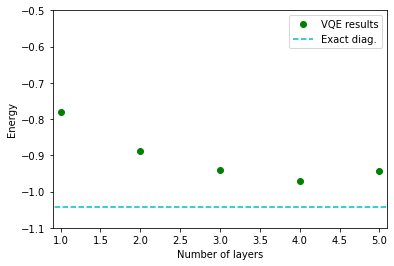

In [36]:
plt.plot(np.array([1,2,3,4,5]),Energy,'o', color = "green",label="VQE results")
plt.plot(np.array([0,1,2,3,4,5,6]),eigenvalues[0]*np.ones(7), ls = "--", color ="c", label = "Exact diag.")
plt.xlabel("Number of layers")
plt.ylabel("Energy")
plt.ylim(-1.1,-0.5)
plt.xlim(0.9,5.1)
plt.legend()

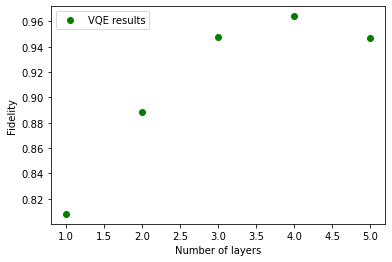

In [37]:
plt.plot(np.array([1,2,3,4,5]),Fidelity,'o', color = "green",label="VQE results")
plt.xlabel("Number of layers")
plt.ylabel("Fidelity")
plt.legend()